The implementation of this project can be found in Jupyter Notebook file `Advanced_Lane_Finding.ipynb` .

In [1]:
import numpy as np
import pickle
import cv2
import re
import os
import glob
import matplotlib
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera calibration and correct distortion calculation

## 1. Camera calibration for 9x6 chessboard images

I begin the camera calibration with "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [2]:
# Prepare object points
nx = 9 # Number of inside corners in row
ny = 6 # Number of inside corners in column

# Read all the calibration images 
calibration_images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

Then I scan through every images in the list of `calibration_images`to find and draw corners in an image of a chessboard pattern.

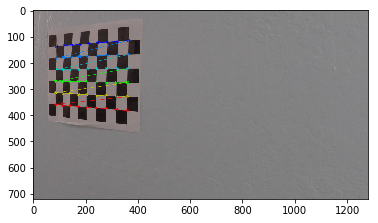

In [3]:
for file in calibration_images:
    # Load the calibration images
    image = cv2.imread(file)

    # Convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx, ny),None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(image,(nx, ny),corners,ret)       
        plt.imshow(image)

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

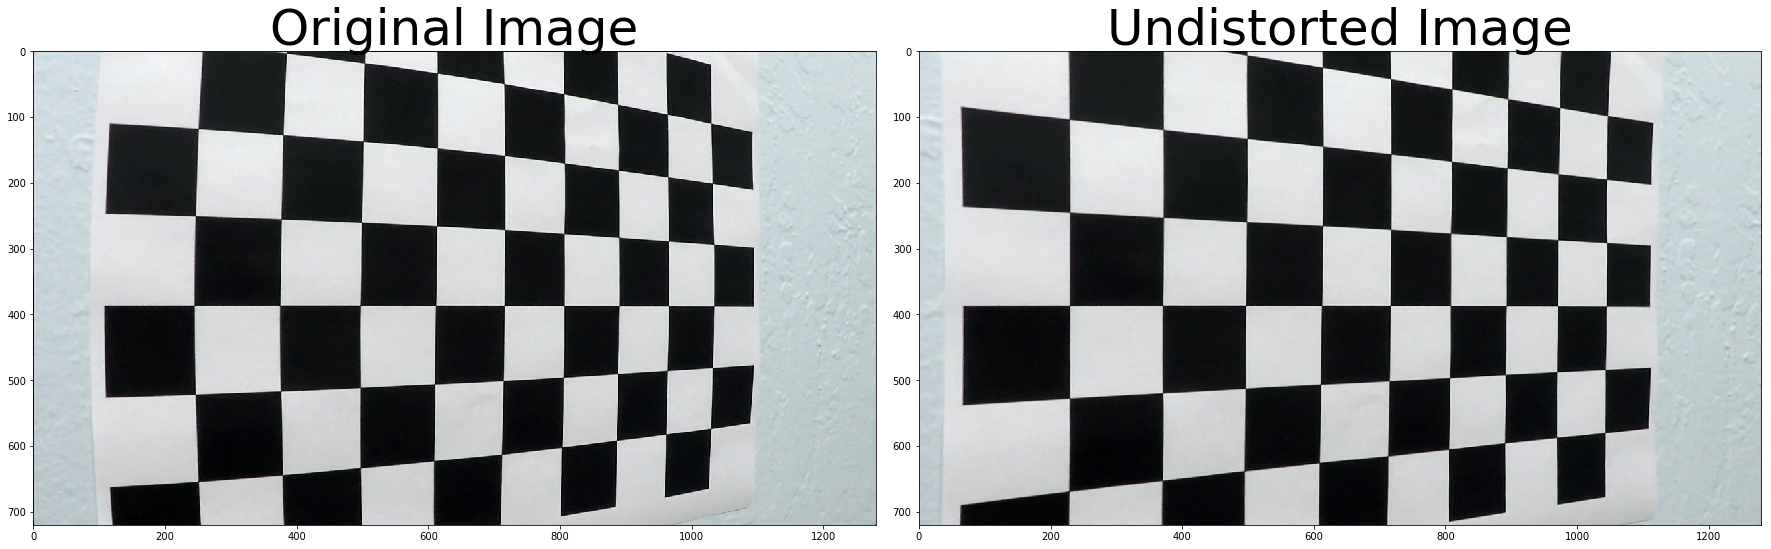

In [4]:
# Read a calibration test image and perform camera calibration
calibration_image = cv2.imread('camera_cal/calibration5.jpg')
calibration_image_size = (calibration_image.shape[1], calibration_image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, calibration_image_size,None,None)

# Correct distortion with undistort()
dst = cv2.undistort(calibration_image, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_calibration_undist.jpg',dst)

# Plot original image and undistort image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibration_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Next, I would save the calibration result in file `calibration_result.p` at root level for further use.

In [5]:
# Save the calibration result as calibration_result.p
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration_result.p","wb"))

## Pipeline for single image

## 1. Distortion-corrected for example image

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images:

_ Load the calibration result from file `calibration_result.p`

In [6]:
with open("calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

_ Read the example image and then call `cv2.undistort()` to correct distortion

In [7]:
test_image = cv2.imread("test_images/test2.jpg")
image = cv2.undistort(test_image, mtx, dist, None, mtx)

_ Plot the original image and after unistorted image

Text(0.5,1,'Undistorted Image')

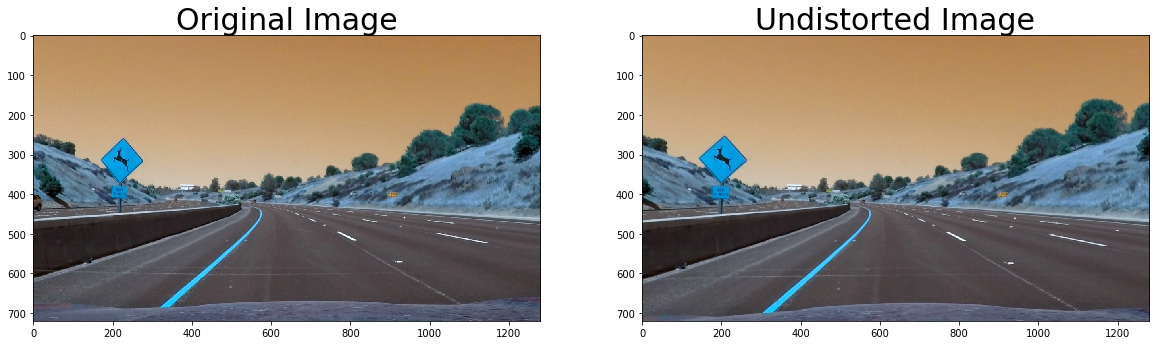

In [8]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Apply color transforms, gradients to create a thresholded binary image

I used a combination of gradient and color thresholds to generate a binary image (thresholding steps with sobelx operation threshold `xgrad_threshold = (40,100)` and HLS color space S threshold `s_threshold = (150,255)` and call `apply_threshold_v2()` in `helperfunction.py`). Here's an example of my output for this step.

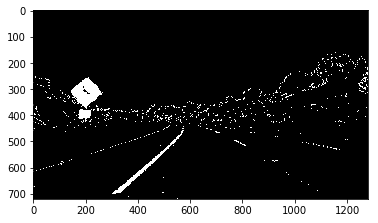

In [9]:
# Import helper function
from helperfunction import *

xgrad_threshold = (40,100)
s_threshold=(150,255)

binary_image = apply_threshold_v2(image, xgrad_thresh=xgrad_threshold, s_thresh=s_threshold)
plt.imshow(binary_image, cmap="gray")

## 3.  Perform perspective transform to create "bird-eye view" image 

Select only a hard-coded region of interest using a binary image mask. I only keep the region of the image defined by the polygon defined by `vertices` vector. The rest of the image is set to black.

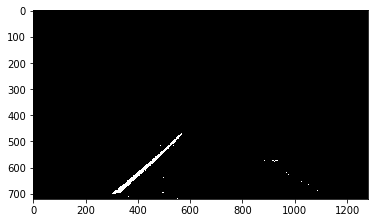

In [10]:
vertices = np.array([[(0,test_image.shape[0]),(550, 470), (700, 470), (test_image.shape[1],test_image.shape[0])]], dtype=np.int32)
masked_image = region_of_interest(binary_image, vertices)
plt.imshow(masked_image, cmap="gray")

The code for my perspective transform includes a function called warper(). The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points for my test image (`img_size = (720,1280)`) are:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 305, 740      | 200, 720        | 
| 550, 470      |200, 0      |
| 720, 470     | 1080, 0      |
| 1160, 720      | 1080, 720        |

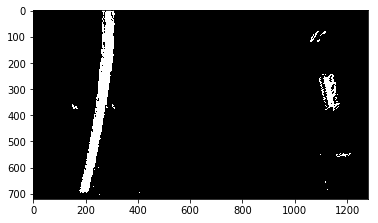

In [11]:
src = np.float32(
    [[280, 740],
     [560, 470],
     [720, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [260,0],
     [1080,0],
     [1150,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp onto birds-eye-view
warped_image = cv2.warpPerspective(binary_image, M, (test_image.shape[1], test_image.shape[0]), flags=cv2.INTER_LINEAR)

plt.imshow(warped_image, cmap="gray")

I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

Text(0.5,1,'Warped Image')

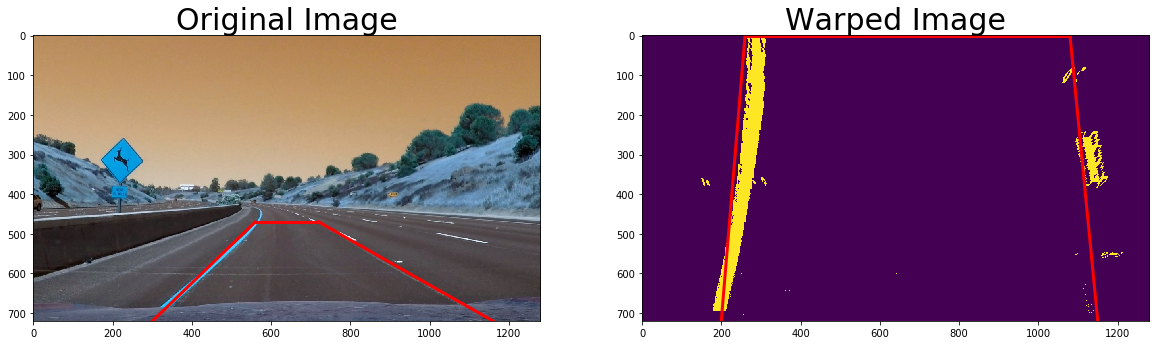

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot([src[0][0],src[1][0]], [src[0][1],src[1][1]], color='red', linewidth=3)
ax1.plot([src[1][0],src[2][0]], [src[1][1],src[2][1]], color='red', linewidth=3)
ax1.plot([src[2][0],src[3][0]], [src[2][1],src[3][1]], color='red', linewidth=3)
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.plot([dst[0][0],dst[1][0]], [dst[0][1],dst[1][1]], color='red', linewidth=3)
ax2.plot([dst[1][0],dst[2][0]], [dst[1][1],dst[2][1]], color='red', linewidth=3)
ax2.plot([dst[2][0],dst[3][0]], [dst[2][1],dst[3][1]], color='red', linewidth=3)
ax2.imshow(warped_image)
ax2.set_title('Warped Image', fontsize=30)

## 4. Identify lane-line pixels and fit their positions with a polynomial

#### Identify lane line pixels process

In [13]:
from scipy import signal

horizontal_offset = 40
blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

To identify the lane line, we perform:
* Divide the image into n horizontal strips (steps) of equal height.
* For each step, take a count of all the pixels at each x-value within the step window using a histogram generated from np.sum.
* Smoothen the histogram using scipy.signal.medfilt.
* Find the peaks in the left and right halves (one half for each lane line) histogram using signal.find_peaks_swt.
* Get (add to our collection of lane line pixels) the pixels in that horizontal strip that have x coordinates close to the two peak x coordinates.

These steps are implemented by `histogram_pixels()` in `helperfunction.py`

In [14]:
leftx, lefty, rightx, righty = histogram_pixels(warped_image, horizontal_offset=horizontal_offset)
print("Left x:", leftx)
print("Left y:", lefty)
print("Right x:", rightx)
print("Right y:", righty)

Left x: [177 178 178 ..., 310 310 310]
Left y: [ 687.  687.  688. ...,  127.  128.  129.]
Right x: [1101 1101 1102 ..., 1172 1173 1173]
Right y: [ 305.  306.  304. ...,  358.  356.  357.]


#### Fit positions of lane-line pixels with a polynomial

Fit a second order polynomial to each lane line using np.fitpoly by `fit_second_order_poly()` in `helperfunction.py`.

Left Fit:  [ 196.13763354  196.13763354  195.90714767 ...,  286.58879242  286.49599257
  286.40294685]
Right Fit:  [ 1130.32621192  1130.47546669  1130.17950945 ...,  1141.7537792
  1141.19238312  1141.47180501]


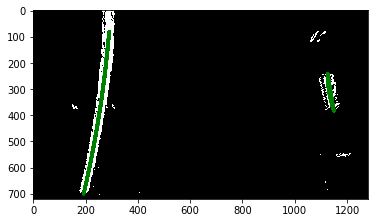

In [15]:
# Fit a second order polynomial to each lane line
left_fit, left_coefficients = fit_second_order_poly(lefty, leftx, return_coeffs=True)
right_fit, right_coefficients = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Left Fit: ",left_fit)
print("Right Fit: ", right_fit)

# Visualize 2 lines
plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped_image, cmap="gray")

Draw the polynomial binary image with the coeffients found by `draw_poly()` in helper function `helperfunction.py`.

Left coefficients:  [ -1.22933943e-04  -6.14516969e-02   2.96375959e+02]
Right coefficients:  [  1.27614828e-03  -6.30471834e-01   1.20390643e+03]


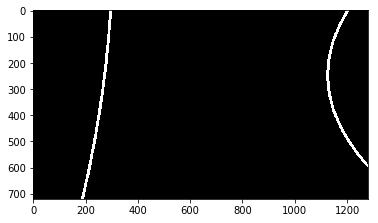

In [16]:
print("Left coefficients: ", left_coefficients)
print("Right coefficients: ", right_coefficients)

polyfit_left = draw_poly(blank_canvas, lane_poly, left_coefficients, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coefficients, 30)
plt.imshow(polyfit_drawn, cmap="gray")

Highlight the area between 2 lanes by `hightlight_lane_line_area()` in `helperfunction.py`

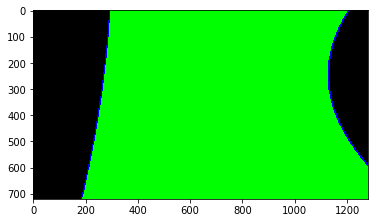

In [17]:
trace = colour_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coefficients, right_coefficients)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

## 5. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

radius of curvature: 
* left radius: `left_curve_radius = np.absolute(((1 + (2 * left_coefficients[0] * y_eval + left_coefficients[1])**2) ** 1.5)/(2 * left_coefficients[0]))`
* right radius: `right_curve_radius = np.absolute(((1 + (2 * right_coefficients[0] * y_eval + right_coefficients[1]) ** 2) ** 1.5)/(2 * right_coeffs[0]))`

In [18]:
# Calculate curvature of the lane
# Define y-value where we want radius of curvature
y_eval = 500
left_curve_radius = np.absolute(((1 + (2 * left_coefficients[0] * y_eval + left_coefficients[1])**2) ** 1.5) \
                /(2 * left_coefficients[0]))
right_curve_radius = np.absolute(((1 + (2 * right_coefficients[0] * y_eval + right_coefficients[1]) ** 2) ** 1.5) \
                 /(2 * right_coefficients[0]))
print("Left lane curve radius: ", left_curve_radius, "pixels")
print("Right lane curve radius: ", right_curve_radius, "pixels")
curvature = (left_curve_radius + right_curve_radius) / 2
centre = center(719, left_coefficients, right_coefficients)
min_curvature = min(left_curve_radius, right_curve_radius)

Left lane curve radius:  4276.39468715 pixels
Right lane curve radius:  660.810263634 pixels


## 6. Example image plotted back down onto the road such that the lane area is identified clearly.

* Warp lane lines back onto original image using `cv2.warpPerspective`

In [19]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (test_image.shape[1], test_image.shape[0]), flags=cv2.INTER_LINEAR)

* Plot the warped image

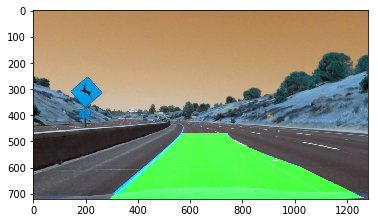

In [20]:
# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

* Output visual information display onto the image

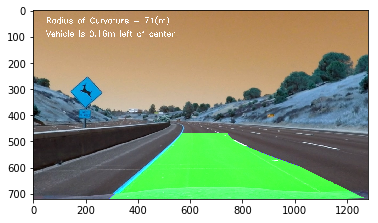

In [21]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre)
plt.imshow(combined_img)

Left coefficients:  [  6.09538336e-05  -2.77046584e-01   4.59502785e+02]
Right coefficients:  [  9.17310491e-05  -4.30040965e-01   1.32515568e+03]
Left lane curve radius:  8784.15263943 pixels
Right lane curve radius:  6412.78427488 pixels


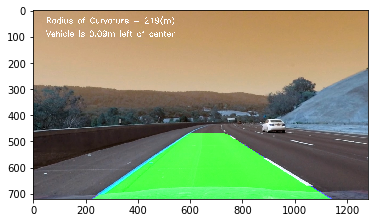

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from helperfunction import *

with open("calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def image_pipeline(file,filepath = False): 
    plt.clf()
    # Read image
    if filepath == True:
        original_image = cv2.imread(file)
    else:
        original_image = file
    
    # 1.Distort correction
    image = cv2.undistort(original_image, mtx, dist, None, mtx)
    
    # 2.Apply color transforms, gradients to create a thresholded binary image
    xgrad_threshold = (40,100)
    s_threshold = (150,255)
    binary_image = apply_threshold_v2(image, xgrad_thresh=xgrad_threshold, s_thresh=s_threshold)

    # 3. Perform perspective transform to create "bird-eye" view
    vertices = np.array([[(0,original_image.shape[0]),(550, 470), (700, 470), (original_image.shape[1],original_image.shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(binary_image, vertices)
    
    src = np.float32(
        [[120, 720],
         [550, 470],
         [700, 470],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp onto birds-eye-view
    warped_image = cv2.warpPerspective(binary_image, M, (test_image.shape[1], test_image.shape[0]), flags=cv2.INTER_LINEAR)
    
    # 4.Identify lane-line pixels and fit their positions with a polynomial
    horizontal_offset = 40
    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    leftx, lefty, rightx, righty = histogram_pixels(warped_image, horizontal_offset=horizontal_offset)
    
    # Fit a second order polynomial to each lane line
    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return image
        
    left_fit, left_coefficients = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coefficients = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Left coefficients: ", left_coefficients)
    print("Right coefficients: ", right_coefficients)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coefficients, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coefficients, 30)
    
    # Highlight the area between 2 lanes
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, left_coefficients, right_coefficients)
    trace[area == 1] = [0,255,0]
    
    # 5. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center
    # Calculate curvature of the lane
    # Define y-value where we want radius of curvature
    y_eval = 500
    left_curve_radius = np.absolute(((1 + (2 * left_coefficients[0] * y_eval + left_coefficients[1])**2) ** 1.5) \
                /(2 * left_coefficients[0]))
    right_curve_radius = np.absolute(((1 + (2 * right_coefficients[0] * y_eval + right_coefficients[1]) ** 2) ** 1.5) \
                 /(2 * right_coefficients[0]))
    print("Left lane curve radius: ", left_curve_radius, "pixels")
    print("Right lane curve radius: ", right_curve_radius, "pixels")
    curvature = (left_curve_radius + right_curve_radius) / 2
    centre = center(719, left_coefficients, right_coefficients)
    min_curvature = min(left_curve_radius, right_curve_radius)
    
    # 6. plot back down onto the road such that the lane area is identified clearly.
    # Warp lane boundaries back onto original image
    lane_lines = cv2.warpPerspective(trace, Minv, (original_image.shape[1], original_image.shape[0]), flags=cv2.INTER_LINEAR)
    # Convert to colour
    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline(file="test_images/test3.jpg", filepath = True)

## Pipeline (video)

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

The link to my project demo video is below:

Left coefficients:  [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
Right coefficients:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
Left lane curve radius:  3404.24440065 pixels
Right lane curve radius:  3948.67015199 pixels
[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


  0%|          | 1/1261 [00:00<08:39,  2.42it/s]

Left coefficients:  [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
Right coefficients:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
Left lane curve radius:  3404.24440065 pixels
Right lane curve radius:  3948.67015199 pixels


  0%|          | 2/1261 [00:00<08:42,  2.41it/s]

Left coefficients:  [ -1.65606032e-04   1.85887377e-01   2.91486807e+02]
Right coefficients:  [ -1.18603468e-05  -6.36760031e-02   1.17639947e+03]
Left lane curve radius:  3021.07673517 pixels
Right lane curve radius:  42518.6051313 pixels


  0%|          | 3/1261 [00:01<08:34,  2.45it/s]

Left coefficients:  [ -2.04923251e-04   2.15920856e-01   2.87822189e+02]
Right coefficients:  [ -1.61780610e-05  -5.88569113e-02   1.17257152e+03]
Left lane curve radius:  2440.38053602 pixels
Right lane curve radius:  31167.4324865 pixels


  0%|          | 4/1261 [00:01<08:29,  2.47it/s]

Left coefficients:  [ -2.30487387e-04   2.38110238e-01   2.84964453e+02]
Right coefficients:  [  4.30990839e-05  -1.11593853e-01   1.17902867e+03]
Left lane curve radius:  2169.50518834 pixels
Right lane curve radius:  11682.9112866 pixels


  0%|          | 5/1261 [00:02<08:28,  2.47it/s]

Left coefficients:  [ -2.09764708e-04   2.28198026e-01   2.85486624e+02]
Right coefficients:  [  3.16056844e-05  -1.05790722e-01   1.17808344e+03]
Left lane curve radius:  2384.83807529 pixels
Right lane curve radius:  15950.7142087 pixels


  0%|          | 6/1261 [00:02<08:24,  2.49it/s]

Left coefficients:  [ -1.90667492e-04   2.18320492e-01   2.86082314e+02]
Right coefficients:  [  1.10015873e-04  -1.85545531e-01   1.19452417e+03]
Left lane curve radius:  2625.37478387 pixels
Right lane curve radius:  4583.74442668 pixels


  1%|          | 7/1261 [00:02<08:23,  2.49it/s]

Left coefficients:  [ -1.81320000e-04   2.17810287e-01   2.83438535e+02]
Right coefficients:  [  2.95639647e-04  -2.95727917e-01   1.21474570e+03]
Left lane curve radius:  2763.06523944 pixels
Right lane curve radius:  1691.24815205 pixels


  1%|          | 8/1261 [00:03<08:21,  2.50it/s]

Left coefficients:  [ -1.83764554e-04   2.24611470e-01   2.82122137e+02]
Right coefficients:  [  6.27250876e-04  -5.22649033e-01   1.25038772e+03]
Left lane curve radius:  2727.68530385 pixels
Right lane curve radius:  810.247677608 pixels


  1%|          | 9/1261 [00:03<08:19,  2.51it/s]

Left coefficients:  [ -1.58253329e-04   2.05488920e-01   2.82622035e+02]
Right coefficients:  [ -2.63638719e-04   1.17266251e-01   1.14029679e+03]
Left lane curve radius:  3170.07128221 pixels
Right lane curve radius:  1957.80968181 pixels


  1%|          | 10/1261 [00:04<08:28,  2.46it/s]

Left coefficients:  [ -1.55107415e-04   2.05904640e-01   2.80068119e+02]
Right coefficients:  [ -1.15312166e-04   3.01448587e-02   1.15190502e+03]
Left lane curve radius:  3236.05752746 pixels
Right lane curve radius:  4383.31855507 pixels


  1%|          | 11/1261 [00:04<08:49,  2.36it/s]

Left coefficients:  [ -1.90978745e-04   2.43586565e-01   2.70305921e+02]
Right coefficients:  [  7.54910019e-05  -1.53863831e-01   1.19353163e+03]
Left lane curve radius:  2628.96859301 pixels
Right lane curve radius:  6684.42303356 pixels


  1%|          | 12/1261 [00:04<08:38,  2.41it/s]

Left coefficients:  [ -1.70661046e-04   2.36253449e-01   2.63708525e+02]
Right coefficients:  [ -3.07076848e-04   2.03750265e-01   1.11795266e+03]
Left lane curve radius:  2948.71179905 pixels
Right lane curve radius:  1654.40222854 pixels


  1%|          | 13/1261 [00:05<08:29,  2.45it/s]

Left coefficients:  [ -1.77274419e-04   2.44062499e-01   2.61520559e+02]
Right coefficients:  [ -2.60869087e-04   1.72638455e-01   1.11968376e+03]
Left lane curve radius:  2839.37872704 pixels
Right lane curve radius:  1939.09457642 pixels


  1%|          | 14/1261 [00:05<08:30,  2.44it/s]

Left coefficients:  [ -2.00931208e-04   2.70927046e-01   2.54864264e+02]
Right coefficients:  [ -7.11009632e-05   2.61240282e-02   1.14095811e+03]
Left lane curve radius:  2506.72389843 pixels
Right lane curve radius:  7053.60290391 pixels


  1%|          | 15/1261 [00:06<08:25,  2.47it/s]

Left coefficients:  [ -2.06817104e-04   2.71783410e-01   2.57004252e+02]
Right coefficients:  [  8.88495283e-06  -2.23113394e-02   1.13542648e+03]
Left lane curve radius:  2432.91677819 pixels
Right lane curve radius:  56290.1364058 pixels


  1%|▏         | 16/1261 [00:06<08:19,  2.49it/s]

Left coefficients:  [ -1.97865058e-04   2.64923993e-01   2.58150541e+02]
Right coefficients:  [  1.49951531e-04  -1.40325197e-01   1.14510587e+03]
Left lane curve radius:  2544.03920763 pixels
Right lane curve radius:  3334.87425346 pixels


  1%|▏         | 17/1261 [00:06<08:23,  2.47it/s]

Left coefficients:  [ -1.68831358e-04   2.43726994e-01   2.59925094e+02]
Right coefficients:  [  1.10232686e-04  -1.20047031e-01   1.14320615e+03]
Left lane curve radius:  2986.48850848 pixels
Right lane curve radius:  4536.51509163 pixels


  1%|▏         | 18/1261 [00:07<08:22,  2.47it/s]

Left coefficients:  [ -1.57631815e-04   2.36516031e-01   2.60109638e+02]
Right coefficients:  [  1.51755371e-04  -1.64873024e-01   1.15102423e+03]
Left lane curve radius:  3201.60173868 pixels
Right lane curve radius:  3295.62675793 pixels


  2%|▏         | 19/1261 [00:07<08:17,  2.50it/s]

Left coefficients:  [ -1.25352075e-04   2.12813674e-01   2.60214677e+02]
Right coefficients:  [  2.55334824e-04  -2.42737179e-01   1.17220852e+03]
Left lane curve radius:  4034.62093563 pixels
Right lane curve radius:  1958.67928532 pixels


  2%|▏         | 20/1261 [00:08<08:17,  2.50it/s]

Left coefficients:  [ -1.18897613e-04   2.13839742e-01   2.55631595e+02]
Right coefficients:  [  2.57269744e-04  -2.58101963e-01   1.18261128e+03]
Left lane curve radius:  4262.28674078 pixels
Right lane curve radius:  1943.48745259 pixels


  2%|▏         | 21/1261 [00:08<08:23,  2.46it/s]

Left coefficients:  [ -9.03554836e-05   1.93526648e-01   2.54777247e+02]
Right coefficients:  [  3.89546995e-04  -3.87843448e-01   1.21972902e+03]
Left lane curve radius:  5622.28658648 pixels
Right lane curve radius:  1283.54776992 pixels


  2%|▏         | 22/1261 [00:08<08:19,  2.48it/s]

Left coefficients:  [ -7.18577127e-05   1.81100187e-01   2.52401557e+02]
Right coefficients:  [ -6.49714365e-05  -4.23303543e-02   1.16162566e+03]
Left lane curve radius:  7083.12400067 pixels
Right lane curve radius:  7828.97980064 pixels


  2%|▏         | 23/1261 [00:09<08:16,  2.49it/s]

Left coefficients:  [ -6.27533754e-05   1.74880636e-01   2.49216245e+02]
Right coefficients:  [ -2.41513616e-05  -8.44264915e-02   1.17601490e+03]
Left lane curve radius:  8118.43131949 pixels
Right lane curve radius:  21069.9454363 pixels


  2%|▏         | 24/1261 [00:09<08:20,  2.47it/s]

Left coefficients:  [ -4.92080434e-05   1.51029340e-01   2.57642758e+02]
Right coefficients:  [ -5.65990098e-05  -6.99874565e-02   1.17474850e+03]
Left lane curve radius:  10319.3658318 pixels
Right lane curve radius:  9047.26282272 pixels


  2%|▏         | 25/1261 [00:10<08:15,  2.50it/s]

Left coefficients:  [ -7.64660137e-05   1.66943663e-01   2.56566978e+02]
Right coefficients:  [ -6.71852419e-05  -3.92794731e-02   1.16240007e+03]
Left lane curve radius:  6619.30937714 pixels
Right lane curve radius:  7568.99999904 pixels


  2%|▏         | 26/1261 [00:10<08:14,  2.50it/s]

Left coefficients:  [ -7.86649542e-05   1.65665552e-01   2.54852706e+02]
Right coefficients:  [ -5.98037129e-05  -7.71521918e-02   1.18533668e+03]
Left lane curve radius:  6428.37159349 pixels
Right lane curve radius:  8597.0155863 pixels


  2%|▏         | 27/1261 [00:10<08:16,  2.48it/s]

Left coefficients:  [ -8.44239696e-05   1.67559247e-01   2.55016180e+02]
Right coefficients:  [ -4.73349759e-05  -3.00317619e-02   1.15712878e+03]
Left lane curve radius:  5983.9942922 pixels
Right lane curve radius:  10657.9946573 pixels


  2%|▏         | 28/1261 [00:11<08:18,  2.47it/s]

Left coefficients:  [ -8.11421722e-05   1.61363217e-01   2.53380397e+02]
Right coefficients:  [ -7.57216384e-05  -2.40555687e-02   1.16701760e+03]
Left lane curve radius:  6221.60222049 pixels
Right lane curve radius:  6701.98350232 pixels


  2%|▏         | 29/1261 [00:11<08:16,  2.48it/s]

Left coefficients:  [ -1.08956586e-04   1.80964113e-01   2.52355401e+02]
Right coefficients:  [ -8.86331653e-05  -1.24075212e-02   1.16225399e+03]
Left lane curve radius:  4624.72137093 pixels
Right lane curve radius:  5727.8381428 pixels


  2%|▏         | 30/1261 [00:12<08:19,  2.47it/s]

Left coefficients:  [ -1.32034289e-04   1.90041794e-01   2.56636692e+02]
Right coefficients:  [  5.12213078e-06  -8.46528390e-02   1.16652809e+03]
Left lane curve radius:  3806.02477552 pixels
Right lane curve radius:  98543.2361771 pixels


  2%|▏         | 31/1261 [00:12<08:21,  2.45it/s]

Left coefficients:  [ -1.43064503e-04   1.92979396e-01   2.60541034e+02]
Right coefficients:  [ -2.01952268e-05  -5.57846520e-02   1.15731497e+03]
Left lane curve radius:  3507.99657557 pixels
Right lane curve radius:  24973.0272804 pixels


  3%|▎         | 32/1261 [00:12<08:15,  2.48it/s]

Left coefficients:  [ -1.53036726e-04   1.91163465e-01   2.67431706e+02]
Right coefficients:  [  1.31210168e-04  -1.53341614e-01   1.16829058e+03]
Left lane curve radius:  3274.31621697 pixels
Right lane curve radius:  3813.48032555 pixels


  3%|▎         | 33/1261 [00:13<08:10,  2.50it/s]

Left coefficients:  [ -1.44955433e-04   1.87439593e-01   2.65840031e+02]
Right coefficients:  [  5.89606277e-04  -4.50343043e-01   1.22307886e+03]
Left lane curve radius:  3458.67882631 pixels
Right lane curve radius:  872.812935129 pixels


  3%|▎         | 34/1261 [00:13<08:11,  2.49it/s]

Left coefficients:  [ -1.47778626e-04   1.87020276e-01   2.68193536e+02]
Right coefficients:  [ -6.14588675e-05   2.24281601e-03   1.14199129e+03]
Left lane curve radius:  3391.25751509 pixels
Right lane curve radius:  8178.35131696 pixels


  3%|▎         | 35/1261 [00:14<08:09,  2.50it/s]

Left coefficients:  [ -1.74181610e-04   2.08183938e-01   2.66806075e+02]
Right coefficients:  [ -5.06827275e-05  -1.93999533e-02   1.14896347e+03]
Left lane curve radius:  2875.54679589 pixels
Right lane curve radius:  9938.06433055 pixels


  3%|▎         | 36/1261 [00:14<08:09,  2.50it/s]

Left coefficients:  [ -1.68796767e-04   2.00548634e-01   2.72459892e+02]
Right coefficients:  [ -1.78678665e-04   9.99562009e-02   1.11971554e+03]
Left lane curve radius:  2966.62274094 pixels
Right lane curve radius:  2824.37252763 pixels


  3%|▎         | 37/1261 [00:14<08:12,  2.49it/s]

Left coefficients:  [ -1.74689364e-04   2.05990734e-01   2.71991397e+02]
Right coefficients:  [ -1.94156625e-04   1.11920731e-01   1.11563783e+03]
Left lane curve radius:  2866.43102161 pixels
Right lane curve radius:  2601.40812973 pixels


  3%|▎         | 38/1261 [00:15<08:09,  2.50it/s]

Left coefficients:  [ -1.85637405e-04   2.12133511e-01   2.74001041e+02]
Right coefficients:  [ -2.13187121e-04   1.55313399e-01   1.09806587e+03]
Left lane curve radius:  2696.25953937 pixels
Right lane curve radius:  2357.1504919 pixels


  3%|▎         | 39/1261 [00:15<08:07,  2.51it/s]

Left coefficients:  [ -2.04054914e-04   2.30602925e-01   2.71261603e+02]
Right coefficients:  [ -1.03378934e-04   8.53139759e-02   1.09906243e+03]
Left lane curve radius:  2452.91171902 pixels
Right lane curve radius:  4838.94309986 pixels


  3%|▎         | 40/1261 [00:16<08:06,  2.51it/s]

Left coefficients:  [ -2.15955411e-04   2.45213336e-01   2.66678207e+02]
Right coefficients:  [ -4.55840294e-05   2.82365796e-02   1.11285151e+03]
Left lane curve radius:  2318.26632719 pixels
Right lane curve radius:  10973.7055798 pixels


  3%|▎         | 41/1261 [00:16<08:04,  2.52it/s]

Left coefficients:  [ -2.26128973e-04   2.54252315e-01   2.65573225e+02]
Right coefficients:  [  2.79966317e-05  -3.62345149e-02   1.12237289e+03]
Left lane curve radius:  2213.751304 pixels
Right lane curve radius:  17861.1092594 pixels


  3%|▎         | 42/1261 [00:16<08:04,  2.52it/s]

Left coefficients:  [ -2.29298406e-04   2.58681727e-01   2.65312264e+02]
Right coefficients:  [  1.98778293e-05  -4.59700490e-02   1.12995816e+03]
Left lane curve radius:  2183.38924605 pixels
Right lane curve radius:  25179.3433425 pixels


  3%|▎         | 43/1261 [00:17<09:37,  2.11it/s]

Left coefficients:  [ -2.11811648e-04   2.53159072e-01   2.63321408e+02]
Right coefficients:  [  2.90284258e-05  -6.68161251e-02   1.14048489e+03]
Left lane curve radius:  2366.64394984 pixels
Right lane curve radius:  17261.4015502 pixels


  3%|▎         | 44/1261 [00:18<09:31,  2.13it/s]

Left coefficients:  [ -2.32952847e-04   2.80887758e-01   2.53379131e+02]
Right coefficients:  [  2.46786640e-05  -7.91966839e-02   1.15121850e+03]
Left lane curve radius:  2153.75906424 pixels
Right lane curve radius:  20350.8106158 pixels


  4%|▎         | 45/1261 [00:18<09:43,  2.08it/s]

Left coefficients:  [ -2.20144748e-04   2.74991064e-01   2.52133784e+02]
Right coefficients:  [  2.62996654e-04  -2.41520003e-01   1.18443389e+03]
Left lane curve radius:  2281.48883391 pixels
Right lane curve radius:  1902.48037907 pixels
Left coefficients:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right coefficients:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
Left lane curve radius:  2244.28829926 pixels
Right lane curve radius:  690.288938566 pixels


  4%|▎         | 47/1261 [00:19<09:55,  2.04it/s]

Left coefficients:  [ -2.30896325e-04   2.93163047e-01   2.43794620e+02]
Right coefficients:  [ -1.96001787e-04   9.62239198e-02   1.12881254e+03]
Left lane curve radius:  2178.08003806 pixels
Right lane curve radius:  2589.18695148 pixels


  4%|▍         | 48/1261 [00:20<09:51,  2.05it/s]

Left coefficients:  [ -2.31392878e-04   2.95675545e-01   2.42749523e+02]
Right coefficients:  [ -1.34780628e-04   5.86758338e-02   1.13100853e+03]
Left lane curve radius:  2174.23457187 pixels
Right lane curve radius:  3742.00837056 pixels


  4%|▍         | 49/1261 [00:20<09:34,  2.11it/s]

Left coefficients:  [ -2.12468055e-04   2.86633128e-01   2.39502349e+02]
Right coefficients:  [ -1.09592263e-04   3.46526589e-02   1.14040636e+03]
Left lane curve radius:  2372.73792647 pixels
Right lane curve radius:  4600.85278363 pixels


  4%|▍         | 50/1261 [00:20<09:42,  2.08it/s]

Left coefficients:  [ -2.21920765e-04   3.01454352e-01   2.34231017e+02]
Right coefficients:  [ -1.72369380e-04   8.45192505e-02   1.13041449e+03]
Left lane curve radius:  2274.46803909 pixels
Right lane curve radius:  2934.3923288 pixels


  4%|▍         | 51/1261 [00:21<09:29,  2.12it/s]

Left coefficients:  [ -2.32983620e-04   3.17643764e-01   2.28247687e+02]
Right coefficients:  [ -1.97044980e-04   1.24668646e-01   1.11612824e+03]
Left lane curve radius:  2169.18736448 pixels
Right lane curve radius:  2557.45612652 pixels


  4%|▍         | 52/1261 [00:21<09:39,  2.08it/s]

Left coefficients:  [ -2.28279127e-04   3.16698460e-01   2.28199742e+02]
Right coefficients:  [ -1.15609346e-04   8.34887025e-02   1.10963370e+03]
Left lane curve radius:  2216.036723 pixels
Right lane curve radius:  4331.60481511 pixels


  4%|▍         | 53/1261 [00:22<09:33,  2.11it/s]

Left coefficients:  [ -2.26497127e-04   3.13565776e-01   2.29314088e+02]
Right coefficients:  [ -8.16861099e-05   5.40534761e-02   1.11214877e+03]
Left lane curve radius:  2232.68383781 pixels
Right lane curve radius:  6128.00366642 pixels


  4%|▍         | 54/1261 [00:22<09:45,  2.06it/s]

Left coefficients:  [ -2.19633522e-04   3.11256355e-01   2.27337969e+02]
Right coefficients:  [ -5.16367872e-05   2.83225746e-02   1.11306409e+03]
Left lane curve radius:  2305.24578896 pixels
Right lane curve radius:  9690.91507559 pixels


  4%|▍         | 55/1261 [00:23<09:34,  2.10it/s]

Left coefficients:  [ -1.86444072e-04   2.89933641e-01   2.27421085e+02]
Right coefficients:  [ -3.83226902e-05   6.50545004e-03   1.12065246e+03]
Left lane curve radius:  2724.96750863 pixels
Right lane curve radius:  13066.9178631 pixels


  4%|▍         | 56/1261 [00:23<09:36,  2.09it/s]

Left coefficients:  [ -1.55141585e-04   2.66848502e-01   2.28535013e+02]
Right coefficients:  [ -6.28055852e-05   1.95128519e-02   1.12260749e+03]
Left lane curve radius:  3283.37473805 pixels
Right lane curve radius:  7983.46759791 pixels


  5%|▍         | 57/1261 [00:24<09:36,  2.09it/s]

Left coefficients:  [ -1.28165427e-04   2.44762755e-01   2.31416346e+02]
Right coefficients:  [  2.13805642e-04  -1.83594803e-01   1.15806772e+03]
Left lane curve radius:  3981.03288302 pixels
Right lane curve radius:  2341.77485954 pixels


  5%|▍         | 58/1261 [00:24<09:46,  2.05it/s]

Left coefficients:  [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
Right coefficients:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
Left lane curve radius:  4519.75059391 pixels
Right lane curve radius:  853.41741244 pixels


  5%|▍         | 59/1261 [00:25<09:41,  2.07it/s]

Left coefficients:  [ -8.02602538e-05   1.91238731e-01   2.45506193e+02]
Right coefficients:  [ -1.48546224e-04   9.42793521e-02   1.10050754e+03]
Left lane curve radius:  6345.17742143 pixels
Right lane curve radius:  3380.83514108 pixels


  5%|▍         | 60/1261 [00:25<09:44,  2.06it/s]

Left coefficients:  [ -6.26108359e-05   1.66297988e-01   2.53837111e+02]
Right coefficients:  [ -8.80172699e-05   6.35957087e-02   1.09648985e+03]
Left lane curve radius:  8114.96756596 pixels
Right lane curve radius:  5685.78617097 pixels


  5%|▍         | 61/1261 [00:26<09:40,  2.07it/s]

Left coefficients:  [ -6.11809090e-05   1.57896653e-01   2.57104130e+02]
Right coefficients:  [ -9.90252007e-05   7.57895542e-02   1.09121322e+03]
Left lane curve radius:  8287.41905918 pixels
Right lane curve radius:  5053.30938612 pixels


  5%|▍         | 62/1261 [00:26<09:39,  2.07it/s]

Left coefficients:  [ -5.77168344e-05   1.43262405e-01   2.63928670e+02]
Right coefficients:  [ -5.70645329e-05   4.43740858e-02   1.09345685e+03]
Left lane curve radius:  8758.25170088 pixels
Right lane curve radius:  8764.12660225 pixels


  5%|▍         | 63/1261 [00:27<09:36,  2.08it/s]

Left coefficients:  [ -6.32213949e-05   1.44837453e-01   2.62656559e+02]
Right coefficients:  [ -1.41915714e-04   1.50767160e-01   1.06247005e+03]
Left lane curve radius:  7987.86861948 pixels
Right lane curve radius:  3523.6320764 pixels


  5%|▌         | 64/1261 [00:27<09:42,  2.05it/s]

Left coefficients:  [ -7.79304245e-05   1.47200268e-01   2.66101512e+02]
Right coefficients:  [  1.12133764e-05   3.74535832e-02   1.07437840e+03]
Left lane curve radius:  6462.21357515 pixels
Right lane curve radius:  44748.1102954 pixels


  5%|▌         | 65/1261 [00:28<09:29,  2.10it/s]

Left coefficients:  [ -1.04206881e-04   1.67516013e-01   2.61181562e+02]
Right coefficients:  [  1.06945605e-05   1.39778455e-02   1.08713400e+03]
Left lane curve radius:  4827.02331618 pixels
Right lane curve radius:  46795.4355343 pixels


  5%|▌         | 66/1261 [00:28<09:32,  2.09it/s]

Left coefficients:  [ -1.31172567e-04   1.82043356e-01   2.61659081e+02]
Right coefficients:  [  5.14498803e-05  -2.69885052e-02   1.09193220e+03]
Left lane curve radius:  3826.57856849 pixels
Right lane curve radius:  9726.91935595 pixels


  5%|▌         | 67/1261 [00:29<09:34,  2.08it/s]

Left coefficients:  [ -1.37700649e-04   1.86771583e-01   2.60195366e+02]
Right coefficients:  [  5.19592338e-05  -4.43323421e-02   1.09801471e+03]
Left lane curve radius:  3644.18800282 pixels
Right lane curve radius:  9623.76830922 pixels


  5%|▌         | 68/1261 [00:29<09:32,  2.08it/s]

Left coefficients:  [ -1.58661391e-04   2.06320424e-01   2.54331426e+02]
Right coefficients:  [  1.25159346e-04  -1.30540495e-01   1.12110134e+03]
Left lane curve radius:  3162.10832248 pixels
Right lane curve radius:  3995.08093934 pixels


  5%|▌         | 69/1261 [00:30<09:30,  2.09it/s]

Left coefficients:  [ -1.82326922e-04   2.22013100e-01   2.54005192e+02]
Right coefficients:  [  4.77639577e-04  -3.61166601e-01   1.15647921e+03]
Left lane curve radius:  2748.80804725 pixels
Right lane curve radius:  1068.18806248 pixels


  6%|▌         | 70/1261 [00:30<09:34,  2.07it/s]

Left coefficients:  [ -2.00724630e-04   2.43268590e-01   2.45924936e+02]
Right coefficients:  [  2.13729215e-04  -1.94081631e-01   1.13816711e+03]
Left lane curve radius:  2497.74083258 pixels
Right lane curve radius:  2340.76350985 pixels


  6%|▌         | 71/1261 [00:31<09:20,  2.12it/s]

Left coefficients:  [ -2.10149947e-04   2.52017040e-01   2.44352424e+02]
Right coefficients:  [ -1.07846117e-04   2.50178334e-02   1.10065807e+03]
Left lane curve radius:  2385.5119795 pixels
Right lane curve radius:  4684.02779992 pixels


  6%|▌         | 72/1261 [00:31<09:20,  2.12it/s]

Left coefficients:  [ -2.09389865e-04   2.58122618e-01   2.39250338e+02]
Right coefficients:  [ -2.01768652e-06  -4.59448340e-02   1.11575386e+03]
Left lane curve radius:  2396.40165391 pixels
Right lane curve radius:  248664.145905 pixels


  6%|▌         | 73/1261 [00:32<09:31,  2.08it/s]

Left coefficients:  [ -2.05161189e-04   2.60244705e-01   2.35453394e+02]
Right coefficients:  [  7.25642672e-06  -4.97812798e-02   1.11689445e+03]
Left lane curve radius:  2448.20851762 pixels
Right lane curve radius:  69091.4281361 pixels


  6%|▌         | 74/1261 [00:32<09:32,  2.07it/s]

Left coefficients:  [ -1.91143591e-04   2.52526098e-01   2.34663112e+02]
Right coefficients:  [ -2.61446102e-05  -6.15698449e-02   1.12897041e+03]
Left lane curve radius:  2630.6323792 pixels
Right lane curve radius:  19345.5343464 pixels


  6%|▌         | 75/1261 [00:33<09:33,  2.07it/s]

Left coefficients:  [ -1.80652947e-04   2.51549885e-01   2.29333639e+02]
Right coefficients:  [ -8.48305279e-05  -8.04998732e-03   1.12119696e+03]
Left lane curve radius:  2788.6315833 pixels
Right lane curve radius:  5970.53960561 pixels


  6%|▌         | 76/1261 [00:33<09:21,  2.11it/s]

Left coefficients:  [ -1.48536081e-04   2.24714416e-01   2.34351064e+02]
Right coefficients:  [ -2.08056211e-04   1.26385761e-01   1.08441172e+03]
Left lane curve radius:  3395.5296139 pixels
Right lane curve radius:  2427.28096049 pixels


  6%|▌         | 77/1261 [00:33<09:23,  2.10it/s]

Left coefficients:  [ -1.26545363e-04   2.16078492e-01   2.27402090e+02]
Right coefficients:  [ -7.42785435e-05   1.15702303e-02   1.11157244e+03]
Left lane curve radius:  3998.75708668 pixels
Right lane curve radius:  6771.16328679 pixels


  6%|▌         | 78/1261 [00:34<09:24,  2.10it/s]

Left coefficients:  [ -9.61404918e-05   1.94004812e-01   2.27834708e+02]
Right coefficients:  [ -9.38987164e-05   1.34328459e-02   1.11829943e+03]
Left lane curve radius:  5275.61520412 pixels
Right lane curve radius:  5376.68605879 pixels


  6%|▋         | 79/1261 [00:34<09:29,  2.08it/s]

Left coefficients:  [ -8.48554998e-05   1.83565580e-01   2.27004314e+02]
Right coefficients:  [ -2.73065536e-05  -5.08124987e-02   1.13213739e+03]
Left lane curve radius:  5978.69947869 pixels
Right lane curve radius:  18478.4914127 pixels


  6%|▋         | 80/1261 [00:35<09:18,  2.12it/s]

Left coefficients:  [ -8.08938043e-05   1.74956785e-01   2.28434699e+02]
Right coefficients:  [  7.12947003e-05  -1.45607852e-01   1.14899344e+03]
Left lane curve radius:  6263.15630345 pixels
Right lane curve radius:  7071.31868807 pixels


  6%|▋         | 81/1261 [00:35<09:26,  2.08it/s]

Left coefficients:  [ -4.69872280e-05   1.42048412e-01   2.35759408e+02]
Right coefficients:  [ -3.80562115e-05  -4.71669174e-02   1.12922535e+03]
Left lane curve radius:  10785.7556565 pixels
Right lane curve radius:  13281.8558344 pixels


  7%|▋         | 82/1261 [00:36<09:17,  2.12it/s]

Left coefficients:  [ -3.58407889e-05   1.30990006e-01   2.35591845e+02]
Right coefficients:  [  2.95434211e-04  -2.74056467e-01   1.16958530e+03]
Left lane curve radius:  14140.4637349 pixels
Right lane curve radius:  1693.58448356 pixels


  7%|▋         | 83/1261 [00:36<09:19,  2.11it/s]

Left coefficients:  [ -4.29204981e-05   1.30743555e-01   2.35953595e+02]
Right coefficients:  [ -5.78524642e-04   2.69935247e-01   1.08868684e+03]
Left lane curve radius:  11784.4812972 pixels
Right lane curve radius:  990.61431897 pixels


  7%|▋         | 84/1261 [00:37<09:09,  2.14it/s]

Left coefficients:  [ -3.18031101e-05   1.27757986e-01   2.29208396e+02]
Right coefficients:  [  2.47174989e-04  -2.75648461e-01   1.18840425e+03]
Left lane curve radius:  15939.3648321 pixels
Right lane curve radius:  2025.31890314 pixels


  7%|▋         | 85/1261 [00:37<09:16,  2.11it/s]

Left coefficients:  [ -3.16405778e-05   1.19582103e-01   2.32872277e+02]
Right coefficients:  [ -9.80183819e-05  -2.15605270e-02   1.14355197e+03]
Left lane curve radius:  15986.1645723 pixels
Right lane curve radius:  5210.88568365 pixels


  7%|▋         | 86/1261 [00:38<09:09,  2.14it/s]

Left coefficients:  [ -4.70173153e-05   1.24043456e-01   2.35266184e+02]
Right coefficients:  [ -7.90152286e-05  -4.45720319e-02   1.15004163e+03]
Left lane curve radius:  10729.1613676 pixels
Right lane curve radius:  6473.42288821 pixels


  7%|▋         | 87/1261 [00:38<09:13,  2.12it/s]

Left coefficients:  [ -4.99829867e-05   1.05852400e-01   2.50058184e+02]
Right coefficients:  [ -5.20239257e-04   3.92846231e-01   1.03743623e+03]
Left lane curve radius:  10050.277154 pixels
Right lane curve radius:  984.587343801 pixels


  7%|▋         | 88/1261 [00:39<09:21,  2.09it/s]

Left coefficients:  [ -7.83783652e-05   1.16310866e-01   2.56160724e+02]
Right coefficients:  [ -7.42154968e-05  -2.51274080e-02   1.13009091e+03]
Left lane curve radius:  6393.08491475 pixels
Right lane curve radius:  6837.11641889 pixels


  7%|▋         | 89/1261 [00:39<09:13,  2.12it/s]

Left coefficients:  [ -9.74257932e-05   1.21336283e-01   2.61531949e+02]
Right coefficients:  [ -1.79192676e-04   1.20296474e-01   1.08080588e+03]
Left lane curve radius:  5136.51291182 pixels
Right lane curve radius:  2804.82348966 pixels


  7%|▋         | 90/1261 [00:40<09:29,  2.06it/s]

Left coefficients:  [ -1.05665109e-04   1.18509788e-01   2.70842491e+02]
Right coefficients:  [  6.53814296e-05  -5.54464611e-02   1.09661312e+03]
Left lane curve radius:  4733.10204723 pixels
Right lane curve radius:  7648.56370888 pixels


  7%|▋         | 91/1261 [00:40<09:22,  2.08it/s]

Left coefficients:  [ -1.22568311e-04   1.35182328e-01   2.66046884e+02]
Right coefficients:  [  7.63570291e-05  -9.03730701e-02   1.11243429e+03]
Left lane curve radius:  4080.33149723 pixels
Right lane curve radius:  6550.11529623 pixels


  7%|▋         | 92/1261 [00:41<09:20,  2.09it/s]

Left coefficients:  [ -1.33565203e-04   1.46548283e-01   2.64088341e+02]
Right coefficients:  [  5.64845809e-05  -9.06026308e-02   1.11729812e+03]
Left lane curve radius:  3744.43652602 pixels
Right lane curve radius:  8867.43385452 pixels


  7%|▋         | 93/1261 [00:41<09:24,  2.07it/s]

Left coefficients:  [ -1.41830614e-04   1.48746726e-01   2.68150363e+02]
Right coefficients:  [  1.80841825e-04  -2.10813490e-01   1.13852224e+03]
Left lane curve radius:  3525.58492158 pixels
Right lane curve radius:  2768.57346388 pixels


  7%|▋         | 94/1261 [00:42<09:17,  2.09it/s]

Left coefficients:  [ -1.73981128e-04   1.76347896e-01   2.65376163e+02]
Right coefficients:  [  6.95295512e-05  -1.18841154e-01   1.12491297e+03]
Left lane curve radius:  2873.89906441 pixels
Right lane curve radius:  7217.43237183 pixels


  8%|▊         | 95/1261 [00:42<09:11,  2.11it/s]

Left coefficients:  [ -1.73435178e-04   1.79419493e-01   2.62623875e+02]
Right coefficients:  [  4.05768931e-04  -3.65483657e-01   1.17366426e+03]
Left lane curve radius:  2883.0763502 pixels
Right lane curve radius:  1235.22929714 pixels


  8%|▊         | 96/1261 [00:42<09:09,  2.12it/s]

Left coefficients:  [ -1.81481857e-04   1.88459721e-01   2.60593031e+02]
Right coefficients:  [  7.61624041e-04  -6.63922960e-01   1.23682917e+03]
Left lane curve radius:  2755.29755754 pixels
Right lane curve radius:  665.914094177 pixels


  8%|▊         | 97/1261 [00:43<09:35,  2.02it/s]

Left coefficients:  [ -1.79596269e-04   1.89404954e-01   2.60697250e+02]
Right coefficients:  [ -4.30206676e-05  -4.30092355e-02   1.12030442e+03]
Left lane curve radius:  2784.42399062 pixels
Right lane curve radius:  11751.5869632 pixels


  8%|▊         | 98/1261 [00:44<09:35,  2.02it/s]

Left coefficients:  [ -1.69039588e-04   1.87150492e-01   2.57755269e+02]
Right coefficients:  [ -4.02405760e-05  -6.45131067e-02   1.13353253e+03]
Left lane curve radius:  2959.3424138 pixels
Right lane curve radius:  12630.3494447 pixels


  8%|▊         | 99/1261 [00:44<09:25,  2.05it/s]

Left coefficients:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right coefficients:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
Left lane curve radius:  3016.22023819 pixels
Right lane curve radius:  1192.90400757 pixels


  8%|▊         | 100/1261 [00:44<09:22,  2.06it/s]

Left coefficients:  [ -1.64364736e-04   1.86156576e-01   2.58426929e+02]
Right coefficients:  [ -2.04066224e-04   5.56414705e-02   1.11667552e+03]
Left lane curve radius:  3044.18220645 pixels
Right lane curve radius:  2531.59531041 pixels


  8%|▊         | 101/1261 [00:45<09:26,  2.05it/s]

Left coefficients:  [ -1.52661891e-04   1.75840244e-01   2.61957475e+02]
Right coefficients:  [ -2.37308780e-04   1.18679694e-01   1.09528864e+03]
Left lane curve radius:  3277.8513274 pixels
Right lane curve radius:  2151.59207746 pixels


  8%|▊         | 102/1261 [00:45<09:22,  2.06it/s]

Left coefficients:  [ -1.52658300e-04   1.76400540e-01   2.63485487e+02]
Right coefficients:  [ -1.65482366e-04   7.09383706e-02   1.09821130e+03]
Left lane curve radius:  3278.05844102 pixels
Right lane curve radius:  3062.071782 pixels


  8%|▊         | 103/1261 [00:46<09:23,  2.06it/s]

Left coefficients:  [ -1.46622436e-04   1.70734015e-01   2.65075890e+02]
Right coefficients:  [ -1.18938303e-04   2.95977107e-02   1.10920581e+03]
Left lane curve radius:  3413.09354966 pixels
Right lane curve radius:  4254.29169891 pixels


  8%|▊         | 104/1261 [00:46<09:24,  2.05it/s]

Left coefficients:  [ -1.47567539e-04   1.70901860e-01   2.66649930e+02]
Right coefficients:  [ -8.49462826e-05   5.07921271e-04   1.11417567e+03]
Left lane curve radius:  3391.04674344 pixels
Right lane curve radius:  5949.1349428 pixels


  8%|▊         | 105/1261 [00:47<09:24,  2.05it/s]

Left coefficients:  [ -1.38338555e-04   1.66851463e-01   2.64154834e+02]
Right coefficients:  [ -5.40194748e-05  -4.34863559e-02   1.13299148e+03]
Left lane curve radius:  3618.72989462 pixels
Right lane curve radius:  9388.23383924 pixels


  8%|▊         | 106/1261 [00:47<09:09,  2.10it/s]

Left coefficients:  [ -1.29248193e-04   1.63867437e-01   2.63286284e+02]
Right coefficients:  [ -6.64938170e-05  -4.15947961e-02   1.13971474e+03]
Left lane curve radius:  3875.48271972 pixels
Right lane curve radius:  7651.65736358 pixels


  8%|▊         | 107/1261 [00:48<09:16,  2.07it/s]

Left coefficients:  [ -1.33608394e-04   1.70192735e-01   2.60717743e+02]
Right coefficients:  [  2.10200914e-04  -2.11682623e-01   1.17378885e+03]
Left lane curve radius:  3749.79543127 pixels
Right lane curve radius:  2378.68445087 pixels


  9%|▊         | 108/1261 [00:48<09:04,  2.12it/s]

Left coefficients:  [ -1.46127178e-04   1.74905068e-01   2.65680477e+02]
Right coefficients:  [  1.46478453e-05  -9.34592286e-02   1.15381144e+03]
Left lane curve radius:  3425.92844337 pixels
Right lane curve radius:  34453.2346366 pixels


  9%|▊         | 109/1261 [00:49<09:06,  2.11it/s]

Left coefficients:  [ -1.48945132e-04   1.76579555e-01   2.66225142e+02]
Right coefficients:  [  6.46691335e-04  -5.35987315e-01   1.23111524e+03]
Left lane curve radius:  3360.78693507 pixels
Right lane curve radius:  787.423012154 pixels


  9%|▊         | 110/1261 [00:49<08:58,  2.14it/s]

Left coefficients:  [ -1.31428865e-04   1.61092080e-01   2.69587845e+02]
Right coefficients:  [ -5.43128951e-05  -4.61746988e-02   1.14940335e+03]
Left lane curve radius:  3809.36162242 pixels
Right lane curve radius:  9345.70699146 pixels


  9%|▉         | 111/1261 [00:50<09:02,  2.12it/s]

Left coefficients:  [ -1.48107832e-04   1.70900239e-01   2.70785405e+02]
Right coefficients:  [ -4.76049898e-05  -5.94954826e-02   1.15390449e+03]
Left lane curve radius:  3378.54969833 pixels
Right lane curve radius:  10684.3318034 pixels


  9%|▉         | 112/1261 [00:50<09:01,  2.12it/s]

Left coefficients:  [ -1.45499883e-04   1.74959470e-01   2.65391284e+02]
Right coefficients:  [  3.80617010e-05  -1.40883395e-01   1.18049462e+03]
Left lane curve radius:  3440.90339109 pixels
Right lane curve radius:  13345.4399798 pixels


  9%|▉         | 113/1261 [00:51<09:08,  2.09it/s]

Left coefficients:  [ -1.69060628e-04   1.90704854e-01   2.67174527e+02]
Right coefficients:  [  4.88532412e-05  -1.43937581e-01   1.17589324e+03]
Left lane curve radius:  2959.59740657 pixels
Right lane curve radius:  10373.8475574 pixels


  9%|▉         | 114/1261 [00:51<08:59,  2.13it/s]

Left coefficients:  [ -1.59995726e-04   1.82396079e-01   2.70927057e+02]
Right coefficients:  [  8.55220254e-05  -1.95825945e-01   1.19285506e+03]
Left lane curve radius:  3127.43590297 pixels
Right lane curve radius:  5953.47121768 pixels


  9%|▉         | 115/1261 [00:52<09:02,  2.11it/s]

Left coefficients:  [ -1.77881365e-04   1.94157814e-01   2.73023144e+02]
Right coefficients:  [ -3.76147787e-05  -2.07517208e-02   1.13066258e+03]
Left lane curve radius:  2811.97924468 pixels
Right lane curve radius:  13360.6305528 pixels


  9%|▉         | 116/1261 [00:52<08:54,  2.14it/s]

Left coefficients:  [ -1.95664096e-04   2.05559087e-01   2.73118170e+02]
Right coefficients:  [ -4.59257781e-05  -2.65048961e-02   1.13414261e+03]
Left lane curve radius:  2555.77515136 pixels
Right lane curve radius:  10972.9182269 pixels


  9%|▉         | 117/1261 [00:53<09:01,  2.11it/s]

Left coefficients:  [ -1.95513769e-04   2.08004931e-01   2.71963421e+02]
Right coefficients:  [ -5.88754125e-05  -2.33249957e-02   1.13636555e+03]
Left lane curve radius:  2557.9631992 pixels
Right lane curve radius:  8578.72938175 pixels


  9%|▉         | 118/1261 [00:53<08:56,  2.13it/s]

Left coefficients:  [ -1.78774382e-04   1.97231143e-01   2.74142227e+02]
Right coefficients:  [ -5.61224755e-05  -3.20164470e-02   1.13961801e+03]
Left lane curve radius:  2798.25053862 pixels
Right lane curve radius:  9013.10302155 pixels


  9%|▉         | 119/1261 [00:53<09:00,  2.11it/s]

Left coefficients:  [ -1.79903977e-04   1.99385781e-01   2.74300044e+02]
Right coefficients:  [  1.53002069e-05  -1.02421398e-01   1.15502102e+03]
Left lane curve radius:  2780.84282645 pixels
Right lane curve radius:  33052.0604445 pixels


 10%|▉         | 120/1261 [00:54<09:08,  2.08it/s]

Left coefficients:  [ -1.78925692e-04   1.96488910e-01   2.78442728e+02]
Right coefficients:  [  1.22135031e-04  -1.59506484e-01   1.16038406e+03]
Left lane curve radius:  2795.74924748 pixels
Right lane curve radius:  4102.40888243 pixels


 10%|▉         | 121/1261 [00:54<09:07,  2.08it/s]

Left coefficients:  [ -1.82458300e-04   2.04082049e-01   2.75709182e+02]
Right coefficients:  [  3.43705477e-04  -3.14311203e-01   1.19343976e+03]
Left lane curve radius:  2742.27443891 pixels
Right lane curve radius:  1456.61966681 pixels


 10%|▉         | 122/1261 [00:55<09:08,  2.08it/s]

Left coefficients:  [ -1.94729103e-04   2.15046049e-01   2.75273982e+02]
Right coefficients:  [ -2.93018322e-04   1.32814883e-01   1.11629410e+03]
Left lane curve radius:  2569.25959802 pixels
Right lane curve radius:  1772.48929369 pixels


 10%|▉         | 123/1261 [00:55<09:07,  2.08it/s]

Left coefficients:  [ -1.83107715e-04   2.02605233e-01   2.80454002e+02]
Right coefficients:  [ -1.64362533e-04   7.32513194e-02   1.11688629e+03]
Left lane curve radius:  2732.19039965 pixels
Right lane curve radius:  3080.01363841 pixels


 10%|▉         | 124/1261 [00:56<09:05,  2.09it/s]

Left coefficients:  [ -2.05258060e-04   2.24234499e-01   2.76735117e+02]
Right coefficients:  [ -3.29255127e-05  -5.60189434e-02   1.14888446e+03]
Left lane curve radius:  2437.27385868 pixels
Right lane curve radius:  15366.353196 pixels


 10%|▉         | 125/1261 [00:56<09:04,  2.08it/s]

Left coefficients:  [ -2.01718234e-04   2.21192906e-01   2.78152935e+02]
Right coefficients:  [ -2.60634156e-04   1.60603597e-01   1.09816837e+03]
Left lane curve radius:  2480.11527963 pixels
Right lane curve radius:  1947.26329821 pixels
Left coefficients:  [ -2.01109338e-04   2.29718096e-01   2.71989387e+02]
Right coefficients:  [ -2.49461855e-04   1.51721526e-01   1.10626561e+03]
Left lane curve radius:  2489.26268584 pixels
Right lane curve radius:  2033.10427524 pixels


 10%|█         | 127/1261 [00:58<11:46,  1.60it/s]

Left coefficients:  [ -2.02363998e-04   2.31393477e-01   2.72954386e+02]
Right coefficients:  [ -1.64103017e-04   1.04377050e-01   1.10674730e+03]
Left lane curve radius:  2473.91913649 pixels
Right lane curve radius:  3063.18425676 pixels


 10%|█         | 128/1261 [00:58<11:02,  1.71it/s]

Left coefficients:  [ -2.02366963e-04   2.35559048e-01   2.70283065e+02]
Right coefficients:  [ -1.37473246e-04   7.64526232e-02   1.11581143e+03]
Left lane curve radius:  2474.84325157 pixels
Right lane curve radius:  3657.40426078 pixels


 10%|█         | 129/1261 [00:59<10:27,  1.80it/s]

Left coefficients:  [ -2.22901224e-04   2.51620130e-01   2.71190934e+02]
Right coefficients:  [ -4.44300331e-05   1.75876031e-02   1.11305471e+03]
Left lane curve radius:  2245.92175738 pixels
Right lane curve radius:  11265.8138942 pixels


 10%|█         | 130/1261 [00:59<10:08,  1.86it/s]

Left coefficients:  [ -2.20371848e-04   2.53610311e-01   2.68040420e+02]
Right coefficients:  [ -1.33517917e-04   8.15067080e-02   1.10668269e+03]
Left lane curve radius:  2272.65338247 pixels
Right lane curve radius:  3760.02156832 pixels


 10%|█         | 131/1261 [01:00<09:48,  1.92it/s]

Left coefficients:  [ -2.06054204e-04   2.45842521e-01   2.69225449e+02]
Right coefficients:  [ -1.01021924e-04   5.38015765e-02   1.11073630e+03]
Left lane curve radius:  2432.31049518 pixels
Right lane curve radius:  4965.98394881 pixels


 10%|█         | 132/1261 [01:00<09:42,  1.94it/s]

Left coefficients:  [ -2.00984330e-04   2.42421598e-01   2.71684922e+02]
Right coefficients:  [ -1.13924385e-04   6.91476572e-02   1.10560837e+03]
Left lane curve radius:  2494.16627505 pixels
Right lane curve radius:  4402.08188588 pixels


 11%|█         | 133/1261 [01:01<09:35,  1.96it/s]

Left coefficients:  [ -1.83870125e-04   2.29341207e-01   2.73405430e+02]
Right coefficients:  [ -8.56835652e-05   3.70704034e-02   1.11805073e+03]
Left lane curve radius:  2727.74881264 pixels
Right lane curve radius:  5856.12275959 pixels


 11%|█         | 134/1261 [01:01<09:31,  1.97it/s]

Left coefficients:  [ -1.69201942e-04   2.17511366e-01   2.76613070e+02]
Right coefficients:  [ -6.12131899e-05   3.09064459e-02   1.11680043e+03]
Left lane curve radius:  2965.39959285 pixels
Right lane curve radius:  8179.43049644 pixels


 11%|█         | 135/1261 [01:02<09:32,  1.97it/s]

Left coefficients:  [ -1.54250525e-04   2.06391929e-01   2.78269129e+02]
Right coefficients:  [ -1.76033976e-04   1.08447579e-01   1.10791459e+03]
Left lane curve radius:  3254.70807495 pixels
Right lane curve radius:  2859.84480131 pixels


 11%|█         | 136/1261 [01:02<09:19,  2.01it/s]

Left coefficients:  [ -1.69720441e-04   2.20967504e-01   2.75535047e+02]
Right coefficients:  [ -1.94770275e-04   1.21899474e-01   1.10940991e+03]
Left lane curve radius:  2957.63424802 pixels
Right lane curve radius:  2587.6017099 pixels


 11%|█         | 137/1261 [01:03<09:17,  2.02it/s]

Left coefficients:  [ -1.40911259e-04   1.99832151e-01   2.76001268e+02]
Right coefficients:  [ -1.29400657e-04   6.63309532e-02   1.12445948e+03]
Left lane curve radius:  3566.82650684 pixels
Right lane curve radius:  3887.04599404 pixels


 11%|█         | 138/1261 [01:03<09:11,  2.04it/s]

Left coefficients:  [ -1.44874282e-04   2.04972483e-01   2.72169697e+02]
Right coefficients:  [  2.39479259e-05  -9.14490546e-02   1.16935424e+03]
Left lane curve radius:  3469.98295741 pixels
Right lane curve radius:  21021.494454 pixels


 11%|█         | 139/1261 [01:04<09:08,  2.05it/s]

Left coefficients:  [ -1.54930699e-04   2.10252673e-01   2.71495402e+02]
Right coefficients:  [ -2.29155644e-04   1.44364182e-01   1.11585874e+03]
Left lane curve radius:  3242.07628772 pixels
Right lane curve radius:  2205.4960807 pixels


 11%|█         | 140/1261 [01:04<09:03,  2.06it/s]

Left coefficients:  [ -1.33193308e-04   1.97674638e-01   2.68748689e+02]
Right coefficients:  [ -6.03865755e-05   1.09975500e-02   1.14059068e+03]
Left lane curve radius:  3777.37912595 pixels
Right lane curve radius:  8310.30022201 pixels


 11%|█         | 141/1261 [01:05<09:01,  2.07it/s]

Left coefficients:  [ -1.37334990e-04   1.95087741e-01   2.70817693e+02]
Right coefficients:  [ -8.17631480e-05   2.68587078e-02   1.13663607e+03]
Left lane curve radius:  3658.96280779 pixels
Right lane curve radius:  6142.89674952 pixels


 11%|█▏        | 142/1261 [01:05<09:14,  2.02it/s]

Left coefficients:  [ -1.37261654e-04   1.93625282e-01   2.70807094e+02]
Right coefficients:  [ -4.63551092e-05  -1.10873173e-02   1.14387036e+03]
Left lane curve radius:  3660.05013184 pixels
Right lane curve radius:  10839.727779 pixels


 11%|█▏        | 143/1261 [01:06<09:08,  2.04it/s]

Left coefficients:  [ -1.35968681e-04   1.86757089e-01   2.76161953e+02]
Right coefficients:  [ -8.00222978e-05   2.48952795e-02   1.13065146e+03]
Left lane curve radius:  3691.55485582 pixels
Right lane curve radius:  6276.76267497 pixels


 11%|█▏        | 144/1261 [01:06<09:03,  2.06it/s]

Left coefficients:  [ -1.54389923e-04   2.00207008e-01   2.73701574e+02]
Right coefficients:  [ -3.17496821e-05  -2.31872243e-02   1.13866169e+03]
Left lane curve radius:  3248.75627626 pixels
Right lane curve radius:  15819.5365214 pixels


 11%|█▏        | 145/1261 [01:07<08:59,  2.07it/s]

Left coefficients:  [ -1.55895107e-04   2.01547502e-01   2.72504904e+02]
Right coefficients:  [  2.07297981e-04  -1.85316580e-01   1.16819215e+03]
Left lane curve radius:  3217.31662675 pixels
Right lane curve radius:  2413.73518023 pixels


 12%|█▏        | 146/1261 [01:07<08:56,  2.08it/s]

Left coefficients:  [ -1.77143169e-04   2.16572120e-01   2.72202628e+02]
Right coefficients:  [  4.39629989e-04  -3.16451472e-01   1.18452803e+03]
Left lane curve radius:  2829.16038102 pixels
Right lane curve radius:  1163.3027317 pixels


 12%|█▏        | 147/1261 [01:08<08:54,  2.09it/s]

Left coefficients:  [ -1.78515280e-04   2.18974209e-01   2.71147997e+02]
Right coefficients:  [ -6.19613081e-05  -9.69809960e-03   1.14213944e+03]
Left lane curve radius:  2807.76075115 pixels
Right lane curve radius:  8131.7883457 pixels


 12%|█▏        | 148/1261 [01:08<08:57,  2.07it/s]

Left coefficients:  [ -1.70158603e-04   2.04681741e-01   2.80674794e+02]
Right coefficients:  [ -9.51408730e-05   4.97924444e-02   1.11640726e+03]
Left lane curve radius:  2943.68984347 pixels
Right lane curve radius:  5271.58451034 pixels


 12%|█▏        | 149/1261 [01:09<08:55,  2.08it/s]

Left coefficients:  [ -1.62453666e-04   1.98745215e-01   2.81447017e+02]
Right coefficients:  [ -2.74900754e-04   2.41736691e-01   1.06707370e+03]
Left lane curve radius:  3083.8831984 pixels
Right lane curve radius:  1821.83974074 pixels


 12%|█▏        | 150/1261 [01:09<09:03,  2.04it/s]

Left coefficients:  [ -1.39260255e-04   1.81346207e-01   2.82356725e+02]
Right coefficients:  [  1.35532933e-04  -1.74380536e-01   1.17430417e+03]
Left lane curve radius:  3599.94320957 pixels
Right lane curve radius:  3697.49454513 pixels


 12%|█▏        | 151/1261 [01:10<08:58,  2.06it/s]

Left coefficients:  [ -1.20828953e-04   1.67743465e-01   2.82655546e+02]
Right coefficients:  [ -1.07287057e-04   4.24313324e-02   1.12732854e+03]
Left lane curve radius:  4151.75026243 pixels
Right lane curve radius:  4689.8295695 pixels


 12%|█▏        | 152/1261 [01:10<08:53,  2.08it/s]

Left coefficients:  [ -1.14128049e-04   1.66194145e-01   2.79092733e+02]
Right coefficients:  [ -3.80768238e-05  -1.40889008e-02   1.13789926e+03]
Left lane curve radius:  4398.87072991 pixels
Right lane curve radius:  13184.9845778 pixels


 12%|█▏        | 153/1261 [01:11<08:50,  2.09it/s]

Left coefficients:  [ -1.06492494e-04   1.55305032e-01   2.83533986e+02]
Right coefficients:  [  1.58025480e-05  -5.09908939e-02   1.13685046e+03]
Left lane curve radius:  4711.95709723 pixels
Right lane curve radius:  31699.2520465 pixels


 12%|█▏        | 154/1261 [01:11<09:00,  2.05it/s]

Left coefficients:  [ -1.15642820e-04   1.68281079e-01   2.76100542e+02]
Right coefficients:  [ -1.64022538e-05  -4.79050423e-02   1.14851090e+03]
Left lane curve radius:  4341.64028895 pixels
Right lane curve radius:  30672.9051286 pixels


 12%|█▏        | 155/1261 [01:12<08:56,  2.06it/s]

Left coefficients:  [ -7.35380518e-05   1.36306537e-01   2.78258763e+02]
Right coefficients:  [ -6.96950618e-05  -1.18920340e-02   1.14693153e+03]
Left lane curve radius:  6839.42269655 pixels
Right lane curve radius:  7245.85970061 pixels


 12%|█▏        | 156/1261 [01:12<09:00,  2.04it/s]

Left coefficients:  [ -9.14892626e-05   1.51532852e-01   2.74470952e+02]
Right coefficients:  [ -1.00041401e-04   1.24121961e-02   1.14221616e+03]
Left lane curve radius:  5494.70337416 pixels
Right lane curve radius:  5055.60891831 pixels


 12%|█▏        | 157/1261 [01:13<08:57,  2.06it/s]

Left coefficients:  [ -9.11393014e-05   1.50762336e-01   2.73412453e+02]
Right coefficients:  [ -1.30185587e-04   4.06471194e-02   1.13586414e+03]
Left lane curve radius:  5515.38732724 pixels
Right lane curve radius:  3886.95014924 pixels


 13%|█▎        | 158/1261 [01:13<09:03,  2.03it/s]

Left coefficients:  [ -9.47486815e-05   1.45610869e-01   2.77868014e+02]
Right coefficients:  [ -2.19088356e-04   1.30959607e-01   1.10667745e+03]
Left lane curve radius:  5297.60908723 pixels
Right lane curve radius:  2308.82330705 pixels


 13%|█▎        | 159/1261 [01:13<08:55,  2.06it/s]

Left coefficients:  [ -1.03859452e-04   1.55123581e-01   2.72678140e+02]
Right coefficients:  [ -1.76637890e-04   8.55813568e-02   1.11983231e+03]
Left lane curve radius:  4833.18841731 pixels
Right lane curve radius:  2865.92724865 pixels


 13%|█▎        | 160/1261 [01:14<08:59,  2.04it/s]

Left coefficients:  [ -1.30342896e-04   1.75325888e-01   2.69483296e+02]
Right coefficients:  [ -2.39163576e-04   1.47425206e-01   1.10097709e+03]
Left lane curve radius:  3847.68471687 pixels
Right lane curve radius:  2117.06655195 pixels


 13%|█▎        | 161/1261 [01:14<08:55,  2.05it/s]

Left coefficients:  [ -1.48696151e-04   1.98566885e-01   2.59775357e+02]
Right coefficients:  [ -2.27439713e-04   1.36623053e-01   1.10876837e+03]
Left lane curve radius:  3375.114105 pixels
Right lane curve radius:  2225.63807641 pixels


 13%|█▎        | 162/1261 [01:15<08:59,  2.04it/s]

Left coefficients:  [ -1.46979941e-04   1.99967534e-01   2.56618520e+02]
Right coefficients:  [ -2.37232835e-04   1.59655440e-01   1.10075426e+03]
Left lane curve radius:  3416.16168051 pixels
Right lane curve radius:  2126.68905506 pixels


 13%|█▎        | 163/1261 [01:15<08:59,  2.03it/s]

Left coefficients:  [ -1.57716928e-04   2.12649050e-01   2.50649433e+02]
Right coefficients:  [ -1.16218824e-04   4.23050589e-02   1.13215382e+03]
Left lane curve radius:  3184.59701607 pixels
Right lane curve radius:  4337.5333388 pixels


 13%|█▎        | 164/1261 [01:16<09:02,  2.02it/s]

Left coefficients:  [ -1.68569795e-04   2.19453087e-01   2.51507090e+02]
Right coefficients:  [ -9.33172207e-05   6.71227494e-02   1.10848913e+03]
Left lane curve radius:  2977.65734997 pixels
Right lane curve radius:  5363.58345296 pixels


 13%|█▎        | 165/1261 [01:16<09:00,  2.03it/s]

Left coefficients:  [ -1.74781148e-04   2.22961102e-01   2.52992722e+02]
Right coefficients:  [  3.78120345e-05  -2.57331918e-02   1.11142892e+03]
Left lane curve radius:  2870.68711861 pixels
Right lane curve radius:  13226.1972735 pixels


 13%|█▎        | 166/1261 [01:17<08:52,  2.05it/s]

Left coefficients:  [ -1.77534102e-04   2.29443443e-01   2.48900473e+02]
Right coefficients:  [  9.45638121e-05  -8.55453312e-02   1.12414466e+03]
Left lane curve radius:  2827.75134078 pixels
Right lane curve radius:  5288.07997106 pixels


 13%|█▎        | 167/1261 [01:17<08:55,  2.04it/s]

Left coefficients:  [ -1.89442363e-04   2.34631951e-01   2.50655028e+02]
Right coefficients:  [  5.83590062e-05  -5.70734242e-02   1.11376150e+03]
Left lane curve radius:  2647.41395764 pixels
Right lane curve radius:  8567.6791336 pixels


 13%|█▎        | 168/1261 [01:18<08:51,  2.05it/s]

Left coefficients:  [ -1.64984770e-04   2.28591252e-01   2.44147077e+02]
Right coefficients:  [  8.26829654e-05  -1.07732679e-01   1.13662162e+03]
Left lane curve radius:  3048.99297709 pixels
Right lane curve radius:  6052.88752786 pixels


 13%|█▎        | 169/1261 [01:18<08:54,  2.04it/s]

Left coefficients:  [ -1.63727904e-04   2.33760651e-01   2.38741148e+02]
Right coefficients:  [  1.23617900e-04  -1.63258335e-01   1.15446258e+03]
Left lane curve radius:  3076.34150164 pixels
Right lane curve radius:  4054.2590081 pixels


 13%|█▎        | 170/1261 [01:19<08:46,  2.07it/s]

Left coefficients:  [ -1.62444339e-04   2.38533500e-01   2.32341986e+02]
Right coefficients:  [  9.91844652e-04  -7.17633021e-01   1.24941476e+03]
Left lane curve radius:  3104.7462321 pixels
Right lane curve radius:  562.024691683 pixels


 14%|█▎        | 171/1261 [01:19<08:49,  2.06it/s]

Left coefficients:  [ -1.68049251e-04   2.47181635e-01   2.27929698e+02]
Right coefficients:  [  6.45951341e-04  -5.30447824e-01   1.22822308e+03]
Left lane curve radius:  3003.30880647 pixels
Right lane curve radius:  789.593677439 pixels


 14%|█▎        | 172/1261 [01:20<08:44,  2.08it/s]

Left coefficients:  [ -1.61028801e-04   2.40501577e-01   2.28039976e+02]
Right coefficients:  [ -9.32286523e-05  -8.17860778e-03   1.13647338e+03]
Left lane curve radius:  3134.49773676 pixels
Right lane curve radius:  5446.09791108 pixels


 14%|█▎        | 173/1261 [01:20<08:47,  2.06it/s]

Left coefficients:  [ -1.57940932e-04   2.36431387e-01   2.28473337e+02]
Right coefficients:  [ -8.55092638e-05  -1.12898825e-02   1.13412729e+03]
Left lane curve radius:  3195.0404804 pixels
Right lane curve radius:  5929.69661808 pixels


 14%|█▍        | 174/1261 [01:21<08:41,  2.08it/s]

Left coefficients:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right coefficients:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
Left lane curve radius:  3131.6368458 pixels
Right lane curve radius:  919.731444221 pixels


 14%|█▍        | 175/1261 [01:21<08:46,  2.06it/s]

Left coefficients:  [ -1.49279400e-04   2.22781930e-01   2.34450767e+02]
Right coefficients:  [ -5.80502695e-05  -2.08328574e-02   1.12634986e+03]
Left lane curve radius:  3376.60411055 pixels
Right lane curve radius:  8693.74367269 pixels


 14%|█▍        | 176/1261 [01:22<08:40,  2.09it/s]

Left coefficients:  [ -1.27654572e-04   2.03442151e-01   2.37349542e+02]
Right coefficients:  [ -2.09400037e-04   1.44544460e-01   1.08189640e+03]
Left lane curve radius:  3950.61444215 pixels
Right lane curve radius:  2402.85534977 pixels


 14%|█▍        | 177/1261 [01:22<08:41,  2.08it/s]

Left coefficients:  [ -9.55302542e-05   1.83485957e-01   2.34968329e+02]
Right coefficients:  [ -1.62831699e-04   9.26178799e-02   1.09994207e+03]
Left lane curve radius:  5294.79760572 pixels
Right lane curve radius:  3093.39054639 pixels


 14%|█▍        | 178/1261 [01:23<09:01,  2.00it/s]

Left coefficients:  [ -7.68191423e-05   1.65136188e-01   2.37758658e+02]
Right coefficients:  [ -1.62432440e-04   8.01824800e-02   1.10996462e+03]
Left lane curve radius:  6585.0945787 pixels
Right lane curve radius:  3109.49193509 pixels


 14%|█▍        | 179/1261 [01:23<08:56,  2.01it/s]

Left coefficients:  [ -5.73841207e-05   1.43478480e-01   2.43007719e+02]
Right coefficients:  [ -1.00746302e-04   2.71697581e-02   1.12170379e+03]
Left lane curve radius:  8810.26774295 pixels
Right lane curve radius:  5003.31636116 pixels


 14%|█▍        | 180/1261 [01:24<08:51,  2.03it/s]

Left coefficients:  [ -4.99222921e-05   1.34768705e-01   2.44730549e+02]
Right coefficients:  [ -1.22050385e-04   3.05040597e-02   1.13123614e+03]
Left lane curve radius:  10123.9119712 pixels
Right lane curve radius:  4148.2761254 pixels


 14%|█▍        | 181/1261 [01:24<08:46,  2.05it/s]

Left coefficients:  [ -6.59340131e-05   1.35792020e-01   2.50624196e+02]
Right coefficients:  [ -1.61582485e-04   7.50718408e-02   1.11880384e+03]
Left lane curve radius:  7638.91872636 pixels
Right lane curve radius:  3129.19781128 pixels


 14%|█▍        | 182/1261 [01:25<08:42,  2.07it/s]

Left coefficients:  [ -5.77784459e-05   1.24394880e-01   2.51989042e+02]
Right coefficients:  [ -5.78417265e-05   8.22751632e-03   1.13616065e+03]
Left lane curve radius:  8711.41467276 pixels
Right lane curve radius:  8676.21600488 pixels


 15%|█▍        | 183/1261 [01:25<08:41,  2.07it/s]

Left coefficients:  [ -9.87117429e-05   1.46329241e-01   2.54887839e+02]
Right coefficients:  [ -1.52908790e-04   7.82049134e-02   1.11909851e+03]
Left lane curve radius:  5082.49087907 pixels
Right lane curve radius:  3297.33389907 pixels


 15%|█▍        | 184/1261 [01:26<08:40,  2.07it/s]

Left coefficients:  [ -1.25423954e-04   1.60442936e-01   2.57275413e+02]
Right coefficients:  [ -3.03981264e-04   2.20874363e-01   1.08248655e+03]
Left lane curve radius:  3993.81468707 pixels
Right lane curve radius:  1661.90835464 pixels


 15%|█▍        | 185/1261 [01:26<08:38,  2.07it/s]

Left coefficients:  [ -1.50507814e-04   1.72948493e-01   2.59985356e+02]
Right coefficients:  [ -3.74022198e-04   3.00476350e-01   1.05887954e+03]
Left lane curve radius:  3324.59638429 pixels
Right lane curve radius:  1347.67997045 pixels


 15%|█▍        | 186/1261 [01:27<08:33,  2.09it/s]

Left coefficients:  [ -2.21571959e-04   2.23751664e-01   2.60138398e+02]
Right coefficients:  [ -2.75606420e-04   2.52682695e-01   1.05139718e+03]
Left lane curve radius:  2256.61932388 pixels
Right lane curve radius:  1815.61146278 pixels


 15%|█▍        | 187/1261 [01:27<08:32,  2.10it/s]

Left coefficients:  [ -2.42281702e-04   2.39106693e-01   2.59099230e+02]
Right coefficients:  [ -2.56106099e-04   2.63366480e-01   1.04198284e+03]
Left lane curve radius:  2063.74462912 pixels
Right lane curve radius:  1952.47023561 pixels


 15%|█▍        | 188/1261 [01:28<08:31,  2.10it/s]

Left coefficients:  [ -2.62948052e-04   2.57375041e-01   2.58913305e+02]
Right coefficients:  [ -1.35101789e-04   1.88227853e-01   1.04442672e+03]
Left lane curve radius:  1901.60486127 pixels
Right lane curve radius:  3716.59236048 pixels


 15%|█▍        | 189/1261 [01:28<08:32,  2.09it/s]

Left coefficients:  [ -2.61247206e-04   2.61131736e-01   2.58632888e+02]
Right coefficients:  [ -2.85075086e-05   9.31510571e-02   1.06141281e+03]
Left lane curve radius:  1913.89610803 pixels
Right lane curve radius:  17649.292678 pixels


 15%|█▌        | 190/1261 [01:29<08:35,  2.08it/s]

Left coefficients:  [ -2.85669481e-04   2.85377482e-01   2.54950679e+02]
Right coefficients:  [ -8.35608404e-05   1.29922419e-01   1.05675034e+03]
Left lane curve radius:  1750.27469298 pixels
Right lane curve radius:  6002.96634469 pixels


 15%|█▌        | 191/1261 [01:29<08:34,  2.08it/s]

Left coefficients:  [ -2.63307121e-04   2.68652572e-01   2.60747006e+02]
Right coefficients:  [ -9.55375941e-05   1.33951176e-01   1.05381542e+03]
Left lane curve radius:  1899.00458625 pixels
Right lane curve radius:  5245.13009955 pixels


 15%|█▌        | 192/1261 [01:29<08:33,  2.08it/s]

Left coefficients:  [ -2.31106812e-04   2.52651475e-01   2.60293455e+02]
Right coefficients:  [ -8.34531213e-05   1.05872488e-01   1.06619473e+03]
Left lane curve radius:  2165.00831352 pixels
Right lane curve radius:  5995.90537074 pixels


 15%|█▌        | 193/1261 [01:30<08:36,  2.07it/s]

Left coefficients:  [ -2.33525035e-04   2.57841677e-01   2.61899925e+02]
Right coefficients:  [ -2.16851659e-05   4.92519555e-02   1.07512870e+03]
Left lane curve radius:  2142.99738346 pixels
Right lane curve radius:  23083.5243272 pixels


 15%|█▌        | 194/1261 [01:30<08:36,  2.07it/s]

Left coefficients:  [ -2.12224792e-04   2.45708063e-01   2.62899280e+02]
Right coefficients:  [  3.76900055e-05   1.72530667e-02   1.08308389e+03]
Left lane curve radius:  2359.95558537 pixels
Right lane curve radius:  13326.2321838 pixels


 15%|█▌        | 195/1261 [01:31<08:38,  2.06it/s]

Left coefficients:  [ -2.05598485e-04   2.42316621e-01   2.62642932e+02]
Right coefficients:  [ -1.11383249e-04   1.26085504e-01   1.06498054e+03]
Left lane curve radius:  2436.84435251 pixels
Right lane curve radius:  4490.46090009 pixels


 16%|█▌        | 196/1261 [01:31<08:26,  2.10it/s]

Left coefficients:  [ -1.89732235e-04   2.42844496e-01   2.51929393e+02]
Right coefficients:  [ -9.81464409e-05   8.52614489e-02   1.09271632e+03]
Left lane curve radius:  2646.45158971 pixels
Right lane curve radius:  5095.69698103 pixels


 16%|█▌        | 197/1261 [01:32<08:31,  2.08it/s]

Left coefficients:  [ -1.74508348e-04   2.40581969e-01   2.42621363e+02]
Right coefficients:  [ -9.87496396e-05   4.69622949e-02   1.11963283e+03]
Left lane curve radius:  2883.97585832 pixels
Right lane curve radius:  5083.69242496 pixels


 16%|█▌        | 198/1261 [01:32<08:38,  2.05it/s]

Left coefficients:  [ -1.69891936e-04   2.49008795e-01   2.30717098e+02]
Right coefficients:  [ -9.95233406e-05   1.66180316e-02   1.14313545e+03]
Left lane curve radius:  2970.72337501 pixels
Right lane curve radius:  5075.83259011 pixels


 16%|█▌        | 199/1261 [01:33<08:27,  2.09it/s]

Left coefficients:  [ -1.62998931e-04   2.52970639e-01   2.20621743e+02]
Right coefficients:  [ -5.29438153e-05  -3.06206716e-02   1.16279178e+03]
Left lane curve radius:  3104.82681512 pixels
Right lane curve radius:  9543.06743307 pixels


 16%|█▌        | 200/1261 [01:33<08:30,  2.08it/s]

Left coefficients:  [ -1.73020124e-04   2.61642223e-01   2.18491377e+02]
Right coefficients:  [  2.30581391e-04  -3.11879841e-01   1.22951397e+03]
Left lane curve radius:  2923.94864509 pixels
Right lane curve radius:  2189.96536372 pixels


 16%|█▌        | 201/1261 [01:34<08:19,  2.12it/s]

Left coefficients:  [ -1.74872577e-04   2.67188483e-01   2.13234129e+02]
Right coefficients:  [ -3.97628352e-05  -5.05465737e-02   1.16708158e+03]
Left lane curve radius:  2895.85294627 pixels
Right lane curve radius:  12728.702418 pixels


 16%|█▌        | 202/1261 [01:34<08:24,  2.10it/s]

Left coefficients:  [ -1.73424451e-04   2.59930985e-01   2.17017746e+02]
Right coefficients:  [ -1.05069118e-04   3.57342577e-02   1.13387538e+03]
Left lane curve radius:  2915.5232741 pixels
Right lane curve radius:  4793.12886595 pixels


 16%|█▌        | 203/1261 [01:35<08:14,  2.14it/s]

Left coefficients:  [ -1.75475882e-04   2.52867373e-01   2.21521130e+02]
Right coefficients:  [ -1.01255547e-04   3.96404631e-02   1.12616451e+03]
Left lane curve radius:  2875.03214429 pixels
Right lane curve radius:  4966.14780913 pixels


 16%|█▌        | 204/1261 [01:35<08:24,  2.09it/s]

Left coefficients:  [ -1.81894452e-04   2.60291029e-01   2.18155971e+02]
Right coefficients:  [ -6.71809026e-05   1.06178792e-02   1.12919264e+03]
Left lane curve radius:  2774.22751306 pixels
Right lane curve radius:  7478.33730081 pixels


 16%|█▋        | 205/1261 [01:36<08:13,  2.14it/s]

Left coefficients:  [ -1.39799673e-04   2.19370961e-01   2.29705047e+02]
Right coefficients:  [ -6.70874307e-05   1.85523702e-02   1.11994060e+03]
Left lane curve radius:  3610.56781521 pixels
Right lane curve radius:  7479.31131248 pixels
Left coefficients:  [ -1.34441668e-04   2.11036249e-01   2.33840242e+02]
Right coefficients:  [ -7.26279011e-05   2.37823119e-02   1.11748124e+03]
Left lane curve radius:  3751.86132409 pixels
Right lane curve radius:  6909.05943479 pixels


 16%|█▋        | 207/1261 [01:37<08:32,  2.05it/s]

Left coefficients:  [ -1.25980081e-04   1.91107455e-01   2.46400622e+02]
Right coefficients:  [ -3.80730360e-05   2.18176367e-02   1.10579605e+03]
Left lane curve radius:  3994.15962327 pixels
Right lane curve radius:  13137.8593247 pixels


 16%|█▋        | 208/1261 [01:37<08:40,  2.02it/s]

Left coefficients:  [ -1.41379432e-04   1.98870551e-01   2.49097661e+02]
Right coefficients:  [ -1.05687485e-05   2.87092116e-02   1.09583107e+03]
Left lane curve radius:  3554.130633 pixels
Right lane curve radius:  47332.6454316 pixels


 17%|█▋        | 209/1261 [01:38<08:32,  2.05it/s]

Left coefficients:  [ -1.18807076e-04   1.82934053e-01   2.49314963e+02]
Right coefficients:  [ -6.55336497e-05   5.86826395e-02   1.09784668e+03]
Left lane curve radius:  4234.48996673 pixels
Right lane curve radius:  7630.20531961 pixels


 17%|█▋        | 210/1261 [01:38<08:33,  2.05it/s]

Left coefficients:  [ -1.34853205e-04   2.01540380e-01   2.42927915e+02]
Right coefficients:  [ -8.01920826e-05   3.22072183e-02   1.11505860e+03]
Left lane curve radius:  3732.49632021 pixels
Right lane curve radius:  6256.57655492 pixels


 17%|█▋        | 211/1261 [01:39<08:19,  2.10it/s]

Left coefficients:  [ -1.39005963e-04   2.11598021e-01   2.35762682e+02]
Right coefficients:  [ -2.59424771e-05  -3.25448483e-03   1.12817346e+03]
Left lane curve radius:  3625.43731939 pixels
Right lane curve radius:  19298.060156 pixels


 17%|█▋        | 212/1261 [01:39<08:23,  2.08it/s]

Left coefficients:  [ -1.54589728e-04   2.22729260e-01   2.35057817e+02]
Right coefficients:  [  3.90470140e-04  -4.27355306e-01   1.23269029e+03]
Left lane curve radius:  3256.91941748 pixels
Right lane curve radius:  1283.12175952 pixels


 17%|█▋        | 213/1261 [01:40<08:18,  2.10it/s]

Left coefficients:  [ -1.71502509e-04   2.35883684e-01   2.32506089e+02]
Right coefficients:  [ -7.42963996e-05   2.59673205e-02   1.12178894e+03]
Left lane curve radius:  2933.55429104 pixels
Right lane curve radius:  6753.39316432 pixels


 17%|█▋        | 214/1261 [01:40<08:25,  2.07it/s]

Left coefficients:  [ -1.87475513e-04   2.47344605e-01   2.31366229e+02]
Right coefficients:  [ -8.22007892e-05   7.22554232e-02   1.09511170e+03]
Left lane curve radius:  2681.36691222 pixels
Right lane curve radius:  6083.56914478 pixels


 17%|█▋        | 215/1261 [01:41<08:12,  2.12it/s]

Left coefficients:  [ -2.18273855e-04   2.73434413e-01   2.25962127e+02]
Right coefficients:  [ -9.88920817e-05   7.93026612e-02   1.09186683e+03]
Left lane curve radius:  2301.16314123 pixels
Right lane curve radius:  5058.92714701 pixels


 17%|█▋        | 216/1261 [01:41<08:26,  2.06it/s]

Left coefficients:  [ -2.37330893e-04   2.91273710e-01   2.21345260e+02]
Right coefficients:  [ -4.38060943e-05   3.14294619e-02   1.09658652e+03]
Left lane curve radius:  2115.9653991 pixels
Right lane curve radius:  11416.5596765 pixels


 17%|█▋        | 217/1261 [01:42<08:13,  2.12it/s]

Left coefficients:  [ -2.32074711e-04   2.90872289e-01   2.20246319e+02]
Right coefficients:  [ -1.38564397e-04   1.14902403e-01   1.07822272e+03]
Left lane curve radius:  2165.66081041 pixels
Right lane curve radius:  3611.46143279 pixels


 17%|█▋        | 218/1261 [01:42<08:21,  2.08it/s]

Left coefficients:  [ -2.22287665e-04   2.91055712e-01   2.14421570e+02]
Right coefficients:  [ -1.19833073e-04   8.26792773e-02   1.09063798e+03]
Left lane curve radius:  2265.31226069 pixels
Right lane curve radius:  4181.11335418 pixels


 17%|█▋        | 219/1261 [01:42<08:18,  2.09it/s]

Left coefficients:  [ -2.24243751e-04   2.92403129e-01   2.15970409e+02]
Right coefficients:  [  1.15342931e-05   6.77303983e-03   1.09237314e+03]
Left lane curve radius:  2245.27246069 pixels
Right lane curve radius:  43370.7887515 pixels


 17%|█▋        | 220/1261 [01:43<08:22,  2.07it/s]

Left coefficients:  [ -1.92182581e-04   2.73272762e-01   2.13324572e+02]
Right coefficients:  [  4.01629897e-04  -2.55629561e-01   1.14163483e+03]
Left lane curve radius:  2627.39634968 pixels
Right lane curve radius:  1284.94410491 pixels


 18%|█▊        | 221/1261 [01:43<08:10,  2.12it/s]

Left coefficients:  [ -1.95617694e-04   2.83061821e-01   2.08978302e+02]
Right coefficients:  [  8.24095659e-05  -3.69585646e-02   1.10314106e+03]
Left lane curve radius:  2585.37862868 pixels
Right lane curve radius:  6086.06706526 pixels


 18%|█▊        | 222/1261 [01:44<08:25,  2.06it/s]

Left coefficients:  [ -1.85947540e-04   2.77911182e-01   2.08312272e+02]
Right coefficients:  [ -6.78960263e-05   3.96731861e-02   1.09520739e+03]
Left lane curve radius:  2723.114146 pixels
Right lane curve radius:  7373.00167408 pixels


 18%|█▊        | 223/1261 [01:44<08:14,  2.10it/s]

Left coefficients:  [ -1.73441029e-04   2.69488139e-01   2.07992712e+02]
Right coefficients:  [ -6.63789529e-05   3.70716557e-02   1.09733636e+03]
Left lane curve radius:  2922.80736074 pixels
Right lane curve radius:  7542.21488961 pixels


 18%|█▊        | 224/1261 [01:45<08:14,  2.10it/s]

Left coefficients:  [ -1.85623226e-04   2.72610648e-01   2.12548554e+02]
Right coefficients:  [  9.97158604e-05  -7.39582663e-02   1.10514560e+03]
Left lane curve radius:  2724.25946025 pixels
Right lane curve radius:  5019.23836984 pixels


 18%|█▊        | 225/1261 [01:45<08:33,  2.02it/s]

Left coefficients:  [ -1.82276206e-04   2.74523099e-01   2.08575114e+02]
Right coefficients:  [  8.25023950e-05  -8.66802269e-02   1.11542895e+03]
Left lane curve radius:  2778.17761484 pixels
Right lane curve radius:  6060.58879914 pixels


 18%|█▊        | 226/1261 [01:46<08:34,  2.01it/s]

Left coefficients:  [ -1.78929382e-04   2.66178971e-01   2.13200618e+02]
Right coefficients:  [  4.25579672e-06   2.78833008e-02   1.06982253e+03]
Left lane curve radius:  2826.36765929 pixels
Right lane curve radius:  117668.893617 pixels


 18%|█▊        | 227/1261 [01:46<08:21,  2.06it/s]

Left coefficients:  [ -1.88950346e-04   2.77802527e-01   2.07589648e+02]
Right coefficients:  [ -2.48047856e-06   8.43398882e-03   1.08079512e+03]
Left lane curve radius:  2677.59606374 pixels
Right lane curve radius:  201584.723299 pixels


 18%|█▊        | 228/1261 [01:47<08:21,  2.06it/s]

Left coefficients:  [ -1.80072777e-04   2.71985908e-01   2.05252531e+02]
Right coefficients:  [  1.10356562e-05  -1.57997020e-02   1.08792650e+03]
Left lane curve radius:  2811.91521411 pixels
Right lane curve radius:  45309.2241755 pixels


 18%|█▊        | 229/1261 [01:47<08:10,  2.10it/s]

Left coefficients:  [ -1.65396797e-04   2.62723789e-01   2.04891004e+02]
Right coefficients:  [  3.18978527e-06  -2.14991078e-02   1.09036641e+03]
Left lane curve radius:  3066.08842061 pixels
Right lane curve radius:  156829.191581 pixels


 18%|█▊        | 230/1261 [01:48<08:17,  2.07it/s]

Left coefficients:  [ -1.42111417e-04   2.49839064e-01   2.00583490e+02]
Right coefficients:  [  1.48795110e-05  -5.06348575e-02   1.10314927e+03]
Left lane curve radius:  3579.79076781 pixels
Right lane curve radius:  33667.7153346 pixels


 18%|█▊        | 231/1261 [01:48<08:06,  2.12it/s]

Left coefficients:  [ -1.54327776e-04   2.58382421e-01   1.99485155e+02]
Right coefficients:  [  8.35457078e-05  -9.59797871e-02   1.10861630e+03]
Left lane curve radius:  3292.61836217 pixels
Right lane curve radius:  5986.1358826 pixels


 18%|█▊        | 232/1261 [01:49<08:12,  2.09it/s]

Left coefficients:  [ -1.38760856e-04   2.51957599e-01   1.94017810e+02]
Right coefficients:  [ -4.32804261e-05  -4.11584966e-02   1.10997436e+03]
Left lane curve radius:  3672.79980914 pixels
Right lane curve radius:  11676.3399638 pixels


 18%|█▊        | 233/1261 [01:49<08:09,  2.10it/s]

Left coefficients:  [ -1.31844903e-04   2.45007099e-01   1.93670366e+02]
Right coefficients:  [ -7.34461539e-05  -1.90379182e-03   1.09960263e+03]
Left lane curve radius:  3865.41256165 pixels
Right lane curve radius:  6865.76794918 pixels


 19%|█▊        | 234/1261 [01:50<08:15,  2.07it/s]

Left coefficients:  [ -1.20427303e-04   2.34517080e-01   1.93772292e+02]
Right coefficients:  [ -3.18832254e-05  -3.16156117e-02   1.10380161e+03]
Left lane curve radius:  4233.20994719 pixels
Right lane curve radius:  15777.1717445 pixels


 19%|█▊        | 235/1261 [01:50<08:07,  2.10it/s]

Left coefficients:  [ -1.16398820e-04   2.28376957e-01   1.93508349e+02]
Right coefficients:  [ -8.23858586e-05   1.79266967e-02   1.09259012e+03]
Left lane curve radius:  4376.62296577 pixels
Right lane curve radius:  6106.86689239 pixels


 19%|█▊        | 236/1261 [01:51<08:11,  2.09it/s]

Left coefficients:  [ -1.33442688e-04   2.32756589e-01   1.98131338e+02]
Right coefficients:  [  5.25884823e-05  -8.81654645e-02   1.10699433e+03]
Left lane curve radius:  3802.4987145 pixels
Right lane curve radius:  9525.84235271 pixels


 19%|█▉        | 237/1261 [01:51<07:59,  2.13it/s]

Left coefficients:  [ -1.22869752e-04   2.21121338e-01   1.99398342e+02]
Right coefficients:  [ -1.33130681e-04   7.98853851e-02   1.07033319e+03]
Left lane curve radius:  4128.4161883 pixels
Right lane curve radius:  3771.69107603 pixels


 19%|█▉        | 238/1261 [01:52<08:04,  2.11it/s]

Left coefficients:  [ -1.21450993e-04   2.16457024e-01   2.01731896e+02]
Right coefficients:  [ -1.63494045e-04   1.32302460e-01   1.04922377e+03]
Left lane curve radius:  4172.7519089 pixels
Right lane curve radius:  3062.6795314 pixels


 19%|█▉        | 239/1261 [01:52<08:05,  2.10it/s]

Left coefficients:  [ -1.25812711e-04   2.13006981e-01   2.04397735e+02]
Right coefficients:  [ -6.22443383e-05   6.05309425e-02   1.05479634e+03]
Left lane curve radius:  4019.56965197 pixels
Right lane curve radius:  8032.89448176 pixels


 19%|█▉        | 240/1261 [01:53<08:14,  2.07it/s]

Left coefficients:  [ -1.23745228e-04   2.09421607e-01   2.04359434e+02]
Right coefficients:  [ -1.35347803e-04   1.04447164e-01   1.05456563e+03]
Left lane curve radius:  4085.13062137 pixels
Right lane curve radius:  3699.47864655 pixels


 19%|█▉        | 241/1261 [01:53<08:13,  2.07it/s]

Left coefficients:  [ -1.19736840e-04   2.05727411e-01   2.04889125e+02]
Right coefficients:  [ -9.70086342e-05   6.56898997e-02   1.06130535e+03]
Left lane curve radius:  4222.22619525 pixels
Right lane curve radius:  5161.76556926 pixels


 19%|█▉        | 242/1261 [01:54<08:05,  2.10it/s]

Left coefficients:  [ -1.19081849e-04   2.09785644e-01   1.98781586e+02]
Right coefficients:  [ -9.22786523e-05   4.64965822e-02   1.07418488e+03]
Left lane curve radius:  4250.71545686 pixels
Right lane curve radius:  5435.4155524 pixels


 19%|█▉        | 243/1261 [01:54<08:14,  2.06it/s]

Left coefficients:  [ -1.32371043e-04   2.11369394e-01   2.04207311e+02]
Right coefficients:  [ -1.31061242e-04   9.25146031e-02   1.05893110e+03]
Left lane curve radius:  3812.67562308 pixels
Right lane curve radius:  3823.51631022 pixels


 19%|█▉        | 244/1261 [01:54<08:02,  2.11it/s]

Left coefficients:  [ -1.40863365e-04   2.18582794e-01   2.01590621e+02]
Right coefficients:  [  3.84805181e-05  -3.09904104e-02   1.08415641e+03]
Left lane curve radius:  3581.74793567 pixels
Right lane curve radius:  12994.6814917 pixels


 19%|█▉        | 245/1261 [01:55<08:06,  2.09it/s]

Left coefficients:  [ -1.50304696e-04   2.20485104e-01   2.04162136e+02]
Right coefficients:  [ -1.69842138e-04   1.17100939e-01   1.05224837e+03]
Left lane curve radius:  3351.18280976 pixels
Right lane curve radius:  2956.20205122 pixels


 20%|█▉        | 246/1261 [01:55<07:57,  2.12it/s]

Left coefficients:  [ -1.47962161e-04   2.14333154e-01   2.06498383e+02]
Right coefficients:  [ -1.87029171e-04   1.45848957e-01   1.04171180e+03]
Left lane curve radius:  3401.5958198 pixels
Right lane curve radius:  2680.18295476 pixels


 20%|█▉        | 247/1261 [01:56<08:02,  2.10it/s]

Left coefficients:  [ -1.47230880e-04   2.13462664e-01   2.05257023e+02]
Right coefficients:  [ -1.07960683e-04   5.93367518e-02   1.06636071e+03]
Left lane curve radius:  3418.39695815 pixels
Right lane curve radius:  4647.75000065 pixels


 20%|█▉        | 248/1261 [01:56<07:53,  2.14it/s]

Left coefficients:  [ -1.55515568e-04   2.13122285e-01   2.10777004e+02]
Right coefficients:  [ -4.12275323e-05   3.37785212e-02   1.05945283e+03]
Left lane curve radius:  3231.12966232 pixels
Right lane curve radius:  12128.8272319 pixels


 20%|█▉        | 249/1261 [01:57<07:58,  2.12it/s]

Left coefficients:  [ -1.56354694e-04   2.18303722e-01   2.06180302e+02]
Right coefficients:  [ -2.35660186e-04   1.92444694e-01   1.03255982e+03]
Left lane curve radius:  3216.28349848 pixels
Right lane curve radius:  2127.64551898 pixels


 20%|█▉        | 250/1261 [01:57<08:03,  2.09it/s]

Left coefficients:  [ -1.51849658e-04   2.12675913e-01   2.08717998e+02]
Right coefficients:  [ -1.88750985e-04   1.66176469e-01   1.03248451e+03]
Left lane curve radius:  3311.02122617 pixels
Right lane curve radius:  2651.01797647 pixels


 20%|█▉        | 251/1261 [01:58<07:53,  2.13it/s]

Left coefficients:  [ -1.55386297e-04   2.18147289e-01   2.05048314e+02]
Right coefficients:  [ -8.54817746e-05   7.99942474e-02   1.04931562e+03]
Left lane curve radius:  3236.81769198 pixels
Right lane curve radius:  5849.46425584 pixels


 20%|█▉        | 252/1261 [01:58<08:03,  2.08it/s]

Left coefficients:  [ -1.55661225e-04   2.21041900e-01   2.03177742e+02]
Right coefficients:  [ -1.24427260e-04   9.75906685e-02   1.05226624e+03]
Left lane curve radius:  3232.7215591 pixels
Right lane curve radius:  4022.75391498 pixels


 20%|██        | 253/1261 [01:59<07:56,  2.12it/s]

Left coefficients:  [ -1.59308214e-04   2.21368614e-01   2.04574433e+02]
Right coefficients:  [ -1.11265269e-04   8.21661687e-02   1.05459405e+03]
Left lane curve radius:  3156.71984372 pixels
Right lane curve radius:  4499.4741709 pixels


 20%|██        | 254/1261 [01:59<08:01,  2.09it/s]

Left coefficients:  [ -1.53614193e-04   2.20225939e-01   2.02095139e+02]
Right coefficients:  [ -6.73996982e-05   2.68417751e-02   1.07296474e+03]
Left lane curve radius:  3276.59522139 pixels
Right lane curve radius:  7436.74273277 pixels


 20%|██        | 255/1261 [02:00<07:50,  2.14it/s]

Left coefficients:  [ -1.56921867e-04   2.14838312e-01   2.08779638e+02]
Right coefficients:  [ -1.52581991e-04   1.07254367e-01   1.05579046e+03]
Left lane curve radius:  3202.34429115 pixels
Right lane curve radius:  3287.03101624 pixels


 20%|██        | 256/1261 [02:00<07:51,  2.13it/s]

Left coefficients:  [ -1.59553587e-04   2.16164708e-01   2.08620917e+02]
Right coefficients:  [  4.17374766e-05  -6.42688780e-02   1.09191146e+03]
Left lane curve radius:  3148.82008342 pixels
Right lane curve radius:  11988.7649541 pixels


 20%|██        | 257/1261 [02:01<07:57,  2.10it/s]

Left coefficients:  [ -1.59203028e-04   2.08806806e-01   2.14371953e+02]
Right coefficients:  [ -1.70360272e-04   1.06443980e-01   1.05887771e+03]
Left lane curve radius:  3152.24239452 pixels
Right lane curve radius:  2952.96016259 pixels


 20%|██        | 258/1261 [02:01<07:50,  2.13it/s]

Left coefficients:  [ -1.50702197e-04   1.95978310e-01   2.20192959e+02]
Right coefficients:  [ -1.98612535e-04   1.36473633e-01   1.05128586e+03]
Left lane curve radius:  3328.00875973 pixels
Right lane curve radius:  2532.05934881 pixels


 21%|██        | 259/1261 [02:02<07:54,  2.11it/s]

Left coefficients:  [ -1.44241747e-04   1.89862352e-01   2.21335872e+02]
Right coefficients:  [ -1.66203942e-04   9.36094026e-02   1.06732516e+03]
Left lane curve radius:  3477.23008526 pixels
Right lane curve radius:  3032.16442017 pixels


 21%|██        | 260/1261 [02:02<07:59,  2.09it/s]

Left coefficients:  [ -1.37806451e-04   1.77252112e-01   2.29314259e+02]
Right coefficients:  [ -4.93028347e-05   7.04651213e-03   1.08220274e+03]
Left lane curve radius:  3636.74863728 pixels
Right lane curve radius:  10168.5795135 pixels


 21%|██        | 261/1261 [02:03<07:49,  2.13it/s]

Left coefficients:  [ -1.24283163e-04   1.70822117e-01   2.27186820e+02]
Right coefficients:  [ -2.90531705e-05  -3.75736307e-02   1.10503043e+03]
Left lane curve radius:  4036.14836243 pixels
Right lane curve radius:  17324.5477722 pixels


 21%|██        | 262/1261 [02:03<07:59,  2.08it/s]

Left coefficients:  [ -1.27887682e-04   1.70141827e-01   2.30254671e+02]
Right coefficients:  [ -1.47512987e-04   7.91374901e-02   1.07794543e+03]
Left lane curve radius:  3920.15595832 pixels
Right lane curve radius:  3413.32998857 pixels


 21%|██        | 263/1261 [02:03<07:50,  2.12it/s]

Left coefficients:  [ -1.21205716e-04   1.61232020e-01   2.33696960e+02]
Right coefficients:  [ -1.25216511e-04   5.29396776e-02   1.08667256e+03]
Left lane curve radius:  4135.13549131 pixels
Right lane curve radius:  4024.41390147 pixels


 21%|██        | 264/1261 [02:04<07:58,  2.08it/s]

Left coefficients:  [ -1.22250493e-04   1.58189616e-01   2.34885342e+02]
Right coefficients:  [ -8.75745670e-05   1.49699915e-02   1.09750327e+03]
Left lane curve radius:  4097.88962869 pixels
Right lane curve radius:  5754.62478779 pixels


 21%|██        | 265/1261 [02:04<07:49,  2.12it/s]

Left coefficients:  [ -1.22604479e-04   1.58537378e-01   2.35003034e+02]
Right coefficients:  [ -9.34941595e-05   1.13400559e-02   1.10156328e+03]
Left lane curve radius:  4086.05540817 pixels
Right lane curve radius:  5402.16102176 pixels


 21%|██        | 266/1261 [02:05<07:57,  2.08it/s]

Left coefficients:  [ -1.23938010e-04   1.61966779e-01   2.31147022e+02]
Right coefficients:  [ -1.46787240e-04   4.15052550e-02   1.10674914e+03]
Left lane curve radius:  4043.02950334 pixels
Right lane curve radius:  3463.08179034 pixels


 21%|██        | 267/1261 [02:05<07:48,  2.12it/s]

Left coefficients:  [ -1.28454141e-04   1.58059248e-01   2.36849269e+02]
Right coefficients:  [ -1.11151068e-04   1.41263863e-02   1.10974675e+03]
Left lane curve radius:  3897.55819633 pixels
Right lane curve radius:  4562.05183219 pixels


 21%|██▏       | 268/1261 [02:06<07:54,  2.09it/s]

Left coefficients:  [ -1.39168046e-04   1.68412013e-01   2.33882686e+02]
Right coefficients:  [ -1.14381595e-04   3.57167073e-03   1.11829451e+03]
Left lane curve radius:  3597.38861694 pixels
Right lane curve radius:  4452.0916264 pixels


 21%|██▏       | 269/1261 [02:06<07:46,  2.13it/s]

Left coefficients:  [ -1.31073447e-04   1.62869861e-01   2.32366986e+02]
Right coefficients:  [  1.11351715e-04  -1.22681677e-01   1.14071666e+03]
Left lane curve radius:  3820.44160044 pixels
Right lane curve radius:  4491.14123044 pixels


 21%|██▏       | 270/1261 [02:07<07:55,  2.08it/s]

Left coefficients:  [ -1.17748639e-04   1.46596135e-01   2.37154112e+02]
Right coefficients:  [ -1.65312098e-04   3.94829941e-02   1.11698407e+03]
Left lane curve radius:  4251.63525324 pixels
Right lane curve radius:  3096.697746 pixels


 21%|██▏       | 271/1261 [02:07<07:47,  2.12it/s]

Left coefficients:  [ -1.34881362e-04   1.56617283e-01   2.39242217e+02]
Right coefficients:  [ -1.29055445e-04   1.63938613e-02   1.11916427e+03]
Left lane curve radius:  3709.58871603 pixels
Right lane curve radius:  3948.30003162 pixels


 22%|██▏       | 272/1261 [02:08<07:51,  2.10it/s]

Left coefficients:  [ -1.46429619e-04   1.55740627e-01   2.48028189e+02]
Right coefficients:  [  1.55529220e-06  -3.34201339e-02   1.11010169e+03]
Left lane curve radius:  3415.05376211 pixels
Right lane curve radius:  321972.759177 pixels


 22%|██▏       | 273/1261 [02:08<07:43,  2.13it/s]

Left coefficients:  [ -1.40702210e-04   1.51793869e-01   2.50057465e+02]
Right coefficients:  [ -1.49536336e-04   7.83763263e-02   1.09056045e+03]
Left lane curve radius:  3554.26025044 pixels
Right lane curve radius:  3369.09828915 pixels


 22%|██▏       | 274/1261 [02:09<07:56,  2.07it/s]

Left coefficients:  [ -1.44205673e-04   1.46070741e-01   2.58058311e+02]
Right coefficients:  [ -3.81713596e-05   1.56655773e-02   1.08846787e+03]
Left lane curve radius:  3467.288061 pixels
Right lane curve radius:  13108.779357 pixels


 22%|██▏       | 275/1261 [02:09<07:46,  2.11it/s]

Left coefficients:  [ -1.36455439e-04   1.43783253e-01   2.57229054e+02]
Right coefficients:  [  1.89059893e-06  -3.74574805e-02   1.10582118e+03]
Left lane curve radius:  3664.49499615 pixels
Right lane curve radius:  264968.441409 pixels


 22%|██▏       | 276/1261 [02:10<07:50,  2.09it/s]

Left coefficients:  [ -1.38052797e-04   1.47932710e-01   2.54644408e+02]
Right coefficients:  [ -3.49065776e-05  -2.75872760e-02   1.11531960e+03]
Left lane curve radius:  3622.3330599 pixels
Right lane curve radius:  14407.9426848 pixels


 22%|██▏       | 277/1261 [02:10<07:42,  2.13it/s]

Left coefficients:  [ -1.12373942e-04   1.28109530e-01   2.57661330e+02]
Right coefficients:  [ -3.00616671e-05  -4.73039046e-02   1.12400152e+03]
Left lane curve radius:  4451.08277971 pixels
Right lane curve radius:  16782.0294886 pixels


 22%|██▏       | 278/1261 [02:11<07:46,  2.11it/s]

Left coefficients:  [ -1.16471065e-04   1.33382527e-01   2.55685948e+02]
Right coefficients:  [ -3.55324603e-05  -5.75431071e-02   1.13342625e+03]
Left lane curve radius:  4294.75350627 pixels
Right lane curve radius:  14254.8909744 pixels


 22%|██▏       | 279/1261 [02:11<07:37,  2.14it/s]

Left coefficients:  [ -1.20193391e-04   1.30528078e-01   2.61784838e+02]
Right coefficients:  [ -6.03832648e-05  -3.54735362e-02   1.12757773e+03]
Left lane curve radius:  4160.62898408 pixels
Right lane curve radius:  8394.82930638 pixels


 22%|██▏       | 280/1261 [02:12<07:43,  2.12it/s]

Left coefficients:  [ -1.11730022e-04   1.21231630e-01   2.65233615e+02]
Right coefficients:  [ -2.29021436e-05  -6.96331925e-02   1.13588031e+03]
Left lane curve radius:  4475.67897806 pixels
Right lane curve radius:  22113.0313404 pixels


 22%|██▏       | 281/1261 [02:12<07:38,  2.14it/s]

Left coefficients:  [ -1.21651382e-04   1.28155831e-01   2.66117210e+02]
Right coefficients:  [ -1.50786213e-05  -6.24857686e-02   1.13527271e+03]
Left lane curve radius:  4110.36623472 pixels
Right lane curve radius:  33459.2231811 pixels


 22%|██▏       | 282/1261 [02:12<07:46,  2.10it/s]

Left coefficients:  [ -1.19280584e-04   1.21694947e-01   2.71502197e+02]
Right coefficients:  [ -1.61401153e-04   3.76897425e-02   1.11715241e+03]
Left lane curve radius:  4191.83371525 pixels
Right lane curve radius:  3169.25983984 pixels


 22%|██▏       | 283/1261 [02:13<07:37,  2.14it/s]

Left coefficients:  [ -1.22059579e-04   1.27690383e-01   2.69298634e+02]
Right coefficients:  [ -1.82186824e-04   4.93534197e-02   1.12290675e+03]
Left lane curve radius:  4096.55501127 pixels
Right lane curve radius:  2817.39221527 pixels


 23%|██▎       | 284/1261 [02:13<07:39,  2.13it/s]

Left coefficients:  [ -1.23597164e-04   1.25555857e-01   2.73341209e+02]
Right coefficients:  [ -1.22998327e-04   2.02896293e-02   1.12541779e+03]
Left lane curve radius:  4045.42354498 pixels
Right lane curve radius:  4129.58980944 pixels


 23%|██▎       | 285/1261 [02:14<08:15,  1.97it/s]

Left coefficients:  [ -1.19546420e-04   1.22822898e-01   2.73614068e+02]
Right coefficients:  [ -4.88577141e-05  -6.38027601e-02   1.15257762e+03]
Left lane curve radius:  4182.54309164 pixels
Right lane curve radius:  10429.2523329 pixels


 23%|██▎       | 286/1261 [02:14<07:57,  2.04it/s]

Left coefficients:  [ -1.20149882e-04   1.28090074e-01   2.70558863e+02]
Right coefficients:  [ -1.28095984e-04   3.91246435e-03   1.14406778e+03]
Left lane curve radius:  4161.86249556 pixels
Right lane curve radius:  3993.96314954 pixels


 23%|██▎       | 287/1261 [02:15<07:57,  2.04it/s]

Left coefficients:  [ -1.17925961e-04   1.20529764e-01   2.75297703e+02]
Right coefficients:  [ -1.84000379e-05  -8.15660665e-02   1.15731728e+03]
Left lane curve radius:  4239.99162372 pixels
Right lane curve radius:  27582.2046486 pixels


 23%|██▎       | 288/1261 [02:15<07:43,  2.10it/s]

Left coefficients:  [ -1.12591599e-04   1.17291696e-01   2.74981994e+02]
Right coefficients:  [  1.50368886e-05  -1.24658724e-01   1.17358411e+03]
Left lane curve radius:  4440.97579719 pixels
Right lane curve radius:  33852.7302246 pixels


 23%|██▎       | 289/1261 [02:16<07:46,  2.08it/s]

Left coefficients:  [ -1.07209247e-04   1.03600923e-01   2.85809792e+02]
Right coefficients:  [  1.40373160e-05  -1.24177814e-01   1.16889782e+03]
Left lane curve radius:  4663.86791552 pixels
Right lane curve radius:  36269.4501381 pixels
Left coefficients:  [ -1.12216871e-04   1.08568050e-01   2.84625859e+02]
Right coefficients:  [ -3.60872320e-06  -1.20058328e-01   1.17438788e+03]
Left lane curve radius:  4455.74697943 pixels
Right lane curve radius:  141743.733103 pixels


 23%|██▎       | 291/1261 [02:17<08:11,  1.97it/s]

Left coefficients:  [ -1.01204828e-04   8.91827572e-02   2.95529956e+02]
Right coefficients:  [ -4.45192013e-05  -7.54843578e-02   1.16141174e+03]
Left lane curve radius:  4941.54688574 pixels
Right lane curve radius:  11474.5866361 pixels


 23%|██▎       | 292/1261 [02:17<07:52,  2.05it/s]

Left coefficients:  [ -9.86012948e-05   8.38249957e-02   2.99911747e+02]
Right coefficients:  [  2.11572902e-05  -1.28866316e-01   1.17113553e+03]
Left lane curve radius:  5072.58818485 pixels
Right lane curve radius:  24044.9560689 pixels


 23%|██▎       | 293/1261 [02:18<07:45,  2.08it/s]

Left coefficients:  [ -8.40836754e-05   7.33119112e-02   3.01072726e+02]
Right coefficients:  [ -8.36053271e-05  -5.06961129e-02   1.16062174e+03]
Left lane curve radius:  5947.49246267 pixels
Right lane curve radius:  6143.01136324 pixels


 23%|██▎       | 294/1261 [02:18<07:43,  2.09it/s]

Left coefficients:  [ -8.59251586e-05   7.14432939e-02   3.05164778e+02]
Right coefficients:  [ -1.23974613e-04  -7.18963511e-03   1.14815427e+03]
Left lane curve radius:  5820.84816238 pixels
Right lane curve radius:  4137.60827046 pixels


 23%|██▎       | 295/1261 [02:19<07:28,  2.16it/s]

Left coefficients:  [ -7.39308968e-05   6.36772162e-02   3.05034893e+02]
Right coefficients:  [ -1.02666884e-04  -2.48311304e-02   1.15458777e+03]
Left lane curve radius:  6764.13890707 pixels
Right lane curve radius:  4989.35199538 pixels


 23%|██▎       | 296/1261 [02:19<07:34,  2.12it/s]

Left coefficients:  [ -6.56681936e-05   5.40350891e-02   3.08975766e+02]
Right coefficients:  [ -1.69674685e-04   5.60318798e-02   1.13033945e+03]
Left lane curve radius:  7615.58180659 pixels
Right lane curve radius:  3004.08525967 pixels


 24%|██▎       | 297/1261 [02:20<07:25,  2.17it/s]

Left coefficients:  [ -6.61268617e-05   5.64155661e-02   3.06443702e+02]
Right coefficients:  [  1.34057935e-05  -1.43620181e-01   1.18521866e+03]
Left lane curve radius:  7562.29345941 pixels
Right lane curve radius:  38249.9248279 pixels


 24%|██▎       | 298/1261 [02:20<07:33,  2.12it/s]

Left coefficients:  [ -6.22951121e-05   5.60553419e-02   3.04569407e+02]
Right coefficients:  [ -1.08891807e-04  -1.20549217e-02   1.15104119e+03]
Left lane curve radius:  8026.78066659 pixels
Right lane curve radius:  4692.83337528 pixels


 24%|██▎       | 299/1261 [02:21<07:29,  2.14it/s]

Left coefficients:  [ -6.65369914e-05   6.17296996e-02   3.01886772e+02]
Right coefficients:  [  3.94017790e-05  -1.23118911e-01   1.16550359e+03]
Left lane curve radius:  7514.87739487 pixels
Right lane curve radius:  12823.4214613 pixels


 24%|██▍       | 300/1261 [02:21<07:38,  2.10it/s]

Left coefficients:  [ -6.39637190e-05   6.38389545e-02   2.98128074e+02]
Right coefficients:  [ -3.81995031e-05  -7.88450602e-02   1.16798397e+03]
Left lane curve radius:  7816.93152617 pixels
Right lane curve radius:  13359.0659427 pixels


 24%|██▍       | 301/1261 [02:22<07:32,  2.12it/s]

Left coefficients:  [ -7.22585838e-05   6.89758325e-02   2.98134042e+02]
Right coefficients:  [  1.08750323e-05  -1.20151423e-01   1.17199415e+03]
Left lane curve radius:  6919.70498313 pixels
Right lane curve radius:  46802.8659632 pixels


 24%|██▍       | 302/1261 [02:22<07:41,  2.08it/s]

Left coefficients:  [ -5.94294569e-05   6.94270096e-02   2.90944494e+02]
Right coefficients:  [ -3.84458493e-05  -9.41944540e-02   1.17718527e+03]
Left lane curve radius:  8414.59759264 pixels
Right lane curve radius:  13350.0225617 pixels


 24%|██▍       | 303/1261 [02:23<07:41,  2.08it/s]

Left coefficients:  [ -6.94562201e-05   7.62620798e-02   2.90127416e+02]
Right coefficients:  [ -3.00495979e-05  -9.73818416e-02   1.17537722e+03]
Left lane curve radius:  7199.27947657 pixels
Right lane curve radius:  17046.0979652 pixels


 24%|██▍       | 304/1261 [02:23<07:31,  2.12it/s]

Left coefficients:  [ -7.09706131e-05   7.60832917e-02   2.90589458e+02]
Right coefficients:  [  2.86865652e-05  -1.39552256e-01   1.18299785e+03]
Left lane curve radius:  7045.44575459 pixels
Right lane curve radius:  17752.0963312 pixels


 24%|██▍       | 305/1261 [02:24<07:41,  2.07it/s]

Left coefficients:  [ -6.93844117e-05   7.96075387e-02   2.86542504e+02]
Right coefficients:  [  7.35065809e-04  -6.30753874e-01   1.27201679e+03]
Left lane curve radius:  7207.35932312 pixels
Right lane curve radius:  691.343397442 pixels


 24%|██▍       | 306/1261 [02:24<07:30,  2.12it/s]

Left coefficients:  [ -6.67353637e-05   6.70014546e-02   2.96301566e+02]
Right coefficients:  [  3.62365566e-05  -1.13439827e-01   1.16879710e+03]
Left lane curve radius:  7492.28033592 pixels
Right lane curve radius:  13921.7674176 pixels


 24%|██▍       | 307/1261 [02:24<07:34,  2.10it/s]

Left coefficients:  [ -6.30946808e-05   6.98745039e-02   2.92211250e+02]
Right coefficients:  [  6.60031014e-05  -1.65365176e-01   1.19078332e+03]
Left lane curve radius:  7925.1447017 pixels
Right lane curve radius:  7687.86392873 pixels


 24%|██▍       | 308/1261 [02:25<07:30,  2.11it/s]

Left coefficients:  [ -6.68882769e-05   5.52891094e-02   3.06789753e+02]
Right coefficients:  [ -5.62484372e-05  -4.09380822e-02   1.15353365e+03]
Left lane curve radius:  7476.66006286 pixels
Right lane curve radius:  9015.37252666 pixels


 25%|██▍       | 309/1261 [02:25<07:33,  2.10it/s]

Left coefficients:  [ -5.23699783e-05   4.19219296e-02   3.10056675e+02]
Right coefficients:  [  4.40127431e-06  -1.06676968e-01   1.17297850e+03]
Left lane curve radius:  9549.01814918 pixels
Right lane curve radius:  115390.608083 pixels


 25%|██▍       | 310/1261 [02:26<07:23,  2.14it/s]

Left coefficients:  [ -4.06148446e-05   2.72206834e-02   3.16618032e+02]
Right coefficients:  [ -4.33699741e-05  -4.76269673e-02   1.15324458e+03]
Left lane curve radius:  12314.0827825 pixels
Right lane curve radius:  11672.203664 pixels


 25%|██▍       | 311/1261 [02:26<07:32,  2.10it/s]

Left coefficients:  [ -4.02298164e-05   1.51176362e-02   3.26100607e+02]
Right coefficients:  [  1.31112753e-04  -1.78563748e-01   1.16643537e+03]
Left lane curve radius:  12440.3510992 pixels
Right lane curve radius:  3826.39854912 pixels


 25%|██▍       | 312/1261 [02:27<07:23,  2.14it/s]

Left coefficients:  [ -4.67396712e-05   1.89283864e-02   3.26624749e+02]
Right coefficients:  [  7.65906601e-05  -1.51086056e-01   1.16784774e+03]
Left lane curve radius:  10709.964355 pixels
Right lane curve radius:  6582.62955166 pixels


 25%|██▍       | 313/1261 [02:27<07:30,  2.10it/s]

Left coefficients:  [ -4.90653467e-05   4.90147420e-03   3.39943126e+02]
Right coefficients:  [  1.16761634e-04  -1.85285536e-01   1.16623220e+03]
Left lane curve radius:  10220.3201014 pixels
Right lane curve radius:  4312.42488066 pixels


 25%|██▍       | 314/1261 [02:28<07:34,  2.08it/s]

Left coefficients:  [ -4.84879493e-05   8.82044021e-03   3.37884676e+02]
Right coefficients:  [  1.70396027e-04  -2.55782166e-01   1.18792470e+03]
Left lane curve radius:  10336.1887795 pixels
Right lane curve radius:  2966.48964643 pixels


 25%|██▍       | 315/1261 [02:28<07:35,  2.08it/s]

Left coefficients:  [ -4.54084712e-05   5.05244792e-03   3.39431632e+02]
Right coefficients:  [  1.44081946e-04  -2.48070255e-01   1.19353539e+03]
Left lane curve radius:  11038.0715381 pixels
Right lane curve radius:  3526.68795086 pixels


 25%|██▌       | 316/1261 [02:29<07:24,  2.13it/s]

Left coefficients:  [ -4.13085096e-05   3.44632965e-03   3.38122844e+02]
Right coefficients:  [  2.31913322e-04  -3.18132910e-01   1.21345992e+03]
Left lane curve radius:  12130.0804218 pixels
Right lane curve radius:  2180.06325488 pixels


 25%|██▌       | 317/1261 [02:29<07:30,  2.10it/s]

Left coefficients:  [ -4.15496173e-05   5.22552033e-03   3.36869349e+02]
Right coefficients:  [  3.66318628e-04  -4.23182607e-01   1.23963664e+03]
Left lane curve radius:  12057.629852 pixels
Right lane curve radius:  1371.55758644 pixels


 25%|██▌       | 318/1261 [02:30<07:19,  2.15it/s]

Left coefficients:  [ -5.02618839e-05   2.13244502e-03   3.45272533e+02]
Right coefficients:  [  7.20204077e-05  -2.01698729e-01   1.19280332e+03]
Left lane curve radius:  9982.48173027 pixels
Right lane curve radius:  7118.33274486 pixels


 25%|██▌       | 319/1261 [02:30<07:25,  2.12it/s]

Left coefficients:  [ -5.01290073e-05   3.97904553e-03   3.43638059e+02]
Right coefficients:  [ -1.14279813e-04  -6.08195795e-02   1.17129643e+03]
Left lane curve radius:  10006.1469671 pixels
Right lane curve radius:  4577.97576166 pixels


 25%|██▌       | 320/1261 [02:31<07:15,  2.16it/s]

Left coefficients:  [ -4.28901188e-05  -1.08269464e-02   3.52027130e+02]
Right coefficients:  [  1.10183869e-04  -2.46065202e-01   1.20678249e+03]
Left lane curve radius:  11708.1909992 pixels
Right lane curve radius:  4664.12673299 pixels


 25%|██▌       | 321/1261 [02:31<07:23,  2.12it/s]

Left coefficients:  [ -2.51542509e-05  -2.22726107e-02   3.52157448e+02]
Right coefficients:  [ -8.75871762e-05  -8.08005849e-02   1.17767920e+03]
Left lane curve radius:  19944.4591298 pixels
Right lane curve radius:  5953.10742168 pixels


 26%|██▌       | 322/1261 [02:32<07:13,  2.16it/s]

Left coefficients:  [ -1.54275417e-05  -3.02752447e-02   3.53635283e+02]
Right coefficients:  [ -1.75946571e-05  -1.28133912e-01   1.18448880e+03]
Left lane curve radius:  32511.1664708 pixels
Right lane curve radius:  29327.7597622 pixels


 26%|██▌       | 323/1261 [02:32<07:24,  2.11it/s]

Left coefficients:  [ -1.24042945e-05  -3.31730019e-02   3.54902895e+02]
Right coefficients:  [  7.56043477e-05  -2.02076465e-01   1.19538097e+03]
Left lane curve radius:  40434.2846672 pixels
Right lane curve radius:  6772.6824842 pixels


 26%|██▌       | 324/1261 [02:32<07:15,  2.15it/s]

Left coefficients:  [ -6.48138176e-06  -3.11228281e-02   3.48948276e+02]
Right coefficients:  [ -7.26482902e-06  -1.62337853e-01   1.20438101e+03]
Left lane curve radius:  77307.7332537 pixels
Right lane curve radius:  71815.6212108 pixels


 26%|██▌       | 325/1261 [02:33<07:21,  2.12it/s]

Left coefficients:  [  5.20988390e-08  -4.25292029e-02   3.54125215e+02]
Right coefficients:  [  3.43779855e-05  -1.96077963e-01   1.20770211e+03]
Left lane curve radius:  9623128.81622 pixels
Right lane curve radius:  15118.33189 pixels


 26%|██▌       | 326/1261 [02:33<07:15,  2.15it/s]

Left coefficients:  [  1.45455337e-05  -5.41143472e-02   3.55959909e+02]
Right coefficients:  [  1.29465940e-04  -2.89093501e-01   1.22717386e+03]
Left lane curve radius:  34455.5750568 pixels
Right lane curve radius:  4010.56791167 pixels


 26%|██▌       | 327/1261 [02:34<07:22,  2.11it/s]

Left coefficients:  [  1.15573734e-05  -4.92279038e-02   3.51824322e+02]
Right coefficients:  [  4.90545761e-05  -2.27777659e-01   1.22362586e+03]
Left lane curve radius:  43354.5463954 pixels
Right lane curve radius:  10684.9716112 pixels


 26%|██▌       | 328/1261 [02:34<07:14,  2.15it/s]

Left coefficients:  [  1.42390831e-05  -5.35421181e-02   3.52606729e+02]
Right coefficients:  [ -1.01693489e-04  -9.09817904e-02   1.19718325e+03]
Left lane curve radius:  35196.0157788 pixels
Right lane curve radius:  5193.05273591 pixels


 26%|██▌       | 329/1261 [02:35<07:18,  2.13it/s]

Left coefficients:  [  2.01383268e-05  -4.93439634e-02   3.44144474e+02]
Right coefficients:  [  1.36870588e-03  -1.15052241e+00   1.39624138e+03]
Left lane curve radius:  24860.0526094 pixels
Right lane curve radius:  391.70183867 pixels


 26%|██▌       | 330/1261 [02:35<07:18,  2.12it/s]

Left coefficients:  [  3.04654631e-05  -6.80344746e-02   3.53560948e+02]
Right coefficients:  [  5.99492470e-05  -2.31893195e-01   1.23137561e+03]
Left lane curve radius:  16446.7858116 pixels
Right lane curve radius:  8712.98068461 pixels


 26%|██▌       | 331/1261 [02:36<07:24,  2.09it/s]

Left coefficients:  [  2.98435006e-05  -7.45047681e-02   3.58158138e+02]
Right coefficients:  [  5.37410876e-06  -1.87685520e-01   1.22065423e+03]
Left lane curve radius:  16804.2189194 pixels
Right lane curve radius:  97715.5681857 pixels


 26%|██▋       | 332/1261 [02:36<07:17,  2.13it/s]

Left coefficients:  [  1.91456547e-05  -8.15654119e-02   3.69561268e+02]
Right coefficients:  [  1.07227373e-04  -2.45277913e-01   1.21829264e+03]
Left lane curve radius:  26268.3633053 pixels
Right lane curve radius:  4796.92203891 pixels


 26%|██▋       | 333/1261 [02:37<07:22,  2.10it/s]

Left coefficients:  [  1.86695937e-05  -8.91139432e-02   3.74860751e+02]
Right coefficients:  [ -1.00399556e-04  -5.43743738e-02   1.17213688e+03]
Left lane curve radius:  26981.113058 pixels
Right lane curve radius:  5160.11642021 pixels


 26%|██▋       | 334/1261 [02:37<07:15,  2.13it/s]

Left coefficients:  [  2.02729757e-05  -8.87110054e-02   3.73893011e+02]
Right coefficients:  [  1.01008432e-04  -1.96986528e-01   1.19094409e+03]
Left lane curve radius:  24836.8538264 pixels
Right lane curve radius:  5018.63776475 pixels


 27%|██▋       | 335/1261 [02:38<07:19,  2.11it/s]

Left coefficients:  [  1.70101817e-05  -8.72442736e-02   3.74598190e+02]
Right coefficients:  [  8.15174779e-05  -1.96187736e-01   1.19557474e+03]
Left lane curve radius:  29611.9223411 pixels
Right lane curve radius:  6255.03036822 pixels


 27%|██▋       | 336/1261 [02:38<07:11,  2.14it/s]

Left coefficients:  [  5.77434688e-06  -6.32153515e-02   3.61338495e+02]
Right coefficients:  [ -2.79130031e-05  -1.39650899e-01   1.20518681e+03]
Left lane curve radius:  87018.7837096 pixels
Right lane curve radius:  18672.4937956 pixels


 27%|██▋       | 337/1261 [02:39<07:23,  2.08it/s]

Left coefficients:  [ -2.07024112e-05  -4.34306539e-02   3.58648660e+02]
Right coefficients:  [  8.97936973e-05  -2.39650042e-01   1.22199782e+03]
Left lane curve radius:  24300.9354565 pixels
Right lane curve radius:  5756.93970309 pixels


 27%|██▋       | 338/1261 [02:39<07:15,  2.12it/s]

Left coefficients:  [ -3.24402161e-06  -5.35268909e-02   3.59410946e+02]
Right coefficients:  [  8.60848957e-05  -2.47485810e-01   1.22729032e+03]
Left lane curve radius:  154875.401309 pixels
Right lane curve radius:  6036.64999068 pixels


 27%|██▋       | 339/1261 [02:40<07:21,  2.09it/s]

Left coefficients:  [ -2.41175693e-05  -3.88362053e-02   3.58669239e+02]
Right coefficients:  [  5.20782924e-05  -2.19385581e-01   1.22297942e+03]
Left lane curve radius:  20855.1417776 pixels
Right lane curve radius:  10006.8571308 pixels


 27%|██▋       | 340/1261 [02:40<07:12,  2.13it/s]

Left coefficients:  [ -3.44032288e-05  -3.72797146e-02   3.63945070e+02]
Right coefficients:  [  2.25635632e-04  -3.49778697e-01   1.24183735e+03]
Left lane curve radius:  14645.6828945 pixels
Right lane curve radius:  2267.38587504 pixels


 27%|██▋       | 341/1261 [02:41<07:16,  2.11it/s]

Left coefficients:  [ -4.41084967e-05  -2.80081798e-02   3.62524629e+02]
Right coefficients:  [  6.57960765e-04  -6.30078524e-01   1.28817714e+03]
Left lane curve radius:  11424.231519 pixels
Right lane curve radius:  760.810073377 pixels


 27%|██▋       | 342/1261 [02:41<07:09,  2.14it/s]

Left coefficients:  [ -4.14842661e-05  -3.76759589e-02   3.70827279e+02]
Right coefficients:  [  9.74420283e-05  -2.50301737e-01   1.21953364e+03]
Left lane curve radius:  12166.2297011 pixels
Right lane curve radius:  5312.14868583 pixels


 27%|██▋       | 343/1261 [02:41<07:16,  2.10it/s]

Left coefficients:  [ -4.58752611e-05  -2.43493404e-02   3.63415103e+02]
Right coefficients:  [  4.18344534e-05  -1.97643999e-01   1.21111124e+03]
Left lane curve radius:  10979.8432695 pixels
Right lane curve radius:  12389.7285646 pixels


 27%|██▋       | 344/1261 [02:42<07:13,  2.12it/s]

Left coefficients:  [ -3.57119524e-05  -2.34870587e-02   3.58189891e+02]
Right coefficients:  [  3.22538988e-04  -4.63471695e-01   1.27620888e+03]
Left lane curve radius:  14074.5789707 pixels
Right lane curve radius:  1596.61394458 pixels


 27%|██▋       | 345/1261 [02:42<07:19,  2.09it/s]

Left coefficients:  [ -1.58470435e-05  -3.71813381e-02   3.58767682e+02]
Right coefficients:  [  1.86615511e-04  -3.66055293e-01   1.26195483e+03]
Left lane curve radius:  31684.8052657 pixels
Right lane curve radius:  2809.7468175 pixels


 27%|██▋       | 346/1261 [02:43<07:08,  2.13it/s]

Left coefficients:  [ -7.47467944e-06  -3.64042990e-02   3.53747577e+02]
Right coefficients:  [ -3.09584680e-05  -1.52294806e-01   1.21314278e+03]
Left lane curve radius:  67085.7824262 pixels
Right lane curve radius:  16971.0143005 pixels


 28%|██▊       | 347/1261 [02:43<07:15,  2.10it/s]

Left coefficients:  [  1.37017484e-05  -6.03706174e-02   3.62189756e+02]
Right coefficients:  [  1.26711733e-04  -2.60848688e-01   1.22205417e+03]
Left lane curve radius:  36610.975649 pixels
Right lane curve radius:  4052.94009681 pixels


 28%|██▊       | 348/1261 [02:44<07:07,  2.14it/s]

Left coefficients:  [  2.92204465e-05  -6.68827400e-02   3.58670910e+02]
Right coefficients:  [  9.89902801e-05  -2.59499967e-01   1.23264370e+03]
Left lane curve radius:  17147.7261158 pixels
Right lane curve radius:  5247.44897286 pixels


 28%|██▊       | 349/1261 [02:44<07:13,  2.10it/s]

Left coefficients:  [  2.88878304e-05  -7.61719779e-02   3.64781719e+02]
Right coefficients:  [  1.53717123e-04  -3.06294463e-01   1.23713290e+03]
Left lane curve radius:  17366.4056214 pixels
Right lane curve radius:  3366.9710933 pixels


 28%|██▊       | 350/1261 [02:45<07:04,  2.15it/s]

Left coefficients:  [  6.96231877e-05  -1.04145028e-01   3.65648665e+02]
Right coefficients:  [  1.21383826e-04  -2.97376436e-01   1.24468949e+03]
Left lane curve radius:  7194.35723899 pixels
Right lane curve radius:  4312.01609385 pixels


 28%|██▊       | 351/1261 [02:45<07:14,  2.09it/s]

Left coefficients:  [  6.66852665e-05  -1.07443904e-01   3.68450137e+02]
Right coefficients:  [  1.48429034e-04  -3.27398241e-01   1.25208611e+03]
Left lane curve radius:  7516.59989052 pixels
Right lane curve radius:  3531.74721192 pixels
Left coefficients:  [  6.29628069e-05  -1.08697373e-01   3.69889851e+02]
Right coefficients:  [  3.90126916e-04  -4.83859861e-01   1.27864934e+03]
Left lane curve radius:  7966.12449298 pixels
Right lane curve radius:  1298.56164802 pixels


 28%|██▊       | 352/1261 [02:46<08:13,  1.84it/s]

Left coefficients:  [  6.09527748e-05  -1.03278358e-01   3.64628406e+02]
Right coefficients:  [ -1.33007029e-04  -1.46849116e-01   1.23352727e+03]
Left lane curve radius:  8225.12501696 pixels
Right lane curve radius:  4209.36492361 pixels


 28%|██▊       | 354/1261 [02:47<09:11,  1.65it/s]

Left coefficients:  [  4.77649936e-05  -9.89836413e-02   3.67100222e+02]
Right coefficients:  [ -1.49271428e-04  -1.30022900e-01   1.22824050e+03]
Left lane curve radius:  10509.1357599 pixels
Right lane curve radius:  3749.0797021 pixels


 28%|██▊       | 355/1261 [02:48<08:36,  1.75it/s]

Left coefficients:  [  1.49285357e-05  -7.29177727e-02   3.62278472e+02]
Right coefficients:  [  1.01291124e-04  -2.96858747e-01   1.25720898e+03]
Left lane curve radius:  33661.987541 pixels
Right lane curve radius:  5222.15126926 pixels


 28%|██▊       | 356/1261 [02:48<08:04,  1.87it/s]

Left coefficients:  [ -3.73934268e-06  -6.13026308e-02   3.62473687e+02]
Right coefficients:  [ -3.72041949e-04   1.17315966e-01   1.16778923e+03]
Left lane curve radius:  134562.740041 pixels
Right lane curve radius:  1476.83629774 pixels


 28%|██▊       | 357/1261 [02:49<08:00,  1.88it/s]

Left coefficients:  [ -4.25827254e-05  -3.44819926e-02   3.63038625e+02]
Right coefficients:  [ -4.97248401e-05  -1.70458967e-01   1.22827042e+03]
Left lane curve radius:  11846.6075137 pixels
Right lane curve radius:  10795.366721 pixels


 28%|██▊       | 358/1261 [02:49<07:41,  1.96it/s]

Left coefficients:  [ -6.56291238e-05  -8.95800790e-03   3.56017672e+02]
Right coefficients:  [ -4.43398258e-05  -1.58497912e-01   1.22278061e+03]
Left lane curve radius:  7682.23310512 pixels
Right lane curve radius:  11979.5826926 pixels


 28%|██▊       | 359/1261 [02:50<07:38,  1.97it/s]

Left coefficients:  [ -8.53685532e-05   4.95405504e-03   3.58059456e+02]
Right coefficients:  [  2.58004269e-06  -1.82008640e-01   1.21909716e+03]
Left lane curve radius:  5913.86033489 pixels
Right lane curve radius:  203228.916029 pixels


 29%|██▊       | 360/1261 [02:50<07:23,  2.03it/s]

Left coefficients:  [ -9.49644548e-05   2.11571954e-02   3.51777056e+02]
Right coefficients:  [  6.63898878e-05  -2.42367284e-01   1.23410118e+03]
Left lane curve radius:  5308.20920196 pixels
Right lane curve radius:  7883.80503328 pixels


 29%|██▊       | 361/1261 [02:51<07:22,  2.03it/s]

Left coefficients:  [ -1.01191767e-04   2.96473247e-02   3.49426028e+02]
Right coefficients:  [  5.77452795e-05  -2.42139733e-01   1.23564790e+03]
Left lane curve radius:  4979.09939566 pixels
Right lane curve radius:  9104.06086535 pixels


 29%|██▊       | 362/1261 [02:51<07:12,  2.08it/s]

Left coefficients:  [ -9.00585738e-05   2.49464496e-02   3.51399725e+02]
Right coefficients:  [  1.23318958e-04  -3.02405650e-01   1.24339889e+03]
Left lane curve radius:  5587.28656537 pixels
Right lane curve radius:  4251.13777948 pixels


 29%|██▉       | 363/1261 [02:52<07:15,  2.06it/s]

Left coefficients:  [ -8.17199557e-05   2.54257745e-02   3.49256876e+02]
Right coefficients:  [  5.87307929e-05  -2.51203418e-01   1.23873365e+03]
Left lane curve radius:  6147.56400219 pixels
Right lane curve radius:  8990.85491988 pixels


 29%|██▉       | 364/1261 [02:52<07:05,  2.11it/s]

Left coefficients:  [ -5.47820820e-05  -2.68918146e-03   3.59986015e+02]
Right coefficients:  [  7.22990679e-05  -2.56576277e-01   1.23183922e+03]
Left lane curve radius:  9172.32854008 pixels
Right lane curve radius:  7270.9592312 pixels


 29%|██▉       | 365/1261 [02:53<07:15,  2.06it/s]

Left coefficients:  [ -2.82968838e-05  -1.79753723e-02   3.59078348e+02]
Right coefficients:  [ -4.64287006e-05  -1.64691407e-01   1.21926150e+03]
Left lane curve radius:  17726.5702942 pixels
Right lane curve radius:  11497.1674986 pixels


 29%|██▉       | 366/1261 [02:53<07:06,  2.10it/s]

Left coefficients:  [  1.02449551e-06  -4.25221982e-02   3.63286093e+02]
Right coefficients:  [  2.08453167e-05  -2.04254572e-01   1.22465043e+03]
Left lane curve radius:  489306.293164 pixels
Right lane curve radius:  25206.6312543 pixels


 29%|██▉       | 367/1261 [02:54<07:10,  2.08it/s]

Left coefficients:  [  2.67425907e-05  -5.84328082e-02   3.62290337e+02]
Right coefficients:  [ -7.63955496e-05  -1.43263508e-01   1.21974829e+03]
Left lane curve radius:  18724.939418 pixels
Right lane curve radius:  7024.23956034 pixels


 29%|██▉       | 368/1261 [02:54<07:00,  2.12it/s]

Left coefficients:  [  5.62669824e-05  -7.83042977e-02   3.61199531e+02]
Right coefficients:  [ -3.73976288e-04   1.48364580e-01   1.15253410e+03]
Left lane curve radius:  8892.68013093 pixels
Right lane curve radius:  1440.3512855 pixels


 29%|██▉       | 369/1261 [02:55<07:04,  2.10it/s]

Left coefficients:  [  9.57892513e-05  -1.23434244e-01   3.74630802e+02]
Right coefficients:  [ -5.06223713e-05  -1.25692322e-01   1.20390477e+03]
Left lane curve radius:  5225.7772879 pixels
Right lane curve radius:  10341.1873213 pixels


 29%|██▉       | 370/1261 [02:55<06:57,  2.13it/s]

Left coefficients:  [  1.08305096e-04  -1.33154156e-01   3.73097916e+02]
Right coefficients:  [ -2.00722051e-05  -1.62732732e-01   1.21728580e+03]
Left lane curve radius:  4620.86454953 pixels
Right lane curve radius:  26169.0964656 pixels


 29%|██▉       | 371/1261 [02:55<07:03,  2.10it/s]

Left coefficients:  [  1.33953811e-04  -1.61665845e-01   3.79008866e+02]
Right coefficients:  [  5.49325662e-05  -2.12042703e-01   1.22095773e+03]
Left lane curve radius:  3736.93047412 pixels
Right lane curve radius:  9441.14768764 pixels


 30%|██▉       | 372/1261 [02:56<06:59,  2.12it/s]

Left coefficients:  [  1.38212335e-04  -1.62794573e-01   3.74811686e+02]
Right coefficients:  [  6.42649215e-05  -2.33642796e-01   1.23001276e+03]
Left lane curve radius:  3620.90172013 pixels
Right lane curve radius:  8117.49595644 pixels


 30%|██▉       | 373/1261 [02:56<07:08,  2.07it/s]

Left coefficients:  [  1.33016832e-04  -1.63075515e-01   3.73885692e+02]
Right coefficients:  [  9.22581250e-05  -2.67947418e-01   1.23892519e+03]
Left lane curve radius:  3764.01835839 pixels
Right lane curve radius:  5672.43024422 pixels
Left coefficients:  [  1.36258301e-04  -1.77313120e-01   3.80674679e+02]
Right coefficients:  [  9.87813938e-05  -2.71082521e-01   1.23394806e+03]
Left lane curve radius:  3678.78252557 pixels
Right lane curve radius:  5288.7510986 pixels


 30%|██▉       | 375/1261 [02:57<07:25,  1.99it/s]

Left coefficients:  [  1.20800817e-04  -1.75903390e-01   3.84464734e+02]
Right coefficients:  [  1.54272208e-04  -3.26609357e-01   1.24445716e+03]
Left lane curve radius:  4157.91020434 pixels
Right lane curve radius:  3386.47940195 pixels


 30%|██▉       | 376/1261 [02:58<07:09,  2.06it/s]

Left coefficients:  [  1.00639905e-04  -1.80186882e-01   3.95794470e+02]
Right coefficients:  [  1.00268243e-04  -2.53169028e-01   1.21877156e+03]
Left lane curve radius:  5015.43886575 pixels
Right lane curve radius:  5162.51261395 pixels


 30%|██▉       | 377/1261 [02:58<07:07,  2.07it/s]

Left coefficients:  [  8.59049651e-05  -1.70845446e-01   3.94434113e+02]
Right coefficients:  [ -1.77255014e-06  -1.95523634e-01   1.21327455e+03]
Left lane curve radius:  5883.48894722 pixels
Right lane curve radius:  298708.969224 pixels


 30%|██▉       | 378/1261 [02:59<07:09,  2.06it/s]

Left coefficients:  [  6.26287300e-05  -1.57639845e-01   3.95423284e+02]
Right coefficients:  [  7.60499280e-05  -2.43445444e-01   1.21991460e+03]
Left lane curve radius:  8091.902709 pixels
Right lane curve radius:  6852.89914955 pixels


 30%|███       | 379/1261 [02:59<07:02,  2.09it/s]

Left coefficients:  [  4.21218278e-05  -1.37111159e-01   3.89318813e+02]
Right coefficients:  [  7.93596486e-05  -2.59022867e-01   1.23076946e+03]
Left lane curve radius:  12031.3504466 pixels
Right lane curve radius:  6607.93597234 pixels


 30%|███       | 380/1261 [03:00<07:04,  2.07it/s]

Left coefficients:  [  2.85509808e-05  -1.22947032e-01   3.85341065e+02]
Right coefficients:  [  1.30422983e-04  -2.91188152e-01   1.23813372e+03]
Left lane curve radius:  17747.1250469 pixels
Right lane curve radius:  3983.26108163 pixels


 30%|███       | 381/1261 [03:00<06:54,  2.12it/s]

Left coefficients:  [  1.17998460e-05  -1.05358596e-01   3.80602763e+02]
Right coefficients:  [  2.55325037e-05  -2.30724720e-01   1.23631547e+03]
Left lane curve radius:  42931.0072928 pixels
Right lane curve radius:  20832.5819466 pixels


 30%|███       | 382/1261 [03:01<07:04,  2.07it/s]

Left coefficients:  [ -1.87588134e-05  -7.77007365e-02   3.75135928e+02]
Right coefficients:  [ -2.51799815e-05  -1.69841664e-01   1.21842973e+03]
Left lane curve radius:  27027.004825 pixels
Right lane curve radius:  21000.5957695 pixels


 30%|███       | 383/1261 [03:01<06:54,  2.12it/s]

Left coefficients:  [ -3.80032739e-05  -6.44246333e-02   3.75774684e+02]
Right coefficients:  [  8.41728140e-05  -2.46779262e-01   1.22562354e+03]
Left lane curve radius:  13364.3541177 pixels
Right lane curve radius:  6177.30512931 pixels


 30%|███       | 384/1261 [03:02<07:01,  2.08it/s]

Left coefficients:  [ -5.14854126e-05  -5.21819187e-02   3.74081045e+02]
Right coefficients:  [  9.64801305e-05  -2.60639696e-01   1.22874305e+03]
Left lane curve radius:  9868.46133223 pixels
Right lane curve radius:  5393.30563727 pixels


 31%|███       | 385/1261 [03:02<06:54,  2.11it/s]

Left coefficients:  [ -6.29587968e-05  -3.62702225e-02   3.69542303e+02]
Right coefficients:  [  1.09459220e-04  -2.74800618e-01   1.23176359e+03]
Left lane curve radius:  8059.28596342 pixels
Right lane curve radius:  4756.50043963 pixels


 31%|███       | 386/1261 [03:03<07:00,  2.08it/s]

Left coefficients:  [ -7.46319778e-05  -1.73959480e-02   3.61946084e+02]
Right coefficients:  [  1.83737436e-04  -3.52334379e-01   1.24977218e+03]
Left lane curve radius:  6784.83003041 pixels
Right lane curve radius:  2838.12321246 pixels


 31%|███       | 387/1261 [03:03<06:56,  2.10it/s]

Left coefficients:  [ -5.85583734e-05  -1.80628426e-02   3.55346869e+02]
Right coefficients:  [  1.35588857e-04  -3.26353302e-01   1.25495217e+03]
Left lane curve radius:  8613.79056512 pixels
Right lane curve radius:  3890.73365064 pixels


 31%|███       | 388/1261 [03:04<07:00,  2.08it/s]

Left coefficients:  [ -7.47265871e-05  -2.30281512e-03   3.53546627e+02]
Right coefficients:  [  1.96492410e-04  -3.66559020e-01   1.25934806e+03]
Left lane curve radius:  6750.69959377 pixels
Right lane curve radius:  2655.81804582 pixels


 31%|███       | 389/1261 [03:04<06:50,  2.12it/s]

Left coefficients:  [ -4.51973923e-05  -1.81401479e-02   3.51116971e+02]
Right coefficients:  [  1.20456823e-03  -1.06109743e+00   1.38241628e+03]
Left lane curve radius:  11129.2205821 pixels
Right lane curve radius:  427.968347322 pixels


 31%|███       | 390/1261 [03:05<06:59,  2.08it/s]

Left coefficients:  [ -3.81623555e-05  -1.57849282e-02   3.46146748e+02]
Right coefficients:  [  4.79854781e-05  -2.58000427e-01   1.24608520e+03]
Left lane curve radius:  13159.154155 pixels
Right lane curve radius:  11116.7346485 pixels


 31%|███       | 391/1261 [03:05<06:50,  2.12it/s]

Left coefficients:  [ -2.68333219e-05  -2.00234328e-02   3.44307858e+02]
Right coefficients:  [  6.81017866e-05  -2.78480657e-01   1.24980163e+03]
Left lane curve radius:  18694.9484396 pixels
Right lane curve radius:  7834.72951146 pixels


 31%|███       | 392/1261 [03:06<06:57,  2.08it/s]

Left coefficients:  [ -1.07282698e-05  -2.56039130e-02   3.40603763e+02]
Right coefficients:  [  1.83369941e-05  -2.40630182e-01   1.24435660e+03]
Left lane curve radius:  46698.1493226 pixels
Right lane curve radius:  29313.1372795 pixels


 31%|███       | 393/1261 [03:06<06:50,  2.11it/s]

Left coefficients:  [  6.77206201e-06  -4.63622655e-02   3.48177596e+02]
Right coefficients:  [  3.77301429e-05  -2.49773934e-01   1.24063036e+03]
Left lane curve radius:  74006.4102016 pixels
Right lane curve radius:  14155.7425562 pixels


 31%|███       | 394/1261 [03:07<06:55,  2.09it/s]

Left coefficients:  [  1.49176737e-05  -4.59185483e-02   3.42926264e+02]
Right coefficients:  [ -1.16814136e-04  -1.07338617e-01   1.21013373e+03]
Left lane curve radius:  33565.6197987 pixels
Right lane curve radius:  4606.91499926 pixels


 31%|███▏      | 395/1261 [03:07<06:48,  2.12it/s]

Left coefficients:  [  2.54798900e-05  -5.43085794e-02   3.43866467e+02]
Right coefficients:  [  1.81985301e-05  -1.96773483e-01   1.21673275e+03]
Left lane curve radius:  19647.7869224 pixels
Right lane curve radius:  28799.3825375 pixels


 31%|███▏      | 396/1261 [03:07<06:53,  2.09it/s]

Left coefficients:  [  2.10945685e-05  -5.14736630e-02   3.42428520e+02]
Right coefficients:  [  8.57013006e-05  -2.50414919e-01   1.22370064e+03]
Left lane curve radius:  23735.6041623 pixels
Right lane curve radius:  6073.24887174 pixels


 31%|███▏      | 397/1261 [03:08<06:45,  2.13it/s]

Left coefficients:  [  1.52855442e-05  -4.21017454e-02   3.36773400e+02]
Right coefficients:  [  1.30052066e-04  -2.97360925e-01   1.23525537e+03]
Left lane curve radius:  32745.9343609 pixels
Right lane curve radius:  4007.16763898 pixels


 32%|███▏      | 398/1261 [03:08<06:51,  2.10it/s]

Left coefficients:  [  1.85807094e-05  -4.66531921e-02   3.37633895e+02]
Right coefficients:  [  9.53201306e-05  -2.73915342e-01   1.23223704e+03]
Left lane curve radius:  26941.4452395 pixels
Right lane curve radius:  5498.43919159 pixels


 32%|███▏      | 399/1261 [03:09<06:44,  2.13it/s]

Left coefficients:  [  3.08469324e-06  -3.23400447e-02   3.32851341e+02]
Right coefficients:  [  1.62874017e-04  -3.45095106e-01   1.24934557e+03]
Left lane curve radius:  162298.810688 pixels
Right lane curve radius:  3224.01939648 pixels


 32%|███▏      | 400/1261 [03:09<06:49,  2.10it/s]

Left coefficients:  [ -3.11849251e-05  -5.47009358e-03   3.29121172e+02]
Right coefficients:  [  2.91648352e-04  -4.23005619e-01   1.26168048e+03]
Left lane curve radius:  16065.7121701 pixels
Right lane curve radius:  1758.95632312 pixels


 32%|███▏      | 401/1261 [03:10<06:42,  2.14it/s]

Left coefficients:  [ -4.56341249e-05   1.01865076e-02   3.23612494e+02]
Right coefficients:  [  4.11652870e-04  -5.03880835e-01   1.27858037e+03]
Left lane curve radius:  10977.3704937 pixels
Right lane curve radius:  1230.14579128 pixels


 32%|███▏      | 402/1261 [03:10<06:44,  2.13it/s]

Left coefficients:  [ -5.36919432e-05   1.82798181e-02   3.20629761e+02]
Right coefficients:  [ -2.44867749e-04  -4.57992615e-02   1.19994003e+03]
Left lane curve radius:  9329.90648523 pixels
Right lane curve radius:  2306.08402889 pixels


 32%|███▏      | 403/1261 [03:11<06:51,  2.09it/s]

Left coefficients:  [ -7.07678546e-05   3.39974773e-02   3.18864981e+02]
Right coefficients:  [  2.95199881e-05  -2.33100782e-01   1.22699925e+03]
Left lane curve radius:  7079.68880791 pixels
Right lane curve radius:  18001.4887028 pixels


 32%|███▏      | 404/1261 [03:11<06:46,  2.11it/s]

Left coefficients:  [ -7.69703312e-05   4.54610103e-02   3.12124293e+02]
Right coefficients:  [  5.01045040e-05  -2.47757843e-01   1.23238304e+03]
Left lane curve radius:  6505.68608731 pixels
Right lane curve radius:  10569.5979124 pixels


 32%|███▏      | 405/1261 [03:12<06:49,  2.09it/s]

Left coefficients:  [ -7.84460986e-05   4.59918096e-02   3.13388695e+02]
Right coefficients:  [  2.74924918e-05  -2.26761282e-01   1.22453071e+03]
Left lane curve radius:  6383.87603048 pixels
Right lane curve radius:  19280.7094299 pixels


 32%|███▏      | 406/1261 [03:12<06:50,  2.08it/s]

Left coefficients:  [ -6.47602626e-05   4.24976409e-02   3.08776591e+02]
Right coefficients:  [ -6.69498226e-06  -2.00079142e-01   1.22125780e+03]
Left lane curve radius:  7726.52463557 pixels
Right lane curve radius:  79523.2885494 pixels


 32%|███▏      | 407/1261 [03:13<06:54,  2.06it/s]

Left coefficients:  [ -4.62135025e-05   2.92418623e-02   3.08333265e+02]
Right coefficients:  [  1.19038165e-04  -2.79695955e-01   1.22592942e+03]
Left lane curve radius:  10824.0236306 pixels
Right lane curve radius:  4364.0001969 pixels


 32%|███▏      | 408/1261 [03:13<06:46,  2.10it/s]

Left coefficients:  [ -3.72469120e-05   2.28734404e-02   3.08453566e+02]
Right coefficients:  [  5.14897515e-05  -2.42073298e-01   1.22423087e+03]
Left lane curve radius:  13428.0918515 pixels
Right lane curve radius:  10244.5135294 pixels


 32%|███▏      | 409/1261 [03:14<06:51,  2.07it/s]

Left coefficients:  [ -1.67564373e-05   7.68776483e-03   3.08931322e+02]
Right coefficients:  [  1.16079050e-04  -2.99416033e-01   1.23343186e+03]
Left lane curve radius:  29842.9595514 pixels
Right lane curve radius:  4526.39817355 pixels


 33%|███▎      | 410/1261 [03:14<06:45,  2.10it/s]

Left coefficients:  [  1.88733851e-05  -2.64179604e-02   3.17232868e+02]
Right coefficients:  [  1.35055209e-04  -3.14458376e-01   1.23185849e+03]
Left lane curve radius:  26494.594886 pixels
Right lane curve radius:  3882.35545268 pixels


 33%|███▎      | 411/1261 [03:15<06:50,  2.07it/s]

Left coefficients:  [  3.15198744e-05  -3.65673724e-02   3.16784234e+02]
Right coefficients:  [  1.65750746e-04  -3.51740297e-01   1.24187394e+03]
Left lane curve radius:  15863.6136003 pixels
Right lane curve radius:  3174.44829752 pixels


 33%|███▎      | 412/1261 [03:15<06:42,  2.11it/s]

Left coefficients:  [  2.46030854e-05  -3.48671156e-02   3.17450241e+02]
Right coefficients:  [  1.47394722e-04  -3.37518433e-01   1.24036908e+03]
Left lane curve radius:  20325.8658883 pixels
Right lane curve radius:  3577.83369498 pixels


 33%|███▎      | 413/1261 [03:16<06:53,  2.05it/s]

Left coefficients:  [  2.81951935e-05  -4.04493169e-02   3.18017055e+02]
Right coefficients:  [  2.88930841e-04  -4.30978200e-01   1.25647999e+03]
Left lane curve radius:  17737.5135552 pixels
Right lane curve radius:  1783.15741206 pixels


 33%|███▎      | 414/1261 [03:16<06:46,  2.09it/s]

Left coefficients:  [  2.25329660e-05  -3.91216371e-02   3.18718246e+02]
Right coefficients:  [  5.73978387e-04  -6.54236247e-01   1.30046051e+03]
Left lane curve radius:  22198.8708288 pixels
Right lane curve radius:  879.543159514 pixels


 33%|███▎      | 415/1261 [03:17<06:49,  2.06it/s]

Left coefficients:  [  2.21444195e-05  -5.30729417e-02   3.27781779e+02]
Right coefficients:  [  1.66364074e-05  -2.19361920e-01   1.21090823e+03]
Left lane curve radius:  22611.4575151 pixels
Right lane curve radius:  31926.2306538 pixels


 33%|███▎      | 416/1261 [03:17<06:43,  2.10it/s]

Left coefficients:  [  1.25297310e-05  -3.66602743e-02   3.18028020e+02]
Right coefficients:  [  4.12972290e-05  -2.48828736e-01   1.22414661e+03]
Left lane curve radius:  39939.9457186 pixels
Right lane curve radius:  12897.8955096 pixels


 33%|███▎      | 417/1261 [03:18<06:48,  2.07it/s]

Left coefficients:  [ -1.31069301e-05  -2.17533704e-02   3.18292266e+02]
Right coefficients:  [ -1.44667217e-05  -1.86052277e-01   1.20474184e+03]
Left lane curve radius:  38217.3174526 pixels
Right lane curve radius:  36667.3969803 pixels


 33%|███▎      | 418/1261 [03:18<06:39,  2.11it/s]

Left coefficients:  [ -1.56101711e-05  -2.01598020e-02   3.16677010e+02]
Right coefficients:  [  6.01054989e-05  -2.58336814e-01   1.22250485e+03]
Left lane curve radius:  32091.8920146 pixels
Right lane curve radius:  8813.82584883 pixels


 33%|███▎      | 419/1261 [03:18<06:45,  2.07it/s]

Left coefficients:  [ -2.66583733e-05  -5.04698693e-03   3.11208685e+02]
Right coefficients:  [  5.75569349e-05  -2.27903973e-01   1.20679865e+03]
Left lane curve radius:  18784.1211055 pixels
Right lane curve radius:  9067.90320525 pixels


 33%|███▎      | 420/1261 [03:19<06:39,  2.10it/s]

Left coefficients:  [ -3.01832736e-05  -9.27561089e-03   3.16869573e+02]
Right coefficients:  [  4.69843068e-05  -2.17469616e-01   1.20118124e+03]
Left lane curve radius:  16604.1700146 pixels
Right lane curve radius:  11109.1682514 pixels


 33%|███▎      | 421/1261 [03:19<06:46,  2.07it/s]

Left coefficients:  [ -3.01014028e-05  -1.03548575e-02   3.16674406e+02]
Right coefficients:  [  1.60448938e-04  -3.18046998e-01   1.21757521e+03]
Left lane curve radius:  16651.3181075 pixels
Right lane curve radius:  3233.07251775 pixels


 33%|███▎      | 422/1261 [03:20<06:41,  2.09it/s]

Left coefficients:  [ -4.58532432e-05  -2.67612729e-03   3.19977744e+02]
Right coefficients:  [  1.54033731e-04  -3.11284714e-01   1.21129212e+03]
Left lane curve radius:  10942.8980277 pixels
Right lane curve radius:  3367.18512301 pixels


 34%|███▎      | 423/1261 [03:20<06:47,  2.06it/s]

Left coefficients:  [ -4.57173183e-05   4.13092212e-03   3.13531545e+02]
Right coefficients:  [  1.42411522e-04  -3.12046009e-01   1.21624296e+03]
Left lane curve radius:  10965.1582989 pixels
Right lane curve radius:  3663.58290301 pixels


 34%|███▎      | 424/1261 [03:21<06:38,  2.10it/s]

Left coefficients:  [ -5.17510148e-05   1.25207237e-02   3.09388440e+02]
Right coefficients:  [  2.69168347e-04  -4.21577414e-01   1.24030597e+03]
Left lane curve radius:  9683.9590118 pixels
Right lane curve radius:  1922.67099153 pixels


 34%|███▎      | 425/1261 [03:21<06:43,  2.07it/s]

Left coefficients:  [ -4.02334073e-05   5.09196554e-03   3.08997067e+02]
Right coefficients:  [  2.92863925e-04  -4.35660694e-01   1.24364749e+03]
Left lane curve radius:  12450.5109136 pixels
Right lane curve radius:  1759.76227117 pixels


 34%|███▍      | 426/1261 [03:22<06:34,  2.12it/s]

Left coefficients:  [ -5.35773532e-05   2.97200339e-02   2.95807110e+02]
Right coefficients:  [  6.53493570e-04  -7.32393760e-01   1.30972404e+03]
Left lane curve radius:  9340.26989399 pixels
Right lane curve radius:  772.274146523 pixels


 34%|███▍      | 427/1261 [03:22<06:37,  2.10it/s]

Left coefficients:  [ -5.16309148e-05   2.62825318e-02   2.97773697e+02]
Right coefficients:  [  3.26009043e-05  -2.37582966e-01   1.20961014e+03]
Left lane curve radius:  9693.4556553 pixels
Right lane curve radius:  16313.7186326 pixels


 34%|███▍      | 428/1261 [03:23<06:31,  2.13it/s]

Left coefficients:  [ -4.66888836e-05   2.40883236e-02   2.96284134e+02]
Right coefficients:  [  4.24486041e-05  -2.45984878e-01   1.21064315e+03]
Left lane curve radius:  10717.3935073 pixels
Right lane curve radius:  12518.4295677 pixels


 34%|███▍      | 429/1261 [03:23<06:39,  2.08it/s]

Left coefficients:  [ -4.46792954e-05   1.96869234e-02   2.98154399e+02]
Right coefficients:  [  9.63747411e-05  -2.82822094e-01   1.21318257e+03]
Left lane curve radius:  11201.3524899 pixels
Right lane curve radius:  5460.94590767 pixels


 34%|███▍      | 430/1261 [03:24<06:31,  2.12it/s]

Left coefficients:  [ -3.49402166e-05   1.34307788e-02   2.97214751e+02]
Right coefficients:  [  3.05408216e-06  -1.87198584e-01   1.18771394e+03]
Left lane curve radius:  14320.0895825 pixels
Right lane curve radius:  172112.687868 pixels


 34%|███▍      | 431/1261 [03:24<06:40,  2.07it/s]

Left coefficients:  [ -3.71101396e-05   2.67796152e-02   2.87198092e+02]
Right coefficients:  [  6.77708542e-05  -2.44534527e-01   1.20112481e+03]
Left lane curve radius:  13475.5634846 pixels
Right lane curve radius:  7726.27351991 pixels


 34%|███▍      | 432/1261 [03:25<06:31,  2.12it/s]

Left coefficients:  [ -3.58820442e-05   2.42954361e-02   2.87776274e+02]
Right coefficients:  [  6.69637664e-05  -2.48932413e-01   1.20264878e+03]
Left lane curve radius:  13937.3522873 pixels
Right lane curve radius:  7840.64177379 pixels


 34%|███▍      | 433/1261 [03:25<06:40,  2.07it/s]

Left coefficients:  [ -2.91656509e-05   2.96772138e-02   2.78467414e+02]
Right coefficients:  [  9.68094672e-05  -2.89948225e-01   1.21758164e+03]
Left lane curve radius:  17143.4609233 pixels
Right lane curve radius:  5456.45228126 pixels


 34%|███▍      | 434/1261 [03:26<06:33,  2.10it/s]

Left coefficients:  [ -1.27184362e-05   1.08602419e-02   2.84172711e+02]
Right coefficients:  [  1.33880198e-04  -3.26973181e-01   1.22370189e+03]
Left lane curve radius:  39313.2127949 pixels
Right lane curve radius:  3945.48813802 pixels


 34%|███▍      | 435/1261 [03:26<06:39,  2.07it/s]

Left coefficients:  [ -1.30682504e-05   1.19492967e-02   2.82920237e+02]
Right coefficients:  [  9.80422952e-05  -2.95065616e-01   1.21738001e+03]
Left lane curve radius:  38260.7407222 pixels
Right lane curve radius:  5399.653011 pixels


 35%|███▍      | 436/1261 [03:27<06:29,  2.12it/s]

Left coefficients:  [ -7.80019511e-06  -4.18881331e-04   2.88597127e+02]
Right coefficients:  [  1.77653716e-04  -3.54908116e-01   1.22769646e+03]
Left lane curve radius:  64107.4561226 pixels
Right lane curve radius:  2948.14254181 pixels


 35%|███▍      | 437/1261 [03:27<06:35,  2.08it/s]

Left coefficients:  [ -9.03964016e-06  -8.43253325e-03   2.96124852e+02]
Right coefficients:  [  5.69532441e-04  -6.19552372e-01   1.26768271e+03]
Left lane curve radius:  55337.2663085 pixels
Right lane curve radius:  881.209974678 pixels


 35%|███▍      | 438/1261 [03:28<06:26,  2.13it/s]

Left coefficients:  [ -1.41353199e-05   1.18489507e-03   2.89376944e+02]
Right coefficients:  [  1.02293578e-03  -1.00787455e+00   1.35337980e+03]
Left lane curve radius:  35381.2854785 pixels
Right lane curve radius:  488.955563014 pixels


 35%|███▍      | 439/1261 [03:28<06:34,  2.08it/s]

Left coefficients:  [ -1.58309729e-05  -7.42339740e-03   2.97656476e+02]
Right coefficients:  [  6.65393299e-05  -2.60236710e-01   1.20363096e+03]
Left lane curve radius:  31609.2784583 pixels
Right lane curve radius:  7941.1877813 pixels


 35%|███▍      | 440/1261 [03:28<06:25,  2.13it/s]

Left coefficients:  [ -1.18533169e-05  -2.09037575e-02   3.06171402e+02]
Right coefficients:  [  2.35891668e-04  -3.97291331e-01   1.22726926e+03]
Left lane curve radius:  42250.1980509 pixels
Right lane curve radius:  2202.97767517 pixels


 35%|███▍      | 441/1261 [03:29<06:29,  2.11it/s]

Left coefficients:  [  4.89960204e-06  -2.89987484e-02   3.03251562e+02]
Right coefficients:  [  1.08518877e-04  -2.96511555e-01   1.21090463e+03]
Left lane curve radius:  102138.01769 pixels
Right lane curve radius:  4853.89062718 pixels


 35%|███▌      | 442/1261 [03:29<06:22,  2.14it/s]

Left coefficients:  [  2.65524199e-05  -4.93690028e-02   3.06499827e+02]
Right coefficients:  [ -7.87678767e-05  -1.20314766e-01   1.17053158e+03]
Left lane curve radius:  18845.3820457 pixels
Right lane curve radius:  6728.86032676 pixels


 35%|███▌      | 443/1261 [03:30<06:31,  2.09it/s]

Left coefficients:  [  2.11493070e-05  -2.64563941e-02   2.89080214e+02]
Right coefficients:  [  3.86286170e-05  -2.27931321e-01   1.19912950e+03]
Left lane curve radius:  23642.4353509 pixels
Right lane curve radius:  13645.7383442 pixels


 35%|███▌      | 444/1261 [03:30<06:23,  2.13it/s]

Left coefficients:  [  4.19227388e-05  -4.97268015e-02   2.94339135e+02]
Right coefficients:  [  3.94435446e-06  -2.01364168e-01   1.19470062e+03]
Left lane curve radius:  11927.7912695 pixels
Right lane curve radius:  134246.03065 pixels


 35%|███▌      | 445/1261 [03:31<06:29,  2.09it/s]

Left coefficients:  [  3.87751936e-05  -4.58703538e-02   2.89893173e+02]
Right coefficients:  [  9.95691299e-05  -2.84000816e-01   1.20840987e+03]
Left lane curve radius:  12895.8158689 pixels
Right lane curve radius:  5280.02015488 pixels


 35%|███▌      | 446/1261 [03:31<06:23,  2.12it/s]

Left coefficients:  [  5.30202368e-05  -6.51474377e-02   2.96454707e+02]
Right coefficients:  [  1.36955480e-04  -3.23040061e-01   1.21561518e+03]
Left lane curve radius:  9432.44194743 pixels
Right lane curve radius:  3842.08173396 pixels


 35%|███▌      | 447/1261 [03:32<06:27,  2.10it/s]

Left coefficients:  [  5.17035914e-05  -7.72680571e-02   3.05697925e+02]
Right coefficients:  [  1.29213127e-04  -3.10645002e-01   1.20821640e+03]
Left lane curve radius:  9679.98978073 pixels
Right lane curve radius:  4062.20498927 pixels


 36%|███▌      | 448/1261 [03:32<06:20,  2.14it/s]

Left coefficients:  [  5.61474716e-05  -8.36987379e-02   3.06115361e+02]
Right coefficients:  [  2.63635293e-04  -4.18827319e-01   1.23290381e+03]
Left lane curve radius:  8915.26185526 pixels
Right lane curve radius:  1965.48704462 pixels


 36%|███▌      | 449/1261 [03:33<06:23,  2.12it/s]

Left coefficients:  [  5.19144227e-05  -9.20131414e-02   3.13040390e+02]
Right coefficients:  [  1.33470009e-04  -3.00063127e-01   1.20597054e+03]
Left lane curve radius:  9654.47344037 pixels
Right lane curve radius:  3903.18927543 pixels


 36%|███▌      | 450/1261 [03:33<06:28,  2.08it/s]

Left coefficients:  [  4.69377934e-05  -9.00892732e-02   3.12569388e+02]
Right coefficients:  [  6.81785797e-06  -1.97321554e-01   1.18702305e+03]
Left lane curve radius:  10682.1635841 pixels
Right lane curve radius:  77365.0941195 pixels


 36%|███▌      | 451/1261 [03:34<06:18,  2.14it/s]

Left coefficients:  [  3.52354106e-05  -8.59328276e-02   3.13940498e+02]
Right coefficients:  [ -9.01681746e-05  -1.23201369e-01   1.17375234e+03]
Left lane curve radius:  14245.0137749 pixels
Right lane curve radius:  5928.15203367 pixels


 36%|███▌      | 452/1261 [03:34<06:26,  2.09it/s]

Left coefficients:  [  2.20325995e-05  -7.47901838e-02   3.11876908e+02]
Right coefficients:  [  3.07129565e-04  -4.68550094e-01   1.24982696e+03]
Left lane curve radius:  22788.4582222 pixels
Right lane curve radius:  1692.01943893 pixels


 36%|███▌      | 453/1261 [03:35<06:17,  2.14it/s]

Left coefficients:  [ -2.10648410e-06  -5.11775012e-02   3.05293749e+02]
Right coefficients:  [ -3.27602172e-05  -1.76818355e-01   1.19126348e+03]
Left lane curve radius:  238373.932549 pixels
Right lane curve radius:  16278.9369761 pixels


 36%|███▌      | 454/1261 [03:35<06:24,  2.10it/s]

Left coefficients:  [  1.13216028e-05  -7.65537125e-02   3.19033125e+02]
Right coefficients:  [ -2.08056879e-05  -1.60032878e-01   1.17703546e+03]
Left lane curve radius:  44445.5456954 pixels
Right lane curve radius:  25220.3332683 pixels


 36%|███▌      | 455/1261 [03:36<06:19,  2.12it/s]

Left coefficients:  [  1.60504081e-05  -8.45932765e-02   3.22860611e+02]
Right coefficients:  [  1.74748519e-05  -1.92389607e-01   1.18332913e+03]
Left lane curve radius:  31371.6465193 pixels
Right lane curve radius:  29935.6474683 pixels


 36%|███▌      | 456/1261 [03:36<06:29,  2.07it/s]

Left coefficients:  [  2.17714318e-05  -9.27984439e-02   3.26332453e+02]
Right coefficients:  [  5.16734133e-05  -2.25502146e-01   1.19153526e+03]
Left lane curve radius:  23139.8834608 pixels
Right lane curve radius:  10118.0206362 pixels


 36%|███▌      | 457/1261 [03:37<06:21,  2.11it/s]

Left coefficients:  [  2.76690698e-05  -9.99757351e-02   3.30597959e+02]
Right coefficients:  [  7.31065660e-05  -2.48254452e-01   1.19534511e+03]
Left lane curve radius:  18212.6220829 pixels
Right lane curve radius:  7156.44534794 pixels


 36%|███▋      | 458/1261 [03:37<06:28,  2.07it/s]

Left coefficients:  [  1.95785368e-05  -9.42326506e-02   3.31186915e+02]
Right coefficients:  [  6.19396733e-05  -2.45628046e-01   1.19873953e+03]
Left lane curve radius:  25751.9624849 pixels
Right lane curve radius:  8484.35770122 pixels


 36%|███▋      | 459/1261 [03:38<06:27,  2.07it/s]

Left coefficients:  [  1.62332301e-05  -1.03962748e-01   3.41788377e+02]
Right coefficients:  [  1.05828137e-04  -2.86854044e-01   1.20450230e+03]
Left lane curve radius:  31157.2891378 pixels
Right lane curve radius:  4958.77624069 pixels


 36%|███▋      | 460/1261 [03:38<06:29,  2.06it/s]

Left coefficients:  [  1.28748914e-05  -9.79991992e-02   3.38653134e+02]
Right coefficients:  [  1.59320521e-04  -3.33313848e-01   1.21742025e+03]
Left lane curve radius:  39258.1519923 pixels
Right lane curve radius:  3281.91398115 pixels


 37%|███▋      | 461/1261 [03:38<06:22,  2.09it/s]

Left coefficients:  [  1.43031891e-05  -9.89486986e-02   3.39304603e+02]
Right coefficients:  [  4.81038819e-04  -5.50520580e-01   1.25556567e+03]
Left lane curve radius:  35333.6069726 pixels
Right lane curve radius:  1046.95324645 pixels
Left coefficients:  [  1.50125825e-05  -9.42475221e-02   3.34407337e+02]
Right coefficients:  [ -8.63241070e-05  -1.46108822e-01   1.18958844e+03]
Left lane curve radius:  33619.5331691 pixels
Right lane curve radius:  6267.78829351 pixels


 37%|███▋      | 463/1261 [03:40<06:42,  1.98it/s]

Left coefficients:  [  5.58865349e-08  -7.32278073e-02   3.25775483e+02]
Right coefficients:  [ -4.57140169e-05  -1.86901650e-01   1.20468940e+03]
Left lane curve radius:  9018647.66811 pixels
Right lane curve radius:  11837.215373 pixels


 37%|███▋      | 464/1261 [03:40<06:30,  2.04it/s]

Left coefficients:  [ -2.08942240e-05  -6.52603461e-02   3.32137865e+02]
Right coefficients:  [ -1.07664099e-04  -9.21256705e-02   1.16977793e+03]
Left lane curve radius:  24196.9874609 pixels
Right lane curve radius:  4924.88909964 pixels


 37%|███▋      | 465/1261 [03:40<06:29,  2.04it/s]

Left coefficients:  [ -1.83899455e-05  -6.72526138e-02   3.32421637e+02]
Right coefficients:  [ -2.06054039e-05  -1.90113119e-01   1.19749602e+03]
Left lane curve radius:  27488.4479458 pixels
Right lane curve radius:  25899.4534888 pixels


 37%|███▋      | 466/1261 [03:41<06:21,  2.09it/s]

Left coefficients:  [ -1.69903545e-05  -7.87937410e-02   3.40829208e+02]
Right coefficients:  [  4.01532860e-05  -2.10109134e-01   1.18896237e+03]
Left lane curve radius:  29834.3806538 pixels
Right lane curve radius:  12995.6845022 pixels


 37%|███▋      | 467/1261 [03:41<06:23,  2.07it/s]

Left coefficients:  [ -3.50780889e-05  -5.84756216e-02   3.35289574e+02]
Right coefficients:  [  6.21474474e-05  -2.32482295e-01   1.19344795e+03]
Left lane curve radius:  14441.4527895 pixels
Right lane curve radius:  8398.05296403 pixels


 37%|███▋      | 468/1261 [03:42<06:14,  2.12it/s]

Left coefficients:  [ -4.32173721e-05  -4.83418233e-02   3.33363366e+02]
Right coefficients:  [  1.09858710e-04  -2.75476515e-01   1.20127817e+03]
Left lane curve radius:  11715.2072916 pixels
Right lane curve radius:  4739.83693357 pixels


 37%|███▋      | 469/1261 [03:42<06:22,  2.07it/s]

Left coefficients:  [ -4.84994632e-05  -4.14136874e-02   3.32589999e+02]
Right coefficients:  [  1.54669801e-04  -3.24476595e-01   1.21082042e+03]
Left lane curve radius:  10434.6622685 pixels
Right lane curve radius:  3373.51510136 pixels


 37%|███▋      | 470/1261 [03:43<06:15,  2.11it/s]

Left coefficients:  [ -5.47300719e-05  -2.13675664e-02   3.20511890e+02]
Right coefficients:  [  1.27702362e-04  -3.21942372e-01   1.22091560e+03]
Left lane curve radius:  9215.2157354 pixels
Right lane curve radius:  4139.01614033 pixels


 37%|███▋      | 471/1261 [03:43<06:20,  2.08it/s]

Left coefficients:  [ -6.37478866e-05  -1.78788167e-02   3.24193273e+02]
Right coefficients:  [  1.77619312e-04  -3.61933456e-01   1.22307387e+03]
Left lane curve radius:  7921.91757952 pixels
Right lane curve radius:  2959.66666924 pixels


 37%|███▋      | 472/1261 [03:44<06:17,  2.09it/s]

Left coefficients:  [ -7.22527070e-05  -4.07473478e-03   3.18766402e+02]
Right coefficients:  [  1.33513185e-04  -3.31786730e-01   1.22048357e+03]
Left lane curve radius:  6980.71792325 pixels
Right lane curve radius:  3967.93921474 pixels


 38%|███▊      | 473/1261 [03:44<06:19,  2.08it/s]

Left coefficients:  [ -8.16576243e-05   1.13674555e-02   3.14434922e+02]
Right coefficients:  [  6.16120147e-04  -6.80452410e-01   1.28526665e+03]
Left lane curve radius:  6168.56182485 pixels
Right lane curve radius:  816.573182966 pixels


 38%|███▊      | 474/1261 [03:45<06:09,  2.13it/s]

Left coefficients:  [ -7.40608604e-05   4.54922748e-03   3.17401618e+02]
Right coefficients:  [  2.47349741e-05  -2.41544839e-01   1.20340429e+03]
Left lane curve radius:  6800.19474948 pixels
Right lane curve radius:  21656.2183707 pixels


 38%|███▊      | 475/1261 [03:45<06:15,  2.09it/s]

Left coefficients:  [ -7.62993066e-05   2.13979756e-02   3.05614587e+02]
Right coefficients:  [  9.77301897e-05  -3.16901044e-01   1.22867904e+03]
Left lane curve radius:  6582.79009732 pixels
Right lane curve radius:  5489.15480402 pixels


 38%|███▊      | 476/1261 [03:46<06:07,  2.14it/s]

Left coefficients:  [ -7.02447761e-05   1.77524633e-02   3.06925446e+02]
Right coefficients:  [  7.22838010e-04  -8.98750093e-01   1.36286702e+03]
Left lane curve radius:  7147.40700826 pixels
Right lane curve radius:  724.072920801 pixels


 38%|███▊      | 477/1261 [03:46<06:12,  2.11it/s]

Left coefficients:  [ -6.76945244e-05   2.76072837e-02   2.98644126e+02]
Right coefficients:  [  1.30271510e-04  -3.58730722e-01   1.24574764e+03]
Left lane curve radius:  7403.933016 pixels
Right lane curve radius:  4142.51459804 pixels


 38%|███▊      | 478/1261 [03:47<06:04,  2.15it/s]

Left coefficients:  [ -3.43097985e-05   4.07989225e-03   3.00205033e+02]
Right coefficients:  [  5.82308521e-05  -3.06041679e-01   1.24064967e+03]
Left lane curve radius:  14593.0773205 pixels
Right lane curve radius:  9389.48446889 pixels


 38%|███▊      | 479/1261 [03:47<06:12,  2.10it/s]

Left coefficients:  [ -8.04811664e-06  -1.58198911e-02   3.02271846e+02]
Right coefficients:  [  9.66113516e-05  -3.19194125e-01   1.23665843e+03]
Left lane curve radius:  62179.4321185 pixels
Right lane curve radius:  5564.70642775 pixels


 38%|███▊      | 480/1261 [03:48<06:07,  2.13it/s]

Left coefficients:  [ -1.65531683e-06  -1.42917693e-02   2.96495155e+02]
Right coefficients:  [  3.13973057e-05  -2.79416821e-01   1.23892554e+03]
Left lane curve radius:  302172.21036 pixels
Right lane curve radius:  17416.705784 pixels


 38%|███▊      | 481/1261 [03:48<06:12,  2.09it/s]

Left coefficients:  [  1.56805499e-05  -3.98712290e-02   3.06585358e+02]
Right coefficients:  [  6.50037991e-05  -3.07376858e-01   1.24206516e+03]
Left lane curve radius:  31914.6305894 pixels
Right lane curve radius:  8379.50065134 pixels


 38%|███▊      | 482/1261 [03:49<06:06,  2.13it/s]

Left coefficients:  [  2.70098852e-05  -4.02944810e-02   3.00002883e+02]
Right coefficients:  [  7.90658910e-05  -3.34169992e-01   1.25497556e+03]
Left lane curve radius:  18516.6416554 pixels
Right lane curve radius:  6951.09171629 pixels


 38%|███▊      | 483/1261 [03:49<06:12,  2.09it/s]

Left coefficients:  [  3.32313185e-05  -4.35681194e-02   2.97873457e+02]
Right coefficients:  [  7.31833108e-05  -3.33354469e-01   1.25812626e+03]
Left lane curve radius:  15048.4591735 pixels
Right lane curve radius:  7537.46177953 pixels


 38%|███▊      | 484/1261 [03:49<06:04,  2.13it/s]

Left coefficients:  [  2.34840244e-05  -4.59215198e-02   3.03874537e+02]
Right coefficients:  [  5.37801954e-05  -3.22189463e-01   1.25474873e+03]
Left lane curve radius:  21307.1498818 pixels
Right lane curve radius:  10319.6807424 pixels


 38%|███▊      | 485/1261 [03:50<06:10,  2.09it/s]

Left coefficients:  [  2.77822086e-05  -5.25742357e-02   3.05096086e+02]
Right coefficients:  [  1.66946621e-04  -3.93698830e-01   1.26829076e+03]
Left lane curve radius:  18013.7246246 pixels
Right lane curve radius:  3228.89998195 pixels


 39%|███▊      | 486/1261 [03:50<06:04,  2.13it/s]

Left coefficients:  [  1.32865182e-05  -5.18939472e-02   3.12458855e+02]
Right coefficients:  [ -4.21815106e-05  -2.19783055e-01   1.22750205e+03]
Left lane curve radius:  37716.300866 pixels
Right lane curve radius:  13094.4160393 pixels


 39%|███▊      | 487/1261 [03:51<06:09,  2.09it/s]

Left coefficients:  [  1.15747968e-05  -5.46941467e-02   3.15158205e+02]
Right coefficients:  [ -2.25559791e-05  -2.33793292e-01   1.23183887e+03]
Left lane curve radius:  43317.8321716 pixels
Right lane curve radius:  24387.6474367 pixels


 39%|███▊      | 488/1261 [03:51<06:01,  2.14it/s]

Left coefficients:  [  6.62740180e-06  -6.30402643e-02   3.24135539e+02]
Right coefficients:  [  1.12555556e-04  -3.26042055e-01   1.24201519e+03]
Left lane curve radius:  75804.7755488 pixels
Right lane curve radius:  4749.37845238 pixels


 39%|███▉      | 489/1261 [03:52<06:04,  2.12it/s]

Left coefficients:  [ -1.81781139e-06  -6.23683007e-02   3.29694842e+02]
Right coefficients:  [ -1.32716518e-05  -1.99179852e-01   1.20857576e+03]
Left lane curve radius:  276757.575386 pixels
Right lane curve radius:  40253.5339048 pixels


 39%|███▉      | 490/1261 [03:52<05:57,  2.16it/s]

Left coefficients:  [  6.56309250e-07  -6.53190288e-02   3.29890965e+02]
Right coefficients:  [ -1.15356805e-05  -2.07703427e-01   1.21235004e+03]
Left lane curve radius:  766619.129553 pixels
Right lane curve radius:  46506.0658472 pixels


 39%|███▉      | 491/1261 [03:53<06:01,  2.13it/s]

Left coefficients:  [ -3.15839513e-06  -6.36404980e-02   3.31781265e+02]
Right coefficients:  [  9.06911756e-05  -2.83773199e-01   1.22112997e+03]
Left lane curve radius:  159369.008488 pixels
Right lane curve radius:  5824.37593153 pixels


 39%|███▉      | 492/1261 [03:53<05:56,  2.16it/s]

Left coefficients:  [ -1.17627296e-05  -5.00131392e-02   3.25235614e+02]
Right coefficients:  [  9.49926640e-05  -3.03822167e-01   1.23265354e+03]
Left lane curve radius:  42750.6997408 pixels
Right lane curve radius:  5611.60555169 pixels


 39%|███▉      | 493/1261 [03:54<06:05,  2.10it/s]

Left coefficients:  [ -1.83542347e-05  -4.48843800e-02   3.24703449e+02]
Right coefficients:  [  6.23247867e-05  -2.77609771e-01   1.22858901e+03]
Left lane curve radius:  27405.2471908 pixels
Right lane curve radius:  8586.63875736 pixels


 39%|███▉      | 494/1261 [03:54<06:02,  2.12it/s]

Left coefficients:  [ -1.47136629e-05  -3.43122071e-02   3.15630824e+02]
Right coefficients:  [  2.50287040e-05  -2.57204825e-01   1.23223220e+03]
Left lane curve radius:  34104.6099799 pixels
Right lane curve radius:  21613.958042 pixels


 39%|███▉      | 495/1261 [03:55<06:08,  2.08it/s]

Left coefficients:  [  6.21983102e-07  -4.25320716e-02   3.13618034e+02]
Right coefficients:  [  1.02134583e-04  -3.35152284e-01   1.24990240e+03]
Left lane curve radius:  805999.259776 pixels
Right lane curve radius:  5299.58417394 pixels


 39%|███▉      | 496/1261 [03:55<06:05,  2.09it/s]

Left coefficients:  [ -1.67201722e-06  -4.32644519e-02   3.15344095e+02]
Right coefficients:  [  1.07894771e-05  -2.74294441e-01   1.24023453e+03]
Left lane curve radius:  299946.210462 pixels
Right lane curve radius:  51250.8548773 pixels


 39%|███▉      | 497/1261 [03:56<06:06,  2.08it/s]

Left coefficients:  [ -1.44675116e-05  -3.09651394e-02   3.12732948e+02]
Right coefficients:  [  4.16429106e-04  -5.42752952e-01   1.28487205e+03]
Left lane curve radius:  34667.2534992 pixels
Right lane curve radius:  1229.53919083 pixels


 39%|███▉      | 498/1261 [03:56<05:58,  2.13it/s]

Left coefficients:  [ -1.87058066e-05  -3.12963689e-02   3.15953882e+02]
Right coefficients:  [  2.99002731e-05  -2.68608055e-01   1.23331617e+03]
Left lane curve radius:  26829.9755926 pixels
Right lane curve radius:  18171.7130112 pixels


 40%|███▉      | 499/1261 [03:57<06:03,  2.10it/s]

Left coefficients:  [ -7.44838180e-06  -3.53347835e-02   3.11564743e+02]
Right coefficients:  [  4.65244930e-05  -2.94333245e-01   1.24517709e+03]
Left lane curve radius:  67313.0675566 pixels
Right lane curve radius:  11752.022471 pixels


 40%|███▉      | 500/1261 [03:57<05:55,  2.14it/s]

Left coefficients:  [ -7.23044306e-06  -2.64827579e-02   3.03498979e+02]
Right coefficients:  [ -1.32134068e-04  -1.11405108e-01   1.20481588e+03]
Left lane curve radius:  69269.9842785 pixels
Right lane curve radius:  4125.63329733 pixels


 40%|███▉      | 501/1261 [03:58<06:00,  2.11it/s]

Left coefficients:  [ -6.40130271e-06  -1.91278005e-02   2.97389369e+02]
Right coefficients:  [  2.11799249e-04  -4.71563008e-01   1.30265434e+03]
Left lane curve radius:  78185.4731479 pixels
Right lane curve radius:  2603.65540911 pixels


 40%|███▉      | 502/1261 [03:58<05:54,  2.14it/s]

Left coefficients:  [ -9.54988263e-06  -4.76091588e-03   2.88419679e+02]
Right coefficients:  [  2.13053923e-04  -4.95560852e-01   1.32078117e+03]
Left lane curve radius:  52372.7490956 pixels
Right lane curve radius:  2633.30756426 pixels


 40%|███▉      | 503/1261 [03:58<05:58,  2.11it/s]

Left coefficients:  [ -3.99432798e-06  -2.08779933e-02   2.99584035e+02]
Right coefficients:  [  6.33691981e-06  -2.28707162e-01   1.23382856e+03]
Left lane curve radius:  125293.678634 pixels
Right lane curve radius:  84826.8822028 pixels


 40%|███▉      | 504/1261 [03:59<05:53,  2.14it/s]

Left coefficients:  [  8.08366697e-06  -3.39819967e-02   3.02205063e+02]
Right coefficients:  [ -2.51837065e-05  -2.15741484e-01   1.23747354e+03]
Left lane curve radius:  61915.3570949 pixels
Right lane curve radius:  21607.6000142 pixels


 40%|████      | 505/1261 [03:59<06:01,  2.09it/s]

Left coefficients:  [ -4.16774071e-06  -2.52700705e-02   3.01424826e+02]
Right coefficients:  [  1.88634829e-05  -2.48320221e-01   1.24086993e+03]
Left lane curve radius:  120125.054348 pixels
Right lane curve radius:  28626.9024264 pixels


 40%|████      | 506/1261 [04:00<05:56,  2.12it/s]

Left coefficients:  [ -5.68496217e-06  -2.34591603e-02   3.01902881e+02]
Right coefficients:  [  8.34821364e-05  -3.08419131e-01   1.25125231e+03]
Left lane curve radius:  88063.4127667 pixels
Right lane curve radius:  6449.56565453 pixels


 40%|████      | 507/1261 [04:00<06:03,  2.07it/s]

Left coefficients:  [ -1.60236496e-05  -9.31130876e-03   2.95599724e+02]
Right coefficients:  [  8.73334562e-05  -3.16229689e-01   1.25563206e+03]
Left lane curve radius:  31233.9252499 pixels
Right lane curve radius:  6180.96925152 pixels


 40%|████      | 508/1261 [04:01<05:56,  2.11it/s]

Left coefficients:  [ -8.88064971e-06  -1.76819457e-02   2.98646213e+02]
Right coefficients:  [  5.00783717e-04  -5.65155942e-01   1.28984901e+03]
Left lane curve radius:  56361.7852733 pixels
Right lane curve radius:  1004.64739107 pixels


 40%|████      | 509/1261 [04:01<06:01,  2.08it/s]

Left coefficients:  [ -1.44709695e-05  -7.76217959e-03   2.92454915e+02]
Right coefficients:  [  3.48680900e-04  -5.02392246e-01   1.28795705e+03]
Left lane curve radius:  34577.5575575 pixels
Right lane curve radius:  1485.09610219 pixels


 40%|████      | 510/1261 [04:02<05:56,  2.11it/s]

Left coefficients:  [ -2.07604792e-05  -3.96604698e-03   2.93002161e+02]
Right coefficients:  [  8.05344355e-05  -3.02633125e-01   1.24856070e+03]
Left lane curve radius:  24106.3135839 pixels
Right lane curve radius:  6673.52314075 pixels


 41%|████      | 511/1261 [04:02<06:02,  2.07it/s]

Left coefficients:  [ -3.24330136e-05   6.70604066e-03   2.90549430e+02]
Right coefficients:  [  6.95347856e-05  -2.88302465e-01   1.24265928e+03]
Left lane curve radius:  15431.6985919 pixels
Right lane curve radius:  7712.9824111 pixels


 41%|████      | 512/1261 [04:03<05:55,  2.11it/s]

Left coefficients:  [ -3.66652621e-05   9.54990056e-03   2.91486337e+02]
Right coefficients:  [  9.19418349e-05  -2.98642228e-01   1.24008219e+03]
Left lane curve radius:  13651.9284043 pixels
Right lane curve radius:  5790.43978658 pixels


 41%|████      | 513/1261 [04:03<05:59,  2.08it/s]

Left coefficients:  [ -5.13361691e-05   1.48817280e-02   2.96516280e+02]
Right coefficients:  [  9.52045225e-05  -3.09999739e-01   1.23962867e+03]
Left lane curve radius:  9759.14320376 pixels
Right lane curve radius:  5619.46873964 pixels


 41%|████      | 514/1261 [04:04<05:54,  2.11it/s]

Left coefficients:  [ -3.88318638e-05   1.25707275e-02   2.92375076e+02]
Right coefficients:  [  1.18497929e-04  -3.43402089e-01   1.25129430e+03]
Left lane curve radius:  12889.3459031 pixels
Right lane curve radius:  4543.64196666 pixels


 41%|████      | 515/1261 [04:04<05:57,  2.08it/s]

Left coefficients:  [ -2.29552183e-05  -4.37265257e-04   2.95561130e+02]
Right coefficients:  [  4.32035626e-05  -2.42634299e-01   1.21739053e+03]
Left lane curve radius:  21799.4207646 pixels
Right lane curve radius:  12270.3798982 pixels


 41%|████      | 516/1261 [04:05<05:49,  2.13it/s]

Left coefficients:  [ -1.62139722e-05  -2.06504501e-04   2.91315135e+02]
Right coefficients:  [ -3.79916841e-05  -1.90082154e-01   1.21569892e+03]
Left lane curve radius:  30850.0736798 pixels
Right lane curve radius:  14200.9047319 pixels


 41%|████      | 517/1261 [04:05<05:58,  2.08it/s]

Left coefficients:  [ -5.38337581e-06  -3.36881620e-03   2.88228451e+02]
Right coefficients:  [  4.23617715e-05  -2.61016629e-01   1.22984027e+03]
Left lane curve radius:  92889.1961878 pixels
Right lane curve radius:  12659.5907432 pixels


 41%|████      | 518/1261 [04:06<05:51,  2.11it/s]

Left coefficients:  [ -1.14094568e-05  -2.26548802e-03   2.90551803e+02]
Right coefficients:  [  3.59406143e-05  -2.61402445e-01   1.23116094e+03]
Left lane curve radius:  43835.5891316 pixels
Right lane curve radius:  14985.9778268 pixels


 41%|████      | 519/1261 [04:06<05:56,  2.08it/s]

Left coefficients:  [  3.28978895e-06  -1.00744801e-02   2.89085786e+02]
Right coefficients:  [  3.84023559e-05  -2.75700840e-01   1.24135983e+03]
Left lane curve radius:  151995.927909 pixels
Right lane curve radius:  14135.1224556 pixels


 41%|████      | 520/1261 [04:07<05:51,  2.11it/s]

Left coefficients:  [  1.17869036e-06  -1.83097862e-02   2.97043444e+02]
Right coefficients:  [  1.67146470e-04  -3.51842284e-01   1.24951498e+03]
Left lane curve radius:  424386.367959 pixels
Right lane curve radius:  3145.75216331 pixels


 41%|████▏     | 521/1261 [04:07<05:56,  2.08it/s]

Left coefficients:  [ -3.70919303e-06  -1.62177493e-02   2.98272773e+02]
Right coefficients:  [  2.54692951e-04  -4.06962496e-01   1.25929026e+03]
Left lane curve radius:  134880.508613 pixels
Right lane curve radius:  2031.81878477 pixels


 41%|████▏     | 522/1261 [04:08<05:49,  2.12it/s]

Left coefficients:  [ -2.04799673e-05  -3.64339513e-03   2.97656258e+02]
Right coefficients:  [  4.16831722e-05  -2.71208696e-01   1.24059395e+03]
Left lane curve radius:  24435.4158091 pixels
Right lane curve radius:  12955.5249796 pixels


 41%|████▏     | 523/1261 [04:08<05:56,  2.07it/s]

Left coefficients:  [ -1.09649907e-05  -1.63977086e-02   3.03100593e+02]
Right coefficients:  [  8.20343299e-05  -3.09625134e-01   1.24952869e+03]
Left lane curve radius:  45650.8951854 pixels
Right lane curve radius:  6574.64967205 pixels


 42%|████▏     | 524/1261 [04:08<05:49,  2.11it/s]

Left coefficients:  [  4.56591643e-06  -3.90059827e-02   3.11703965e+02]
Right coefficients:  [  1.70051484e-04  -3.75651625e-01   1.25981875e+03]
Left lane curve radius:  109701.931803 pixels
Right lane curve radius:  3128.6776553 pixels


 42%|████▏     | 525/1261 [04:09<05:53,  2.08it/s]

Left coefficients:  [ -8.86165562e-06  -3.61644561e-02   3.15906279e+02]
Right coefficients:  [  1.50883139e-04  -3.75318679e-01   1.26175907e+03]
Left lane curve radius:  56594.5354761 pixels
Right lane curve radius:  3567.33233515 pixels


 42%|████▏     | 526/1261 [04:09<05:45,  2.12it/s]

Left coefficients:  [ -2.17600860e-05  -1.48819441e-02   3.04258170e+02]
Right coefficients:  [  1.61143482e-04  -4.07060156e-01   1.27950808e+03]
Left lane curve radius:  23024.1423087 pixels
Right lane curve radius:  3388.50333716 pixels


 42%|████▏     | 527/1261 [04:10<05:52,  2.08it/s]

Left coefficients:  [  2.05318518e-05  -4.64021261e-02   3.06390798e+02]
Right coefficients:  [ -6.15319622e-05  -1.93894288e-01   1.23137358e+03]
Left lane curve radius:  24376.8580689 pixels
Right lane curve radius:  8933.91898824 pixels


 42%|████▏     | 528/1261 [04:10<05:45,  2.12it/s]

Left coefficients:  [  1.67117129e-05  -3.38288136e-02   2.96980575e+02]
Right coefficients:  [  3.97381424e-05  -2.80932474e-01   1.25073434e+03]
Left lane curve radius:  29932.2856316 pixels
Right lane curve radius:  13696.1500854 pixels


 42%|████▏     | 529/1261 [04:11<05:51,  2.08it/s]

Left coefficients:  [  6.06044245e-06  -3.15118638e-02   3.00763468e+02]
Right coefficients:  [  4.18652983e-05  -2.80677236e-01   1.24739091e+03]
Left lane curve radius:  82582.4044693 pixels
Right lane curve radius:  12979.1869566 pixels


 42%|████▏     | 530/1261 [04:11<05:44,  2.12it/s]

Left coefficients:  [  1.72526042e-05  -5.60682134e-02   3.16064409e+02]
Right coefficients:  [  4.56301515e-05  -2.72517305e-01   1.23603291e+03]
Left lane curve radius:  29046.6534447 pixels
Right lane curve radius:  11814.5787986 pixels


 42%|████▏     | 531/1261 [04:12<05:50,  2.08it/s]

Left coefficients:  [  9.09514467e-06  -5.82701725e-02   3.22693673e+02]
Right coefficients:  [  8.61663720e-05  -3.07059660e-01   1.23887960e+03]
Left lane curve radius:  55173.9143968 pixels
Right lane curve radius:  6232.57325085 pixels


 42%|████▏     | 532/1261 [04:12<05:43,  2.12it/s]

Left coefficients:  [  1.30017465e-05  -7.89604158e-02   3.38274510e+02]
Right coefficients:  [  1.62198270e-04  -3.29869295e-01   1.22773807e+03]
Left lane curve radius:  38707.6039905 pixels
Right lane curve radius:  3213.55268388 pixels


 42%|████▏     | 533/1261 [04:13<05:46,  2.10it/s]

Left coefficients:  [  2.66118915e-06  -7.24405333e-02   3.38925747e+02]
Right coefficients:  [  1.33160352e-04  -3.07674472e-01   1.22550344e+03]
Left lane curve radius:  189259.868988 pixels
Right lane curve radius:  3927.70379201 pixels


 42%|████▏     | 534/1261 [04:13<05:41,  2.13it/s]

Left coefficients:  [  2.12355853e-05  -8.57996239e-02   3.40499429e+02]
Right coefficients:  [  1.67430606e-04  -3.62077585e-01   1.24286849e+03]
Left lane curve radius:  23692.7607426 pixels
Right lane curve radius:  3157.62494653 pixels


 42%|████▏     | 535/1261 [04:14<05:47,  2.09it/s]

Left coefficients:  [  1.45475285e-05  -7.22606025e-02   3.33731524e+02]
Right coefficients:  [  6.42227757e-05  -2.87281543e-01   1.23633759e+03]
Left lane curve radius:  34541.9619881 pixels
Right lane curve radius:  8373.61508087 pixels


 43%|████▎     | 536/1261 [04:14<05:40,  2.13it/s]

Left coefficients:  [  3.03474717e-05  -7.77221813e-02   3.29882693e+02]
Right coefficients:  [ -1.00574625e-04  -1.53495668e-01   1.21654329e+03]
Left lane curve radius:  16531.3348476 pixels
Right lane curve radius:  5460.49142641 pixels


 43%|████▎     | 537/1261 [04:15<05:45,  2.09it/s]

Left coefficients:  [ -5.53684447e-05  -2.14845460e-02   3.23822441e+02]
Right coefficients:  [  1.75619885e-05  -2.28820689e-01   1.22608884e+03]
Left lane curve radius:  9110.53803423 pixels
Right lane curve radius:  30397.6635783 pixels


 43%|████▎     | 538/1261 [04:15<05:44,  2.10it/s]

Left coefficients:  [ -8.65965251e-06  -4.22518142e-02   3.20878679e+02]
Right coefficients:  [  2.57517698e-05  -2.55140564e-01   1.24054165e+03]
Left lane curve radius:  57963.6702094 pixels
Right lane curve radius:  20968.6207858 pixels


 43%|████▎     | 539/1261 [04:16<05:48,  2.07it/s]

Left coefficients:  [ -8.89493813e-06  -3.57970059e-02   3.21313242e+02]
Right coefficients:  [  3.38818260e-05  -2.63506487e-01   1.24039167e+03]
Left lane curve radius:  56380.2432169 pixels
Right lane curve radius:  15939.5897237 pixels


 43%|████▎     | 540/1261 [04:16<05:44,  2.09it/s]

Left coefficients:  [ -3.30190432e-05  -1.58362806e-02   3.16285589e+02]
Right coefficients:  [ -1.52786522e-04  -1.10061481e-01   1.21427560e+03]
Left lane curve radius:  15197.0242409 pixels
Right lane curve radius:  3617.47713427 pixels


 43%|████▎     | 541/1261 [04:17<05:50,  2.06it/s]

Left coefficients:  [ -1.81212469e-05  -3.28946983e-02   3.22414603e+02]
Right coefficients:  [ -6.61395035e-04   3.65297968e-01   1.11628331e+03]
Left lane curve radius:  27699.7075926 pixels
Right lane curve radius:  857.544921089 pixels


 43%|████▎     | 542/1261 [04:17<05:41,  2.11it/s]

Left coefficients:  [ -3.35214176e-05  -2.09872174e-02   3.22076133e+02]
Right coefficients:  [ -1.07873358e-03   8.39964642e-01   9.91300730e+02]
Left lane curve radius:  14982.3630561 pixels
Right lane curve radius:  503.703331515 pixels


 43%|████▎     | 543/1261 [04:18<05:39,  2.11it/s]

Left coefficients:  [ -5.54625236e-05  -4.69763162e-03   3.18927060e+02]
Right coefficients:  [ -5.74965694e-04   3.60810029e-01   1.09106621e+03]
Left lane curve radius:  9064.08246231 pixels
Right lane curve radius:  930.122288351 pixels


 43%|████▎     | 544/1261 [04:18<05:37,  2.13it/s]

Left coefficients:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right coefficients:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
Left lane curve radius:  68033.004917 pixels
Right lane curve radius:  1553.17670523 pixels


 43%|████▎     | 545/1261 [04:18<05:27,  2.19it/s]

Left coefficients:  [ -1.88042133e-05  -3.18441276e-02   3.22935860e+02]
Right coefficients:  [ -5.75694961e-03   4.79382730e+00   1.38451074e+02]
Left lane curve radius:  26692.1655296 pixels
Right lane curve radius:  232.436593102 pixels


 43%|████▎     | 546/1261 [04:19<05:31,  2.16it/s]

Left coefficients:  [ -5.36992032e-05  -9.35331761e-04   3.17839234e+02]
Right coefficients:  [  6.56315391e-04  -6.15870787e-01   1.26091968e+03]
Left lane curve radius:  9352.84583362 pixels
Right lane curve radius:  763.698875018 pixels


 43%|████▎     | 547/1261 [04:19<05:38,  2.11it/s]

Left coefficients:  [ -3.94254982e-05  -2.49484812e-03   3.13852463e+02]
Right coefficients:  [  5.01724127e-04  -5.46430888e-01   1.25983059e+03]
Left lane curve radius:  12715.5924166 pixels
Right lane curve radius:  999.552827125 pixels


 43%|████▎     | 548/1261 [04:20<05:34,  2.13it/s]

Left coefficients:  [ -5.82451010e-05   1.42098079e-02   3.08817186e+02]
Right coefficients:  [  3.89416835e-04  -5.08087247e-01   1.26278956e+03]
Left lane curve radius:  8609.39421066 pixels
Right lane curve radius:  1311.18907271 pixels


 44%|████▎     | 549/1261 [04:20<05:42,  2.08it/s]

Left coefficients:  [ -1.73752970e-04   9.83881751e-02   2.93668118e+02]
Right coefficients:  [  3.63406571e-04  -5.22785172e-01   1.27600378e+03]
Left lane curve radius:  2902.20035408 pixels
Right lane curve radius:  1428.62476942 pixels
Left coefficients:  [ -6.99107585e-05   5.39510164e-02   2.84627242e+02]
Right coefficients:  [  3.43620613e-04  -5.43198648e-01   1.29845119e+03]
Left lane curve radius:  7154.7077706 pixels
Right lane curve radius:  1542.89077617 pixels


 44%|████▎     | 551/1261 [04:21<06:00,  1.97it/s]

Left coefficients:  [ -2.90572462e-04   1.94949597e-01   2.67497277e+02]
Right coefficients:  [  2.13429597e-04  -4.49560364e-01   1.28925566e+03]
Left lane curve radius:  1744.39603805 pixels
Right lane curve radius:  2541.33413902 pixels


 44%|████▍     | 552/1261 [04:22<05:56,  1.99it/s]

Left coefficients:  [ -1.92038759e-05   1.05205120e-02   2.89874075e+02]
Right coefficients:  [  3.60163690e-04  -6.12859491e-01   1.33073159e+03]
Left lane curve radius:  26039.3555431 pixels
Right lane curve radius:  1523.32945062 pixels


 44%|████▍     | 553/1261 [04:22<06:01,  1.96it/s]

Left coefficients:  [  1.21947288e-05  -2.02275786e-02   2.97217457e+02]
Right coefficients:  [  3.62314310e-04  -6.43485834e-01   1.34697731e+03]
Left lane curve radius:  41005.2904507 pixels
Right lane curve radius:  1546.86122641 pixels


 44%|████▍     | 554/1261 [04:23<05:54,  1.99it/s]

Left coefficients:  [  2.28743227e-05  -2.69018500e-02   2.96240105e+02]
Right coefficients:  [  2.27786962e-04  -5.32225856e-01   1.33098050e+03]
Left lane curve radius:  21859.1025462 pixels
Right lane curve radius:  2507.16228586 pixels


 44%|████▍     | 555/1261 [04:23<05:57,  1.97it/s]

Left coefficients:  [  4.02151918e-05  -4.55979872e-02   3.02761974e+02]
Right coefficients:  [  4.15972426e-05  -3.65895692e-01   1.29584895e+03]
Left lane curve radius:  12433.6527776 pixels
Right lane curve radius:  13965.2523692 pixels


 44%|████▍     | 556/1261 [04:24<05:48,  2.02it/s]

Left coefficients:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right coefficients:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
Left lane curve radius:  11296.6282072 pixels
Right lane curve radius:  776.588575348 pixels


 44%|████▍     | 557/1261 [04:24<05:51,  2.00it/s]

Left coefficients:  [  1.66568241e-05  -4.74037997e-02   3.15474544e+02]
Right coefficients:  [  2.02539296e-04  -4.69593004e-01   1.30642358e+03]
Left lane curve radius:  30060.3042717 pixels
Right lane curve radius:  2737.39908765 pixels


 44%|████▍     | 558/1261 [04:25<05:42,  2.05it/s]

Left coefficients:  [  6.38186123e-06  -3.34940022e-02   3.07143101e+02]
Right coefficients:  [  2.72630060e-04  -5.50984858e-01   1.33302663e+03]
Left lane curve radius:  78433.4513317 pixels
Right lane curve radius:  2051.21382267 pixels


 44%|████▍     | 559/1261 [04:25<05:47,  2.02it/s]

Left coefficients:  [  1.87907231e-05  -1.72138668e-02   2.84086419e+02]
Right coefficients:  [  2.12559773e-04  -5.52209641e-01   1.36551462e+03]
Left lane curve radius:  26608.9741245 pixels
Right lane curve radius:  2770.84806938 pixels


 44%|████▍     | 560/1261 [04:26<05:38,  2.07it/s]

Left coefficients:  [  5.34486172e-06   5.11854969e-02   2.34821797e+02]
Right coefficients:  [ -9.70156189e-05  -2.58057909e-01   1.32156645e+03]
Left lane curve radius:  93996.5711956 pixels
Right lane curve radius:  6158.58017359 pixels


 44%|████▍     | 561/1261 [04:26<05:43,  2.04it/s]

Left coefficients:  [  6.56096046e-06   5.89418578e-02   2.22677873e+02]
Right coefficients:  [  3.34384132e-04  -7.94413829e-01   1.49032908e+03]
Left lane curve radius:  76699.351716 pixels
Right lane curve radius:  1994.24233743 pixels


 45%|████▍     | 562/1261 [04:27<05:38,  2.07it/s]

Left coefficients:  [ -1.36618387e-05   9.18398959e-02   2.05327110e+02]
Right coefficients:  [  1.49801591e-04  -5.90279687e-01   1.44275687e+03]
Left lane curve radius:  36934.3296555 pixels
Right lane curve radius:  4354.83295075 pixels


 45%|████▍     | 563/1261 [04:27<05:42,  2.04it/s]

Left coefficients:  [ -4.48103874e-05   6.78314338e-02   2.39275395e+02]
Right coefficients:  [  5.67292358e-04  -1.02283667e+00   1.53435524e+03]
Left lane curve radius:  11166.9985038 pixels
Right lane curve radius:  1169.51260183 pixels


 45%|████▍     | 564/1261 [04:28<05:34,  2.08it/s]

Left coefficients:  [ -3.01720485e-05   9.16869271e-03   2.78368011e+02]
Right coefficients:  [  3.43113344e-04  -5.35810202e-01   1.33016876e+03]
Left lane curve radius:  16582.5960503 pixels
Right lane curve radius:  1539.15903903 pixels


 45%|████▍     | 565/1261 [04:28<05:39,  2.05it/s]

Left coefficients:  [ -6.11796837e-05   2.97269071e-02   2.84005058e+02]
Right coefficients:  [  3.40223774e-04  -5.42677281e-01   1.31910585e+03]
Left lane curve radius:  8184.77819829 pixels
Right lane curve radius:  1560.89456941 pixels


 45%|████▍     | 566/1261 [04:29<05:30,  2.10it/s]

Left coefficients:  [ -8.57798683e-05   2.98563627e-02   2.99790885e+02]
Right coefficients:  [  1.67184924e-04  -4.05664619e-01   1.28048662e+03]
Left lane curve radius:  5856.23902056 pixels
Right lane curve radius:  3249.42732347 pixels


 45%|████▍     | 567/1261 [04:29<05:33,  2.08it/s]

Left coefficients:  [ -2.36225439e-06  -6.04876710e-02   3.27065924e+02]
Right coefficients:  [  2.74188725e-04  -4.99646902e-01   1.29583147e+03]
Left lane curve radius:  212917.58889 pixels
Right lane curve radius:  1964.35495809 pixels


 45%|████▌     | 568/1261 [04:30<05:27,  2.12it/s]

Left coefficients:  [  3.26224334e-06  -6.00998959e-02   3.27417694e+02]
Right coefficients:  [  3.26852917e-04  -5.76421045e-01   1.32093155e+03]
Left lane curve radius:  154012.0685 pixels
Right lane curve radius:  1674.86093722 pixels


 45%|████▌     | 569/1261 [04:30<05:31,  2.09it/s]

Left coefficients:  [  2.79847998e-05  -7.02263171e-02   3.21350577e+02]
Right coefficients:  [  1.65805843e-03  -1.95305083e+00   1.68304691e+03]
Left lane curve radius:  17914.6843997 pixels
Right lane curve radius:  341.764369375 pixels


 45%|████▌     | 570/1261 [04:31<05:27,  2.11it/s]

Left coefficients:  [  2.03563726e-05  -5.58163094e-02   3.14623198e+02]
Right coefficients:  [  5.42419732e-04  -8.54526411e-01   1.42118342e+03]
Left lane curve radius:  24608.6747657 pixels
Right lane curve radius:  1059.71294207 pixels


 45%|████▌     | 571/1261 [04:31<05:33,  2.07it/s]

Left coefficients:  [ -4.20973237e-06  -1.91173730e-02   2.97739752e+02]
Right coefficients:  [ -4.11533831e-05  -2.52393154e-01   1.27359708e+03]
Left lane curve radius:  118869.354842 pixels
Right lane curve radius:  13753.4264184 pixels


 45%|████▌     | 572/1261 [04:32<05:27,  2.11it/s]

Left coefficients:  [ -6.57180750e-06  -2.32217168e-02   3.02575789e+02]
Right coefficients:  [ -5.70249376e-05  -2.28648891e-01   1.26644228e+03]
Left lane curve radius:  76183.8943341 pixels
Right lane curve radius:  9863.04346363 pixels


 45%|████▌     | 573/1261 [04:32<05:31,  2.07it/s]

Left coefficients:  [ -1.22273488e-05  -6.68836431e-03   2.92182197e+02]
Right coefficients:  [ -8.59720053e-05  -2.10742299e-01   1.26999091e+03]
Left lane curve radius:  40913.8879828 pixels
Right lane curve radius:  6600.54609059 pixels


 46%|████▌     | 574/1261 [04:33<05:25,  2.11it/s]

Left coefficients:  [ -6.40263849e-05   4.68857992e-02   2.81859757e+02]
Right coefficients:  [ -7.68093217e-05  -2.07765501e-01   1.26751569e+03]
Left lane curve radius:  7812.72231587 pixels
Right lane curve radius:  7316.17808285 pixels


 46%|████▌     | 575/1261 [04:33<05:30,  2.07it/s]

Left coefficients:  [ -6.61678772e-05   4.72649910e-02   2.83619930e+02]
Right coefficients:  [  1.51949275e-06  -2.72633407e-01   1.27594430e+03]
Left lane curve radius:  7560.58731932 pixels
Right lane curve radius:  365995.811756 pixels


 46%|████▌     | 576/1261 [04:34<05:24,  2.11it/s]

Left coefficients:  [ -4.44545240e-05   1.99318777e-02   2.93965344e+02]
Right coefficients:  [  1.68333925e-03  -1.29399702e+00   1.42475022e+03]
Left lane curve radius:  11257.5963672 pixels
Right lane curve radius:  367.06560921 pixels


 46%|████▌     | 577/1261 [04:34<05:28,  2.08it/s]

Left coefficients:  [  6.93784688e-06  -4.20680373e-02   3.13414345e+02]
Right coefficients:  [  2.05542698e-03  -1.68965568e+00   1.50914114e+03]
Left lane curve radius:  72201.9225683 pixels
Right lane curve radius:  293.674409227 pixels


 46%|████▌     | 578/1261 [04:34<05:22,  2.12it/s]

Left coefficients:  [  1.00420747e-04  -1.46060309e-01   3.44372112e+02]
Right coefficients:  [ -1.51752656e-04  -1.33919582e-01   1.23532213e+03]
Left lane curve radius:  4994.61572413 pixels
Right lane curve radius:  3706.28589495 pixels


 46%|████▌     | 579/1261 [04:35<05:27,  2.08it/s]

Left coefficients:  [  4.81220197e-05  -1.08137074e-01   3.40634845e+02]
Right coefficients:  [  1.36392439e-03  -1.46765816e+00   1.52243343e+03]
Left lane curve radius:  10446.4398777 pixels
Right lane curve radius:  372.522259052 pixels


 46%|████▌     | 580/1261 [04:35<05:22,  2.11it/s]

Left coefficients:  [  8.60430626e-05  -1.46139643e-01   3.49834607e+02]
Right coefficients:  [  1.40855075e-03  -1.57038300e+00   1.56312821e+03]
Left lane curve radius:  5842.55288291 pixels
Right lane curve radius:  369.010705674 pixels
Left coefficients:  [  6.46163957e-05  -1.26203693e-01   3.45580488e+02]
Right coefficients:  [  8.07949068e-04  -1.05241652e+00   1.45557045e+03]
Left lane curve radius:  7782.04102611 pixels
Right lane curve radius:  675.149529014 pixels


 46%|████▌     | 581/1261 [04:36<06:19,  1.79it/s]

Left coefficients:  [  5.85597392e-05  -1.13052670e-01   3.38799196e+02]
Right coefficients:  [ -1.66237317e-04  -8.46738620e-02   1.21769098e+03]
Left lane curve radius:  8576.34902714 pixels
Right lane curve radius:  3296.20848268 pixels


 46%|████▌     | 582/1261 [04:37<07:12,  1.57it/s]

Left coefficients:  [  2.80380475e-05  -8.23923649e-02   3.31029259e+02]
Right coefficients:  [ -1.62000759e-04  -7.36321701e-02   1.20858709e+03]
Left lane curve radius:  17911.9972312 pixels
Right lane curve radius:  3346.9901322 pixels


 46%|████▋     | 584/1261 [04:38<07:29,  1.51it/s]

Left coefficients:  [ -2.37781317e-05  -3.51707940e-02   3.23911197e+02]
Right coefficients:  [  1.92468976e-05  -1.89332303e-01   1.20736363e+03]
Left lane curve radius:  21137.4258358 pixels
Right lane curve radius:  27113.6140519 pixels


 46%|████▋     | 585/1261 [04:39<06:44,  1.67it/s]

Left coefficients:  [  3.89545955e-05  -8.81528959e-02   3.27724495e+02]
Right coefficients:  [ -3.56688681e-06  -1.88343513e-01   1.21652934e+03]
Left lane curve radius:  12882.0861006 pixels
Right lane curve radius:  147993.199047 pixels


 46%|████▋     | 586/1261 [04:39<06:20,  1.77it/s]

Left coefficients:  [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
Right coefficients:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
Left lane curve radius:  89222.326567 pixels
Right lane curve radius:  5242.69268884 pixels


 47%|████▋     | 587/1261 [04:40<05:54,  1.90it/s]

Left coefficients:  [ -2.59797799e-05  -3.61018470e-03   3.02233714e+02]
Right coefficients:  [  1.46909867e-03  -1.10021537e+00   1.35187248e+03]
Left lane curve radius:  19271.0184611 pixels
Right lane curve radius:  412.12549378 pixels


 47%|████▋     | 588/1261 [04:40<05:45,  1.95it/s]

Left coefficients:  [  3.22983576e-05  -7.86865481e-02   3.28475430e+02]
Right coefficients:  [  2.07624147e-03  -1.66527802e+00   1.46625299e+03]
Left lane curve radius:  15530.6586457 pixels
Right lane curve radius:  304.335869327 pixels


 47%|████▋     | 589/1261 [04:41<05:36,  2.00it/s]

Left coefficients:  [  6.99137850e-05  -1.13413124e-01   3.34508093e+02]
Right coefficients:  [  1.13776392e-03  -1.02081539e+00   1.36091634e+03]
Left lane curve radius:  7171.9735314 pixels
Right lane curve radius:  448.504917748 pixels


 47%|████▋     | 590/1261 [04:41<05:29,  2.04it/s]

Left coefficients:  [  1.87133277e-04  -2.35927310e-01   3.61024462e+02]
Right coefficients:  [  2.27028928e-04  -3.84733275e-01   1.26053921e+03]
Left lane curve radius:  2681.4402812 pixels
Right lane curve radius:  2285.03258073 pixels


 47%|████▋     | 591/1261 [04:42<05:25,  2.06it/s]

Left coefficients:  [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
Right coefficients:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
Left lane curve radius:  17189.5166758 pixels
Right lane curve radius:  2405.31097472 pixels


 47%|████▋     | 592/1261 [04:42<05:14,  2.13it/s]

Left coefficients:  [ -1.08698961e-04   8.90799449e-02   2.68605722e+02]
Right coefficients:  [ -3.30995721e-03   2.84631731e+00   5.24587381e+02]
Left lane curve radius:  4602.51598686 pixels
Right lane curve radius:  202.298024974 pixels


 47%|████▋     | 593/1261 [04:43<05:19,  2.09it/s]

Left coefficients:  [ -1.25394351e-04   1.20341483e-01   2.53304526e+02]
Right coefficients:  [ -5.91167086e-04   3.80761011e-01   1.07806555e+03]
Left lane curve radius:  3987.57317455 pixels
Right lane curve radius:  902.566910894 pixels


 47%|████▋     | 594/1261 [04:43<05:16,  2.11it/s]

Left coefficients:  [ -1.13469610e-04   1.13966500e-01   2.50025093e+02]
Right coefficients:  [ -1.70949422e-03   1.62238992e+00   7.35596341e+02]
Left lane curve radius:  4406.46780614 pixels
Right lane curve radius:  295.819162628 pixels


 47%|████▋     | 595/1261 [04:44<05:16,  2.10it/s]

Left coefficients:  [ -1.02294826e-04   1.02206494e-01   2.53618480e+02]
Right coefficients:  [ -1.07584492e-05  -2.50760145e-01   1.24724814e+03]
Left lane curve radius:  4887.83280892 pixels
Right lane curve radius:  51323.4988119 pixels


 47%|████▋     | 596/1261 [04:44<05:24,  2.05it/s]

Left coefficients:  [ -1.01928728e-05   1.64332428e-02   2.68847721e+02]
Right coefficients:  [  1.00963778e-04  -3.39360710e-01   1.26484359e+03]
Left lane curve radius:  49056.7494058 pixels
Right lane curve radius:  5380.39327874 pixels


 47%|████▋     | 597/1261 [04:45<05:16,  2.10it/s]

Left coefficients:  [ -5.49264645e-05   7.91742410e-02   2.45828188e+02]
Right coefficients:  [  3.84750060e-05  -2.92082868e-01   1.26078280e+03]
Left lane curve radius:  9111.10946265 pixels
Right lane curve radius:  14269.1392118 pixels


 47%|████▋     | 598/1261 [04:45<05:21,  2.06it/s]

Left coefficients:  [  3.02209598e-05  -1.35143627e-02   2.67664128e+02]
Right coefficients:  [ -2.40161853e-04  -5.49976820e-02   1.22807552e+03]
Left lane curve radius:  16551.735947 pixels
Right lane curve radius:  2359.83532605 pixels


 48%|████▊     | 599/1261 [04:45<05:13,  2.11it/s]

Left coefficients:  [  2.66282213e-06   2.05303966e-02   2.54682989e+02]
Right coefficients:  [ -7.88515099e-04   1.56533150e-01   1.20667806e+03]
Left lane curve radius:  187922.239745 pixels
Right lane curve radius:  1049.71969571 pixels


 48%|████▊     | 600/1261 [04:46<05:16,  2.09it/s]

Left coefficients:  [  2.72042733e-05  -8.04779700e-03   2.62014746e+02]
Right coefficients:  [  2.04822382e-05  -2.50595865e-01   1.25065742e+03]
Left lane curve radius:  18389.5834298 pixels
Right lane curve radius:  26375.7991165 pixels


 48%|████▊     | 601/1261 [04:46<05:19,  2.06it/s]

Left coefficients:  [  1.75621585e-06   4.09013453e-02   2.37024830e+02]
Right coefficients:  [  7.14999494e-05  -2.47800514e-01   1.25001372e+03]
Left lane curve radius:  285480.495776 pixels
Right lane curve radius:  7321.56644271 pixels


 48%|████▊     | 602/1261 [04:47<05:13,  2.10it/s]

Left coefficients:  [  2.32197007e-05   2.23165379e-02   2.37435970e+02]
Right coefficients:  [ -6.78362485e-05  -1.97299617e-01   1.25474396e+03]
Left lane curve radius:  21600.4493064 pixels
Right lane curve radius:  8161.3999484 pixels


 48%|████▊     | 603/1261 [04:47<05:16,  2.08it/s]

Left coefficients:  [ -4.60019564e-05   8.67580020e-02   2.22017731e+02]
Right coefficients:  [ -1.56485686e-04  -1.26011073e-01   1.24109586e+03]
Left lane curve radius:  10896.1954694 pixels
Right lane curve radius:  3585.19710036 pixels


 48%|████▊     | 604/1261 [04:48<05:07,  2.13it/s]

Left coefficients:  [  3.51240069e-05  -5.00094880e-03   2.46661373e+02]
Right coefficients:  [ -1.10155716e-03   7.52429542e-01   1.03352652e+03]
Left lane curve radius:  14254.6579055 pixels
Right lane curve radius:  539.372048126 pixels


 48%|████▊     | 605/1261 [04:48<05:08,  2.12it/s]

Left coefficients:  [  7.94531598e-05  -8.00676213e-02   2.78222603e+02]
Right coefficients:  [  1.92904692e-04  -4.37722299e-01   1.29440100e+03]
Left lane curve radius:  6293.01948641 pixels
Right lane curve radius:  2828.43673305 pixels


 48%|████▊     | 606/1261 [04:49<05:30,  1.98it/s]

Left coefficients:  [ -5.63136589e-04   6.46649742e-01   7.87563738e+01]
Right coefficients:  [  2.39853708e-04  -4.31424475e-01   1.26856080e+03]
Left lane curve radius:  897.188986476 pixels
Right lane curve radius:  2200.40596244 pixels


 48%|████▊     | 607/1261 [04:49<05:24,  2.02it/s]

Left coefficients:  [  2.25963966e-05  -6.99009295e-02   2.96173447e+02]
Right coefficients:  [  3.19449512e-05  -2.70845087e-01   1.23804265e+03]
Left lane curve radius:  22201.7358363 pixels
Right lane curve radius:  17010.8264669 pixels


 48%|████▊     | 608/1261 [04:50<05:23,  2.02it/s]

Left coefficients:  [  8.87959288e-05  -9.74799507e-02   2.83406533e+02]
Right coefficients:  [  4.35357507e-04  -7.33896391e-01   1.36864039e+03]
Left lane curve radius:  5631.52575504 pixels
Right lane curve radius:  1305.39166708 pixels


 48%|████▊     | 609/1261 [04:50<05:13,  2.08it/s]

Left coefficients:  [  1.96589300e-04  -1.51033494e-01   2.73668748e+02]
Right coefficients:  [  2.29919835e-04  -4.63580201e-01   1.27615188e+03]
Left lane curve radius:  2551.2950374 pixels
Right lane curve radius:  2355.17653827 pixels


 48%|████▊     | 610/1261 [04:51<05:18,  2.05it/s]

Left coefficients:  [  1.71989101e-06  -1.95207843e-02   2.62746134e+02]
Right coefficients:  [  4.02924934e-02  -2.56423759e+01   5.22700449e+03]
Left lane curve radius:  290854.286942 pixels
Right lane curve radius:  39291.3881226 pixels


 48%|████▊     | 611/1261 [04:51<05:09,  2.10it/s]

Left coefficients:  [  1.16838740e-04  -1.10136110e-01   2.71700113e+02]
Right coefficients:  [  5.08396447e-05  -5.69770476e-01   1.28441691e+03]
Left lane curve radius:  4279.69089891 pixels
Right lane curve radius:  14063.9844796 pixels


 49%|████▊     | 612/1261 [04:52<05:10,  2.09it/s]

Left coefficients:  [ -1.87216596e-05   4.38019580e-03   2.55667934e+02]
Right coefficients:  [  4.92345717e-04  -5.63614095e-01   1.27254328e+03]
Left lane curve radius:  26715.2739957 pixels
Right lane curve radius:  1023.29359658 pixels


 49%|████▊     | 613/1261 [04:52<05:17,  2.04it/s]

Left coefficients:  [  1.35810414e-04  -1.41063249e-01   2.84752446e+02]
Right coefficients:  [  4.23205863e-04  -5.87177280e-01   1.28316051e+03]
Left lane curve radius:  3681.75518099 pixels
Right lane curve radius:  1229.42509949 pixels


 49%|████▊     | 614/1261 [04:53<05:14,  2.06it/s]

Left coefficients:  [  3.68590915e-04  -3.77856066e-01   3.38596533e+02]
Right coefficients:  [ -1.23685201e-04  -3.22758648e-01   1.25312356e+03]
Left lane curve radius:  1356.69210286 pixels
Right lane curve radius:  5309.46292424 pixels


 49%|████▉     | 615/1261 [04:53<05:14,  2.06it/s]

Left coefficients:  [  3.30850045e-04  -3.45301946e-01   3.33046374e+02]
Right coefficients:  [  2.94987032e-04  -5.50962672e-01   1.28890455e+03]
Left lane curve radius:  1511.7321536 pixels
Right lane curve radius:  1864.28216901 pixels


 49%|████▉     | 616/1261 [04:54<05:15,  2.04it/s]

Left coefficients:  [  2.55928254e-04  -3.14460755e-01   3.41813821e+02]
Right coefficients:  [  7.20645731e-05  -3.81224838e-01   1.25618733e+03]
Left lane curve radius:  1963.72120345 pixels
Right lane curve radius:  7956.35900057 pixels


 49%|████▉     | 617/1261 [04:54<05:07,  2.09it/s]

Left coefficients:  [  2.38950672e-04  -3.34523835e-01   3.57797516e+02]
Right coefficients:  [ -9.29968298e-04   3.06592704e-01   1.13756228e+03]
Left lane curve radius:  2121.21727096 pixels
Right lane curve radius:  879.764140781 pixels


 49%|████▉     | 618/1261 [04:55<05:10,  2.07it/s]

Left coefficients:  [  1.89239613e-04  -2.94603091e-01   3.54820465e+02]
Right coefficients:  [  1.29852905e-04  -4.45418107e-01   1.27312852e+03]
Left lane curve radius:  2686.27246206 pixels
Right lane curve radius:  4439.75913562 pixels


 49%|████▉     | 619/1261 [04:55<05:12,  2.05it/s]

Left coefficients:  [  1.86780685e-04  -3.18836390e-01   3.75132925e+02]
Right coefficients:  [ -1.25129449e-04  -2.17240742e-01   1.21712327e+03]
Left lane curve radius:  2747.26418756 pixels
Right lane curve radius:  4718.64143605 pixels


 49%|████▉     | 620/1261 [04:56<05:05,  2.10it/s]

Left coefficients:  [  4.26637960e-05  -2.04192998e-01   3.55153298e+02]
Right coefficients:  [  1.17382387e-04  -4.56692590e-01   1.28331987e+03]
Left lane curve radius:  12181.1912382 pixels
Right lane curve radius:  5015.98400823 pixels


 49%|████▉     | 621/1261 [04:56<05:11,  2.06it/s]

Left coefficients:  [  1.16078770e-04  -2.86653558e-01   3.81128098e+02]
Right coefficients:  [ -1.13093898e-04  -2.61840097e-01   1.24637127e+03]
Left lane curve radius:  4496.77221726 pixels
Right lane curve radius:  5385.38663829 pixels


 49%|████▉     | 622/1261 [04:57<05:06,  2.09it/s]

Left coefficients:  [  1.33367448e-04  -2.89424813e-01   3.77323294e+02]
Right coefficients:  [ -1.47896445e-05  -3.48972784e-01   1.27367907e+03]
Left lane curve radius:  3886.82692565 pixels
Right lane curve radius:  40735.0096681 pixels


 49%|████▉     | 623/1261 [04:57<05:10,  2.05it/s]

Left coefficients:  [  1.70872029e-04  -3.25247956e-01   3.89232643e+02]
Right coefficients:  [  1.05710052e-04  -4.47764641e-01   1.29690719e+03]
Left lane curve radius:  3031.39150614 pixels
Right lane curve radius:  5583.85661605 pixels


 49%|████▉     | 624/1261 [04:58<05:13,  2.03it/s]

Left coefficients:  [  2.13831516e-04  -3.70004653e-01   4.03824846e+02]
Right coefficients:  [  1.20378129e-04  -4.62991055e-01   1.30530314e+03]
Left lane curve radius:  2424.35556735 pixels
Right lane curve radius:  4905.98102214 pixels


 50%|████▉     | 625/1261 [04:58<05:07,  2.07it/s]

Left coefficients:  [  2.64562885e-04  -4.70429897e-01   4.58919765e+02]
Right coefficients:  [  2.10032889e-04  -5.19767302e-01   1.30090191e+03]
Left lane curve radius:  2011.31901257 pixels
Right lane curve radius:  2731.24170003 pixels


 50%|████▉     | 626/1261 [04:59<05:09,  2.05it/s]

Left coefficients:  [  3.07192334e-04  -5.18631679e-01   4.77829843e+02]
Right coefficients:  [  2.56153457e-04  -5.76736721e-01   1.31876940e+03]
Left lane curve radius:  1738.00545841 pixels
Right lane curve radius:  2260.4730918 pixels


 50%|████▉     | 627/1261 [04:59<05:08,  2.06it/s]

Left coefficients:  [  3.54268303e-04  -5.68119852e-01   4.92505012e+02]
Right coefficients:  [  1.72805527e-04  -5.09412763e-01   1.31329091e+03]
Left lane curve radius:  1509.27579098 pixels
Right lane curve radius:  3398.86005676 pixels


 50%|████▉     | 628/1261 [05:00<05:09,  2.04it/s]

Left coefficients:  [  3.11788666e-04  -5.61704619e-01   5.11819440e+02]
Right coefficients:  [  7.85829854e-05  -4.18485935e-01   1.28928665e+03]
Left lane curve radius:  1756.21356654 pixels
Right lane curve radius:  7496.62361625 pixels


 50%|████▉     | 629/1261 [05:00<05:03,  2.08it/s]

Left coefficients:  [  2.45634432e-04  -4.97601648e-01   4.96145820e+02]
Right coefficients:  [ -1.36864968e-04  -2.93607148e-01   1.28313141e+03]
Left lane curve radius:  2232.43761234 pixels
Right lane curve radius:  4714.36887922 pixels


 50%|████▉     | 630/1261 [05:01<05:08,  2.05it/s]

Left coefficients:  [  2.17583484e-04  -4.32687796e-01   4.58746480e+02]
Right coefficients:  [  8.23341890e-04  -1.05402978e+00   1.45182576e+03]
Left lane curve radius:  2459.2894852 pixels
Right lane curve radius:  656.396901557 pixels


 50%|█████     | 631/1261 [05:01<05:02,  2.08it/s]

Left coefficients:  [  1.65540694e-04  -3.58204514e-01   4.24809064e+02]
Right coefficients:  [  3.05609570e-04  -6.96781228e-01   1.40515095e+03]
Left lane curve radius:  3190.12968083 pixels
Right lane curve radius:  2025.60910182 pixels


 50%|█████     | 632/1261 [05:02<05:08,  2.04it/s]

Left coefficients:  [  1.43974045e-04  -3.18049791e-01   4.03706825e+02]
Right coefficients:  [  2.46045238e-04  -6.66197655e-01   1.41117656e+03]
Left lane curve radius:  3631.89131017 pixels
Right lane curve radius:  2593.33409824 pixels


 50%|█████     | 633/1261 [05:02<05:02,  2.08it/s]

Left coefficients:  [  1.47174385e-04  -3.21375773e-01   4.03046944e+02]
Right coefficients:  [ -3.86959623e-05  -4.02038981e-01   1.35106795e+03]
Left lane curve radius:  3553.1413656 pixels
Right lane curve radius:  16863.4236142 pixels


 50%|█████     | 634/1261 [05:02<05:04,  2.06it/s]

Left coefficients:  [  1.36339246e-04  -3.33693960e-01   4.18707237e+02]
Right coefficients:  [  4.39352349e-05  -4.30118997e-01   1.33852156e+03]
Left lane curve radius:  3883.65272819 pixels
Right lane curve radius:  14018.9431002 pixels


 50%|█████     | 635/1261 [05:03<05:00,  2.09it/s]

Left coefficients:  [  1.31339609e-04  -3.63617828e-01   4.47644712e+02]
Right coefficients:  [  1.51359465e-05  -3.65894938e-01   1.30200172e+03]
Left lane curve radius:  4119.13720258 pixels
Right lane curve radius:  39314.1184035 pixels


 50%|█████     | 636/1261 [05:03<05:03,  2.06it/s]

Left coefficients:  [  1.47791020e-04  -4.13224715e-01   4.81796998e+02]
Right coefficients:  [  2.71056687e-04  -5.47804075e-01   1.31463310e+03]
Left lane curve radius:  3746.92160864 pixels
Right lane curve radius:  2060.5580571 pixels


 51%|█████     | 637/1261 [05:04<04:58,  2.09it/s]

Left coefficients:  [  1.74294376e-04  -4.73715326e-01   5.21081442e+02]
Right coefficients:  [  1.88478392e-04  -4.63227762e-01   1.28585679e+03]
Left lane curve radius:  3263.01372689 pixels
Right lane curve radius:  2958.80479995 pixels


 51%|█████     | 638/1261 [05:04<04:59,  2.08it/s]

Left coefficients:  [  1.70995304e-04  -4.71853759e-01   5.25619849e+02]
Right coefficients:  [  3.67677615e-04  -6.34939973e-01   1.32193609e+03]
Left lane curve radius:  3329.91976716 pixels
Right lane curve radius:  1508.16206107 pixels


 51%|█████     | 639/1261 [05:05<05:02,  2.05it/s]

Left coefficients:  [  1.59645575e-04  -4.39771927e-01   5.09659449e+02]
Right coefficients:  [  2.77413414e-04  -5.69762032e-01   1.32281066e+03]
Left lane curve radius:  3507.72621287 pixels
Right lane curve radius:  2038.29910181 pixels


 51%|█████     | 640/1261 [05:05<04:56,  2.09it/s]

Left coefficients:  [  1.47013917e-04  -3.89999444e-01   4.79974610e+02]
Right coefficients:  [  3.51013095e-04  -6.35360086e-01   1.35233021e+03]
Left lane curve radius:  3706.64769839 pixels
Right lane curve radius:  1600.65140731 pixels


 51%|█████     | 641/1261 [05:06<05:00,  2.06it/s]

Left coefficients:  [  1.44186129e-04  -3.49431357e-01   4.51406904e+02]
Right coefficients:  [  4.34489639e-04  -7.53345376e-01   1.40024778e+03]
Left lane curve radius:  3689.15259686 pixels
Right lane curve radius:  1330.66048747 pixels
Left coefficients:  [  1.29882464e-04  -3.28181781e-01   4.44235476e+02]
Right coefficients:  [  8.38355766e-04  -1.04604688e+00   1.45851228e+03]
Left lane curve radius:  4078.9187463 pixels
Right lane curve radius:  635.408176908 pixels


 51%|█████     | 643/1261 [05:07<05:19,  1.94it/s]

Left coefficients:  [  1.16539905e-04  -3.26265107e-01   4.52318888e+02]
Right coefficients:  [  3.03537769e-04  -6.65102786e-01   1.39133507e+03]
Left lane curve radius:  4576.53216991 pixels
Right lane curve radius:  1980.59288377 pixels


 51%|█████     | 644/1261 [05:07<05:20,  1.93it/s]

Left coefficients:  [  1.06220741e-04  -3.31507600e-01   4.65252038e+02]
Right coefficients:  [  2.76349404e-04  -6.39551736e-01   1.38330385e+03]
Left lane curve radius:  5070.05135297 pixels
Right lane curve radius:  2178.87708837 pixels


 51%|█████     | 645/1261 [05:08<05:08,  2.00it/s]

Left coefficients:  [  1.02129006e-04  -3.32733394e-01   4.71158657e+02]
Right coefficients:  [ -3.01566203e-04  -8.92843777e-02   1.25208972e+03]
Left lane curve radius:  5291.43913935 pixels
Right lane curve radius:  2052.09774957 pixels


 51%|█████     | 646/1261 [05:08<05:08,  1.99it/s]

Left coefficients:  [  7.98253632e-05  -3.24135852e-01   4.79227988e+02]
Right coefficients:  [  2.16734415e-04  -5.54610951e-01   1.35147326e+03]
Left lane curve radius:  6832.75563784 pixels
Right lane curve radius:  2713.08745498 pixels


 51%|█████▏    | 647/1261 [05:09<05:00,  2.04it/s]

Left coefficients:  [  8.15462786e-05  -3.19163220e-01   4.76349085e+02]
Right coefficients:  [  6.16872140e-05  -3.91140814e-01   1.30968401e+03]
Left lane curve radius:  6658.04247863 pixels
Right lane curve radius:  9460.23031428 pixels


 51%|█████▏    | 648/1261 [05:09<05:02,  2.03it/s]

Left coefficients:  [  6.70829092e-05  -2.98740913e-01   4.70602175e+02]
Right coefficients:  [  6.83534779e-05  -3.99306669e-01   1.31315151e+03]
Left lane curve radius:  8061.43233654 pixels
Right lane curve radius:  8549.05222413 pixels


 51%|█████▏    | 649/1261 [05:10<04:58,  2.05it/s]

Left coefficients:  [  6.63868800e-05  -2.94351222e-01   4.69717411e+02]
Right coefficients:  [  1.32306140e-04  -4.56711156e-01   1.32323296e+03]
Left lane curve radius:  8126.27246328 pixels
Right lane curve radius:  4391.10760096 pixels


 52%|█████▏    | 650/1261 [05:10<05:02,  2.02it/s]

Left coefficients:  [  6.67176610e-05  -2.80787332e-01   4.60277660e+02]
Right coefficients:  [  6.93310469e-05  -4.10200212e-01   1.32172564e+03]
Left lane curve radius:  8015.27144003 pixels
Right lane curve radius:  8504.53319201 pixels


 52%|█████▏    | 651/1261 [05:11<04:54,  2.07it/s]

Left coefficients:  [  7.59727306e-05  -2.84875501e-01   4.61319108e+02]
Right coefficients:  [  2.39551645e-04  -5.60341829e-01   1.34718755e+03]
Left lane curve radius:  7016.79150212 pixels
Right lane curve radius:  2417.56854987 pixels


 52%|█████▏    | 652/1261 [05:11<04:55,  2.06it/s]

Left coefficients:  [  6.77603272e-05  -2.71548626e-01   4.56947056e+02]
Right coefficients:  [  2.60304061e-04  -5.82504096e-01   1.35248543e+03]
Left lane curve radius:  7843.35694258 pixels
Right lane curve radius:  2227.5744976 pixels


 52%|█████▏    | 653/1261 [05:12<04:58,  2.04it/s]

Left coefficients:  [  5.35930107e-05  -2.61142209e-01   4.58132083e+02]
Right coefficients:  [  3.31577976e-04  -6.30585411e-01   1.35752207e+03]
Left lane curve radius:  9938.85139421 pixels
Right lane curve radius:  1714.62298534 pixels


 52%|█████▏    | 654/1261 [05:12<04:52,  2.08it/s]

Left coefficients:  [  5.42987262e-05  -2.54878900e-01   4.56687088e+02]
Right coefficients:  [ -9.35970462e-04   2.59486188e-01   1.20641317e+03]
Left lane curve radius:  9769.5808446 pixels
Right lane curve radius:  940.111235981 pixels


 52%|█████▏    | 655/1261 [05:13<04:55,  2.05it/s]

Left coefficients:  [  5.88629887e-05  -2.53989308e-01   4.57156045e+02]
Right coefficients:  [  2.55641815e-04  -5.54379196e-01   1.34412265e+03]
Left lane curve radius:  8984.01237623 pixels
Right lane curve radius:  2223.4424348 pixels


 52%|█████▏    | 656/1261 [05:13<04:49,  2.09it/s]

Left coefficients:  [  8.63814200e-05  -2.71862720e-01   4.58816642e+02]
Right coefficients:  [  1.90628745e-04  -5.22120092e-01   1.34335532e+03]
Left lane curve radius:  6089.54044826 pixels
Right lane curve radius:  3066.89901807 pixels


 52%|█████▏    | 657/1261 [05:14<04:54,  2.05it/s]

Left coefficients:  [  9.24056006e-05  -2.72386051e-01   4.58547511e+02]
Right coefficients:  [ -3.39318363e-04  -4.37373426e-02   1.23621729e+03]
Left lane curve radius:  5675.95917929 pixels
Right lane curve radius:  1809.48652727 pixels


 52%|█████▏    | 658/1261 [05:14<04:48,  2.09it/s]

Left coefficients:  [  1.15519880e-04  -2.97335208e-01   4.67033625e+02]
Right coefficients:  [  2.41403953e-04  -5.75743621e-01   1.35637668e+03]
Left lane curve radius:  4544.64101481 pixels
Right lane curve radius:  2428.03910839 pixels


 52%|█████▏    | 659/1261 [05:15<04:51,  2.07it/s]

Left coefficients:  [  1.48974495e-04  -3.17859878e-01   4.65710148e+02]
Right coefficients:  [  1.67450024e-04  -5.17934127e-01   1.34822227e+03]
Left lane curve radius:  3500.8913583 pixels
Right lane curve radius:  3552.72086453 pixels


 52%|█████▏    | 660/1261 [05:15<04:47,  2.09it/s]

Left coefficients:  [  1.53686597e-04  -3.24426400e-01   4.68349971e+02]
Right coefficients:  [  2.61739335e-05  -3.70151266e-01   1.30884861e+03]
Left lane curve radius:  3396.66990759 pixels
Right lane curve radius:  22591.7765683 pixels


 52%|█████▏    | 661/1261 [05:16<04:50,  2.07it/s]

Left coefficients:  [  1.77942772e-04  -3.38228869e-01   4.65941470e+02]
Right coefficients:  [  3.68804043e-05  -3.82489555e-01   1.31578764e+03]
Left lane curve radius:  2918.87080508 pixels
Right lane curve radius:  16057.5347767 pixels


 52%|█████▏    | 662/1261 [05:16<04:54,  2.03it/s]

Left coefficients:  [  1.72627148e-04  -3.26658316e-01   4.59153757e+02]
Right coefficients:  [  1.89274274e-04  -5.39816029e-01   1.35739242e+03]
Left lane curve radius:  3000.10361688 pixels
Right lane curve radius:  3143.24444425 pixels


 53%|█████▎    | 663/1261 [05:17<04:48,  2.07it/s]

Left coefficients:  [  1.85470297e-04  -3.39437083e-01   4.61378007e+02]
Right coefficients:  [  2.49934798e-04  -5.74176360e-01   1.35432777e+03]
Left lane curve radius:  2792.2761365 pixels
Right lane curve radius:  2324.15376998 pixels


 53%|█████▎    | 664/1261 [05:17<04:53,  2.04it/s]

Left coefficients:  [  1.79650725e-04  -3.34302202e-01   4.59638370e+02]
Right coefficients:  [  2.25336052e-04  -5.51653489e-01   1.35101393e+03]
Left lane curve radius:  2883.62121554 pixels
Right lane curve radius:  2582.59605092 pixels


 53%|█████▎    | 665/1261 [05:18<04:46,  2.08it/s]

Left coefficients:  [  1.89090361e-04  -3.49484187e-01   4.66309838e+02]
Right coefficients:  [  3.75822274e-04  -6.62450954e-01   1.37060431e+03]
Left lane curve radius:  2746.93115223 pixels
Right lane curve radius:  1497.6912605 pixels


 53%|█████▎    | 666/1261 [05:18<04:52,  2.04it/s]

Left coefficients:  [  1.84789851e-04  -3.57178291e-01   4.73207712e+02]
Right coefficients:  [  7.03301324e-04  -8.80462572e-01   1.40451527e+03]
Left lane curve radius:  2827.28248869 pixels
Right lane curve radius:  744.664216734 pixels


 53%|█████▎    | 667/1261 [05:19<04:46,  2.08it/s]

Left coefficients:  [  1.69814443e-04  -3.50543079e-01   4.75614505e+02]
Right coefficients:  [  5.26654374e-04  -7.76615295e-01   1.39236306e+03]
Left lane curve radius:  3089.82015864 pixels
Right lane curve radius:  1039.74235978 pixels


 53%|█████▎    | 668/1261 [05:19<04:48,  2.06it/s]

Left coefficients:  [  1.65822915e-04  -3.41271605e-01   4.70021388e+02]
Right coefficients:  [  3.11169679e-04  -6.39707135e-01   1.37733337e+03]
Left lane curve radius:  3155.55570901 pixels
Right lane curve radius:  1873.89498442 pixels


 53%|█████▎    | 669/1261 [05:20<04:59,  1.98it/s]

Left coefficients:  [  1.44676600e-04  -3.22102788e-01   4.65519712e+02]
Right coefficients:  [  2.38356767e-04  -5.72828810e-01   1.36599636e+03]
Left lane curve radius:  3620.45338349 pixels
Right lane curve radius:  2459.37324634 pixels


 53%|█████▎    | 670/1261 [05:20<05:00,  1.97it/s]

Left coefficients:  [  1.46770137e-04  -3.25124201e-01   4.66372477e+02]
Right coefficients:  [  1.52655059e-04  -4.69448159e-01   1.33754113e+03]
Left lane curve radius:  3570.52446029 pixels
Right lane curve radius:  3780.5913093 pixels


 53%|█████▎    | 671/1261 [05:21<04:58,  1.97it/s]

Left coefficients:  [  1.38767415e-04  -3.16308525e-01   4.63788579e+02]
Right coefficients:  [  4.09233488e-05  -3.90252121e-01   1.32817462e+03]
Left lane curve radius:  3774.84842728 pixels
Right lane curve radius:  14521.3129703 pixels


 53%|█████▎    | 672/1261 [05:21<04:56,  1.99it/s]

Left coefficients:  [  1.50701468e-04  -3.36956143e-01   4.73929186e+02]
Right coefficients:  [  3.37087033e-04  -7.02158095e-01   1.40834568e+03]
Left lane curve radius:  3491.95311593 pixels
Right lane curve radius:  1789.50123288 pixels


 53%|█████▎    | 673/1261 [05:22<04:56,  1.99it/s]

Left coefficients:  [  1.27679802e-04  -3.14906579e-01   4.68661407e+02]
Right coefficients:  [ -1.08604390e-04  -2.51214202e-01   1.29776900e+03]
Left lane curve radius:  4123.74908185 pixels
Right lane curve radius:  5526.29848757 pixels


 53%|█████▎    | 674/1261 [05:22<04:55,  1.99it/s]

Left coefficients:  [  1.18101628e-04  -3.09538089e-01   4.69993964e+02]
Right coefficients:  [ -4.69966547e-06  -3.25013073e-01   1.30703802e+03]
Left lane curve radius:  4468.49255495 pixels
Right lane curve radius:  124202.487453 pixels


 54%|█████▎    | 675/1261 [05:23<04:48,  2.03it/s]

Left coefficients:  [  1.27109848e-04  -3.22186384e-01   4.75102859e+02]
Right coefficients:  [  9.09763634e-05  -4.05107964e-01   1.32000790e+03]
Left lane curve radius:  4160.26753062 pixels
Right lane curve radius:  6329.18028844 pixels


 54%|█████▎    | 676/1261 [05:23<04:48,  2.03it/s]

Left coefficients:  [  1.22474938e-04  -3.20842641e-01   4.77650078e+02]
Right coefficients:  [  1.75485864e-04  -4.76699777e-01   1.33046368e+03]
Left lane curve radius:  4325.78914458 pixels
Right lane curve radius:  3245.66465697 pixels


 54%|█████▎    | 677/1261 [05:24<04:46,  2.04it/s]

Left coefficients:  [  1.04549658e-04  -3.06880207e-01   4.76788885e+02]
Right coefficients:  [  1.47067821e-04  -4.48646702e-01   1.32437974e+03]
Left lane curve radius:  5079.07310165 pixels
Right lane curve radius:  3873.99905947 pixels


 54%|█████▍    | 678/1261 [05:24<04:51,  2.00it/s]

Left coefficients:  [  8.30728506e-05  -2.82030864e-01   4.69607418e+02]
Right coefficients:  [  9.13537457e-05  -4.15266967e-01   1.32221230e+03]
Left lane curve radius:  6379.70288757 pixels
Right lane curve radius:  6356.81781558 pixels


 54%|█████▍    | 679/1261 [05:25<04:43,  2.06it/s]

Left coefficients:  [  8.37463108e-05  -2.81328071e-01   4.70806624e+02]
Right coefficients:  [  1.01887367e-03  -1.06788603e+00   1.43379236e+03]
Left lane curve radius:  6323.41685311 pixels
Right lane curve radius:  492.507321038 pixels


 54%|█████▍    | 680/1261 [05:25<04:47,  2.02it/s]

Left coefficients:  [  7.13305000e-05  -2.66812331e-01   4.67029985e+02]
Right coefficients:  [  1.39498790e-04  -4.48622735e-01   1.32643261e+03]
Left lane curve radius:  7415.22821249 pixels
Right lane curve radius:  4110.10006113 pixels


 54%|█████▍    | 681/1261 [05:26<04:39,  2.08it/s]

Left coefficients:  [  7.96958270e-05  -2.73304001e-01   4.68694028e+02]
Right coefficients:  [  2.24959903e-04  -5.32568215e-01   1.34596332e+03]
Left lane curve radius:  6629.89442613 pixels
Right lane curve radius:  2545.43297692 pixels


 54%|█████▍    | 682/1261 [05:26<04:46,  2.02it/s]

Left coefficients:  [  7.70916876e-05  -2.67486319e-01   4.66311087e+02]
Right coefficients:  [  3.80707084e-04  -6.62934105e-01   1.37400591e+03]
Left lane curve radius:  6841.62616172 pixels
Right lane curve radius:  1473.3461499 pixels


 54%|█████▍    | 683/1261 [05:27<04:40,  2.06it/s]

Left coefficients:  [  8.38912676e-05  -2.68728738e-01   4.65075795e+02]
Right coefficients:  [  2.17436788e-04  -5.11905875e-01   1.33886067e+03]
Left lane curve radius:  6268.12909209 pixels
Right lane curve radius:  2605.0058351 pixels


 54%|█████▍    | 684/1261 [05:27<04:40,  2.06it/s]

Left coefficients:  [  8.60169131e-05  -2.63804966e-01   4.60523401e+02]
Right coefficients:  [ -2.95876041e-05  -2.94519603e-01   1.29474304e+03]
Left lane curve radius:  6090.578946 pixels
Right lane curve radius:  19630.4581664 pixels


 54%|█████▍    | 685/1261 [05:28<04:41,  2.05it/s]

Left coefficients:  [  9.19832708e-05  -2.68653117e-01   4.61945982e+02]
Right coefficients:  [  2.97271201e-05  -3.38126998e-01   1.30120817e+03]
Left lane curve radius:  5692.24050719 pixels
Right lane curve radius:  19275.4298861 pixels


 54%|█████▍    | 686/1261 [05:28<04:36,  2.08it/s]

Left coefficients:  [  1.05168525e-04  -2.83811909e-01   4.67825358e+02]
Right coefficients:  [  1.12186206e-04  -4.05112744e-01   1.31041715e+03]
Left lane curve radius:  4983.668369 pixels
Right lane curve radius:  5042.65054949 pixels


 54%|█████▍    | 687/1261 [05:28<04:36,  2.07it/s]

Left coefficients:  [  1.01162737e-04  -2.77741935e-01   4.65692777e+02]
Right coefficients:  [  2.18335459e-04  -4.96337431e-01   1.32553105e+03]
Left lane curve radius:  5175.48781976 pixels
Right lane curve radius:  2560.5998067 pixels


 55%|█████▍    | 688/1261 [05:29<04:37,  2.07it/s]

Left coefficients:  [  1.00841778e-04  -2.69994177e-01   4.60205575e+02]
Right coefficients:  [  2.51391577e-04  -5.37982497e-01   1.33814614e+03]
Left lane curve radius:  5172.58015806 pixels
Right lane curve radius:  2238.93280686 pixels


 55%|█████▍    | 689/1261 [05:29<04:32,  2.10it/s]

Left coefficients:  [  9.62022824e-05  -2.51915039e-01   4.49230566e+02]
Right coefficients:  [  2.02551717e-04  -5.05910222e-01   1.34022823e+03]
Left lane curve radius:  5387.55029443 pixels
Right lane curve radius:  2816.98004455 pixels


 55%|█████▍    | 690/1261 [05:30<04:37,  2.06it/s]

Left coefficients:  [  8.96001747e-05  -2.48187344e-01   4.49504784e+02]
Right coefficients:  [  3.04860102e-04  -5.98837560e-01   1.35950371e+03]
Left lane curve radius:  5792.18203499 pixels
Right lane curve radius:  1857.23854126 pixels


 55%|█████▍    | 691/1261 [05:30<04:37,  2.05it/s]

Left coefficients:  [  7.96882780e-05  -2.37432000e-01   4.46910560e+02]
Right coefficients:  [ -1.50765123e-04  -2.87305304e-01   1.30517310e+03]
Left lane curve radius:  6510.09083369 pixels
Right lane curve radius:  4315.5083561 pixels


 55%|█████▍    | 692/1261 [05:31<04:32,  2.09it/s]

Left coefficients:  [  8.44046844e-05  -2.45631064e-01   4.51418988e+02]
Right coefficients:  [ -6.72651212e-04   1.33514538e-01   1.21975451e+03]
Left lane curve radius:  6156.31241937 pixels
Right lane curve radius:  1089.93868571 pixels


 55%|█████▍    | 693/1261 [05:31<04:34,  2.07it/s]

Left coefficients:  [  8.41399535e-05  -2.41630010e-01   4.48971151e+02]
Right coefficients:  [  1.09538817e-04  -4.25283700e-01   1.31887174e+03]
Left lane curve radius:  6164.93346262 pixels
Right lane curve radius:  5263.93157458 pixels


 55%|█████▌    | 694/1261 [05:32<04:28,  2.11it/s]

Left coefficients:  [  9.44360815e-05  -2.47610302e-01   4.47963041e+02]
Right coefficients:  [  2.45398054e-04  -6.47665770e-01   1.39244359e+03]
Left lane curve radius:  5482.01030154 pixels
Right lane curve radius:  2551.56583475 pixels


 55%|█████▌    | 695/1261 [05:32<04:33,  2.07it/s]

Left coefficients:  [  1.08747784e-04  -2.58654591e-01   4.49322719e+02]
Right coefficients:  [ -1.16556859e-04  -2.58961603e-01   1.29255526e+03]
Left lane curve radius:  4753.64513575 pixels
Right lane curve radius:  5228.39866925 pixels


 55%|█████▌    | 696/1261 [05:33<04:27,  2.11it/s]

Left coefficients:  [  1.13408559e-04  -2.60794390e-01   4.47998932e+02]
Right coefficients:  [ -1.23210712e-04  -2.37904080e-01   1.28647268e+03]
Left lane curve radius:  4553.27268257 pixels
Right lane curve radius:  4877.21616292 pixels


 55%|█████▌    | 697/1261 [05:33<04:30,  2.08it/s]

Left coefficients:  [  1.39186621e-04  -2.87279686e-01   4.55323252e+02]
Right coefficients:  [  6.03383498e-05  -3.62945427e-01   1.30055378e+03]
Left lane curve radius:  3711.12195075 pixels
Right lane curve radius:  9450.49562945 pixels


 55%|█████▌    | 698/1261 [05:34<04:28,  2.10it/s]

Left coefficients:  [  1.72677762e-04  -3.22548679e-01   4.64513400e+02]
Right coefficients:  [  1.03762552e-04  -3.91819629e-01   1.30175496e+03]
Left lane curve radius:  2993.66987241 pixels
Right lane curve radius:  5430.72905798 pixels


 55%|█████▌    | 699/1261 [05:34<04:30,  2.07it/s]

Left coefficients:  [  1.89831753e-04  -3.40704909e-01   4.69925705e+02]
Right coefficients:  [  1.40535791e-04  -4.25112856e-01   1.30715426e+03]
Left lane curve radius:  2724.35359175 pixels
Right lane curve radius:  3998.63739447 pixels


 56%|█████▌    | 700/1261 [05:35<04:25,  2.11it/s]

Left coefficients:  [  2.20030229e-04  -3.77722612e-01   4.82111834e+02]
Right coefficients:  [  2.30552898e-04  -5.00837603e-01   1.31662390e+03]
Left lane curve radius:  2357.70164759 pixels
Right lane curve radius:  2410.63621778 pixels


 56%|█████▌    | 701/1261 [05:35<04:29,  2.08it/s]

Left coefficients:  [  2.27275767e-04  -3.90310738e-01   4.87013410e+02]
Right coefficients:  [  2.17143996e-04  -4.92772194e-01   1.31577779e+03]
Left lane curve radius:  2288.26503596 pixels
Right lane curve radius:  2569.93991718 pixels


 56%|█████▌    | 702/1261 [05:36<04:22,  2.13it/s]

Left coefficients:  [  2.10933815e-04  -3.75996190e-01   4.82059194e+02]
Right coefficients:  [  3.94250442e-04  -6.36324142e-01   1.34771415e+03]
Left lane curve radius:  2467.94356526 pixels
Right lane curve radius:  1381.32365786 pixels


 56%|█████▌    | 703/1261 [05:36<04:27,  2.09it/s]

Left coefficients:  [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
Right coefficients:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
Left lane curve radius:  2727.49321293 pixels
Right lane curve radius:  654.733299787 pixels


 56%|█████▌    | 704/1261 [05:37<04:45,  1.95it/s]

Left coefficients:  [  1.73383311e-04  -3.51397650e-01   4.80051883e+02]
Right coefficients:  [  2.37733803e-05  -3.32339755e-01   1.28725498e+03]
Left lane curve radius:  3021.94098182 pixels
Right lane curve radius:  24106.1067609 pixels


 56%|█████▌    | 705/1261 [05:37<04:32,  2.04it/s]

Left coefficients:  [  1.59877042e-04  -3.46286365e-01   4.81535028e+02]
Right coefficients:  [  8.84137413e-05  -3.71007404e-01   1.29067558e+03]
Left lane curve radius:  3291.81991517 pixels
Right lane curve radius:  6346.01247727 pixels


 56%|█████▌    | 706/1261 [05:38<04:31,  2.04it/s]

Left coefficients:  [  1.35784104e-04  -3.24277303e-01   4.75744143e+02]
Right coefficients:  [ -8.56209109e-05  -1.88919121e-01   1.24522245e+03]
Left lane curve radius:  3880.29641151 pixels
Right lane curve radius:  6512.20983523 pixels


 56%|█████▌    | 707/1261 [05:38<04:25,  2.09it/s]

Left coefficients:  [  1.34325243e-04  -3.21983904e-01   4.73671609e+02]
Right coefficients:  [  3.01217510e-04  -5.57381840e-01   1.33189452e+03]
Left lane curve radius:  3920.65555183 pixels
Right lane curve radius:  1825.96914285 pixels


 56%|█████▌    | 708/1261 [05:39<04:27,  2.06it/s]

Left coefficients:  [  1.32723301e-04  -3.20710170e-01   4.72950741e+02]
Right coefficients:  [  9.35691006e-05  -3.74129495e-01   1.29178966e+03]
Left lane curve radius:  3968.68591956 pixels
Right lane curve radius:  5986.83244225 pixels


 56%|█████▌    | 709/1261 [05:39<04:21,  2.11it/s]

Left coefficients:  [  1.16945961e-04  -3.09861270e-01   4.72830214e+02]
Right coefficients:  [  1.53785151e-04  -4.21956177e-01   1.29752271e+03]
Left lane curve radius:  4516.36246284 pixels
Right lane curve radius:  3608.24939513 pixels


 56%|█████▋    | 710/1261 [05:40<04:23,  2.09it/s]

Left coefficients:  [  1.29432820e-04  -3.23043837e-01   4.76327795e+02]
Right coefficients:  [  2.04620030e-04  -4.62357918e-01   1.30246404e+03]
Left lane curve radius:  4082.23942865 pixels
Right lane curve radius:  2691.03700108 pixels


 56%|█████▋    | 711/1261 [05:40<04:18,  2.13it/s]

Left coefficients:  [  1.40049941e-04  -3.30296139e-01   4.77087522e+02]
Right coefficients:  [  2.27028553e-04  -4.90102173e-01   1.31043592e+03]
Left lane curve radius:  3765.7236343 pixels
Right lane curve radius:  2434.90856155 pixels


 56%|█████▋    | 712/1261 [05:40<04:20,  2.10it/s]

Left coefficients:  [  1.48284851e-04  -3.30207454e-01   4.73139826e+02]
Right coefficients:  [  2.32082721e-04  -5.02189128e-01   1.31501976e+03]
Left lane curve radius:  3540.65925976 pixels
Right lane curve radius:  2394.42345821 pixels


 57%|█████▋    | 713/1261 [05:41<04:16,  2.14it/s]

Left coefficients:  [  1.51880274e-04  -3.31132675e-01   4.71910352e+02]
Right coefficients:  [  2.99429327e-04  -5.79314618e-01   1.33515048e+03]
Left lane curve radius:  3452.00274353 pixels
Right lane curve radius:  1869.84966638 pixels


 57%|█████▋    | 714/1261 [05:41<04:18,  2.12it/s]

Left coefficients:  [  1.37926373e-04  -3.27322221e-01   4.76247540e+02]
Right coefficients:  [  2.90328267e-04  -5.54745440e-01   1.32633842e+03]
Left lane curve radius:  3821.91537131 pixels
Right lane curve radius:  1905.9235462 pixels


 57%|█████▋    | 715/1261 [05:42<04:12,  2.16it/s]

Left coefficients:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right coefficients:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
Left lane curve radius:  3739.04441951 pixels
Right lane curve radius:  518.499606636 pixels


 57%|█████▋    | 716/1261 [05:42<04:16,  2.12it/s]

Left coefficients:  [  1.40478950e-04  -3.35109824e-01   4.82945307e+02]
Right coefficients:  [  2.50509601e-04  -5.05721580e-01   1.31587748e+03]
Left lane curve radius:  3763.39847097 pixels
Right lane curve radius:  2194.07507291 pixels


 57%|█████▋    | 717/1261 [05:43<04:10,  2.17it/s]

Left coefficients:  [  1.34350579e-04  -3.23405965e-01   4.77345218e+02]
Right coefficients:  [  1.47828125e-04  -4.51754404e-01   1.31381823e+03]
Left lane curve radius:  3922.9051365 pixels
Right lane curve radius:  3861.60890444 pixels


 57%|█████▋    | 718/1261 [05:43<04:13,  2.14it/s]

Left coefficients:  [  1.18260222e-04  -3.07065231e-01   4.72633162e+02]
Right coefficients:  [  9.49519928e-05  -4.01846344e-01   1.30764647e+03]
Left lane curve radius:  4456.04071133 pixels
Right lane curve radius:  6027.00490841 pixels


 57%|█████▋    | 719/1261 [05:44<04:10,  2.17it/s]

Left coefficients:  [  1.21209861e-04  -3.12530371e-01   4.76015073e+02]
Right coefficients:  [  1.07320180e-04  -4.31478522e-01   1.31969933e+03]
Left lane curve radius:  4353.62564259 pixels
Right lane curve radius:  5412.25666031 pixels


 57%|█████▋    | 720/1261 [05:44<04:14,  2.12it/s]

Left coefficients:  [  1.01476422e-04  -2.91835404e-01   4.70530728e+02]
Right coefficients:  [  2.55321478e-04  -5.68239174e-01   1.35295043e+03]
Left lane curve radius:  5197.48463853 pixels
Right lane curve radius:  2252.87557413 pixels


 57%|█████▋    | 721/1261 [05:45<04:07,  2.18it/s]

Left coefficients:  [  1.07816957e-04  -2.99006652e-01   4.72703452e+02]
Right coefficients:  [  1.07877034e-04  -4.40717766e-01   1.32911427e+03]
Left lane curve radius:  4894.07381743 pixels
Right lane curve radius:  5426.06279303 pixels


 57%|█████▋    | 722/1261 [05:45<04:12,  2.13it/s]

Left coefficients:  [  1.10426601e-04  -3.00183445e-01   4.72743189e+02]
Right coefficients:  [  8.75524219e-04  -1.30969655e+00   1.57611909e+03]
Left lane curve radius:  4774.64129637 pixels
Right lane curve radius:  739.952254034 pixels


 57%|█████▋    | 723/1261 [05:46<04:07,  2.17it/s]

Left coefficients:  [  8.97520740e-05  -2.80546275e-01   4.69451899e+02]
Right coefficients:  [  1.04807088e-04  -4.24324225e-01   1.32509192e+03]
Left lane curve radius:  5877.8451871 pixels
Right lane curve radius:  5519.57516116 pixels


 57%|█████▋    | 724/1261 [05:46<04:11,  2.14it/s]

Left coefficients:  [  9.86615575e-05  -2.88157403e-01   4.71244684e+02]
Right coefficients:  [  1.74696215e-04  -4.98371994e-01   1.34465986e+03]
Left lane curve radius:  5343.23459654 pixels
Right lane curve radius:  3323.4715482 pixels


 57%|█████▋    | 725/1261 [05:46<04:06,  2.18it/s]

Left coefficients:  [  9.75458295e-05  -2.79154647e-01   4.65696742e+02]
Right coefficients:  [  1.33413967e-04  -4.74842118e-01   1.34944566e+03]
Left lane curve radius:  5381.46201779 pixels
Right lane curve radius:  4421.80406923 pixels


 58%|█████▊    | 726/1261 [05:47<04:09,  2.14it/s]

Left coefficients:  [  1.08666169e-04  -2.91632131e-01   4.71474124e+02]
Right coefficients:  [  1.88752349e-04  -5.27840770e-01   1.36011334e+03]
Left lane curve radius:  4834.22190823 pixels
Right lane curve radius:  3118.73743817 pixels


 58%|█████▊    | 727/1261 [05:47<04:04,  2.18it/s]

Left coefficients:  [  1.00881748e-04  -2.91593636e-01   4.74884948e+02]
Right coefficients:  [  2.51171534e-04  -5.87016479e-01   1.37540499e+03]
Left lane curve radius:  5229.14036728 pixels
Right lane curve radius:  2336.79425924 pixels


 58%|█████▊    | 728/1261 [05:48<04:09,  2.14it/s]

Left coefficients:  [  1.09526094e-04  -2.99156752e-01   4.79032167e+02]
Right coefficients:  [  1.25608727e-03  -1.30531153e+00   1.50273624e+03]
Left lane curve radius:  4813.56401581 pixels
Right lane curve radius:  399.50916264 pixels


 58%|█████▊    | 729/1261 [05:48<04:04,  2.18it/s]

Left coefficients:  [  1.17991338e-04  -3.10993306e-01   4.84013513e+02]
Right coefficients:  [  1.68594553e-04  -5.27580354e-01   1.36771104e+03]
Left lane curve radius:  4476.56496805 pixels
Right lane curve radius:  3557.07339938 pixels


 58%|█████▊    | 730/1261 [05:49<04:07,  2.14it/s]

Left coefficients:  [  1.14417696e-04  -3.08392745e-01   4.85427831e+02]
Right coefficients:  [  9.56571208e-05  -4.45803229e-01   1.34987506e+03]
Left lane curve radius:  4618.89697358 pixels
Right lane curve radius:  6217.15349299 pixels


 58%|█████▊    | 731/1261 [05:49<04:04,  2.17it/s]

Left coefficients:  [  1.39331355e-04  -3.34913369e-01   4.94406009e+02]
Right coefficients:  [  2.06903945e-04  -5.50809674e-01   1.37356512e+03]
Left lane curve radius:  3796.43101243 pixels
Right lane curve radius:  2857.73473934 pixels


 58%|█████▊    | 732/1261 [05:50<04:09,  2.12it/s]

Left coefficients:  [  1.46659239e-04  -3.49755416e-01   5.02925912e+02]
Right coefficients:  [  3.76902291e-04  -7.00642891e-01   1.40284026e+03]
Left lane curve radius:  3622.36229481 pixels
Right lane curve radius:  1540.53449823 pixels


 58%|█████▊    | 733/1261 [05:50<04:04,  2.16it/s]

Left coefficients:  [  1.58845267e-04  -3.69483508e-01   5.13114739e+02]
Right coefficients:  [  1.94832319e-05  -3.67131275e-01   1.32613635e+03]
Left lane curve radius:  3359.51321316 pixels
Right lane curve radius:  30453.3850402 pixels
Left coefficients:  [  1.69086937e-04  -3.79369268e-01   5.15134558e+02]
Right coefficients:  [  1.88303023e-04  -5.25897571e-01   1.36249609e+03]
Left lane curve radius:  3155.34696313 pixels
Right lane curve radius:  3121.92884663 pixels


 58%|█████▊    | 735/1261 [05:51<04:14,  2.07it/s]

Left coefficients:  [  1.66527193e-04  -3.75575274e-01   5.14577455e+02]
Right coefficients:  [  2.51994032e-04  -5.94806437e-01   1.38242641e+03]
Left lane curve radius:  3201.46718526 pixels
Right lane curve radius:  2344.02860412 pixels


 58%|█████▊    | 736/1261 [05:52<04:13,  2.07it/s]

Left coefficients:  [  1.77908769e-04  -3.86063695e-01   5.18389165e+02]
Right coefficients:  [  1.24299017e-04  -4.57172535e-01   1.34719706e+03]
Left lane curve radius:  2995.05111501 pixels
Right lane curve radius:  4709.32779877 pixels


 58%|█████▊    | 737/1261 [05:52<04:05,  2.13it/s]

Left coefficients:  [  1.89782592e-04  -3.97986887e-01   5.21276360e+02]
Right coefficients:  [  1.82109512e-04  -5.13865665e-01   1.35973443e+03]
Left lane curve radius:  2807.74754036 pixels
Right lane curve radius:  3211.13313744 pixels


 59%|█████▊    | 738/1261 [05:53<04:07,  2.12it/s]

Left coefficients:  [  1.87828022e-04  -4.03202656e-01   5.26364642e+02]
Right coefficients:  [  2.20363502e-04  -5.52653412e-01   1.36895582e+03]
Left lane curve radius:  2849.36210319 pixels
Right lane curve radius:  2654.96773262 pixels


 59%|█████▊    | 739/1261 [05:53<04:01,  2.16it/s]

Left coefficients:  [  1.68164882e-04  -3.82681888e-01   5.21149086e+02]
Right coefficients:  [  2.81862234e-04  -5.93947352e-01   1.37977050e+03]
Left lane curve radius:  3180.84972115 pixels
Right lane curve radius:  2039.28929006 pixels


 59%|█████▊    | 740/1261 [05:54<04:03,  2.14it/s]

Left coefficients:  [  1.53873704e-04  -3.77643652e-01   5.25874544e+02]
Right coefficients:  [  6.85068404e-04  -8.74131586e-01   1.42518618e+03]
Left lane curve radius:  3496.51041502 pixels
Right lane curve radius:  769.334597944 pixels


 59%|█████▉    | 741/1261 [05:54<03:58,  2.18it/s]

Left coefficients:  [  1.53816499e-04  -3.81559678e-01   5.28731075e+02]
Right coefficients:  [  1.69528557e-04  -4.97787646e-01   1.35857175e+03]
Left lane curve radius:  3506.77820717 pixels
Right lane curve radius:  3438.68304627 pixels


 59%|█████▉    | 742/1261 [05:54<04:02,  2.14it/s]

Left coefficients:  [  1.55131647e-04  -3.87003472e-01   5.33629066e+02]
Right coefficients:  [  2.17725477e-04  -5.37739211e-01   1.36547843e+03]
Left lane curve radius:  3486.46230366 pixels
Right lane curve radius:  2658.12105583 pixels


 59%|█████▉    | 743/1261 [05:55<03:58,  2.17it/s]

Left coefficients:  [  1.63178423e-04  -3.94388388e-01   5.36721192e+02]
Right coefficients:  [  2.51083256e-04  -5.62636044e-01   1.36931338e+03]
Left lane curve radius:  3313.08929817 pixels
Right lane curve radius:  2288.23632274 pixels


 59%|█████▉    | 744/1261 [05:55<04:00,  2.15it/s]

Left coefficients:  [  1.67096038e-04  -4.01477484e-01   5.40922924e+02]
Right coefficients:  [  2.75972051e-04  -5.93853854e-01   1.37761014e+03]
Left lane curve radius:  3242.21788147 pixels
Right lane curve radius:  2093.21953306 pixels


 59%|█████▉    | 745/1261 [05:56<03:56,  2.18it/s]

Left coefficients:  [  1.63160876e-04  -3.95184016e-01   5.39183160e+02]
Right coefficients:  [ -1.16379869e-04  -1.80053381e-01   1.27066982e+03]
Left lane curve radius:  3315.22295651 pixels
Right lane curve radius:  4874.82736031 pixels


 59%|█████▉    | 746/1261 [05:56<04:01,  2.13it/s]

Left coefficients:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right coefficients:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
Left lane curve radius:  3541.9441353 pixels
Right lane curve radius:  1132.97857711 pixels


 59%|█████▉    | 747/1261 [05:57<03:56,  2.17it/s]

Left coefficients:  [  1.52559782e-04  -3.80731915e-01   5.36393136e+02]
Right coefficients:  [  2.19255636e-04  -5.53178750e-01   1.37808675e+03]
Left lane curve radius:  3536.65152592 pixels
Right lane curve radius:  2672.30585386 pixels


 59%|█████▉    | 748/1261 [05:57<04:00,  2.13it/s]

Left coefficients:  [  1.50958927e-04  -3.74650553e-01   5.34170186e+02]
Right coefficients:  [  9.38889226e-05  -4.27592669e-01   1.35178566e+03]
Left lane curve radius:  3563.84406433 pixels
Right lane curve radius:  6239.31238986 pixels


 59%|█████▉    | 749/1261 [05:58<03:55,  2.17it/s]

Left coefficients:  [  1.46167956e-04  -3.68572676e-01   5.33081663e+02]
Right coefficients:  [  5.64714403e-05  -4.03412166e-01   1.35315769e+03]
Left lane curve radius:  3677.63870892 pixels
Right lane curve radius:  10499.8261065 pixels


 59%|█████▉    | 750/1261 [05:58<04:00,  2.12it/s]

Left coefficients:  [  1.32759772e-04  -3.59606628e-01   5.34653097e+02]
Right coefficients:  [  1.65593555e-04  -5.09944750e-01   1.37726679e+03]
Left lane curve radius:  4060.61980778 pixels
Right lane curve radius:  3572.11833566 pixels


 60%|█████▉    | 751/1261 [05:59<03:55,  2.17it/s]

Left coefficients:  [  1.18551274e-04  -3.49634530e-01   5.35121138e+02]
Right coefficients:  [  2.60187034e-04  -6.08996553e-01   1.40364844e+03]
Left lane curve radius:  4559.88008652 pixels
Right lane curve radius:  2282.86849756 pixels


 60%|█████▉    | 752/1261 [05:59<03:58,  2.13it/s]

Left coefficients:  [  1.18086484e-04  -3.45356285e-01   5.34125665e+02]
Right coefficients:  [  2.14963569e-04  -6.05339083e-01   1.41332757e+03]
Left lane curve radius:  4566.43856759 pixels
Right lane curve radius:  2877.43870127 pixels


 60%|█████▉    | 753/1261 [06:00<03:53,  2.18it/s]

Left coefficients:  [  1.15521972e-04  -3.48022341e-01   5.39097933e+02]
Right coefficients:  [  3.88066504e-04  -7.45827425e-01   1.44538170e+03]
Left lane curve radius:  4683.83078598 pixels
Right lane curve radius:  1543.55952472 pixels


 60%|█████▉    | 754/1261 [06:00<03:58,  2.13it/s]

Left coefficients:  [  1.12044733e-04  -3.55247967e-01   5.48774261e+02]
Right coefficients:  [  3.36174598e-04  -7.06761803e-01   1.43821365e+03]
Left lane curve radius:  4864.22236182 pixels
Right lane curve radius:  1804.00461933 pixels


 60%|█████▉    | 755/1261 [06:01<03:54,  2.16it/s]

Left coefficients:  [  1.14810422e-04  -3.59785373e-01   5.53382681e+02]
Right coefficients:  [  5.73266086e-04  -9.43768445e-01   1.50012355e+03]
Left lane curve radius:  4752.86313568 pixels
Right lane curve radius:  1057.81634412 pixels


 60%|█████▉    | 756/1261 [06:01<03:57,  2.13it/s]

Left coefficients:  [  1.08349978e-04  -3.45497507e-01   5.48195314e+02]
Right coefficients:  [  1.07925543e-03  -1.49236032e+00   1.65207857e+03]
Left lane curve radius:  5009.38538212 pixels
Right lane curve radius:  586.799191117 pixels


 60%|██████    | 757/1261 [06:01<03:51,  2.17it/s]

Left coefficients:  [  1.15260049e-04  -3.47188837e-01   5.47895058e+02]
Right coefficients:  [  4.93670042e-04  -9.19391725e-01   1.51705017e+03]
Left lane curve radius:  4692.70125645 pixels
Right lane curve radius:  1300.28894647 pixels


 60%|██████    | 758/1261 [06:02<03:56,  2.12it/s]

Left coefficients:  [  1.33573002e-04  -3.58978443e-01   5.48830769e+02]
Right coefficients:  [  7.33108651e-04  -1.21186291e+00   1.60764835e+03]
Left lane curve radius:  4032.14492145 pixels
Right lane curve radius:  929.476638087 pixels


 60%|██████    | 759/1261 [06:02<03:51,  2.17it/s]

Left coefficients:  [  1.11945894e-04  -3.32591933e-01   5.42188809e+02]
Right coefficients:  [  1.54442453e-04  -5.51949907e-01   1.42255333e+03]
Left lane curve radius:  4796.55264293 pixels
Right lane curve radius:  4034.34469282 pixels


 60%|██████    | 760/1261 [06:03<03:53,  2.14it/s]

Left coefficients:  [  1.09840347e-04  -3.26631596e-01   5.40887927e+02]
Right coefficients:  [  2.06057828e-04  -6.02228193e-01   1.43528259e+03]
Left lane curve radius:  4876.71262421 pixels
Right lane curve radius:  3019.62708033 pixels


 60%|██████    | 761/1261 [06:03<03:49,  2.18it/s]

Left coefficients:  [  1.05841693e-04  -3.22503031e-01   5.39698411e+02]
Right coefficients:  [ -9.17451406e-05  -2.20053957e-01   1.31333004e+03]
Left lane curve radius:  5060.54444659 pixels
Right lane curve radius:  6263.63902328 pixels


 60%|██████    | 762/1261 [06:04<03:54,  2.13it/s]

Left coefficients:  [  9.67910497e-05  -3.05689140e-01   5.32093256e+02]
Right coefficients:  [  1.04902396e-04  -4.97399760e-01   1.41357448e+03]
Left lane curve radius:  5507.56825215 pixels
Right lane curve radius:  5909.13478721 pixels


 61%|██████    | 763/1261 [06:04<03:49,  2.17it/s]

Left coefficients:  [  8.03794406e-05  -2.90519614e-01   5.28434520e+02]
Right coefficients:  [  1.08073596e-01  -1.16623024e+02   3.26305419e+04]
Left lane curve radius:  6637.04729001 pixels
Right lane curve radius:  2950.62346869 pixels


 61%|██████    | 764/1261 [06:05<03:52,  2.14it/s]

Left coefficients:  [  9.30433824e-05  -2.92462579e-01   5.26082182e+02]
Right coefficients:  [ -2.33237170e-03   1.28177940e+00   1.08970508e+03]
Left lane curve radius:  5697.56378476 pixels
Right lane curve radius:  654.126332848 pixels


 61%|██████    | 765/1261 [06:05<03:49,  2.16it/s]

Left coefficients:  [  9.49760256e-05  -2.88328011e-01   5.23014942e+02]
Right coefficients:  [  1.87414118e-04  -5.78473904e-01   1.43325122e+03]
Left lane curve radius:  5562.44785197 pixels
Right lane curve radius:  3302.71305678 pixels


 61%|██████    | 766/1261 [06:06<03:52,  2.13it/s]

Left coefficients:  [  1.15105200e-04  -3.07854909e-01   5.28512360e+02]
Right coefficients:  [  4.36197833e-04  -8.35458823e-01   1.49699759e+03]
Left lane curve radius:  4588.16426726 pixels
Right lane curve radius:  1431.00677975 pixels


 61%|██████    | 767/1261 [06:06<03:48,  2.16it/s]

Left coefficients:  [  1.22922154e-04  -3.07843441e-01   5.25449286e+02]
Right coefficients:  [  7.60372722e-04  -1.16987874e+00   1.58500373e+03]
Left lane curve radius:  4278.03220947 pixels
Right lane curve radius:  829.731743789 pixels


 61%|██████    | 768/1261 [06:07<03:51,  2.13it/s]

Left coefficients:  [  1.57549631e-04  -3.38045405e-01   5.32401408e+02]
Right coefficients:  [  4.64097631e-04  -8.90523314e-01   1.52059116e+03]
Left lane curve radius:  3329.94740171 pixels
Right lane curve radius:  1384.19747555 pixels


 61%|██████    | 769/1261 [06:07<03:49,  2.15it/s]

Left coefficients:  [  1.69099886e-04  -3.53321822e-01   5.39373510e+02]
Right coefficients:  [  4.53862790e-04  -9.03951937e-01   1.53176620e+03]
Left lane curve radius:  3108.62445658 pixels
Right lane curve radius:  1452.83576074 pixels


 61%|██████    | 770/1261 [06:08<03:52,  2.11it/s]

Left coefficients:  [  1.81411520e-04  -3.67638216e-01   5.44001480e+02]
Right coefficients:  [  3.02833700e-04  -7.42041789e-01   1.49085686e+03]
Left lane curve radius:  2900.77781769 pixels
Right lane curve radius:  2151.16589676 pixels


 61%|██████    | 771/1261 [06:08<03:48,  2.15it/s]

Left coefficients:  [  1.87054311e-04  -3.71963396e-01   5.44062128e+02]
Right coefficients:  [ -1.31465609e-04  -2.37585387e-01   1.34998901e+03]
Left lane curve radius:  2811.27703994 pixels
Right lane curve radius:  4606.16235633 pixels


 61%|██████    | 772/1261 [06:08<03:52,  2.10it/s]

Left coefficients:  [  1.92626207e-04  -3.72902232e-01   5.40515666e+02]
Right coefficients:  [ -2.68952056e-05  -3.45392260e-01   1.38153034e+03]
Left lane curve radius:  2723.26166341 pixels
Right lane curve radius:  22586.59349 pixels


 61%|██████▏   | 773/1261 [06:09<03:49,  2.13it/s]

Left coefficients:  [  1.90478919e-04  -3.70796143e-01   5.38477555e+02]
Right coefficients:  [ -2.18899794e-04  -1.07765335e-01   1.31061116e+03]
Left lane curve radius:  2754.02070306 pixels
Right lane curve radius:  2659.34979161 pixels


 61%|██████▏   | 774/1261 [06:09<03:54,  2.08it/s]

Left coefficients:  [  1.87849602e-04  -3.72592925e-01   5.40098646e+02]
Right coefficients:  [ -1.64544388e-04  -1.41354815e-01   1.31130876e+03]
Left lane curve radius:  2799.12627127 pixels
Right lane curve radius:  3475.03662029 pixels


 61%|██████▏   | 775/1261 [06:10<03:49,  2.11it/s]

Left coefficients:  [  1.69850991e-04  -3.58257262e-01   5.37011073e+02]
Right coefficients:  [  5.67536972e-02  -6.24692090e+01   1.83651839e+04]
Left lane curve radius:  3101.88104554 pixels
Right lane curve radius:  1721.01211998 pixels


 62%|██████▏   | 776/1261 [06:10<03:52,  2.09it/s]

Left coefficients:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right coefficients:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
Left lane curve radius:  3080.3910461 pixels
Right lane curve radius:  934.612051208 pixels


 62%|██████▏   | 777/1261 [06:11<03:48,  2.12it/s]

Left coefficients:  [  1.80421525e-04  -3.78468963e-01   5.47289067e+02]
Right coefficients:  [  2.30465348e-04  -5.74992597e-01   1.42609287e+03]
Left lane curve radius:  2935.92290282 pixels
Right lane curve radius:  2567.04959383 pixels


 62%|██████▏   | 778/1261 [06:11<03:51,  2.09it/s]

Left coefficients:  [  1.54749460e-04  -3.65974436e-01   5.49896650e+02]
Right coefficients:  [  2.09072794e-04  -5.53255846e-01   1.41880663e+03]
Left lane curve radius:  3449.65661266 pixels
Right lane curve radius:  2828.81349333 pixels


 62%|██████▏   | 779/1261 [06:12<03:47,  2.12it/s]

Left coefficients:  [  1.55953705e-04  -3.68378801e-01   5.50887490e+02]
Right coefficients:  [  7.93406117e-04  -1.10969942e+00   1.55067526e+03]
Left lane curve radius:  3425.51838097 pixels
Right lane curve radius:  727.089776504 pixels


 62%|██████▏   | 780/1261 [06:12<03:52,  2.07it/s]

Left coefficients:  [  1.31520021e-04  -3.42740171e-01   5.44551404e+02]
Right coefficients:  [  8.04056542e-04  -1.16377488e+00   1.57568909e+03]
Left lane curve radius:  4058.93286299 pixels
Right lane curve radius:  746.368882139 pixels


 62%|██████▏   | 781/1261 [06:13<03:47,  2.11it/s]

Left coefficients:  [  1.32671610e-04  -3.38905964e-01   5.40624478e+02]
Right coefficients:  [  6.56328335e-04  -1.03718137e+00   1.55260574e+03]
Left lane curve radius:  4011.68177547 pixels
Right lane curve radius:  933.436922881 pixels


 62%|██████▏   | 782/1261 [06:13<03:52,  2.06it/s]

Left coefficients:  [  1.17598702e-04  -3.14835762e-01   5.28875448e+02]
Right coefficients:  [  3.80220721e-04  -7.61956380e-01   1.48815796e+03]
Left lane curve radius:  4502.2503299 pixels
Right lane curve radius:  1612.69844086 pixels


 62%|██████▏   | 783/1261 [06:14<03:46,  2.11it/s]

Left coefficients:  [  1.04305785e-04  -3.01645308e-01   5.25878969e+02]
Right coefficients:  [  1.31293466e-04  -4.71489088e-01   1.40159556e+03]
Left lane curve radius:  5076.32151809 pixels
Right lane curve radius:  4488.14981789 pixels


 62%|██████▏   | 784/1261 [06:14<03:49,  2.08it/s]

Left coefficients:  [  1.08192204e-04  -2.96740344e-01   5.21437298e+02]
Right coefficients:  [  1.03511086e-04  -4.34719524e-01   1.39069069e+03]
Left lane curve radius:  4870.02170802 pixels
Right lane curve radius:  5646.65102827 pixels


 62%|██████▏   | 785/1261 [06:15<03:44,  2.12it/s]

Left coefficients:  [  1.13392760e-04  -2.93098952e-01   5.16277133e+02]
Right coefficients:  [  7.43905604e-05  -4.05544506e-01   1.38528772e+03]
Left lane curve radius:  4624.7683131 pixels
Right lane curve radius:  7856.67511264 pixels


 62%|██████▏   | 786/1261 [06:15<03:50,  2.06it/s]

Left coefficients:  [  1.18835398e-04  -3.03372290e-01   5.21526200e+02]
Right coefficients:  [  1.16025315e-04  -4.41975006e-01   1.39106835e+03]
Left lane curve radius:  4424.24250412 pixels
Right lane curve radius:  5014.10205432 pixels


 62%|██████▏   | 787/1261 [06:16<03:48,  2.08it/s]

Left coefficients:  [  9.02470695e-05  -2.78448820e-01   5.16323708e+02]
Right coefficients:  [  2.11956246e-04  -4.99200322e-01   1.39081026e+03]
Left lane curve radius:  5837.29519837 pixels
Right lane curve radius:  2656.8751988 pixels


 62%|██████▏   | 788/1261 [06:16<03:51,  2.05it/s]

Left coefficients:  [  1.12460542e-04  -2.97709310e-01   5.21770249e+02]
Right coefficients:  [  3.68694731e-04  -6.22737860e-01   1.41303640e+03]
Left lane curve radius:  4676.8171912 pixels
Right lane curve radius:  1489.51462473 pixels


 63%|██████▎   | 789/1261 [06:17<03:44,  2.10it/s]

Left coefficients:  [  9.30350214e-05  -2.83992515e-01   5.22278302e+02]
Right coefficients:  [  4.13953847e-04  -7.05731589e-01   1.43610594e+03]
Left lane curve radius:  5670.9439636 pixels
Right lane curve radius:  1365.34778074 pixels


 63%|██████▎   | 790/1261 [06:17<03:47,  2.07it/s]

Left coefficients:  [  9.58291909e-05  -2.86411042e-01   5.23724242e+02]
Right coefficients:  [  3.69108492e-04  -6.70148464e-01   1.42776701e+03]
Left lane curve radius:  5504.4497208 pixels
Right lane curve radius:  1542.86944818 pixels


 63%|██████▎   | 791/1261 [06:18<03:41,  2.12it/s]

Left coefficients:  [  9.62378457e-05  -2.80623990e-01   5.20787153e+02]
Right coefficients:  [  5.80118833e-04  -8.74363242e-01   1.47952711e+03]
Left lane curve radius:  5462.65555957 pixels
Right lane curve radius:  976.214971162 pixels


 63%|██████▎   | 792/1261 [06:18<03:42,  2.10it/s]

Left coefficients:  [  1.09008108e-04  -2.86083377e-01   5.18635530e+02]
Right coefficients:  [  5.51334965e-04  -8.87429651e-01   1.49440270e+03]
Left lane curve radius:  4804.23098742 pixels
Right lane curve radius:  1064.81360321 pixels


 63%|██████▎   | 793/1261 [06:19<03:43,  2.10it/s]

Left coefficients:  [  1.23815603e-04  -3.03563066e-01   5.24413575e+02]
Right coefficients:  [  3.69502797e-04  -7.03142715e-01   1.44530466e+03]
Left lane curve radius:  4235.54491892 pixels
Right lane curve radius:  1585.28878709 pixels


 63%|██████▎   | 794/1261 [06:19<03:41,  2.10it/s]

Left coefficients:  [  1.24618880e-04  -3.03600935e-01   5.23877472e+02]
Right coefficients:  [  1.85589787e-04  -4.98265659e-01   1.38754882e+03]
Left lane curve radius:  4206.56428854 pixels
Right lane curve radius:  3098.70843988 pixels


 63%|██████▎   | 795/1261 [06:19<03:35,  2.16it/s]

Left coefficients:  [  1.38121110e-04  -3.19432452e-01   5.29332859e+02]
Right coefficients:  [  6.32501972e-05  -3.50076804e-01   1.33986762e+03]
Left lane curve radius:  3799.97584946 pixels
Right lane curve radius:  8900.4353702 pixels


 63%|██████▎   | 796/1261 [06:20<03:38,  2.13it/s]

Left coefficients:  [  1.33643434e-04  -3.17453580e-01   5.31088002e+02]
Right coefficients:  [  1.33844442e-05  -2.90875161e-01   1.32143965e+03]
Left lane curve radius:  3932.49748813 pixels
Right lane curve radius:  41753.5958554 pixels


 63%|██████▎   | 797/1261 [06:20<03:34,  2.17it/s]

Left coefficients:  [  1.34100726e-04  -3.11799143e-01   5.27413781e+02]
Right coefficients:  [  5.87307547e-05  -3.35435147e-01   1.33145321e+03]
Left lane curve radius:  3906.53012841 pixels
Right lane curve radius:  9509.66024611 pixels


 63%|██████▎   | 798/1261 [06:21<03:40,  2.10it/s]

Left coefficients:  [  1.16142513e-04  -2.95982134e-01   5.23697602e+02]
Right coefficients:  [  1.59381928e-04  -4.36562044e-01   1.35344279e+03]
Left lane curve radius:  4515.58855003 pixels
Right lane curve radius:  3505.50774771 pixels


 63%|██████▎   | 799/1261 [06:21<03:38,  2.11it/s]

Left coefficients:  [  9.03320355e-05  -2.61786383e-01   5.10013060e+02]
Right coefficients:  [  5.90842111e-05  -3.67868795e-01   1.34701438e+03]
Left lane curve radius:  5780.9910627 pixels
Right lane curve radius:  9701.22762565 pixels


 63%|██████▎   | 800/1261 [06:22<03:42,  2.07it/s]

Left coefficients:  [  6.94421103e-05  -2.36971939e-01   5.01085650e+02]
Right coefficients:  [  7.19311142e-04  -8.70959357e-01   1.44466762e+03]
Left lane curve radius:  7505.48468841 pixels
Right lane curve radius:  719.225160995 pixels


 64%|██████▎   | 801/1261 [06:22<03:38,  2.10it/s]

Left coefficients:  [  4.49865688e-05  -2.07810827e-01   4.90844548e+02]
Right coefficients:  [  1.29074176e-04  -4.29414819e-01   1.36462121e+03]
Left lane curve radius:  11559.3393903 pixels
Right lane curve radius:  4409.53303662 pixels


 64%|██████▎   | 802/1261 [06:23<03:41,  2.07it/s]

Left coefficients:  [  2.59707222e-05  -1.83329457e-01   4.81510472e+02]
Right coefficients:  [  2.29924342e-04  -5.40856035e-01   1.39495984e+03]
Left lane curve radius:  19971.9445411 pixels
Right lane curve radius:  2497.49171764 pixels


 64%|██████▎   | 803/1261 [06:23<03:36,  2.12it/s]

Left coefficients:  [  7.77989749e-06  -1.64478278e-01   4.76311458e+02]
Right coefficients:  [  8.62927604e-04  -1.13611954e+00   1.53406157e+03]
Left lane curve radius:  66649.7696114 pixels
Right lane curve radius:  645.485377932 pixels


 64%|██████▍   | 804/1261 [06:24<03:42,  2.06it/s]

Left coefficients:  [  2.01099135e-05  -1.76951735e-01   4.81906937e+02]
Right coefficients:  [  2.80913818e-04  -5.60539730e-01   1.38630664e+03]
Left lane curve radius:  25786.4121635 pixels
Right lane curve radius:  1992.69230481 pixels


 64%|██████▍   | 805/1261 [06:24<03:38,  2.08it/s]

Left coefficients:  [  3.57623981e-05  -1.94143874e-01   4.88276741e+02]
Right coefficients:  [  6.07135838e-04  -9.26942848e-01   1.48422216e+03]
Left lane curve radius:  14510.5205775 pixels
Right lane curve radius:  953.059405388 pixels


 64%|██████▍   | 806/1261 [06:25<03:42,  2.05it/s]

Left coefficients:  [  5.04661247e-05  -2.00053304e-01   4.86215588e+02]
Right coefficients:  [  1.80181195e-04  -4.62139873e-01   1.35690819e+03]
Left lane curve radius:  10242.0342491 pixels
Right lane curve radius:  3112.39658862 pixels


 64%|██████▍   | 807/1261 [06:25<03:36,  2.09it/s]

Left coefficients:  [  6.94719422e-05  -2.08566693e-01   4.83573723e+02]
Right coefficients:  [  9.70771526e-05  -3.56811204e-01   1.32385216e+03]
Left lane curve radius:  7407.02586125 pixels
Right lane curve radius:  5680.43343308 pixels


 64%|██████▍   | 808/1261 [06:26<03:38,  2.07it/s]

Left coefficients:  [  8.59299674e-05  -2.19365868e-01   4.84778397e+02]
Right coefficients:  [  1.48808506e-04  -3.99522977e-01   1.32832706e+03]
Left lane curve radius:  5974.78547473 pixels
Right lane curve radius:  3681.75564936 pixels


 64%|██████▍   | 809/1261 [06:26<03:34,  2.11it/s]

Left coefficients:  [  1.01433577e-04  -2.16487711e-01   4.75432596e+02]
Right coefficients:  [  1.12932812e-04  -3.77464743e-01   1.33086930e+03]
Left lane curve radius:  5027.53514852 pixels
Right lane curve radius:  4900.17526811 pixels


 64%|██████▍   | 810/1261 [06:27<03:39,  2.05it/s]

Left coefficients:  [  9.45720175e-05  -2.01696847e-01   4.65683031e+02]
Right coefficients:  [  2.70950634e-04  -4.99847341e-01   1.35707446e+03]
Left lane curve radius:  5378.2446 pixels
Right lane curve radius:  1992.26540606 pixels


 64%|██████▍   | 811/1261 [06:27<03:37,  2.07it/s]

Left coefficients:  [  9.39565021e-05  -1.93213873e-01   4.58772469e+02]
Right coefficients:  [  2.35657062e-04  -4.84352442e-01   1.35716001e+03]
Left lane curve radius:  5400.44784078 pixels
Right lane curve radius:  2321.5814696 pixels


 64%|██████▍   | 812/1261 [06:28<03:38,  2.05it/s]

Left coefficients:  [  9.63373918e-05  -1.83376525e-01   4.47584768e+02]
Right coefficients:  [  3.42225725e-04  -5.77563483e-01   1.38317533e+03]
Left lane curve radius:  5249.18306785 pixels
Right lane curve radius:  1584.06509462 pixels
Left coefficients:  [  9.36502540e-05  -1.77097771e-01   4.41795887e+02]
Right coefficients:  [  1.56353153e-04  -4.37801960e-01   1.35875329e+03]
Left lane curve radius:  5394.87802562 pixels
Right lane curve radius:  3585.29067843 pixels


 64%|██████▍   | 813/1261 [06:28<04:26,  1.68it/s]

Left coefficients:  [  1.00106576e-04  -1.78841531e-01   4.37150736e+02]
Right coefficients:  [  1.23395133e-04  -4.08632176e-01   1.35198335e+03]
Left lane curve radius:  5041.19322194 pixels
Right lane curve radius:  4556.45964525 pixels


 65%|██████▍   | 814/1261 [06:29<05:05,  1.46it/s]

Left coefficients:  [  1.05484439e-04  -1.86572458e-01   4.36858810e+02]
Right coefficients:  [  1.76433653e-04  -4.62291299e-01   1.36255513e+03]
Left lane curve radius:  4786.86290228 pixels
Right lane curve radius:  3188.2884865 pixels


 65%|██████▍   | 816/1261 [06:31<05:20,  1.39it/s]

Left coefficients:  [  1.35014515e-04  -2.24401362e-01   4.49000588e+02]
Right coefficients:  [ -6.32518345e-05  -1.96165053e-01   1.28317289e+03]
Left lane curve radius:  3747.77823681 pixels
Right lane curve radius:  8716.15381917 pixels


 65%|██████▍   | 817/1261 [06:31<04:45,  1.55it/s]

Left coefficients:  [  1.66735735e-04  -2.67718166e-01   4.63872507e+02]
Right coefficients:  [  1.10043043e-04  -3.11815865e-01   1.28694202e+03]
Left lane curve radius:  3044.74354301 pixels
Right lane curve radius:  4823.9569765 pixels


 65%|██████▍   | 818/1261 [06:32<04:26,  1.66it/s]

Left coefficients:  [  1.76947042e-04  -2.81033139e-01   4.66796904e+02]
Right coefficients:  [  1.99888325e-04  -3.84513535e-01   1.29609062e+03]
Left lane curve radius:  2871.74850853 pixels
Right lane curve radius:  2630.37614888 pixels


 65%|██████▍   | 819/1261 [06:32<04:05,  1.80it/s]

Left coefficients:  [  1.83239874e-04  -2.80902086e-01   4.62599784e+02]
Right coefficients:  [  2.43926919e-04  -4.32177927e-01   1.30682333e+03]
Left lane curve radius:  2767.79529823 pixels
Right lane curve radius:  2159.71627981 pixels


 65%|██████▌   | 820/1261 [06:33<03:57,  1.86it/s]

Left coefficients:  [  1.86895667e-04  -2.87514565e-01   4.62462961e+02]
Right coefficients:  [  2.85228662e-04  -4.81194666e-01   1.31727201e+03]
Left lane curve radius:  2716.01967777 pixels
Right lane curve radius:  1854.9215076 pixels


 65%|██████▌   | 821/1261 [06:33<03:44,  1.96it/s]

Left coefficients:  [  1.78359749e-04  -2.77455536e-01   4.56291030e+02]
Right coefficients:  [  3.59444829e-04  -5.66034010e-01   1.33935291e+03]
Left lane curve radius:  2844.71713561 pixels
Right lane curve radius:  1481.02967458 pixels


 65%|██████▌   | 822/1261 [06:34<03:45,  1.95it/s]

Left coefficients:  [  1.74602282e-04  -2.68274857e-01   4.47416885e+02]
Right coefficients:  [  4.36899411e-04  -6.25392047e-01   1.35741855e+03]
Left lane curve radius:  2901.4244506 pixels
Right lane curve radius:  1205.95816453 pixels


 65%|██████▌   | 823/1261 [06:34<03:39,  1.99it/s]

Left coefficients:  [  1.62122040e-04  -2.59799365e-01   4.44687765e+02]
Right coefficients:  [  8.91742561e-04  -9.26471165e-01   1.40882008e+03]
Left lane curve radius:  3128.33890202 pixels
Right lane curve radius:  561.714615062 pixels


 65%|██████▌   | 824/1261 [06:35<03:38,  2.00it/s]

Left coefficients:  [  1.55218423e-04  -2.59302019e-01   4.44875732e+02]
Right coefficients:  [  9.49221707e-04  -1.02703929e+00   1.43484635e+03]
Left lane curve radius:  3273.75451872 pixels
Right lane curve radius:  531.539203817 pixels


 65%|██████▌   | 825/1261 [06:35<03:31,  2.06it/s]

Left coefficients:  [  1.31849767e-04  -2.48000753e-01   4.44655820e+02]
Right coefficients:  [  1.97028796e-04  -4.53971789e-01   1.32478219e+03]
Left lane curve radius:  3869.19409079 pixels
Right lane curve radius:  2793.110698 pixels
Left coefficients:  [  1.05819755e-04  -2.32628248e-01   4.44969658e+02]
Right coefficients:  [  5.06261817e-04  -7.41866398e-01   1.38757084e+03]
Left lane curve radius:  4839.44279869 pixels
Right lane curve radius:  1070.99652671 pixels


 66%|██████▌   | 827/1261 [06:36<03:36,  2.00it/s]

Left coefficients:  [  8.25543148e-05  -2.15270646e-01   4.42245047e+02]
Right coefficients:  [  2.37983666e-04  -5.06202318e-01   1.33412681e+03]
Left lane curve radius:  6217.33969819 pixels
Right lane curve radius:  2331.73572598 pixels


 66%|██████▌   | 828/1261 [06:37<03:39,  1.97it/s]

Left coefficients:  [  8.43815030e-05  -2.17666960e-01   4.42388968e+02]
Right coefficients:  [  1.57002493e-05  -3.04869996e-01   1.28895901e+03]
Left lane curve radius:  6084.06749967 pixels
Right lane curve radius:  35923.4847607 pixels


 66%|██████▌   | 829/1261 [06:37<03:32,  2.04it/s]

Left coefficients:  [  7.06086508e-05  -2.04338477e-01   4.39355075e+02]
Right coefficients:  [  1.45054231e-04  -3.97986506e-01   1.29925146e+03]
Left lane curve radius:  7272.09107853 pixels
Right lane curve radius:  3783.00204639 pixels


 66%|██████▌   | 830/1261 [06:38<03:31,  2.03it/s]

Left coefficients:  [  6.98597310e-05  -1.99216902e-01   4.35162747e+02]
Right coefficients:  [  1.54430940e-04  -4.14841718e-01   1.30461058e+03]
Left lane curve radius:  7337.59357364 pixels
Right lane curve radius:  3572.55535681 pixels


 66%|██████▌   | 831/1261 [06:38<03:27,  2.07it/s]

Left coefficients:  [  8.18103165e-05  -2.05002385e-01   4.33697192e+02]
Right coefficients:  [  2.11266222e-04  -4.67662829e-01   1.31477599e+03]
Left lane curve radius:  6251.35450405 pixels
Right lane curve radius:  2603.85239486 pixels


 66%|██████▌   | 832/1261 [06:39<03:28,  2.06it/s]

Left coefficients:  [  8.84701559e-05  -2.01659157e-01   4.28164647e+02]
Right coefficients:  [  2.57110581e-04  -5.18259070e-01   1.32624924e+03]
Left lane curve radius:  5760.58127748 pixels
Right lane curve radius:  2146.98010389 pixels


 66%|██████▌   | 833/1261 [06:39<03:22,  2.11it/s]

Left coefficients:  [  9.46607782e-05  -2.06358450e-01   4.27570894e+02]
Right coefficients:  [  2.63621818e-04  -5.32463700e-01   1.33043293e+03]
Left lane curve radius:  5381.1770099 pixels
Right lane curve radius:  2105.95218633 pixels


 66%|██████▌   | 834/1261 [06:40<03:24,  2.09it/s]

Left coefficients:  [  8.91406981e-05  -1.91026646e-01   4.16852318e+02]
Right coefficients:  [  3.10902757e-04  -5.73846122e-01   1.34364237e+03]
Left lane curve radius:  5696.6766129 pixels
Right lane curve radius:  1777.85696807 pixels


 66%|██████▌   | 835/1261 [06:40<03:21,  2.12it/s]

Left coefficients:  [  9.84587199e-05  -1.95326344e-01   4.13448867e+02]
Right coefficients:  [  1.21814338e-03  -1.18785537e+00   1.44706003e+03]
Left lane curve radius:  5149.91446103 pixels
Right lane curve radius:  411.025653759 pixels


 66%|██████▋   | 836/1261 [06:41<03:22,  2.10it/s]

Left coefficients:  [  9.46460234e-05  -1.79259119e-01   4.01724230e+02]
Right coefficients:  [  3.33932134e-04  -6.20636144e-01   1.36290797e+03]
Left lane curve radius:  5339.67633442 pixels
Right lane curve radius:  1685.67015697 pixels


 66%|██████▋   | 837/1261 [06:41<03:18,  2.14it/s]

Left coefficients:  [  1.00378348e-04  -1.74426085e-01   3.92790466e+02]
Right coefficients:  [  1.22095348e-04  -4.41352610e-01   1.32826107e+03]
Left lane curve radius:  5022.17799981 pixels
Right lane curve radius:  4736.95282259 pixels


 66%|██████▋   | 838/1261 [06:41<03:21,  2.10it/s]

Left coefficients:  [  1.03309498e-04  -1.79687020e-01   3.93293365e+02]
Right coefficients:  [  2.55860499e-04  -5.48283994e-01   1.34555753e+03]
Left lane curve radius:  4882.23762529 pixels
Right lane curve radius:  2210.13297883 pixels


 67%|██████▋   | 839/1261 [06:42<03:17,  2.14it/s]

Left coefficients:  [  1.10519951e-04  -1.87092416e-01   3.93837029e+02]
Right coefficients:  [  1.58374778e-04  -4.69469116e-01   1.32791884e+03]
Left lane curve radius:  4563.91757766 pixels
Right lane curve radius:  3626.29458543 pixels


 67%|██████▋   | 840/1261 [06:42<03:20,  2.10it/s]

Left coefficients:  [  1.01566430e-04  -1.83884263e-01   3.92813113e+02]
Right coefficients:  [  2.86450381e-04  -5.84506402e-01   1.34961728e+03]
Left lane curve radius:  4973.00898207 pixels
Right lane curve radius:  1983.19373051 pixels


 67%|██████▋   | 841/1261 [06:43<03:16,  2.14it/s]

Left coefficients:  [  1.17721246e-04  -1.93005740e-01   3.89267382e+02]
Right coefficients:  [  7.65482920e-05  -3.85274611e-01   1.30438404e+03]
Left lane curve radius:  4283.4819666 pixels
Right lane curve radius:  7487.57580579 pixels


 67%|██████▋   | 842/1261 [06:43<03:19,  2.10it/s]

Left coefficients:  [  1.26947891e-04  -1.87825337e-01   3.77818237e+02]
Right coefficients:  [  3.44436731e-05  -3.62546001e-01   1.30772220e+03]
Left lane curve radius:  3960.53936349 pixels
Right lane curve radius:  16922.5202422 pixels


 67%|██████▋   | 843/1261 [06:44<03:15,  2.13it/s]

Left coefficients:  [  1.28296225e-04  -1.87076312e-01   3.74372766e+02]
Right coefficients:  [  4.74027506e-05  -3.73695899e-01   1.30977605e+03]
Left lane curve radius:  3917.44622266 pixels
Right lane curve radius:  12276.4921101 pixels


 67%|██████▋   | 844/1261 [06:44<03:17,  2.11it/s]

Left coefficients:  [  1.38211492e-04  -1.90050308e-01   3.68216996e+02]
Right coefficients:  [  1.06150697e-04  -4.28003526e-01   1.32104160e+03]
Left lane curve radius:  3632.23631332 pixels
Right lane curve radius:  5460.82602723 pixels


 67%|██████▋   | 845/1261 [06:45<03:19,  2.08it/s]

Left coefficients:  [  1.49124893e-04  -2.06925834e-01   3.71731953e+02]
Right coefficients:  [  1.93961801e-04  -5.11263650e-01   1.33573723e+03]
Left lane curve radius:  3369.71107983 pixels
Right lane curve radius:  2976.77275406 pixels


 67%|██████▋   | 846/1261 [06:45<03:22,  2.05it/s]

Left coefficients:  [  1.63739786e-04  -2.36788392e-01   3.83649017e+02]
Right coefficients:  [  2.95984950e-04  -5.99085865e-01   1.35100256e+03]
Left lane curve radius:  3078.09982896 pixels
Right lane curve radius:  1927.33351464 pixels


 67%|██████▋   | 847/1261 [06:46<03:16,  2.11it/s]

Left coefficients:  [  1.76052025e-04  -2.51478844e-01   3.85756615e+02]
Right coefficients:  [  6.24030650e-04  -8.32372564e-01   1.39388833e+03]
Left lane curve radius:  2864.34062979 pixels
Right lane curve radius:  853.973312639 pixels


 67%|██████▋   | 848/1261 [06:46<03:18,  2.08it/s]

Left coefficients:  [  1.61666512e-04  -2.36267610e-01   3.78059250e+02]
Right coefficients:  [  3.19654854e-04  -6.53423379e-01   1.37562337e+03]
Left lane curve radius:  3118.64088513 pixels
Right lane curve radius:  1832.71581191 pixels


 67%|██████▋   | 849/1261 [06:47<03:13,  2.13it/s]

Left coefficients:  [  1.68870891e-04  -2.47848174e-01   3.80947975e+02]
Right coefficients:  [  2.17889297e-04  -5.69482136e-01   1.36230681e+03]
Left lane curve radius:  2988.58698433 pixels
Right lane curve radius:  2733.13990096 pixels


 67%|██████▋   | 850/1261 [06:47<03:15,  2.11it/s]

Left coefficients:  [  1.70396454e-04  -2.58788352e-01   3.86176969e+02]
Right coefficients:  [  2.60633558e-04  -6.11431516e-01   1.37346553e+03]
Left lane curve radius:  2968.78993431 pixels
Right lane curve radius:  2283.19839507 pixels


 67%|██████▋   | 851/1261 [06:48<03:10,  2.15it/s]

Left coefficients:  [  1.75865542e-04  -2.74242966e-01   3.94043250e+02]
Right coefficients:  [  1.17986276e-04  -4.79563946e-01   1.34451638e+03]
Left lane curve radius:  2884.4543238 pixels
Right lane curve radius:  5095.44040621 pixels


 68%|██████▊   | 852/1261 [06:48<03:15,  2.10it/s]

Left coefficients:  [  1.78327593e-04  -2.81397443e-01   3.95873159e+02]
Right coefficients:  [  1.42973641e-04  -5.10530132e-01   1.35701115e+03]
Left lane curve radius:  2848.62629094 pixels
Right lane curve radius:  4229.25563534 pixels


 68%|██████▊   | 853/1261 [06:49<03:11,  2.13it/s]

Left coefficients:  [  1.71616260e-04  -2.88110587e-01   4.03302474e+02]
Right coefficients:  [  2.00131099e-04  -5.75514161e-01   1.37483825e+03]
Left lane curve radius:  2972.98548718 pixels
Right lane curve radius:  3044.62563845 pixels


 68%|██████▊   | 854/1261 [06:49<03:13,  2.11it/s]

Left coefficients:  [  1.58058023e-04  -2.76038607e-01   3.99724817e+02]
Right coefficients:  [  1.53329885e-04  -5.25989859e-01   1.36522501e+03]
Left lane curve radius:  3229.67350097 pixels
Right lane curve radius:  3963.30546325 pixels


 68%|██████▊   | 855/1261 [06:50<03:08,  2.15it/s]

Left coefficients:  [  1.35555114e-04  -2.54777031e-01   3.94383828e+02]
Right coefficients:  [  6.04968462e-05  -4.13721701e-01   1.33324415e+03]
Left lane curve radius:  3767.45793622 pixels
Right lane curve radius:  9858.9708125 pixels


 68%|██████▊   | 856/1261 [06:50<03:11,  2.12it/s]

Left coefficients:  [  1.32999749e-04  -2.56334692e-01   3.97947545e+02]
Right coefficients:  [  5.63703140e-05  -4.18606577e-01   1.33840101e+03]
Left lane curve radius:  3845.51032435 pixels
Right lane curve radius:  10671.7918842 pixels


 68%|██████▊   | 857/1261 [06:50<03:06,  2.16it/s]

Left coefficients:  [  1.12105856e-04  -2.40321042e-01   3.95531304e+02]
Right coefficients:  [  4.71584927e-05  -4.23339390e-01   1.34044999e+03]
Left lane curve radius:  4570.50061848 pixels
Right lane curve radius:  12930.9624278 pixels


 68%|██████▊   | 858/1261 [06:51<03:09,  2.13it/s]

Left coefficients:  [  7.45045984e-05  -2.11616741e-01   3.92211842e+02]
Right coefficients:  [  2.16328194e-04  -5.43616348e-01   1.35720855e+03]
Left lane curve radius:  6901.12929948 pixels
Right lane curve radius:  2692.4489246 pixels


 68%|██████▊   | 859/1261 [06:51<03:05,  2.17it/s]

Left coefficients:  [  5.59892744e-05  -1.97730244e-01   3.92439372e+02]
Right coefficients:  [  6.22221748e-04  -8.27192534e-01   1.40387634e+03]
Left lane curve radius:  9200.74980184 pixels
Right lane curve radius:  854.741001998 pixels


 68%|██████▊   | 860/1261 [06:52<03:08,  2.13it/s]

Left coefficients:  [  3.28810528e-05  -1.74224320e-01   3.86233376e+02]
Right coefficients:  [  1.68886252e-04  -5.13309975e-01   1.34917032e+03]
Left lane curve radius:  15664.2802851 pixels
Right lane curve radius:  3502.70902005 pixels


 68%|██████▊   | 861/1261 [06:52<03:04,  2.17it/s]

Left coefficients:  [  6.18152800e-05  -2.01529502e-01   3.93867960e+02]
Right coefficients:  [  1.43490845e-04  -4.82998314e-01   1.33983908e+03]
Left lane curve radius:  8326.6024295 pixels
Right lane curve radius:  4104.05440439 pixels


 68%|██████▊   | 862/1261 [06:53<03:06,  2.13it/s]

Left coefficients:  [  5.80951396e-05  -1.86311812e-01   3.86013742e+02]
Right coefficients:  [ -2.90333461e-05  -3.15185922e-01   1.30019266e+03]
Left lane curve radius:  8819.6736417 pixels
Right lane curve radius:  20371.3246085 pixels


 68%|██████▊   | 863/1261 [06:53<03:04,  2.16it/s]

Left coefficients:  [  8.19408712e-05  -2.03234917e-01   3.87198486e+02]
Right coefficients:  [  7.03803628e-05  -4.19662033e-01   1.32775911e+03]
Left lane curve radius:  6237.11540083 pixels
Right lane curve radius:  8443.18770222 pixels


 69%|██████▊   | 864/1261 [06:54<03:07,  2.12it/s]

Left coefficients:  [  1.10500532e-04  -2.13020611e-01   3.82269504e+02]
Right coefficients:  [  1.78602240e-04  -5.30728834e-01   1.35881132e+03]
Left lane curve radius:  4596.38919301 pixels
Right lane curve radius:  3336.01960164 pixels


 69%|██████▊   | 865/1261 [06:54<03:03,  2.16it/s]

Left coefficients:  [  1.27954699e-04  -2.21311459e-01   3.78918851e+02]
Right coefficients:  [ -3.62238535e-06  -3.28150229e-01   1.30487395e+03]
Left lane curve radius:  3958.8294755 pixels
Right lane curve radius:  161436.861013 pixels


 69%|██████▊   | 866/1261 [06:55<03:05,  2.13it/s]

Left coefficients:  [  1.57644771e-04  -2.51412062e-01   3.88174841e+02]
Right coefficients:  [  1.70075080e-04  -5.24206876e-01   1.35814946e+03]
Left lane curve radius:  3213.60929552 pixels
Right lane curve radius:  3509.90277074 pixels


 69%|██████▉   | 867/1261 [06:55<03:01,  2.17it/s]

Left coefficients:  [  1.53001475e-04  -2.36266369e-01   3.78425758e+02]
Right coefficients:  [  8.39501299e-05  -4.23832006e-01   1.33099784e+03]
Left lane curve radius:  3301.98635591 pixels
Right lane curve radius:  7017.21030179 pixels


 69%|██████▉   | 868/1261 [06:56<03:03,  2.14it/s]

Left coefficients:  [  1.51697712e-04  -2.43688044e-01   3.83816840e+02]
Right coefficients:  [  1.03573123e-04  -4.60358407e-01   1.34546936e+03]
Left lane curve radius:  3337.95457985 pixels
Right lane curve radius:  5778.0291896 pixels


 69%|██████▉   | 869/1261 [06:56<03:01,  2.17it/s]

Left coefficients:  [  1.25566521e-04  -2.31886479e-01   3.87481467e+02]
Right coefficients:  [  1.87824178e-04  -5.38676010e-01   1.35902672e+03]
Left lane curve radius:  4049.66117056 pixels
Right lane curve radius:  3168.43216005 pixels


 69%|██████▉   | 870/1261 [06:57<03:05,  2.11it/s]

Left coefficients:  [  1.04884390e-04  -2.12600179e-01   3.82428625e+02]
Right coefficients:  [  1.07274852e-04  -4.99308506e-01   1.35799278e+03]
Left lane curve radius:  4850.3615654 pixels
Right lane curve radius:  5775.71814784 pixels


 69%|██████▉   | 871/1261 [06:57<03:04,  2.11it/s]

Left coefficients:  [  7.06906387e-05  -1.87989429e-01   3.81562017e+02]
Right coefficients:  [  3.81903078e-04  -6.87557291e-01   1.38988534e+03]
Left lane curve radius:  7219.55097641 pixels
Right lane curve radius:  1496.92501455 pixels


 69%|██████▉   | 872/1261 [06:57<03:05,  2.09it/s]

Left coefficients:  [  4.55823265e-05  -1.54116776e-01   3.68170329e+02]
Right coefficients:  [  2.86588027e-04  -6.51372226e-01   1.39602073e+03]
Left lane curve radius:  11163.5539789 pixels
Right lane curve radius:  2104.24179616 pixels


 69%|██████▉   | 873/1261 [06:58<03:01,  2.14it/s]

Left coefficients:  [  4.28304714e-05  -1.51623090e-01   3.67555397e+02]
Right coefficients:  [  4.45605675e-04  -7.97039563e-01   1.42986079e+03]
Left lane curve radius:  11881.7998871 pixels
Right lane curve radius:  1336.23319529 pixels


 69%|██████▉   | 874/1261 [06:58<03:02,  2.11it/s]

Left coefficients:  [  4.73571840e-05  -1.46017910e-01   3.61139081e+02]
Right coefficients:  [  1.19794834e-04  -5.15837756e-01   1.37378013e+03]
Left lane curve radius:  10712.5920073 pixels
Right lane curve radius:  5193.34874083 pixels


 69%|██████▉   | 875/1261 [06:59<02:59,  2.15it/s]

Left coefficients:  [  8.50596648e-05  -1.79365877e-01   3.68148118e+02]
Right coefficients:  [  4.74455387e-04  -8.83668483e-01   1.46856828e+03]
Left lane curve radius:  5956.81932532 pixels
Right lane curve radius:  1329.33685713 pixels


 69%|██████▉   | 876/1261 [06:59<03:05,  2.08it/s]

Left coefficients:  [  1.11706457e-04  -2.11302037e-01   3.80020074e+02]
Right coefficients:  [  1.99097560e-04  -5.92803624e-01   1.39087304e+03]
Left lane curve radius:  4542.78018128 pixels
Right lane curve radius:  3117.30690942 pixels


 70%|██████▉   | 877/1261 [07:00<03:02,  2.11it/s]

Left coefficients:  [  1.19686661e-04  -2.07560894e-01   3.74593968e+02]
Right coefficients:  [  4.99607716e-04  -9.68883022e-01   1.51043652e+03]
Left lane curve radius:  4226.05637901 pixels
Right lane curve radius:  1348.95576526 pixels


 70%|██████▉   | 878/1261 [07:00<03:04,  2.08it/s]

Left coefficients:  [  1.35200103e-04  -2.18640830e-01   3.74842613e+02]
Right coefficients:  [  1.69835282e-04  -5.73594053e-01   1.39387368e+03]
Left lane curve radius:  3736.91168856 pixels
Right lane curve radius:  3692.52549868 pixels


 70%|██████▉   | 879/1261 [07:01<03:00,  2.12it/s]

Left coefficients:  [  1.37110561e-04  -2.27225316e-01   3.80627792e+02]
Right coefficients:  [  5.76685222e-04  -1.10841879e+00   1.56935939e+03]
Left lane curve radius:  3691.20252531 pixels
Right lane curve radius:  1259.61968614 pixels


 70%|██████▉   | 880/1261 [07:01<03:02,  2.09it/s]

Left coefficients:  [  1.67319425e-04  -2.54510354e-01   3.86006173e+02]
Right coefficients:  [ -4.81895025e-05  -3.40814499e-01   1.33739224e+03]
Left lane curve radius:  3022.43756613 pixels
Right lane curve radius:  12817.8139273 pixels


 70%|██████▉   | 881/1261 [07:02<02:58,  2.13it/s]

Left coefficients:  [  1.41941553e-04  -2.38806361e-01   3.85604112e+02]
Right coefficients:  [ -6.29025049e-05  -3.64389629e-01   1.34597815e+03]
Left lane curve radius:  3572.27015502 pixels
Right lane curve radius:  10222.2634603 pixels


 70%|██████▉   | 882/1261 [07:02<03:01,  2.09it/s]

Left coefficients:  [  1.12298994e-04  -2.09493488e-01   3.75016046e+02]
Right coefficients:  [ -4.73180978e-04  -1.44035742e-01   1.32217216e+03]
Left lane curve radius:  4515.63958487 pixels
Right lane curve radius:  1714.79699957 pixels


 70%|███████   | 883/1261 [07:03<02:58,  2.12it/s]

Left coefficients:  [  9.61028970e-05  -2.01257843e-01   3.76032693e+02]
Right coefficients:  [  1.37981863e-04  -5.28885567e-01   1.37985955e+03]
Left lane curve radius:  5289.2896182 pixels
Right lane curve radius:  4485.20375416 pixels


 70%|███████   | 884/1261 [07:03<03:00,  2.08it/s]

Left coefficients:  [  1.07735835e-04  -2.20668621e-01   3.85085059e+02]
Right coefficients:  [  2.06301508e-04  -5.87770571e-01   1.38964351e+03]
Left lane curve radius:  4730.04915109 pixels
Right lane curve radius:  2971.46655403 pixels


 70%|███████   | 885/1261 [07:04<02:56,  2.13it/s]

Left coefficients:  [  1.43094442e-04  -2.58862462e-01   3.95761318e+02]
Right coefficients:  [  2.93017325e-04  -6.70004853e-01   1.40907736e+03]
Left lane curve radius:  3564.6756908 pixels
Right lane curve radius:  2082.78326276 pixels


 70%|███████   | 886/1261 [07:04<03:01,  2.07it/s]

Left coefficients:  [  1.73010402e-04  -3.04988060e-01   4.16391226e+02]
Right coefficients:  [  5.32225360e-04  -8.75715303e-01   1.44630394e+03]
Left lane curve radius:  2965.83495086 pixels
Right lane curve radius:  1110.52567531 pixels


 70%|███████   | 887/1261 [07:05<02:56,  2.12it/s]

Left coefficients:  [  1.78773888e-04  -3.09325118e-01   4.16615340e+02]
Right coefficients:  [  4.07097913e-04  -7.38334791e-01   1.40867710e+03]
Left lane curve radius:  2868.63498461 pixels
Right lane curve radius:  1435.78693533 pixels


 70%|███████   | 888/1261 [07:05<02:58,  2.09it/s]

Left coefficients:  [  1.60330732e-04  -3.05277100e-01   4.21987678e+02]
Right coefficients:  [ -3.66884872e-04   1.10868565e-01   1.17302049e+03]
Left lane curve radius:  3217.34676701 pixels
Right lane curve radius:  1498.98571806 pixels


 70%|███████   | 889/1261 [07:06<02:53,  2.14it/s]

Left coefficients:  [  1.33341271e-04  -2.82779050e-01   4.20171966e+02]
Right coefficients:  [  3.71636933e-04  -7.43531289e-01   1.41823889e+03]
Left lane curve radius:  3876.08347639 pixels
Right lane curve radius:  1633.95216506 pixels


 71%|███████   | 890/1261 [07:06<02:56,  2.11it/s]

Left coefficients:  [  1.09191009e-04  -2.53451399e-01   4.09626621e+02]
Right coefficients:  [  3.18375143e-04  -6.94162199e-01   1.40918744e+03]
Left lane curve radius:  4722.81764378 pixels
Right lane curve radius:  1914.61994707 pixels


 71%|███████   | 891/1261 [07:06<02:52,  2.15it/s]

Left coefficients:  [  1.01245384e-04  -2.45763844e-01   4.07923059e+02]
Right coefficients:  [  1.55377662e-04  -4.94482372e-01   1.34956147e+03]
Left lane curve radius:  5094.01689648 pixels
Right lane curve radius:  3788.68983789 pixels


 71%|███████   | 892/1261 [07:07<02:54,  2.11it/s]

Left coefficients:  [  6.51930346e-05  -2.06615853e-01   3.97743492e+02]
Right coefficients:  [  1.45996631e-04  -4.88581446e-01   1.35231751e+03]
Left lane curve radius:  7900.76836255 pixels
Right lane curve radius:  4045.00804062 pixels


 71%|███████   | 893/1261 [07:07<02:52,  2.14it/s]

Left coefficients:  [  5.94619782e-05  -2.04292747e-01   3.99925563e+02]
Right coefficients:  [  4.94080550e-04  -7.52608486e-01   1.39996573e+03]
Left lane curve radius:  8674.68913429 pixels
Right lane curve radius:  1115.11373246 pixels


 71%|███████   | 894/1261 [07:08<02:54,  2.11it/s]

Left coefficients:  [  3.40748007e-05  -1.83768394e-01   3.98935680e+02]
Right coefficients:  [  2.57835035e-04  -6.40176000e-01   1.39174044e+03]
Left lane curve radius:  15169.5657168 pixels
Right lane curve radius:  2379.6327362 pixels


 71%|███████   | 895/1261 [07:08<02:51,  2.14it/s]

Left coefficients:  [  3.99958242e-05  -1.97721887e-01   4.08273907e+02]
Right coefficients:  [  4.85292590e-04  -8.07088546e-01   1.42311304e+03]
Left lane curve radius:  12970.6965391 pixels
Right lane curve radius:  1194.41685709 pixels


 71%|███████   | 896/1261 [07:09<02:52,  2.11it/s]

Left coefficients:  [  2.69101032e-05  -1.88603722e-01   4.11047116e+02]
Right coefficients:  [  4.83059403e-04  -8.32022160e-01   1.43720188e+03]
Left lane curve radius:  19313.7956224 pixels
Right lane curve radius:  1229.78191962 pixels


 71%|███████   | 897/1261 [07:09<02:50,  2.14it/s]

Left coefficients:  [  4.15685709e-05  -1.91453773e-01   4.08285201e+02]
Right coefficients:  [  4.25683766e-04  -8.07239417e-01   1.44316523e+03]
Left lane curve radius:  12435.9209306 pixels
Right lane curve radius:  1440.2030669 pixels


 71%|███████   | 898/1261 [07:10<02:53,  2.09it/s]

Left coefficients:  [  4.18054068e-05  -1.88248886e-01   4.08409630e+02]
Right coefficients:  [  9.44487326e-04  -1.35026034e+00   1.58583773e+03]
Left lane curve radius:  12346.9722789 pixels
Right lane curve radius:  665.377310483 pixels


 71%|███████▏  | 899/1261 [07:10<02:49,  2.13it/s]

Left coefficients:  [  5.54832896e-05  -1.93293894e-01   4.07021240e+02]
Right coefficients:  [  5.34639095e-05  -4.54347816e-01   1.36451208e+03]
Left lane curve radius:  9269.66014533 pixels
Right lane curve radius:  11694.8244124 pixels


 71%|███████▏  | 900/1261 [07:11<02:53,  2.09it/s]

Left coefficients:  [  5.20832604e-05  -1.93181210e-01   4.10555123e+02]
Right coefficients:  [  5.84720843e-04  -1.06498783e+00   1.53944965e+03]
Left lane curve radius:  9888.12031139 pixels
Right lane curve radius:  1167.41868762 pixels


 71%|███████▏  | 901/1261 [07:11<02:49,  2.12it/s]

Left coefficients:  [  7.86492746e-05  -2.21194729e-01   4.20473106e+02]
Right coefficients:  [  6.80246633e-05  -4.43954056e-01   1.35321416e+03]
Left lane curve radius:  6552.08277894 pixels
Right lane curve radius:  8962.23660322 pixels


 72%|███████▏  | 902/1261 [07:12<02:50,  2.10it/s]

Left coefficients:  [  5.97475477e-05  -1.94905760e-01   4.10242988e+02]
Right coefficients:  [  1.35019054e-04  -5.26305392e-01   1.38200554e+03]
Left lane curve radius:  8598.90000997 pixels
Right lane curve radius:  4585.41054371 pixels


 72%|███████▏  | 903/1261 [07:12<02:47,  2.14it/s]

Left coefficients:  [  7.07232387e-05  -1.98806409e-01   4.08572301e+02]
Right coefficients:  [ -1.04055356e-05  -3.40919870e-01   1.32402950e+03]
Left lane curve radius:  7244.49712311 pixels
Right lane curve radius:  57216.8999612 pixels


 72%|███████▏  | 904/1261 [07:13<02:49,  2.11it/s]

Left coefficients:  [  7.69161597e-05  -1.94587597e-01   4.02430142e+02]
Right coefficients:  [  6.84090734e-05  -4.11980990e-01   1.33912893e+03]
Left lane curve radius:  6636.06703633 pixels
Right lane curve radius:  8640.58758958 pixels


 72%|███████▏  | 905/1261 [07:13<02:47,  2.12it/s]

Left coefficients:  [  8.46214944e-05  -1.95249167e-01   3.98432239e+02]
Right coefficients:  [  1.96243425e-04  -5.21633204e-01   1.36313787e+03]
Left lane curve radius:  6017.46508919 pixels
Right lane curve radius:  2963.02977406 pixels


 72%|███████▏  | 906/1261 [07:14<02:49,  2.09it/s]

Left coefficients:  [  7.01428161e-05  -1.80283343e-01   3.95719907e+02]
Right coefficients:  [  7.22166308e-04  -8.90732255e-01   1.42538008e+03]
Left lane curve radius:  7258.41599689 pixels
Right lane curve radius:  722.07956594 pixels


 72%|███████▏  | 907/1261 [07:14<02:46,  2.12it/s]

Left coefficients:  [  6.32087336e-05  -1.65003605e-01   3.87406566e+02]
Right coefficients:  [  2.87915472e-04  -6.09597066e-01   1.38251847e+03]
Left lane curve radius:  8033.56935141 pixels
Right lane curve radius:  2013.03412723 pixels


 72%|███████▏  | 908/1261 [07:15<02:48,  2.10it/s]

Left coefficients:  [  4.77491499e-05  -1.57057485e-01   3.89485498e+02]
Right coefficients:  [  2.46997224e-04  -5.79739395e-01   1.37294733e+03]
Left lane curve radius:  10659.6232597 pixels
Right lane curve radius:  2369.64489011 pixels


 72%|███████▏  | 909/1261 [07:15<02:45,  2.12it/s]

Left coefficients:  [  5.34718592e-05  -1.59618099e-01   3.88681479e+02]
Right coefficients:  [  3.84296109e-04  -7.16626608e-01   1.40503993e+03]
Left lane curve radius:  9509.18919936 pixels
Right lane curve radius:  1522.47002887 pixels


 72%|███████▏  | 910/1261 [07:15<02:47,  2.10it/s]

Left coefficients:  [  5.43957067e-05  -1.66544389e-01   3.93130222e+02]
Right coefficients:  [  7.07062159e-05  -4.07132518e-01   1.32593938e+03]
Left lane curve radius:  9365.86036819 pixels
Right lane curve radius:  8305.42874223 pixels


 72%|███████▏  | 911/1261 [07:16<02:43,  2.14it/s]

Left coefficients:  [  4.83222022e-05  -1.55030717e-01   3.88736659e+02]
Right coefficients:  [  9.62265046e-05  -4.27005772e-01   1.32880893e+03]
Left lane curve radius:  10524.4436794 pixels
Right lane curve radius:  6071.78380371 pixels


 72%|███████▏  | 912/1261 [07:16<02:47,  2.09it/s]

Left coefficients:  [  5.36167743e-05  -1.51229233e-01   3.81778799e+02]
Right coefficients:  [  1.84875852e-04  -5.31894370e-01   1.36206206e+03]
Left lane curve radius:  9459.03862698 pixels
Right lane curve radius:  3207.46680597 pixels


 72%|███████▏  | 913/1261 [07:17<02:44,  2.11it/s]

Left coefficients:  [  7.08199676e-05  -1.70769166e-01   3.88487551e+02]
Right coefficients:  [  9.10498994e-05  -4.20121331e-01   1.32546990e+03]
Left lane curve radius:  7166.21427158 pixels
Right lane curve radius:  6407.21776325 pixels


 72%|███████▏  | 914/1261 [07:17<02:46,  2.09it/s]

Left coefficients:  [  1.04545181e-04  -1.95717835e-01   3.91030277e+02]
Right coefficients:  [  2.40560965e-04  -5.59327473e-01   1.35230329e+03]
Left lane curve radius:  4842.37790987 pixels
Right lane curve radius:  2403.18876776 pixels


 73%|███████▎  | 915/1261 [07:18<02:44,  2.10it/s]

Left coefficients:  [  1.50531215e-04  -2.29243501e-01   3.92564834e+02]
Right coefficients:  [  1.74002312e-04  -5.06286144e-01   1.34677085e+03]
Left lane curve radius:  3352.48676637 pixels
Right lane curve radius:  3362.33920132 pixels


 73%|███████▎  | 916/1261 [07:18<02:46,  2.08it/s]

Left coefficients:  [  1.69387588e-04  -2.51887736e-01   3.99254294e+02]
Right coefficients:  [  1.21449930e-04  -4.97973099e-01   1.34887482e+03]
Left lane curve radius:  2981.99760109 pixels
Right lane curve radius:  5022.73776878 pixels


 73%|███████▎  | 917/1261 [07:19<02:42,  2.11it/s]

Left coefficients:  [  1.86166063e-04  -2.64581381e-01   3.97710858e+02]
Right coefficients:  [  1.68109688e-04  -5.27616977e-01   1.35756211e+03]
Left lane curve radius:  2710.584281 pixels
Right lane curve radius:  3569.10899065 pixels


 73%|███████▎  | 918/1261 [07:19<02:43,  2.10it/s]

Left coefficients:  [  1.73338274e-04  -2.60487868e-01   3.99229109e+02]
Right coefficients:  [  6.79399961e-04  -8.97326884e-01   1.42303393e+03]
Left lane curve radius:  2917.45775377 pixels
Right lane curve radius:  788.98845561 pixels


 73%|███████▎  | 919/1261 [07:20<02:43,  2.09it/s]

Left coefficients:  [  1.52947798e-04  -2.42081936e-01   3.93340967e+02]
Right coefficients:  [  1.84966022e-04  -5.55425542e-01   1.36843692e+03]
Left lane curve radius:  3308.12536777 pixels
Right lane curve radius:  3278.35804676 pixels


 73%|███████▎  | 920/1261 [07:20<02:40,  2.12it/s]

Left coefficients:  [  1.42030241e-04  -2.43493147e-01   3.97556014e+02]
Right coefficients:  [  8.08341204e-05  -4.41965418e-01   1.33696064e+03]
Left lane curve radius:  3574.87866728 pixels
Right lane curve radius:  7434.17233392 pixels


 73%|███████▎  | 921/1261 [07:21<02:42,  2.09it/s]

Left coefficients:  [  1.32237694e-04  -2.42611316e-01   4.00570331e+02]
Right coefficients:  [  2.57171932e-04  -6.15522843e-01   1.37828739e+03]
Left lane curve radius:  3850.37357794 pixels
Right lane curve radius:  2330.50441619 pixels
Left coefficients:  [  1.50781173e-04  -2.59789650e-01   4.01919368e+02]
Right coefficients:  [  1.24636007e-04  -4.91610174e-01   1.35054886e+03]
Left lane curve radius:  3375.34553409 pixels
Right lane curve radius:  4848.76190066 pixels


 73%|███████▎  | 923/1261 [07:22<02:49,  2.00it/s]

Left coefficients:  [  1.64589269e-04  -2.76002817e-01   4.05911316e+02]
Right coefficients:  [  1.44251391e-04  -5.07259829e-01   1.35336947e+03]
Left lane curve radius:  3094.60371639 pixels
Right lane curve radius:  4173.40191577 pixels


 73%|███████▎  | 924/1261 [07:22<02:42,  2.07it/s]

Left coefficients:  [  1.81537191e-04  -2.94851424e-01   4.10473611e+02]
Right coefficients:  [  4.92192601e-04  -9.17629479e-01   1.47483176e+03]
Left lane curve radius:  2807.47394177 pixels
Right lane curve radius:  1303.79064427 pixels


 73%|███████▎  | 925/1261 [07:23<02:43,  2.06it/s]

Left coefficients:  [  1.85755503e-04  -3.15553693e-01   4.22349331e+02]
Right coefficients:  [  1.18575434e-04  -4.54387236e-01   1.32947349e+03]
Left lane curve radius:  2760.01917114 pixels
Right lane curve radius:  4949.74859395 pixels


 73%|███████▎  | 926/1261 [07:23<02:39,  2.10it/s]

Left coefficients:  [  1.83935377e-04  -3.22604852e-01   4.27199407e+02]
Right coefficients:  [  7.89392799e-05  -4.20579853e-01   1.32425713e+03]
Left lane curve radius:  2797.12927999 pixels
Right lane curve radius:  7474.67446327 pixels


 74%|███████▎  | 927/1261 [07:24<02:41,  2.07it/s]

Left coefficients:  [  1.69206581e-04  -3.06761412e-01   4.21251006e+02]
Right coefficients:  [  1.88146755e-04  -5.25907940e-01   1.34761300e+03]
Left lane curve radius:  3039.23118532 pixels
Right lane curve radius:  3124.99529963 pixels


 74%|███████▎  | 928/1261 [07:24<02:37,  2.12it/s]

Left coefficients:  [  1.52572939e-04  -2.96520461e-01   4.20637720e+02]
Right coefficients:  [ -5.36916918e-05  -3.44997403e-01   1.31716302e+03]
Left lane curve radius:  3379.5042462 pixels
Right lane curve radius:  11618.8099741 pixels


 74%|███████▎  | 929/1261 [07:25<02:39,  2.09it/s]

Left coefficients:  [  1.28531392e-04  -2.73235994e-01   4.14028120e+02]
Right coefficients:  [  2.65273316e-04  -5.91281527e-01   1.36683462e+03]
Left lane curve radius:  4012.92231316 pixels
Right lane curve radius:  2193.18277659 pixels


 74%|███████▍  | 930/1261 [07:25<02:37,  2.11it/s]

Left coefficients:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right coefficients:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
Left lane curve radius:  4992.51990141 pixels
Right lane curve radius:  572.785094146 pixels


 74%|███████▍  | 931/1261 [07:26<02:37,  2.10it/s]

Left coefficients:  [  8.09221949e-05  -2.42787498e-01   4.15289849e+02]
Right coefficients:  [  1.43768741e-04  -4.92302088e-01   1.34610210e+03]
Left lane curve radius:  6423.18757314 pixels
Right lane curve radius:  4130.38198879 pixels


 74%|███████▍  | 932/1261 [07:26<02:33,  2.14it/s]

Left coefficients:  [  7.76869658e-05  -2.41278355e-01   4.16389422e+02]
Right coefficients:  [  8.52257776e-05  -4.19911145e-01   1.32764191e+03]
Left lane curve radius:  6696.17224057 pixels
Right lane curve radius:  6879.62216707 pixels


 74%|███████▍  | 933/1261 [07:26<02:35,  2.11it/s]

Left coefficients:  [  6.64077049e-05  -2.36664258e-01   4.20477082e+02]
Right coefficients:  [  1.67173339e-04  -5.10072049e-01   1.35167344e+03]
Left lane curve radius:  7858.98665469 pixels
Right lane curve radius:  3533.62648447 pixels


 74%|███████▍  | 934/1261 [07:27<02:31,  2.15it/s]

Left coefficients:  [  7.41487495e-05  -2.37827757e-01   4.18939749e+02]
Right coefficients:  [  1.61476340e-04  -5.00324483e-01   1.35085728e+03]
Left lane curve radius:  7015.99284046 pixels
Right lane curve radius:  3644.74461353 pixels


 74%|███████▍  | 935/1261 [07:27<02:32,  2.14it/s]

Left coefficients:  [  7.29138338e-05  -2.46345907e-01   4.26770740e+02]
Right coefficients:  [  8.35102687e-05  -4.11220262e-01   1.32424506e+03]
Left lane curve radius:  7169.11704152 pixels
Right lane curve radius:  6977.23383253 pixels


 74%|███████▍  | 936/1261 [07:28<02:28,  2.18it/s]

Left coefficients:  [  7.50583029e-05  -2.46650972e-01   4.29650105e+02]
Right coefficients:  [  2.77649084e-04  -6.28812891e-01   1.38485285e+03]
Left lane curve radius:  6957.85512069 pixels
Right lane curve radius:  2144.00941713 pixels


 74%|███████▍  | 937/1261 [07:28<02:31,  2.13it/s]

Left coefficients:  [  6.33530892e-05  -2.28262618e-01   4.23644314e+02]
Right coefficients:  [  1.79007644e-04  -5.12215725e-01   1.35142478e+03]
Left lane curve radius:  8216.40143636 pixels
Right lane curve radius:  3271.0389448 pixels


 74%|███████▍  | 938/1261 [07:29<02:30,  2.15it/s]

Left coefficients:  [  7.98254530e-05  -2.44820147e-01   4.29817605e+02]
Right coefficients:  [  1.97526142e-04  -5.12781756e-01   1.34325544e+03]
Left lane curve radius:  6521.17526969 pixels
Right lane curve radius:  2917.90257343 pixels


 74%|███████▍  | 939/1261 [07:29<02:31,  2.12it/s]

Left coefficients:  [  6.11896595e-05  -2.22385996e-01   4.23309419e+02]
Right coefficients:  [  2.16576814e-04  -5.38636869e-01   1.35120367e+03]
Left lane curve radius:  8491.86369772 pixels
Right lane curve radius:  2676.99766686 pixels


 75%|███████▍  | 940/1261 [07:30<02:29,  2.15it/s]

Left coefficients:  [  6.35765776e-05  -2.23876139e-01   4.23657956e+02]
Right coefficients:  [  4.39101848e-04  -7.11225300e-01   1.38216847e+03]
Left lane curve radius:  8169.60048884 pixels
Right lane curve radius:  1267.48316723 pixels


 75%|███████▍  | 941/1261 [07:30<02:30,  2.12it/s]

Left coefficients:  [  7.42464604e-05  -2.29913754e-01   4.24373001e+02]
Right coefficients:  [  8.04125190e-04  -9.55975603e-01   1.42483522e+03]
Left lane curve radius:  6980.58718299 pixels
Right lane curve radius:  643.423723732 pixels


 75%|███████▍  | 942/1261 [07:31<02:28,  2.15it/s]

Left coefficients:  [  5.44458547e-05  -2.07404430e-01   4.16840490e+02]
Right coefficients:  [  3.69598050e-04  -6.88479036e-01   1.38778752e+03]
Left lane curve radius:  9507.60136389 pixels
Right lane curve radius:  1564.32338074 pixels


 75%|███████▍  | 943/1261 [07:31<02:30,  2.11it/s]

Left coefficients:  [  7.28896399e-05  -2.25759078e-01   4.22674057e+02]
Right coefficients:  [  2.00188724e-04  -5.37374177e-01   1.35346395e+03]
Left lane curve radius:  7101.54146506 pixels
Right lane curve radius:  2935.48070305 pixels


 75%|███████▍  | 944/1261 [07:32<02:27,  2.15it/s]

Left coefficients:  [  7.83779265e-05  -2.12412687e-01   4.09241738e+02]
Right coefficients:  [  8.38494392e-04  -1.13044730e+00   1.49476690e+03]
Left lane curve radius:  6552.02742461 pixels
Right lane curve radius:  674.149829575 pixels


 75%|███████▍  | 945/1261 [07:32<02:30,  2.10it/s]

Left coefficients:  [  1.42948599e-04  -2.77944693e-01   4.26377405e+02]
Right coefficients:  [  2.60910012e-04  -6.09411332e-01   1.37559167e+03]
Left lane curve radius:  3593.80957387 pixels
Right lane curve radius:  2275.88845568 pixels


 75%|███████▌  | 946/1261 [07:33<02:27,  2.13it/s]

Left coefficients:  [  1.59969970e-04  -2.93167079e-01   4.30006142e+02]
Right coefficients:  [  3.25398793e-04  -6.79298872e-01   1.39524001e+03]
Left lane curve radius:  3209.1332255 pixels
Right lane curve radius:  1834.10780625 pixels


 75%|███████▌  | 947/1261 [07:33<02:30,  2.09it/s]

Left coefficients:  [  1.80205408e-04  -3.07076515e-01   4.28967122e+02]
Right coefficients:  [  5.15600001e-04  -9.09450045e-01   1.46658667e+03]
Left lane curve radius:  2841.87174245 pixels
Right lane curve radius:  1203.91698538 pixels


 75%|███████▌  | 948/1261 [07:33<02:26,  2.13it/s]

Left coefficients:  [  1.91057848e-04  -3.26512562e-01   4.38496150e+02]
Right coefficients:  [  1.94273556e-04  -5.50956967e-01   1.36568590e+03]
Left lane curve radius:  2689.36303821 pixels
Right lane curve radius:  3080.14462201 pixels


 75%|███████▌  | 949/1261 [07:34<02:28,  2.10it/s]

Left coefficients:  [  1.81743641e-04  -3.14944541e-01   4.33211155e+02]
Right coefficients:  [  2.53334917e-04  -6.24510366e-01   1.39026243e+03]
Left lane curve radius:  2824.66944416 pixels
Right lane curve radius:  2395.28593663 pixels


 75%|███████▌  | 950/1261 [07:34<02:25,  2.14it/s]

Left coefficients:  [  1.79151312e-04  -3.21689363e-01   4.37662027e+02]
Right coefficients:  [  1.46292775e-04  -5.11681602e-01   1.36156988e+03]
Left lane curve radius:  2876.42302829 pixels
Right lane curve radius:  4124.62608091 pixels


 75%|███████▌  | 951/1261 [07:35<02:27,  2.11it/s]

Left coefficients:  [  1.66960182e-04  -3.11713411e-01   4.34345172e+02]
Right coefficients:  [  1.24158493e-04  -4.99427150e-01   1.36429432e+03]
Left lane curve radius:  3089.34234247 pixels
Right lane curve radius:  4907.07856571 pixels


 75%|███████▌  | 952/1261 [07:35<02:23,  2.15it/s]

Left coefficients:  [  1.47416779e-04  -2.86369226e-01   4.22409712e+02]
Right coefficients:  [  6.83769855e-05  -4.68858226e-01   1.36881890e+03]
Left lane curve radius:  3490.44739946 pixels
Right lane curve radius:  9140.36079211 pixels


 76%|███████▌  | 953/1261 [07:36<02:26,  2.10it/s]

Left coefficients:  [  9.62692796e-05  -2.60975615e-01   4.28135287e+02]
Right coefficients:  [  4.36197662e-04  -7.77584994e-01   1.42834986e+03]
Left lane curve radius:  5406.53784429 pixels
Right lane curve radius:  1352.3876598 pixels


 76%|███████▌  | 954/1261 [07:36<02:23,  2.14it/s]

Left coefficients:  [  8.28709531e-05  -2.41025427e-01   4.19588496e+02]
Right coefficients:  [  2.75996313e-04  -6.70128245e-01   1.41837903e+03]
Left lane curve radius:  6261.25840592 pixels
Right lane curve radius:  2249.73531861 pixels


 76%|███████▌  | 955/1261 [07:37<02:25,  2.11it/s]

Left coefficients:  [  7.04601911e-05  -2.39119533e-01   4.24084053e+02]
Right coefficients:  [  2.47560771e-04  -6.47687643e-01   1.41416974e+03]
Left lane curve radius:  7401.13645205 pixels
Right lane curve radius:  2523.66769131 pixels


 76%|███████▌  | 956/1261 [07:37<02:26,  2.08it/s]

Left coefficients:  [  7.31429550e-05  -2.48155627e-01   4.31759159e+02]
Right coefficients:  [ -1.12991985e-04  -3.01618505e-01   1.33078776e+03]
Left lane curve radius:  7152.39210729 pixels
Right lane curve radius:  5613.82965255 pixels


 76%|███████▌  | 957/1261 [07:38<02:23,  2.13it/s]

Left coefficients:  [  8.51196701e-05  -2.52852670e-01   4.30310357e+02]
Right coefficients:  [  1.30014578e-04  -5.51629437e-01   1.39994801e+03]
Left lane curve radius:  6123.713758 pixels
Right lane curve radius:  4915.44286151 pixels


 76%|███████▌  | 958/1261 [07:38<02:25,  2.09it/s]

Left coefficients:  [  8.12187204e-05  -2.59899428e-01   4.39864387e+02]
Right coefficients:  [  1.69050127e-04  -5.71919498e-01   1.40032080e+03]
Left lane curve radius:  6453.37935814 pixels
Right lane curve radius:  3706.24351286 pixels


 76%|███████▌  | 959/1261 [07:39<02:22,  2.12it/s]

Left coefficients:  [  1.06169093e-04  -2.72913133e-01   4.39089534e+02]
Right coefficients:  [  6.28297230e-05  -4.64198981e-01   1.37864613e+03]
Left lane curve radius:  4907.2375462 pixels
Right lane curve radius:  9956.52460245 pixels


 76%|███████▌  | 960/1261 [07:39<02:25,  2.07it/s]

Left coefficients:  [  1.13106666e-04  -2.91455904e-01   4.52283430e+02]
Right coefficients:  [  9.15803840e-05  -4.69410269e-01   1.37063983e+03]
Left lane curve radius:  4633.19335729 pixels
Right lane curve radius:  6669.56454439 pixels


 76%|███████▌  | 961/1261 [07:40<02:21,  2.11it/s]

Left coefficients:  [  1.29167071e-04  -3.05983642e-01   4.57924164e+02]
Right coefficients:  [  2.70543052e-05  -3.92264753e-01   1.35086336e+03]
Left lane curve radius:  4053.90008317 pixels
Right lane curve radius:  22299.5537629 pixels


 76%|███████▋  | 962/1261 [07:40<02:23,  2.09it/s]

Left coefficients:  [  1.40363534e-04  -3.14986560e-01   4.60533942e+02]
Right coefficients:  [ -6.27286276e-04   4.88577407e-01   1.05847747e+03]
Left lane curve radius:  3726.34794831 pixels
Right lane curve radius:  820.198561048 pixels


 76%|███████▋  | 963/1261 [07:41<02:20,  2.13it/s]

Left coefficients:  [  1.30986827e-04  -3.14456110e-01   4.67010159e+02]
Right coefficients:  [ -3.20360729e-04  -1.40481855e-01   1.31648847e+03]
Left lane curve radius:  4011.52555858 pixels
Right lane curve radius:  2083.46719188 pixels


 76%|███████▋  | 964/1261 [07:41<02:22,  2.09it/s]

Left coefficients:  [  1.20597405e-04  -3.03408133e-01   4.64857414e+02]
Right coefficients:  [  6.32776422e-05  -4.71754573e-01   1.38898096e+03]
Left lane curve radius:  4355.59194901 pixels
Right lane curve radius:  9959.65194258 pixels


 77%|███████▋  | 965/1261 [07:42<02:18,  2.13it/s]

Left coefficients:  [  1.07916308e-04  -3.00930837e-01   4.70570682e+02]
Right coefficients:  [  4.58355966e-04  -7.38868752e-01   1.43111372e+03]
Left lane curve radius:  4894.52987254 pixels
Right lane curve radius:  1222.11067609 pixels


 77%|███████▋  | 966/1261 [07:42<02:20,  2.10it/s]

Left coefficients:  [  1.11380551e-04  -3.06979720e-01   4.76088999e+02]
Right coefficients:  [ -3.29730170e-05  -3.47179993e-01   1.35141831e+03]
Left lane curve radius:  4749.18647606 pixels
Right lane curve radius:  18567.1094609 pixels


 77%|███████▋  | 967/1261 [07:42<02:17,  2.14it/s]

Left coefficients:  [  1.03218269e-04  -2.99296533e-01   4.75095908e+02]
Right coefficients:  [ -1.15096314e-04  -2.51487226e-01   1.32685432e+03]
Left lane curve radius:  5126.13147746 pixels
Right lane curve radius:  5248.65995462 pixels


 77%|███████▋  | 968/1261 [07:43<02:20,  2.09it/s]

Left coefficients:  [  1.13720339e-04  -3.17065345e-01   4.84840890e+02]
Right coefficients:  [  6.60104522e-04  -9.88625200e-01   1.49953225e+03]
Left lane curve radius:  4672.25390499 pixels
Right lane curve radius:  883.330713063 pixels


 77%|███████▋  | 969/1261 [07:43<02:16,  2.13it/s]

Left coefficients:  [  1.34276574e-04  -3.26630904e-01   4.83863429e+02]
Right coefficients:  [ -4.42776845e-05  -2.84051230e-01   1.32435518e+03]
Left lane curve radius:  3932.22177924 pixels
Right lane curve radius:  13166.7039668 pixels


 77%|███████▋  | 970/1261 [07:44<02:20,  2.07it/s]

Left coefficients:  [  1.18800641e-04  -3.00243880e-01   4.72530551e+02]
Right coefficients:  [  4.37275076e-05  -3.83109511e-01   1.35477209e+03]
Left lane curve radius:  4418.27039571 pixels
Right lane curve radius:  13465.8205384 pixels


 77%|███████▋  | 971/1261 [07:44<02:16,  2.12it/s]

Left coefficients:  [  1.57798946e-04  -3.37468275e-01   4.82105235e+02]
Right coefficients:  [ -1.58949570e-04  -1.29069531e-01   1.27586281e+03]
Left lane curve radius:  3323.24874712 pixels
Right lane curve radius:  3545.08182657 pixels


 77%|███████▋  | 972/1261 [07:45<02:16,  2.11it/s]

Left coefficients:  [  1.22970083e-04  -3.04507100e-01   4.74732653e+02]
Right coefficients:  [  2.14687021e-04  -5.73540102e-01   1.40795859e+03]
Left lane curve radius:  4268.6748589 pixels
Right lane curve radius:  2793.02996576 pixels


 77%|███████▋  | 973/1261 [07:45<02:18,  2.08it/s]

Left coefficients:  [  7.42323789e-05  -2.66740366e-01   4.72359805e+02]
Right coefficients:  [ -3.95803192e-04   2.26144052e-01   1.14418382e+03]
Left lane curve radius:  7113.47856877 pixels
Right lane curve radius:  1318.18739952 pixels


 77%|███████▋  | 974/1261 [07:46<02:18,  2.07it/s]

Left coefficients:  [  4.31077342e-05  -2.31880307e-01   4.62471558e+02]
Right coefficients:  [ -5.17455198e-05  -2.86687104e-01   1.33416683e+03]
Left lane curve radius:  12224.3264814 pixels
Right lane curve radius:  11369.4322091 pixels


 77%|███████▋  | 975/1261 [07:46<02:18,  2.06it/s]

Left coefficients:  [  1.75601340e-05  -2.04750313e-01   4.56350262e+02]
Right coefficients:  [  3.55473274e-05  -3.68310407e-01   1.34969976e+03]
Left lane curve radius:  29983.2000254 pixels
Right lane curve radius:  16465.5615217 pixels


 77%|███████▋  | 976/1261 [07:47<02:15,  2.10it/s]

Left coefficients:  [ -2.01530053e-05  -1.72158137e-01   4.52897673e+02]
Right coefficients:  [ -5.40509098e-04  -4.64365573e-02   1.30459762e+03]
Left lane curve radius:  26199.1983295 pixels
Right lane curve radius:  1442.15096933 pixels


 77%|███████▋  | 977/1261 [07:47<02:16,  2.07it/s]

Left coefficients:  [  1.65625408e-06  -1.82520812e-01   4.52520849e+02]
Right coefficients:  [ -4.40255629e-04  -9.60564600e-02   1.31331638e+03]
Left lane curve radius:  316819.475372 pixels
Right lane curve radius:  1659.40368107 pixels


 78%|███████▊  | 978/1261 [07:48<02:14,  2.10it/s]

Left coefficients:  [ -6.74482532e-05  -1.18172050e-01   4.42942018e+02]
Right coefficients:  [  1.01232254e-04  -4.33006353e-01   1.35752122e+03]
Left lane curve radius:  7799.49775707 pixels
Right lane curve radius:  5776.68946838 pixels


 78%|███████▊  | 979/1261 [07:48<02:15,  2.08it/s]

Left coefficients:  [ -5.27328491e-05  -1.20382453e-01   4.40899388e+02]
Right coefficients:  [ -3.55034306e-04  -5.99435566e-02   1.28193882e+03]
Left lane curve radius:  9911.17033395 pixels
Right lane curve radius:  1787.33492807 pixels


 78%|███████▊  | 980/1261 [07:49<02:14,  2.08it/s]

Left coefficients:  [ -1.43606868e-05  -1.39965725e-01   4.38923139e+02]
Right coefficients:  [ -1.58147177e-04  -2.06492915e-01   1.30829481e+03]
Left lane curve radius:  36068.4990001 pixels
Right lane curve radius:  3812.69270318 pixels


 78%|███████▊  | 981/1261 [07:49<02:15,  2.06it/s]

Left coefficients:  [  1.61645578e-05  -1.62656469e-01   4.42272922e+02]
Right coefficients:  [  8.82967564e-05  -4.16877647e-01   1.35188584e+03]
Left lane curve radius:  31932.8841496 pixels
Right lane curve radius:  6604.11386703 pixels


 78%|███████▊  | 982/1261 [07:50<02:12,  2.11it/s]

Left coefficients:  [  6.19568504e-05  -1.87512148e-01   4.40938025e+02]
Right coefficients:  [ -4.56945577e-05  -2.93322219e-01   1.32672416e+03]
Left lane curve radius:  8261.710692 pixels
Right lane curve radius:  12881.8523289 pixels


 78%|███████▊  | 983/1261 [07:50<02:13,  2.09it/s]

Left coefficients:  [  1.20740526e-04  -2.31388930e-01   4.46272466e+02]
Right coefficients:  [ -3.63051354e-04   9.64816359e-02   1.20943787e+03]
Left lane curve radius:  4217.39384757 pixels
Right lane curve radius:  1526.58955995 pixels


 78%|███████▊  | 984/1261 [07:51<02:10,  2.13it/s]

Left coefficients:  [  1.02194778e-04  -2.02730153e-01   4.32236526e+02]
Right coefficients:  [  2.16940330e-05  -3.55414260e-01   1.34498578e+03]
Left lane curve radius:  4966.98218308 pixels
Right lane curve radius:  27003.3246285 pixels


 78%|███████▊  | 985/1261 [07:51<02:11,  2.10it/s]

Left coefficients:  [  1.38719226e-04  -2.37594279e-01   4.38200518e+02]
Right coefficients:  [ -3.45096115e-05  -2.67180001e-01   1.31231092e+03]
Left lane curve radius:  3657.38848046 pixels
Right lane curve radius:  16511.1371883 pixels


 78%|███████▊  | 986/1261 [07:52<02:08,  2.14it/s]

Left coefficients:  [  6.56909768e-05  -1.78553725e-01   4.26232661e+02]
Right coefficients:  [ -7.56706671e-05  -2.28861396e-01   1.30592510e+03]
Left lane curve radius:  7757.28850098 pixels
Right lane curve radius:  7547.7511007 pixels


 78%|███████▊  | 987/1261 [07:52<02:11,  2.09it/s]

Left coefficients:  [  1.24518134e-04  -2.04071026e-01   4.25300593e+02]
Right coefficients:  [ -7.46788658e-05  -2.24378142e-01   1.30273096e+03]
Left lane curve radius:  4053.6585684 pixels
Right lane curve radius:  7613.32435751 pixels


 78%|███████▊  | 988/1261 [07:53<02:08,  2.13it/s]

Left coefficients:  [  4.50382708e-05  -1.50296084e-01   4.17769568e+02]
Right coefficients:  [ -3.09600051e-04  -2.83755224e-02   1.25406204e+03]
Left lane curve radius:  11286.6761841 pixels
Right lane curve radius:  1899.45838453 pixels


 78%|███████▊  | 989/1261 [07:53<02:09,  2.09it/s]

Left coefficients:  [ -3.19348097e-05  -8.03641956e-02   3.96297856e+02]
Right coefficients:  [ -3.78112306e-03   2.41556011e+00   8.27083339e+02]
Left lane curve radius:  15954.0032342 pixels
Right lane curve radius:  641.183077885 pixels


 79%|███████▊  | 990/1261 [07:53<02:07,  2.13it/s]

Left coefficients:  [ -2.60998495e-04   8.87942714e-02   3.63048614e+02]
Right coefficients:  [ -6.38543115e-04   2.72358133e-01   1.18740193e+03]
Left lane curve radius:  2001.56249062 pixels
Right lane curve radius:  945.696728844 pixels


 79%|███████▊  | 991/1261 [07:54<02:08,  2.09it/s]

Left coefficients:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right coefficients:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
Left lane curve radius:  14536.6481453 pixels
Right lane curve radius:  1505.13801338 pixels


 79%|███████▊  | 992/1261 [07:54<02:06,  2.13it/s]

Left coefficients:  [ -1.05788637e-05  -6.55757446e-02   3.70694148e+02]
Right coefficients:  [ -9.48636697e-04   6.60513538e-01   1.07110417e+03]
Left lane curve radius:  47675.81437 pixels
Right lane curve radius:  594.048309058 pixels


 79%|███████▊  | 993/1261 [07:55<02:06,  2.12it/s]

Left coefficients:  [  8.29626829e-06  -8.33773557e-02   3.75217578e+02]
Right coefficients:  [ -1.98575584e-03   1.80289753e+00   7.50329244e+02]
Left lane curve radius:  60778.3900148 pixels
Right lane curve radius:  264.527158791 pixels


 79%|███████▉  | 994/1261 [07:55<02:07,  2.10it/s]

Left coefficients:  [  6.46074890e-05  -1.26476829e-01   3.80665400e+02]
Right coefficients:  [ -3.16487116e-03   3.25470433e+00   3.07452061e+02]
Left lane curve radius:  7783.51882377 pixels
Right lane curve radius:  159.900566823 pixels


 79%|███████▉  | 995/1261 [07:56<02:04,  2.14it/s]

Left coefficients:  [  1.30534604e-04  -1.89529379e-01   3.93208291e+02]
Right coefficients:  [ -3.13378064e-03   3.47396325e+00   1.65928945e+02]
Left lane curve radius:  3850.41624084 pixels
Right lane curve radius:  188.034135788 pixels


 79%|███████▉  | 996/1261 [07:56<02:05,  2.10it/s]

Left coefficients:  [  1.75894891e-04  -2.24995211e-01   3.97059245e+02]
Right coefficients:  [ -3.12537159e-03   3.69872426e+00   2.29856709e+01]
Left lane curve radius:  2852.89252716 pixels
Right lane curve radius:  245.033276266 pixels


 79%|███████▉  | 997/1261 [07:57<02:02,  2.15it/s]

Left coefficients:  [  2.55119845e-04  -2.84732085e-01   3.99233816e+02]
Right coefficients:  [ -3.68266355e-03   4.63341357e+00  -3.45708331e+02]
Left lane curve radius:  1962.44164557 pixels
Right lane curve radius:  356.683416626 pixels


 79%|███████▉  | 998/1261 [07:57<02:04,  2.11it/s]

Left coefficients:  [  2.27745012e-04  -2.69066898e-01   3.94979522e+02]
Right coefficients:  [  1.32560256e-03  -1.76339953e+00   1.68354229e+03]
Left lane curve radius:  2201.063221 pixels
Right lane curve radius:  490.668978412 pixels


 79%|███████▉  | 999/1261 [07:58<02:06,  2.08it/s]

Left coefficients:  [  2.00931333e-04  -2.37688937e-01   3.78573493e+02]
Right coefficients:  [ -1.24240203e-02   1.69396683e+01  -4.67885124e+03]
Left lane curve radius:  2493.45722459 pixels
Right lane curve radius:  3981.59247804 pixels


 79%|███████▉  | 1000/1261 [07:58<02:05,  2.08it/s]

Left coefficients:  [  1.57827454e-04  -2.12852906e-01   3.74456144e+02]
Right coefficients:  [  4.13180062e-04  -5.75584529e-01   1.34414243e+03]
Left lane curve radius:  3182.41570497 pixels
Right lane curve radius:  1258.31646531 pixels


 79%|███████▉  | 1001/1261 [07:59<02:04,  2.08it/s]

Left coefficients:  [  1.38680635e-04  -1.94160524e-01   3.63744243e+02]
Right coefficients:  [ -2.42339972e-03   1.20297814e+00   1.08581846e+03]
Left lane curve radius:  3622.0651069 pixels
Right lane curve radius:  810.39084783 pixels


 79%|███████▉  | 1002/1261 [07:59<02:07,  2.03it/s]

Left coefficients:  [  1.41337366e-04  -1.71834438e-01   3.36783452e+02]
Right coefficients:  [  3.64581743e-04  -5.60196442e-01   1.36060789e+03]
Left lane curve radius:  3542.57142552 pixels
Right lane curve radius:  1450.89999227 pixels


 80%|███████▉  | 1003/1261 [08:00<02:04,  2.07it/s]

Left coefficients:  [  9.11973830e-05  -1.11132708e-01   3.08038104e+02]
Right coefficients:  [ -9.75505913e-05  -3.14723879e-01   1.33945469e+03]
Left lane curve radius:  5485.8821198 pixels
Right lane curve radius:  6486.37898098 pixels


 80%|███████▉  | 1004/1261 [08:00<02:06,  2.03it/s]

Left coefficients:  [  9.96116291e-05  -8.62000965e-02   2.80283016e+02]
Right coefficients:  [ -1.89673053e-04  -2.01626732e-01   1.32338404e+03]
Left lane curve radius:  5020.84859364 pixels
Right lane curve radius:  3264.17622257 pixels


 80%|███████▉  | 1005/1261 [08:01<02:03,  2.07it/s]

Left coefficients:  [  1.48178934e-04  -1.48320583e-01   3.00079097e+02]
Right coefficients:  [  1.72018635e-04  -4.96307967e-01   1.38018376e+03]
Left lane curve radius:  3374.29891808 pixels
Right lane curve radius:  3377.02556566 pixels


 80%|███████▉  | 1006/1261 [08:01<02:06,  2.02it/s]

Left coefficients:  [  5.52295226e-05  -1.54267167e-01   3.57263254e+02]
Right coefficients:  [  2.44020059e-04  -5.15497029e-01   1.34848140e+03]
Left lane curve radius:  9186.651034 pixels
Right lane curve radius:  2279.65303651 pixels


 80%|███████▉  | 1007/1261 [08:02<02:03,  2.06it/s]

Left coefficients:  [  4.07287701e-05  -1.34803332e-01   3.50357588e+02]
Right coefficients:  [  4.34559881e-04  -7.10637913e-01   1.40211488e+03]
Left lane curve radius:  12439.6631808 pixels
Right lane curve radius:  1284.61031828 pixels


 80%|███████▉  | 1008/1261 [08:02<02:06,  2.00it/s]

Left coefficients:  [  7.81704868e-05  -2.07485408e-01   3.86889538e+02]
Right coefficients:  [  7.87181433e-04  -1.05924071e+00   1.47220087e+03]
Left lane curve radius:  6557.38590843 pixels
Right lane curve radius:  706.987020868 pixels


 80%|████████  | 1009/1261 [08:03<02:03,  2.04it/s]

Left coefficients:  [  7.78713437e-05  -1.93813513e-01   3.76230957e+02]
Right coefficients:  [  3.65430061e-04  -6.53613161e-01   1.37358506e+03]
Left lane curve radius:  6550.75053352 pixels
Right lane curve radius:  1542.19110221 pixels


 80%|████████  | 1010/1261 [08:03<02:05,  1.99it/s]

Left coefficients:  [  7.80114299e-05  -1.76200645e-01   3.57310676e+02]
Right coefficients:  [  2.03332735e-04  -5.04607549e-01   1.34033659e+03]
Left lane curve radius:  6502.22977124 pixels
Right lane curve radius:  2801.30499687 pixels


 80%|████████  | 1011/1261 [08:04<02:02,  2.03it/s]

Left coefficients:  [  7.80401824e-05  -1.73683843e-01   3.56364443e+02]
Right coefficients:  [  1.98442598e-04  -4.82405618e-01   1.32128320e+03]
Left lane curve radius:  6495.07001115 pixels
Right lane curve radius:  2830.43797084 pixels


 80%|████████  | 1012/1261 [08:04<02:04,  2.00it/s]

Left coefficients:  [ -8.08417166e-06  -5.59417588e-02   3.03911967e+02]
Right coefficients:  [  1.01555860e-04  -4.07450575e-01   1.31668670e+03]
Left lane curve radius:  62229.9550057 pixels
Right lane curve radius:  5630.35578655 pixels


 80%|████████  | 1013/1261 [08:05<02:01,  2.05it/s]

Left coefficients:  [  2.75031837e-05  -8.00678313e-02   3.01003056e+02]
Right coefficients:  [  3.30586999e-04  -6.41445133e-01   1.36633160e+03]
Left lane curve radius:  18255.112493 pixels
Right lane curve radius:  1736.90501835 pixels


 80%|████████  | 1014/1261 [08:05<02:03,  2.00it/s]

Left coefficients:  [  1.13553982e-06  -5.10671283e-02   2.94519185e+02]
Right coefficients:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]
Left lane curve radius:  441966.919994 pixels
Right lane curve radius:  3351.48066821 pixels


 80%|████████  | 1015/1261 [08:06<02:00,  2.03it/s]

Left coefficients:  [  5.25899745e-05  -8.70064702e-02   2.93909162e+02]
Right coefficients:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]
Left lane curve radius:  9524.41295698 pixels
Right lane curve radius:  2292.11378865 pixels


 81%|████████  | 1016/1261 [08:06<02:03,  1.99it/s]

Left coefficients:  [  5.47071134e-05  -8.63646505e-02   2.94218006e+02]
Right coefficients:  [ -2.97721835e-04  -2.06651736e-01   1.29787927e+03]
Left lane curve radius:  9153.32224191 pixels
Right lane curve radius:  2359.44356455 pixels


 81%|████████  | 1017/1261 [08:07<02:00,  2.02it/s]

Left coefficients:  [  6.38511993e-05  -9.43713966e-02   2.94456882e+02]
Right coefficients:  [  3.16080552e-04  -6.66482692e-01   1.38505750e+03]
Left lane curve radius:  7841.65027062 pixels
Right lane curve radius:  1881.98082341 pixels
Left coefficients:  [  1.33656242e-04  -1.77594729e-01   3.19604655e+02]
Right coefficients:  [  3.86717595e-04  -7.54257290e-01   1.40800886e+03]
Left lane curve radius:  3751.77868839 pixels
Right lane curve radius:  1563.57563427 pixels


 81%|████████  | 1019/1261 [08:08<02:04,  1.94it/s]

Left coefficients:  [  9.43053247e-05  -1.44690898e-01   3.13011868e+02]
Right coefficients:  [  3.61123180e-04  -7.36464682e-01   1.40834573e+03]
Left lane curve radius:  5322.13041898 pixels
Right lane curve radius:  1687.23392443 pixels


 81%|████████  | 1020/1261 [08:08<02:04,  1.94it/s]

Left coefficients:  [  7.72930093e-05  -1.17161477e-01   3.00896954e+02]
Right coefficients:  [  7.71926394e-04  -1.19488057e+00   1.54057583e+03]
Left lane curve radius:  6484.31985045 pixels
Right lane curve radius:  829.094753423 pixels


 81%|████████  | 1021/1261 [08:09<02:00,  1.99it/s]

Left coefficients:  [  6.52889761e-05  -1.30226574e-01   3.18372298e+02]
Right coefficients:  [  4.79492898e-04  -8.76891884e-01   1.44997081e+03]
Left lane curve radius:  7706.75281608 pixels
Right lane curve radius:  1299.29871115 pixels


 81%|████████  | 1022/1261 [08:09<02:00,  1.98it/s]

Left coefficients:  [  6.77368414e-05  -1.13213998e-01   3.03026784e+02]
Right coefficients:  [  5.37271367e-04  -9.89287251e-01   1.49921895e+03]
Left lane curve radius:  7404.41862839 pixels
Right lane curve radius:  1229.95229796 pixels


 81%|████████  | 1023/1261 [08:10<01:57,  2.03it/s]

Left coefficients:  [  6.31995902e-05  -1.03449870e-01   2.90932956e+02]
Right coefficients:  [  1.54899390e-04  -5.45172183e-01   1.37344790e+03]
Left lane curve radius:  7930.67730203 pixels
Right lane curve radius:  3992.78481976 pixels


 81%|████████  | 1024/1261 [08:10<01:58,  2.00it/s]

Left coefficients:  [  2.86417980e-05  -5.94146675e-02   2.73463878e+02]
Right coefficients:  [  3.76921708e-05  -4.09681925e-01   1.33720491e+03]
Left lane curve radius:  17481.807357 pixels
Right lane curve radius:  16111.9337208 pixels


 81%|████████▏ | 1025/1261 [08:11<01:55,  2.04it/s]

Left coefficients:  [  6.15751151e-05  -7.78190157e-02   2.68150267e+02]
Right coefficients:  [  4.11569732e-05  -4.16343496e-01   1.34254262e+03]
Left lane curve radius:  8123.37760348 pixels
Right lane curve radius:  14802.0141962 pixels


 81%|████████▏ | 1026/1261 [08:11<01:56,  2.02it/s]

Left coefficients:  [  1.09123185e-04  -1.55768098e-01   3.02067882e+02]
Right coefficients:  [  1.57863228e-04  -4.77219907e-01   1.33514970e+03]
Left lane curve radius:  4596.93968304 pixels
Right lane curve radius:  3663.99381306 pixels


 81%|████████▏ | 1027/1261 [08:12<01:52,  2.07it/s]

Left coefficients:  [  1.74746708e-04  -2.48171557e-01   3.34971487e+02]
Right coefficients:  [ -3.64785404e-05  -3.20728416e-01   1.29599311e+03]
Left lane curve radius:  2884.45405653 pixels
Right lane curve radius:  16412.0680686 pixels


 82%|████████▏ | 1028/1261 [08:12<01:52,  2.06it/s]

Left coefficients:  [  1.85885794e-04  -2.84628639e-01   3.55984951e+02]
Right coefficients:  [  1.45296258e-04  -4.44860798e-01   1.30970790e+03]
Left lane curve radius:  2729.25862546 pixels
Right lane curve radius:  3914.70699971 pixels


 82%|████████▏ | 1029/1261 [08:13<01:53,  2.05it/s]

Left coefficients:  [  1.31089640e-04  -2.20256163e-01   3.39517904e+02]
Right coefficients:  [  3.18995250e-04  -6.19489542e-01   1.35057803e+03]
Left lane curve radius:  3859.76219576 pixels
Right lane curve radius:  1784.44392577 pixels


 82%|████████▏ | 1030/1261 [08:13<01:52,  2.04it/s]

Left coefficients:  [  1.69378040e-04  -2.40258997e-01   3.34560090e+02]
Right coefficients:  [  3.09729822e-04  -6.18471944e-01   1.35473708e+03]
Left lane curve radius:  2974.25103633 pixels
Right lane curve radius:  1850.54443644 pixels


 82%|████████▏ | 1031/1261 [08:14<01:53,  2.02it/s]

Left coefficients:  [  2.25592627e-04  -3.41081411e-01   3.75196237e+02]
Right coefficients:  [  7.82965188e-05  -3.75562860e-01   1.28724817e+03]
Left lane curve radius:  2260.87409003 pixels
Right lane curve radius:  7250.88079692 pixels


 82%|████████▏ | 1032/1261 [08:14<01:51,  2.05it/s]

Left coefficients:  [  1.58572717e-05  -1.61305339e-01   3.42641328e+02]
Right coefficients:  [  3.54538725e-05  -3.46336523e-01   1.28430246e+03]
Left lane curve radius:  32537.1213864 pixels
Right lane curve radius:  16195.9793966 pixels


 82%|████████▏ | 1033/1261 [08:15<01:52,  2.02it/s]

Left coefficients:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right coefficients:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
Left lane curve radius:  1223.82841384 pixels
Right lane curve radius:  44569.3867073 pixels


 82%|████████▏ | 1034/1261 [08:15<01:52,  2.01it/s]

Left coefficients:  [  6.97587229e-04  -8.52148298e-01   5.10369721e+02]
Right coefficients:  [ -1.12678187e-03   6.78000412e-01   1.10736226e+03]
Left lane curve radius:  742.593045826 pixels
Right lane curve radius:  584.338089018 pixels


 82%|████████▏ | 1035/1261 [08:16<01:52,  2.01it/s]

Left coefficients:  [  7.59163576e-04  -8.70225986e-01   5.02513154e+02]
Right coefficients:  [ -8.58253166e-04   5.11123249e-01   1.11105957e+03]
Left lane curve radius:  670.843056802 pixels
Right lane curve radius:  690.990225809 pixels


 82%|████████▏ | 1036/1261 [08:16<01:51,  2.01it/s]

Left coefficients:  [  2.85232018e-03  -3.06273448e+00   1.06321068e+03]
Right coefficients:  [ -4.95687278e-04   2.71477717e-01   1.11325614e+03]
Left lane curve radius:  187.065431929 pixels
Right lane curve radius:  1085.70947317 pixels


 82%|████████▏ | 1037/1261 [08:17<01:52,  1.99it/s]

Left coefficients:  [  6.81594051e-03  -6.51102076e+00   1.79580001e+03]
Right coefficients:  [  1.77581890e-03  -9.33683620e-01   1.24170625e+03]
Left lane curve radius:  83.8224175005 pixels
Right lane curve radius:  629.154839984 pixels


 82%|████████▏ | 1038/1261 [08:17<01:53,  1.96it/s]

Left coefficients:  [  7.33407119e-05  -5.30238783e-01   5.49173780e+02]
Right coefficients:  [  2.59638616e-03  -1.62029515e+00   1.35695195e+03]
Left lane curve radius:  9060.09528208 pixels
Right lane curve radius:  525.499015057 pixels


 82%|████████▏ | 1039/1261 [08:18<01:54,  1.94it/s]

Left coefficients:  [ -3.26432013e-03   2.22390391e+00   1.82077855e+02]
Right coefficients:  [ -6.84007112e-03   5.84065593e+00  -8.53959059e+01]
Left lane curve radius:  460.303326225 pixels
Right lane curve radius:  206.572929927 pixels


 82%|████████▏ | 1040/1261 [08:18<01:54,  1.93it/s]

Left coefficients:  [ -2.74960195e-03   1.92596901e+00   2.17740459e+02]
Right coefficients:  [ -1.01466583e-02   8.40414834e+00  -5.44126099e+02]
Left lane curve radius:  395.395949005 pixels
Right lane curve radius:  399.603015564 pixels


 83%|████████▎ | 1041/1261 [08:19<01:55,  1.91it/s]

Left coefficients:  [ -3.18445827e-03   2.22770595e+00   1.44500948e+02]
Right coefficients:  [ -3.22146938e-03   2.43681032e+00   6.87896155e+02]
Left lane curve radius:  416.212541787 pixels
Right lane curve radius:  318.752051669 pixels


 83%|████████▎ | 1042/1261 [08:19<01:55,  1.89it/s]

Left coefficients:  [ -4.97285384e-03   4.13415557e+00  -2.69088682e+02]
Right coefficients:  [ -7.91614117e-03   7.66455759e+00  -6.71820390e+02]
Left lane curve radius:  223.534688816 pixels
Right lane curve radius:  69.2526984904 pixels
Left coefficients:  [ -5.31657302e-03   4.39783903e+00  -3.16425970e+02]
Right coefficients:  [ -4.08739735e-04  -2.06563216e-02   1.25751581e+03]
Left lane curve radius:  235.50768365 pixels
Right lane curve radius:  1576.74069978 pixels


 83%|████████▎ | 1043/1261 [08:20<02:19,  1.56it/s]

Left coefficients:  [ -5.34008406e-03   4.55840696e+00  -3.59696267e+02]
Right coefficients:  [  1.53725947e-03  -1.29861262e+00   1.41124760e+03]
Left lane curve radius:  191.457743785 pixels
Right lane curve radius:  353.432043695 pixels


 83%|████████▎ | 1044/1261 [08:21<02:39,  1.36it/s]

Left coefficients:  [ -4.32130592e-03   4.17338334e+00  -3.65791758e+02]
Right coefficients:  [ -3.05128044e-03   3.65037030e+00   8.77286836e+01]
Left lane curve radius:  119.524114636 pixels
Right lane curve radius:  259.58122657 pixels


 83%|████████▎ | 1045/1261 [08:22<02:53,  1.24it/s]

Left coefficients:  [ -1.91228903e-03   2.33428807e+00  -1.29581164e+02]
Right coefficients:  [ -1.68723619e-03   1.08739595e+00   1.06816932e+03]
Left lane curve radius:  334.333895603 pixels
Right lane curve radius:  469.905639575 pixels


 83%|████████▎ | 1047/1261 [08:24<02:43,  1.31it/s]

Left coefficients:  [ -2.12838228e-03   2.37589351e+00  -1.05406284e+02]
Right coefficients:  [  1.83882805e-03  -1.78465621e+00   1.54897314e+03]
Left lane curve radius:  256.834979658 pixels
Right lane curve radius:  273.110123424 pixels


 83%|████████▎ | 1048/1261 [08:24<02:28,  1.44it/s]

Left coefficients:  [ -2.36936403e-03   2.71015488e+00  -2.22148423e+02]
Right coefficients:  [  2.20912604e-03  -2.26790626e+00   1.67671628e+03]
Left lane curve radius:  248.837190318 pixels
Right lane curve radius:  227.507876173 pixels


 83%|████████▎ | 1049/1261 [08:25<02:20,  1.51it/s]

Left coefficients:  [  9.81545024e-04  -3.28975608e-01   3.01297729e+02]
Right coefficients:  [  1.21476890e-02  -1.24023925e+01   3.92810129e+03]
Left lane curve radius:  867.299500356 pixels
Right lane curve radius:  45.2296883432 pixels


 83%|████████▎ | 1050/1261 [08:25<02:09,  1.63it/s]

Left coefficients:  [  1.55522695e-03  -8.02467985e-01   3.65021278e+02]
Right coefficients:  [  1.06678152e-03  -1.31600212e+00   1.52794379e+03]
Left lane curve radius:  630.423752035 pixels
Right lane curve radius:  513.03775308 pixels


 83%|████████▎ | 1051/1261 [08:26<02:03,  1.70it/s]

Left coefficients:  [  2.29487462e-03  -1.50540093e+00   5.06014082e+02]
Right coefficients:  [ -1.87349809e-04  -7.25278653e-01   1.50286033e+03]
Left lane curve radius:  450.605687322 pixels
Right lane curve radius:  6622.49448684 pixels


 83%|████████▎ | 1052/1261 [08:26<02:00,  1.74it/s]

Left coefficients:  [  2.91415199e-03  -2.01277413e+00   5.88403888e+02]
Right coefficients:  [ -3.50048368e-03   2.99631403e+00   5.14797041e+02]
Left lane curve radius:  418.666657457 pixels
Right lane curve radius:  200.625165576 pixels


 84%|████████▎ | 1053/1261 [08:27<01:52,  1.84it/s]

Left coefficients:  [  4.70757745e-04  -5.01763289e-01   3.88380068e+02]
Right coefficients:  [ -3.70536794e-03   3.24180019e+00   4.47453757e+02]
Left lane curve radius:  1063.64937563 pixels
Right lane curve radius:  180.695282723 pixels


 84%|████████▎ | 1054/1261 [08:27<01:50,  1.88it/s]

Left coefficients:  [  3.14462394e-04  -4.67481134e-01   4.26364506e+02]
Right coefficients:  [ -2.51366952e-03   1.86175577e+00   8.51232898e+02]
Left lane curve radius:  1646.18555238 pixels
Right lane curve radius:  338.360962681 pixels


 84%|████████▎ | 1055/1261 [08:28<01:48,  1.90it/s]

Left coefficients:  [  9.16852408e-05  -3.34323930e-01   4.27718165e+02]
Right coefficients:  [  1.17098980e-04  -4.92616372e-01   1.34373867e+03]
Left lane curve radius:  5942.05564376 pixels
Right lane curve radius:  5204.18779564 pixels


 84%|████████▎ | 1056/1261 [08:28<01:46,  1.92it/s]

Left coefficients:  [  6.91840335e-05  -3.29748070e-01   4.39398691e+02]
Right coefficients:  [  8.81523327e-05  -4.46624274e-01   1.32654577e+03]
Left lane curve radius:  7975.46680929 pixels
Right lane curve radius:  6799.70029741 pixels


 84%|████████▍ | 1057/1261 [08:29<01:45,  1.93it/s]

Left coefficients:  [  5.42571002e-05  -3.30860557e-01   4.53325634e+02]
Right coefficients:  [  2.29467000e-04  -5.60809988e-01   1.33888376e+03]
Left lane curve radius:  10292.9581836 pixels
Right lane curve radius:  2547.47485817 pixels


 84%|████████▍ | 1058/1261 [08:29<01:46,  1.91it/s]

Left coefficients:  [  3.51551834e-05  -3.13003007e-01   4.54139964e+02]
Right coefficients:  [  2.47699689e-04  -5.80586928e-01   1.34417878e+03]
Left lane curve radius:  15901.0132183 pixels
Right lane curve radius:  2363.23282211 pixels


 84%|████████▍ | 1059/1261 [08:30<01:43,  1.96it/s]

Left coefficients:  [ -1.54005724e-05  -2.75705995e-01   4.60208227e+02]
Right coefficients:  [  2.31293189e-04  -5.40312009e-01   1.32670043e+03]
Left lane curve radius:  36679.503322 pixels
Right lane curve radius:  2478.68507453 pixels


 84%|████████▍ | 1060/1261 [08:30<01:44,  1.93it/s]

Left coefficients:  [  4.96916742e-05  -3.40402115e-01   4.85337125e+02]
Right coefficients:  [  2.54190653e-04  -5.11634737e-01   1.30739554e+03]
Left lane curve radius:  11364.1839338 pixels
Right lane curve radius:  2165.78713323 pixels


 84%|████████▍ | 1061/1261 [08:31<01:40,  1.98it/s]

Left coefficients:  [  4.70307887e-05  -3.47911898e-01   5.00703334e+02]
Right coefficients:  [  1.24491816e-04  -4.27124456e-01   1.28783239e+03]
Left lane curve radius:  12107.2033014 pixels
Right lane curve radius:  4580.53752814 pixels


 84%|████████▍ | 1062/1261 [08:31<01:45,  1.89it/s]

Left coefficients:  [  4.71307364e-05  -3.29767315e-01   4.94492704e+02]
Right coefficients:  [  4.51697155e-05  -3.40808562e-01   1.26769755e+03]
Left lane curve radius:  11905.046548 pixels
Right lane curve radius:  12551.8585632 pixels


 84%|████████▍ | 1063/1261 [08:32<01:42,  1.94it/s]

Left coefficients:  [  9.14901531e-05  -3.20391653e-01   4.67334817e+02]
Right coefficients:  [  1.36424297e-04  -4.64505300e-01   1.32032283e+03]
Left lane curve radius:  5900.16788377 pixels
Right lane curve radius:  4272.42596976 pixels


 84%|████████▍ | 1064/1261 [08:32<01:42,  1.92it/s]

Left coefficients:  [  9.23099927e-05  -2.95249063e-01   4.49991145e+02]
Right coefficients:  [  1.34846855e-04  -4.81700353e-01   1.33666223e+03]
Left lane curve radius:  5754.56742263 pixels
Right lane curve radius:  4396.78225662 pixels


 84%|████████▍ | 1065/1261 [08:33<01:40,  1.96it/s]

Left coefficients:  [  8.49410999e-05  -2.55487603e-01   4.23629603e+02]
Right coefficients:  [  1.56918558e-04  -5.32158132e-01   1.36621917e+03]
Left lane curve radius:  6145.11052224 pixels
Right lane curve radius:  3882.51076509 pixels


 85%|████████▍ | 1066/1261 [08:33<01:41,  1.93it/s]

Left coefficients:  [  9.13732974e-05  -2.44105899e-01   4.11107284e+02]
Right coefficients:  [  2.99043566e-04  -7.02169030e-01   1.42252787e+03]
Left lane curve radius:  5664.64259399 pixels
Right lane curve radius:  2095.70748858 pixels


 85%|████████▍ | 1067/1261 [08:34<01:39,  1.96it/s]

Left coefficients:  [  9.52710258e-05  -2.53832938e-01   4.18070287e+02]
Right coefficients:  [  1.47532713e-04  -5.22190351e-01   1.36846920e+03]
Left lane curve radius:  5447.34807721 pixels
Right lane curve radius:  4127.14193725 pixels


 85%|████████▍ | 1068/1261 [08:35<01:40,  1.92it/s]

Left coefficients:  [  8.79652381e-05  -2.40304858e-01   4.13218700e+02]
Right coefficients:  [  1.43382113e-04  -5.21185244e-01   1.37159140e+03]
Left lane curve radius:  5883.07526939 pixels
Right lane curve radius:  4259.84148692 pixels


 85%|████████▍ | 1069/1261 [08:35<01:38,  1.95it/s]

Left coefficients:  [  9.70787877e-05  -2.63106015e-01   4.26966548e+02]
Right coefficients:  [  4.13822453e-05  -3.91019761e-01   1.32955196e+03]
Left lane curve radius:  5364.8754083 pixels
Right lane curve radius:  14364.4261294 pixels


 85%|████████▍ | 1070/1261 [08:36<01:39,  1.92it/s]

Left coefficients:  [  9.51744607e-05  -2.68311836e-01   4.32066072e+02]
Right coefficients:  [  1.77073391e-04  -5.20137442e-01   1.35551456e+03]
Left lane curve radius:  5491.49491389 pixels
Right lane curve radius:  3336.57171424 pixels


 85%|████████▍ | 1071/1261 [08:36<01:37,  1.95it/s]

Left coefficients:  [  8.45828570e-05  -2.47431726e-01   4.21586890e+02]
Right coefficients:  [  6.02368591e-05  -4.29719589e-01   1.34407074e+03]
Left lane curve radius:  6148.06741253 pixels
Right lane curve radius:  10057.0791873 pixels


 85%|████████▌ | 1072/1261 [08:37<01:38,  1.92it/s]

Left coefficients:  [  6.98479318e-05  -2.45018594e-01   4.28356290e+02]
Right coefficients:  [  1.23276589e-03  -1.30614895e+00   1.50554766e+03]
Left lane curve radius:  7490.40388089 pixels
Right lane curve radius:  408.87263402 pixels


 85%|████████▌ | 1073/1261 [08:37<01:36,  1.95it/s]

Left coefficients:  [  5.21151201e-05  -2.23222942e-01   4.21971833e+02]
Right coefficients:  [  3.99286240e-04  -7.38109626e-01   1.41360532e+03]
Left lane curve radius:  10018.5581899 pixels
Right lane curve radius:  1473.9469489 pixels


 85%|████████▌ | 1074/1261 [08:38<01:37,  1.91it/s]

Left coefficients:  [  3.10564685e-05  -2.09204671e-01   4.23398434e+02]
Right coefficients:  [  1.76641779e-04  -5.38439269e-01   1.37151353e+03]
Left lane curve radius:  16872.1840956 pixels
Right lane curve radius:  3404.17123415 pixels


 85%|████████▌ | 1075/1261 [08:38<01:35,  1.94it/s]

Left coefficients:  [  2.92949009e-05  -2.10081547e-01   4.27807590e+02]
Right coefficients:  [  5.86975241e-04  -9.40685638e-01   1.46800539e+03]
Left lane curve radius:  17911.3790401 pixels
Right lane curve radius:  1016.58407791 pixels


 85%|████████▌ | 1076/1261 [08:39<01:36,  1.92it/s]

Left coefficients:  [  1.60225392e-05  -1.92529431e-01   4.22795941e+02]
Right coefficients:  [  1.22069692e-03  -1.61611738e+00   1.65054645e+03]
Left lane curve radius:  32675.6615769 pixels
Right lane curve radius:  509.331159008 pixels


 85%|████████▌ | 1077/1261 [08:39<01:34,  1.95it/s]

Left coefficients:  [  1.23216432e-05  -2.04775386e-01   4.39590770e+02]
Right coefficients:  [  4.13796530e-04  -7.87685745e-01   1.43337548e+03]
Left lane curve radius:  42854.2263466 pixels
Right lane curve radius:  1470.35506429 pixels


 85%|████████▌ | 1078/1261 [08:40<01:35,  1.91it/s]

Left coefficients:  [  1.54373112e-05  -2.03876331e-01   4.42359905e+02]
Right coefficients:  [  1.04721066e-03  -1.54822872e+00   1.66091016e+03]
Left lane curve radius:  34129.4531084 pixels
Right lane curve radius:  668.085209313 pixels


 86%|████████▌ | 1079/1261 [08:40<01:33,  1.95it/s]

Left coefficients:  [  4.97550193e-05  -2.29566410e-01   4.45401155e+02]
Right coefficients:  [  3.84272221e-04  -7.88115493e-01   1.44688645e+03]
Left lane curve radius:  10540.5257992 pixels
Right lane curve radius:  1632.11461209 pixels


 86%|████████▌ | 1080/1261 [08:41<01:33,  1.93it/s]

Left coefficients:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right coefficients:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
Left lane curve radius:  6859.67989388 pixels
Right lane curve radius:  1130.11192554 pixels


 86%|████████▌ | 1081/1261 [08:41<01:33,  1.92it/s]

Left coefficients:  [  8.50445251e-05  -2.32882896e-01   4.33028616e+02]
Right coefficients:  [ -1.35993175e-04  -2.67808633e-01   1.33805231e+03]
Left lane curve radius:  6073.07032381 pixels
Right lane curve radius:  4611.62275629 pixels


 86%|████████▌ | 1082/1261 [08:42<01:34,  1.90it/s]

Left coefficients:  [  1.13284874e-04  -2.61810983e-01   4.41865012e+02]
Right coefficients:  [ -3.01458899e-04  -1.53699587e-01   1.31845356e+03]
Left lane curve radius:  4560.50219275 pixels
Right lane curve radius:  2199.85542953 pixels


 86%|████████▌ | 1083/1261 [08:42<01:32,  1.93it/s]

Left coefficients:  [  1.09047059e-04  -2.56199588e-01   4.40744539e+02]
Right coefficients:  [ -9.30448317e-04   1.89914415e-01   1.27445523e+03]
Left lane curve radius:  4734.90994055 pixels
Right lane curve radius:  1035.37692017 pixels


 86%|████████▌ | 1084/1261 [08:43<01:30,  1.95it/s]

Left coefficients:  [  1.14622784e-04  -2.55659666e-01   4.37099492e+02]
Right coefficients:  [  1.19642935e-04  -5.10679408e-01   1.39529941e+03]
Left lane curve radius:  4492.93305348 pixels
Right lane curve radius:  5173.39674099 pixels


 86%|████████▌ | 1085/1261 [08:43<01:29,  1.96it/s]

Left coefficients:  [  1.15188909e-04  -2.63379748e-01   4.42777336e+02]
Right coefficients:  [  2.16362450e-04  -6.02480065e-01   1.41403832e+03]
Left lane curve radius:  4484.46376867 pixels
Right lane curve radius:  2846.54054947 pixels


 86%|████████▌ | 1086/1261 [08:44<01:29,  1.96it/s]

Left coefficients:  [  9.61646870e-05  -2.30810030e-01   4.26592426e+02]
Right coefficients:  [  3.48308304e-04  -7.39643130e-01   1.45498497e+03]
Left lane curve radius:  5341.44584405 pixels
Right lane curve radius:  1777.58712489 pixels


 86%|████████▌ | 1087/1261 [08:44<01:28,  1.97it/s]

Left coefficients:  [  1.02157409e-04  -2.46514784e-01   4.35434529e+02]
Right coefficients:  [  4.59626027e-04  -8.51662858e-01   1.48001325e+03]
Left lane curve radius:  5048.19413346 pixels
Right lane curve radius:  1348.0335732 pixels


 86%|████████▋ | 1088/1261 [08:45<01:28,  1.96it/s]

Left coefficients:  [  9.29153944e-05  -2.45617413e-01   4.40197560e+02]
Right coefficients:  [  9.45534448e-04  -1.38336911e+00   1.62259403e+03]
Left lane curve radius:  5570.55145719 pixels
Right lane curve radius:  687.927414895 pixels


 86%|████████▋ | 1089/1261 [08:45<01:26,  2.00it/s]

Left coefficients:  [  8.52771411e-05  -2.39203718e-01   4.39403891e+02]
Right coefficients:  [  3.95039544e-04  -8.12143257e-01   1.47491187e+03]
Left lane curve radius:  6072.84534828 pixels
Right lane curve radius:  1609.97075887 pixels


 86%|████████▋ | 1090/1261 [08:46<01:25,  1.99it/s]

Left coefficients:  [  7.73143498e-05  -2.43482989e-01   4.47995390e+02]
Right coefficients:  [  4.60599322e-07  -3.46088948e-01   1.33390557e+03]
Left lane curve radius:  6736.80005117 pixels
Right lane curve radius:  1285757.22189 pixels


 87%|████████▋ | 1091/1261 [08:46<01:24,  2.00it/s]

Left coefficients:  [  7.49403744e-05  -2.26780552e-01   4.37086065e+02]
Right coefficients:  [  8.63351294e-06  -3.44376276e-01   1.33093959e+03]
Left lane curve radius:  6904.03364024 pixels
Right lane curve radius:  67977.1850543 pixels


 87%|████████▋ | 1092/1261 [08:47<01:24,  2.00it/s]

Left coefficients:  [  9.44564752e-05  -2.40556776e-01   4.37489711e+02]
Right coefficients:  [ -1.11330562e-04  -2.53131801e-01   1.32449656e+03]
Left lane curve radius:  5463.82976801 pixels
Right lane curve radius:  5415.07321303 pixels


 87%|████████▋ | 1093/1261 [08:47<01:25,  1.96it/s]

Left coefficients:  [  9.58860519e-05  -2.33724887e-01   4.33455918e+02]
Right coefficients:  [ -3.53597042e-05  -3.15834382e-01   1.33463338e+03]
Left lane curve radius:  5363.83675594 pixels
Right lane curve radius:  16835.524162 pixels


 87%|████████▋ | 1094/1261 [08:48<01:24,  1.98it/s]

Left coefficients:  [  1.09015415e-04  -2.34759456e-01   4.28007122e+02]
Right coefficients:  [ -1.10597078e-04  -2.89585928e-01   1.33754365e+03]
Left lane curve radius:  4695.71595722 pixels
Right lane curve radius:  5649.31211084 pixels


 87%|████████▋ | 1095/1261 [08:48<01:23,  2.00it/s]

Left coefficients:  [  1.41789391e-04  -2.81022936e-01   4.47044496e+02]
Right coefficients:  [  1.08840946e-03  -1.17473032e+00   1.48937230e+03]
Left lane curve radius:  3629.39513037 pixels
Right lane curve radius:  464.530018516 pixels


 87%|████████▋ | 1096/1261 [08:49<01:22,  2.01it/s]

Left coefficients:  [  1.39918249e-04  -2.82472456e-01   4.50000810e+02]
Right coefficients:  [  2.30792596e-04  -5.72754837e-01   1.38275910e+03]
Left lane curve radius:  3682.99669707 pixels
Right lane curve radius:  2557.35979643 pixels


 87%|████████▋ | 1097/1261 [08:49<01:21,  2.02it/s]

Left coefficients:  [  1.41928499e-04  -2.91403308e-01   4.55683204e+02]
Right coefficients:  [  1.63590506e-04  -5.05883864e-01   1.36586444e+03]
Left lane curve radius:  3641.62446189 pixels
Right lane curve radius:  3609.00712026 pixels


 87%|████████▋ | 1098/1261 [08:50<01:20,  2.03it/s]

Left coefficients:  [  1.15540535e-04  -2.73457208e-01   4.55707869e+02]
Right coefficients:  [  8.98642555e-04  -1.20269630e+00   1.52870994e+03]
Left lane curve radius:  4490.36678027 pixels
Right lane curve radius:  635.308391002 pixels


 87%|████████▋ | 1099/1261 [08:50<01:19,  2.03it/s]

Left coefficients:  [  8.19495359e-05  -2.42852092e-01   4.49683189e+02]
Right coefficients:  [  2.29545721e-04  -5.78452805e-01   1.38699996e+03]
Left lane curve radius:  6339.7840869 pixels
Right lane curve radius:  2587.83676535 pixels


 87%|████████▋ | 1100/1261 [08:51<01:21,  1.96it/s]

Left coefficients:  [  5.44420177e-05  -2.20215807e-01   4.49130633e+02]
Right coefficients:  [  2.66675568e-04  -6.26013807e-01   1.40126738e+03]
Left lane curve radius:  9565.25295624 pixels
Right lane curve radius:  2249.56846792 pixels


 87%|████████▋ | 1101/1261 [08:51<01:20,  1.98it/s]

Left coefficients:  [  2.83114475e-05  -2.03803537e-01   4.50653414e+02]
Right coefficients:  [  8.37392654e-04  -1.30734099e+00   1.60532919e+03]
Left lane curve radius:  18482.8078004 pixels
Right lane curve radius:  805.443506236 pixels


 87%|████████▋ | 1102/1261 [08:52<01:17,  2.04it/s]

Left coefficients:  [  3.71230829e-06  -1.57577676e-01   4.27340274e+02]
Right coefficients:  [  2.13712567e-04  -5.99787626e-01   1.41518116e+03]
Left lane curve radius:  139498.272338 pixels
Right lane curve radius:  2881.71198807 pixels


 87%|████████▋ | 1103/1261 [08:52<01:18,  2.02it/s]

Left coefficients:  [  1.53046948e-06  -1.57110861e-01   4.32295984e+02]
Right coefficients:  [  2.53631954e-04  -6.51350555e-01   1.43179062e+03]
Left lane curve radius:  338630.313281 pixels
Right lane curve radius:  2457.14154987 pixels


 88%|████████▊ | 1104/1261 [08:53<01:15,  2.07it/s]

Left coefficients:  [ -2.26329255e-05  -1.28118350e-01   4.24152448e+02]
Right coefficients:  [  3.78128546e-04  -8.54638161e-01   1.51463101e+03]
Left lane curve radius:  22849.0538612 pixels
Right lane curve radius:  1797.33896268 pixels


 88%|████████▊ | 1105/1261 [08:53<01:16,  2.05it/s]

Left coefficients:  [ -1.58348149e-05  -1.27015917e-01   4.22861958e+02]
Right coefficients:  [  1.18517185e-01  -1.22604284e+02   3.28746930e+04]
Left lane curve radius:  32547.4321185 pixels
Right lane curve radius:  314.275009678 pixels


 88%|████████▊ | 1106/1261 [08:54<01:14,  2.09it/s]

Left coefficients:  [ -3.52912347e-06  -1.45963109e-01   4.34525228e+02]
Right coefficients:  [ -5.01188789e-04  -2.19747302e-02   1.29837761e+03]
Left lane curve radius:  146453.998483 pixels
Right lane curve radius:  1434.06690856 pixels


 88%|████████▊ | 1107/1261 [08:54<01:14,  2.06it/s]

Left coefficients:  [  8.17438172e-06  -1.33812380e-01   4.20609535e+02]
Right coefficients:  [  6.61972204e-04  -8.39657879e-01   1.45051767e+03]
Left lane curve radius:  62620.6719648 pixels
Right lane curve radius:  791.370203822 pixels


 88%|████████▊ | 1108/1261 [08:55<01:12,  2.11it/s]

Left coefficients:  [  3.58561580e-05  -1.63183746e-01   4.30923467e+02]
Right coefficients:  [  3.52441317e-05  -3.87494144e-01   1.36268687e+03]
Left lane curve radius:  14285.0883849 pixels
Right lane curve radius:  16907.4869458 pixels


 88%|████████▊ | 1109/1261 [08:55<01:13,  2.07it/s]

Left coefficients:  [  5.70712219e-05  -1.67938887e-01   4.25039610e+02]
Right coefficients:  [  4.73595694e-04  -7.71140017e-01   1.44994491e+03]
Left lane curve radius:  8923.00852682 pixels
Right lane curve radius:  1199.01449655 pixels


 88%|████████▊ | 1110/1261 [08:56<01:11,  2.10it/s]

Left coefficients:  [  8.76430975e-05  -1.95807234e-01   4.29974928e+02]
Right coefficients:  [  4.52337661e-04  -7.83363452e-01   1.45735711e+03]
Left lane curve radius:  5805.36562214 pixels
Right lane curve radius:  1291.94509132 pixels


 88%|████████▊ | 1111/1261 [08:56<01:12,  2.06it/s]

Left coefficients:  [  1.15100615e-04  -2.31119772e-01   4.42937156e+02]
Right coefficients:  [  6.79885244e-05  -3.82645247e-01   1.34467594e+03]
Left lane curve radius:  4432.02868688 pixels
Right lane curve radius:  8472.97987666 pixels


 88%|████████▊ | 1112/1261 [08:57<01:11,  2.08it/s]

Left coefficients:  [  1.16542400e-04  -2.20932165e-01   4.33095815e+02]
Right coefficients:  [  6.80392540e-04  -1.07822289e+00   1.54180513e+03]
Left lane curve radius:  4360.60303311 pixels
Right lane curve radius:  916.061444826 pixels


 88%|████████▊ | 1113/1261 [08:57<01:10,  2.11it/s]

Left coefficients:  [  1.37999202e-04  -2.48773772e-01   4.43047200e+02]
Right coefficients:  [  7.94668144e-06  -2.92057414e-01   1.30706617e+03]
Left lane curve radius:  3690.1041577 pixels
Right lane curve radius:  70689.2420973 pixels


 88%|████████▊ | 1114/1261 [08:58<01:10,  2.08it/s]

Left coefficients:  [  1.40784761e-04  -2.51783515e-01   4.41098096e+02]
Right coefficients:  [  5.48316000e-05  -3.42784096e-01   1.31859990e+03]
Left lane curve radius:  3617.35847419 pixels
Right lane curve radius:  10276.1781795 pixels


 88%|████████▊ | 1115/1261 [08:58<01:09,  2.11it/s]

Left coefficients:  [  1.41545136e-04  -2.45159123e-01   4.33387534e+02]
Right coefficients:  [  1.42200606e-04  -4.39085711e-01   1.34464517e+03]
Left lane curve radius:  3589.48021281 pixels
Right lane curve radius:  3991.13280713 pixels


 89%|████████▊ | 1116/1261 [08:59<01:10,  2.06it/s]

Left coefficients:  [  1.27433374e-04  -2.53734106e-01   4.47878956e+02]
Right coefficients:  [  3.09418568e-04  -5.82949299e-01   1.36006012e+03]
Left lane curve radius:  4017.87597972 pixels
Right lane curve radius:  1800.63907831 pixels


 89%|████████▊ | 1117/1261 [08:59<01:09,  2.08it/s]

Left coefficients:  [  9.37720778e-05  -2.29549151e-01   4.46719567e+02]
Right coefficients:  [  1.75426764e-04  -4.73563576e-01   1.33519859e+03]
Left lane curve radius:  5480.20372514 pixels
Right lane curve radius:  3238.52689847 pixels


 89%|████████▊ | 1118/1261 [08:59<01:09,  2.05it/s]

Left coefficients:  [  7.54736180e-05  -2.14342322e-01   4.43437672e+02]
Right coefficients:  [  5.96233869e-04  -7.83166638e-01   1.39081786e+03]
Left lane curve radius:  6817.38743721 pixels
Right lane curve radius:  882.934629189 pixels


 89%|████████▊ | 1119/1261 [09:00<01:07,  2.09it/s]

Left coefficients:  [  5.46762489e-05  -1.90892105e-01   4.35273078e+02]
Right coefficients:  [  2.29095098e-04  -5.42899759e-01   1.35592286e+03]
Left lane curve radius:  9400.43317428 pixels
Right lane curve radius:  2512.68763863 pixels


 89%|████████▉ | 1120/1261 [09:00<01:08,  2.07it/s]

Left coefficients:  [  2.43106523e-05  -1.53654099e-01   4.21126819e+02]
Right coefficients:  [  1.66318040e-04  -4.83232001e-01   1.34768368e+03]
Left lane curve radius:  21085.3917939 pixels
Right lane curve radius:  3470.37909392 pixels


 89%|████████▉ | 1121/1261 [09:01<01:06,  2.10it/s]

Left coefficients:  [  1.87038612e-05  -1.41395958e-01   4.13779078e+02]
Right coefficients:  [ -4.85515455e-05  -2.89323711e-01   1.30738402e+03]
Left lane curve radius:  27338.3334259 pixels
Right lane curve radius:  12111.2259796 pixels


 89%|████████▉ | 1122/1261 [09:01<01:06,  2.10it/s]

Left coefficients:  [  8.19401683e-06  -1.19268823e-01   4.02134042e+02]
Right coefficients:  [  3.67790833e-04  -7.08930214e-01   1.41614352e+03]
Left lane curve radius:  62152.8735398 pixels
Right lane curve radius:  1603.5587847 pixels


 89%|████████▉ | 1123/1261 [09:02<01:08,  2.03it/s]

Left coefficients:  [  1.23095318e-05  -1.05610510e-01   3.89014330e+02]
Right coefficients:  [  3.30659744e-04  -6.93085936e-01   1.42292341e+03]
Left lane curve radius:  41150.4679936 pixels
Right lane curve radius:  1819.64106997 pixels


 89%|████████▉ | 1124/1261 [09:02<01:07,  2.03it/s]

Left coefficients:  [  5.06971072e-06  -1.06981787e-01   3.96356343e+02]
Right coefficients:  [  5.20520841e-04  -9.14168184e-01   1.48310066e+03]
Left lane curve radius:  100165.428085 pixels
Right lane curve radius:  1192.28834569 pixels


 89%|████████▉ | 1125/1261 [09:03<01:06,  2.06it/s]

Left coefficients:  [  1.76822095e-05  -1.03699489e-01   3.87038707e+02]
Right coefficients:  [  2.58597895e-04  -6.33057154e-01   1.41250028e+03]
Left lane curve radius:  28591.4201993 pixels
Right lane curve radius:  2354.11594947 pixels
Left coefficients:  [  3.66043698e-05  -1.22941495e-01   3.91936358e+02]
Right coefficients:  [  3.65053231e-04  -7.60238046e-01   1.44968456e+03]
Left lane curve radius:  13812.5852844 pixels
Right lane curve radius:  1702.73450461 pixels


 89%|████████▉ | 1127/1261 [09:04<01:08,  1.95it/s]

Left coefficients:  [  4.50069774e-05  -1.36888398e-01   3.98325018e+02]
Right coefficients:  [ -8.78839310e-05  -2.88519747e-01   1.33448182e+03]
Left lane curve radius:  11250.366503 pixels
Right lane curve radius:  6940.27956346 pixels


 89%|████████▉ | 1128/1261 [09:04<01:05,  2.02it/s]

Left coefficients:  [  6.27605353e-05  -1.42966433e-01   3.93336354e+02]
Right coefficients:  [ -3.98652849e-04  -8.99342557e-02   1.30730685e+03]
Left lane curve radius:  8043.78879593 pixels
Right lane curve radius:  1729.15318038 pixels


 90%|████████▉ | 1129/1261 [09:05<01:05,  2.01it/s]

Left coefficients:  [  7.29154873e-05  -1.65345573e-01   4.06135100e+02]
Right coefficients:  [ -5.30744803e-04  -9.90600649e-02   1.31740555e+03]
Left lane curve radius:  6945.31677048 pixels
Right lane curve radius:  1554.95411631 pixels


 90%|████████▉ | 1130/1261 [09:05<01:03,  2.06it/s]

Left coefficients:  [  9.93557964e-05  -1.93452861e-01   4.13984470e+02]
Right coefficients:  [  2.17688707e-04  -5.78956576e-01   1.39138022e+03]
Left lane curve radius:  5099.40425882 pixels
Right lane curve radius:  2760.8848529 pixels


 90%|████████▉ | 1131/1261 [09:06<01:02,  2.09it/s]

Left coefficients:  [  1.21771592e-04  -2.13830462e-01   4.16180118e+02]
Right coefficients:  [  6.50610493e-05  -4.28397927e-01   1.35755776e+03]
Left lane curve radius:  4158.35553392 pixels
Right lane curve radius:  9256.06632084 pixels


 90%|████████▉ | 1132/1261 [09:06<01:02,  2.06it/s]

Left coefficients:  [  1.49390107e-04  -2.59450817e-01   4.35721207e+02]
Right coefficients:  [  8.39499032e-06  -3.54133161e-01   1.32735186e+03]
Left lane curve radius:  3407.93970249 pixels
Right lane curve radius:  70551.4996573 pixels


 90%|████████▉ | 1133/1261 [09:07<01:01,  2.08it/s]

Left coefficients:  [  1.58685057e-04  -2.54250940e-01   4.23413475e+02]
Right coefficients:  [  2.88628330e-04  -6.55151387e-01   1.41212698e+03]
Left lane curve radius:  3194.15863672 pixels
Right lane curve radius:  2092.88531555 pixels


 90%|████████▉ | 1134/1261 [09:07<01:01,  2.07it/s]

Left coefficients:  [  1.59598578e-04  -2.62414432e-01   4.26879435e+02]
Right coefficients:  [  2.41253305e-04  -5.97439199e-01   1.39175673e+03]
Left lane curve radius:  3182.66771051 pixels
Right lane curve radius:  2479.17125693 pixels


 90%|█████████ | 1135/1261 [09:08<00:59,  2.12it/s]

Left coefficients:  [  1.72521517e-04  -2.77316262e-01   4.30096494e+02]
Right coefficients:  [  7.60567004e-04  -1.19770705e+00   1.56342156e+03]
Left lane curve radius:  2946.06165802 pixels
Right lane curve radius:  854.574971208 pixels


 90%|█████████ | 1136/1261 [09:08<01:00,  2.08it/s]

Left coefficients:  [  1.76440965e-04  -2.91311028e-01   4.36780214e+02]
Right coefficients:  [  1.91763155e-04  -5.32457733e-01   1.36760124e+03]
Left lane curve radius:  2890.08238132 pixels
Right lane curve radius:  3074.28142385 pixels


 90%|█████████ | 1137/1261 [09:09<00:58,  2.12it/s]

Left coefficients:  [  1.40459928e-04  -2.77919064e-01   4.43363430e+02]
Right coefficients:  [  7.07857537e-05  -3.91398643e-01   1.32541807e+03]
Left lane curve radius:  3661.10107827 pixels
Right lane curve radius:  8180.21885103 pixels


 90%|█████████ | 1138/1261 [09:09<00:59,  2.08it/s]

Left coefficients:  [  9.66245555e-05  -2.40423710e-01   4.35490962e+02]
Right coefficients:  [  1.29929759e-04  -4.60610728e-01   1.34642473e+03]
Left lane curve radius:  5335.99914981 pixels
Right lane curve radius:  4496.39230592 pixels


 90%|█████████ | 1139/1261 [09:10<00:57,  2.11it/s]

Left coefficients:  [  8.74629573e-05  -2.35094269e-01   4.35806551e+02]
Right coefficients:  [  1.59003373e-04  -4.96458280e-01   1.35318108e+03]
Left lane curve radius:  5904.61396012 pixels
Right lane curve radius:  3696.73934512 pixels


 90%|█████████ | 1140/1261 [09:10<00:58,  2.06it/s]

Left coefficients:  [  5.10319628e-05  -2.07291643e-01   4.33446046e+02]
Right coefficients:  [  3.62800802e-04  -6.37056038e-01   1.37644752e+03]
Left lane curve radius:  10158.8126914 pixels
Right lane curve radius:  1536.54507126 pixels


 90%|█████████ | 1141/1261 [09:11<00:57,  2.10it/s]

Left coefficients:  [  5.36303630e-05  -1.93371213e-01   4.21353275e+02]
Right coefficients:  [  9.52138670e-05  -4.55286138e-01   1.35321152e+03]
Left lane curve radius:  9597.49043676 pixels
Right lane curve radius:  6305.0253474 pixels


 91%|█████████ | 1142/1261 [09:11<00:58,  2.05it/s]

Left coefficients:  [  4.71147696e-05  -1.89699095e-01   4.22640415e+02]
Right coefficients:  [  1.99402330e-04  -5.32468451e-01   1.36614724e+03]
Left lane curve radius:  10937.6520009 pixels
Right lane curve radius:  2936.1051217 pixels


 91%|█████████ | 1143/1261 [09:12<00:56,  2.09it/s]

Left coefficients:  [  3.12320247e-05  -1.72777715e-01   4.19226990e+02]
Right coefficients:  [  8.07942252e-05  -4.02454405e-01   1.33103655e+03]
Left lane curve radius:  16492.7315997 pixels
Right lane curve radius:  7173.44360072 pixels


 91%|█████████ | 1144/1261 [09:12<00:56,  2.06it/s]

Left coefficients:  [  2.66902929e-05  -1.66960126e-01   4.18009098e+02]
Right coefficients:  [  4.61771609e-04  -7.87151184e-01   1.42735862e+03]
Left lane curve radius:  19289.0003522 pixels
Right lane curve radius:  1259.21529994 pixels


 91%|█████████ | 1145/1261 [09:13<00:54,  2.11it/s]

Left coefficients:  [  3.79885269e-05  -1.86655459e-01   4.30223075e+02]
Right coefficients:  [  2.67539848e-04  -5.69521797e-01   1.36145049e+03]
Left lane curve radius:  13600.6234679 pixels
Right lane curve radius:  2130.26653279 pixels


 91%|█████████ | 1146/1261 [09:13<00:55,  2.08it/s]

Left coefficients:  [  5.18009954e-05  -1.85597652e-01   4.22944662e+02]
Right coefficients:  [ -2.67391683e-05  -2.67281515e-01   1.28839742e+03]
Left lane curve radius:  9912.66796902 pixels
Right lane curve radius:  21175.5951098 pixels


 91%|█████████ | 1147/1261 [09:13<00:53,  2.12it/s]

Left coefficients:  [  5.47872911e-05  -1.85478832e-01   4.22541811e+02]
Right coefficients:  [  2.45356038e-04  -5.68946428e-01   1.37020375e+03]
Left lane curve radius:  9361.01685279 pixels
Right lane curve radius:  2366.17095356 pixels


 91%|█████████ | 1148/1261 [09:14<00:54,  2.09it/s]

Left coefficients:  [  4.36162124e-05  -1.76222699e-01   4.21890380e+02]
Right coefficients:  [  1.46934787e-04  -4.42605524e-01   1.32731478e+03]
Left lane curve radius:  11767.3255085 pixels
Right lane curve radius:  3858.70928378 pixels


 91%|█████████ | 1149/1261 [09:14<00:52,  2.12it/s]

Left coefficients:  [  3.98743794e-05  -1.54794715e-01   4.07104248e+02]
Right coefficients:  [  1.42296075e-04  -4.56156827e-01   1.34170280e+03]
Left lane curve radius:  12788.603917 pixels
Right lane curve radius:  4045.59364594 pixels


 91%|█████████ | 1150/1261 [09:15<00:53,  2.09it/s]

Left coefficients:  [  5.74726389e-05  -1.73738998e-01   4.13383900e+02]
Right coefficients:  [  1.66448934e-04  -4.76633315e-01   1.34242627e+03]
Left lane curve radius:  8876.79067195 pixels
Right lane curve radius:  3447.7217739 pixels


 91%|█████████▏| 1151/1261 [09:15<00:51,  2.13it/s]

Left coefficients:  [  6.26499590e-05  -1.74752529e-01   4.12115776e+02]
Right coefficients:  [  2.62327433e-04  -5.54943755e-01   1.35699250e+03]
Left lane curve radius:  8131.76573366 pixels
Right lane curve radius:  2155.98450553 pixels


 91%|█████████▏| 1152/1261 [09:16<00:51,  2.11it/s]

Left coefficients:  [  9.01551836e-05  -1.97165486e-01   4.14584866e+02]
Right coefficients:  [  6.32226616e-04  -8.24062553e-01   1.40552157e+03]
Left lane curve radius:  5641.52745681 pixels
Right lane curve radius:  834.911334883 pixels


 91%|█████████▏| 1153/1261 [09:16<00:52,  2.06it/s]

Left coefficients:  [  9.76800046e-05  -2.06060417e-01   4.17378858e+02]
Right coefficients:  [  2.59270964e-04  -5.67889728e-01   1.36146458e+03]
Left lane curve radius:  5209.20896292 pixels
Right lane curve radius:  2210.4635748 pixels


 92%|█████████▏| 1154/1261 [09:17<00:52,  2.06it/s]

Left coefficients:  [  9.61335219e-05  -1.87433815e-01   4.02496844e+02]
Right coefficients:  [  1.75324098e-04  -5.11813339e-01   1.36172919e+03]
Left lane curve radius:  5266.26725049 pixels
Right lane curve radius:  3349.67616357 pixels


 92%|█████████▏| 1155/1261 [09:17<00:50,  2.10it/s]

Left coefficients:  [  9.84837317e-05  -1.98320181e-01   4.08009172e+02]
Right coefficients:  [  3.54709727e-04  -6.69343633e-01   1.39396523e+03]
Left lane curve radius:  5153.07528983 pixels
Right lane curve radius:  1624.01554084 pixels


 92%|█████████▏| 1156/1261 [09:18<00:50,  2.10it/s]

Left coefficients:  [  7.68680329e-05  -1.78770119e-01   4.02857208e+02]
Right coefficients:  [  7.99811005e-04  -1.16333289e+00   1.52937475e+03]
Left lane curve radius:  6606.23396096 pixels
Right lane curve radius:  753.073779321 pixels


 92%|█████████▏| 1157/1261 [09:18<00:50,  2.07it/s]

Left coefficients:  [  6.78326306e-05  -1.56576302e-01   3.87846370e+02]
Right coefficients:  [  2.24843202e-04  -5.83572470e-01   1.39058375e+03]
Left lane curve radius:  7458.33072728 pixels
Right lane curve radius:  2666.55378526 pixels


 92%|█████████▏| 1158/1261 [09:19<00:48,  2.11it/s]

Left coefficients:  [  3.96305878e-05  -1.38666320e-01   3.88998483e+02]
Right coefficients:  [  3.52959601e-04  -7.33682424e-01   1.43310365e+03]
Left lane curve radius:  12802.5874156 pixels
Right lane curve radius:  1735.5003715 pixels


 92%|█████████▏| 1159/1261 [09:19<00:48,  2.08it/s]

Left coefficients:  [  4.76834080e-05  -1.45989523e-01   3.89610389e+02]
Right coefficients:  [  1.79285510e-04  -5.36208115e-01   1.37800359e+03]
Left lane curve radius:  10638.1983457 pixels
Right lane curve radius:  3338.39902642 pixels


 92%|█████████▏| 1160/1261 [09:20<00:47,  2.13it/s]

Left coefficients:  [  5.11181284e-05  -1.59063497e-01   3.96941759e+02]
Right coefficients:  [  9.63229196e-05  -4.34657944e-01   1.34530971e+03]
Left lane curve radius:  9952.72276824 pixels
Right lane curve radius:  6107.21605437 pixels


 92%|█████████▏| 1161/1261 [09:20<00:47,  2.09it/s]

Left coefficients:  [  6.37475948e-05  -1.88511556e-01   4.11663970e+02]
Right coefficients:  [  2.12255307e-04  -5.35201610e-01   1.35816269e+03]
Left lane curve radius:  8027.2808822 pixels
Right lane curve radius:  2733.62350506 pixels


 92%|█████████▏| 1162/1261 [09:21<00:46,  2.12it/s]

Left coefficients:  [  7.47632512e-05  -1.89104104e-01   4.06253887e+02]
Right coefficients:  [  1.38073201e-04  -4.97823898e-01   1.36135202e+03]
Left lane curve radius:  6819.35768613 pixels
Right lane curve radius:  4346.54467471 pixels


 92%|█████████▏| 1163/1261 [09:21<00:46,  2.09it/s]

Left coefficients:  [  1.04803830e-04  -2.26076891e-01   4.19398973e+02]
Right coefficients:  [  5.05411838e-04  -7.44619590e-01   1.39765119e+03]
Left lane curve radius:  4876.45176174 pixels
Right lane curve radius:  1075.40701358 pixels


 92%|█████████▏| 1164/1261 [09:22<00:45,  2.13it/s]

Left coefficients:  [  1.41922457e-04  -2.63497305e-01   4.27421493e+02]
Right coefficients:  [  2.31887983e-04  -5.77942056e-01   1.37359495e+03]
Left lane curve radius:  3601.44690237 pixels
Right lane curve radius:  2554.90854304 pixels


 92%|█████████▏| 1165/1261 [09:22<00:45,  2.09it/s]

Left coefficients:  [  1.52007114e-04  -2.59710774e-01   4.17175452e+02]
Right coefficients:  [  2.60148729e-04  -6.18210462e-01   1.39306821e+03]
Left lane curve radius:  3346.71995067 pixels
Right lane curve radius:  2303.20278249 pixels


 92%|█████████▏| 1166/1261 [09:23<00:44,  2.13it/s]

Left coefficients:  [  1.74707845e-04  -2.85472439e-01   4.24719890e+02]
Right coefficients:  [  3.11243895e-04  -6.59303345e-01   1.40007940e+03]
Left lane curve radius:  2914.75041029 pixels
Right lane curve radius:  1907.04991331 pixels


 93%|█████████▎| 1167/1261 [09:23<00:44,  2.09it/s]

Left coefficients:  [  1.74955733e-04  -2.88378103e-01   4.25088880e+02]
Right coefficients:  [  6.01669697e-04  -9.70804523e-01   1.48398044e+03]
Left lane curve radius:  2913.19085567 pixels
Right lane curve radius:  1006.53467659 pixels


 93%|█████████▎| 1168/1261 [09:23<00:43,  2.13it/s]

Left coefficients:  [  1.85705214e-04  -3.04462875e-01   4.29845838e+02]
Right coefficients:  [  1.92301359e-04  -5.60060963e-01   1.38177108e+03]
Left lane curve radius:  2749.59832014 pixels
Right lane curve radius:  3145.01896897 pixels


 93%|█████████▎| 1169/1261 [09:24<00:43,  2.10it/s]

Left coefficients:  [  1.66091494e-04  -3.05854310e-01   4.39266867e+02]
Right coefficients:  [  5.41704911e-04  -9.58455708e-01   1.49174147e+03]
Left lane curve radius:  3099.02412173 pixels
Right lane curve radius:  1173.63342213 pixels


 93%|█████████▎| 1170/1261 [09:24<00:42,  2.13it/s]

Left coefficients:  [  1.62276464e-04  -3.07527660e-01   4.41194964e+02]
Right coefficients:  [  1.52177473e-04  -5.00176186e-01   1.35841527e+03]
Left lane curve radius:  3179.18315137 pixels
Right lane curve radius:  3900.20978631 pixels


 93%|█████████▎| 1171/1261 [09:25<00:43,  2.08it/s]

Left coefficients:  [  1.44599856e-04  -3.13313439e-01   4.52690290e+02]
Right coefficients:  [  1.55631330e-04  -4.97571810e-01   1.35398403e+03]
Left lane curve radius:  3606.5001922 pixels
Right lane curve radius:  3792.34636736 pixels


 93%|█████████▎| 1172/1261 [09:25<00:41,  2.12it/s]

Left coefficients:  [  1.17918402e-04  -2.95345348e-01   4.52165880e+02]
Right coefficients:  [  2.04794419e-04  -5.47350837e-01   1.36468792e+03]
Left lane curve radius:  4442.01315805 pixels
Right lane curve radius:  2883.58504638 pixels


 93%|█████████▎| 1173/1261 [09:26<00:42,  2.09it/s]

Left coefficients:  [  1.01201889e-04  -2.79628621e-01   4.48101564e+02]
Right coefficients:  [  2.32938134e-04  -5.67977832e-01   1.37404309e+03]
Left lane curve radius:  5178.42228098 pixels
Right lane curve radius:  2517.87386541 pixels


 93%|█████████▎| 1174/1261 [09:26<00:41,  2.12it/s]

Left coefficients:  [  6.93298279e-05  -2.66577040e-01   4.56266784e+02]
Right coefficients:  [  5.92305399e-04  -8.61869409e-01   1.42885477e+03]
Left lane curve radius:  7636.85516624 pixels
Right lane curve radius:  937.821811833 pixels


 93%|█████████▎| 1175/1261 [09:27<00:41,  2.08it/s]

Left coefficients:  [  6.71124675e-05  -2.56764342e-01   4.52333005e+02]
Right coefficients:  [  4.39095187e-04  -7.58620682e-01   1.41802014e+03]
Left lane curve radius:  7855.72377432 pixels
Right lane curve radius:  1317.47015895 pixels


 93%|█████████▎| 1176/1261 [09:27<00:39,  2.13it/s]

Left coefficients:  [  5.79408595e-05  -2.45280277e-01   4.49733300e+02]
Right coefficients:  [  2.45032614e-04  -6.29321328e-01   1.40217259e+03]
Left lane curve radius:  9087.7433282 pixels
Right lane curve radius:  2508.85806259 pixels


 93%|█████████▎| 1177/1261 [09:28<00:40,  2.09it/s]

Left coefficients:  [  5.05147759e-05  -2.42647906e-01   4.54927989e+02]
Right coefficients:  [  6.48558026e-04  -1.01092523e+00   1.49248003e+03]
Left lane curve radius:  10451.2057421 pixels
Right lane curve radius:  927.670184859 pixels


 93%|█████████▎| 1178/1261 [09:28<00:39,  2.12it/s]

Left coefficients:  [  4.76447645e-05  -2.27552821e-01   4.46711021e+02]
Right coefficients:  [  4.09389037e-04  -8.10387783e-01   1.45896836e+03]
Left lane curve radius:  11007.9369356 pixels
Right lane curve radius:  1527.46015878 pixels


 93%|█████████▎| 1179/1261 [09:29<00:39,  2.09it/s]

Left coefficients:  [  4.56565429e-05  -2.30216151e-01   4.51860555e+02]
Right coefficients:  [  4.85900259e-04  -9.04854997e-01   1.48779335e+03]
Left lane curve radius:  11515.6115365 pixels
Right lane curve radius:  1311.50397314 pixels


 94%|█████████▎| 1180/1261 [09:29<00:38,  2.13it/s]

Left coefficients:  [  5.82115957e-05  -2.39124375e-01   4.54709483e+02]
Right coefficients:  [  3.51671376e-04  -7.86715342e-01   1.46556025e+03]
Left lane curve radius:  9014.47280028 pixels
Right lane curve radius:  1843.95357623 pixels


 94%|█████████▎| 1181/1261 [09:30<00:37,  2.11it/s]

Left coefficients:  [  5.37200155e-05  -2.31253140e-01   4.51940345e+02]
Right coefficients:  [  2.91500088e-04  -7.14019089e-01   1.44804773e+03]
Left lane curve radius:  9750.99867679 pixels
Right lane curve radius:  2194.51232965 pixels


 94%|█████████▎| 1182/1261 [09:30<00:37,  2.13it/s]

Left coefficients:  [  5.20035445e-05  -2.33579137e-01   4.57705350e+02]
Right coefficients:  [  1.40948667e-04  -5.38015511e-01   1.39909869e+03]
Left lane curve radius:  10094.1192224 pixels
Right lane curve radius:  4418.57002278 pixels


 94%|█████████▍| 1183/1261 [09:31<00:37,  2.07it/s]

Left coefficients:  [  4.21141999e-05  -2.19052481e-01   4.53561730e+02]
Right coefficients:  [  4.76182180e-04  -9.95665001e-01   1.55783902e+03]
Left lane curve radius:  12434.3617192 pixels
Right lane curve radius:  1502.56013385 pixels


 94%|█████████▍| 1184/1261 [09:31<00:36,  2.11it/s]

Left coefficients:  [  4.02471598e-05  -2.17422337e-01   4.55873422e+02]
Right coefficients:  [  1.11645117e-04  -5.15875247e-01   1.40287602e+03]
Left lane curve radius:  13012.771387 pixels
Right lane curve radius:  5619.85329903 pixels


 94%|█████████▍| 1185/1261 [09:32<00:36,  2.08it/s]

Left coefficients:  [  3.00643239e-05  -2.17733422e-01   4.64651917e+02]
Right coefficients:  [  1.69061628e-04  -5.35622991e-01   1.39135504e+03]
Left lane curve radius:  17517.3072636 pixels
Right lane curve radius:  3573.18470046 pixels


 94%|█████████▍| 1186/1261 [09:32<00:35,  2.12it/s]

Left coefficients:  [  3.45692267e-05  -2.08816018e-01   4.57542713e+02]
Right coefficients:  [  3.98602791e-04  -7.26374485e-01   1.43791146e+03]
Left lane curve radius:  15127.4266132 pixels
Right lane curve radius:  1461.8627996 pixels


 94%|█████████▍| 1187/1261 [09:33<00:35,  2.09it/s]

Left coefficients:  [  4.43992353e-05  -2.13639975e-01   4.58696603e+02]
Right coefficients:  [  1.92582324e-04  -5.66618829e-01   1.40782693e+03]
Left lane curve radius:  11748.7365329 pixels
Right lane curve radius:  3159.77094887 pixels


 94%|█████████▍| 1188/1261 [09:33<00:34,  2.13it/s]

Left coefficients:  [  4.28318843e-05  -2.09179539e-01   4.57801680e+02]
Right coefficients:  [  1.72852302e-04  -5.37839232e-01   1.39833521e+03]
Left lane curve radius:  12161.4208853 pixels
Right lane curve radius:  3489.50296678 pixels


 94%|█████████▍| 1189/1261 [09:33<00:34,  2.10it/s]

Left coefficients:  [  6.41382875e-05  -2.15320261e-01   4.51337923e+02]
Right coefficients:  [  2.27502636e-04  -5.95555142e-01   1.41710972e+03]
Left lane curve radius:  8064.44311698 pixels
Right lane curve radius:  2659.15007599 pixels


 94%|█████████▍| 1190/1261 [09:34<00:33,  2.13it/s]

Left coefficients:  [  5.55548067e-05  -2.09113656e-01   4.53025775e+02]
Right coefficients:  [  5.58990796e-04  -9.25746566e-01   1.49475572e+03]
Left lane curve radius:  9320.32924527 pixels
Right lane curve radius:  1080.88060005 pixels


 94%|█████████▍| 1191/1261 [09:34<00:33,  2.10it/s]

Left coefficients:  [  6.58748323e-05  -2.12552606e-01   4.51698796e+02]
Right coefficients:  [  5.30711693e-04  -9.20983436e-01   1.49816912e+03]
Left lane curve radius:  7836.410932 pixels
Right lane curve radius:  1165.377136 pixels


 95%|█████████▍| 1192/1261 [09:35<00:32,  2.13it/s]

Left coefficients:  [  8.95339143e-05  -2.34861481e-01   4.58219422e+02]
Right coefficients:  [  3.03652433e-04  -6.60670167e-01   1.42016334e+03]
Left lane curve radius:  5762.32396257 pixels
Right lane curve radius:  1971.26909935 pixels


 95%|█████████▍| 1193/1261 [09:35<00:32,  2.09it/s]

Left coefficients:  [  1.09142890e-04  -2.57452034e-01   4.66391607e+02]
Right coefficients:  [  1.74839075e-04  -4.87821289e-01   1.35985165e+03]
Left lane curve radius:  4733.12631064 pixels
Right lane curve radius:  3290.106942 pixels


 95%|█████████▍| 1194/1261 [09:36<00:31,  2.11it/s]

Left coefficients:  [  1.25377203e-04  -2.61079356e-01   4.60387095e+02]
Right coefficients:  [ -2.23656125e-05  -3.29881690e-01   1.34271752e+03]
Left lane curve radius:  4098.62943981 pixels
Right lane curve radius:  26643.0521303 pixels


 95%|█████████▍| 1195/1261 [09:36<00:31,  2.08it/s]

Left coefficients:  [  1.30382600e-04  -2.82482197e-01   4.72608738e+02]
Right coefficients:  [  1.08315397e-04  -4.48040425e-01   1.36091218e+03]
Left lane curve radius:  3968.70962559 pixels
Right lane curve radius:  5437.92752844 pixels


 95%|█████████▍| 1196/1261 [09:37<00:30,  2.11it/s]

Left coefficients:  [  1.37504746e-04  -2.91010594e-01   4.76771186e+02]
Right coefficients:  [  1.86651425e-04  -5.47550850e-01   1.38272519e+03]
Left lane curve radius:  3765.51906516 pixels
Right lane curve radius:  3218.8411444 pixels


 95%|█████████▍| 1197/1261 [09:37<00:30,  2.09it/s]

Left coefficients:  [  1.33154589e-04  -2.81053102e-01   4.70505550e+02]
Right coefficients:  [  3.31359335e-06  -4.11599026e-01   1.36368970e+03]
Left lane curve radius:  3878.91150901 pixels
Right lane curve radius:  190155.071705 pixels


 95%|█████████▌| 1198/1261 [09:38<00:30,  2.08it/s]

Left coefficients:  [  1.11781198e-04  -2.54389786e-01   4.60495692e+02]
Right coefficients:  [  5.58263528e-05  -4.41931791e-01   1.37469162e+03]
Left lane curve radius:  4610.16883505 pixels
Right lane curve radius:  11032.0107958 pixels


 95%|█████████▌| 1199/1261 [09:38<00:30,  2.06it/s]

Left coefficients:  [  1.15508065e-04  -2.36547439e-01   4.43078416e+02]
Right coefficients:  [  2.04734625e-05  -4.33059434e-01   1.39105203e+03]
Left lane curve radius:  4424.17630809 pixels
Right lane curve radius:  30916.0485394 pixels


 95%|█████████▌| 1200/1261 [09:39<00:29,  2.08it/s]

Left coefficients:  [  1.09547285e-04  -2.18171053e-01   4.30150272e+02]
Right coefficients:  [ -3.42586784e-06  -4.26591388e-01   1.40228160e+03]
Left lane curve radius:  4645.25795259 pixels
Right lane curve radius:  188247.885529 pixels


 95%|█████████▌| 1201/1261 [09:39<00:29,  2.06it/s]

Left coefficients:  [  1.19397788e-04  -2.41363030e-01   4.43162892e+02]
Right coefficients:  [  2.37028243e-04  -6.30674472e-01   1.44241152e+03]
Left lane curve radius:  4281.46984565 pixels
Right lane curve radius:  2618.29652875 pixels


 95%|█████████▌| 1202/1261 [09:40<00:27,  2.11it/s]

Left coefficients:  [  1.08679106e-04  -2.33062444e-01   4.41488840e+02]
Right coefficients:  [  1.14026732e-04  -5.18568557e-01   1.42215249e+03]
Left lane curve radius:  4707.87988329 pixels
Right lane curve radius:  5504.26300511 pixels


 95%|█████████▌| 1203/1261 [09:40<00:27,  2.08it/s]

Left coefficients:  [  8.77243465e-05  -2.26769666e-01   4.48075560e+02]
Right coefficients:  [  3.52482890e-04  -7.72860105e-01   1.48983973e+03]
Left lane curve radius:  5865.76112691 pixels
Right lane curve radius:  1810.67292376 pixels


 95%|█████████▌| 1204/1261 [09:41<00:26,  2.12it/s]

Left coefficients:  [  8.89393006e-05  -2.42104054e-01   4.60612902e+02]
Right coefficients:  [  4.73739999e-05  -3.91839638e-01   1.36985558e+03]
Left lane curve radius:  5820.79426412 pixels
Right lane curve radius:  12487.4890309 pixels


 96%|█████████▌| 1205/1261 [09:41<00:26,  2.08it/s]

Left coefficients:  [  5.95739976e-05  -2.24180613e-01   4.63207387e+02]
Right coefficients:  [ -2.68852412e-05  -2.93410343e-01   1.33786883e+03]
Left lane curve radius:  8736.33737866 pixels
Right lane curve radius:  21531.6198829 pixels


 96%|█████████▌| 1206/1261 [09:42<00:25,  2.12it/s]

Left coefficients:  [  6.53249112e-05  -2.45789526e-01   4.79989896e+02]
Right coefficients:  [ -4.57310208e-04   3.08454473e-01   1.12611560e+03]
Left lane curve radius:  8030.98545153 pixels
Right lane curve radius:  1129.89002775 pixels


 96%|█████████▌| 1207/1261 [09:42<00:25,  2.12it/s]

Left coefficients:  [  8.63305766e-05  -2.73754919e-01   4.93128976e+02]
Right coefficients:  [ -1.13510031e-01   1.17384311e+02  -2.91752482e+04]
Left lane curve radius:  6099.53003862 pixels
Right lane curve radius:  282.179044911 pixels


 96%|█████████▌| 1208/1261 [09:42<00:24,  2.15it/s]

Left coefficients:  [  1.01921847e-04  -2.82490009e-01   4.93467231e+02]
Right coefficients:  [ -1.22421725e-04  -3.33710978e-01   1.36457235e+03]
Left lane curve radius:  5147.59022447 pixels
Right lane curve radius:  5423.03830088 pixels


 96%|█████████▌| 1209/1261 [09:43<00:24,  2.12it/s]

Left coefficients:  [  1.46594125e-04  -3.36393114e-01   5.13640343e+02]
Right coefficients:  [  2.82650310e-04  -6.19884847e-01   1.40926602e+03]
Left lane curve radius:  3596.73090082 pixels
Right lane curve radius:  2079.16396378 pixels


 96%|█████████▌| 1210/1261 [09:43<00:23,  2.15it/s]

Left coefficients:  [  1.47287930e-04  -3.27702746e-01   5.08525495e+02]
Right coefficients:  [  1.77641071e-04  -5.44529990e-01   1.40000585e+03]
Left lane curve radius:  3561.79704294 pixels
Right lane curve radius:  3401.69275662 pixels


 96%|█████████▌| 1211/1261 [09:44<00:23,  2.11it/s]

Left coefficients:  [  1.64282138e-04  -3.45234078e-01   5.13470512e+02]
Right coefficients:  [  1.00539932e-03  -1.32472051e+00   1.58415961e+03]
Left lane curve radius:  3194.24651001 pixels
Right lane curve radius:  575.285893406 pixels


 96%|█████████▌| 1212/1261 [09:44<00:22,  2.15it/s]

Left coefficients:  [  1.74151339e-04  -3.52165297e-01   5.13943687e+02]
Right coefficients:  [  7.78193224e-04  -1.16271617e+00   1.55997446e+03]
Left lane curve radius:  3008.61327246 pixels
Right lane curve radius:  790.159463936 pixels


 96%|█████████▌| 1213/1261 [09:45<00:22,  2.10it/s]

Left coefficients:  [  1.71888433e-04  -3.35034307e-01   5.00720036e+02]
Right coefficients:  [  3.32284347e-04  -7.43735361e-01   1.47169626e+03]
Left lane curve radius:  3025.76894005 pixels
Right lane curve radius:  1902.58712433 pixels


 96%|█████████▋| 1214/1261 [09:45<00:22,  2.13it/s]

Left coefficients:  [  1.61841715e-04  -3.31998198e-01   5.04384316e+02]
Right coefficients:  [  7.31403570e-04  -1.20202363e+00   1.60299743e+03]
Left lane curve radius:  3224.57871913 pixels
Right lane curve radius:  922.877800218 pixels


 96%|█████████▋| 1215/1261 [09:46<00:21,  2.11it/s]

Left coefficients:  [  1.60539928e-04  -3.38161934e-01   5.08603539e+02]
Right coefficients:  [  2.36161895e-04  -6.29082488e-01   1.43589876e+03]
Left lane curve radius:  3263.0377421 pixels
Right lane curve radius:  2625.95385385 pixels


 96%|█████████▋| 1216/1261 [09:46<00:21,  2.09it/s]

Left coefficients:  [  1.26074249e-04  -3.06636719e-01   4.99144303e+02]
Right coefficients:  [  2.60493333e-04  -6.74835947e-01   1.45865560e+03]
Left lane curve radius:  4161.43931896 pixels
Right lane curve radius:  2434.37123158 pixels


 97%|█████████▋| 1217/1261 [09:47<00:20,  2.13it/s]

Left coefficients:  [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
Right coefficients:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
Left lane curve radius:  4809.67433162 pixels
Right lane curve radius:  1440.04530914 pixels


 97%|█████████▋| 1218/1261 [09:47<00:20,  2.11it/s]

Left coefficients:  [  1.00514715e-04  -2.89366590e-01   5.00287935e+02]
Right coefficients:  [ -7.29415908e-02   7.29152898e+01  -1.70247780e+04]
Left lane curve radius:  5242.87288652 pixels
Right lane curve radius:  6.86191366046 pixels


 97%|█████████▋| 1219/1261 [09:48<00:19,  2.15it/s]

Left coefficients:  [  8.83791760e-05  -2.76913199e-01   4.97637334e+02]
Right coefficients:  [ -3.64749439e-03   2.18071361e+00   9.39084038e+02]
Left lane curve radius:  5961.74737591 pixels
Right lane curve radius:  766.902492665 pixels


 97%|█████████▋| 1220/1261 [09:48<00:19,  2.12it/s]

Left coefficients:  [  9.48771594e-05  -2.90196449e-01   5.06299537e+02]
Right coefficients:  [ -5.89330658e-04   1.97235799e-02   1.31701412e+03]
Left lane curve radius:  5574.40165197 pixels
Right lane curve radius:  1293.19916365 pixels


 97%|█████████▋| 1221/1261 [09:49<00:18,  2.14it/s]

Left coefficients:  [  1.06822583e-04  -2.93078485e-01   5.03554186e+02]
Right coefficients:  [  1.69131679e-04  -5.84175253e-01   1.44400906e+03]
Left lane curve radius:  4926.32547553 pixels
Right lane curve radius:  3752.16227707 pixels


 97%|█████████▋| 1222/1261 [09:49<00:18,  2.10it/s]

Left coefficients:  [  1.01347954e-04  -2.94774209e-01   5.09833432e+02]
Right coefficients:  [  7.24459582e-04  -1.11005898e+00   1.56681421e+03]
Left lane curve radius:  5212.94325825 pixels
Right lane curve radius:  849.685768072 pixels


 97%|█████████▋| 1223/1261 [09:50<00:17,  2.13it/s]

Left coefficients:  [  1.11927892e-04  -3.17696866e-01   5.23052884e+02]
Right coefficients:  [  4.80916768e-04  -8.77783030e-01   1.50641134e+03]
Left lane curve radius:  4753.85936929 pixels
Right lane curve radius:  1294.74182445 pixels


 97%|█████████▋| 1224/1261 [09:50<00:17,  2.10it/s]

Left coefficients:  [  1.11605131e-04  -3.11797275e-01   5.20404613e+02]
Right coefficients:  [  1.24893783e-04  -5.22273683e-01   1.42157150e+03]
Left lane curve radius:  4752.08295979 pixels
Right lane curve radius:  4988.17674793 pixels


 97%|█████████▋| 1225/1261 [09:50<00:16,  2.14it/s]

Left coefficients:  [  1.01931217e-04  -3.09781927e-01   5.25893872e+02]
Right coefficients:  [  4.96392122e-04  -9.33887669e-01   1.53337915e+03]
Left lane curve radius:  5226.55299321 pixels
Right lane curve radius:  1309.88390239 pixels


 97%|█████████▋| 1226/1261 [09:51<00:16,  2.09it/s]

Left coefficients:  [  8.93313515e-05  -2.84516598e-01   5.12839987e+02]
Right coefficients:  [  1.65174481e-04  -5.56475031e-01   1.42990386e+03]
Left lane curve radius:  5920.02007871 pixels
Right lane curve radius:  3748.31963209 pixels


 97%|█████████▋| 1227/1261 [09:51<00:15,  2.14it/s]

Left coefficients:  [  7.21319921e-05  -2.53611155e-01   4.96843324e+02]
Right coefficients:  [  3.08649841e-04  -7.54542548e-01   1.50196985e+03]
Left lane curve radius:  7276.98315859 pixels
Right lane curve radius:  2126.35162112 pixels


 97%|█████████▋| 1228/1261 [09:52<00:15,  2.10it/s]

Left coefficients:  [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
Right coefficients:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
Left lane curve radius:  12533.7941906 pixels
Right lane curve radius:  4822.89817729 pixels


 97%|█████████▋| 1229/1261 [09:52<00:14,  2.15it/s]

Left coefficients:  [  3.88503468e-05  -2.04906198e-01   4.76308520e+02]
Right coefficients:  [ -2.13350201e-02   1.93321484e+01  -3.11877619e+03]
Left lane curve radius:  13405.873304 pixels
Right lane curve radius:  262.922593637 pixels


 98%|█████████▊| 1230/1261 [09:53<00:14,  2.09it/s]

Left coefficients:  [  3.73008496e-05  -1.95454048e-01   4.72446996e+02]
Right coefficients:  [  1.82039499e-02  -2.22477658e+01   7.90332481e+03]
Left lane curve radius:  13910.5717809 pixels
Right lane curve radius:  1985.38827892 pixels


 98%|█████████▊| 1231/1261 [09:53<00:14,  2.13it/s]

Left coefficients:  [  3.28826054e-05  -1.92118681e-01   4.73987451e+02]
Right coefficients:  [ -1.30321923e-03   5.99881050e-01   1.20482214e+03]
Left lane curve radius:  15787.5915018 pixels
Right lane curve radius:  701.094989613 pixels


 98%|█████████▊| 1232/1261 [09:54<00:13,  2.09it/s]

Left coefficients:  [  5.92596018e-05  -2.08838264e-01   4.75450204e+02]
Right coefficients:  [  1.86858514e-04  -5.51485142e-01   1.42703952e+03]
Left lane curve radius:  8722.19570578 pixels
Right lane curve radius:  3226.81978306 pixels


 98%|█████████▊| 1233/1261 [09:54<00:13,  2.13it/s]

Left coefficients:  [  9.22519793e-05  -2.49669772e-01   4.91682635e+02]
Right coefficients:  [  9.09908365e-04  -1.22405434e+00   1.57702238e+03]
Left lane curve radius:  5622.64291256 pixels
Right lane curve radius:  632.825158334 pixels


 98%|█████████▊| 1234/1261 [09:55<00:12,  2.09it/s]

Left coefficients:  [  1.27622595e-04  -2.76087747e-01   4.95303598e+02]
Right coefficients:  [  7.47192529e-04  -1.11678963e+00   1.56358224e+03]
Left lane curve radius:  4048.04644124 pixels
Right lane curve radius:  810.867920445 pixels


 98%|█████████▊| 1235/1261 [09:55<00:12,  2.13it/s]

Left coefficients:  [  1.12565576e-04  -2.55226039e-01   4.87638614e+02]
Right coefficients:  [  5.19827229e-04  -9.29165944e-01   1.53215919e+03]
Left lane curve radius:  4578.14392569 pixels
Right lane curve radius:  1213.46925652 pixels


 98%|█████████▊| 1236/1261 [09:56<00:12,  2.05it/s]

Left coefficients:  [  1.12374223e-04  -2.56157160e-01   4.87789639e+02]
Right coefficients:  [  7.26930393e-04  -1.18318297e+00   1.61021873e+03]
Left lane curve radius:  4588.10747514 pixels
Right lane curve radius:  913.413271142 pixels


 98%|█████████▊| 1237/1261 [09:56<00:11,  2.07it/s]

Left coefficients:  [  9.72006734e-05  -2.35976885e-01   4.79519107e+02]
Right coefficients:  [  4.48454001e-04  -9.02865296e-01   1.54575895e+03]
Left lane curve radius:  5293.31158079 pixels
Right lane curve radius:  1477.5340159 pixels
Left coefficients:  [  7.84225328e-05  -2.19333880e-01   4.75975661e+02]
Right coefficients:  [  6.12275504e-04  -1.12619674e+00   1.62303514e+03]
Left lane curve radius:  6566.55260521 pixels
Right lane curve radius:  1160.65464648 pixels


 98%|█████████▊| 1239/1261 [09:57<00:11,  1.99it/s]

Left coefficients:  [  2.10358169e-05  -1.78359125e-01   4.73852443e+02]
Right coefficients:  [  4.66343421e-04  -9.45443287e-01   1.56461534e+03]
Left lane curve radius:  24656.8679412 pixels
Right lane curve radius:  1461.76104923 pixels


 98%|█████████▊| 1240/1261 [09:58<00:10,  1.98it/s]

Left coefficients:  [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
Right coefficients:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
Left lane curve radius:  11844.8892933 pixels
Right lane curve radius:  1934.31032392 pixels


 98%|█████████▊| 1241/1261 [09:58<00:09,  2.05it/s]

Left coefficients:  [ -4.54647342e-05  -1.11672347e-01   4.59565519e+02]
Right coefficients:  [  2.29702381e-02  -2.66267277e+01   8.87287365e+03]
Left lane curve radius:  11407.366797 pixels
Right lane curve radius:  1185.73012615 pixels


 98%|█████████▊| 1242/1261 [09:59<00:09,  2.07it/s]

Left coefficients:  [ -2.91772031e-05  -1.20310526e-01   4.59954623e+02]
Right coefficients:  [ -1.75458873e-03   9.77548004e-01   1.12922858e+03]
Left lane curve radius:  17714.282653 pixels
Right lane curve radius:  578.784446142 pixels


 99%|█████████▊| 1243/1261 [09:59<00:08,  2.02it/s]

Left coefficients:  [ -1.21867039e-05  -1.15039810e-01   4.49707666e+02]
Right coefficients:  [ -1.24121405e-04  -2.11602615e-01   1.34945750e+03]
Left lane curve radius:  42028.5040405 pixels
Right lane curve radius:  4728.2090479 pixels


 99%|█████████▊| 1244/1261 [10:00<00:08,  2.03it/s]

Left coefficients:  [  1.30527586e-05  -1.33805546e-01   4.54296425e+02]
Right coefficients:  [  1.29624370e-04  -4.64419034e-01   1.40561752e+03]
Left lane curve radius:  39146.9504408 pixels
Right lane curve radius:  4523.67885602 pixels


 99%|█████████▊| 1245/1261 [10:00<00:07,  2.09it/s]

Left coefficients:  [  3.29782450e-05  -1.38843364e-01   4.49947619e+02]
Right coefficients:  [  6.90100815e-04  -1.01720783e+00   1.54214530e+03]
Left lane curve radius:  15417.105289 pixels
Right lane curve radius:  843.875357442 pixels


 99%|█████████▉| 1246/1261 [10:01<00:07,  2.07it/s]

Left coefficients:  [  3.28598333e-05  -1.31289067e-01   4.45748836e+02]
Right coefficients:  [  5.72236445e-04  -9.30937183e-01   1.53071969e+03]
Left lane curve radius:  15437.8082662 pixels
Right lane curve radius:  1047.71408033 pixels


 99%|█████████▉| 1247/1261 [10:01<00:06,  2.12it/s]

Left coefficients:  [  3.55620006e-05  -1.46226119e-01   4.57683994e+02]
Right coefficients:  [  5.46400100e-04  -9.13579066e-01   1.52153323e+03]
Left lane curve radius:  14319.0193294 pixels
Right lane curve radius:  1106.24146056 pixels


 99%|█████████▉| 1248/1261 [10:02<00:06,  2.11it/s]

Left coefficients:  [  3.92057965e-05  -1.39545967e-01   4.51351911e+02]
Right coefficients:  [  6.00876122e-04  -1.01429571e+00   1.56465830e+03]
Left lane curve radius:  12946.3021521 pixels
Right lane curve radius:  1054.32264444 pixels


 99%|█████████▉| 1249/1261 [10:02<00:05,  2.10it/s]

Left coefficients:  [  2.36524369e-05  -1.28723305e-01   4.50307397e+02]
Right coefficients:  [  1.12453933e-04  -4.18064922e-01   1.38289393e+03]
Left lane curve radius:  21490.5013217 pixels
Right lane curve radius:  5083.49982229 pixels


 99%|█████████▉| 1250/1261 [10:03<00:05,  2.08it/s]

Left coefficients:  [  2.05993585e-05  -1.27703498e-01   4.51397511e+02]
Right coefficients:  [  3.19522133e-04  -6.81424764e-01   1.46326461e+03]
Left lane curve radius:  24691.4533745 pixels
Right lane curve radius:  1882.1217358 pixels


 99%|█████████▉| 1251/1261 [10:03<00:04,  2.13it/s]

Left coefficients:  [  7.42938777e-06  -1.05456702e-01   4.38500882e+02]
Right coefficients:  [  7.83987413e-05  -4.02673061e-01   1.38871679e+03]
Left lane curve radius:  68272.6918843 pixels
Right lane curve radius:  7409.60431295 pixels


 99%|█████████▉| 1252/1261 [10:04<00:04,  2.11it/s]

Left coefficients:  [  6.81655223e-06  -9.87261287e-02   4.33625495e+02]
Right coefficients:  [  1.56358262e-01  -1.68178711e+02   4.64087948e+04]
Left lane curve radius:  74282.2575301 pixels
Right lane curve radius:  5338.22467542 pixels


 99%|█████████▉| 1253/1261 [10:04<00:03,  2.14it/s]

Left coefficients:  [  8.00362767e-06  -9.40098922e-02   4.28713779e+02]
Right coefficients:  [ -9.34022872e-04   3.36236123e-01   1.24159656e+03]
Left lane curve radius:  63166.1136061 pixels
Right lane curve radius:  846.54448082 pixels


 99%|█████████▉| 1254/1261 [10:04<00:03,  2.10it/s]

Left coefficients:  [  2.72745850e-05  -9.84965299e-02   4.21453606e+02]
Right coefficients:  [  1.00889642e-04  -3.93376591e-01   1.37290438e+03]
Left lane curve radius:  18471.7474254 pixels
Right lane curve radius:  5605.2803379 pixels


100%|█████████▉| 1255/1261 [10:05<00:02,  2.13it/s]

Left coefficients:  [  2.53291640e-05  -9.85887799e-02   4.21640634e+02]
Right coefficients:  [  1.85621948e-04  -4.74262151e-01   1.38653444e+03]
Left lane curve radius:  19899.2207329 pixels
Right lane curve radius:  3037.18824711 pixels


100%|█████████▉| 1256/1261 [10:05<00:02,  2.10it/s]

Left coefficients:  [  2.86165773e-05  -9.47828716e-02   4.15419378e+02]
Right coefficients:  [  4.72785248e-04  -7.48857742e-01   1.45084214e+03]
Left lane curve radius:  17587.2561299 pixels
Right lane curve radius:  1180.74269585 pixels


100%|█████████▉| 1257/1261 [10:06<00:01,  2.14it/s]

Left coefficients:  [  4.10526529e-05  -1.04008810e-01   4.13261370e+02]
Right coefficients:  [  5.91837008e-04  -8.92903267e-01   1.49112758e+03]
Left lane curve radius:  12251.9622035 pixels
Right lane curve radius:  962.255831647 pixels


100%|█████████▉| 1258/1261 [10:06<00:01,  2.11it/s]

Left coefficients:  [  1.69552116e-05  -8.26643186e-02   4.09071708e+02]
Right coefficients:  [  3.04420815e-04  -5.93482822e-01   1.40826916e+03]
Left lane curve radius:  29680.6532835 pixels
Right lane curve radius:  1852.5639535 pixels


100%|█████████▉| 1259/1261 [10:07<00:00,  2.15it/s]

Left coefficients:  [ -3.96830328e-06  -5.32162463e-02   3.94628235e+02]
Right coefficients:  [  4.18553878e-04  -7.59667345e-01   1.46835742e+03]
Left lane curve radius:  126616.975319 pixels
Right lane curve radius:  1409.04252154 pixels


100%|█████████▉| 1260/1261 [10:07<00:00,  2.12it/s]

Left coefficients:  [ -1.00209317e-05  -4.05558560e-02   3.86771540e+02]
Right coefficients:  [ -1.47957924e-04  -6.46099990e-02   1.25560842e+03]
Left lane curve radius:  50087.1327868 pixels
Right lane curve radius:  3610.95106586 pixels


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 7min 47s, sys: 15.2 s, total: 8min 2s
Wall time: 10min 10s


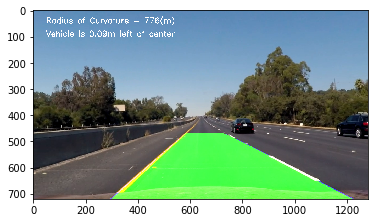

In [26]:
output_video = 'output_video.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(image_pipeline)
%time output_clip.write_videofile(output_video, audio=False)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [24]:
challenge_output_video = 'challenge_output_video.mp4'
challenge_clip = VideoFileClip("challenge_video.mp4")
challenge_output_clip = challenge_clip.fl_image(image_pipeline)
%time challenge_output_clip.write_videofile(challenge_output_video, audio=False)

Left coefficients:  [ -3.38539201e-03   3.01474425e+00  -2.03966490e+02]
Right coefficients:  [  2.57984757e-04  -4.99444094e-01   1.26364085e+03]
Left lane curve radius:  179.151020389 pixels
Right lane curve radius:  2110.04034941 pixels
[MoviePy] >>>> Building video challenge_output_video.mp4
[MoviePy] Writing video challenge_output_video.mp4


  0%|          | 1/485 [00:00<03:13,  2.50it/s]

Left coefficients:  [ -3.38539201e-03   3.01474425e+00  -2.03966490e+02]
Right coefficients:  [  2.57984757e-04  -4.99444094e-01   1.26364085e+03]
Left lane curve radius:  179.151020389 pixels
Right lane curve radius:  2110.04034941 pixels


  0%|          | 2/485 [00:00<03:18,  2.43it/s]

Left coefficients:  [  6.92985307e-04  -1.15099008e+00   8.48831649e+02]
Right coefficients:  [  3.08449178e-04  -5.39352351e-01   1.26930773e+03]
Left lane curve radius:  960.0620817 pixels
Right lane curve radius:  1752.36503213 pixels


  1%|          | 3/485 [00:01<03:14,  2.48it/s]

Left coefficients:  [  7.54088329e-04  -1.22012506e+00   8.69375529e+02]
Right coefficients:  [  3.01504778e-04  -5.33798755e-01   1.26834233e+03]
Left lane curve radius:  890.400658981 pixels
Right lane curve radius:  1794.37125244 pixels


  1%|          | 4/485 [00:01<03:09,  2.54it/s]

Left coefficients:  [  1.35437340e-04  -6.35747025e-01   7.31758030e+02]
Right coefficients:  [  2.76180789e-04  -5.16880208e-01   1.26950438e+03]
Left lane curve radius:  5161.28725912 pixels
Right lane curve radius:  1969.99789024 pixels


  1%|          | 5/485 [00:01<03:06,  2.57it/s]

Left coefficients:  [  9.46052340e-05  -6.24152494e-01   7.41459239e+02]
Right coefficients:  [  3.01230467e-04  -5.39814236e-01   1.27221899e+03]
Left lane curve radius:  7657.44112856 pixels
Right lane curve radius:  1803.58098565 pixels


  1%|          | 6/485 [00:02<03:04,  2.60it/s]

Left coefficients:  [ -3.84949165e-03   4.13605713e+00  -6.72244962e+02]
Right coefficients:  [  2.89892446e-04  -5.35323619e-01   1.27443163e+03]
Left lane curve radius:  146.210856299 pixels
Right lane curve radius:  1882.94315327 pixels


  1%|▏         | 7/485 [00:02<03:02,  2.62it/s]

Left coefficients:  [ -4.24277465e-03   4.69163457e+00  -8.56427225e+02]
Right coefficients:  [  3.24027718e-04  -5.66694643e-01   1.28031275e+03]
Left lane curve radius:  155.200197151 pixels
Right lane curve radius:  1681.36658426 pixels


  2%|▏         | 8/485 [00:03<03:02,  2.61it/s]

Left coefficients:  [ -5.79458220e-03   6.29781535e+00  -1.26367156e+03]
Right coefficients:  [  2.68288315e-04  -5.16261532e-01   1.27208910e+03]
Left lane curve radius:  121.060126277 pixels
Right lane curve radius:  2038.18005405 pixels


  2%|▏         | 9/485 [00:03<03:02,  2.61it/s]

Left coefficients:  [ -5.68141583e-04   1.06373775e+00  -1.10178223e+01]
Right coefficients:  [  2.57925286e-04  -5.08820006e-01   1.27239842e+03]
Left lane curve radius:  1223.45913393 pixels
Right lane curve radius:  2124.43873042 pixels


  2%|▏         | 10/485 [00:03<02:59,  2.64it/s]

Left coefficients:  [  5.98052222e-04  -1.28542318e+00   9.76909848e+02]
Right coefficients:  [  2.68043946e-04  -5.21228679e-01   1.27838259e+03]
Left lane curve radius:  1493.84139135 pixels
Right lane curve radius:  2047.5720999 pixels


  2%|▏         | 11/485 [00:04<03:00,  2.62it/s]

Left coefficients:  [ -7.49850530e-03   8.78448478e+00  -2.12912513e+03]
Right coefficients:  [ -5.76413337e-05  -2.19092375e-01   1.21740541e+03]
Left lane curve radius:  288.25951184 pixels
Right lane curve radius:  9689.61183562 pixels


  2%|▏         | 12/485 [00:04<02:59,  2.64it/s]

Left coefficients:  [  1.62206459e-04  -7.40170128e-01   8.08616185e+02]
Right coefficients:  [  2.64096635e-04  -5.27457898e-01   1.28800260e+03]
Left lane curve radius:  4749.58992385 pixels
Right lane curve radius:  2093.59428504 pixels


  3%|▎         | 13/485 [00:04<02:58,  2.65it/s]

Left coefficients:  [  4.70003456e-05  -5.97552100e-01   7.65172207e+02]
Right coefficients:  [  2.83873777e-04  -5.45247030e-01   1.29299729e+03]
Left lane curve radius:  15824.8348653 pixels
Right lane curve radius:  1944.88672899 pixels


  3%|▎         | 14/485 [00:05<02:57,  2.66it/s]

Left coefficients:  [ -2.97210383e-03   3.44891568e+00  -5.79985209e+02]
Right coefficients:  [ -7.41440207e-05  -2.03053194e-01   1.22030749e+03]
Left lane curve radius:  228.748587335 pixels
Right lane curve radius:  7535.63074555 pixels


  3%|▎         | 15/485 [00:05<02:55,  2.68it/s]

Left coefficients:  [ -1.00387870e-04  -3.88203815e-01   6.95174166e+02]
Right coefficients:  [  7.81057949e-05  -3.41714307e-01   1.24965472e+03]
Left lane curve radius:  6866.72182355 pixels
Right lane curve radius:  7080.29745754 pixels


  3%|▎         | 16/485 [00:06<02:55,  2.68it/s]

Left coefficients:  [ -3.31171649e-04  -9.83727765e-02   6.05481125e+02]
Right coefficients:  [  5.70786398e-05  -3.29671378e-01   1.25276696e+03]
Left lane curve radius:  1946.36406854 pixels
Right lane curve radius:  9754.13756795 pixels


  4%|▎         | 17/485 [00:06<02:54,  2.68it/s]

Left coefficients:  [ -2.75652660e-04  -1.46185835e-01   6.14580467e+02]
Right coefficients:  [  1.80269389e-04  -4.71756013e-01   1.29462243e+03]
Left lane curve radius:  2318.97911775 pixels
Right lane curve radius:  3134.52170507 pixels


  4%|▎         | 18/485 [00:06<03:04,  2.53it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1000, 1035, 1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1038,
       1038, 1038, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1040, 1040,
       1040, 1040, 1040, 1040, 1040, 1040, 1040, 1041, 1041, 1041, 1041,
       1042, 1042, 1042, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044,
       1044, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045, 1045, 1045,
       1045, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1046,
       1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046,
       1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1049, 10

  4%|▍         | 20/485 [00:07<02:57,  2.63it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1037, 1038, 1038, 1039, 1040, 1040, 1040, 1040, 1040, 1041, 1041,
       1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041,
       1041, 1041, 1041, 1041, 1041, 1042, 1042, 1042, 1042, 1042, 1042,
       1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042,
       1042, 1042, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1043,
       1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043,
       1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044, 1044,
       1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044,
       1045, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1046,
       1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1049, 1049, 1049, 1049, 1049, 1049,
       1049, 1049, 1049, 1049, 1050, 1050, 1050, 1050, 1050, 1050, 10

  4%|▍         | 21/485 [00:07<02:55,  2.65it/s]

Left coefficients:  [  5.41977116e-04  -1.13162394e+00   9.12158526e+02]
Right coefficients:  [ -5.91267715e-05  -1.54758453e-01   1.19763303e+03]
Left lane curve radius:  1443.34736483 pixels
Right lane curve radius:  9043.27442983 pixels


  5%|▍         | 22/485 [00:08<02:53,  2.66it/s]

Left coefficients:  [  6.51529723e-04  -1.29162989e+00   9.70822644e+02]
Right coefficients:  [ -4.47854962e-04   3.52155083e-01   1.03341352e+03]
Left lane curve radius:  1284.51406126 pixels
Right lane curve radius:  1131.80515136 pixels


  5%|▍         | 23/485 [00:08<02:51,  2.69it/s]

Left coefficients:  [  2.17488770e-04  -7.67496927e-01   8.12522252e+02]
Right coefficients:  [ -1.03781635e-03   1.04073685e+00   8.38904429e+02]
Left lane curve radius:  3417.46639044 pixels
Right lane curve radius:  481.786972165 pixels


  5%|▍         | 24/485 [00:09<02:51,  2.70it/s]

Left coefficients:  [  1.92633474e-04  -7.50877242e-01   8.15247251e+02]
Right coefficients:  [ -8.73224711e-04   9.13779018e-01   8.49621892e+02]
Left lane curve radius:  3899.0453839 pixels
Right lane curve radius:  574.003449084 pixels


  5%|▌         | 25/485 [00:09<02:50,  2.69it/s]

Left coefficients:  [  3.73748847e-04  -9.77437542e-01   8.89196417e+02]
Right coefficients:  [ -5.03109590e-04   5.20917844e-01   9.47837754e+02]
Left lane curve radius:  2132.16998868 pixels
Right lane curve radius:  994.292057202 pixels


  5%|▌         | 26/485 [00:09<02:51,  2.68it/s]

Left coefficients:  [  1.39425427e-04  -7.08269656e-01   8.17611745e+02]
Right coefficients:  [  5.75292819e-04  -7.50659639e-01   1.31579590e+03]
Left lane curve radius:  5460.7860644 pixels
Right lane curve radius:  909.522176138 pixels


  6%|▌         | 27/485 [00:10<02:50,  2.68it/s]

Left coefficients:  [ -4.87268788e-05  -4.76246328e-01   7.47849738e+02]
Right coefficients:  [ -1.70422904e-04   2.63014762e-01   9.71894972e+02]
Left lane curve radius:  14783.3063517 pixels
Right lane curve radius:  2971.68800903 pixels


  6%|▌         | 28/485 [00:10<02:49,  2.70it/s]

Left coefficients:  [ -9.58530906e-06  -5.22454339e-01   7.65908031e+02]
Right coefficients:  [ -7.53347646e-04   1.07666039e+00   6.88372490e+02]
Left lane curve radius:  75811.9162482 pixels
Right lane curve radius:  770.444767768 pixels


  6%|▌         | 29/485 [00:10<02:49,  2.69it/s]

Left coefficients:  [ -5.86927937e-05  -4.60316348e-01   7.48460602e+02]
Right coefficients:  [  2.75759061e-03  -3.46666052e+00   2.15181373e+03]
Left lane curve radius:  12183.3808111 pixels
Right lane curve radius:  334.028392407 pixels


  6%|▌         | 30/485 [00:11<02:50,  2.67it/s]

Left coefficients:  [ -3.40360620e-04  -1.07992183e-01   6.40266752e+02]
Right coefficients:  [  3.61196377e-03  -4.66022531e+00   2.56116236e+03]
Left lane curve radius:  1933.55346511 pixels
Right lane curve radius:  420.919864645 pixels


  6%|▋         | 31/485 [00:11<02:49,  2.69it/s]

Left coefficients:  [ -2.34499353e-04  -1.82431914e-01   6.45888843e+02]
Right coefficients:  [  3.38026491e-03  -4.54778367e+00   2.58488500e+03]
Left lane curve radius:  2711.67162348 pixels
Right lane curve radius:  537.331664018 pixels


  7%|▋         | 32/485 [00:12<02:52,  2.62it/s]

Left coefficients:  [ -2.08506776e-04  -1.89358074e-01   6.40884715e+02]
Right coefficients:  [ -1.83845259e-04   9.65685151e-02   1.08635111e+03]
Left lane curve radius:  2989.36822044 pixels
Right lane curve radius:  2750.81223402 pixels


  7%|▋         | 33/485 [00:12<03:01,  2.50it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1076, 1076, 1076, 1077, 1077, 1077, 1077, 1078, 1078, 1078, 1078,
       1078, 1079, 1079, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1080,
       1080, 1080, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1081, 1081,
       1081, 1081, 1081, 1081, 1081, 1081, 1082, 1082, 1082, 1082, 1082,
       1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082, 1083, 1083, 1083,
       1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1084, 1084, 1084,
       1084, 1084, 1084, 1084, 1084, 1084, 1084, 1084, 1084, 1085, 1085,
       1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085,
       1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086,
       1086, 1086, 1086, 1086, 1086, 1086, 1087, 1087, 1087, 1087, 1087,
       1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1088,
       1088, 1088, 1088, 1088, 1088, 1088, 1088, 1088, 1088, 1088, 1088,
       1088, 1088, 1088, 1089, 1089, 1089, 1089, 1089, 1089, 1089, 10

  7%|▋         | 34/485 [00:12<02:57,  2.54it/s]

Left coefficients:  [  1.06552729e-03  -1.82521206e+00   1.16522895e+03]
Right coefficients:  [ -7.63359052e-04   6.03391869e-01   1.00761777e+03]
Left lane curve radius:  929.400547452 pixels
Right lane curve radius:  680.301600651 pixels


  7%|▋         | 35/485 [00:13<03:04,  2.43it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1005, 1005, 1006, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009,
       1013, 1014, 1014, 1014, 1015, 1015, 1015, 1016, 1016, 1016, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1021,
       1022, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026,
       1027, 1027, 1028, 1028, 1029, 1030, 1030, 1031, 1067, 1068, 1072,
       1073, 1073, 1074, 1074, 1074, 1075, 1075, 1075, 1075, 1075, 1076,
       1076, 1076, 1076, 1076, 1076, 1076, 1076, 1076, 1076, 1076, 1076,
       1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077,
       1077, 1077, 1077, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078,
       1078, 1078, 1078, 1078, 1078, 1078, 1078, 1079, 1079, 1079, 1079,
       1079, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1080, 1080, 10

  7%|▋         | 36/485 [00:13<03:01,  2.48it/s]

Left coefficients:  [ -1.35768288e-03   1.05943289e+00   3.21695582e+02]
Right coefficients:  [ -1.74469119e-03   2.31226390e+00   3.29379564e+02]
Left lane curve radius:  418.490304343 pixels
Right lane curve radius:  435.679380894 pixels


  8%|▊         | 37/485 [00:14<03:06,  2.40it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


  8%|▊         | 38/485 [00:14<03:08,  2.37it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1039, 1040, 1040, 1040, 1041, 1041, 1041, 1042, 1042, 1042, 1043,
       1043, 1043, 1043, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045,
       1045, 1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1049, 1049, 1049, 1049,
       1049, 1049, 1049, 1049, 1049, 1049, 1049, 1050, 1050, 1050, 1050,
       1050, 1050, 1050, 1050, 1050, 1050, 1051, 1051, 1051, 1051, 1051,
       1051, 1051, 1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052,
       1052, 1052, 1052, 1052, 1052, 1052, 1052, 1052, 1052, 1053, 1053,
       1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053,
       1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054,
       1054, 1054, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1055,
       1055, 1055, 1055, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056,
       1056, 1056, 1056, 1056, 1056, 1056, 1057, 1057, 1057, 1057, 10

  8%|▊         | 39/485 [00:15<03:01,  2.45it/s]

Left coefficients:  [  1.50980426e-03  -2.48999188e+00   1.42137755e+03]
Right coefficients:  [  1.07815702e-03  -9.51330360e-01   1.23318850e+03]
Left lane curve radius:  909.261057171 pixels
Right lane curve radius:  474.988451033 pixels


  8%|▊         | 40/485 [00:15<02:57,  2.51it/s]

Left coefficients:  [  8.47513028e-04  -1.69707847e+00   1.18948755e+03]
Right coefficients:  [  1.45775524e-03  -1.33478761e+00   1.31313220e+03]
Left lane curve radius:  1332.85555428 pixels
Right lane curve radius:  350.802061041 pixels


  8%|▊         | 41/485 [00:15<02:52,  2.57it/s]

Left coefficients:  [  6.69234012e-04  -1.46053900e+00   1.11553650e+03]
Right coefficients:  [  1.79558997e-03  -1.63615324e+00   1.37786051e+03]
Left lane curve radius:  1549.31008609 pixels
Right lane curve radius:  289.14491234 pixels


  9%|▊         | 42/485 [00:16<02:49,  2.62it/s]

Left coefficients:  [  3.28827576e-04  -9.91406908e-01   9.62850237e+02]
Right coefficients:  [  2.16794940e-03  -2.03902914e+00   1.47061771e+03]
Left lane curve radius:  2624.81145351 pixels
Right lane curve radius:  236.406337455 pixels


  9%|▉         | 43/485 [00:16<03:28,  2.12it/s]

Left coefficients:  [  5.05934605e-04  -1.21638720e+00   1.03941682e+03]
Right coefficients:  [  9.41388645e-04  -7.67190422e-01   1.19502956e+03]
Left lane curve radius:  1824.18579439 pixels
Right lane curve radius:  555.488488918 pixels


  9%|▉         | 44/485 [00:17<03:23,  2.17it/s]

Left coefficients:  [  3.35172890e-04  -1.01527326e+00   9.85463272e+02]
Right coefficients:  [  8.82601144e-04  -7.34367296e-01   1.19774862e+03]
Left lane curve radius:  2638.52490513 pixels
Right lane curve radius:  585.281539392 pixels


  9%|▉         | 45/485 [00:17<03:26,  2.14it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 993,  993,  994,  994,  995,  995,  995,  996,  996,  996,  997,
        997,  997,  997,  998,  998,  998,  998,  999,  999,  999,  999,
        999,  999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1002, 1002,
       1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1004, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005,
       1005, 1006, 1040, 1040, 1041, 1041, 1042, 1044, 1045, 1046, 1049,
       1050, 1052, 1055, 1056, 1056, 1057, 1057, 1058, 1058, 1058, 1059,
       1059, 1060, 1062, 1062, 1097, 1097, 1098, 1105, 1105, 1105, 1106,
       1106, 1107, 1107, 1107, 1108, 1109, 1110, 1110, 1111, 1111, 1111,
       1113, 1113, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1115, 11

  9%|▉         | 46/485 [00:18<03:35,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1010, 1010, 1011, 1011, 1012, 1012, 1012, 1012, 1013, 1013, 1013,
       1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014, 1015, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1017, 1017,
       1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1022,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1027,
       1027, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028,
       1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
       1028, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 10

 10%|▉         | 47/485 [00:18<03:36,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1004, 1004, 1004, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1011, 1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012,
       1012, 1012, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014,
       1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018,
       1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019, 1019, 1019,
       1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 10

 10%|▉         | 48/485 [00:19<03:38,  2.00it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1001, 1001, 1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003,
       1003, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008,
       1008, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1011, 1011, 1011,
       1011, 1011, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1013,
       1013, 1013, 1013, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014,
       1014, 1014, 1014, 1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017,
       1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018,
       1018, 1018, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 10

 10%|█         | 49/485 [00:19<03:28,  2.09it/s]

Left coefficients:  [ -1.50498277e-03   2.73719014e-01   3.95440013e+02]
Right coefficients:  [  7.14330781e-04  -7.90366219e-01   1.22394353e+03]
Left lane curve radius:  1325.88889135 pixels
Right lane curve radius:  706.034676908 pixels


 10%|█         | 50/485 [00:20<03:38,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 11%|█         | 51/485 [00:20<03:30,  2.06it/s]

Left coefficients:  [  1.12065829e-04  -7.64577353e-01   9.44403162e+02]
Right coefficients:  [  2.65274781e-03  -1.70647354e+00   1.33457777e+03]
Left lane curve radius:  7595.76631817 pixels
Right lane curve radius:  491.855330106 pixels


 11%|█         | 52/485 [00:21<03:31,  2.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 875,  875,  875,  876,  876,  876,  877,  877,  877,  877,  878,
        878,  878,  878,  879,  879,  879,  879,  880,  880,  978,  978,
        978,  978,  979,  979,  979,  979,  979,  979,  979,  980,  980,
        980,  980,  980,  980,  980,  980,  981,  981,  981,  981,  981,
        981,  982,  982,  982,  982,  982,  982,  983,  983,  983,  983,
        983,  984,  984,  984,  984,  984,  984,  984,  984,  985,  985,
        985,  985,  985,  985,  985,  985,  985,  985,  985,  986,  986,
        986,  986,  986,  986,  986,  986,  986,  986,  986,  986,  986,
        986,  987,  987,  987,  987,  987,  987,  987,  987,  987,  987,
        987,  988,  988,  988,  988,  988,  988,  988,  988,  989,  989,
        989,  989,  989,  989,  989,  990,  990,  990,  990,  990,  990,
        991,  991,  991,  991,  991,  992,  992,  992,  992,  993,  993,
        993,  993,  993,  993,  994,  994,  994,  994,  994,  994,  9

 11%|█         | 53/485 [00:21<03:30,  2.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 867,  867,  868,  868,  868,  869,  869,  869,  870,  870,  870,
        870,  871,  871,  871,  871,  872,  872,  872,  872,  873,  873,
        873,  873,  874,  874,  874,  874,  875,  875,  875,  875,  876,
        876,  876,  877,  877,  877,  878,  878,  879,  879,  880,  880,
        973,  973,  973,  974,  974,  974,  975,  975,  975,  975,  975,
        976,  976,  976,  976,  976,  976,  976,  976,  977,  977,  977,
        977,  977,  977,  977,  977,  977,  977,  978,  978,  978,  978,
        978,  978,  978,  979,  979,  979,  979,  980,  980,  981,  982,
        982,  982,  982,  983,  983,  983,  983,  983,  983,  984,  984,
        984,  984,  984,  984,  985,  985,  985,  985,  986,  986,  986,
        986,  987,  987,  987,  987,  987,  988,  988,  988,  989,  989,
        989,  989,  989,  989,  990,  990,  990,  990,  990,  990,  990,
        990,  990,  990,  990,  990,  991,  991,  991,  991,  991,  9

 11%|█         | 54/485 [00:22<03:39,  1.96it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 865,  865,  866,  866,  866,  867,  867,  867,  868,  868,  868,
        869,  869,  869,  869,  870,  870,  870,  871,  871,  871,  871,
        872,  872,  872,  873,  873,  873,  873,  874,  874,  874,  874,
        875,  875,  875,  876,  876,  876,  877,  877,  877,  878,  878,
        879,  879,  972,  973,  973,  973,  974,  974,  974,  974,  975,
        975,  975,  976,  976,  976,  976,  976,  977,  977,  977,  977,
        977,  978,  978,  978,  978,  979,  980,  980,  981,  982,  983,
        983,  983,  983,  984,  984,  984,  984,  985,  985,  985,  985,
        986,  986,  986,  986,  987,  987,  987,  987,  988,  988,  988,
        988,  989,  989,  989,  989,  989,  989,  989,  989,  990,  990,
        990,  990,  990,  990,  990,  990,  990,  990,  990,  990,  990,
        990,  990,  991,  991,  991,  991,  991,  991,  991,  991,  991,
        991,  991,  991,  991,  991,  991,  991,  991,  991,  991,  9

 11%|█▏        | 55/485 [00:22<03:28,  2.07it/s]

Left coefficients:  [  1.49877353e-04  -7.96417405e-01   9.68392152e+02]
Right coefficients:  [  5.60997879e-03  -3.71398506e+00   1.67333149e+03]
Left lane curve radius:  5633.19502951 pixels
Right lane curve radius:  877.824304125 pixels


 12%|█▏        | 56/485 [00:23<03:19,  2.15it/s]

Left coefficients:  [  5.25925033e-05  -6.76179352e-01   9.36569447e+02]
Right coefficients:  [ -3.72434378e-04  -6.07181898e-02   1.11536516e+03]
Left lane curve radius:  15560.8790803 pixels
Right lane curve radius:  1737.54925863 pixels


 12%|█▏        | 57/485 [00:23<03:29,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 12%|█▏        | 58/485 [00:24<03:21,  2.12it/s]

Left coefficients:  [  1.83167759e-04  -8.35832867e-01   9.96466274e+02]
Right coefficients:  [  9.13397602e-04  -9.86104930e-01   1.27816723e+03]
Left lane curve radius:  4648.22725519 pixels
Right lane curve radius:  551.753147543 pixels


 12%|█▏        | 59/485 [00:24<03:14,  2.19it/s]

Left coefficients:  [ -1.58511695e-04  -4.12788503e-01   8.71847332e+02]
Right coefficients:  [  8.73835690e-04  -9.80998214e-01   1.28336571e+03]
Left lane curve radius:  4818.50777846 pixels
Right lane curve radius:  582.074571806 pixels


 12%|█▏        | 60/485 [00:25<03:17,  2.15it/s]

Left coefficients:  [  1.30086755e-04  -7.70576409e-01   9.86106075e+02]
Right coefficients:  [  1.16102748e-03  -1.16870853e+00   1.31197524e+03]
Left lane curve radius:  6436.80661545 pixels
Right lane curve radius:  430.691141879 pixels


 13%|█▎        | 61/485 [00:25<03:11,  2.22it/s]

Left coefficients:  [  3.79057098e-04  -1.06308924e+00   1.07515986e+03]
Right coefficients:  [  1.15646166e-03  -1.16865492e+00   1.31760995e+03]
Left lane curve radius:  2345.90307916 pixels
Right lane curve radius:  432.449709462 pixels


 13%|█▎        | 62/485 [00:25<03:08,  2.24it/s]

Left coefficients:  [  3.61936031e-04  -1.04425599e+00   1.07400239e+03]
Right coefficients:  [  6.71442677e-04  -9.21180087e-01   1.29620384e+03]
Left lane curve radius:  2451.00289188 pixels
Right lane curve radius:  815.406198127 pixels


 13%|█▎        | 63/485 [00:26<03:09,  2.23it/s]

Left coefficients:  [  4.83714901e-04  -1.20039163e+00   1.12904887e+03]
Right coefficients:  [  2.82172161e-03  -1.68909232e+00   1.36610936e+03]
Left lane curve radius:  1924.900161 pixels
Right lane curve radius:  611.183543628 pixels


 13%|█▎        | 64/485 [00:26<03:03,  2.29it/s]

Left coefficients:  [  1.52959193e-04  -8.14992376e-01   1.02303769e+03]
Right coefficients:  [  1.73890691e-03  -1.48998453e+00   1.37417235e+03]
Left lane curve radius:  5638.49472587 pixels
Right lane curve radius:  314.671458375 pixels


 13%|█▎        | 65/485 [00:27<03:09,  2.21it/s]

Left coefficients:  [  1.95976949e-04  -8.57579586e-01   1.03844118e+03]
Right coefficients:  [  9.88451053e-04  -1.18168103e+00   1.34736592e+03]
Left lane curve radius:  4398.20633493 pixels
Right lane curve radius:  534.435325708 pixels


 14%|█▎        | 66/485 [00:27<03:06,  2.24it/s]

Left coefficients:  [  1.35812417e-04  -7.86813234e-01   1.02338762e+03]
Right coefficients:  [  8.23700174e-04  -1.09491189e+00   1.33913102e+03]
Left lane curve radius:  6254.67797665 pixels
Right lane curve radius:  675.20831021 pixels


 14%|█▍        | 67/485 [00:28<03:02,  2.29it/s]

Left coefficients:  [  2.91534677e-04  -9.71337133e-01   1.08320576e+03]
Right coefficients:  [  4.44064155e-04  -8.12075450e-01   1.29439299e+03]
Left lane curve radius:  3032.21073718 pixels
Right lane curve radius:  1362.27930954 pixels


 14%|█▍        | 68/485 [00:28<02:58,  2.34it/s]

Left coefficients:  [  2.32731217e-04  -8.93251487e-01   1.06252687e+03]
Right coefficients:  [  8.41144759e-04  -1.10425501e+00   1.34672020e+03]
Left lane curve radius:  3698.08782888 pixels
Right lane curve radius:  657.209961919 pixels


 14%|█▍        | 69/485 [00:28<03:04,  2.26it/s]

Left coefficients:  [  2.29433794e-04  -8.94998804e-01   1.07086350e+03]
Right coefficients:  [  1.40146804e-03  -1.37727044e+00   1.37959449e+03]
Left lane curve radius:  3777.47528709 pixels
Right lane curve radius:  357.082139834 pixels


 14%|█▍        | 70/485 [00:29<03:01,  2.29it/s]

Left coefficients:  [  1.34067334e-04  -7.70144014e-01   1.03506606e+03]
Right coefficients:  [  8.22179110e-03  -8.48959092e+00   2.95420852e+03]
Left lane curve radius:  6208.30482486 pixels
Right lane curve radius:  67.4720009027 pixels


 15%|█▍        | 71/485 [00:29<02:58,  2.32it/s]

Left coefficients:  [  7.44839339e-05  -6.91032542e-01   1.01385409e+03]
Right coefficients:  [  5.16833016e-04  -8.97253712e-01   1.32604665e+03]
Left lane curve radius:  10883.9972896 pixels
Right lane curve radius:  1184.86427935 pixels


 15%|█▍        | 72/485 [00:30<03:14,  2.13it/s]

Init no peaks for left or right
left_x:  [array([566, 567, 568, 568, 569, 569, 569, 570, 570, 570, 570, 570, 571,
       571, 571, 571, 571, 572, 572, 572, 573, 573, 573, 573, 574, 574,
       574, 574, 574, 575, 575, 575, 575, 575, 576, 576, 576, 576, 576,
       577, 577, 577, 577, 578, 578, 578, 578, 578, 578, 579, 579, 579,
       579, 579, 579, 580, 580, 580, 580, 581, 581, 581, 581, 581, 582,
       582, 582, 582, 582, 583, 583, 583, 583, 584, 584, 584, 584, 585,
       585, 585, 585, 585, 586, 586, 586, 586, 586, 587, 587, 587, 587,
       588, 588, 588, 588, 588, 588, 588, 589, 589, 589, 589, 590, 590,
       590, 590, 591, 591, 591, 591, 592, 592, 592, 592, 592, 593, 593,
       593, 593, 594, 594, 594, 594, 595, 595, 595, 595, 595, 596, 596,
       596, 596, 596, 597, 597, 597, 597, 597, 597, 598, 598, 598, 598,
       598, 598, 599, 599, 599, 599, 599, 599, 600, 600, 600, 600, 600,
       601, 601, 601, 601, 601, 602, 602, 602, 602, 602, 602, 603, 603,
       603, 603, 603, 

 15%|█▌        | 73/485 [00:30<03:11,  2.15it/s]

Left coefficients:  [  1.28052408e-04  -7.35952238e-01   1.02905673e+03]
Right coefficients:  [ -1.91518029e-03   8.38566204e-01   1.03125284e+03]
Left lane curve radius:  6258.1415935 pixels
Right lane curve radius:  828.264104466 pixels


 15%|█▌        | 74/485 [00:31<03:21,  2.04it/s]

Left coefficients:  [  1.66352830e-04  -7.78173920e-01   1.04432498e+03]
Right coefficients:  [ -2.77605144e-03   1.48966239e+00   9.16211063e+02]
Left lane curve radius:  4842.54875745 pixels
Right lane curve radius:  779.093209679 pixels


 15%|█▌        | 75/485 [00:31<03:24,  2.01it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([632, 632, 633, 633, 633, 634, 634, 634, 634, 634, 634, 634, 635,
       635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 637, 637,
       637, 637, 638, 638, 638, 638, 638, 639, 639, 639, 639, 639, 639,
       639, 640, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641,
       641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643,
       643, 644, 645, 646, 647, 647, 647, 647, 648, 648, 648, 648, 649,
       649, 649, 649, 649, 650, 650, 650, 650, 651, 651, 651, 652, 652,
       652, 652, 653, 653, 653, 653, 653, 653, 654, 654, 654, 654, 654,
       655, 655, 656, 656, 656, 656, 656, 657, 657, 657, 671, 672, 672,
       674, 674, 675, 675, 675, 675, 676, 676, 676, 676, 677, 677, 677,
       677, 677, 677, 678, 678, 678, 678, 678, 678, 678, 679, 679, 679,
       679, 680, 680, 680, 681, 681, 681, 681, 681, 682, 682, 682, 682,
       682, 683, 683, 683, 683, 684, 684, 684, 684, 684, 684, 684, 684,
       68

 16%|█▌        | 76/485 [00:32<03:14,  2.10it/s]

Left coefficients:  [  4.09882477e-04  -1.04944446e+00   1.12512690e+03]
Right coefficients:  [ -4.12720311e-03   1.54962597e+00   1.09579228e+03]
Left lane curve radius:  2040.30653656 pixels
Right lane curve radius:  2560.27721127 pixels


 16%|█▌        | 77/485 [00:32<03:15,  2.08it/s]

Left coefficients:  [ -7.07876572e-04   2.00591032e-02   4.92327654e+02]
Right coefficients:  [ -4.96824438e-03   2.25340220e+00   9.90060804e+02]
Left lane curve radius:  1262.86712146 pixels
Right lane curve radius:  2437.15913811 pixels


 16%|█▌        | 78/485 [00:33<03:07,  2.17it/s]

Left coefficients:  [  3.66530968e-04  -9.88075111e-01   1.11021121e+03]
Right coefficients:  [  4.52412074e-04  -8.91006706e-01   1.36075945e+03]
Left lane curve radius:  2226.65643168 pixels
Right lane curve radius:  1438.9635221 pixels


 16%|█▋        | 79/485 [00:33<03:08,  2.15it/s]

Left coefficients:  [ -2.79877266e-03   4.34503567e+00  -1.02759179e+03]
Right coefficients:  [  1.23312308e-02  -9.23718846e+00   2.56402008e+03]
Left lane curve radius:  1115.52801776 pixels
Right lane curve radius:  1394.01347277 pixels


 16%|█▋        | 80/485 [00:34<03:04,  2.19it/s]

Left coefficients:  [ -2.24168069e-04   1.58421038e+00  -3.24513690e+02]
Right coefficients:  [  1.23238934e-02  -9.69405728e+00   2.73139504e+03]
Left lane curve radius:  10729.9676377 pixels
Right lane curve radius:  903.61590727 pixels


 17%|█▋        | 81/485 [00:34<03:02,  2.22it/s]

Left coefficients:  [  2.80163298e-03  -1.80864157e+00   5.93713390e+02]
Right coefficients:  [  1.27016737e-02  -1.05290438e+01   2.98779454e+03]
Left lane curve radius:  499.503010592 pixels
Right lane curve radius:  538.566846364 pixels


 17%|█▋        | 82/485 [00:35<03:06,  2.16it/s]

Left coefficients:  [  1.36801497e-03  -2.22547102e-01   1.62617235e+02]
Right coefficients:  [  1.13048593e-02  -9.56363898e+00   2.83298352e+03]
Left lane curve radius:  1284.95561545 pixels
Right lane curve radius:  358.06435342 pixels


 17%|█▋        | 83/485 [00:35<03:02,  2.20it/s]

Left coefficients:  [  9.11276725e-04  -1.54247039e+00   8.62084674e+02]
Right coefficients:  [  3.35347921e-04  -7.96109094e-01   1.35786094e+03]
Left lane curve radius:  907.338597898 pixels
Right lane curve radius:  1990.1692204 pixels


 17%|█▋        | 84/485 [00:35<02:59,  2.23it/s]

Left coefficients:  [ -8.32003123e-04   4.77261335e-01   2.75971092e+02]
Right coefficients:  [  8.91735132e-03  -8.62943699e+00   2.87048548e+03]
Left lane curve radius:  717.895224243 pixels
Right lane curve radius:  63.1849212519 pixels


 18%|█▊        | 85/485 [00:36<03:03,  2.18it/s]

Left coefficients:  [  3.23292519e-03  -2.46609847e+00   8.66960906e+02]
Right coefficients:  [  1.05713598e-02  -1.04047197e+01   3.32165668e+03]
Left lane curve radius:  309.49926565 pixels
Right lane curve radius:  49.2813253479 pixels


 18%|█▊        | 86/485 [00:36<02:59,  2.23it/s]

Left coefficients:  [ -7.48770231e-03   9.51767453e+00  -2.38386519e+03]
Right coefficients:  [  3.73373656e-04  -8.22124416e-01   1.36460573e+03]
Left lane curve radius:  773.79609243 pixels
Right lane curve radius:  1763.37806591 pixels


 18%|█▊        | 87/485 [00:37<03:00,  2.21it/s]

Left coefficients:  [ -4.95060352e-05  -4.56678081e-01   9.73757417e+02]
Right coefficients:  [ -6.36126930e-04   4.77021886e-01   9.48393413e+02]
Left lane curve radius:  14220.3942232 pixels
Right lane curve radius:  816.040695655 pixels


 18%|█▊        | 88/485 [00:37<02:56,  2.25it/s]

Left coefficients:  [ -9.52413729e-03   1.22249843e+01  -3.25709272e+03]
Right coefficients:  [  5.95780497e-03  -7.71258804e+00   3.14930151e+03]
Left lane curve radius:  1254.10968095 pixels
Right lane curve radius:  691.442991539 pixels


 18%|█▊        | 89/485 [00:38<02:58,  2.22it/s]

Left coefficients:  [  3.25978671e-03  -2.63971768e+00   9.50919230e+02]
Right coefficients:  [  6.91508453e-03  -8.85622252e+00   3.49066884e+03]
Left lane curve radius:  249.869638434 pixels
Right lane curve radius:  752.799224632 pixels


 19%|█▊        | 90/485 [00:38<02:55,  2.25it/s]

Left coefficients:  [  3.65537100e-03  -2.87635928e+00   9.65502249e+02]
Right coefficients:  [  7.35454675e-03  -9.48042180e+00   3.70858124e+03]
Left lane curve radius:  278.615517021 pixels
Right lane curve radius:  881.546796681 pixels


 19%|█▉        | 91/485 [00:39<02:56,  2.23it/s]

Left coefficients:  [  1.05014510e-03  -1.82582901e-01   3.66076621e+02]
Right coefficients:  [ -2.31557865e-03   6.29340317e-01   1.20458576e+03]
Left lane curve radius:  1104.76207501 pixels
Right lane curve radius:  1626.98594063 pixels


 19%|█▉        | 92/485 [00:39<02:57,  2.21it/s]

Left coefficients:  [  3.57329181e-03  -2.75987421e+00   9.69380239e+02]
Right coefficients:  [  9.88696625e-04  -2.02240353e+00   1.55561381e+03]
Left lane curve radius:  299.716147739 pixels
Right lane curve radius:  1504.54776191 pixels


 19%|█▉        | 93/485 [00:39<02:54,  2.24it/s]

Left coefficients:  [  2.93439267e-03  -2.04596989e+00   7.69716235e+02]
Right coefficients:  [ -3.03340764e-03   1.32243709e+00   1.08360152e+03]
Left lane curve radius:  407.825815565 pixels
Right lane curve radius:  1282.92211294 pixels


 19%|█▉        | 94/485 [00:40<02:56,  2.21it/s]

Left coefficients:  [  3.35900953e-03  -2.55468444e+00   9.05289531e+02]
Right coefficients:  [ -3.14946714e-04  -6.77396011e-01   1.31479682e+03]
Left lane curve radius:  314.611779144 pixels
Right lane curve radius:  4439.04652649 pixels


 20%|█▉        | 95/485 [00:40<02:54,  2.24it/s]

Left coefficients:  [  4.10109201e-03  -3.52662626e+00   1.14624596e+03]
Right coefficients:  [ -3.22528609e-03   1.64872655e+00   9.81464380e+02]
Left lane curve radius:  187.005031716 pixels
Right lane curve radius:  1008.80415842 pixels


 20%|█▉        | 96/485 [00:41<02:54,  2.23it/s]

Left coefficients:  [  3.21238415e-05  -6.40795182e-01   6.60845339e+02]
Right coefficients:  [ -2.69765447e-03   9.46414775e-01   1.10924449e+03]
Left lane curve radius:  24971.9216446 pixels
Right lane curve radius:  1520.09029153 pixels


 20%|██        | 97/485 [00:41<02:55,  2.21it/s]

Left coefficients:  [  2.88942744e-04  -9.11100378e-01   7.43438635e+02]
Right coefficients:  [  1.14776314e-02  -1.10953411e+01   3.40227970e+03]
Left lane curve radius:  2826.90057683 pixels
Right lane curve radius:  53.4536731564 pixels


 20%|██        | 98/485 [00:42<02:57,  2.18it/s]

Left coefficients:  [  1.60704303e-04  -7.94405022e-01   7.22290626e+02]
Right coefficients:  [  1.32756411e-02  -1.25260551e+01   3.72588609e+03]
Left lane curve radius:  5162.5914481 pixels
Right lane curve radius:  73.5166404023 pixels


 20%|██        | 99/485 [00:42<02:54,  2.22it/s]

Left coefficients:  [  6.94072257e-03  -6.44196470e+00   1.88958508e+03]
Right coefficients:  [  4.06224296e-03  -3.34470789e+00   1.48852548e+03]
Left lane curve radius:  100.52717578 pixels
Right lane curve radius:  229.488740813 pixels


 21%|██        | 100/485 [00:43<02:51,  2.24it/s]

Left coefficients:  [  6.65451583e-03  -6.01454571e+00   1.74578890e+03]
Right coefficients:  [  3.79448705e-03  -3.20344001e+00   1.46580950e+03]
Left lane curve radius:  125.74180858 pixels
Right lane curve radius:  206.536770266 pixels


 21%|██        | 101/485 [00:43<02:54,  2.21it/s]

Left coefficients:  [  4.92353674e-03  -4.31333309e+00   1.32912302e+03]
Right coefficients:  [ -2.56743268e-03   2.54552088e+00   4.29423803e+02]
Left lane curve radius:  163.263625049 pixels
Right lane curve radius:  194.887345229 pixels
Left coefficients:  [  2.94802128e-04  -8.57022156e-01   7.06018815e+02]
Right coefficients:  [ -5.77765621e-03   3.89100626e+00   3.00369049e+02]
Left lane curve radius:  2560.75746662 pixels
Right lane curve radius:  842.532596039 pixels


 21%|██        | 102/485 [00:44<03:33,  1.80it/s]

Left coefficients:  [  2.68378062e-04  -8.20111093e-01   6.90387542e+02]
Right coefficients:  [ -4.23983344e-03   2.81995139e+00   4.60165777e+02]
Left lane curve radius:  2775.51667392 pixels
Right lane curve radius:  617.706632402 pixels


 21%|██        | 103/485 [00:45<04:05,  1.55it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([686, 686, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 694,
       694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 696, 696,
       696, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 699, 699, 699, 699, 699,
       699, 699, 699, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701,
       701, 701, 701, 702, 702, 702, 702, 703, 707, 708, 708, 708, 708,
       708, 709, 709, 709, 709, 709, 710, 712, 712, 712, 713, 713, 713,
       713, 713, 713, 714, 714, 714, 714, 714, 714, 714, 715, 715, 715,
       715, 715, 715, 715, 715, 716, 716, 716, 716, 716, 716, 716, 717,
       717, 717, 717, 717, 717, 717, 717, 718, 718, 718, 718, 718, 718,
       718, 718, 719, 719, 719, 719, 719, 719, 719, 720, 720, 720, 720,
       720, 720, 720, 721, 721, 721, 721, 721, 721, 721, 721, 722, 722,
       722, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 723,
       72

 21%|██▏       | 104/485 [00:46<04:41,  1.35it/s]

Left coefficients:  [  2.67324037e-04  -7.80571976e-01   6.57054011e+02]
Right coefficients:  [ -3.93850385e-03   2.67646404e+00   4.63895867e+02]
Left lane curve radius:  2656.16709234 pixels
Right lane curve radius:  530.002978367 pixels


 22%|██▏       | 105/485 [00:47<04:52,  1.30it/s]

Left coefficients:  [  2.61530332e-04  -7.67930087e-01   6.48046121e+02]
Right coefficients:  [  2.57276586e-03  -2.72880100e+00   1.52661174e+03]
Left lane curve radius:  2692.53240221 pixels
Right lane curve radius:  201.483907997 pixels


 22%|██▏       | 107/485 [00:48<04:47,  1.32it/s]

Left coefficients:  [  3.45807118e-04  -8.44918768e-01   6.61919957e+02]
Right coefficients:  [  7.25115767e-03  -5.40353513e+00   1.83416259e+03]
Left lane curve radius:  2018.54472209 pixels
Right lane curve radius:  639.393484089 pixels


 22%|██▏       | 108/485 [00:48<04:09,  1.51it/s]

Left coefficients:  [  5.23733989e-03  -4.29928139e+00   1.25307025e+03]
Right coefficients:  [  2.92908160e-03  -3.17407927e+00   1.63539136e+03]
Left lane curve radius:  246.082083437 pixels
Right lane curve radius:  186.299629714 pixels


 22%|██▏       | 109/485 [00:49<03:47,  1.65it/s]

Left coefficients:  [  5.63874863e-03  -4.84106706e+00   1.40482834e+03]
Right coefficients:  [  3.23352219e-03  -3.49441477e+00   1.71188355e+03]
Left lane curve radius:  185.600879244 pixels
Right lane curve radius:  170.68314895 pixels


 23%|██▎       | 110/485 [00:49<03:28,  1.80it/s]

Left coefficients:  [  3.93478908e-03  -2.95904896e+00   9.13043992e+02]
Right coefficients:  [  2.84734105e-03  -3.39943986e+00   1.78305504e+03]
Left lane curve radius:  346.570207375 pixels
Right lane curve radius:  261.729678149 pixels


 23%|██▎       | 111/485 [00:50<03:18,  1.89it/s]

Left coefficients:  [ -2.87584059e-03   4.53397913e+00  -1.03323276e+03]
Right coefficients:  [  3.88614041e-03  -4.60427138e+00   2.04716367e+03]
Left lane curve radius:  1262.26903631 pixels
Right lane curve radius:  240.091388862 pixels


 23%|██▎       | 112/485 [00:50<03:04,  2.02it/s]

Left coefficients:  [  3.27143568e-04  -8.56647326e-01   1.09132785e+03]
Right coefficients:  [  9.05783288e-03  -8.55889492e+00   2.77514518e+03]
Left lane curve radius:  2214.30277494 pixels
Right lane curve radius:  77.0473289442 pixels


 23%|██▎       | 113/485 [00:51<02:59,  2.07it/s]

Left coefficients:  [ -4.83086053e-03   6.95222568e+00  -1.81628295e+03]
Right coefficients:  [  1.03594143e-02  -1.00973990e+01   3.20181949e+03]
Left lane curve radius:  1335.09465309 pixels
Right lane curve radius:  53.3198935908 pixels


 24%|██▎       | 114/485 [00:51<02:57,  2.10it/s]

Left coefficients:  [ -2.37306914e-03   4.21947499e+00  -1.08783666e+03]
Right coefficients:  [  9.80984995e-03  -9.73335627e+00   3.15262736e+03]
Left lane curve radius:  1950.74932757 pixels
Right lane curve radius:  51.4171855376 pixels


 24%|██▎       | 115/485 [00:52<02:51,  2.16it/s]

Left coefficients:  [  3.07383811e-03  -2.01805406e+00   6.43686993e+02]
Right coefficients:  [  9.38046777e-03  -9.55107355e+00   3.17027234e+03]
Left lane curve radius:  500.214167042 pixels
Right lane curve radius:  55.6462475575 pixels


 24%|██▍       | 116/485 [00:52<02:53,  2.13it/s]

Left coefficients:  [  9.64674563e-04  -1.59772419e+00   8.84050641e+02]
Right coefficients:  [  5.17074292e-03  -6.20494005e+00   2.54415058e+03]
Left lane curve radius:  859.272619985 pixels
Right lane curve radius:  287.895754368 pixels


 24%|██▍       | 117/485 [00:53<02:47,  2.20it/s]

Left coefficients:  [  1.05914940e-03  -1.74657990e+00   9.39720718e+02]
Right coefficients:  [  5.35960818e-03  -6.87154026e+00   2.87673697e+03]
Left lane curve radius:  843.572843465 pixels
Right lane curve radius:  555.681745926 pixels


 24%|██▍       | 118/485 [00:53<02:47,  2.20it/s]

Left coefficients:  [  1.26756959e-03  -2.03473491e+00   1.04169674e+03]
Right coefficients:  [  6.20827707e-03  -7.92075041e+00   3.20065957e+03]
Left lane curve radius:  789.762478726 pixels
Right lane curve radius:  628.076825336 pixels


 25%|██▍       | 119/485 [00:53<02:47,  2.18it/s]

Left coefficients:  [  1.38910238e-03  -2.25141143e+00   1.13460663e+03]
Right coefficients:  [  7.32484337e-03  -9.36424568e+00   3.66353063e+03]
Left lane curve radius:  828.700128583 pixels
Right lane curve radius:  799.908621558 pixels


 25%|██▍       | 120/485 [00:54<02:46,  2.19it/s]

Left coefficients:  [  1.33034111e-03  -2.25852354e+00   1.16718875e+03]
Right coefficients:  [  6.86184368e-03  -8.98681345e+00   3.61292571e+03]
Left lane curve radius:  954.573712405 pixels
Right lane curve radius:  943.856792489 pixels


 25%|██▍       | 121/485 [00:54<02:47,  2.18it/s]

Left coefficients:  [  1.99339304e-03  -3.13063326e+00   1.45565546e+03]
Right coefficients:  [  6.49233374e-03  -9.20381669e+00   3.92073262e+03]
Left lane curve radius:  871.109451494 pixels
Right lane curve radius:  1858.94181904 pixels


 25%|██▌       | 122/485 [00:55<02:42,  2.24it/s]

Left coefficients:  [  1.38903977e-03  -2.23942929e+00   1.15069663e+03]
Right coefficients:  [  4.04504543e-03  -4.40803877e+00   2.23905609e+03]
Left lane curve radius:  814.225351752 pixels
Right lane curve radius:  148.826583225 pixels


 25%|██▌       | 123/485 [00:55<02:41,  2.25it/s]

Left coefficients:  [  4.86686915e-03  -6.63753769e+00   2.53827814e+03]
Right coefficients:  [  1.17414656e-03  -1.46759384e+00   1.48644240e+03]
Left lane curve radius:  863.92428062 pixels
Right lane curve radius:  482.013492988 pixels


 26%|██▌       | 124/485 [00:56<02:42,  2.22it/s]

Left coefficients:  [  4.58570909e-03  -6.22108245e+00   2.40066739e+03]
Right coefficients:  [ -4.65159520e-04   2.59464900e-01   1.03162658e+03]
Left lane curve radius:  767.982479163 pixels
Right lane curve radius:  1143.83562836 pixels


 26%|██▌       | 125/485 [00:56<02:47,  2.15it/s]

Init no peaks for left or right
left_x:  [array([237, 238, 238, 240, 241, 242, 243, 245, 251, 252, 253, 255, 255,
       256, 256, 263, 263, 264, 264, 265, 265, 266, 266, 266, 266, 267,
       267, 267, 267, 268, 268, 268, 268, 269, 269, 269, 269, 269, 270,
       270, 270, 270, 270, 271, 271, 271, 273, 274, 274, 275, 275, 275,
       276, 276, 277, 277, 278, 281, 282, 283, 284, 284, 285, 285, 286,
       286, 287, 288, 288, 288, 288, 289, 289, 289, 290, 290, 290, 290,
       291, 291, 291, 291, 292, 292, 292, 292, 292, 293, 293, 293, 294,
       294, 295, 295, 296, 296, 297, 297, 298, 298, 299, 299, 300, 301,
       301, 302, 302, 303, 304, 306, 306, 307, 307, 308, 308, 309, 309,
       309, 309, 310, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312,
       312, 312, 313, 313, 313, 313, 313, 314, 314, 314, 315, 317, 318,
       319, 319, 323, 326, 327, 327, 328, 328, 328, 329, 329, 330, 331,
       331, 332, 332, 333, 334, 336, 337, 340, 343, 344, 344, 344, 345,
       345, 345, 345, 

 26%|██▌       | 126/485 [00:57<02:55,  2.05it/s]

Init no peaks for left or right
left_x:  [array([247, 247, 248, 248, 250, 250, 251, 252, 253, 253, 254, 254, 255,
       256, 256, 256, 257, 257, 257, 258, 258, 259, 261, 262, 262, 263,
       264, 265, 266, 267, 268, 270, 271, 271, 272, 273, 273, 273, 274,
       274, 274, 275, 275, 275, 276, 276, 277, 278, 278, 278, 279, 279,
       280, 280, 280, 281, 281, 281, 282, 282, 282, 283, 283, 284, 285,
       286, 289, 289, 289, 290, 290, 291, 292, 293, 294, 295, 296, 297,
       297, 297, 298, 298, 298, 298, 298, 299, 299, 299, 300, 300, 300,
       301, 301, 302, 302, 303, 303, 303, 304, 304, 304, 304, 305, 305,
       305, 305, 306, 306, 307, 307, 307, 308, 308, 309, 310, 311, 311,
       312, 314, 315, 315, 316, 316, 317, 318, 318, 318, 319, 319, 320,
       320, 320, 321, 321, 322, 323, 323, 324, 324, 325, 325, 325, 326,
       327, 328, 328, 329, 329, 332, 333, 334, 334, 335, 335, 335, 335,
       336, 336, 336, 336, 337, 337, 337, 338, 338, 338, 338, 339, 339,
       340, 340, 340, 

 26%|██▌       | 127/485 [00:57<02:49,  2.12it/s]

Left coefficients:  [ -5.67947012e-03   6.78976015e+00  -1.66348159e+03]
Right coefficients:  [  9.60416441e-04  -1.35115197e+00   1.48467693e+03]
Left lane curve radius:  293.711240969 pixels
Right lane curve radius:  644.27356041 pixels


 26%|██▋       | 128/485 [00:58<02:55,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 988,  989,  989,  990,  990,  990,  990,  990,  990,  991,  991,
        991,  991,  991,  992,  992,  992,  992,  993,  993,  993,  993,
        993,  993,  993,  993,  994,  994,  994,  994,  994,  995,  995,
        995,  995,  995,  995,  995,  996,  996,  996,  996,  996,  996,
        996,  996,  997,  997,  997,  997,  997,  997,  997,  997,  998,
        998,  998,  998,  998,  998,  999,  999,  999,  999,  999,  999,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002,
       1002, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1004, 1004, 1004,
       1004, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 10

 27%|██▋       | 129/485 [00:58<02:59,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 984,  985,  985,  985,  986,  986,  987,  987,  987,  988,  988,
        988,  989,  989,  989,  989,  990,  990,  990,  991,  991,  991,
        991,  991,  991,  991,  991,  992,  992,  992,  992,  992,  992,
        993,  993,  993,  993,  993,  994,  994,  994,  994,  995,  995,
        995,  995,  995,  995,  996,  996,  996,  996,  997,  997,  997,
        998,  998,  999,  999,  999, 1000, 1000, 1000, 1000, 1000, 1000,
       1001, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002, 1002,
       1003, 1003, 1003, 1003, 1003, 1003, 1003, 1004, 1004, 1004, 1004,
       1004, 1004, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005,
       1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 10

 27%|██▋       | 130/485 [00:59<02:57,  2.00it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []


 27%|██▋       | 131/485 [00:59<03:00,  1.96it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 27%|██▋       | 132/485 [01:00<02:58,  1.98it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []


 27%|██▋       | 133/485 [01:00<02:56,  2.00it/s]

Left coefficients:  [ -9.62606280e-02   1.34795187e+02  -4.69669974e+04]
Right coefficients:  [  1.62517188e-03  -1.21480671e+00   1.32733205e+03]
Left lane curve radius:  297516.491963 pixels
Right lane curve radius:  388.559731355 pixels


 28%|██▊       | 134/485 [01:01<02:47,  2.10it/s]

Left coefficients:  [  1.84154571e-01  -2.56559919e+02   8.95392663e+04]
Right coefficients:  [  1.09848648e-02  -4.58315131e+00   1.63141076e+03]
Left lane curve radius:  1030916.97447 pixels
Right lane curve radius:  12381.3776576 pixels


 28%|██▊       | 135/485 [01:01<02:52,  2.03it/s]

Left coefficients:  [ -2.22398437e-02   3.51501527e+01  -1.35569724e+04]
Right coefficients:  [  3.77579974e-03  -2.35358289e+00   1.47414846e+03]
Left lane curve radius:  48814.0609359 pixels
Right lane curve radius:  695.911140045 pixels


 28%|██▊       | 136/485 [01:02<02:44,  2.12it/s]

Left coefficients:  [  3.35089229e-02  -4.43111829e+01   1.47391238e+04]
Right coefficients:  [ -5.67379971e-03   1.77637282e+00   1.03090867e+03]
Left lane curve radius:  19050.7620492 pixels
Right lane curve radius:  5740.68499747 pixels


 28%|██▊       | 137/485 [01:02<02:51,  2.03it/s]

Init no peaks for left or right
left_x:  [array([190, 190, 190, ..., 343, 344, 345]), array([439, 439, 439, ..., 528, 528, 528])]
right_x:  []


 28%|██▊       | 138/485 [01:03<02:48,  2.06it/s]

Left coefficients:  [  5.43653685e-04  -8.84051826e-01   6.03477321e+02]
Right coefficients:  [  8.45427037e-03  -2.67837104e+00   1.10421706e+03]
Left lane curve radius:  1084.09812341 pixels
Right lane curve radius:  11912.2229104 pixels


 29%|██▊       | 139/485 [01:03<02:46,  2.08it/s]

Left coefficients:  [  5.44860604e-04  -8.93405426e-01   6.05857974e+02]
Right coefficients:  [  1.23893609e-02  -4.16110576e+00   1.22001427e+03]
Left lane curve radius:  1089.86805834 pixels
Right lane curve radius:  22982.4256346 pixels


 29%|██▉       | 140/485 [01:04<02:42,  2.12it/s]

Left coefficients:  [  3.23523545e-04  -8.78541118e-01   6.17451312e+02]
Right coefficients:  [  1.59574191e-02  -5.86226655e+00   1.38731654e+03]
Left lane curve radius:  2312.05357992 pixels
Right lane curve radius:  32711.996196 pixels


 29%|██▉       | 141/485 [01:04<02:42,  2.12it/s]

Left coefficients:  [ -1.82454979e-05  -6.97385540e-01   6.07908817e+02]
Right coefficients:  [  1.33828424e-02  -5.01884266e+00   1.32586567e+03]
Left lane curve radius:  50956.198887 pixels
Right lane curve radius:  22331.0858039 pixels


 29%|██▉       | 142/485 [01:04<02:41,  2.12it/s]

Left coefficients:  [ -7.94517547e-05  -6.50760022e-01   6.13772869e+02]
Right coefficients:  [  3.00804516e-04  -6.01438684e-01   9.79702025e+02]
Left lane curve radius:  11947.2692928 pixels
Right lane curve radius:  1892.57459733 pixels


 29%|██▉       | 143/485 [01:05<02:36,  2.18it/s]

Left coefficients:  [ -2.05658432e-04  -5.84729814e-01   6.19934603e+02]
Right coefficients:  [  3.76639160e-04  -6.62965545e-01   9.90646534e+02]
Left lane curve radius:  5034.87508597 pixels
Right lane curve radius:  1494.08417481 pixels


 30%|██▉       | 144/485 [01:05<02:39,  2.13it/s]

Left coefficients:  [ -1.70320287e-04  -5.88188282e-01   6.15711192e+02]
Right coefficients:  [  1.41081399e-02  -7.93948439e+00   1.93272346e+03]
Left lane curve radius:  5804.47720771 pixels
Right lane curve radius:  8649.0887658 pixels


 30%|██▉       | 145/485 [01:06<02:36,  2.17it/s]

Left coefficients:  [ -2.70453151e-04  -5.24362940e-01   6.08221421e+02]
Right coefficients:  [  1.50890981e-02  -8.82162094e+00   2.08838414e+03]
Left lane curve radius:  3853.4652912 pixels
Right lane curve radius:  8471.52226144 pixels


 30%|███       | 146/485 [01:06<02:38,  2.14it/s]

Left coefficients:  [ -2.95050118e-04  -4.63779401e-01   5.72218216e+02]
Right coefficients:  [  5.95801665e-03  -2.98855031e+00   1.19749504e+03]
Left lane curve radius:  3352.23958394 pixels
Right lane curve radius:  2581.57614806 pixels


 30%|███       | 147/485 [01:07<02:35,  2.17it/s]

Left coefficients:  [ -2.11854927e-04  -4.86946598e-01   5.70096201e+02]
Right coefficients:  [  6.16571315e-03  -3.09395633e+00   1.21267940e+03]
Left lane curve radius:  4285.26294099 pixels
Right lane curve radius:  2733.81070266 pixels


 31%|███       | 148/485 [01:07<02:37,  2.14it/s]

Left coefficients:  [ -2.27701503e-04  -4.70503127e-01   5.68919835e+02]
Right coefficients:  [  1.17562889e-02  -7.46832380e+00   2.00606637e+03]
Left lane curve radius:  3983.68563646 pixels
Right lane curve radius:  3630.3938024 pixels


 31%|███       | 149/485 [01:08<02:36,  2.14it/s]

Left coefficients:  [ -2.31623640e-04  -4.53460767e-01   5.68377014e+02]
Right coefficients:  [  3.78600113e-04  -6.98135564e-01   9.96103224e+02]
Left lane curve radius:  3844.7743865 pixels
Right lane curve radius:  1527.9969447 pixels


 31%|███       | 150/485 [01:08<02:37,  2.13it/s]

Left coefficients:  [ -1.83927475e-04  -4.68880260e-01   5.69540409e+02]
Right coefficients:  [  1.04673913e-02  -7.65153036e+00   2.17190710e+03]
Left lane curve radius:  4629.93432865 pixels
Right lane curve radius:  1274.50372412 pixels


 31%|███       | 151/485 [01:09<02:37,  2.12it/s]

Left coefficients:  [ -8.53603951e-05  -5.48739207e-01   5.95362381e+02]
Right coefficients:  [  5.75458908e-03  -5.77944503e+00   2.17308566e+03]
Left lane curve radius:  9724.64710576 pixels
Right lane curve radius:  86.9677101955 pixels


 31%|███▏      | 152/485 [01:09<02:36,  2.12it/s]

Left coefficients:  [ -8.64212905e-05  -5.42267898e-01   5.99779319e+02]
Right coefficients:  [  7.11800542e-04  -7.02813813e-01   1.05509373e+03]
Left lane curve radius:  9535.14603422 pixels
Right lane curve radius:  702.529068695 pixels


 32%|███▏      | 153/485 [01:10<02:40,  2.06it/s]

Left coefficients:  [  5.32888258e-06  -6.10744606e-01   6.16577837e+02]
Right coefficients:  [ -6.56581718e-03   3.44762094e+00   5.27642972e+02]
Left lane curve radius:  149886.234589 pixels
Right lane curve radius:  2674.02003094 pixels


 32%|███▏      | 154/485 [01:10<02:38,  2.09it/s]

Left coefficients:  [ -1.48922722e-06  -5.83944095e-01   6.05423361e+02]
Right coefficients:  [ -4.04340071e-03   1.89638719e+00   7.31335479e+02]
Left lane curve radius:  522387.929483 pixels
Right lane curve radius:  1642.96704824 pixels


 32%|███▏      | 155/485 [01:11<02:38,  2.08it/s]

Left coefficients:  [  6.99259032e-05  -6.23248686e-01   6.06597604e+02]
Right coefficients:  [  1.00679507e-03  -1.00823795e+00   1.06751882e+03]
Left lane curve radius:  10674.0573705 pixels
Right lane curve radius:  496.626946697 pixels


 32%|███▏      | 156/485 [01:11<02:34,  2.13it/s]

Left coefficients:  [  1.10557009e-04  -6.61915993e-01   6.16476265e+02]
Right coefficients:  [  7.80373916e-04  -8.65563306e-01   1.06135299e+03]
Left lane curve radius:  6734.39329092 pixels
Right lane curve radius:  647.705897082 pixels


 32%|███▏      | 157/485 [01:12<02:34,  2.12it/s]

Left coefficients:  [  6.16917006e-04  -9.28743676e-01   6.40687919e+02]
Right coefficients:  [  2.24782837e-04  -6.37881891e-01   9.97041320e+02]
Left lane curve radius:  931.522305198 pixels
Right lane curve radius:  2817.39618571 pixels


 33%|███▎      | 158/485 [01:12<02:34,  2.12it/s]

Left coefficients:  [  8.88055326e-04  -1.11300018e+00   6.75533113e+02]
Right coefficients:  [ -2.87660744e-03   1.80736730e+00   5.94470281e+02]
Left lane curve radius:  606.298077023 pixels
Right lane curve radius:  545.388648197 pixels


 33%|███▎      | 159/485 [01:12<02:32,  2.14it/s]

Left coefficients:  [  9.12040324e-04  -1.11415253e+00   6.71512371e+02]
Right coefficients:  [ -2.54425958e-03   1.58414125e+00   6.23816653e+02]
Left lane curve radius:  582.153849803 pixels
Right lane curve radius:  523.576438259 pixels


 33%|███▎      | 160/485 [01:13<02:34,  2.11it/s]

Left coefficients:  [  9.58019132e-04  -1.16265262e+00   6.84885691e+02]
Right coefficients:  [  2.06821447e-03  -2.42122586e+00   1.45209260e+03]
Left lane curve radius:  555.033457118 pixels
Right lane curve radius:  288.324416484 pixels


 33%|███▎      | 161/485 [01:13<02:32,  2.12it/s]

Left coefficients:  [  7.96747474e-04  -1.03614674e+00   6.60787699e+02]
Right coefficients:  [  2.33828187e-03  -2.58957927e+00   1.48750393e+03]
Left lane curve radius:  682.26651175 pixels
Right lane curve radius:  234.404092793 pixels


 33%|███▎      | 162/485 [01:14<02:32,  2.12it/s]

Left coefficients:  [  2.08914566e-03  -1.70378695e+00   7.40411542e+02]
Right coefficients:  [  2.92595667e-03  -3.28179853e+00   1.61158634e+03]
Left lane curve radius:  294.576800624 pixels
Right lane curve radius:  204.347948448 pixels


 34%|███▎      | 163/485 [01:14<02:32,  2.11it/s]

Left coefficients:  [  2.41270270e-03  -1.93222750e+00   7.75283932e+02]
Right coefficients:  [  1.02328553e-02  -7.73005196e+00   2.24955335e+03]
Left lane curve radius:  282.994037273 pixels
Right lane curve radius:  956.619244455 pixels


 34%|███▍      | 164/485 [01:15<02:32,  2.10it/s]

Left coefficients:  [  2.36328681e-03  -1.84476413e+00   7.48191245e+02]
Right coefficients:  [  1.07692147e-02  -8.19023581e+00   2.32500380e+03]
Left lane curve radius:  302.396732588 pixels
Right lane curve radius:  982.594893427 pixels


 34%|███▍      | 165/485 [01:15<02:31,  2.11it/s]

Left coefficients:  [  2.16990091e-03  -1.70386932e+00   7.28585244e+02]
Right coefficients:  [  2.64428615e-03  -2.98184835e+00   1.60446825e+03]
Left lane curve radius:  309.432000466 pixels
Right lane curve radius:  222.310037078 pixels


 34%|███▍      | 166/485 [01:16<02:30,  2.12it/s]

Left coefficients:  [  2.14866052e-03  -1.67510808e+00   7.20760513e+02]
Right coefficients:  [ -1.57909732e-03   3.32938784e-01   9.71249177e+02]
Left lane curve radius:  315.216098516 pixels
Right lane curve radius:  1291.56017372 pixels


 34%|███▍      | 167/485 [01:16<02:29,  2.12it/s]

Left coefficients:  [  2.29626360e-03  -1.75469201e+00   7.28549557e+02]
Right coefficients:  [  5.85854581e-03  -6.13675035e+00   2.31399643e+03]
Left lane curve radius:  320.255851432 pixels
Right lane curve radius:  95.4430438206 pixels
Left coefficients:  [  2.27619685e-03  -1.77301643e+00   7.33100340e+02]
Right coefficients:  [  1.49027537e-03  -1.24586600e+00   1.14804836e+03]
Left lane curve radius:  308.166795635 pixels
Right lane curve radius:  366.015919143 pixels


 35%|███▍      | 169/485 [01:17<02:36,  2.02it/s]

Left coefficients:  [  6.12272927e-04  -8.99856938e-01   6.42503942e+02]
Right coefficients:  [  1.07170971e-02  -1.05364082e+01   3.31187882e+03]
Left lane curve radius:  920.00438723 pixels
Right lane curve radius:  48.9577679944 pixels


 35%|███▌      | 170/485 [01:18<02:34,  2.03it/s]

Left coefficients:  [  2.40557673e-03  -1.92120139e+00   7.74423300e+02]
Right coefficients:  [  2.47749308e-03  -2.04086688e+00   1.17929800e+03]
Left lane curve radius:  285.134962167 pixels
Right lane curve radius:  262.198129884 pixels


 35%|███▌      | 171/485 [01:18<02:33,  2.05it/s]

Left coefficients:  [  3.29194905e-06  -5.33422022e-01   6.08002195e+02]
Right coefficients:  [  1.52156509e-04  -5.53015065e-01   9.74339250e+02]
Left lane curve radius:  220221.574736 pixels
Right lane curve radius:  4109.15454493 pixels


 35%|███▌      | 172/485 [01:19<02:30,  2.07it/s]

Left coefficients:  [  4.32734020e-05  -5.50102950e-01   6.01617233e+02]
Right coefficients:  [ -1.67246313e-03   8.29736003e-01   7.78685201e+02]
Left lane curve radius:  16281.2488572 pixels
Right lane curve radius:  668.62039534 pixels


 36%|███▌      | 173/485 [01:19<02:30,  2.08it/s]

Left coefficients:  [  8.71431538e-05  -5.84976840e-01   6.07833295e+02]
Right coefficients:  [  1.47141276e-03  -1.94478763e+00   1.37742913e+03]
Left lane curve radius:  7997.86813039 pixels
Right lane curve radius:  460.205909741 pixels


 36%|███▌      | 174/485 [01:20<02:29,  2.08it/s]

Left coefficients:  [  2.63226786e-03  -2.06918855e+00   7.83228662e+02]
Right coefficients:  [  1.11651897e-03  -1.73476367e+00   1.35206037e+03]
Left lane curve radius:  287.109410775 pixels
Right lane curve radius:  727.734092608 pixels


 36%|███▌      | 175/485 [01:20<02:29,  2.07it/s]

Left coefficients:  [  1.31184335e-04  -5.91423444e-01   5.94494219e+02]
Right coefficients:  [  2.28516031e-03  -2.44489302e+00   1.44551984e+03]
Left lane curve radius:  5084.46451317 pixels
Right lane curve radius:  227.23020706 pixels


 36%|███▋      | 176/485 [01:21<02:27,  2.09it/s]

Left coefficients:  [  8.21897031e-04  -1.12564021e+00   6.85862723e+02]
Right coefficients:  [  5.03660646e-03  -4.79082063e+00   1.87680560e+03]
Left lane curve radius:  694.450966956 pixels
Right lane curve radius:  108.403454743 pixels


 36%|███▋      | 177/485 [01:21<02:27,  2.09it/s]

Left coefficients:  [  5.62321283e-04  -8.88054500e-01   6.27595940e+02]
Right coefficients:  [  1.12539463e-02  -8.27478826e+00   2.29303823e+03]
Left lane curve radius:  1034.37573841 pixels
Right lane curve radius:  1378.78344374 pixels


 37%|███▋      | 178/485 [01:22<02:28,  2.07it/s]

Left coefficients:  [  7.17582244e-04  -1.05354387e+00   6.73588805e+02]
Right coefficients:  [  7.31247019e-03  -5.17762662e+00   1.68886184e+03]
Left lane curve radius:  818.022216866 pixels
Right lane curve radius:  895.842771702 pixels


 37%|███▋      | 179/485 [01:22<02:27,  2.08it/s]

Left coefficients:  [  4.49813929e-04  -8.49626487e-01   6.33559145e+02]
Right coefficients:  [  1.26634074e-02  -1.04909231e+01   2.94014222e+03]
Left lane curve radius:  1388.4808395 pixels
Right lane curve radius:  540.10466892 pixels


 37%|███▋      | 180/485 [01:23<02:27,  2.07it/s]

Left coefficients:  [  3.41221321e-04  -7.68035049e-01   6.16670373e+02]
Right coefficients:  [  1.10432990e-02  -9.83874654e+00   2.92088841e+03]
Left lane curve radius:  1883.44838081 pixels
Right lane curve radius:  173.728848348 pixels


 37%|███▋      | 181/485 [01:23<02:24,  2.10it/s]

Left coefficients:  [  2.69903895e-04  -6.94517693e-01   5.93029749e+02]
Right coefficients:  [ -5.29082748e-03   2.71776773e+00   5.93858161e+02]
Left lane curve radius:  2375.46009492 pixels
Right lane curve radius:  1988.07733232 pixels


 38%|███▊      | 182/485 [01:24<02:23,  2.11it/s]

Left coefficients:  [  1.47606535e-04  -6.13431836e-01   5.87034037e+02]
Right coefficients:  [  1.06940808e-02  -9.81226241e+00   2.98830271e+03]
Left lane curve radius:  4547.75072701 pixels
Right lane curve radius:  110.809998101 pixels


 38%|███▊      | 183/485 [01:24<02:23,  2.11it/s]

Left coefficients:  [  1.95575735e-04  -6.63843428e-01   5.99081025e+02]
Right coefficients:  [  7.99617913e-03  -7.57820167e+00   2.56577419e+03]
Left lane curve radius:  3441.97206401 pixels
Right lane curve radius:  79.6124159703 pixels


 38%|███▊      | 184/485 [01:24<02:24,  2.08it/s]

Left coefficients:  [  1.45635009e-04  -6.04700017e-01   5.77094747e+02]
Right coefficients:  [  3.60426097e-03  -2.97311004e+00   1.37639880e+03]
Left lane curve radius:  4573.83948309 pixels
Right lane curve radius:  229.392018827 pixels


 38%|███▊      | 185/485 [01:25<02:22,  2.11it/s]

Left coefficients:  [  1.22647258e-04  -5.81141093e-01   5.72227292e+02]
Right coefficients:  [  9.12062551e-05  -4.84959824e-01   9.46342028e+02]
Left lane curve radius:  5427.58729824 pixels
Right lane curve radius:  6805.2169202 pixels


 38%|███▊      | 186/485 [01:25<02:21,  2.11it/s]

Left coefficients:  [  3.14477834e-04  -7.92722545e-01   6.28350938e+02]
Right coefficients:  [  1.20944870e-02  -1.34487684e+01   4.42473389e+03]
Left lane curve radius:  2165.50054485 pixels
Right lane curve radius:  197.24240309 pixels


 39%|███▊      | 187/485 [01:26<02:20,  2.12it/s]

Left coefficients:  [  4.48836820e-04  -9.08436104e-01   6.53369133e+02]
Right coefficients:  [  1.29400282e-03  -1.92680931e+00   1.41122866e+03]
Left lane curve radius:  1484.98567409 pixels
Right lane curve radius:  640.373618623 pixels


 39%|███▉      | 188/485 [01:26<02:19,  2.13it/s]

Left coefficients:  [  1.68753789e-04  -6.44768948e-01   5.93742903e+02]
Right coefficients:  [  3.68761531e-03  -3.79175335e+00   1.68365921e+03]
Left lane curve radius:  4024.99949287 pixels
Right lane curve radius:  137.800588492 pixels


 39%|███▉      | 189/485 [01:27<02:17,  2.15it/s]

Left coefficients:  [  2.63222114e-04  -7.95523194e-01   6.49760348e+02]
Right coefficients:  [  3.63218179e-03  -3.90029194e+00   1.75333352e+03]
Left lane curve radius:  2761.61085699 pixels
Right lane curve radius:  152.764884203 pixels


 39%|███▉      | 190/485 [01:27<02:16,  2.16it/s]

Left coefficients:  [  3.27284797e-04  -8.37663113e-01   6.53520348e+02]
Right coefficients:  [  3.10657629e-03  -3.66130349e+00   1.77489234e+03]
Left lane curve radius:  2161.97777825 pixels
Right lane curve radius:  240.691780147 pixels


 39%|███▉      | 191/485 [01:28<02:21,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([683, 683, 683, 684, 684, 684, 684, 684, 685, 685, 685, 685, 685,
       685, 686, 686, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687,
       687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688, 688, 688,
       688, 688, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 691,
       691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692, 692, 692,
       692, 692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 693,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698,
       698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 701,
       70

 40%|███▉      | 192/485 [01:28<02:19,  2.10it/s]

Left coefficients:  [ -2.91895374e-03   4.81482570e+00  -1.24599247e+03]
Right coefficients:  [  1.54540279e-02  -1.99735184e+01   7.10347798e+03]
Left lane curve radius:  1686.84872857 pixels
Right lane curve radius:  3208.73378808 pixels


 40%|███▉      | 193/485 [01:29<02:19,  2.09it/s]

Left coefficients:  [ -5.89623745e-03   8.01079986e+00  -2.05247898e+03]
Right coefficients:  [  2.85493439e-04  -6.75342196e-01   9.91276847e+02]
Left lane curve radius:  1085.27465576 pixels
Right lane curve radius:  2165.42148758 pixels


 40%|████      | 194/485 [01:29<02:14,  2.16it/s]

Left coefficients:  [  7.65089564e-04  -1.39008759e+00   8.21845355e+02]
Right coefficients:  [  5.88352518e-03  -6.14565374e+00   2.30033867e+03]
Left lane curve radius:  1071.69602633 pixels
Right lane curve radius:  93.8908001427 pixels


 40%|████      | 195/485 [01:30<02:21,  2.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([722, 723, 723, 723, 723, 724, 724, 724, 724, 724, 724, 724, 724,
       725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 726, 726, 726,
       726, 726, 726, 726, 726, 726, 726, 726, 727, 727, 727, 727, 727,
       727, 727, 727, 727, 727, 727, 728, 728, 728, 728, 728, 728, 728,
       728, 729, 729, 729, 729, 729, 729, 729, 729, 729, 730, 730, 730,
       730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 731,
       731, 732, 732, 732, 732, 732, 732, 732, 732, 732, 733, 733, 733,
       733, 733, 733, 733, 734, 734, 734, 734, 734, 735, 735, 735, 735,
       735, 736, 736, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737,
       737, 737, 738, 738, 738, 738, 738, 738, 738, 738, 739, 739, 739,
       739, 739, 739, 739, 739, 739, 740, 740, 740, 740, 740, 740, 740,
       740, 741, 741, 741, 741, 741, 741, 742, 742, 743, 744, 744, 744,
       744, 745, 745, 745, 745, 745, 745, 746, 746, 746, 746, 746, 746,
       74

 40%|████      | 196/485 [01:30<02:17,  2.10it/s]

Left coefficients:  [  8.23278644e-04  -1.34475182e+00   1.19701658e+03]
Right coefficients:  [ -1.13955334e-04  -2.96630497e-01   9.03656676e+02]
Left lane curve radius:  871.204596049 pixels
Right lane curve radius:  5542.72618308 pixels


 41%|████      | 197/485 [01:31<02:17,  2.09it/s]

Left coefficients:  [  4.17867717e-03  -3.26675940e+00   1.02672066e+03]
Right coefficients:  [  6.16279621e-03  -5.76299190e+00   2.06999625e+03]
Left lane curve radius:  296.602635047 pixels
Right lane curve radius:  101.342422083 pixels


 41%|████      | 198/485 [01:31<02:12,  2.16it/s]

Left coefficients:  [  5.59498572e-03  -4.80635285e+00   1.40150690e+03]
Right coefficients:  [  2.13219972e-04  -6.37224230e-01   9.91651348e+02]
Left lane curve radius:  184.596696457 pixels
Right lane curve radius:  3004.99291528 pixels


 41%|████      | 199/485 [01:32<02:14,  2.13it/s]

Left coefficients:  [  6.61567945e-05  -6.39258706e-01   6.33123362e+02]
Right coefficients:  [  2.97070017e-03  -3.13107385e+00   1.53672447e+03]
Left lane curve radius:  11572.0768903 pixels
Right lane curve radius:  174.845411441 pixels


 41%|████      | 200/485 [01:32<02:20,  2.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       683, 683, 683, 684, 684, 684, 684, 684, 684, 684, 684, 684, 685,
       685, 685, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686,
       687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688,
       689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690, 690, 691,
       691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697,
       697, 698, 698, 698, 698, 698, 698, 698, 698, 699, 699, 699, 699,
       699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 701, 701,
       701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702,
       703, 703, 703, 703, 703, 703, 703, 703, 703, 703, 704, 704, 704,
       70

 41%|████▏     | 201/485 [01:33<02:24,  1.97it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       683, 683, 684, 684, 684, 684, 684, 684, 684, 685, 685, 685, 685,
       685, 685, 686, 686, 686, 686, 686, 686, 686, 686, 687, 687, 687,
       687, 687, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688,
       688, 688, 688, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 691, 691, 692,
       692, 692, 692, 692, 692, 692, 692, 693, 693, 693, 693, 693, 693,
       693, 694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698,
       699, 699, 699, 699, 699, 699, 699, 699, 699, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 702,
       70

 42%|████▏     | 202/485 [01:33<02:27,  1.92it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 682, 683, 683, 683, 684, 684, 684, 684, 684, 684, 685, 685,
       685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686, 687, 687,
       687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688, 688,
       689, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690,
       690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692, 692,
       692, 692, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694,
       694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 702, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703,
       70

 42%|████▏     | 203/485 [01:34<02:20,  2.00it/s]

Left coefficients:  [  3.69914242e-04  -8.29642798e-01   1.05332736e+03]
Right coefficients:  [  2.76396197e-03  -3.38678057e+00   1.71736347e+03]
Left lane curve radius:  1802.07807349 pixels
Right lane curve radius:  295.785320379 pixels


 42%|████▏     | 204/485 [01:34<02:17,  2.04it/s]

Left coefficients:  [  1.97892658e-04  -7.50307383e-01   6.60776048e+02]
Right coefficients:  [  1.96297570e-02  -1.58314245e+01   3.95320495e+03]
Left lane curve radius:  3767.35865896 pixels
Right lane curve radius:  1543.44524056 pixels


 42%|████▏     | 205/485 [01:35<02:22,  1.97it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1002, 1003, 1010, 1011, 1012, 1013, 1014, 1014, 1015, 1015, 1016,
       1016, 1016, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019,
       1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021,
       1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1021, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025,
       1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 10

 42%|████▏     | 206/485 [01:35<02:16,  2.04it/s]

Left coefficients:  [  1.25354536e-04  -5.22492710e-01   9.58740476e+02]
Right coefficients:  [  1.61101575e-04  -5.63662156e-01   9.70504180e+02]
Left lane curve radius:  4968.60575187 pixels
Right lane curve radius:  3887.85675761 pixels


 43%|████▎     | 207/485 [01:36<02:11,  2.12it/s]

Left coefficients:  [ -5.30913545e-03   7.40188012e+00  -1.90571911e+03]
Right coefficients:  [  3.69757742e-03  -4.60727065e+00   2.11119970e+03]
Left lane curve radius:  1175.08365609 pixels
Right lane curve radius:  334.082475435 pixels


 43%|████▎     | 208/485 [01:36<02:11,  2.11it/s]

Left coefficients:  [  1.91858195e-04  -7.39957298e-01   6.53942609e+02]
Right coefficients:  [  4.18390328e-03  -5.14227230e+00   2.26174553e+03]
Left lane curve radius:  3864.66109524 pixels
Right lane curve radius:  317.556705069 pixels


 43%|████▎     | 209/485 [01:37<02:14,  2.06it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([684, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686,
       686, 686, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687,
       687, 687, 688, 688, 688, 688, 688, 688, 688, 688, 688, 689, 689,
       689, 689, 689, 689, 690, 690, 690, 690, 690, 690, 690, 691, 691,
       691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692,
       693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 694,
       694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696,
       697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701,
       70

 43%|████▎     | 210/485 [01:37<02:12,  2.07it/s]

Left coefficients:  [  9.02855924e-05  -4.56514969e-01   9.31656633e+02]
Right coefficients:  [  2.90698773e-04  -7.02407403e-01   1.00657097e+03]
Left lane curve radius:  6688.70956889 pixels
Right lane curve radius:  2175.35114424 pixels


 44%|████▎     | 211/485 [01:38<02:14,  2.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  [array([1037, 1037, 1038, 1038, 1039, 1039, 1040, 1040, 1041, 1041, 1041,
       1042, 1042, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044,
       1044, 1044, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1047,
       1047, 1048, 1048, 1048, 1049, 1049, 1049, 1050, 1050, 1050, 1050,
       1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052, 1052, 1053,
       1053, 1053, 1053, 1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054,
       1054, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1056, 1056,
       1056, 1056, 1056, 1056, 1057, 1057, 1057, 1057, 1057, 1057, 1057,
       1057, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1059, 1059,
       1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1060, 1060, 1060,
       1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1061, 1061, 1061,
       1061, 1061, 1061, 1061, 1061, 1061, 1061, 1062, 1062, 1062, 1062,
       1062,

 44%|████▍     | 213/485 [01:39<02:19,  1.95it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1033, 1033, 1034, 1034, 1035, 1035, 1035, 1035, 1035, 1036, 1036,
       1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1037, 1038, 1038,
       1039, 1039, 1039, 1040, 1040, 1041, 1041, 1041, 1041, 1042, 1042,
       1042, 1042, 1043, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044,
       1044, 1044, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046,
       1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1049,
       1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049,
       1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1051,
       1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052,
       1052, 1052, 1052, 1052, 1052, 1052, 1053, 1053, 1053, 1053, 1053,
       1053, 1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1055, 1055,
       1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1057, 10

 44%|████▍     | 214/485 [01:39<02:16,  1.99it/s]

Left coefficients:  [  1.87534009e-04  -7.33369180e-01   6.44909489e+02]
Right coefficients:  [  3.38175066e-04  -6.14015872e-01   1.24934949e+03]
Left lane curve radius:  3942.48365581 pixels
Right lane curve radius:  1650.44172376 pixels


 44%|████▍     | 215/485 [01:39<02:09,  2.08it/s]

Left coefficients:  [  6.29439166e-03  -5.60522188e+00   1.60153886e+03]
Right coefficients:  [ -8.64163066e-04  -3.93214273e-01   1.25849122e+03]
Left lane curve radius:  142.293281023 pixels
Right lane curve radius:  2399.14086525 pixels


 45%|████▍     | 216/485 [01:40<02:07,  2.12it/s]

Left coefficients:  [  1.73117289e-04  -6.03855617e-01   9.93035036e+02]
Right coefficients:  [  1.11494867e-03  -2.00351462e+00   1.50096148e+03]
Left lane curve radius:  3728.21896408 pixels
Right lane curve radius:  1073.5707934 pixels


 45%|████▍     | 217/485 [01:40<02:02,  2.19it/s]

Left coefficients:  [ -1.51665872e-04  -1.98558586e-01   8.67900372e+02]
Right coefficients:  [  5.03911791e-03  -5.17469367e+00   2.35730952e+03]
Left lane curve radius:  3921.50587875 pixels
Right lane curve radius:  101.971962578 pixels


 45%|████▍     | 218/485 [01:41<02:08,  2.08it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1008, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1011, 1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012,
       1013, 1013, 1014, 1014, 1015, 1015, 1015, 1015, 1015, 1016, 1016,
       1016, 1016, 1016, 1017, 1017, 1017, 1017, 1018, 1018, 1018, 1018,
       1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020, 1020, 1021,
       1021, 1021, 1021, 1022, 1022, 1022, 1023, 1023, 1023, 1023, 1023,
       1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025,
       1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1027,
       1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028,
       1028, 1028, 1028, 1028, 1028, 1028, 1029, 1029, 1029, 1029, 1029,
       1029, 1029, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1031, 1031,
       1031, 1032, 1032, 1032, 1032, 1032, 1033, 1033, 1033, 1033, 1033,
       1033, 1033, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 10

 45%|████▌     | 219/485 [01:41<02:08,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1007, 1007, 1008, 1008, 1008, 1009, 1009, 1009, 1010, 1010, 1010,
       1010, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013,
       1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1015, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019,
       1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020,
       1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1022, 1022,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025, 1025, 1025,
       1025, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027,
       1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
       1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1030, 1030, 10

 45%|████▌     | 220/485 [01:42<02:08,  2.07it/s]

Left coefficients:  [ -5.29396605e-03   7.25546885e+00  -1.81914944e+03]
Right coefficients:  [ -3.06240501e-03   1.68138841e+00   8.82854798e+02]
Left lane curve radius:  1008.00960367 pixels
Right lane curve radius:  809.321869325 pixels


 46%|████▌     | 221/485 [01:42<02:07,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1091, 1091, 1091, 1092, 1092, 1092, 1092, 1093, 1093, 1093, 1093,
       1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094,
       1094, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095,
       1095, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096,
       1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097,
       1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1098,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101,
       1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102,
       1102, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103,
       1103, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 11

 46%|████▌     | 222/485 [01:43<02:10,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1090, 1090, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092,
       1092, 1092, 1092, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093,
       1093, 1093, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094,
       1094, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095,
       1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096,
       1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1098, 1098,
       1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1102, 1102, 1102,
       1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1104,
       1104, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1105,
       1106, 1106, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1107,
       1107, 1107, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1109, 11

 46%|████▌     | 223/485 [01:43<02:05,  2.09it/s]

Left coefficients:  [  3.55166700e-04  -8.15688652e-01   1.05502419e+03]
Right coefficients:  [  3.55166700e-04  -8.15688652e-01   1.05502419e+03]
Left lane curve radius:  1878.60270856 pixels
Right lane curve radius:  1878.60270856 pixels


 46%|████▌     | 224/485 [01:44<02:02,  2.13it/s]

Left coefficients:  [  4.06761597e-04  -8.81762312e-01   1.07626029e+03]
Right coefficients:  [  4.06761597e-04  -8.81762312e-01   1.07626029e+03]
Left lane curve radius:  1667.887823 pixels
Right lane curve radius:  1667.887823 pixels


 46%|████▋     | 225/485 [01:44<01:57,  2.21it/s]

Left coefficients:  [  2.95316326e-04  -7.53323440e-01   1.04010342e+03]
Right coefficients:  [  9.78901115e-04  -1.54927844e+00   1.58508605e+03]
Left lane curve radius:  2252.87471728 pixels
Right lane curve radius:  779.322776112 pixels


 47%|████▋     | 226/485 [01:45<01:58,  2.18it/s]

Left coefficients:  [  1.40624313e-04  -5.52764666e-01   9.75873134e+02]
Right coefficients:  [  7.39384461e-04  -8.05576813e-01   1.26131959e+03]
Left lane curve radius:  4498.94045462 pixels
Right lane curve radius:  680.687374711 pixels


 47%|████▋     | 227/485 [01:45<02:00,  2.14it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1117, 1117, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1120,
       1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127, 1127,
       1127, 1127, 1128, 1128, 1128, 1128, 1128, 1128, 1129, 1129, 1129,
       1129, 1129, 1129, 1130, 1130, 1130, 1130, 1130, 1130, 1131, 1131,
       1131, 1131, 1131, 1131, 1131, 1132, 1132, 1132, 1132, 1132, 1132,
       1133, 1133, 1133, 1133, 1133, 1133, 1134, 1134, 1134, 1134, 1134,
       1134, 1135, 1135, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1136,
       1136, 1136, 1137, 1137, 1137, 1137, 1137, 1137, 1138, 1138, 1138,
       1138, 1138, 1138, 1139, 1139, 1139, 1139, 1139, 1140, 1140, 1140,
       1140, 1140, 1141, 1141, 1141, 1141, 1141, 1142, 1142, 1142, 11

 47%|████▋     | 228/485 [01:46<02:05,  2.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([741, 741, 742, 742, 742, 742, 742, 742, 743, 743, 743, 743, 743,
       743, 744, 744, 744, 744, 744, 748, 748, 748, 748, 749, 749, 749,
       749, 749, 749, 750, 750, 750, 750, 750, 750, 751, 751, 751, 755,
       755, 755, 755, 755, 756, 756, 756, 756, 756, 756, 756, 757, 757,
       757, 757, 757, 757, 757, 757, 757, 758, 758, 758, 758, 758, 758,
       758, 758, 759, 759, 759, 759, 759, 759, 760, 760, 764, 764, 764,
       764, 764, 765, 765, 765, 765, 765, 765, 765, 766, 766, 766, 766,
       766, 766, 766, 766, 766, 767, 767, 767, 767, 767, 767, 767, 767,
       767, 768, 768, 768, 768, 768, 768, 768, 768, 768, 769, 769, 769,
       769, 769, 769, 769, 769, 769, 770, 770, 770, 770, 770, 770, 770,
       771, 771, 771, 771, 771, 772, 772, 773, 773, 774, 774, 774, 774,
       774, 775, 775, 775, 775, 775, 775, 775, 776, 776, 776, 776, 776,
       776, 776, 776, 776, 777, 777, 777, 777, 777, 777, 777, 777, 777,
       77

 47%|████▋     | 229/485 [01:46<02:03,  2.08it/s]

Left coefficients:  [  3.17273228e-04  -9.00769780e-01   7.05464016e+02]
Right coefficients:  [  2.29775863e-04  -6.73399961e-01   1.00609434e+03]
Left lane curve radius:  2445.8023844 pixels
Right lane curve radius:  2849.04456419 pixels


 47%|████▋     | 230/485 [01:47<02:03,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 48%|████▊     | 231/485 [01:47<02:05,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 48%|████▊     | 232/485 [01:48<02:03,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([692, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 695, 695,
       705, 705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 707, 707,
       707, 707, 708, 709, 709, 709, 709, 710, 710, 710, 710, 710, 710,
       710, 711, 711, 711, 711, 711, 711, 711, 711, 712, 712, 712, 712,
       712, 712, 712, 713, 713, 713, 713, 713, 713, 713, 714, 714, 714,
       714, 715, 715, 715, 715, 716, 716, 716, 716, 716, 716, 717, 717,
       717, 717, 717, 717, 717, 717, 718, 718, 718, 718, 718, 718, 718,
       718, 719, 719, 719, 719, 719, 719, 720, 720, 720, 721, 722, 722,
       722, 722, 723, 723, 723, 723, 723, 723, 723, 724, 724, 724, 724,
       724, 724, 724, 724, 725, 725, 725, 725, 725, 726, 726, 726, 727,
       728, 728, 728, 728, 729, 729, 729, 729, 729, 729, 730, 730, 730,
       730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 731,
       731, 732, 732, 732, 732, 732, 732, 732, 732, 733, 733, 733, 733,
       73

 48%|████▊     | 233/485 [01:48<02:07,  1.98it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1001, 1002, 1002, 1003, 1004, 1004, 1005, 1006, 1006, 1007, 1007,
       1007, 1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009,
       1009, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1012, 1012, 1012,
       1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1015, 1015,
       1015, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1018, 1018, 1018,
       1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1021,
       1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022, 1022, 1022, 1022,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024,
       1025, 1025, 1025, 1025, 1026, 1027, 1027, 1028])]


 48%|████▊     | 234/485 [01:49<02:06,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1073, 1074, 1074, 1075, 1075, 1075, 1076, 1076, 1076, 1076, 1077,
       1077, 1077, 1078, 1078, 1078, 1079, 1079, 1083, 1083, 1084, 1084,
       1084, 1085, 1085, 1085, 1085, 1086, 1086, 1086, 1086, 1086, 1086,
       1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1088, 1088,
       1088, 1088, 1088, 1088, 1088, 1088, 1088, 1089, 1089, 1089, 1089,
       1089, 1089, 1089, 1090, 1090, 1090, 1090, 1090, 1090, 1090, 1090,
       1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091,
       1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1093,
       1093, 1093, 1093, 1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094,
       1094, 1094, 1094, 1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096,
       1096, 1096, 1096, 1097, 1097, 1097, 1102, 1102, 1103, 1103, 1103,
       1103, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1106,
       1106, 1106, 1106, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 11

 48%|████▊     | 235/485 [01:49<02:01,  2.05it/s]

Left coefficients:  [  3.39848413e-04  -8.94429905e-01   6.83950186e+02]
Right coefficients:  [  5.27598331e-03  -6.06490270e+00   2.43405754e+03]
Left lane curve radius:  2199.77120338 pixels
Right lane curve radius:  195.839824997 pixels


 49%|████▊     | 236/485 [01:50<02:03,  2.01it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([683, 683, 683, 684, 684, 684, 684, 684, 685, 685, 685, 685, 685,
       686, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687, 687, 687,
       688, 688, 688, 688, 688, 688, 688, 688, 689, 689, 689, 689, 689,
       689, 689, 689, 690, 690, 690, 690, 690, 690, 690, 691, 691, 691,
       691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 693, 693, 693,
       693, 693, 694, 694, 695, 695, 695, 695, 695, 696, 696, 696, 696,
       696, 696, 696, 697, 697, 697, 697, 697, 697, 697, 698, 698, 698,
       698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703, 703,
       703, 703, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706, 706, 706,
       706, 706, 706, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707,
       70

 49%|████▉     | 237/485 [01:50<02:00,  2.07it/s]

Left coefficients:  [  7.90808515e-05  -4.75369098e-01   9.46231744e+02]
Right coefficients:  [  8.36903029e-03  -7.89741269e+00   2.58291525e+03]
Left lane curve radius:  7869.0751013 pixels
Right lane curve radius:  80.7471532272 pixels


 49%|████▉     | 238/485 [01:51<01:54,  2.16it/s]

Left coefficients:  [ -1.14786852e-05  -3.66034250e-01   9.14108039e+02]
Right coefficients:  [ -1.14786852e-05  -3.66034250e-01   9.14108039e+02]
Left lane curve radius:  53195.0603243 pixels
Right lane curve radius:  53195.0603243 pixels


 49%|████▉     | 239/485 [01:51<01:59,  2.06it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1112, 1112, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1115, 1115,
       1115, 1115, 1115, 1116, 1116, 1116, 1116, 1116, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 49%|████▉     | 240/485 [01:52<02:01,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 50%|████▉     | 241/485 [01:52<02:02,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 50%|████▉     | 242/485 [01:53<02:03,  1.96it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1104, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1107, 1107, 1107,
       1107, 1107, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1108,
       1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1110,
       1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1111,
       1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111,
       1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112,
       1112, 1112, 1112, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113,
       1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1114, 1114, 1114,
       1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114,
       1114, 1114, 1114, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115,
       1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1116, 1116,
       1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
       1116, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 11

 50%|█████     | 243/485 [01:53<02:00,  2.00it/s]

Left coefficients:  [  5.11752020e-04  -1.16761072e+00   7.94389984e+02]
Right coefficients:  [  6.41628255e-03  -5.57664844e+00   1.94910275e+03]
Left lane curve radius:  1671.02564168 pixels
Right lane curve radius:  173.487240099 pixels


 50%|█████     | 244/485 [01:54<01:55,  2.09it/s]

Left coefficients:  [  5.16110399e-05  -6.56423191e-01   6.53323724e+02]
Right coefficients:  [  9.62001281e-03  -7.10150806e+00   2.09562810e+03]
Left lane curve radius:  15463.4708018 pixels
Right lane curve radius:  1034.17200026 pixels


 51%|█████     | 245/485 [01:54<01:58,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1009, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1011, 1011, 1012,
       1012, 1012, 1012, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015,
       1015, 1015, 1015, 1016, 1016, 1017, 1017, 1018, 1018, 1019, 1020,
       1024, 1025, 1025, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1028,
       1028, 1028, 1029, 1029, 1029, 1030, 1030, 1030, 1030, 1031, 1031,
       1031, 1032, 1032, 1032, 1032, 1033, 1033, 1034, 1034, 1035, 1035,
       1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1037, 1038, 1038,
       1038, 1038, 1038, 1038, 1039, 1039, 1039, 1039, 1039, 1039, 1040,
       1040, 1040, 1040, 1040, 1041, 1041, 1041, 1041, 1041, 1041, 1042,
       1042, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1043, 1044,
       1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045, 1045, 1046, 1046,
       1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1048, 1048, 1048,
       1048, 1049, 1049, 1049, 1050])]


 51%|█████     | 246/485 [01:55<01:57,  2.03it/s]

Left coefficients:  [  4.12543396e-04  -1.06140176e+00   7.66550200e+02]
Right coefficients:  [  1.23896755e-02  -9.74616153e+00   2.67481224e+03]
Left lane curve radius:  2053.04920175 pixels
Right lane curve radius:  911.130714876 pixels


 51%|█████     | 247/485 [01:55<01:55,  2.07it/s]

Left coefficients:  [ -2.34757227e-05  -5.55712057e-01   6.26205677e+02]
Right coefficients:  [  1.44086678e-02  -1.19688695e+01   3.24933395e+03]
Left lane curve radius:  32869.7666386 pixels
Right lane curve radius:  636.163138002 pixels


 51%|█████     | 248/485 [01:56<01:56,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 732, 732, 732,
       732, 732, 732, 732, 733, 733, 733, 733, 733, 733, 733, 734, 734,
       734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735, 735, 735,
       736, 736, 736, 736, 736, 736, 736, 736, 737, 737, 737, 737, 737,
       737, 737, 737, 738, 738, 738, 738, 738, 738, 738, 738, 739, 739,
       739, 739, 739, 739, 739, 740, 740, 740, 740, 740, 741, 741, 742,
       743, 743, 743, 743, 744, 744, 744, 744, 744, 744, 744, 745, 745,
       745, 745, 745, 745, 745, 745, 745, 746, 746, 746, 746, 746, 746,
       746, 746, 747, 747, 747, 747, 747, 747, 747, 747, 748, 748, 748,
       748, 748, 748, 748, 748, 749, 749, 749, 749, 749, 749, 749, 750,
       750, 750, 750, 750, 750, 751, 751, 751, 753, 753, 753, 754, 754,
       754, 754, 754, 754, 755, 755, 755, 755, 755, 755, 755, 755, 756,
       756, 756, 756, 756, 756, 756, 756, 757, 757, 757, 757, 757, 757,
       75

 51%|█████▏    | 249/485 [01:57<02:45,  1.43it/s]

Left coefficients:  [ -5.67894936e-05  -5.12220229e-01   6.17386052e+02]
Right coefficients:  [  6.16904538e-03  -6.50828120e+00   2.41781518e+03]
Left lane curve radius:  13409.7853531 pixels
Right lane curve radius:  95.4358685161 pixels


 52%|█████▏    | 250/485 [01:57<02:27,  1.59it/s]

Left coefficients:  [ -3.12274362e-04  -1.74243464e-03   8.09275545e+02]
Right coefficients:  [  1.51770859e-04  -5.47991829e-01   9.69470313e+02]
Left lane curve radius:  1843.72841887 pixels
Right lane curve radius:  4099.93164185 pixels


 52%|█████▏    | 251/485 [01:58<02:12,  1.76it/s]

Left coefficients:  [  1.28028560e-04  -5.20459340e-01   9.61764900e+02]
Right coefficients:  [  6.30243814e-03  -5.81653323e+00   2.07523433e+03]
Left lane curve radius:  4841.42198368 pixels
Right lane curve radius:  109.029421815 pixels


 52%|█████▏    | 252/485 [01:58<02:08,  1.81it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 975,  975,  976,  976,  976,  976,  977,  977,  977,  977,  977,
        977,  977,  977,  977,  978,  978,  978,  978,  978,  978,  978,
        978,  978,  978,  979,  979,  979,  979,  979,  980,  980,  980,
        981,  981,  981,  982,  982,  983,  985,  985,  986,  986,  987,
        987,  988,  989,  989,  989,  990,  990,  990,  991,  991,  991,
        992,  993,  994,  995,  995,  995,  995,  996,  996,  996,  996,
        996,  996,  996,  997,  997,  997,  997,  997,  997,  997,  998,
        998,  998,  998,  998,  999,  999,  999,  999,  999,  999,  999,
        999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004,
       1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 10

 52%|█████▏    | 253/485 [01:59<02:09,  1.80it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([689, 690, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692, 693,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 699, 699,
       699, 699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 703,
       703, 703, 703, 703, 703, 704, 704, 704, 704, 704, 704, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706, 707, 707,
       707, 707, 707, 707, 708, 708, 708, 708, 708, 708, 709, 709, 709,
       709, 709, 709, 709, 710, 710, 710, 710, 710, 710, 710, 710, 710,
       711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 712,
       71

 52%|█████▏    | 254/485 [01:59<01:58,  1.94it/s]

Left coefficients:  [  3.75716054e-05  -5.67903409e-01   6.25063127e+02]
Right coefficients:  [  1.42255739e-03  -1.97222751e+00   1.40077301e+03]
Left lane curve radius:  19300.2082553 pixels
Right lane curve radius:  522.258292215 pixels


 53%|█████▎    | 255/485 [02:00<02:00,  1.91it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1046, 1047, 1047, 1048, 1048, 1049, 1049, 1049, 1050, 1050, 1050,
       1050, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052, 1052, 1052,
       1053, 1053, 1053, 1053, 1054, 1054, 1055, 1055, 1055, 1056, 1056,
       1056, 1056, 1057, 1057, 1057, 1057, 1057, 1057, 1058, 1058, 1058,
       1058, 1058, 1058, 1058, 1058, 1059, 1059, 1059, 1059, 1059, 1059,
       1059, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1061,
       1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061,
       1061, 1062, 1062, 1062, 1062, 1062, 1062, 1062, 1062, 1062, 1062,
       1062, 1062, 1063, 1063, 1063, 1063, 1063, 1063, 1063, 1063, 1063,
       1063, 1064, 1064, 1064, 1064, 1064, 1064, 1064, 1064, 1064, 1064,
       1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1066,
       1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1067, 1067,
       1067, 1067, 1067, 1067, 1067, 1067, 1067, 1068, 1068, 1068, 10

 53%|█████▎    | 256/485 [02:00<01:52,  2.04it/s]

Left coefficients:  [  4.30811982e-05  -5.50485783e-01   6.07661578e+02]
Right coefficients:  [ -1.42187481e-03  -1.80506551e-01   1.25352219e+03]
Left lane curve radius:  16365.2707642 pixels
Right lane curve radius:  2369.6141157 pixels


 53%|█████▎    | 257/485 [02:01<01:50,  2.07it/s]

Left coefficients:  [  1.53786533e-04  -6.46294530e-01   6.23263453e+02]
Right coefficients:  [  1.60948868e-03  -1.95026640e+00   1.39343652e+03]
Left lane curve radius:  4503.29001089 pixels
Right lane curve radius:  366.314348622 pixels


 53%|█████▎    | 258/485 [02:01<01:48,  2.10it/s]

Left coefficients:  [ -1.77454630e-04  -2.96211471e-01   5.31585284e+02]
Right coefficients:  [  3.77182989e-03  -4.04152658e+00   1.79434340e+03]
Left lane curve radius:  3817.2107904 pixels
Right lane curve radius:  147.284611567 pixels


 53%|█████▎    | 259/485 [02:01<01:44,  2.16it/s]

Left coefficients:  [  2.98019760e-04  -7.82132742e-01   6.49478305e+02]
Right coefficients:  [  1.29296902e-02  -9.89935157e+00   2.68036924e+03]
Left lane curve radius:  2300.86184492 pixels
Right lane curve radius:  1256.58666751 pixels


 54%|█████▎    | 260/485 [02:02<01:44,  2.16it/s]

Left coefficients:  [ -9.78714164e-05  -3.62458478e-01   5.38625055e+02]
Right coefficients:  [  1.58041546e-02  -1.25692526e+01   3.25662161e+03]
Left lane curve radius:  6815.79077641 pixels
Right lane curve radius:  1228.10802115 pixels


 54%|█████▍    | 261/485 [02:02<01:42,  2.18it/s]

Left coefficients:  [  6.72469884e-04  -1.08574132e+00   7.11663453e+02]
Right coefficients:  [  1.59084771e-02  -1.34062443e+01   3.58291692e+03]
Left lane curve radius:  941.927546294 pixels
Right lane curve radius:  614.966133462 pixels


 54%|█████▍    | 262/485 [02:03<01:42,  2.18it/s]

Left coefficients:  [  3.20652927e-04  -8.22483884e-01   6.65213467e+02]
Right coefficients:  [  5.68268331e-03  -5.97226401e+00   2.27549180e+03]
Left lane curve radius:  2184.01225111 pixels
Right lane curve radius:  99.2829148984 pixels


 54%|█████▍    | 263/485 [02:03<01:42,  2.17it/s]

Left coefficients:  [  4.93350244e-03  -4.13006203e+00   1.24259346e+03]
Right coefficients:  [  4.80584689e-03  -5.60901239e+00   2.31585430e+03]
Left lane curve radius:  213.928191214 pixels
Right lane curve radius:  219.52225574 pixels


 54%|█████▍    | 264/485 [02:04<01:40,  2.20it/s]

Left coefficients:  [  3.15858507e-05  -4.93841516e-01   5.74945826e+02]
Right coefficients:  [  8.04967159e-03  -7.46312839e+00   2.46370973e+03]
Left lane curve radius:  21165.760591 pixels
Right lane curve radius:  96.7846991209 pixels


 55%|█████▍    | 265/485 [02:04<01:43,  2.13it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 983,  983,  983,  983,  983,  984,  984,  984,  984,  984,  984,
        984,  984,  985,  985,  985,  985,  985,  985,  985,  985,  985,
        985,  985,  986,  986,  986,  986,  986,  986,  986,  986,  986,
        986,  986,  986,  986,  986,  986,  986,  986,  987,  987,  987,
        987,  987,  987,  987,  987,  987,  987,  987,  987,  987,  987,
        987,  987,  988,  988,  988,  988,  988,  988,  988,  988,  988,
        988,  988,  988,  988,  989,  989,  989,  989,  989,  989,  989,
        989,  989,  989,  989,  989,  989,  990,  990,  990,  990,  990,
        990,  990,  990,  990,  990,  990,  990,  990,  990,  990,  991,
        991,  991,  991,  991,  991,  991,  991,  991,  991,  991,  991,
        991,  991,  991,  992,  992,  992,  992,  992,  992,  992,  992,
        992,  992,  992,  992,  992,  992,  992,  992,  992,  993,  993,
        993,  993,  993,  993,  993,  993,  993,  993,  993,  993,  9

 55%|█████▍    | 266/485 [02:05<01:43,  2.12it/s]

Left coefficients:  [  6.08188706e-04  -1.13663692e+00   7.49874899e+02]
Right coefficients:  [  1.83013803e-04  -5.75949587e-01   9.75904282e+02]
Left lane curve radius:  1189.51142227 pixels
Right lane curve radius:  3388.59609073 pixels


 55%|█████▌    | 267/485 [02:05<01:40,  2.16it/s]

Left coefficients:  [  5.27254896e-04  -1.08349348e+00   7.44839217e+02]
Right coefficients:  [ -1.82619953e-03   8.12304348e-02   1.21966899e+03]
Left lane curve radius:  1420.88380793 pixels
Right lane curve radius:  2227.33849663 pixels


 55%|█████▌    | 268/485 [02:06<01:38,  2.21it/s]

Left coefficients:  [  5.50500764e-04  -1.12821515e+00   7.61563836e+02]
Right coefficients:  [ -8.64837802e-04  -5.79394784e-01   1.29905269e+03]
Left lane curve radius:  1399.02551744 pixels
Right lane curve radius:  3133.92530315 pixels


 55%|█████▌    | 269/485 [02:06<01:39,  2.17it/s]

Left coefficients:  [  5.45948189e-04  -1.12300376e+00   7.54917004e+02]
Right coefficients:  [  5.73843997e-04  -7.63756292e-01   1.29350605e+03]
Left lane curve radius:  1409.48494374 pixels
Right lane curve radius:  918.877721242 pixels


 56%|█████▌    | 270/485 [02:06<01:36,  2.22it/s]

Left coefficients:  [  3.73980681e-04  -9.23233523e-01   6.95171506e+02]
Right coefficients:  [ -1.19669129e-03  -3.34475406e-01   1.27420664e+03]
Left lane curve radius:  1985.53033032 pixels
Right lane curve radius:  2555.51900566 pixels


 56%|█████▌    | 271/485 [02:07<01:37,  2.19it/s]

Left coefficients:  [ -5.76089910e-04   1.48088247e-02   4.73161332e+02]
Right coefficients:  [  2.65945226e-03  -3.29207647e+00   1.70988471e+03]
Left lane curve radius:  1308.8395951 pixels
Right lane curve radius:  311.507955308 pixels


 56%|█████▌    | 272/485 [02:07<01:44,  2.04it/s]

Left coefficients:  [  2.84455734e-04  -8.65163101e-01   6.95740923e+02]
Right coefficients:  [  8.24933488e-03  -5.88088675e+00   1.85408210e+03]
Left lane curve radius:  2718.06673628 pixels
Right lane curve radius:  1029.93203953 pixels


 56%|█████▋    | 273/485 [02:08<01:39,  2.13it/s]

Left coefficients:  [  2.58800372e-04  -8.46844693e-01   6.95432444e+02]
Right coefficients:  [  1.56350433e-02  -1.23205482e+01   3.20155042e+03]
Left lane curve radius:  3016.29641106 pixels
Right lane curve radius:  1327.01458025 pixels


 56%|█████▋    | 274/485 [02:08<01:39,  2.12it/s]

Left coefficients:  [  1.78726341e-04  -7.67872415e-01   6.79547290e+02]
Right coefficients:  [  1.57823639e-02  -1.30446990e+01   3.47725442e+03]
Left lane curve radius:  4373.99071113 pixels
Right lane curve radius:  784.383381597 pixels


 57%|█████▋    | 275/485 [02:09<01:36,  2.19it/s]

Left coefficients:  [  1.12379534e-04  -6.95863381e-01   6.64090564e+02]
Right coefficients:  [  5.71733334e-05  -3.64374616e-01   1.20298099e+03]
Left lane curve radius:  6904.94714082 pixels
Right lane curve radius:  10012.0803024 pixels


 57%|█████▋    | 276/485 [02:09<01:35,  2.19it/s]

Left coefficients:  [  1.67560562e-04  -7.59668011e-01   6.85676076e+02]
Right coefficients:  [  6.03581896e-03  -6.53294495e+00   2.46699465e+03]
Left lane curve radius:  4683.64624742 pixels
Right lane curve radius:  115.372846934 pixels


 57%|█████▋    | 277/485 [02:10<01:34,  2.19it/s]

Left coefficients:  [  2.88504846e-04  -8.89855494e-01   7.22620689e+02]
Right coefficients:  [  6.87521657e-03  -6.16789982e+00   2.13140599e+03]
Left lane curve radius:  2753.60739793 pixels
Right lane curve radius:  133.644004292 pixels


 57%|█████▋    | 278/485 [02:10<01:35,  2.17it/s]

Left coefficients:  [  9.50979649e-04   2.62005978e-01   5.77246206e+01]
Right coefficients:  [  5.18693159e-03  -4.57039408e+00   1.75614865e+03]
Left lane curve radius:  2042.6595193 pixels
Right lane curve radius:  156.291029135 pixels


 58%|█████▊    | 279/485 [02:11<01:33,  2.20it/s]

Left coefficients:  [  4.29661181e-03  -3.65835584e+00   1.19394643e+03]
Right coefficients:  [  3.68305096e-03  -3.62522769e+00   1.71286388e+03]
Left lane curve radius:  194.292767479 pixels
Right lane curve radius:  136.438444057 pixels


 58%|█████▊    | 280/485 [02:11<01:33,  2.19it/s]

Left coefficients:  [  3.77805299e-03  -3.18428591e+00   1.10141793e+03]
Right coefficients:  [  1.08380014e-03  -1.84647119e+00   1.41274950e+03]
Left lane curve radius:  208.178778384 pixels
Right lane curve radius:  917.684573453 pixels


 58%|█████▊    | 281/485 [02:12<01:31,  2.24it/s]

Left coefficients:  [ -2.09006184e-03   3.57221705e+00  -7.96789010e+02]
Right coefficients:  [  1.18268063e-03  -1.92959446e+00   1.42996917e+03]
Left lane curve radius:  1367.3535407 pixels
Right lane curve radius:  822.060227055 pixels


 58%|█████▊    | 282/485 [02:12<01:32,  2.19it/s]

Left coefficients:  [ -2.49144047e-03   4.08860918e+00  -9.58788015e+02]
Right coefficients:  [  1.57689839e-03  -2.26310719e+00   1.48769812e+03]
Left lane curve radius:  1342.87606522 pixels
Right lane curve radius:  565.631088657 pixels


 58%|█████▊    | 283/485 [02:12<01:29,  2.25it/s]

Left coefficients:  [ -1.09597738e-03   2.68661528e+00  -6.31545167e+02]
Right coefficients:  [  3.01194185e-03  -3.43675667e+00   1.67170647e+03]
Left lane curve radius:  3025.89782196 pixels
Right lane curve radius:  212.914161779 pixels


 59%|█████▊    | 284/485 [02:13<01:29,  2.25it/s]

Left coefficients:  [  5.53079327e-03  -4.85034386e+00   1.45526984e+03]
Right coefficients:  [  3.84479819e-03  -3.92223045e+00   1.71883314e+03]
Left lane curve radius:  159.975745626 pixels
Right lane curve radius:  131.217173528 pixels


 59%|█████▉    | 285/485 [02:13<01:29,  2.23it/s]

Left coefficients:  [  1.89739695e-04  -7.67997970e-01   6.83267856e+02]
Right coefficients:  [  3.06016673e-03  -3.44600243e+00   1.65185637e+03]
Left lane curve radius:  4061.92947522 pixels
Right lane curve radius:  201.201302675 pixels


 59%|█████▉    | 286/485 [02:14<01:30,  2.20it/s]

Left coefficients:  [  4.30286027e-03  -3.32043009e+00   1.05414237e+03]
Right coefficients:  [  1.25375111e-03  -1.72387938e+00   1.34674499e+03]
Left lane curve radius:  320.119873165 pixels
Right lane curve radius:  538.075419495 pixels


 59%|█████▉    | 287/485 [02:14<01:29,  2.21it/s]

Left coefficients:  [  1.26420308e-04  -6.73823294e-01   6.43170354e+02]
Right coefficients:  [  6.75566147e-03  -4.67362150e+00   1.59182993e+03]
Left lane curve radius:  5859.93489669 pixels
Right lane curve radius:  911.990650146 pixels


 59%|█████▉    | 288/485 [02:15<01:28,  2.23it/s]

Left coefficients:  [  1.84264322e-04  -7.39608550e-01   6.60693553e+02]
Right coefficients:  [  1.35814223e-02  -1.10252627e+01   3.01157245e+03]
Left lane curve radius:  4061.09495362 pixels
Right lane curve radius:  761.3056021 pixels


 60%|█████▉    | 289/485 [02:15<01:30,  2.17it/s]

Left coefficients:  [  2.26868424e-04  -7.80470535e-01   6.70249465e+02]
Right coefficients:  [  1.34416218e-02  -1.13715827e+01   3.17093719e+03]
Left lane curve radius:  3291.15059434 pixels
Right lane curve radius:  451.953150655 pixels


 60%|█████▉    | 290/485 [02:16<01:28,  2.19it/s]

Left coefficients:  [  2.64277211e-04  -8.19287718e-01   6.83627979e+02]
Right coefficients:  [  6.25970429e-03  -6.67045666e+00   2.47877159e+03]
Left lane curve radius:  2830.35013806 pixels
Right lane curve radius:  100.920759232 pixels


 60%|██████    | 291/485 [02:16<01:27,  2.22it/s]

Left coefficients:  [ -4.90065055e-05  -4.69197667e-01   5.85763738e+02]
Right coefficients:  [  5.97473959e-03  -6.38944591e+00   2.41185413e+03]
Left lane curve radius:  14577.0700385 pixels
Right lane curve radius:  106.177395353 pixels


 60%|██████    | 292/485 [02:16<01:27,  2.21it/s]

Left coefficients:  [  6.17214781e-05  -6.03299384e-01   6.30049487e+02]
Right coefficients:  [  5.04825253e-03  -4.42962881e+00   1.71006874e+03]
Left lane curve radius:  11914.777631 pixels
Right lane curve radius:  161.034400534 pixels


 60%|██████    | 293/485 [02:17<01:25,  2.26it/s]

Left coefficients:  [  1.76132954e-04  -7.33554398e-01   6.70707560e+02]
Right coefficients:  [  6.01164555e-03  -5.52904233e+00   2.00031569e+03]
Left lane curve radius:  4259.843182 pixels
Right lane curve radius:  113.860088545 pixels


 61%|██████    | 294/485 [02:17<01:23,  2.29it/s]

Left coefficients:  [  2.63218898e-04  -6.78248316e-01   1.00695381e+03]
Right coefficients:  [  4.48466849e-03  -3.94109266e+00   1.62173204e+03]
Left lane curve radius:  2410.92098092 pixels
Right lane curve radius:  164.392898319 pixels


 61%|██████    | 295/485 [02:18<01:21,  2.33it/s]

Left coefficients:  [  3.32134508e-03  -2.54790067e+00   8.80589855e+02]
Right coefficients:  [  4.92230442e-04  -6.60979848e-01   1.23731353e+03]
Left lane curve radius:  304.165058103 pixels
Right lane curve radius:  1059.48059575 pixels


 61%|██████    | 296/485 [02:18<01:22,  2.28it/s]

Left coefficients:  [  2.10688135e-04  -7.62950254e-01   6.66026480e+02]
Right coefficients:  [ -1.18059217e-03  -2.93182527e-01   1.23184656e+03]
Left lane curve radius:  3537.87449743 pixels
Right lane curve radius:  2392.61217523 pixels


 61%|██████    | 297/485 [02:19<01:24,  2.23it/s]

Left coefficients:  [  1.95174595e-04  -7.47311022e-01   6.59617017e+02]
Right coefficients:  [ -1.88292876e-03   2.26144341e-01   1.16620133e+03]
Left lane curve radius:  3818.47468706 pixels
Right lane curve radius:  1924.43158174 pixels


 61%|██████▏   | 298/485 [02:19<01:23,  2.25it/s]

Left coefficients:  [  3.56640389e-04  -9.06305524e-01   6.94063517e+02]
Right coefficients:  [ -1.79082214e-03   1.89711124e-01   1.17211447e+03]
Left lane curve radius:  2083.15640538 pixels
Right lane curve radius:  1878.20512579 pixels


 62%|██████▏   | 299/485 [02:20<01:22,  2.26it/s]

Left coefficients:  [  1.25859068e-04  -6.72977968e-01   6.33845742e+02]
Right coefficients:  [  1.03595918e-02  -6.99807283e+00   2.04726450e+03]
Left lane curve radius:  5883.95373059 pixels
Right lane curve radius:  2081.97238997 pixels


 62%|██████▏   | 300/485 [02:20<01:23,  2.22it/s]

Left coefficients:  [  1.14518833e-04  -6.64248746e-01   6.31934677e+02]
Right coefficients:  [  6.10666697e-03  -5.36592325e+00   1.91733081e+03]
Left lane curve radius:  6488.0040943 pixels
Right lane curve radius:  157.803723717 pixels


 62%|██████▏   | 301/485 [02:20<01:23,  2.19it/s]

Left coefficients:  [  8.27646227e-05  -6.28466581e-01   6.20198202e+02]
Right coefficients:  [  1.07406715e-02  -8.18582820e+00   2.35268565e+03]
Left lane curve radius:  8931.66067082 pixels
Right lane curve radius:  961.370670377 pixels


 62%|██████▏   | 302/485 [02:21<01:21,  2.23it/s]

Left coefficients:  [  6.33008569e-05  -6.22882599e-01   6.26287502e+02]
Right coefficients:  [  6.43760842e-03  -4.55535225e+00   1.57713624e+03]
Left lane curve radius:  11885.6477939 pixels
Right lane curve radius:  752.044498815 pixels


 62%|██████▏   | 303/485 [02:21<01:22,  2.20it/s]

Left coefficients:  [  7.41921151e-05  -6.25124507e-01   6.20691115e+02]
Right coefficients:  [  1.26430298e-02  -1.04760274e+01   2.93706436e+03]
Left lane curve radius:  10029.7948408 pixels
Right lane curve radius:  537.603742915 pixels


 63%|██████▎   | 304/485 [02:22<01:24,  2.15it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([684, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686,
       687, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 694, 694,
       694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 696, 696,
       696, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698, 699,
       699, 699, 699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 700,
       700, 701, 701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702,
       702, 703, 703, 703, 703, 703, 703, 703, 704, 704, 704, 704, 704,
       704, 704, 704, 705, 705, 705, 705, 705, 705, 705, 705, 705, 705,
       705, 705, 706, 706, 706, 706, 706, 706, 706, 706, 706, 706, 706,
       706, 706, 706, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707,
       707, 707, 707, 707, 708, 708, 708, 708, 708, 708, 708, 708, 708,
       70

 63%|██████▎   | 305/485 [02:22<01:27,  2.06it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 683, 683, 683, 683, 684, 684, 684,
       684, 684, 684, 685, 685, 685, 685, 685, 685, 686, 686, 686, 686,
       686, 686, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688,
       688, 688, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 693, 694,
       694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697,
       697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702,
       70

 63%|██████▎   | 306/485 [02:23<01:23,  2.15it/s]

Left coefficients:  [ -7.36432349e-05  -5.02066402e-01   6.09937049e+02]
Right coefficients:  [  1.35890088e-02  -1.35276412e+01   4.07643728e+03]
Left lane curve radius:  10430.8649689 pixels
Right lane curve radius:  37.0024884054 pixels


 63%|██████▎   | 307/485 [02:23<01:22,  2.15it/s]

Left coefficients:  [ -1.94623040e-05  -5.58088218e-01   6.28019357e+02]
Right coefficients:  [  3.65076685e-03  -3.14458740e+00   1.42133652e+03]
Left lane curve radius:  39563.6947645 pixels
Right lane curve radius:  192.833832882 pixels


 64%|██████▎   | 308/485 [02:24<01:20,  2.20it/s]

Left coefficients:  [  9.36925598e-04   2.74489823e-01   6.08862481e+01]
Right coefficients:  [  1.31015099e-03  -1.19041665e+00   1.10755023e+03]
Left lane curve radius:  2068.51109716 pixels
Right lane curve radius:  389.87161256 pixels


 64%|██████▎   | 309/485 [02:24<01:20,  2.18it/s]

Left coefficients:  [  4.57724148e-03  -3.73466845e+00   1.15228012e+03]
Right coefficients:  [  8.07024929e-04  -1.46051836e+00   1.28844922e+03]
Left lane curve radius:  244.249350422 pixels
Right lane curve radius:  1056.19355495 pixels


 64%|██████▍   | 310/485 [02:25<01:18,  2.23it/s]

Left coefficients:  [  2.38024026e-04  -7.76387840e-01   6.70511671e+02]
Right coefficients:  [  1.48984340e-03  -1.90880329e+00   1.35098133e+03]
Left lane curve radius:  3077.16472524 pixels
Right lane curve radius:  427.738671107 pixels


 64%|██████▍   | 311/485 [02:25<01:17,  2.24it/s]

Left coefficients:  [  1.70565447e-04  -5.94543865e-01   9.88479032e+02]
Right coefficients:  [  2.74695538e-03  -3.02863379e+00   1.54583990e+03]
Left lane curve radius:  3756.36838672 pixels
Right lane curve radius:  204.106788951 pixels


 64%|██████▍   | 312/485 [02:25<01:16,  2.25it/s]

Left coefficients:  [  1.81465732e-04  -6.07488134e-01   9.93058344e+02]
Right coefficients:  [  2.58971447e-03  -2.90963893e+00   1.50596623e+03]
Left lane curve radius:  3538.53307229 pixels
Right lane curve radius:  223.459264016 pixels


 65%|██████▍   | 313/485 [02:26<01:18,  2.20it/s]

Left coefficients:  [ -3.44933588e-03   5.43060105e+00  -1.41441626e+03]
Right coefficients:  [  3.84997496e-03  -3.79069910e+00   1.64772590e+03]
Left lane curve radius:  1584.52217875 pixels
Right lane curve radius:  130.556052834 pixels


 65%|██████▍   | 314/485 [02:26<01:16,  2.24it/s]

Left coefficients:  [  2.24901989e-04  -7.29106371e-01   6.40954304e+02]
Right coefficients:  [  1.01962309e-02  -7.42371287e+00   2.13017590e+03]
Left lane curve radius:  3122.75822696 pixels
Right lane curve radius:  1255.52191307 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011,
       1011, 1011, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012,
       1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1013, 1013, 1013,
       1013, 1013, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014,
       1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1015, 1015, 1015,
       1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1016, 1016, 1017, 1017, 1017, 1017,

 65%|██████▌   | 316/485 [02:27<01:18,  2.15it/s]

Left coefficients:  [  4.49046920e-04  -9.83517057e-01   7.13482745e+02]
Right coefficients:  [  7.61567770e-03  -5.66272157e+00   1.81964470e+03]
Left lane curve radius:  1623.17981323 pixels
Right lane curve radius:  693.466801137 pixels


 65%|██████▌   | 317/485 [02:28<01:16,  2.21it/s]

Left coefficients:  [  2.86091117e-04  -8.23169931e-01   6.78144351e+02]
Right coefficients:  [  6.04222095e-03  -6.18473044e+00   2.28632346e+03]
Left lane curve radius:  2556.0469833 pixels
Right lane curve radius:  85.2846652733 pixels


 66%|██████▌   | 318/485 [02:28<01:16,  2.17it/s]

Left coefficients:  [  2.98702648e-04  -8.56767189e-01   6.93679247e+02]
Right coefficients:  [  1.18808716e-02  -1.07295785e+01   3.15444100e+03]
Left lane curve radius:  2513.92084737 pixels
Right lane curve radius:  149.241449901 pixels


 66%|██████▌   | 319/485 [02:29<01:15,  2.21it/s]

Left coefficients:  [  7.85784951e-05  -6.42235551e-01   6.42621295e+02]
Right coefficients:  [  1.40128115e-02  -1.24938510e+01   3.51504992e+03]
Left lane curve radius:  9624.88838275 pixels
Right lane curve radius:  214.606794976 pixels


 66%|██████▌   | 320/485 [02:29<01:15,  2.19it/s]

Left coefficients:  [ -2.77468226e-06  -5.63729818e-01   6.24894342e+02]
Right coefficients:  [  1.00874799e-02  -9.68688101e+00   3.05339216e+03]
Left lane curve radius:  273574.204616 pixels
Right lane curve radius:  61.9645811363 pixels


 66%|██████▌   | 321/485 [02:30<01:18,  2.08it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 907,  908,  909,  910,  926,  927,  928,  972,  973,  973,  973,
        973,  973,  974,  974,  974,  974,  974,  974,  974,  974,  974,
        974,  975,  975,  975,  975,  975,  975,  975,  975,  975,  975,
        975,  975,  975,  976,  976,  976,  976,  976,  976,  976,  976,
        976,  976,  976,  976,  976,  977,  977,  977,  977,  977,  977,
        977,  977,  977,  977,  977,  977,  978,  978,  978,  978,  978,
        978,  978,  978,  978,  978,  978,  979,  979,  979,  979,  979,
        979,  979,  979,  979,  979,  979,  979,  979,  979,  980,  980,
        980,  980,  980,  980,  980,  980,  980,  980,  980,  980,  980,
        980,  980,  981,  981,  981,  981,  981,  981,  981,  981,  981,
        981,  981,  981,  981,  982,  982,  982,  982,  982,  982,  982,
        982,  982,  982,  982,  982,  983,  983,  983,  983,  983,  983,
        983,  983,  983,  983,  983,  983,  983,  983,  984,  984,  9

 66%|██████▋   | 322/485 [02:30<01:18,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 732, 732, 732,
       732, 732, 732, 732, 733, 733, 733, 733, 733, 733, 733, 733, 734,
       734, 734, 734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735,
       735, 735, 736, 736, 736, 736, 736, 736, 736, 736, 737, 737, 737,
       737, 737, 737, 737, 737, 738, 738, 738, 738, 738, 738, 738, 738,
       739, 739, 739, 739, 739, 739, 739, 739, 740, 740, 740, 740, 740,
       740, 740, 740, 741, 741, 741, 741, 741, 741, 741, 741, 741, 741,
       742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 743,
       743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743,
       743, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744,
       744, 744, 744, 744, 744, 745, 745, 745, 745, 745, 745, 745, 745,
       745, 745, 745, 745, 745, 745, 745, 745, 745, 746, 746, 746, 746,
       746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 747,
       74

 67%|██████▋   | 323/485 [02:31<01:20,  2.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 67%|██████▋   | 324/485 [02:31<01:19,  2.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([774, 784, 784, 784, 784, 784, 784, 785, 785, 785, 785, 785, 785,
       785, 785, 786, 786, 786, 786, 786, 786, 786, 786, 786, 786, 787,
       787, 787, 787, 787, 787, 787, 787, 787, 787, 787, 788, 788, 788,
       788, 788, 788, 788, 788, 788, 788, 789, 789, 789, 789, 789, 789,
       789, 789, 790, 790, 790, 790, 790, 790, 799, 799, 799, 799, 799,
       799, 800, 800, 800, 800, 800, 800, 800, 800, 801, 801, 801, 801,
       801, 801, 801, 801, 801, 801, 802, 802, 802, 802, 802, 802, 802,
       802, 802, 802, 802, 802, 803, 803, 803, 803, 803, 803, 803, 803,
       803, 803, 803, 803, 804, 804, 804, 804, 804, 804, 804, 804, 804,
       804, 804, 805, 805, 805, 805, 805, 805, 805, 805, 805, 805, 806,
       806, 806, 806, 806, 806, 806, 806, 807, 807, 807, 807, 807, 809,
       809, 809, 809, 809, 809, 810, 810, 810, 810, 810, 810, 810, 810,
       811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 812, 812, 812,
       81

 67%|██████▋   | 325/485 [02:32<01:17,  2.07it/s]

Left coefficients:  [ -8.55108932e-05  -5.08399934e-01   6.23298052e+02]
Right coefficients:  [ -1.17031096e-05  -2.68719327e-01   1.15786284e+03]
Left lane curve radius:  9199.52233373 pixels
Right lane curve radius:  47860.9755773 pixels


 67%|██████▋   | 326/485 [02:32<01:14,  2.15it/s]

Left coefficients:  [ -9.81085651e-05  -4.95981092e-01   6.24695220e+02]
Right coefficients:  [  1.88942760e-04  -3.90876573e-01   1.16954475e+03]
Left lane curve radius:  8020.1427685 pixels
Right lane curve radius:  2809.80670567 pixels


 67%|██████▋   | 327/485 [02:33<01:13,  2.15it/s]

Left coefficients:  [ -1.15743774e-04  -4.70957036e-01   6.14967220e+02]
Right coefficients:  [  7.21626459e-05  -4.47818873e-01   9.38036373e+02]
Left lane curve radius:  6732.50750759 pixels
Right lane curve radius:  8446.04055072 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([694, 694, 694, 695, 695, 695, 695, 695, 695, 696, 696, 696, 696,
       696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697, 697, 697,
       697, 697, 697, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 700, 700,
       700, 700, 700, 700, 700, 701, 702, 702, 702, 702, 703, 703, 703,
       703, 703, 703, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 707, 707, 707,
       707, 707, 707, 708, 708, 708, 708, 708, 708, 709, 709, 709, 709,
       709, 709, 710, 710, 710, 710, 710, 710, 710, 710, 710, 710, 711,
       711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 

 68%|██████▊   | 328/485 [02:33<01:16,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1006, 1007, 1007, 1008, 1008, 1009, 1009, 1010, 1011, 1011, 1011,
       1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014,
       1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1016, 1016,
       1016, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018,
       1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1021,
       1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022,
       1022, 1022, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023,
       1023, 1023, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024,
       1024, 1024, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025,
       1025, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 10

 68%|██████▊   | 329/485 [02:34<01:39,  1.57it/s]

Left coefficients:  [ -9.95172216e-05  -4.56245299e-01   6.11572175e+02]
Right coefficients:  [  1.49650318e-02  -1.23200691e+01   3.29088173e+03]
Left lane curve radius:  7523.45828222 pixels
Right lane curve radius:  755.418303209 pixels


 68%|██████▊   | 330/485 [02:35<01:44,  1.48it/s]

Left coefficients:  [ -1.05278275e-04  -4.53892573e-01   6.19573835e+02]
Right coefficients:  [  4.89387951e-03  -5.46400255e+00   2.22703887e+03]
Left lane curve radius:  7142.75236456 pixels
Right lane curve radius:  155.833330324 pixels


 68%|██████▊   | 331/485 [02:36<01:51,  1.38it/s]

Left coefficients:  [ -9.45805347e-05  -4.49641248e-01   6.16237314e+02]
Right coefficients:  [  5.72454393e-03  -6.09787489e+00   2.32908573e+03]
Left lane curve radius:  7801.26231396 pixels
Right lane curve radius:  106.225728521 pixels


 68%|██████▊   | 332/485 [02:36<01:53,  1.35it/s]

Left coefficients:  [ -5.05518696e-05  -4.69146761e-01   6.16179606e+02]
Right coefficients:  [  1.40824046e-04  -4.98687092e-01   9.45586282e+02]
Left lane curve radius:  14157.3776554 pixels
Right lane curve radius:  4253.97496276 pixels


 69%|██████▊   | 333/485 [02:37<01:56,  1.30it/s]

Left coefficients:  [ -5.36951185e-05  -4.49295727e-01   6.01874197e+02]
Right coefficients:  [  1.21751493e-02  -1.19397207e+01   3.64824167e+03]
Left lane curve radius:  13060.5569387 pixels
Right lane curve radius:  44.5284710215 pixels


 69%|██████▉   | 335/485 [02:39<01:50,  1.35it/s]

Left coefficients:  [ -3.35130492e-05  -4.67076198e-01   6.06864444e+02]
Right coefficients:  [  3.70212910e-03  -3.10356033e+00   1.36867134e+03]
Left lane curve radius:  20865.4750233 pixels
Right lane curve radius:  213.798470031 pixels


 69%|██████▉   | 336/485 [02:39<01:36,  1.55it/s]

Left coefficients:  [ -2.31785653e-05  -4.63782023e-01   6.00119980e+02]
Right coefficients:  [ -1.45403025e-03   8.37975750e-01   7.15606888e+02]
Left lane curve radius:  29682.9311926 pixels
Right lane curve radius:  557.17298313 pixels


 69%|██████▉   | 337/485 [02:40<01:27,  1.69it/s]

Left coefficients:  [  2.73735839e-03  -1.86851047e+00   7.41844624e+02]
Right coefficients:  [ -1.86081767e-03   1.44465177e+00   7.55472721e+02]
Left lane curve radius:  424.634895268 pixels
Right lane curve radius:  341.44516397 pixels


 70%|██████▉   | 338/485 [02:40<01:18,  1.88it/s]

Left coefficients:  [  8.86332983e-04  -1.41067395e+00   1.22268893e+03]
Right coefficients:  [  8.86332983e-04  -1.41067395e+00   1.22268893e+03]
Left lane curve radius:  812.090385914 pixels
Right lane curve radius:  812.090385914 pixels


 70%|██████▉   | 339/485 [02:40<01:13,  1.97it/s]

Left coefficients:  [  1.06308733e-03  -1.69652133e+00   1.32668669e+03]
Right coefficients:  [  1.06178707e-03  -1.69265238e+00   1.32492298e+03]
Left lane curve radius:  780.134011239 pixels
Right lane curve radius:  778.37548615 pixels


 70%|███████   | 340/485 [02:41<01:09,  2.08it/s]

Left coefficients:  [  2.75934916e-03  -1.99339580e+00   7.53157649e+02]
Right coefficients:  [  1.49446937e-03  -2.22117175e+00   1.48511305e+03]
Left lane curve radius:  362.158962683 pixels
Right lane curve radius:  631.988374989 pixels


 70%|███████   | 341/485 [02:41<01:08,  2.11it/s]

Left coefficients:  [  3.82296411e-03  -3.07472103e+00   1.00355739e+03]
Right coefficients:  [ -6.94578475e-04   4.37212779e-01   6.83190261e+02]
Left lane curve radius:  254.801178847 pixels
Right lane curve radius:  792.554926062 pixels


 71%|███████   | 342/485 [02:42<01:05,  2.19it/s]

Left coefficients:  [ -1.76607358e-05  -4.07118951e-01   5.56926285e+02]
Right coefficients:  [ -2.11451400e-03   2.02385780e+00   5.31249758e+02]
Left lane curve radius:  36309.9676625 pixels
Right lane curve radius:  239.381984249 pixels


 71%|███████   | 343/485 [02:42<01:05,  2.17it/s]

Left coefficients:  [ -1.31915620e-05  -4.11948016e-01   5.60210426e+02]
Right coefficients:  [ -1.74581430e-03   1.71020297e+00   5.88946971e+02]
Left lane curve radius:  48630.3296878 pixels
Right lane curve radius:  286.94427978 pixels


 71%|███████   | 344/485 [02:43<01:03,  2.23it/s]

Left coefficients:  [ -4.60139170e-05  -3.63019858e-01   5.36290421e+02]
Right coefficients:  [  1.83184934e-03  -7.67256014e-01   8.83367256e+02]
Left lane curve radius:  13704.3784636 pixels
Right lane curve radius:  850.503592434 pixels


 71%|███████   | 345/485 [02:43<01:03,  2.20it/s]

Left coefficients:  [ -8.60763683e-05  -2.97547160e-01   5.00012337e+02]
Right coefficients:  [ -2.85697378e-03   2.96746022e+00   2.43493164e+02]
Left lane curve radius:  7137.17003997 pixels
Right lane curve radius:  178.224709436 pixels


 71%|███████▏  | 346/485 [02:44<01:02,  2.24it/s]

Left coefficients:  [  5.30331116e-05  -4.33238847e-01   5.35594957e+02]
Right coefficients:  [  3.04500707e-03  -1.65400867e+00   1.26719791e+03]
Left lane curve radius:  11544.5947586 pixels
Right lane curve radius:  825.593857217 pixels


 72%|███████▏  | 347/485 [02:44<01:04,  2.14it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 72%|███████▏  | 348/485 [02:45<01:06,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 72%|███████▏  | 349/485 [02:45<01:07,  2.02it/s]

Init no peaks for left or right
left_x:  [array([247, 247, 248, 248, 248, 249, 250, 250, 251, 252, 253, 253, 254,
       254, 255, 256, 256, 257, 258, 258, 259, 260, 261, 263, 265, 266,
       267, 267, 268, 268, 268, 269, 269, 270, 271, 271, 271, 272, 272,
       273, 273, 273, 274, 274, 274, 275, 275, 276, 277, 277, 277, 277,
       278, 278, 278, 278, 279, 279, 280, 282, 283, 284, 285, 285, 286,
       287, 287, 288, 289, 290, 290, 291, 291, 292, 294, 294, 295, 295,
       295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297,
       297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298,
       298, 299, 299, 299, 299, 299, 299, 299, 300, 300, 301, 301, 301,
       302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303,
       304, 304, 304, 304, 304, 304, 305, 305, 305, 307, 308, 308, 308,
       309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 311,
       311, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313,
       313, 314, 314, 

 72%|███████▏  | 350/485 [02:46<01:06,  2.03it/s]

Init no peaks for left or right
left_x:  [array([248, 249, 249, 249, 249, 250, 250, 250, 251, 253, 254, 254, 255,
       255, 255, 255, 256, 256, 257, 257, 258, 258, 259, 260, 260, 261,
       261, 262, 262, 264, 265, 266, 266, 267, 267, 268, 270, 270, 270,
       271, 271, 271, 272, 272, 272, 273, 273, 273, 273, 274, 274, 274,
       275, 275, 275, 276, 276, 277, 277, 278, 278, 278, 278, 279, 279,
       279, 280, 280, 280, 281, 281, 281, 282, 282, 282, 282, 283, 283,
       283, 284, 284, 285, 285, 285, 286, 286, 286, 287, 287, 287, 288,
       288, 288, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 291,
       291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 293, 293, 293,
       293, 294, 294, 294, 295, 296, 296, 297, 297, 297, 297, 297, 298,
       298, 298, 298, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300,
       300, 300, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302,
       302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304,
       304, 304, 304, 

 72%|███████▏  | 351/485 [02:46<01:07,  1.98it/s]

Init no peaks for left or right
left_x:  [array([247, 247, 248, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249,
       250, 250, 250, 252, 253, 255, 256, 258, 259, 259, 261, 262, 262,
       263, 263, 263, 264, 264, 265, 265, 265, 266, 266, 267, 268, 270,
       271, 271, 271, 272, 272, 273, 273, 275, 275, 276, 276, 276, 277,
       277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 279, 279,
       279, 280, 280, 280, 281, 281, 282, 282, 283, 285, 286, 286, 287,
       288, 289, 290, 290, 291, 291, 291, 291, 291, 292, 292, 292, 292,
       292, 292, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294,
       294, 294, 294, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296,
       296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297,
       297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298,
       298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299,
       300, 300, 300, 300, 300, 301, 303, 303, 303, 304, 304, 304, 304,
       304, 304, 305, 

 73%|███████▎  | 352/485 [02:47<01:03,  2.09it/s]

Left coefficients:  [  1.67347497e-04  -5.76645386e-01   5.78390648e+02]
Right coefficients:  [  7.51589008e-04  -5.96003320e-01   1.13245368e+03]
Left lane curve radius:  3769.20652273 pixels
Right lane curve radius:  689.558528945 pixels


 73%|███████▎  | 353/485 [02:47<01:06,  2.00it/s]

Init no peaks for left or right
left_x:  [array([247, 248, 248, 249, 249, 249, 250, 250, 250, 253, 254, 257, 257,
       258, 258, 258, 259, 259, 260, 260, 260, 261, 261, 262, 262, 263,
       263, 263, 263, 264, 264, 265, 267, 267, 268, 269, 269, 271, 272,
       272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 274, 274, 274,
       274, 274, 274, 274, 275, 275, 275, 275, 275, 276, 276, 276, 276,
       277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278,
       278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280,
       280, 280, 280, 280, 280, 281, 281, 281, 282, 282, 282, 283, 284,
       284, 285, 285, 285, 286, 286, 286, 287, 287, 287, 287, 288, 288,
       288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 290,
       290, 290, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 293,
       293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294,
       294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295,
       295, 296, 296, 

 73%|███████▎  | 354/485 [02:48<01:04,  2.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 73%|███████▎  | 355/485 [02:48<01:05,  1.99it/s]

Init no peaks for left or right
left_x:  [array([245, 245, 246, 246, 246, 247, 247, 247, 247, 248, 248, 248, 249,
       249, 250, 250, 250, 251, 251, 251, 251, 252, 252, 252, 253, 253,
       253, 254, 254, 254, 254, 255, 255, 255, 255, 255, 256, 256, 256,
       256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258,
       258, 258, 258, 258, 258, 258, 258, 258, 259, 259, 259, 259, 259,
       259, 259, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 262,
       262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 264, 264, 264,
       264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 266,
       266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267,
       268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269,
       269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271,
       271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272,
       272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273,
       274, 274, 274, 

 73%|███████▎  | 356/485 [02:49<01:04,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 74%|███████▎  | 357/485 [02:49<01:05,  1.97it/s]

Init no peaks for left or right
left_x:  [array([243, 244, 244, 245, 245, 245, 245, 245, 246, 246, 246, 246, 247,
       247, 249, 250, 250, 251, 251, 251, 252, 252, 252, 252, 253, 253,
       253, 253, 253, 254, 254, 254, 254, 254, 255, 255, 255, 256, 256,
       256, 257, 257, 258, 258, 258, 258, 259, 259, 259, 259, 260, 260,
       260, 260, 260, 260, 261, 261, 261, 261, 261, 262, 262, 262, 262,
       262, 262, 263, 263, 263, 264, 264, 264, 264, 265, 265, 265, 265,
       265, 265, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 268,
       268, 269, 269, 269, 269, 269, 269, 270, 270, 270, 270, 270, 270,
       271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272,
       272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273,
       273, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275,
       275, 275, 275, 275, 276, 276, 276, 276, 276, 277, 277, 277, 277,
       277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279,
       279, 279, 279, 

 74%|███████▍  | 358/485 [02:50<01:03,  1.99it/s]

Init no peaks for left or right
left_x:  [array([279, 280, 280, 280, 280, 281, 281, 281, 281, 282, 282, 282, 282,
       282, 283, 283, 283, 283, 283, 288, 288, 289, 289, 291, 292, 292,
       292, 293, 293, 293, 293, 294, 294, 294, 294, 294, 295, 295, 295,
       296, 298, 299, 299, 300, 300, 300, 300, 301, 301, 301, 301, 301,
       302, 302, 302, 302, 303, 303, 303, 303, 304, 304, 304, 304, 304,
       304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306,
       306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 308, 308,
       309, 309, 309, 310, 310, 310, 311, 311, 311, 311, 312, 312, 312,
       312, 312, 312, 312, 313, 313, 313, 314, 314, 315, 315, 315, 315,
       316, 316, 316, 316, 317, 317, 318, 318, 319, 320, 320, 320, 320,
       321, 321, 321, 321, 322, 322, 324, 325, 325, 325, 325, 325, 326,
       326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 328, 328,
       328, 328, 328, 329, 329, 329, 329, 332, 332, 332, 332, 332, 333,
       333, 333, 333, 

 74%|███████▍  | 359/485 [02:50<01:04,  1.95it/s]

Init no peaks for left or right
left_x:  [array([277, 277, 278, 278, 279, 279, 279, 279, 280, 280, 280, 280, 281,
       281, 281, 281, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283,
       283, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285,
       285, 286, 286, 286, 286, 287, 287, 288, 288, 288, 289, 289, 289,
       289, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291,
       291, 291, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293,
       293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294,
       295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296,
       296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297,
       297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298,
       298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300,
       300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 302, 302, 302,
       302, 302, 303, 303, 303, 303, 304, 304, 305, 305, 306, 306, 307,
       307, 307, 307, 

 74%|███████▍  | 360/485 [02:51<01:03,  1.97it/s]

Init no peaks for left or right
left_x:  [array([242, 242, 243, 243, 243, 243, 243, 244, 244, 244, 245, 246, 247,
       247, 248, 248, 250, 251, 251, 254, 255, 255, 255, 256, 256, 257,
       257, 257, 257, 257, 258, 258, 258, 258, 259, 259, 259, 260, 260,
       261, 262, 262, 263, 263, 263, 263, 264, 264, 265, 265, 265, 267,
       267, 267, 267, 268, 268, 269, 269, 270, 270, 270, 270, 271, 271,
       271, 272, 272, 273, 274, 274, 275, 275, 276, 276, 276, 276, 277,
       277, 277, 278, 280, 280, 282, 282, 282, 282, 282, 283, 283, 283,
       283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285,
       285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 287,
       287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 289, 289,
       289, 289, 289, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291,
       291, 291, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 294,
       294, 294, 294, 294, 294, 294, 295, 295, 295, 296, 296, 297, 297,
       298, 298, 298, 

 74%|███████▍  | 361/485 [02:51<01:03,  1.95it/s]

Init no peaks for left or right
left_x:  [array([279, 280, 280, 280, 280, 281, 281, 281, 281, 282, 282, 282, 283,
       283, 283, 284, 284, 285, 285, 286, 287, 287, 288, 288, 288, 288,
       289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 291,
       291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292,
       292, 292, 292, 293, 293, 293, 293, 293, 294, 295, 295, 295, 295,
       296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 298,
       298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299,
       299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300,
       300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301,
       301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303,
       303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304,
       304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 306,
       306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307,
       307, 307, 307, 

 75%|███████▍  | 362/485 [02:52<01:01,  1.99it/s]

Init no peaks for left or right
left_x:  [array([237, 238, 238, 239, 239, 239, 239, 240, 240, 241, 241, 241, 242,
       244, 245, 246, 247, 248, 248, 248, 248, 249, 249, 249, 249, 250,
       250, 251, 253, 254, 254, 255, 256, 260, 262, 262, 263, 263, 263,
       264, 264, 264, 265, 265, 265, 265, 265, 265, 266, 266, 266, 267,
       267, 267, 268, 268, 269, 269, 269, 269, 270, 270, 270, 270, 271,
       271, 271, 271, 271, 272, 272, 273, 273, 273, 273, 273, 274, 274,
       274, 274, 275, 275, 275, 276, 276, 276, 277, 277, 279, 280, 280,
       280, 281, 282, 282, 282, 282, 283, 283, 283, 284, 284, 284, 284,
       284, 285, 285, 285, 286, 287, 288, 288, 288, 289, 289, 289, 289,
       289, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291,
       291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292,
       292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293,
       293, 293, 293, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295,
       295, 296, 296, 

 75%|███████▍  | 363/485 [02:52<01:02,  1.96it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 75%|███████▌  | 364/485 [02:53<01:00,  2.01it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 75%|███████▌  | 365/485 [02:53<00:58,  2.07it/s]

Left coefficients:  [ -4.81545287e-05  -3.95844926e-01   5.40882129e+02]
Right coefficients:  [  4.94543777e-04  -4.33122277e-01   1.10087444e+03]
Left lane curve radius:  13600.2797142 pixels
Right lane curve radius:  1016.75956847 pixels


 75%|███████▌  | 366/485 [02:54<00:58,  2.05it/s]

Init no peaks for left or right
left_x:  [array([237, 237, 238, 238, 239, 239, 239, 239, 240, 240, 240, 240, 240,
       241, 241, 242, 243, 243, 244, 244, 245, 245, 246, 246, 246, 246,
       247, 247, 247, 247, 247, 248, 248, 248, 248, 249, 249, 250, 250,
       251, 252, 252, 252, 253, 253, 253, 253, 253, 254, 254, 255, 255,
       255, 255, 255, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257,
       257, 258, 258, 258, 258, 259, 259, 259, 259, 259, 260, 260, 260,
       260, 261, 263, 263, 264, 265, 265, 265, 265, 265, 265, 266, 266,
       266, 266, 266, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268,
       269, 269, 269, 269, 269, 269, 270, 270, 270, 270, 270, 270, 270,
       270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272,
       272, 272, 272, 272, 273, 273, 273, 273, 274, 274, 274, 274, 274,
       274, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276,
       276, 276, 277, 277, 277, 277, 277, 277, 278, 278, 278, 279, 279,
       279, 279, 280, 

 76%|███████▌  | 367/485 [02:54<00:59,  1.98it/s]

Init no peaks for left or right
left_x:  [array([196, 197, 239, 240, 241, 241, 242, 242, 242, 242, 243, 243, 243,
       243, 244, 244, 244, 245, 246, 247, 247, 247, 248, 248, 249, 249,
       249, 250, 250, 250, 250, 251, 251, 251, 252, 252, 253, 256, 256,
       256, 257, 257, 257, 258, 258, 258, 259, 259, 259, 260, 260, 260,
       260, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262,
       263, 263, 263, 263, 264, 264, 264, 265, 265, 265, 266, 266, 266,
       267, 267, 267, 267, 267, 268, 268, 268, 269, 269, 269, 270, 270,
       270, 270, 271, 271, 271, 272, 272, 272, 272, 273, 273, 273, 273,
       274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275,
       275, 276, 276, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278,
       278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280,
       280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 282, 282,
       282, 282, 283, 283, 284, 285, 285, 285, 285, 286, 286, 287, 287,
       287, 287, 287, 

 76%|███████▌  | 368/485 [02:55<00:58,  2.01it/s]

Init no peaks for left or right
left_x:  [array([233, 235, 235, 236, 236, 238, 239, 239, 240, 245, 245, 246, 248,
       249, 249, 252, 253, 253, 254, 254, 254, 255, 255, 256, 256, 257,
       257, 258, 261, 261, 261, 262, 262, 263, 263, 264, 264, 265, 265,
       265, 266, 266, 266, 267, 267, 267, 267, 268, 268, 269, 269, 270,
       270, 270, 271, 271, 271, 272, 273, 274, 274, 275, 275, 275, 275,
       276, 276, 276, 276, 277, 277, 277, 277, 277, 278, 278, 278, 279,
       279, 280, 280, 281, 283, 283, 284, 284, 284, 284, 285, 285, 286,
       286, 286, 286, 287, 287, 287, 288, 288, 288, 289, 289, 290, 291,
       296, 297, 297, 298, 298, 298, 299, 299, 299, 299, 300, 300, 301,
       301, 302, 303, 303, 304, 304, 305, 306, 306, 306, 306, 306, 306,
       307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308,
       309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310,
       310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311,
       311, 311, 311, 

 76%|███████▌  | 369/485 [02:55<00:59,  1.96it/s]

Init no peaks for left or right
left_x:  [array([237, 237, 237, 238, 238, 238, 238, 238, 238, 239, 239, 240, 240,
       241, 241, 242, 242, 242, 243, 243, 243, 243, 244, 244, 244, 245,
       245, 246, 246, 247, 247, 247, 248, 248, 248, 251, 252, 252, 253,
       253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 255, 255, 255,
       255, 256, 256, 256, 256, 257, 257, 257, 257, 257, 258, 258, 258,
       258, 258, 258, 259, 259, 259, 259, 259, 259, 260, 260, 260, 261,
       261, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 264, 264,
       264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 266, 266, 267,
       267, 267, 267, 268, 268, 269, 269, 269, 269, 270, 270, 270, 270,
       270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 272, 272,
       272, 272, 272, 273, 273, 273, 273, 273, 274, 274, 274, 274, 274,
       275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 277,
       277, 277, 277, 277, 278, 278, 278, 278, 278, 279, 279, 279, 280,
       281, 282, 283, 

 76%|███████▋  | 370/485 [02:56<00:55,  2.07it/s]

Left coefficients:  [ -2.86281065e-05  -3.76047300e-01   5.20290089e+02]
Right coefficients:  [  2.31202975e-03  -2.44507961e+00   1.63384250e+03]
Left lane curve radius:  21926.7235517 pixels
Right lane curve radius:  222.02797528 pixels


 76%|███████▋  | 371/485 [02:56<00:53,  2.11it/s]

Left coefficients:  [ -2.82260124e-05  -3.65114443e-01   5.07822144e+02]
Right coefficients:  [ -1.41127702e-05  -1.29526755e-01   1.06339306e+03]
Left lane curve radius:  21980.301955 pixels
Right lane curve radius:  36531.0121918 pixels


 77%|███████▋  | 372/485 [02:57<00:53,  2.13it/s]

Left coefficients:  [ -6.47756363e-05  -3.23063291e-01   4.92520950e+02]
Right coefficients:  [  3.54567087e-03  -3.99036435e+00   2.10499188e+03]
Left lane curve radius:  9524.50478198 pixels
Right lane curve radius:  184.851125446 pixels


 77%|███████▋  | 373/485 [02:57<00:55,  2.02it/s]

Init no peaks for left or right
left_x:  [array([225, 226, 226, 227, 227, 227, 229, 229, 230, 231, 232, 232, 233,
       234, 235, 235, 235, 235, 236, 236, 237, 238, 238, 239, 239, 239,
       240, 240, 240, 242, 242, 243, 243, 243, 243, 244, 244, 244, 244,
       245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246,
       246, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 249,
       249, 249, 249, 249, 250, 250, 250, 250, 250, 251, 251, 252, 252,
       252, 252, 254, 254, 255, 255, 255, 255, 255, 256, 256, 256, 256,
       257, 257, 257, 257, 258, 258, 258, 258, 259, 259, 259, 259, 259,
       260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 262, 262,
       262, 262, 262, 263, 263, 263, 263, 263, 264, 264, 265, 265, 265,
       265, 266, 266, 266, 266, 267, 267, 267, 268, 268, 268, 269, 269,
       269, 269, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271,
       271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273,
       273, 273, 273, 

 77%|███████▋  | 374/485 [02:57<00:52,  2.11it/s]

Left coefficients:  [ -8.20647558e-06  -3.58920270e-01   4.90307824e+02]
Right coefficients:  [  3.87807657e-03  -2.58303300e+00   1.45023391e+03]
Left lane curve radius:  73651.5698041 pixels
Right lane curve radius:  564.754537825 pixels


 77%|███████▋  | 375/485 [02:58<00:52,  2.11it/s]

Left coefficients:  [  1.18565644e-05  -3.61820716e-01   4.82655829e+02]
Right coefficients:  [  1.87139083e-03  -1.31316945e+00   1.25361806e+03]
Left lane curve radius:  50150.5963662 pixels
Right lane curve radius:  401.340638874 pixels


 78%|███████▊  | 376/485 [02:58<00:52,  2.07it/s]

Init no peaks for left or right
left_x:  [array([225, 225, 225, 225, 225, 225, 226, 226, 227, 228, 228, 228, 229,
       229, 230, 231, 233, 234, 239, 240, 241, 241, 242, 242, 242, 243,
       244, 246, 246, 247, 247, 247, 248, 248, 248, 248, 248, 249, 249,
       249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 251, 251,
       251, 252, 252, 253, 253, 254, 254, 254, 255, 255, 256, 256, 257,
       257, 257, 258, 258, 258, 259, 259, 259, 260, 260, 260, 260, 261,
       261, 262, 262, 263, 264, 264, 265, 265, 266, 267, 267, 267, 268,
       268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269,
       269, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271,
       271, 272, 272, 272, 273, 273, 274, 274, 274, 274, 274, 274, 274,
       275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276,
       276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277,
       277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279,
       279, 279, 279, 

Init no peaks for left or right
left_x:  [array([261, 261, 262, 262, 263, 263, 263, 263, 264, 264, 264, 264, 264,
       265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266,
       266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267,
       267, 267, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269,
       269, 269, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271,
       271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272,
       272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273,
       273, 273, 273, 273, 274, 274, 274, 274, 274, 274, 274, 274, 274,
       274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276,
       276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277,
       277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277,
       277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278,
       278, 278, 278, 

 78%|███████▊  | 378/485 [02:59<00:52,  2.05it/s]

Left coefficients:  [ -6.56275043e-05  -3.02830944e-01   4.70066829e+02]
Right coefficients:  [  5.49831319e-04  -5.06628133e-01   1.12252558e+03]
Left lane curve radius:  9221.78309099 pixels
Right lane curve radius:  911.9170226 pixels


 78%|███████▊  | 379/485 [03:00<00:51,  2.07it/s]

Left coefficients:  [ -1.03651977e-04  -2.72940566e-01   4.59101470e+02]
Right coefficients:  [  2.90771170e-04  -3.68843021e-01   1.10884864e+03]
Left lane curve radius:  5885.58981948 pixels
Right lane curve radius:  1735.31085909 pixels
Left coefficients:  [ -5.77632600e-05  -3.04824906e-01   4.64251377e+02]
Right coefficients:  [  3.25509420e-04  -4.01926619e-01   1.11382112e+03]
Left lane curve radius:  10417.9669678 pixels
Right lane curve radius:  1549.52836511 pixels


 79%|███████▊  | 381/485 [03:01<00:50,  2.05it/s]

Left coefficients:  [ -6.64280939e-05  -2.87550747e-01   4.54401506e+02]
Right coefficients:  [  4.14754647e-04  -4.60590944e-01   1.12552873e+03]
Left lane curve radius:  8985.06621299 pixels
Right lane curve radius:  1209.33316935 pixels


 79%|███████▉  | 382/485 [03:01<00:48,  2.12it/s]

Left coefficients:  [ -8.51191417e-05  -2.73861180e-01   4.43558121e+02]
Right coefficients:  [ -7.09479844e-03   2.39782199e+00   8.59185636e+02]
Left lane curve radius:  7045.41955927 pixels
Right lane curve radius:  7804.83545155 pixels


 79%|███████▉  | 383/485 [03:02<00:48,  2.10it/s]

Left coefficients:  [ -9.01852911e-05  -2.69788128e-01   4.41791681e+02]
Right coefficients:  [  5.25613550e-03  -2.11227404e+00   1.26212409e+03]
Left lane curve radius:  6655.95354181 pixels
Right lane curve radius:  3415.6877575 pixels


 79%|███████▉  | 384/485 [03:02<00:47,  2.15it/s]

Left coefficients:  [ -1.27286063e-04  -2.26649212e-01   4.22765986e+02]
Right coefficients:  [  1.08663725e-04  -2.87821213e-01   1.11047634e+03]
Left lane curve radius:  4688.93665657 pixels
Right lane curve radius:  4824.65702056 pixels


 79%|███████▉  | 385/485 [03:03<00:46,  2.13it/s]

Left coefficients:  [ -8.13003235e-05  -2.71926209e-01   4.37196864e+02]
Right coefficients:  [  1.43689985e-03  -1.60193277e+00   1.43043401e+03]
Left lane curve radius:  7336.22644737 pixels
Right lane curve radius:  362.28367581 pixels


 80%|███████▉  | 386/485 [03:03<00:45,  2.18it/s]

Left coefficients:  [ -7.21458442e-05  -2.87205456e-01   4.43080975e+02]
Right coefficients:  [  2.61156897e-03  -1.56740731e+00   1.26158545e+03]
Left lane curve radius:  8315.27355696 pixels
Right lane curve radius:  578.593030673 pixels


 80%|███████▉  | 387/485 [03:04<00:44,  2.21it/s]

Left coefficients:  [ -9.37533340e-05  -2.65965258e-01   4.39646581e+02]
Right coefficients:  [  7.07676195e-04  -5.18124103e-01   1.11248935e+03]
Left lane curve radius:  6401.08355809 pixels
Right lane curve radius:  744.956698864 pixels


 80%|████████  | 388/485 [03:04<00:45,  2.16it/s]

Left coefficients:  [ -8.35755981e-05  -2.69203739e-01   4.32774102e+02]
Right coefficients:  [ -1.54482274e-03   7.16026167e-01   9.51789378e+02]
Left lane curve radius:  7133.49930827 pixels
Right lane curve radius:  709.131551311 pixels


 80%|████████  | 389/485 [03:05<00:44,  2.17it/s]

Left coefficients:  [ -6.03501120e-05  -2.74781194e-01   4.23042450e+02]
Right coefficients:  [ -4.91306369e-04   1.37261148e-01   1.03101933e+03]
Left lane curve radius:  9719.24296087 pixels
Right lane curve radius:  1214.920572 pixels


 80%|████████  | 390/485 [03:05<00:44,  2.15it/s]

Left coefficients:  [ -5.31056280e-05  -2.70260578e-01   4.12327799e+02]
Right coefficients:  [  1.62924700e-04  -3.51574702e-01   1.12679337e+03]
Left lane curve radius:  10929.9150607 pixels
Right lane curve radius:  3234.17938847 pixels


 81%|████████  | 391/485 [03:06<00:42,  2.20it/s]

Left coefficients:  [ -4.60002355e-05  -2.78724910e-01   4.11639225e+02]
Right coefficients:  [  1.29083977e-04  -3.17914076e-01   1.11769441e+03]
Left lane curve radius:  12633.290886 pixels
Right lane curve radius:  4082.45551308 pixels


 81%|████████  | 392/485 [03:06<00:42,  2.18it/s]

Left coefficients:  [ -1.51349471e-05  -3.11964318e-01   4.19280922e+02]
Right coefficients:  [  2.21340406e-03  -1.91186459e+00   1.41991889e+03]
Left lane curve radius:  38477.5096796 pixels
Right lane curve radius:  257.39628286 pixels


 81%|████████  | 393/485 [03:06<00:41,  2.23it/s]

Left coefficients:  [ -1.46567156e-04  -1.97903071e-01   3.98693538e+02]
Right coefficients:  [  1.81129571e-04  -3.47643048e-01   1.12228924e+03]
Left lane curve radius:  4036.27134741 pixels
Right lane curve radius:  2876.05461512 pixels


 81%|████████  | 394/485 [03:07<00:41,  2.19it/s]

Left coefficients:  [ -6.81756993e-06  -3.12429817e-01   4.11484569e+02]
Right coefficients:  [  1.47895074e-04  -3.55021604e-01   1.13280894e+03]
Left lane curve radius:  84833.0042971 pixels
Right lane curve radius:  3600.65217267 pixels


 81%|████████▏ | 395/485 [03:07<00:41,  2.18it/s]

Left coefficients:  [ -7.13603786e-05  -2.58783417e-01   4.02899322e+02]
Right coefficients:  [  2.06858051e-03  -1.55250353e+00   1.28697859e+03]
Left lane curve radius:  8182.89912429 pixels
Right lane curve radius:  344.445665555 pixels


 82%|████████▏ | 396/485 [03:08<00:40,  2.21it/s]

Left coefficients:  [  3.34056906e-05  -3.49375151e-01   4.13997517e+02]
Right coefficients:  [  1.00772480e-04  -3.34273984e-01   1.13763231e+03]
Left lane curve radius:  17264.0172547 pixels
Right lane curve radius:  5372.94148698 pixels


 82%|████████▏ | 397/485 [03:08<00:40,  2.18it/s]

Left coefficients:  [  6.49168035e-05  -3.83768354e-01   4.23494828e+02]
Right coefficients:  [  1.20368671e-03  -1.38710602e+00   1.38871867e+03]
Left lane curve radius:  8906.10848525 pixels
Right lane curve radius:  436.528061741 pixels


 82%|████████▏ | 398/485 [03:09<00:39,  2.22it/s]

Left coefficients:  [  3.95453543e-05  -3.71951009e-01   4.25338825e+02]
Right coefficients:  [  1.31471258e-03  -1.51669170e+00   1.42537194e+03]
Left lane curve radius:  14796.1449065 pixels
Right lane curve radius:  403.819547449 pixels


 82%|████████▏ | 399/485 [03:09<00:38,  2.24it/s]

Left coefficients:  [  3.59030397e-05  -4.01508063e-01   4.48339835e+02]
Right coefficients:  [  1.09631220e-04  -3.31146974e-01   1.13086612e+03]
Left lane curve radius:  16809.974778 pixels
Right lane curve radius:  4900.51791691 pixels


 82%|████████▏ | 400/485 [03:10<00:38,  2.20it/s]

Left coefficients:  [  9.22387532e-05  -4.55747817e-01   4.57548424e+02]
Right coefficients:  [ -3.61235540e-03   1.83377400e+00   8.19362074e+02]
Left lane curve radius:  6529.89375268 pixels
Right lane curve radius:  1175.82908121 pixels


 83%|████████▎ | 401/485 [03:10<00:38,  2.20it/s]

Left coefficients:  [  8.68787041e-05  -4.41644304e-01   4.45834346e+02]
Right coefficients:  [  2.79540608e-04  -4.76312451e-01   1.16915504e+03]
Left lane curve radius:  6875.15450457 pixels
Right lane curve radius:  1893.53052626 pixels


 83%|████████▎ | 402/485 [03:11<00:37,  2.23it/s]

Left coefficients:  [  3.86239304e-05  -3.74258558e-01   4.15401824e+02]
Right coefficients:  [ -3.32303438e-05  -2.32684116e-01   1.13336054e+03]
Left lane curve radius:  15193.2872902 pixels
Right lane curve radius:  16670.2941247 pixels


 83%|████████▎ | 403/485 [03:11<00:37,  2.17it/s]

Left coefficients:  [  5.57767201e-05  -4.01665735e-01   4.22862876e+02]
Right coefficients:  [  7.59266262e-05  -3.32356500e-01   1.15663761e+03]
Left lane curve radius:  10620.2363305 pixels
Right lane curve radius:  7245.40644235 pixels


 83%|████████▎ | 404/485 [03:11<00:36,  2.21it/s]

Left coefficients:  [  6.05435840e-05  -4.15368831e-01   4.24774962e+02]
Right coefficients:  [  1.25270337e-03  -1.83234764e+00   1.63376068e+03]
Left lane curve radius:  9866.25100394 pixels
Right lane curve radius:  616.347075177 pixels


 84%|████████▎ | 405/485 [03:12<00:36,  2.20it/s]

Left coefficients:  [  1.65842012e-05  -4.17079483e-01   4.42761359e+02]
Right coefficients:  [  3.84234143e-05  -2.83212243e-01   1.13929303e+03]
Left lane curve radius:  37686.4340354 pixels
Right lane curve radius:  14199.8790983 pixels


 84%|████████▎ | 406/485 [03:12<00:35,  2.22it/s]

Left coefficients:  [ -2.04090344e-05  -3.90841449e-01   4.46973604e+02]
Right coefficients:  [ -2.26456967e-04  -1.20061030e-01   1.11511907e+03]
Left lane curve radius:  30969.9182756 pixels
Right lane curve radius:  2617.30788152 pixels


 84%|████████▍ | 407/485 [03:13<00:35,  2.19it/s]

Left coefficients:  [ -2.68271004e-05  -4.11889754e-01   4.62792990e+02]
Right coefficients:  [  1.00698683e-04  -3.17160233e-01   1.13587167e+03]
Left lane curve radius:  24269.9463757 pixels
Right lane curve radius:  5318.34351537 pixels


 84%|████████▍ | 408/485 [03:13<00:37,  2.08it/s]

Init no peaks for left or right
left_x:  [array([169, 169, 169, 169, 170, 170, 170, 170, 171, 171, 172, 172, 173,
       175, 175, 176, 176, 177, 177, 178, 178, 179, 180, 180, 181, 181,
       182, 184, 184, 185, 185, 186, 187, 187, 188, 188, 189, 190, 191,
       191, 191, 192, 192, 192, 193, 194, 194, 194, 195, 195, 195, 196,
       196, 196, 196, 197, 197, 198, 198, 198, 198, 198, 199, 199, 200,
       200, 200, 200, 201, 201, 201, 201, 202, 202, 203, 203, 203, 204,
       204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206,
       206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207,
       208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 210,
       210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211,
       211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213,
       213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 215,
       215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 217, 217, 217,
       217, 217, 218, 

 84%|████████▍ | 409/485 [03:14<00:37,  2.03it/s]

Init no peaks for left or right
left_x:  [array([161, 161, 161, 161, 162, 162, 162, 162, 162, 163, 163, 163, 163,
       163, 164, 164, 165, 165, 166, 166, 166, 166, 166, 167, 167, 167,
       168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 170, 170,
       170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171,
       172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173,
       173, 173, 173, 173, 174, 174, 174, 174, 174, 175, 175, 175, 175,
       176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177,
       178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 180,
       180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181,
       181, 181, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183,
       183, 183, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185,
       185, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187,
       187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188,
       188, 189, 189, 

 85%|████████▍ | 410/485 [03:14<00:35,  2.08it/s]

Left coefficients:  [ -4.47315673e-05  -3.69852551e-01   4.38296650e+02]
Right coefficients:  [ -1.52848993e-04  -8.96094780e-02   1.09641462e+03]
Left lane curve radius:  14180.1425977 pixels
Right lane curve radius:  3563.85295246 pixels


 85%|████████▍ | 411/485 [03:15<00:34,  2.16it/s]

Left coefficients:  [ -9.16164353e-05  -3.07730044e-01   4.06281910e+02]
Right coefficients:  [  1.47549301e-03  -1.71739304e+00   1.51124931e+03]
Left lane curve radius:  6813.81228649 pixels
Right lane curve radius:  369.044516509 pixels


 85%|████████▍ | 412/485 [03:15<00:34,  2.14it/s]

Left coefficients:  [ -1.22972892e-04  -2.90018996e-01   4.00320521e+02]
Right coefficients:  [ -1.87487111e-04  -1.19211561e-01   1.12873508e+03]
Left lane curve radius:  5149.35007583 pixels
Right lane curve radius:  3051.84676956 pixels


 85%|████████▌ | 413/485 [03:16<00:33,  2.13it/s]

Left coefficients:  [ -2.55108848e-05  -3.41194585e-01   4.03967017e+02]
Right coefficients:  [ -2.11321650e-04  -9.94072442e-02   1.12710022e+03]
Left lane curve radius:  23682.9431281 pixels
Right lane curve radius:  2716.87791659 pixels


 85%|████████▌ | 414/485 [03:16<00:32,  2.20it/s]

Left coefficients:  [  6.97937620e-05  -4.03016865e-01   4.17992112e+02]
Right coefficients:  [ -7.09496406e-03   3.90813174e+00   5.38616898e+02]
Left lane curve radius:  8389.70234049 pixels
Right lane curve radius:  2625.8912545 pixels


 86%|████████▌ | 415/485 [03:17<00:31,  2.19it/s]

Left coefficients:  [ -3.15685604e-05  -3.83356973e-01   4.29926197e+02]
Right coefficients:  [ -5.81005562e-03   3.53412944e+00   5.25967041e+02]
Left lane curve radius:  20100.0597943 pixels
Right lane curve radius:  1322.073367 pixels


 86%|████████▌ | 416/485 [03:17<00:31,  2.21it/s]

Left coefficients:  [ -1.82933926e-05  -3.88037974e-01   4.25896016e+02]
Right coefficients:  [  1.45775523e-03  -1.98552527e+00   1.66082687e+03]
Left lane curve radius:  34373.4757147 pixels
Right lane curve radius:  495.858190463 pixels


 86%|████████▌ | 417/485 [03:17<00:31,  2.18it/s]

Left coefficients:  [  5.76629426e-05  -4.35828781e-01   4.27768672e+02]
Right coefficients:  [ -8.25299320e-04   8.08502114e-01   8.08457794e+02]
Left lane curve radius:  10596.1453545 pixels
Right lane curve radius:  606.097221557 pixels


 86%|████████▌ | 418/485 [03:18<00:30,  2.17it/s]

Left coefficients:  [  1.05253109e-04  -4.68272247e-01   4.30947161e+02]
Right coefficients:  [ -3.63634576e-05  -1.86931629e-01   1.12487100e+03]
Left lane curve radius:  5719.78575384 pixels
Right lane curve radius:  14791.1638824 pixels


 86%|████████▋ | 419/485 [03:18<00:30,  2.18it/s]

Left coefficients:  [  7.72607582e-05  -4.58165226e-01   4.31950706e+02]
Right coefficients:  [  9.78836516e-04  -8.10379203e-01   1.20005347e+03]
Left lane curve radius:  7929.93185589 pixels
Right lane curve radius:  532.707636889 pixels


 87%|████████▋ | 420/485 [03:19<00:30,  2.17it/s]

Left coefficients:  [  9.76976249e-05  -4.70560456e-01   4.27692414e+02]
Right coefficients:  [  1.53467956e-03  -1.09416946e+00   1.23724328e+03]
Left lane curve radius:  6221.38173909 pixels
Right lane curve radius:  425.094609834 pixels


 87%|████████▋ | 421/485 [03:19<00:29,  2.15it/s]

Left coefficients:  [  1.00910058e-04  -4.58452053e-01   4.17510520e+02]
Right coefficients:  [  1.59871025e-03  -1.18574886e+00   1.26067677e+03]
Left lane curve radius:  5934.78019354 pixels
Right lane curve radius:  396.075541126 pixels


 87%|████████▋ | 422/485 [03:20<00:28,  2.19it/s]

Left coefficients:  [  3.82113510e-05  -3.66037630e-01   3.74733380e+02]
Right coefficients:  [  1.55914957e-03  -1.17080633e+00   1.26839834e+03]
Left lane curve radius:  15250.2024231 pixels
Right lane curve radius:  395.902214244 pixels


 87%|████████▋ | 423/485 [03:20<00:28,  2.21it/s]

Left coefficients:  [  3.77179053e-05  -3.45244518e-01   3.55736370e+02]
Right coefficients:  [ -1.10723452e-03   1.18177170e+00   9.22564055e+02]
Left lane curve radius:  15180.6129644 pixels
Right lane curve radius:  455.344025809 pixels


 87%|████████▋ | 424/485 [03:21<00:28,  2.18it/s]

Left coefficients:  [  1.82724601e-04  -4.68513293e-01   3.76592437e+02]
Right coefficients:  [ -1.78879178e-03   1.80767120e+00   8.14024571e+02]
Left lane curve radius:  3078.35198779 pixels
Right lane curve radius:  279.667735881 pixels


 88%|████████▊ | 425/485 [03:21<00:27,  2.19it/s]

Left coefficients:  [  1.09485719e-04  -4.33290703e-01   3.76321051e+02]
Right coefficients:  [ -3.00144043e-03   4.32153671e+00  -3.52642126e+02]
Left lane curve radius:  5303.55787779 pixels
Right lane curve radius:  756.653169608 pixels


 88%|████████▊ | 426/485 [03:22<00:26,  2.20it/s]

Left coefficients:  [  2.19599519e-04  -5.44321271e-01   4.04380283e+02]
Right coefficients:  [ -2.85691062e-03   4.29504055e+00  -4.06185219e+02]
Left lane curve radius:  2646.32919458 pixels
Right lane curve radius:  940.594866495 pixels


 88%|████████▊ | 427/485 [03:22<00:26,  2.19it/s]

Left coefficients:  [  3.38160217e-05  -4.19981305e-01   3.89733948e+02]
Right coefficients:  [  2.56566329e-03  -2.20882746e+00   1.49183066e+03]
Left lane curve radius:  18213.676617 pixels
Right lane curve radius:  233.264144135 pixels


 88%|████████▊ | 428/485 [03:22<00:25,  2.23it/s]

Left coefficients:  [  7.02269349e-05  -4.53089002e-01   4.01359489e+02]
Right coefficients:  [ -2.38630323e-03   2.71906743e+00   4.58467109e+02]
Left lane curve radius:  8741.27421368 pixels
Right lane curve radius:  245.277837678 pixels


 88%|████████▊ | 429/485 [03:23<00:25,  2.23it/s]

Left coefficients:  [  5.80704846e-05  -4.45677829e-01   3.95791983e+02]
Right coefficients:  [ -2.66246177e-03   3.05595978e+00   3.59398181e+02]
Left lane curve radius:  10621.771247 pixels
Right lane curve radius:  233.061069942 pixels


 89%|████████▊ | 430/485 [03:23<00:24,  2.22it/s]

Left coefficients:  [  4.71905047e-04  -8.16748390e-01   4.59929110e+02]
Right coefficients:  [ -9.58709683e-03   1.37149616e+01  -3.71136329e+03]
Left lane curve radius:  1254.04219849 pixels
Right lane curve radius:  3995.86903612 pixels


 89%|████████▉ | 431/485 [03:24<00:23,  2.25it/s]

Left coefficients:  [  5.12865818e-05  -3.98218180e-01   3.48006037e+02]
Right coefficients:  [  4.03117927e-03  -3.83885073e+00   1.90460709e+03]
Left lane curve radius:  11561.2165012 pixels
Right lane curve radius:  130.978469854 pixels


 89%|████████▉ | 432/485 [03:24<00:23,  2.25it/s]

Left coefficients:  [ -6.43137989e-05  -2.97035703e-01   3.18290184e+02]
Right coefficients:  [ -1.75138595e-02   2.44705118e+01  -7.38171969e+03]
Left lane curve radius:  9345.74703981 pixels
Right lane curve radius:  9910.89272053 pixels


 89%|████████▉ | 433/485 [03:25<00:23,  2.21it/s]

Left coefficients:  [ -1.11311926e-04  -2.55342600e-01   2.96490444e+02]
Right coefficients:  [  9.26648905e-04  -8.45895254e-01   1.26421549e+03]
Left lane curve radius:  5427.47763667 pixels
Right lane curve radius:  544.865294808 pixels


 89%|████████▉ | 434/485 [03:25<00:22,  2.25it/s]

Left coefficients:  [  7.15474344e-05  -4.21070742e-01   3.23746187e+02]
Right coefficients:  [ -2.21165027e-03   2.70727528e+00   3.81128497e+02]
Left lane curve radius:  8307.33861641 pixels
Right lane curve radius:  314.300119348 pixels


 90%|████████▉ | 435/485 [03:26<00:22,  2.23it/s]

Left coefficients:  [ -7.75006514e-04   1.83622174e-01   2.04111548e+02]
Right coefficients:  [  1.58459115e-03  -1.23489881e+00   1.32085121e+03]
Left lane curve radius:  1011.66710121 pixels
Right lane curve radius:  375.152081605 pixels


 90%|████████▉ | 436/485 [03:26<00:21,  2.28it/s]

Left coefficients:  [  2.73502681e-04  -4.30339503e-01   2.95184475e+02]
Right coefficients:  [ -3.06669220e-03   3.83304202e+00   3.53170676e+00]
Left lane curve radius:  1896.00089506 pixels
Right lane curve radius:  326.050655223 pixels


 90%|█████████ | 437/485 [03:26<00:21,  2.24it/s]

Left coefficients:  [  1.42595993e-04  -4.10928021e-01   2.97247811e+02]
Right coefficients:  [ -5.31805279e-03   6.55789497e+00  -8.03564251e+02]
Left lane curve radius:  3891.85027541 pixels
Right lane curve radius:  379.972026358 pixels


 90%|█████████ | 438/485 [03:27<00:21,  2.21it/s]

Left coefficients:  [  1.49190336e-04  -4.05140138e-01   2.97938291e+02]
Right coefficients:  [  3.77529093e-02  -5.24508524e+01   1.93733174e+04]
Left lane curve radius:  3686.08876845 pixels
Right lane curve radius:  42344.5796783 pixels


 91%|█████████ | 439/485 [03:27<00:20,  2.24it/s]

Left coefficients:  [  4.55989921e-05  -3.32646573e-01   2.67067004e+02]
Right coefficients:  [  1.31756436e-03  -9.54053553e-01   1.23852549e+03]
Left lane curve radius:  12347.9316816 pixels
Right lane curve radius:  457.139163965 pixels


 91%|█████████ | 440/485 [03:28<00:20,  2.21it/s]

Left coefficients:  [  9.62938814e-05  -3.86325918e-01   2.84381208e+02]
Right coefficients:  [ -7.62994744e-03   9.76148780e+00  -1.92164957e+03]
Left lane curve radius:  5861.19937188 pixels
Right lane curve radius:  855.303687745 pixels


 91%|█████████ | 441/485 [03:28<00:19,  2.26it/s]

Left coefficients:  [  3.14086458e-05  -3.18821177e-01   2.51354559e+02]
Right coefficients:  [ -9.90898903e-03   1.26794146e+01  -2.85189899e+03]
Left lane curve radius:  17931.9043737 pixels
Right lane curve radius:  1289.33043785 pixels


 91%|█████████ | 442/485 [03:29<00:19,  2.23it/s]

Left coefficients:  [  9.65710519e-05  -3.54112928e-01   2.47934244e+02]
Right coefficients:  [  2.20565901e-03  -1.84910450e+00   1.43177166e+03]
Left lane curve radius:  5701.10646252 pixels
Right lane curve radius:  271.264706554 pixels


 91%|█████████▏| 443/485 [03:29<00:19,  2.19it/s]

Left coefficients:  [  4.94671460e-04  -5.15485780e-01   2.56970478e+02]
Right coefficients:  [ -3.48818894e-03   3.55354340e+00   3.82008457e+02]
Left lane curve radius:  1011.42880105 pixels
Right lane curve radius:  144.260196648 pixels


 92%|█████████▏| 444/485 [03:30<00:18,  2.22it/s]

Left coefficients:  [  1.37824175e-04  -3.84520563e-01   2.52651862e+02]
Right coefficients:  [  1.98436894e-02  -2.84004908e+01   1.12925322e+04]
Left lane curve radius:  3963.97737473 pixels
Right lane curve radius:  16110.8670463 pixels


 92%|█████████▏| 445/485 [03:30<00:19,  2.10it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1098, 1098, 1099, 1099, 1100, 1100, 1101,
       1101, 1102, 1103, 1103, 1104, 1105, 1105, 1107, 1107, 1108, 1109,
       1110, 1110, 1112, 1112, 1113, 1115, 1115, 1115, 1115, 1115, 1116,
       1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1117, 1117, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1123,
       1123, 1123, 1124, 1124, 1124, 1125, 1125, 1126, 1126, 1127, 1127,
       1128, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1137, 11

 92%|█████████▏| 446/485 [03:31<00:18,  2.09it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1092, 1092, 1092, 1092, 1092, 1093, 1093, 1094, 1094, 1095, 1095,
       1095, 1096, 1096, 1097, 1097, 1098, 1098, 1099, 1099, 1100, 1101,
       1101, 1102, 1103, 1103, 1104, 1105, 1105, 1106, 1107, 1108, 1110,
       1110, 1112, 1113, 1113, 1114, 1114, 1115, 1115, 1115, 1115, 1115,
       1115, 1115, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
       1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1118,
       1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1119, 1119,
       1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 11

 92%|█████████▏| 447/485 [03:31<00:18,  2.11it/s]

Left coefficients:  [ -1.49484014e-04  -3.03376489e-01   2.67613116e+02]
Right coefficients:  [ -4.54867510e-03   5.13153088e+00  -2.11486755e+02]
Left lane curve radius:  4424.86979724 pixels
Right lane curve radius:  170.453752392 pixels


 92%|█████████▏| 448/485 [03:32<00:17,  2.16it/s]

Left coefficients:  [ -2.97950944e-04  -2.01914368e-01   2.52162692e+02]
Right coefficients:  [ -4.08510379e-03   4.77168241e+00  -1.72259259e+02]
Left lane curve radius:  2344.87702117 pixels
Right lane curve radius:  218.453343128 pixels


 93%|█████████▎| 449/485 [03:32<00:16,  2.20it/s]

Left coefficients:  [ -3.30776108e-04  -1.79536258e-01   2.42363117e+02]
Right coefficients:  [ -4.59363321e-03   5.39897574e+00  -3.65643489e+02]
Left lane curve radius:  2138.986944 pixels
Right lane curve radius:  230.397295414 pixels


 93%|█████████▎| 450/485 [03:32<00:16,  2.16it/s]

Left coefficients:  [  2.22497306e-04  -4.66521122e-01   2.74423838e+02]
Right coefficients:  [ -4.57611712e-03   5.42745540e+00  -3.98018842e+02]
Left lane curve radius:  2450.90213776 pixels
Right lane curve radius:  247.498318359 pixels


 93%|█████████▎| 451/485 [03:33<00:15,  2.19it/s]

Left coefficients:  [ -4.78051140e-04  -7.36674367e-02   2.16365290e+02]
Right coefficients:  [ -1.56938894e-03   2.09497189e+00   4.57103382e+02]
Left lane curve radius:  1558.1473637 pixels
Right lane curve radius:  459.342511201 pixels


 93%|█████████▎| 452/485 [03:33<00:15,  2.19it/s]

Left coefficients:  [ -6.24545196e-04   4.00932556e-02   1.90588020e+02]
Right coefficients:  [ -5.31424982e-03   6.46095084e+00  -7.61021701e+02]
Left lane curve radius:  1244.03606734 pixels
Right lane curve radius:  331.385060664 pixels


 93%|█████████▎| 453/485 [03:34<00:14,  2.16it/s]

Left coefficients:  [ -4.76117597e-04  -4.65813170e-02   1.98684008e+02]
Right coefficients:  [  1.16591028e-03  -8.91212472e-01   1.25339719e+03]
Left lane curve radius:  1508.71760703 pixels
Right lane curve radius:  478.294724853 pixels


 94%|█████████▎| 454/485 [03:34<00:14,  2.19it/s]

Left coefficients:  [ -2.02259408e-04  -1.69148444e-01   2.00054944e+02]
Right coefficients:  [  1.37391136e-03  -1.08440177e+00   1.29626720e+03]
Left lane curve radius:  3000.83757738 pixels
Right lane curve radius:  410.624169077 pixels


 94%|█████████▍| 455/485 [03:35<00:13,  2.20it/s]

Left coefficients:  [  6.99850872e-05  -2.18993811e-01   1.81352159e+02]
Right coefficients:  [ -5.59799654e-03   7.12974814e+00  -1.09251707e+03]
Left lane curve radius:  7383.64155242 pixels
Right lane curve radius:  546.735752743 pixels


 94%|█████████▍| 456/485 [03:35<00:13,  2.20it/s]

Left coefficients:  [ -4.60789316e-04  -3.55972627e-02   1.60686603e+02]
Right coefficients:  [ -9.47798317e-03   1.20568944e+01  -2.64553921e+03]
Left lane curve radius:  1509.91873431 pixels
Right lane curve radius:  1116.3822438 pixels


 94%|█████████▍| 457/485 [03:36<00:12,  2.22it/s]

Left coefficients:  [ -5.28299065e-03   2.11021808e+00  -7.44952014e+01]
Right coefficients:  [ -1.06998899e-02   1.38107885e+01  -3.28112222e+03]
Left lane curve radius:  3484.21348516 pixels
Right lane curve radius:  1630.44689526 pixels


 94%|█████████▍| 458/485 [03:36<00:12,  2.19it/s]

Left coefficients:  [  1.94626217e-03  -9.58749135e-01   2.47639227e+02]
Right coefficients:  [ -4.18610007e-03   4.11970544e+00   2.86217900e+02]
Left lane curve radius:  713.147461171 pixels
Right lane curve radius:  120.233586741 pixels


 96%|█████████▌| 464/485 [03:38<00:07,  2.68it/s]

Left coefficients:  [ -1.33180352e-02   1.77329086e+01  -5.48756573e+03]
Right coefficients:  [ -4.52638116e-03   5.18297707e+00  -2.63073505e+02]
Left lane curve radius:  3482.39455098 pixels
Right lane curve radius:  189.117680011 pixels


 96%|█████████▌| 466/485 [03:39<00:07,  2.48it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1099, 1099,
       1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1102,
       1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1103,
       1103, 1103, 1104, 1104, 1104, 1104, 1104, 1104, 1105, 1105, 1105,
       1105, 1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1108,
       1108, 1109, 1109, 1110, 1110, 1111, 1112, 1112, 1112, 1113, 1113,
       1114, 1115, 1115, 1116, 1116, 1117, 1117, 1118, 1119, 1119, 1122,
       1122, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 11

 97%|█████████▋| 469/485 [03:40<00:06,  2.43it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096, 1096, 1096, 1096,
       1097, 1097, 1097, 1098, 1098, 1098, 1099, 1100, 1100, 1101, 1101,
       1102, 1102, 1103, 1104, 1104, 1105, 1105, 1106, 1106, 1107, 1107,
       1108, 1108, 1109, 1110, 1110, 1111, 1111, 1112, 1112, 1113, 1113,
       1114, 1114, 1115, 1116, 1117, 1117, 1119, 1119, 1119, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 11

 97%|█████████▋| 470/485 [03:41<00:06,  2.32it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1093, 1094, 1095, 1096, 1097, 1098, 1098, 1098, 1099, 1099, 1100,
       1100, 1101, 1101, 1102, 1102, 1103, 1103, 1104, 1104, 1104, 1105,
       1105, 1106, 1106, 1107, 1107, 1108, 1109, 1109, 1110, 1110, 1111,
       1111, 1112, 1113, 1113, 1114, 1115, 1116, 1116, 1118, 1118, 1119,
       1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 11

 97%|█████████▋| 472/485 [03:41<00:05,  2.46it/s]

Left coefficients:  [  6.14169868e-03  -6.99235753e+00   2.39024204e+03]
Right coefficients:  [  2.28883832e-02  -3.10644823e+01   1.16836201e+04]
Left lane curve radius:  184.223050166 pixels
Right lane curve radius:  12208.6090348 pixels


 98%|█████████▊| 474/485 [03:42<00:04,  2.37it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1075, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1099, 1099, 1099,
       1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101,
       1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1102, 1103, 1103,
       1103, 1104, 1104, 1104, 1105, 1105, 1105, 1106, 1106, 1106, 1107,
       1107, 1108, 1108, 1109, 1109, 1110, 1110, 1111, 1111, 1112, 1112,
       1113, 1113, 1114, 1115, 1115, 1116, 1116, 1117, 1118, 1118, 1119,
       1119, 1120, 1121, 1122, 1122, 1123, 1124, 1124, 1124, 1124, 1124,
       1124, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 98%|█████████▊| 475/485 [03:43<00:04,  2.32it/s]

Left coefficients:  [  2.95757304e-03  -3.87482322e+00   1.64640279e+03]
Right coefficients:  [  2.37967150e-02  -3.20822746e+01   1.19638440e+04]
Left lane curve radius:  422.413998435 pixels
Right lane curve radius:  12213.4775525 pixels


 98%|█████████▊| 476/485 [03:43<00:04,  2.23it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1099,
       1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101,
       1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1104, 1105, 1105,
       1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1110, 1110,
       1111, 1111, 1112, 1112, 1113, 1114, 1114, 1115, 1116, 1116, 1117,
       1117, 1118, 1119, 1119, 1120, 1122, 1122, 1122, 1123, 1123, 1123,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 98%|█████████▊| 477/485 [03:44<00:03,  2.11it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1070, 1070, 1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098,
       1098, 1098, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100,
       1101, 1101, 1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104,
       1104, 1105, 1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1108,
       1109, 1109, 1110, 1111, 1111, 1112, 1113, 1113, 1114, 1114, 1115,
       1115, 1116, 1116, 1118, 1118, 1120, 1121, 1121, 1122, 1123, 1123,
       1123, 1123, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 99%|█████████▊| 478/485 [03:44<00:03,  2.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097,
       1097, 1097, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1100, 1100,
       1100, 1100, 1101, 1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104,
       1104, 1105, 1105, 1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108,
       1109, 1110, 1110, 1111, 1112, 1112, 1113, 1113, 1114, 1114, 1116,
       1117, 1117, 1119, 1119, 1120, 1120, 1121, 1121, 1122, 1122, 1122,
       1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 11

 99%|█████████▉| 479/485 [03:45<00:02,  2.06it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1099,
       1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1104, 1105,
       1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1109, 1110,
       1111, 1111, 1112, 1113, 1113, 1114, 1114, 1115, 1115, 1116, 1116,
       1118, 1118, 1121, 1121, 1121, 1122, 1122, 1123, 1123, 1123, 1123,
       1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 99%|█████████▉| 481/485 [03:46<00:01,  2.20it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 99%|█████████▉| 482/485 [03:46<00:01,  2.09it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096, 1096,
       1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097, 1098,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1100, 1100, 1100, 1101, 1101, 1102, 1102, 1102, 1103, 1103, 1104,
       1104, 1105, 1105, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1110,
       1112, 1113, 1114, 1114, 1117, 1117, 1119, 1119, 1119, 1120, 1120,
       1120, 1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 11

100%|█████████▉| 483/485 [03:47<00:00,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1058, 1058, 1059, 1060, 1061, 1062, 1062, 1063, 1064, 1065, 1095,
       1095, 1095, 1096, 1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097,
       1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099,
       1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1101, 1101,
       1102, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1105, 1105, 1105,
       1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1109, 1110, 1111,
       1112, 1112, 1113, 1114, 1116, 1117, 1118, 1118, 1119, 1120, 1120,
       1120, 1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 11

100%|█████████▉| 484/485 [03:47<00:00,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1098,
       1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1101, 1101, 1102, 1102, 1102, 1103,
       1103, 1103, 1104, 1104, 1105, 1105, 1106, 1106, 1107, 1107, 1108,
       1108, 1109, 1109, 1110, 1110, 1111, 1111, 1112, 1112, 1113, 1113,
       1115, 1116, 1116, 1118, 1118, 1119, 1120, 1120, 1121, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123,
       1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 11

100%|██████████| 485/485 [03:48<00:00,  2.01it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1098,
       1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1101, 1101, 1102, 1102, 1102, 1103,
       1103, 1103, 1104, 1104, 1105, 1105, 1106, 1106, 1107, 1107, 1108,
       1108, 1109, 1109, 1110, 1110, 1111, 1111, 1112, 1112, 1113, 1113,
       1115, 1116, 1116, 1118, 1118, 1119, 1120, 1120, 1121, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123,
       1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 11

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output_video.mp4 

CPU times: user 2min 52s, sys: 6.18 s, total: 2min 59s
Wall time: 3min 50s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_video))

Left coefficients:  [ -3.47287851e-04   4.83783724e-01   9.16376746e+01]
Right coefficients:  [  2.76095434e-04   1.97101866e-01   9.53331858e+02]
Left lane curve radius:  1480.1503269 pixels
Right lane curve radius:  2452.09916984 pixels
[MoviePy] >>>> Building video harder_challenge_output_video.mp4
[MoviePy] Writing video harder_challenge_output_video.mp4


  0%|          | 1/1200 [00:00<08:42,  2.29it/s]

Left coefficients:  [ -3.47287851e-04   4.83783724e-01   9.16376746e+01]
Right coefficients:  [  2.76095434e-04   1.97101866e-01   9.53331858e+02]
Left lane curve radius:  1480.1503269 pixels
Right lane curve radius:  2452.09916984 pixels


  0%|          | 2/1200 [00:00<09:06,  2.19it/s]

Left coefficients:  [ -3.21008491e-04   4.77929540e-01   7.96253971e+01]
Right coefficients:  [ -3.21078397e-04   5.77746069e-01   9.33962759e+02]
Left lane curve radius:  1615.47561804 pixels
Right lane curve radius:  1713.64297864 pixels


  0%|          | 3/1200 [00:01<09:01,  2.21it/s]

Left coefficients:  [ -3.03965331e-04   4.75565926e-01   7.16239962e+01]
Right coefficients:  [  3.89565229e-04   2.83847754e-02   1.00323824e+03]
Left lane curve radius:  1718.11326572 pixels
Right lane curve radius:  1634.06904588 pixels


  0%|          | 4/1200 [00:01<09:45,  2.04it/s]

Left coefficients:  [ -2.89647146e-04   4.74085114e-01   6.51717434e+01]
Right coefficients:  [  3.99973299e-04   1.95262049e-02   1.00413992e+03]
Left lane curve radius:  1815.06632463 pixels
Right lane curve radius:  1594.18535698 pixels


  0%|          | 5/1200 [00:02<09:27,  2.11it/s]

Left coefficients:  [ -2.80521204e-04   4.76651850e-01   5.88808508e+01]
Right coefficients:  [  8.66552304e-05   3.46454647e-01   9.52647422e+02]
Left lane curve radius:  1886.22503882 pixels
Right lane curve radius:  7467.44135972 pixels


  0%|          | 6/1200 [00:02<09:13,  2.16it/s]

Left coefficients:  [ -2.78828233e-04   4.87163063e-01   5.14521920e+01]
Right coefficients:  [  3.97992042e-04   5.68015102e-02   9.90633758e+02]
Left lane curve radius:  1911.224178 pixels
Right lane curve radius:  1665.59203491 pixels


  1%|          | 7/1200 [00:03<09:20,  2.13it/s]

Left coefficients:  [ -2.76443054e-04   4.89934934e-01   5.00231027e+01]
Right coefficients:  [  2.84292371e-04   2.07054875e-01   9.53866640e+02]
Left lane curve radius:  1933.74616384 pixels
Right lane curve radius:  2432.67457398 pixels


  1%|          | 8/1200 [00:03<09:00,  2.21it/s]

Left coefficients:  [ -2.45673513e-04   4.57240426e-01   6.18641649e+01]
Right coefficients:  [  2.77533706e-04   2.67905486e-01   9.17887958e+02]
Left lane curve radius:  2173.38578327 pixels
Right lane curve radius:  2662.6696206 pixels


  1%|          | 9/1200 [00:04<08:50,  2.25it/s]

Left coefficients:  [ -3.01618804e-04   5.05801125e-01   5.50854576e+01]
Right coefficients:  [  3.05428485e-04   2.92128267e-01   8.87723315e+02]
Left lane curve radius:  1762.46132438 pixels
Right lane curve radius:  2588.00908238 pixels


  1%|          | 10/1200 [00:04<08:40,  2.29it/s]

Left coefficients:  [ -3.37058704e-04   5.38798344e-01   4.81449888e+01]
Right coefficients:  [  5.59437392e-04   4.11058936e-02   9.11793333e+02]
Left lane curve radius:  1574.89676096 pixels
Right lane curve radius:  1418.53228348 pixels


  1%|          | 11/1200 [00:05<08:33,  2.32it/s]

Left coefficients:  [ -2.87930560e-04   5.05261859e-01   4.58227251e+01]
Right coefficients:  [  4.84361586e-05   2.93642633e-01   8.86658008e+02]
Left lane curve radius:  1861.00335063 pixels
Right lane curve radius:  12186.8231983 pixels


  1%|          | 12/1200 [00:05<08:28,  2.34it/s]

Left coefficients:  [ -3.21568159e-04   5.46927666e-01   3.04733030e+01]
Right coefficients:  [  4.71334846e-05   4.81470623e-01   8.49193110e+02]
Left lane curve radius:  1674.82310517 pixels
Right lane curve radius:  15351.8716712 pixels


  1%|          | 13/1200 [00:05<08:24,  2.35it/s]

Left coefficients:  [ -3.14388698e-04   5.52714895e-01   2.04401665e+01]
Right coefficients:  [  4.42470640e-04   9.67577164e-02   9.07783997e+02]
Left lane curve radius:  1727.79375779 pixels
Right lane curve radius:  1657.13327349 pixels


  1%|          | 14/1200 [00:06<08:33,  2.31it/s]

Left coefficients:  [ -3.45459368e-04   5.88815688e-01   8.95736820e+00]
Right coefficients:  [  3.67987165e-04   1.62976153e-01   8.86042951e+02]
Left lane curve radius:  1577.80635846 pixels
Right lane curve radius:  1972.10374304 pixels


  1%|▏         | 15/1200 [00:06<08:34,  2.31it/s]

Left coefficients:  [ -3.90533270e-04   6.36813958e-01  -3.50606309e+00]
Right coefficients:  [  2.71847347e-03  -1.82069072e+00   1.26736559e+03]
Left lane curve radius:  1398.53286324 pixels
Right lane curve radius:  446.402405449 pixels


  1%|▏         | 16/1200 [00:07<08:28,  2.33it/s]

Left coefficients:  [ -4.48761585e-04   6.95317388e-01  -1.84054492e+01]
Right coefficients:  [  2.89919771e-03  -2.02063066e+00   1.30461621e+03]
Left lane curve radius:  1217.30193169 pixels
Right lane curve radius:  406.765068277 pixels


  1%|▏         | 17/1200 [00:07<08:27,  2.33it/s]

Left coefficients:  [ -5.20654185e-04   7.73425002e-01  -3.84615406e+01]
Right coefficients:  [  3.45529801e-03  -2.41545397e+00   1.35740197e+03]
Left lane curve radius:  1053.82287351 pixels
Right lane curve radius:  434.489108319 pixels


  2%|▏         | 18/1200 [00:07<08:23,  2.35it/s]

Left coefficients:  [ -3.71583866e-04   6.25137539e-01  -4.66886090e+00]
Right coefficients:  [  3.73126362e-03  -2.68860913e+00   1.40111017e+03]
Left lane curve radius:  1477.41600611 pixels
Right lane curve radius:  404.05251837 pixels


  2%|▏         | 19/1200 [00:08<08:18,  2.37it/s]

Left coefficients:  [ -4.46296826e-04   7.04202301e-01  -2.43610952e+01]
Right coefficients:  [  3.78929120e-03  -2.91632527e+00   1.51006105e+03]
Left lane curve radius:  1233.94783769 pixels
Right lane curve radius:  308.635995237 pixels


  2%|▏         | 20/1200 [00:08<08:20,  2.36it/s]

Left coefficients:  [ -5.41838825e-04   8.04852276e-01  -5.01715361e+01]
Right coefficients:  [  4.12429819e-03  -3.32812282e+00   1.62316750e+03]
Left lane curve radius:  1020.17278065 pixels
Right lane curve radius:  253.195656635 pixels


  2%|▏         | 21/1200 [00:09<08:25,  2.33it/s]

Left coefficients:  [ -5.82924464e-04   8.55830800e-01  -6.92715287e+01]
Right coefficients:  [  4.18020031e-03  -3.42539658e+00   1.65145007e+03]
Left lane curve radius:  955.33113857 pixels
Right lane curve radius:  235.239255785 pixels


  2%|▏         | 22/1200 [00:09<08:17,  2.37it/s]

Left coefficients:  [ -5.86717900e-04   8.75390972e-01  -8.39627079e+01]
Right coefficients:  [  4.11894228e-03  -3.53201690e+00   1.68916642e+03]
Left lane curve radius:  960.910876733 pixels
Right lane curve radius:  189.241551073 pixels


  2%|▏         | 23/1200 [00:10<08:15,  2.38it/s]

Left coefficients:  [ -5.75771538e-04   8.77051120e-01  -9.42310153e+01]
Right coefficients:  [  4.24048271e-03  -3.65693146e+00   1.72061736e+03]
Left lane curve radius:  989.279985298 pixels
Right lane curve radius:  183.008184973 pixels


  2%|▏         | 24/1200 [00:10<08:15,  2.37it/s]

Left coefficients:  [ -6.02223652e-04   9.17267346e-01  -1.13165827e+02]
Right coefficients:  [  4.40832513e-03  -3.87311147e+00   1.77998721e+03]
Left lane curve radius:  956.88204787 pixels
Right lane curve radius:  165.496040654 pixels


  2%|▏         | 25/1200 [00:10<08:12,  2.39it/s]

Left coefficients:  [ -5.66147269e-04   8.92775076e-01  -1.15778944e+02]
Right coefficients:  [  3.56298437e-03  -3.22314108e+00   1.69840511e+03]
Left lane curve radius:  1028.1986983 pixels
Right lane curve radius:  165.331889556 pixels


  2%|▏         | 26/1200 [00:11<08:07,  2.41it/s]

Left coefficients:  [ -6.07697288e-04   9.39645044e-01  -1.32090618e+02]
Right coefficients:  [  8.81848365e-04  -7.61558510e-01   1.28031629e+03]
Left lane curve radius:  962.450205875 pixels
Right lane curve radius:  579.341551372 pixels


  2%|▏         | 27/1200 [00:11<08:06,  2.41it/s]

Left coefficients:  [ -3.34789742e-04   6.58231139e-01  -6.70221086e+01]
Right coefficients:  [  1.20778044e-03  -1.05896543e+00   1.34574116e+03]
Left lane curve radius:  1733.85939615 pixels
Right lane curve radius:  427.810414231 pixels


  2%|▏         | 28/1200 [00:12<08:06,  2.41it/s]

Left coefficients:  [ -3.31101626e-04   6.63165280e-01  -7.39272872e+01]
Right coefficients:  [  1.22289773e-03  -1.09464488e+00   1.36631532e+03]
Left lane curve radius:  1766.64549624 pixels
Right lane curve radius:  418.994307043 pixels


  2%|▏         | 29/1200 [00:12<08:04,  2.42it/s]

Left coefficients:  [ -3.58083979e-04   6.96944887e-01  -8.58831936e+01]
Right coefficients:  [  5.16692566e-03  -4.65365073e+00   1.99604117e+03]
Left lane curve radius:  1643.60011987 pixels
Right lane curve radius:  137.428078405 pixels


  2%|▎         | 30/1200 [00:13<08:06,  2.40it/s]

Left coefficients:  [ -3.82005332e-04   7.24105338e-01  -9.54691085e+01]
Right coefficients:  [  1.80362279e-03  -1.36442241e+00   1.26698764e+03]
Left lane curve radius:  1545.25174656 pixels
Right lane curve radius:  361.184160202 pixels


  3%|▎         | 31/1200 [00:13<08:11,  2.38it/s]

Left coefficients:  [ -4.08031524e-04   7.59425159e-01  -1.09819927e+02]
Right coefficients:  [  1.47141461e-03  -1.15646157e+00   1.27066906e+03]
Left lane curve radius:  1459.22697256 pixels
Right lane curve radius:  391.604166047 pixels


  3%|▎         | 32/1200 [00:13<08:08,  2.39it/s]

Left coefficients:  [ -3.88662926e-04   7.36458767e-01  -1.05856788e+02]
Right coefficients:  [ -6.86241873e-04   6.43158877e-01   1.05581554e+03]
Left lane curve radius:  1526.80366156 pixels
Right lane curve radius:  730.635616797 pixels


  3%|▎         | 33/1200 [00:14<08:07,  2.40it/s]

Left coefficients:  [ -4.16362577e-04   7.72721092e-01  -1.17354428e+02]
Right coefficients:  [ -1.20384991e-03   1.16983251e+00   9.36796318e+02]
Left lane curve radius:  1436.74341301 pixels
Right lane curve radius:  416.055301386 pixels


  3%|▎         | 34/1200 [00:14<08:00,  2.43it/s]

Left coefficients:  [ -4.50607410e-04   8.10105534e-01  -1.25783651e+02]
Right coefficients:  [ -1.26209896e-03   1.17154478e+00   9.51771627e+02]
Left lane curve radius:  1331.52836258 pixels
Right lane curve radius:  401.048293547 pixels


  3%|▎         | 35/1200 [00:15<07:58,  2.43it/s]

Left coefficients:  [ -5.26123807e-04   8.84504343e-01  -1.37591071e+02]
Right coefficients:  [ -1.22927604e-03   1.16092303e+00   9.43818717e+02]
Left lane curve radius:  1139.19429317 pixels
Right lane curve radius:  409.597336237 pixels


  3%|▎         | 36/1200 [00:15<07:55,  2.45it/s]

Left coefficients:  [ -7.04054302e-04   1.06381003e+00  -1.74610934e+02]
Right coefficients:  [ -1.15951058e-03   1.17208854e+00   9.20028234e+02]
Left lane curve radius:  852.411834548 pixels
Right lane curve radius:  431.318752357 pixels


  3%|▎         | 37/1200 [00:15<07:55,  2.45it/s]

Left coefficients:  [ -9.10143381e-04   1.27709102e+00  -2.21966643e+02]
Right coefficients:  [ -7.83611585e-04   9.57763813e-01   9.07385718e+02]
Left lane curve radius:  663.977545569 pixels
Right lane curve radius:  667.318309124 pixels


  3%|▎         | 38/1200 [00:16<07:53,  2.46it/s]

Left coefficients:  [ -1.05374277e-03   1.42581451e+00  -2.54130980e+02]
Right coefficients:  [ -5.58445358e-04   8.35925998e-01   8.96468727e+02]
Left lane curve radius:  576.367017225 pixels
Right lane curve radius:  1000.71441426 pixels


  3%|▎         | 39/1200 [00:16<07:50,  2.47it/s]

Left coefficients:  [ -1.20830459e-03   1.58109880e+00  -2.87382969e+02]
Right coefficients:  [ -2.92618530e-03   2.80879101e+00   4.38902954e+02]
Left lane curve radius:  502.996730888 pixels
Right lane curve radius:  174.415336642 pixels


  3%|▎         | 40/1200 [00:17<07:52,  2.46it/s]

Left coefficients:  [ -1.30900632e-03   1.70115193e+00  -3.19099863e+02]
Right coefficients:  [  6.99801435e-05   1.42048312e-01   1.09903648e+03]
Left lane curve radius:  473.382004191 pixels
Right lane curve radius:  7632.06785327 pixels


  3%|▎         | 41/1200 [00:17<07:50,  2.46it/s]

Left coefficients:  [ -1.39590416e-03   1.79745824e+00  -3.40528868e+02]
Right coefficients:  [  1.95088303e-04  -3.98491055e-03   1.14084404e+03]
Left lane curve radius:  448.229637957 pixels
Right lane curve radius:  2704.61604874 pixels


  4%|▎         | 42/1200 [00:17<07:52,  2.45it/s]

Left coefficients:  [ -1.64195948e-03   2.08077916e+00  -4.17407184e+02]
Right coefficients:  [ -3.75557010e-04   6.23301951e-01   9.73692051e+02]
Left lane curve radius:  396.578723783 pixels
Right lane curve radius:  1455.79083706 pixels


  4%|▎         | 43/1200 [00:18<09:55,  1.94it/s]

Left coefficients:  [  3.83498554e-03  -3.91900030e+00   1.15707877e+03]
Right coefficients:  [  2.86216147e-04   8.39303558e-02   1.05751518e+03]
Left lane curve radius:  131.761433167 pixels
Right lane curve radius:  2117.97779452 pixels


  4%|▎         | 44/1200 [00:19<09:55,  1.94it/s]

Left coefficients:  [  3.80182227e-03  -3.82739532e+00   1.11660744e+03]
Right coefficients:  [  2.42946696e-03  -1.54284517e+00   1.24649935e+03]
Left lane curve radius:  131.644914221 pixels
Right lane curve radius:  491.2663382 pixels


  4%|▍         | 45/1200 [00:19<09:46,  1.97it/s]

Left coefficients:  [  3.67485687e-03  -3.66344696e+00   1.07071315e+03]
Right coefficients:  [  3.25085044e-03  -2.13457624e+00   1.32983948e+03]
Left lane curve radius:  136.086291309 pixels
Right lane curve radius:  517.734845152 pixels


  4%|▍         | 46/1200 [00:20<10:08,  1.90it/s]

Left coefficients:  [  4.20555110e-03  -4.16183903e+00   1.18498362e+03]
Right coefficients:  [  9.95263715e-04  -5.38096568e-01   1.18476635e+03]
Left lane curve radius:  119.231399432 pixels
Right lane curve radius:  667.839734549 pixels


  4%|▍         | 47/1200 [00:20<09:58,  1.93it/s]

Left coefficients:  [ -1.94972995e-03   2.49125156e+00  -5.45751330e+02]
Right coefficients:  [  9.31897745e-04  -5.60559049e-01   1.21763161e+03]
Left lane curve radius:  377.152582989 pixels
Right lane curve radius:  651.258724367 pixels


  4%|▍         | 48/1200 [00:21<10:08,  1.89it/s]

Left coefficients:  [ -2.08144980e-03   2.63326632e+00  -5.84039289e+02]
Right coefficients:  [  1.72812702e-03  -1.11630120e+00   1.28438843e+03]
Left lane curve radius:  357.907603512 pixels
Right lane curve radius:  466.156001093 pixels


  4%|▍         | 49/1200 [00:21<10:08,  1.89it/s]

Left coefficients:  [ -1.97242095e-03   2.53817242e+00  -5.64747581e+02]
Right coefficients:  [  1.58032074e-03  -1.03383490e+00   1.28223040e+03]
Left lane curve radius:  384.475061727 pixels
Right lane curve radius:  468.232250993 pixels


  4%|▍         | 50/1200 [00:22<10:19,  1.86it/s]

Left coefficients:  [  3.75140296e-03  -3.52759787e+00   9.96436291e+02]
Right coefficients:  [  1.28584886e-03  -8.45861160e-01   1.26919438e+03]
Left lane curve radius:  143.421835292 pixels
Right lane curve radius:  507.063544998 pixels


  4%|▍         | 51/1200 [00:22<10:12,  1.88it/s]

Left coefficients:  [  3.71780689e-03  -3.43388278e+00   9.59543803e+02]
Right coefficients:  [  9.40543941e-04  -6.00732308e-01   1.24324079e+03]
Left lane curve radius:  151.073536769 pixels
Right lane curve radius:  626.294925189 pixels


  4%|▍         | 52/1200 [00:23<10:25,  1.84it/s]

Left coefficients:  [  4.27777347e-03  -3.91390070e+00   1.05313427e+03]
Right coefficients:  [  5.86358306e-04  -3.66003870e-01   1.22054937e+03]
Left lane curve radius:  140.849064025 pixels
Right lane curve radius:  915.576032537 pixels


  4%|▍         | 53/1200 [00:24<10:13,  1.87it/s]

Left coefficients:  [  4.97794427e-03  -4.49188452e+00   1.16873966e+03]
Right coefficients:  [  5.25840445e-04  -3.46942500e-01   1.22540990e+03]
Left lane curve radius:  138.064359431 pixels
Right lane curve radius:  996.869683141 pixels


  4%|▍         | 54/1200 [00:24<10:27,  1.83it/s]

Left coefficients:  [  5.40142909e-03  -4.91687903e+00   1.26699818e+03]
Right coefficients:  [  4.13070138e-04  -2.63843603e-01   1.21613591e+03]
Left lane curve radius:  127.013629776 pixels
Right lane curve radius:  1251.10485787 pixels


  5%|▍         | 55/1200 [00:25<10:17,  1.86it/s]

Left coefficients:  [  5.46795426e-03  -5.03232893e+00   1.30731976e+03]
Right coefficients:  [  5.39497722e-04  -3.96341468e-01   1.24495033e+03]
Left lane curve radius:  118.669561405 pixels
Right lane curve radius:  955.423434244 pixels


  5%|▍         | 56/1200 [00:25<10:22,  1.84it/s]

Left coefficients:  [  6.02969438e-03  -5.58878139e+00   1.43427971e+03]
Right coefficients:  [  8.32917913e-04  -6.75180971e-01   1.29729810e+03]
Left lane curve radius:  108.243474201 pixels
Right lane curve radius:  622.842054586 pixels


  5%|▍         | 57/1200 [00:26<10:09,  1.88it/s]

Left coefficients:  [  5.79749492e-03  -5.51977389e+00   1.46699843e+03]
Right coefficients:  [  8.05364743e-04  -6.83791577e-01   1.31273607e+03]
Left lane curve radius:  96.4120209018 pixels
Right lane curve radius:  634.651428922 pixels


  5%|▍         | 58/1200 [00:26<10:11,  1.87it/s]

Left coefficients:  [  5.22777467e-03  -4.97176151e+00   1.33685645e+03]
Right coefficients:  [  7.24300122e-04  -6.37725641e-01   1.31584232e+03]
Left lane curve radius:  105.198477455 pixels
Right lane curve radius:  698.097183999 pixels


  5%|▍         | 59/1200 [00:27<10:12,  1.86it/s]

Left coefficients:  [  5.47893244e-03  -5.34112756e+00   1.44475538e+03]
Right coefficients:  [  6.33372612e-04  -5.71170788e-01   1.31188527e+03]
Left lane curve radius:  93.870484736 pixels
Right lane curve radius:  794.010659411 pixels


  5%|▌         | 60/1200 [00:27<10:17,  1.85it/s]

Left coefficients:  [  4.48863724e-03  -4.37717416e+00   1.22456441e+03]
Right coefficients:  [  8.46621454e-04  -7.64117997e-01   1.34772176e+03]
Left lane curve radius:  113.47472924 pixels
Right lane curve radius:  596.62295398 pixels


  5%|▌         | 61/1200 [00:28<10:01,  1.90it/s]

Left coefficients:  [  3.67466757e-03  -3.90578799e+00   1.24840926e+03]
Right coefficients:  [  3.42944523e-04  -2.69010181e-01   1.24040238e+03]
Left lane curve radius:  147.113393484 pixels
Right lane curve radius:  1469.932538 pixels


  5%|▌         | 62/1200 [00:28<10:01,  1.89it/s]

Left coefficients:  [  4.76210726e-03  -4.64463290e+00   1.28109115e+03]
Right coefficients:  [ -4.46174098e-03   4.53632502e+00   1.09423535e+02]
Left lane curve radius:  107.17645953 pixels
Right lane curve radius:  113.000257993 pixels


  5%|▌         | 63/1200 [00:29<10:08,  1.87it/s]

Left coefficients:  [  3.63779469e-03  -3.68984535e+00   1.13120329e+03]
Right coefficients:  [  1.45381058e-04  -7.58071464e-02   1.20186739e+03]
Left lane curve radius:  138.004855316 pixels
Right lane curve radius:  3464.2393941 pixels


  5%|▌         | 64/1200 [00:29<09:54,  1.91it/s]

Left coefficients:  [  4.05097116e-03  -4.20423996e+00   1.29229784e+03]
Right coefficients:  [  9.21551324e-05  -3.69944959e-02   1.19399112e+03]
Left lane curve radius:  127.801839002 pixels
Right lane curve radius:  5450.4154444 pixels


  5%|▌         | 65/1200 [00:30<10:02,  1.89it/s]

Left coefficients:  [  4.47641517e-03  -4.70832631e+00   1.44201647e+03]
Right coefficients:  [  7.11599623e-04  -6.84389579e-01   1.35960898e+03]
Left lane curve radius:  120.827639062 pixels
Right lane curve radius:  703.422790602 pixels


  6%|▌         | 66/1200 [00:30<09:44,  1.94it/s]

Left coefficients:  [ -2.36721677e-03   3.36613024e+00  -9.00694139e+02]
Right coefficients:  [ -6.82525289e-03   7.48048368e+00  -8.01685132e+02]
Left lane curve radius:  596.443288657 pixels
Right lane curve radius:  125.1840015 pixels


  6%|▌         | 67/1200 [00:31<09:48,  1.93it/s]

Left coefficients:  [ -2.47002342e-03   3.51191558e+00  -9.49659198e+02]
Right coefficients:  [ -7.02292860e-03   7.76126271e+00  -8.99077599e+02]
Left lane curve radius:  609.672334641 pixels
Right lane curve radius:  136.742131744 pixels


  6%|▌         | 68/1200 [00:31<09:49,  1.92it/s]

Left coefficients:  [  5.57416824e-03  -5.96522334e+00   1.79654277e+03]
Right coefficients:  [  8.73186358e-04   2.21700192e-01   8.40027236e+02]
Left lane curve radius:  111.042953848 pixels
Right lane curve radius:  1866.95869399 pixels


  6%|▌         | 69/1200 [00:32<09:49,  1.92it/s]

Left coefficients:  [  3.06918754e-03  -2.96133762e+00   9.08520388e+02]
Right coefficients:  [  1.50574377e-03  -5.52302410e-01   1.05744350e+03]
Left lane curve radius:  165.760161682 pixels
Right lane curve radius:  875.880843531 pixels


  6%|▌         | 70/1200 [00:33<09:55,  1.90it/s]

Left coefficients:  [  3.30352490e-03  -3.29179383e+00   1.02353250e+03]
Right coefficients:  [  8.28347038e-04  -4.76126629e-02   9.81344828e+02]
Left lane curve radius:  151.384727598 pixels
Right lane curve radius:  1232.57353033 pixels


  6%|▌         | 71/1200 [00:33<09:43,  1.94it/s]

Left coefficients:  [  3.62778995e-03  -3.59264173e+00   1.08204087e+03]
Right coefficients:  [  3.37102050e-03  -1.86435972e+00   1.16670430e+03]
Left lane curve radius:  138.080440552 pixels
Right lane curve radius:  877.072629617 pixels


  6%|▌         | 72/1200 [00:34<10:10,  1.85it/s]

Left coefficients:  [  4.03499183e-03  -4.15641600e+00   1.27453088e+03]
Right coefficients:  [  3.97165172e-03  -2.48004220e+00   1.31107539e+03]
Left lane curve radius:  126.666559516 pixels
Right lane curve radius:  729.07635906 pixels


  6%|▌         | 73/1200 [00:34<09:52,  1.90it/s]

Left coefficients:  [  4.61380219e-03  -4.50961482e+00   1.28126473e+03]
Right coefficients:  [  4.36856447e-03  -2.77821739e+00   1.35103091e+03]
Left lane curve radius:  110.139812922 pixels
Right lane curve radius:  758.833282214 pixels


  6%|▌         | 74/1200 [00:35<09:56,  1.89it/s]

Left coefficients:  [  4.52544331e-03  -4.46253882e+00   1.28036295e+03]
Right coefficients:  [  4.93987527e-03  -3.37859143e+00   1.50001268e+03]
Left lane curve radius:  111.142849549 pixels
Right lane curve radius:  645.116878668 pixels


  6%|▋         | 75/1200 [00:35<09:44,  1.92it/s]

Left coefficients:  [  4.39652245e-03  -4.33560013e+00   1.24808598e+03]
Right coefficients:  [  4.75912570e-03  -3.22666244e+00   1.46582205e+03]
Left lane curve radius:  114.35998198 pixels
Right lane curve radius:  643.73529591 pixels


  6%|▋         | 76/1200 [00:36<09:52,  1.90it/s]

Left coefficients:  [  3.93798611e-03  -3.77043612e+00   1.07191369e+03]
Right coefficients:  [  4.83945851e-03  -3.23062967e+00   1.43583497e+03]
Left lane curve radius:  132.352379851 pixels
Right lane curve radius:  702.282492201 pixels


  6%|▋         | 77/1200 [00:36<09:37,  1.95it/s]

Left coefficients:  [  5.03519901e-03  -5.13487294e+00   1.49000010e+03]
Right coefficients:  [  5.12094372e-03  -3.36865196e+00   1.40550018e+03]
Left lane curve radius:  100.784426625 pixels
Right lane curve radius:  801.855053301 pixels


  6%|▋         | 78/1200 [00:37<09:44,  1.92it/s]

Left coefficients:  [  5.34551939e-03  -5.45019409e+00   1.56861485e+03]
Right coefficients:  [  5.17788031e-03  -3.58142876e+00   1.48259645e+03]
Left lane curve radius:  95.077770118 pixels
Right lane curve radius:  645.526587558 pixels


  7%|▋         | 79/1200 [00:37<09:29,  1.97it/s]

Left coefficients:  [  5.57734524e-03  -5.79325770e+00   1.68629659e+03]
Right coefficients:  [  5.35201792e-03  -3.88237249e+00   1.53894530e+03]
Left lane curve radius:  95.9897577571 pixels
Right lane curve radius:  524.751557429 pixels


  7%|▋         | 80/1200 [00:38<09:40,  1.93it/s]

Left coefficients:  [  6.89844798e-03  -7.37057495e+00   2.14216962e+03]
Right coefficients:  [  5.53791144e-03  -4.14880898e+00   1.61725051e+03]
Left lane curve radius:  98.0182841367 pixels
Right lane curve radius:  452.728402758 pixels


  7%|▋         | 81/1200 [00:38<09:25,  1.98it/s]

Left coefficients:  [  7.31306188e-03  -7.86780861e+00   2.28768794e+03]
Right coefficients:  [  5.56572821e-03  -4.21633961e+00   1.63829907e+03]
Left lane curve radius:  102.248000721 pixels
Right lane curve radius:  425.615959759 pixels


  7%|▋         | 82/1200 [00:39<09:27,  1.97it/s]

Left coefficients:  [  7.35598098e-03  -7.90100862e+00   2.28987534e+03]
Right coefficients:  [  2.82021323e-03  -1.96716242e+00   1.26334294e+03]
Left lane curve radius:  100.407709644 pixels
Right lane curve radius:  402.614056865 pixels


  7%|▋         | 83/1200 [00:39<09:25,  1.97it/s]

Left coefficients:  [  6.97103635e-03  -7.53764044e+00   2.21738091e+03]
Right coefficients:  [  3.69673348e-03  -2.93240264e+00   1.51096266e+03]
Left lane curve radius:  108.904719929 pixels
Right lane curve radius:  269.69167682 pixels


  7%|▋         | 84/1200 [00:40<09:33,  1.95it/s]

Left coefficients:  [  7.78629776e-03  -8.38139736e+00   2.41774216e+03]
Right coefficients:  [  3.81893780e-03  -3.12580719e+00   1.57000770e+03]
Left lane curve radius:  101.189639564 pixels
Right lane curve radius:  235.835542768 pixels


  7%|▋         | 85/1200 [00:40<09:19,  1.99it/s]

Left coefficients:  [  8.24924500e-03  -8.84755879e+00   2.52872677e+03]
Right coefficients:  [  5.61928481e-03  -4.34386990e+00   1.63734775e+03]
Left lane curve radius:  95.9169961998 pixels
Right lane curve radius:  378.791743538 pixels


  7%|▋         | 86/1200 [00:41<09:27,  1.96it/s]

Left coefficients:  [  8.23960734e-03  -8.87191676e+00   2.54083087e+03]
Right coefficients:  [  2.69663531e-03  -2.31020809e+00   1.40678300e+03]
Left lane curve radius:  100.500807019 pixels
Right lane curve radius:  228.461295317 pixels


  7%|▋         | 87/1200 [00:41<09:42,  1.91it/s]

Left coefficients:  [  8.08103321e-03  -8.59913465e+00   2.42979497e+03]
Right coefficients:  [  2.71707634e-03  -2.53588691e+00   1.52500475e+03]
Left lane curve radius:  88.3898526091 pixels
Right lane curve radius:  193.157325562 pixels


  7%|▋         | 88/1200 [00:42<09:39,  1.92it/s]

Left coefficients:  [  7.65179086e-03  -8.06093626e+00   2.26370204e+03]
Right coefficients:  [  1.19169445e-03  -1.40772669e+00   1.41063058e+03]
Left lane curve radius:  82.4207242165 pixels
Right lane curve radius:  449.282710655 pixels


  7%|▋         | 89/1200 [00:42<09:31,  1.94it/s]

Left coefficients:  [  9.10459414e-03  -1.00189121e+01   2.91631339e+03]
Right coefficients:  [  1.69765839e-03  -1.85202152e+00   1.48405092e+03]
Left lane curve radius:  136.618774916 pixels
Right lane curve radius:  305.112632862 pixels


  8%|▊         | 90/1200 [00:43<09:31,  1.94it/s]

Left coefficients:  [ -6.74643085e-04   5.78670219e-01   1.76480107e+02]
Right coefficients:  [ -2.29026714e-03   1.77002413e+00   7.72261893e+02]
Left lane curve radius:  751.395793589 pixels
Right lane curve radius:  312.697354917 pixels


  8%|▊         | 91/1200 [00:43<09:27,  1.95it/s]

Left coefficients:  [ -1.44734651e-03   1.22938080e+00   9.55210444e+01]
Right coefficients:  [ -2.84144220e-03   2.46866011e+00   6.51466679e+02]
Left lane curve radius:  370.368601356 pixels
Right lane curve radius:  213.893504548 pixels


  8%|▊         | 92/1200 [00:44<09:25,  1.96it/s]

Left coefficients:  [ -1.56357774e-03   1.30123540e+00   1.01996642e+02]
Right coefficients:  [ -9.81225356e-04   5.13335080e-01   1.03145042e+03]
Left lane curve radius:  353.353598059 pixels
Right lane curve radius:  685.748311602 pixels


  8%|▊         | 93/1200 [00:44<09:25,  1.96it/s]

Left coefficients:  [ -1.33040363e-03   1.05527821e+00   1.53740734e+02]
Right coefficients:  [ -1.23715873e-03   7.11922068e-01   1.05915166e+03]
Left lane curve radius:  419.295015676 pixels
Right lane curve radius:  582.446490479 pixels


  8%|▊         | 94/1200 [00:45<09:34,  1.92it/s]

Left coefficients:  [ -7.69559739e-04   5.60317584e-01   2.26285041e+02]
Right coefficients:  [ -2.14515843e-03   1.60904674e+00   8.54953116e+02]
Left lane curve radius:  692.855302263 pixels
Right lane curve radius:  340.477844751 pixels


  8%|▊         | 95/1200 [00:45<09:21,  1.97it/s]

Left coefficients:  [ -2.30116944e-03   1.67743086e+00   1.44372304e+02]
Right coefficients:  [ -6.85519343e-04   5.95322183e-01   1.02192058e+03]
Left lane curve radius:  355.711693805 pixels
Right lane curve radius:  738.292864158 pixels


  8%|▊         | 96/1200 [00:46<09:32,  1.93it/s]

Left coefficients:  [ -2.07182797e-03   1.43907419e+00   1.94989025e+02]
Right coefficients:  [ -2.32778043e-04   2.47803781e-01   1.09337592e+03]
Left lane curve radius:  399.929950348 pixels
Right lane curve radius:  2148.69638693 pixels


  8%|▊         | 97/1200 [00:46<09:32,  1.93it/s]

Left coefficients:  [ -1.31880762e-03   7.52491277e-01   3.08014776e+02]
Right coefficients:  [  3.75574657e-04  -9.84398321e-02   1.14699087e+03]
Left lane curve radius:  575.442359245 pixels
Right lane curve radius:  1487.57386927 pixels


  8%|▊         | 98/1200 [00:47<09:42,  1.89it/s]

Left coefficients:  [ -1.16411320e-03   5.46012667e-01   3.67862478e+02]
Right coefficients:  [  6.93450918e-04  -3.75149810e-01   1.20391378e+03]
Left lane curve radius:  697.84602082 pixels
Right lane curve radius:  833.339486212 pixels


  8%|▊         | 99/1200 [00:47<09:30,  1.93it/s]

Left coefficients:  [  4.56618536e-04  -8.39917499e-01   5.69490469e+02]
Right coefficients:  [  4.92541658e-04  -3.79973109e-01   1.22990164e+03]
Left lane curve radius:  1344.97767103 pixels
Right lane curve radius:  1034.49889832 pixels


  8%|▊         | 100/1200 [00:48<09:43,  1.88it/s]

Left coefficients:  [  2.23083681e-04  -7.13232574e-01   5.85388835e+02]
Right coefficients:  [ -8.23450194e-04   1.85558856e-01   1.21530980e+03]
Left lane curve radius:  3095.73603772 pixels
Right lane curve radius:  1013.28122122 pixels


  8%|▊         | 101/1200 [00:49<09:30,  1.93it/s]

Left coefficients:  [ -7.21782778e-05  -5.38267903e-01   5.94599113e+02]
Right coefficients:  [  8.08326481e-04  -7.31680117e-01   1.34260838e+03]
Left lane curve radius:  11140.3957597 pixels
Right lane curve radius:  624.020708438 pixels


  8%|▊         | 102/1200 [00:49<09:52,  1.85it/s]

Left coefficients:  [ -9.47806060e-04   1.27866964e-01   5.32120296e+02]
Right coefficients:  [  1.02638243e-03  -9.97695508e-01   1.42703838e+03]
Left lane curve radius:  1140.83242235 pixels
Right lane curve radius:  487.749321241 pixels


  9%|▊         | 103/1200 [00:50<09:40,  1.89it/s]

Left coefficients:  [ -2.81584634e-04  -4.82701868e-01   6.42558012e+02]
Right coefficients:  [  1.25924405e-03  -1.23874958e+00   1.49382378e+03]
Left lane curve radius:  3540.37174896 pixels
Right lane curve radius:  397.313809469 pixels


  9%|▊         | 104/1200 [00:50<09:43,  1.88it/s]

Left coefficients:  [ -5.46237781e-05  -7.52139582e-01   7.16013575e+02]
Right coefficients:  [  8.06540457e-04  -7.69677423e-01   1.37211112e+03]
Left lane curve radius:  19415.8516813 pixels
Right lane curve radius:  621.195755619 pixels


  9%|▉         | 105/1200 [00:51<09:29,  1.92it/s]

Left coefficients:  [  2.47307013e-04  -1.05622648e+00   7.85061840e+02]
Right coefficients:  [  6.16905609e-04  -6.91187997e-01   1.39065729e+03]
Left lane curve radius:  4302.04491995 pixels
Right lane curve radius:  817.214337411 pixels


  9%|▉         | 106/1200 [00:51<09:48,  1.86it/s]

Left coefficients:  [  1.69190110e-04  -1.04985145e+00   8.13899840e+02]
Right coefficients:  [  1.11325387e-03  -1.22900092e+00   1.53903182e+03]
Left lane curve radius:  6991.97194127 pixels
Right lane curve radius:  458.189841726 pixels


  9%|▉         | 107/1200 [00:52<09:31,  1.91it/s]

Left coefficients:  [  7.58937293e-04  -1.62110626e+00   9.37240718e+02]
Right coefficients:  [ -2.00617404e-03   4.15509342e+00  -5.54302415e+02]
Left lane curve radius:  1516.47588269 pixels
Right lane curve radius:  3318.61697084 pixels


  9%|▉         | 108/1200 [00:52<09:38,  1.89it/s]

Left coefficients:  [  7.86080550e-04  -1.72277108e+00   9.96864610e+02]
Right coefficients:  [  3.73540789e-03  -1.47891835e+00   7.77257343e+02]
Left lane curve radius:  1636.1925372 pixels
Right lane curve radius:  2012.54013554 pixels


  9%|▉         | 109/1200 [00:53<09:23,  1.93it/s]

Left coefficients:  [  3.55452171e-03  -4.05206399e+00   1.35970140e+03]
Right coefficients:  [  4.28741790e-03  -2.08130425e+00   9.06384883e+02]
Left lane curve radius:  196.008496843 pixels
Right lane curve radius:  1657.26276678 pixels


  9%|▉         | 110/1200 [00:53<09:31,  1.91it/s]

Left coefficients:  [  4.78837369e-03  -5.00817433e+00   1.47395582e+03]
Right coefficients:  [  4.62112241e-03  -2.47960377e+00   1.01001193e+03]
Left lane curve radius:  112.077389392 pixels
Right lane curve radius:  1428.51838391 pixels


  9%|▉         | 111/1200 [00:54<09:18,  1.95it/s]

Left coefficients:  [  1.09717996e-03  -1.09851034e+00   4.86393359e+02]
Right coefficients:  [  4.62035431e-03  -2.64883731e+00   1.07854320e+03]
Left lane curve radius:  455.714965225 pixels
Right lane curve radius:  1169.07437033 pixels


  9%|▉         | 112/1200 [00:54<09:28,  1.91it/s]

Left coefficients:  [  1.42491044e-03  -1.41843647e+00   5.60424970e+02]
Right coefficients:  [  4.58056960e-03  -3.08574793e+00   1.24472015e+03]
Left lane curve radius:  350.921307396 pixels
Right lane curve radius:  634.979361245 pixels


  9%|▉         | 113/1200 [00:55<09:17,  1.95it/s]

Left coefficients:  [  1.31719823e-03  -1.44961453e+00   6.23556551e+02]
Right coefficients:  [  4.55238160e-03  -3.19071049e+00   1.30356636e+03]
Left lane curve radius:  389.620958008 pixels
Right lane curve radius:  529.597742095 pixels


 10%|▉         | 114/1200 [00:55<09:30,  1.91it/s]

Left coefficients:  [  1.15853064e-03  -1.34939049e+00   6.29104588e+02]
Right coefficients:  [  4.69570377e-03  -3.45194509e+00   1.39380022e+03]
Left lane curve radius:  455.376755356 pixels
Right lane curve radius:  432.80899049 pixels


 10%|▉         | 115/1200 [00:56<09:17,  1.95it/s]

Left coefficients:  [  6.70435025e-04  -1.07110161e+00   6.60123109e+02]
Right coefficients:  [  4.44713522e-03  -3.44789248e+00   1.45263085e+03]
Left lane curve radius:  932.395031874 pixels
Right lane curve radius:  317.644509501 pixels


 10%|▉         | 116/1200 [00:56<09:30,  1.90it/s]

Left coefficients:  [  1.19652696e-03  -1.61031942e+00   7.93922410e+02]
Right coefficients:  [  4.91059227e-03  -4.04106061e+00   1.64797175e+03]
Left lane curve radius:  529.672680777 pixels
Right lane curve radius:  236.948814684 pixels


 10%|▉         | 117/1200 [00:57<09:19,  1.94it/s]

Left coefficients:  [  1.14647165e-03  -1.63363871e+00   8.30154763e+02]
Right coefficients:  [  4.76965933e-03  -3.89568178e+00   1.61716029e+03]
Left lane curve radius:  600.255185919 pixels
Right lane curve radius:  245.567126022 pixels


 10%|▉         | 118/1200 [00:57<09:28,  1.90it/s]

Left coefficients:  [  6.93102238e-04  -1.30876632e+00   8.15246243e+02]
Right coefficients:  [  4.60230715e-03  -3.83718222e+00   1.64078773e+03]
Left lane curve radius:  1168.25882393 pixels
Right lane curve radius:  216.874917507 pixels


 10%|▉         | 119/1200 [00:58<09:14,  1.95it/s]

Left coefficients:  [  1.07957328e-03  -1.58993448e+00   8.25002661e+02]
Right coefficients:  [  4.42026295e-03  -3.81803682e+00   1.69141893e+03]
Left lane curve radius:  655.414278151 pixels
Right lane curve radius:  179.933055161 pixels


 10%|█         | 120/1200 [00:58<09:22,  1.92it/s]

Left coefficients:  [  4.11657114e-03  -3.88798798e+00   1.05048593e+03]
Right coefficients:  [  4.00856634e-03  -3.65272620e+00   1.72224450e+03]
Left lane curve radius:  131.103094467 pixels
Right lane curve radius:  149.158631334 pixels


 10%|█         | 121/1200 [00:59<09:31,  1.89it/s]

Left coefficients:  [  3.90544302e-03  -3.42195172e+00   8.55270345e+02]
Right coefficients:  [  3.76287181e-03  -3.60172970e+00   1.77577030e+03]
Left lane curve radius:  175.44773129 pixels
Right lane curve radius:  138.086279577 pixels


 10%|█         | 122/1200 [01:00<09:21,  1.92it/s]

Left coefficients:  [  1.19060965e-03  -7.65316816e-01   2.74399122e+02]
Right coefficients:  [  3.76235924e-03  -3.73357236e+00   1.84718615e+03]
Left lane curve radius:  538.897220629 pixels
Right lane curve radius:  133.060563944 pixels


 10%|█         | 123/1200 [01:00<09:24,  1.91it/s]

Left coefficients:  [  1.36030340e-03  -9.92883440e-01   3.57096129e+02]
Right coefficients:  [ -9.96679596e-04   6.47427349e-01   9.18204646e+02]
Left lane curve radius:  444.453710916 pixels
Right lane curve radius:  596.197903623 pixels


 10%|█         | 124/1200 [01:01<09:26,  1.90it/s]

Left coefficients:  [  1.49174465e-03  -1.17345767e+00   4.26851741e+02]
Right coefficients:  [ -9.92890610e-04   5.61273712e-01   9.83126164e+02]
Left lane curve radius:  387.380610098 pixels
Right lane curve radius:  650.663782004 pixels


 10%|█         | 125/1200 [01:01<09:26,  1.90it/s]

Left coefficients:  [  1.64801473e-03  -1.37847678e+00   5.03855524e+02]
Right coefficients:  [ -8.72152102e-04   3.75279067e-01   1.05470054e+03]
Left lane curve radius:  337.051604412 pixels
Right lane curve radius:  798.20828338 pixels


 10%|█         | 126/1200 [01:02<09:35,  1.87it/s]

Left coefficients:  [  1.83529415e-03  -1.57007065e+00   5.66261031e+02]
Right coefficients:  [ -5.23233299e-04   1.46257359e-02   1.15340473e+03]
Left lane curve radius:  301.68178553 pixels
Right lane curve radius:  1349.42416246 pixels


 11%|█         | 127/1200 [01:02<09:20,  1.91it/s]

Left coefficients:  [  1.74502550e-03  -1.57910219e+00   6.03143569e+02]
Right coefficients:  [ -8.75725348e-04   1.21044731e-01   1.19111516e+03]
Left lane curve radius:  298.442272414 pixels
Right lane curve radius:  1122.69513942 pixels


 11%|█         | 128/1200 [01:03<09:32,  1.87it/s]

Left coefficients:  [  1.68716822e-03  -1.61466130e+00   6.42267233e+02]
Right coefficients:  [ -2.36633853e-04  -3.09650530e-01   1.26717114e+03]
Left lane curve radius:  298.694647747 pixels
Right lane curve radius:  3126.21792797 pixels


 11%|█         | 129/1200 [01:03<09:24,  1.90it/s]

Left coefficients:  [  1.71202737e-03  -1.70437381e+00   6.91602530e+02]
Right coefficients:  [ -8.07059364e-04   2.85228774e-01   1.12418281e+03]
Left lane curve radius:  292.077067932 pixels
Right lane curve radius:  889.103833902 pixels


 11%|█         | 130/1200 [01:04<09:38,  1.85it/s]

Left coefficients:  [  1.75225484e-03  -1.80658728e+00   7.43504859e+02]
Right coefficients:  [ -3.06941247e-04  -1.88141857e-01   1.24773368e+03]
Left lane curve radius:  286.611074814 pixels
Right lane curve radius:  2263.21029302 pixels


 11%|█         | 131/1200 [01:04<09:22,  1.90it/s]

Left coefficients:  [  1.81611668e-03  -1.93681073e+00   8.05373725e+02]
Right coefficients:  [ -3.31014572e-04  -2.64058930e-01   1.30675642e+03]
Left lane curve radius:  281.350304493 pixels
Right lane curve radius:  2380.15367925 pixels


 11%|█         | 132/1200 [01:05<09:41,  1.84it/s]

Left coefficients:  [  1.94985180e-03  -2.10447067e+00   8.67953362e+02]
Right coefficients:  [ -1.44427799e-04  -5.01898866e-01   1.39044030e+03]
Left lane curve radius:  265.680185889 pixels
Right lane curve radius:  5844.04100692 pixels


 11%|█         | 133/1200 [01:05<09:24,  1.89it/s]

Left coefficients:  [  1.93116918e-03  -2.18833750e+00   9.22717685e+02]
Right coefficients:  [ -3.35514043e-03   3.43743710e+00   2.42845352e+02]
Left lane curve radius:  285.015391801 pixels
Right lane curve radius:  150.541581928 pixels


 11%|█         | 134/1200 [01:06<09:20,  1.90it/s]

Left coefficients:  [  1.90778155e-03  -2.26606450e+00   9.80259852e+02]
Right coefficients:  [ -2.09437318e-03   2.55488303e+00   3.49714790e+02]
Left lane curve radius:  314.135294651 pixels
Right lane curve radius:  318.571649377 pixels


 11%|█▏        | 135/1200 [01:06<09:15,  1.92it/s]

Left coefficients:  [  1.96023206e-03  -2.36878965e+00   1.02719810e+03]
Right coefficients:  [ -2.48303978e-03   2.85037182e+00   3.11100374e+02]
Left lane curve radius:  321.531667583 pixels
Right lane curve radius:  243.467818506 pixels


 11%|█▏        | 136/1200 [01:07<09:10,  1.93it/s]

Left coefficients:  [  1.98787471e-03  -2.43878415e+00   1.06383379e+03]
Right coefficients:  [ -1.53342786e-03   1.89233464e+00   4.79058135e+02]
Left lane curve radius:  332.010891715 pixels
Right lane curve radius:  391.057190835 pixels


 11%|█▏        | 137/1200 [01:07<09:09,  1.93it/s]

Left coefficients:  [  1.94564529e-03  -2.44322799e+00   1.08415592e+03]
Right coefficients:  [ -1.76217814e-03   2.08114109e+00   4.57311323e+02]
Left lane curve radius:  358.107487464 pixels
Right lane curve radius:  328.12348136 pixels


 12%|█▏        | 138/1200 [01:08<09:15,  1.91it/s]

Left coefficients:  [  1.95679350e-03  -2.51636580e+00   1.12721576e+03]
Right coefficients:  [ -1.70211937e-03   2.06240879e+00   4.51795592e+02]
Left lane curve radius:  384.487486132 pixels
Right lane curve radius:  352.766412038 pixels


 12%|█▏        | 139/1200 [01:08<09:01,  1.96it/s]

Left coefficients:  [  1.97306691e-03  -2.58473068e+00   1.16587600e+03]
Right coefficients:  [ -1.79752226e-03   1.99263170e+00   5.42181696e+02]
Left lane curve radius:  408.19824958 pixels
Right lane curve radius:  294.194289185 pixels


 12%|█▏        | 140/1200 [01:09<09:02,  1.95it/s]

Left coefficients:  [  1.94778328e-03  -2.62139860e+00   1.19943890e+03]
Right coefficients:  [  2.98684582e-03  -1.60790477e+00   9.41627623e+02]
Left lane curve radius:  449.953221571 pixels
Right lane curve radius:  827.344180611 pixels


 12%|█▏        | 141/1200 [01:09<09:03,  1.95it/s]

Left coefficients:  [  1.97301685e-03  -2.69805124e+00   1.23967411e+03]
Right coefficients:  [  3.33617274e-03  -1.96957923e+00   1.03279360e+03]
Left lane curve radius:  477.564680381 pixels
Right lane curve radius:  727.770239641 pixels


 12%|█▏        | 142/1200 [01:10<09:08,  1.93it/s]

Left coefficients:  [  1.96147829e-03  -2.74178916e+00   1.27308721e+03]
Right coefficients:  [  3.70308845e-03  -2.30079917e+00   1.10840514e+03]
Left lane curve radius:  520.204411097 pixels
Right lane curve radius:  689.848663792 pixels


 12%|█▏        | 143/1200 [01:11<09:07,  1.93it/s]

Left coefficients:  [  1.95249308e-03  -2.78872282e+00   1.30764471e+03]
Right coefficients:  [  3.59837205e-03  -2.23264488e+00   1.11481313e+03]
Left lane curve radius:  567.254547258 pixels
Right lane curve radius:  673.905173429 pixels


 12%|█▏        | 144/1200 [01:11<09:03,  1.94it/s]

Left coefficients:  [  1.97729388e-03  -2.86212457e+00   1.34538427e+03]
Right coefficients:  [  3.41683903e-03  -2.11763437e+00   1.10765647e+03]
Left lane curve radius:  602.002815891 pixels
Right lane curve radius:  644.87135749 pixels


 12%|█▏        | 145/1200 [01:12<09:09,  1.92it/s]

Left coefficients:  [  1.95597440e-03  -2.88259710e+00   1.36743164e+03]
Right coefficients:  [  3.26995198e-03  -2.01760237e+00   1.09439222e+03]
Left lane curve radius:  647.733146247 pixels
Right lane curve radius:  629.386516492 pixels


 12%|█▏        | 146/1200 [01:12<08:56,  1.96it/s]

Left coefficients:  [  1.88745899e-03  -2.84082440e+00   1.36700850e+03]
Right coefficients:  [  3.97920923e-03  -2.58264935e+00   1.18346809e+03]
Left lane curve radius:  698.665270388 pixels
Right lane curve radius:  636.780929516 pixels


 12%|█▏        | 147/1200 [01:13<09:03,  1.94it/s]

Left coefficients:  [  1.77120085e-03  -2.75327521e+00   1.35982263e+03]
Right coefficients:  [  4.99970113e-03  -3.73260802e+00   1.41220499e+03]
Left lane curve radius:  777.267153637 pixels
Right lane curve radius:  420.599562842 pixels


 12%|█▏        | 148/1200 [01:13<08:48,  1.99it/s]

Left coefficients:  [  1.68390305e-03  -2.69849555e+00   1.35946579e+03]
Right coefficients:  [  4.94369085e-03  -3.70096162e+00   1.41997039e+03]
Left lane curve radius:  858.42773203 pixels
Right lane curve radius:  410.478694152 pixels


 12%|█▏        | 149/1200 [01:14<08:58,  1.95it/s]

Left coefficients:  [  1.61650672e-03  -2.65711817e+00   1.35999575e+03]
Right coefficients:  [  4.75192109e-03  -3.54760508e+00   1.40707000e+03]
Left lane curve radius:  929.793327152 pixels
Right lane curve radius:  403.599069546 pixels


 12%|█▎        | 150/1200 [01:14<08:51,  1.97it/s]

Left coefficients:  [  1.55625713e-03  -2.62877953e+00   1.36647021e+03]
Right coefficients:  [  4.83895979e-03  -3.62258213e+00   1.42597084e+03]
Left lane curve radius:  1013.06785351 pixels
Right lane curve radius:  403.444467851 pixels


 13%|█▎        | 151/1200 [01:15<09:00,  1.94it/s]

Left coefficients:  [  1.44271140e-03  -2.53191978e+00   1.35215200e+03]
Right coefficients:  [  4.83217743e-03  -3.60009566e+00   1.43205209e+03]
Left lane curve radius:  1120.41132954 pixels
Right lane curve radius:  413.444592013 pixels


 13%|█▎        | 152/1200 [01:15<08:48,  1.98it/s]

Left coefficients:  [  1.43080152e-03  -2.54930458e+00   1.36911675e+03]
Right coefficients:  [  4.80301833e-03  -3.54997616e+00   1.43552501e+03]
Left lane curve radius:  1180.23383406 pixels
Right lane curve radius:  428.928119011 pixels


 13%|█▎        | 153/1200 [01:16<08:58,  1.95it/s]

Left coefficients:  [  1.41376536e-03  -2.56173856e+00   1.38404569e+03]
Right coefficients:  [  4.72839188e-03  -3.50012119e+00   1.43940776e+03]
Left lane curve radius:  1248.011359 pixels
Right lane curve radius:  420.161608033 pixels


 13%|█▎        | 154/1200 [01:16<08:50,  1.97it/s]

Left coefficients:  [  1.50244646e-03  -2.68677184e+00   1.42892108e+03]
Right coefficients:  [  6.51674324e-03  -5.07368143e+00   1.66945510e+03]
Left lane curve radius:  1239.36841607 pixels
Right lane curve radius:  415.220389506 pixels


 13%|█▎        | 155/1200 [01:17<09:26,  1.84it/s]

Left coefficients:  [  1.42169489e-03  -2.62729580e+00   1.42602131e+03]
Right coefficients:  [  6.89578521e-03  -5.36646044e+00   1.73008809e+03]
Left lane curve radius:  1351.56104897 pixels
Right lane curve radius:  442.362770169 pixels


 13%|█▎        | 156/1200 [01:17<09:04,  1.92it/s]

Left coefficients:  [  1.39204207e-03  -2.62661948e+00   1.43880942e+03]
Right coefficients:  [  7.35389373e-03  -5.75975755e+00   1.80885146e+03]
Left lane curve radius:  1440.45096833 pixels
Right lane curve radius:  453.097059454 pixels


 13%|█▎        | 157/1200 [01:18<09:09,  1.90it/s]

Left coefficients:  [  1.41970151e-03  -2.69772026e+00   1.47603839e+03]
Right coefficients:  [  7.83156378e-03  -6.21472247e+00   1.92579862e+03]
Left lane curve radius:  1504.98220936 pixels
Right lane curve radius:  438.667469253 pixels


 13%|█▎        | 158/1200 [01:18<08:58,  1.94it/s]

Left coefficients:  [  1.41347631e-03  -2.73314660e+00   1.50427695e+03]
Right coefficients:  [  8.29793292e-03  -6.70921383e+00   2.05345390e+03]
Left lane curve radius:  1605.72399838 pixels
Right lane curve radius:  398.620079874 pixels


 13%|█▎        | 159/1200 [01:19<09:04,  1.91it/s]

Left coefficients:  [ -5.56665869e-03   4.87245964e+00  -4.93304571e+02]
Right coefficients:  [  8.86928253e-03  -7.35290476e+00   2.22660001e+03]
Left lane curve radius:  162.035127068 pixels
Right lane curve radius:  337.858054382 pixels


 13%|█▎        | 160/1200 [01:19<08:52,  1.95it/s]

Left coefficients:  [ -5.77956487e-03   5.14689212e+00  -5.71281198e+02]
Right coefficients:  [  7.93199784e-03  -6.51591595e+00   2.06798350e+03]
Left lane curve radius:  143.349035557 pixels
Right lane curve radius:  328.410128622 pixels


 13%|█▎        | 161/1200 [01:20<09:00,  1.92it/s]

Left coefficients:  [  1.54303138e-03  -3.02078739e+00   1.64220559e+03]
Right coefficients:  [  8.49521262e-03  -7.08570959e+00   2.20261198e+03]
Left lane curve radius:  1840.79875854 pixels
Right lane curve radius:  303.796586531 pixels


 14%|█▎        | 162/1200 [01:20<08:43,  1.98it/s]

Left coefficients:  [  1.57690889e-03  -3.10502933e+00   1.68382474e+03]
Right coefficients:  [  8.37616394e-03  -6.92295379e+00   2.15482622e+03]
Left lane curve radius:  1931.24274193 pixels
Right lane curve radius:  327.677396495 pixels


 14%|█▎        | 163/1200 [01:21<08:55,  1.94it/s]

Left coefficients:  [  1.46647519e-03  -2.99244253e+00   1.65877343e+03]
Right coefficients:  [  4.98932502e-03  -3.43775900e+00   1.30988162e+03]
Left lane curve radius:  2070.53731049 pixels
Right lane curve radius:  630.310708594 pixels


 14%|█▎        | 164/1200 [01:21<08:37,  2.00it/s]

Left coefficients:  [  1.36822855e-03  -2.90047437e+00   1.63920422e+03]
Right coefficients:  [  5.00802244e-04   1.37041778e+00   7.46139954e+01]
Left lane curve radius:  2238.44375337 pixels
Right lane curve radius:  9535.30227261 pixels


 14%|█▍        | 165/1200 [01:22<08:43,  1.98it/s]

Left coefficients:  [  1.47179935e-03  -3.01160113e+00   1.66715032e+03]
Right coefficients:  [  1.30166674e-03   7.55717359e-01   1.23733399e+02]
Left lane curve radius:  2102.60408046 pixels
Right lane curve radius:  4598.06442054 pixels


 14%|█▍        | 166/1200 [01:22<08:28,  2.03it/s]

Left coefficients:  [  1.39931764e-03  -2.93355767e+00   1.64521836e+03]
Right coefficients:  [  1.06944303e-02  -9.24568551e+00   2.65414212e+03]
Left lane curve radius:  2194.71131242 pixels
Right lane curve radius:  255.044270736 pixels


 14%|█▍        | 167/1200 [01:23<08:36,  2.00it/s]

Left coefficients:  [  1.43466277e-03  -2.95899873e+00   1.64706729e+03]
Right coefficients:  [  1.07943567e-03   1.54999826e+00  -3.08674647e+02]
Left lane curve radius:  2111.70533775 pixels
Right lane curve radius:  10312.4285688 pixels


 14%|█▍        | 168/1200 [01:23<08:23,  2.05it/s]

Left coefficients:  [  1.11575428e-03  -2.57735780e+00   1.53187651e+03]
Right coefficients:  [  6.87699240e-03  -5.10519035e+00   1.55791191e+03]
Left lane curve radius:  2488.99882917 pixels
Right lane curve radius:  612.292672163 pixels


 14%|█▍        | 169/1200 [01:24<08:31,  2.01it/s]

Left coefficients:  [  1.15947075e-03  -2.61560717e+00   1.53922941e+03]
Right coefficients:  [  5.63013223e-03  -3.73330763e+00   1.18619744e+03]
Left lane curve radius:  2376.90424789 pixels
Right lane curve radius:  875.58208002 pixels


 14%|█▍        | 170/1200 [01:24<08:21,  2.05it/s]

Left coefficients:  [  1.17287750e-03  -2.61403497e+00   1.53177540e+03]
Right coefficients:  [ -4.68352280e-03   6.74177189e+00  -1.23346530e+03]
Left lane curve radius:  2300.88440461 pixels
Right lane curve radius:  1279.22005148 pixels


 14%|█▍        | 171/1200 [01:25<08:33,  2.00it/s]

Left coefficients:  [  8.45191149e-04  -2.20623378e+00   1.40801908e+03]
Right coefficients:  [ -7.53397425e-03   1.04079152e+01  -2.41116847e+03]
Left lane curve radius:  2849.96263044 pixels
Right lane curve radius:  1869.94903048 pixels


 14%|█▍        | 172/1200 [01:25<08:14,  2.08it/s]

Left coefficients:  [  8.28703445e-04  -2.16487320e+00   1.39235747e+03]
Right coefficients:  [  4.20320406e-03  -7.26767798e+00   4.12676602e+03]
Left lane curve radius:  2804.72596074 pixels
Right lane curve radius:  3984.51596959 pixels


 14%|█▍        | 173/1200 [01:26<08:20,  2.05it/s]

Left coefficients:  [  9.97094337e-04  -2.40428231e+00   1.48089760e+03]
Right coefficients:  [  4.82690889e-03  -8.05843224e+00   4.37920121e+03]
Left lane curve radius:  2579.865472 pixels
Right lane curve radius:  4009.55458586 pixels


 14%|█▍        | 174/1200 [01:26<08:05,  2.11it/s]

Left coefficients:  [  1.35601940e-03  -2.83797420e+00   1.61297768e+03]
Right coefficients:  [  1.11925276e-02  -1.61931304e+01   6.97768634e+03]
Left lane curve radius:  2106.94398018 pixels
Right lane curve radius:  5924.51607664 pixels


 15%|█▍        | 175/1200 [01:27<08:14,  2.07it/s]

Left coefficients:  [  2.07765798e-03  -3.74869436e+00   1.90167018e+03]
Right coefficients:  [ -1.08268903e-02   1.26035834e+01  -2.41929944e+03]
Left lane curve radius:  1777.2999542 pixels
Right lane curve radius:  391.362871588 pixels


 15%|█▍        | 176/1200 [01:27<07:59,  2.14it/s]

Left coefficients:  [  1.14463134e-03  -2.53593849e+00   1.51096260e+03]
Right coefficients:  [ -1.50021179e-02   1.80466121e+01  -4.18923876e+03]
Left lane curve radius:  2197.25151017 pixels
Right lane curve radius:  1096.74629121 pixels


 15%|█▍        | 177/1200 [01:28<08:06,  2.10it/s]

Left coefficients:  [  1.00260911e-03  -2.28895965e+00   1.41109142e+03]
Right coefficients:  [ -1.51005774e-02   1.81519660e+01  -4.21389651e+03]
Left lane curve radius:  2157.05376652 pixels
Right lane curve radius:  1096.29107668 pixels


 15%|█▍        | 178/1200 [01:28<07:57,  2.14it/s]

Left coefficients:  [  3.83944028e-03  -6.15878546e+00   2.73165675e+03]
Right coefficients:  [ -2.07316608e-02   2.55767128e+01  -6.65752961e+03]
Left lane curve radius:  2098.3018673 pixels
Right lane curve radius:  2920.16520745 pixels


 15%|█▍        | 179/1200 [01:29<08:18,  2.05it/s]

Left coefficients:  [  1.39663726e-03  -2.87482759e+00   1.63250807e+03]
Right coefficients:  [ -1.73525985e-02   2.10700358e+01  -5.15511618e+03]
Left lane curve radius:  2034.97966872 pixels
Right lane curve radius:  1643.79933841 pixels


 15%|█▌        | 180/1200 [01:29<08:02,  2.11it/s]

Left coefficients:  [  2.37231532e-03  -4.27539631e+00   2.13360200e+03]
Right coefficients:  [ -1.75511109e-02   2.14007792e+01  -5.28322694e+03]
Left lane curve radius:  2094.12525041 pixels
Right lane curve radius:  1792.55668756 pixels


 15%|█▌        | 181/1200 [01:29<08:10,  2.08it/s]

Left coefficients:  [  1.49688790e-04  -1.58878130e+00   1.33726136e+03]
Right coefficients:  [ -1.80966326e-02   2.24527624e+01  -5.73732338e+03]
Left lane curve radius:  17976.1940042 pixels
Right lane curve radius:  2466.78138186 pixels


 15%|█▌        | 182/1200 [01:30<07:56,  2.14it/s]

Left coefficients:  [  1.23924270e-03  -2.82672207e+00   1.67101080e+03]
Right coefficients:  [ -1.91539829e-02   2.38529587e+01  -6.20073804e+03]
Left lane curve radius:  2664.67605445 pixels
Right lane curve radius:  2894.51080256 pixels


 15%|█▌        | 183/1200 [01:30<08:05,  2.09it/s]

Left coefficients:  [  3.27893900e-03  -5.26754741e+00   2.37636190e+03]
Right coefficients:  [ -1.75340401e-02   2.18868404e+01  -5.61250818e+03]
Left lane curve radius:  1681.68540884 pixels
Right lane curve radius:  2540.38862909 pixels


 15%|█▌        | 184/1200 [01:31<07:53,  2.14it/s]

Left coefficients:  [  1.12937441e-03  -2.85004061e+00   1.73574721e+03]
Right coefficients:  [ -1.63069732e-02   2.04568835e+01  -5.20667702e+03]
Left lane curve radius:  3489.70482549 pixels
Right lane curve radius:  2384.96475128 pixels


 15%|█▌        | 185/1200 [01:31<08:04,  2.09it/s]

Left coefficients:  [  1.26879113e-03  -3.08726088e+00   1.82786439e+03]
Right coefficients:  [ -1.75022574e-02   2.22960044e+01  -5.90120054e+03]
Left lane curve radius:  3522.22261835 pixels
Right lane curve radius:  3354.67155095 pixels


 16%|█▌        | 186/1200 [01:32<07:54,  2.14it/s]

Left coefficients:  [  1.59533258e-03  -3.44948633e+00   1.92773900e+03]
Right coefficients:  [  2.47116141e-03  -2.03509824e+00   1.39337286e+03]
Left lane curve radius:  2930.10374426 pixels
Right lane curve radius:  262.707238252 pixels


 16%|█▌        | 187/1200 [01:32<08:02,  2.10it/s]

Left coefficients:  [  2.50011282e-03  -4.45723967e+00   2.20160488e+03]
Right coefficients:  [  2.58940390e-03  -2.08388517e+00   1.38045292e+03]
Left lane curve radius:  2123.13539643 pixels
Right lane curve radius:  271.656940762 pixels


 16%|█▌        | 188/1200 [01:33<07:50,  2.15it/s]

Left coefficients:  [  3.84179767e-03  -5.03489236e+00   1.99974485e+03]
Right coefficients:  [  1.83998553e-03  -1.33662160e+00   1.25991775e+03]
Left lane curve radius:  491.013366156 pixels
Right lane curve radius:  381.309183963 pixels


 16%|█▌        | 189/1200 [01:33<08:00,  2.10it/s]

Left coefficients:  [ -3.08215868e-03   2.33805893e+00   1.22809327e+02]
Right coefficients:  [  2.04192614e-03  -1.39406637e+00   1.21501337e+03]
Left lane curve radius:  314.166037475 pixels
Right lane curve radius:  414.223823509 pixels


 16%|█▌        | 190/1200 [01:34<07:53,  2.13it/s]

Left coefficients:  [ -3.46181156e-03   2.89457875e+00  -5.56469758e+01]
Right coefficients:  [  3.42035732e-03  -2.52511419e+00   1.35577885e+03]
Left lane curve radius:  219.47854172 pixels
Right lane curve radius:  353.45615971 pixels


 16%|█▌        | 191/1200 [01:34<08:01,  2.10it/s]

Left coefficients:  [ -4.28874461e-03   3.77886511e+00  -3.03833236e+02]
Right coefficients:  [  3.65738414e-03  -2.66121878e+00   1.33355019e+03]
Left lane curve radius:  164.886005184 pixels
Right lane curve radius:  384.455773969 pixels


 16%|█▌        | 192/1200 [01:35<07:53,  2.13it/s]

Left coefficients:  [  3.79935934e-07   5.97264217e-01   1.70047392e+02]
Right coefficients:  [  3.71955447e-03  -2.61131750e+00   1.26960577e+03]
Left lane curve radius:  2080727.01629 pixels
Right lane curve radius:  447.10257529 pixels


 16%|█▌        | 193/1200 [01:35<08:11,  2.05it/s]

Left coefficients:  [  1.05223544e-03  -5.32570204e-01   5.31337361e+02]
Right coefficients:  [  1.13513077e-02  -8.85088446e+00   2.46076796e+03]
Left lane curve radius:  680.125896229 pixels
Right lane curve radius:  860.243195407 pixels


 16%|█▌        | 194/1200 [01:36<08:01,  2.09it/s]

Left coefficients:  [ -8.42052303e-04   8.28722508e-01   3.43678695e+02]
Right coefficients:  [  3.81631729e-03  -2.30906813e+00   1.04126133e+03]
Left lane curve radius:  593.945609382 pixels
Right lane curve radius:  775.364045458 pixels


 16%|█▋        | 195/1200 [01:36<08:09,  2.05it/s]

Left coefficients:  [ -2.35314481e-03   1.90666151e+00   1.89142649e+02]
Right coefficients:  [  4.04845378e-03  -2.28080683e+00   9.28955985e+02]
Left lane curve radius:  279.086488846 pixels
Right lane curve radius:  1034.54585246 pixels


 16%|█▋        | 196/1200 [01:37<07:57,  2.10it/s]

Left coefficients:  [ -2.95801247e-03   2.51734331e+00   6.05360801e+01]
Right coefficients:  [  6.46406373e-03  -4.67455383e+00   1.44410536e+03]
Left lane curve radius:  220.58692785 pixels
Right lane curve radius:  666.349438181 pixels


 16%|█▋        | 197/1200 [01:37<08:07,  2.06it/s]

Left coefficients:  [ -2.02468524e-03   2.09376501e+00   4.23523195e-01]
Right coefficients:  [  3.55199652e-03  -2.26847608e+00   1.14484914e+03]
Left lane curve radius:  248.72176103 pixels
Right lane curve radius:  606.363287293 pixels


 16%|█▋        | 198/1200 [01:38<07:55,  2.11it/s]

Left coefficients:  [ -2.31315312e-04   9.84351421e-01   7.67022170e+01]
Right coefficients:  [  3.48048800e-03  -2.13929503e+00   1.08629584e+03]
Left lane curve radius:  4240.28908136 pixels
Right lane curve radius:  672.647191003 pixels


 17%|█▋        | 199/1200 [01:38<08:05,  2.06it/s]

Left coefficients:  [  1.40749000e-05   8.92389987e-01   2.01962991e+01]
Right coefficients:  [ -6.62882513e-03   7.12019984e+00  -5.92421380e+02]
Left lane curve radius:  87343.8472978 pixels
Right lane curve radius:  104.334232557 pixels


 17%|█▋        | 200/1200 [01:39<07:54,  2.11it/s]

Left coefficients:  [ -5.51731536e-03   4.67958830e+00  -4.40302183e+02]
Right coefficients:  [  3.27748433e-03  -1.85708310e+00   9.86446794e+02]
Left lane curve radius:  201.186971657 pixels
Right lane curve radius:  799.666428877 pixels


 17%|█▋        | 201/1200 [01:39<08:03,  2.07it/s]

Left coefficients:  [ -7.44443212e-04  -1.99398659e-01   7.83758323e+02]
Right coefficients:  [  2.71790902e-03  -1.30162567e+00   8.67716691e+02]
Left lane curve radius:  1746.30353216 pixels
Right lane curve radius:  958.711404885 pixels


 17%|█▋        | 202/1200 [01:39<07:55,  2.10it/s]

Left coefficients:  [ -1.56073181e-03   5.06952504e-01   6.37480973e+02]
Right coefficients:  [  2.40264596e-03  -8.02509897e-01   7.32862519e+02]
Left lane curve radius:  982.210511704 pixels
Right lane curve radius:  1398.08924449 pixels


 17%|█▋        | 203/1200 [01:40<08:08,  2.04it/s]

Left coefficients:  [ -1.88471169e-03   9.08398292e-01   5.16512780e+02]
Right coefficients:  [ -2.79036304e-03   2.40920336e+00   8.20470025e+02]
Left lane curve radius:  724.170957701 pixels
Right lane curve radius:  219.623266272 pixels


 17%|█▋        | 204/1200 [01:40<07:59,  2.08it/s]

Left coefficients:  [ -2.13065237e-03   1.26928921e+00   3.88832426e+02]
Right coefficients:  [ -2.48602650e-03   2.08746548e+00   8.91479245e+02]
Left lane curve radius:  539.522576935 pixels
Right lane curve radius:  250.902846057 pixels


 17%|█▋        | 205/1200 [01:41<08:13,  2.02it/s]

Left coefficients:  [ -2.26055069e-03   1.52590186e+00   2.77935557e+02]
Right coefficients:  [ -1.69729256e-03   1.23694765e+00   1.10279086e+03]
Left lane curve radius:  422.584618191 pixels
Right lane curve radius:  393.027415039 pixels


 17%|█▋        | 206/1200 [01:41<08:05,  2.05it/s]

Left coefficients:  [ -3.21631275e-03   2.54693431e+00   1.24695817e+01]
Right coefficients:  [ -1.13738366e-03   8.80817351e-01   1.09434230e+03]
Left lane curve radius:  270.891224767 pixels
Right lane curve radius:  483.718447912 pixels


 17%|█▋        | 207/1200 [01:42<08:22,  1.97it/s]

Left coefficients:  [ -3.27351923e-03   2.76022381e+00  -9.98976637e+01]
Right coefficients:  [ -1.02743689e-03   8.38692120e-01   1.06706595e+03]
Left lane curve radius:  216.92201909 pixels
Right lane curve radius:  512.883088115 pixels


 17%|█▋        | 208/1200 [01:43<08:22,  1.97it/s]

Left coefficients:  [ -3.38570863e-03   3.03053679e+00  -2.23899156e+02]
Right coefficients:  [ -8.96783062e-04   7.52454007e-01   1.06838648e+03]
Left lane curve radius:  176.487141884 pixels
Right lane curve radius:  575.060189892 pixels


 17%|█▋        | 209/1200 [01:43<08:40,  1.90it/s]

Left coefficients:  [ -3.80833525e-03   3.60173063e+00  -4.15624419e+02]
Right coefficients:  [ -4.79712803e-04   3.41587480e-01   1.14037216e+03]
Left lane curve radius:  139.786365336 pixels
Right lane curve radius:  1072.2602849 pixels


 18%|█▊        | 210/1200 [01:44<08:44,  1.89it/s]

Left coefficients:  [  1.95858111e-03  -2.05613061e+00   8.52663800e+02]
Right coefficients:  [ -8.52885130e-04   6.25434285e-01   1.07854716e+03]
Left lane curve radius:  258.939431212 pixels
Right lane curve radius:  632.321956592 pixels


 18%|█▊        | 211/1200 [01:44<08:58,  1.84it/s]

Left coefficients:  [  1.98685032e-03  -2.15968248e+00   8.67120009e+02]
Right coefficients:  [ -1.17912985e-03   8.94790393e-01   1.01555887e+03]
Left lane curve radius:  263.014123661 pixels
Right lane curve radius:  476.492274774 pixels


 18%|█▊        | 212/1200 [01:45<08:53,  1.85it/s]

Left coefficients:  [  1.78534238e-03  -2.07408403e+00   8.81121315e+02]
Right coefficients:  [ -8.19555009e-04   4.97249523e-01   1.12219480e+03]
Left lane curve radius:  315.8019039 pixels
Right lane curve radius:  707.579399649 pixels


 18%|█▊        | 213/1200 [01:45<09:05,  1.81it/s]

Left coefficients:  [ -1.58564350e-04  -7.81988884e-01   7.76677574e+02]
Right coefficients:  [ -6.33244905e-04   3.13404164e-01   1.16386103e+03]
Left lane curve radius:  8158.44129318 pixels
Right lane curve radius:  913.791024728 pixels


 18%|█▊        | 214/1200 [01:46<08:57,  1.83it/s]

Left coefficients:  [ -1.72164051e-03   1.86471418e-01   6.55152878e+02]
Right coefficients:  [ -1.37714355e-04   3.12057137e-02   1.18514483e+03]
Left lane curve radius:  1786.09638454 pixels
Right lane curve radius:  3692.65900688 pixels
Left coefficients:  [ -2.25303259e-03   5.13190068e-01   6.13688354e+02]
Right coefficients:  [ -1.23120756e-03   8.75360930e-01   1.03334679e+03]
Left lane curve radius:  1793.42569436 pixels
Right lane curve radius:  485.633750654 pixels


 18%|█▊        | 215/1200 [01:47<10:38,  1.54it/s]

Left coefficients:  [ -1.64295069e-03   9.63616081e-02   6.81714615e+02]
Right coefficients:  [  8.29791825e-04  -6.54807763e-01   1.30892082e+03]
Left lane curve radius:  1901.15397293 pixels
Right lane curve radius:  630.446642407 pixels


 18%|█▊        | 216/1200 [01:48<12:28,  1.31it/s]

Left coefficients:  [ -1.62647110e-03   9.80915813e-02   6.79462021e+02]
Right coefficients:  [  6.36192299e-04  -4.93085698e-01   1.27510532e+03]
Left lane curve radius:  1873.06034956 pixels
Right lane curve radius:  810.192135964 pixels


 18%|█▊        | 217/1200 [01:49<13:53,  1.18it/s]

Left coefficients:  [ -4.02711480e-03   2.02634001e+00   3.77487509e+02]
Right coefficients:  [  5.77692186e-04  -4.54766887e-01   1.26762899e+03]
Left lane curve radius:  1389.42381386 pixels
Right lane curve radius:  885.204420334 pixels


 18%|█▊        | 218/1200 [01:50<14:41,  1.11it/s]

Left coefficients:  [ -4.22191540e-03   2.19721557e+00   3.40942004e+02]
Right coefficients:  [  4.55226672e-04  -3.63627361e-01   1.25371323e+03]
Left lane curve radius:  1363.76736566 pixels
Right lane curve radius:  1112.20637593 pixels


 18%|█▊        | 219/1200 [01:51<15:27,  1.06it/s]

Left coefficients:  [ -4.07689110e-03   2.12867311e+00   3.47959054e+02]
Right coefficients:  [  3.12063142e-04  -2.47365443e-01   1.22991683e+03]
Left lane curve radius:  1287.94993469 pixels
Right lane curve radius:  1612.31032978 pixels


 18%|█▊        | 221/1200 [01:53<16:11,  1.01it/s]

Left coefficients:  [ -4.34782670e-03   2.32125600e+00   3.16536302e+02]
Right coefficients:  [  2.51041960e-04  -2.19778351e-01   1.23011001e+03]
Left lane curve radius:  1327.22678878 pixels
Right lane curve radius:  1994.61969779 pixels


 18%|█▊        | 222/1200 [01:54<13:57,  1.17it/s]

Left coefficients:  [ -4.77661563e-03   2.57057440e+00   2.82593908e+02]
Right coefficients:  [  3.56981231e-04  -3.43906231e-01   1.26235137e+03]
Left lane curve radius:  1487.4124626 pixels
Right lane curve radius:  1400.99304555 pixels


 19%|█▊        | 223/1200 [01:54<12:55,  1.26it/s]

Left coefficients:  [ -4.47240784e-03   2.38612693e+00   3.07259382e+02]
Right coefficients:  [  3.31945293e-04  -3.38902013e-01   1.26619748e+03]
Left lane curve radius:  1384.43284764 pixels
Right lane curve radius:  1506.38164977 pixels


 19%|█▊        | 224/1200 [01:55<11:44,  1.39it/s]

Left coefficients:  [ -4.50279327e-03   2.38283825e+00   3.18948640e+02]
Right coefficients:  [  3.26660505e-04  -3.56325230e-01   1.27536267e+03]
Left lane curve radius:  1430.03211693 pixels
Right lane curve radius:  1532.66199839 pixels


 19%|█▉        | 225/1200 [01:55<11:12,  1.45it/s]

Left coefficients:  [ -4.01727232e-03   1.96867534e+00   4.01071948e+02]
Right coefficients:  [  2.46755798e-04  -2.97075806e-01   1.26684131e+03]
Left lane curve radius:  1474.47162606 pixels
Right lane curve radius:  2033.9958883 pixels


 19%|█▉        | 226/1200 [01:56<10:30,  1.55it/s]

Left coefficients:  [ -3.77868939e-03   1.88037224e+00   4.02329360e+02]
Right coefficients:  [  1.71810977e-04  -2.51340469e-01   1.26362282e+03]
Left lane curve radius:  1307.00219125 pixels
Right lane curve radius:  2937.82858446 pixels


 19%|█▉        | 227/1200 [01:56<10:22,  1.56it/s]

Left coefficients:  [ -4.03912985e-03   2.12694423e+00   3.54576824e+02]
Right coefficients:  [ -1.14482317e-04   7.52615429e-02   1.17040325e+03]
Left lane curve radius:  1243.8417918 pixels
Right lane curve radius:  4377.56817165 pixels


 19%|█▉        | 228/1200 [01:57<09:58,  1.62it/s]

Left coefficients:  [ -4.96589791e-03   2.89434615e+00   1.93097241e+02]
Right coefficients:  [ -6.86378931e-04   6.61223406e-01   1.02804071e+03]
Left lane curve radius:  1225.51626405 pixels
Right lane curve radius:  729.152152635 pixels


 19%|█▉        | 229/1200 [01:58<09:57,  1.63it/s]

Left coefficients:  [ -4.22789462e-03   2.44231130e+00   2.53125811e+02]
Right coefficients:  [ -6.87701740e-04   8.11006547e-01   9.45522322e+02]
Left lane curve radius:  1013.68666909 pixels
Right lane curve radius:  743.703645381 pixels


 19%|█▉        | 230/1200 [01:58<09:41,  1.67it/s]

Left coefficients:  [ -3.98280011e-03   2.26883923e+00   2.85185325e+02]
Right coefficients:  [ -2.01149194e-04   4.23070070e-01   1.00524404e+03]
Left lane curve radius:  980.932517034 pixels
Right lane curve radius:  2671.58794776 pixels
Left coefficients:  [ -3.73111135e-03   2.03879343e+00   3.32448615e+02]
Right coefficients:  [ -1.89917801e-04   3.81437661e-01   1.02522701e+03]
Left lane curve radius:  1017.83491115 pixels
Right lane curve radius:  2778.88978185 pixels


 19%|█▉        | 232/1200 [01:59<09:47,  1.65it/s]

Left coefficients:  [ -3.60407964e-03   1.97376718e+00   3.36207517e+02]
Right coefficients:  [ -1.23279059e-04   1.73107680e-01   1.12201080e+03]
Left lane curve radius:  970.569632114 pixels
Right lane curve radius:  4070.95357377 pixels


 19%|█▉        | 233/1200 [02:00<09:47,  1.65it/s]

Left coefficients:  [ -3.36623549e-03   1.76115042e+00   3.77067531e+02]
Right coefficients:  [  1.01936726e-03  -7.25738499e-01   1.24811646e+03]
Left lane curve radius:  1004.56044456 pixels
Right lane curve radius:  555.283445712 pixels


 20%|█▉        | 234/1200 [02:01<09:27,  1.70it/s]

Left coefficients:  [ -2.32346256e-03   9.20679861e-01   5.39650042e+02]
Right coefficients:  [  9.28714936e-04  -7.18932009e-01   1.27905545e+03]
Left lane curve radius:  1100.23667377 pixels
Right lane curve radius:  574.306671221 pixels


 20%|█▉        | 235/1200 [02:01<09:29,  1.70it/s]

Left coefficients:  [ -1.41303629e-03   1.79754410e-01   6.48694874e+02]
Right coefficients:  [  5.66668222e-04  -4.13362145e-01   1.22896006e+03]
Left lane curve radius:  1416.35419176 pixels
Right lane curve radius:  913.639081163 pixels


 20%|█▉        | 236/1200 [02:02<09:15,  1.74it/s]

Left coefficients:  [ -1.28416422e-03   6.03867151e-02   6.71724980e+02]
Right coefficients:  [  9.68061622e-05  -3.11282894e-02   1.17201305e+03]
Left lane curve radius:  1536.88705097 pixels
Right lane curve radius:  5198.41570058 pixels


 20%|█▉        | 237/1200 [02:02<09:21,  1.71it/s]

Left coefficients:  [ -1.33998264e-03   1.05132311e-01   6.64411341e+02]
Right coefficients:  [ -2.91760043e-04   2.56836326e-01   1.11980990e+03]
Left lane curve radius:  1497.01303552 pixels
Right lane curve radius:  1716.87329933 pixels


 20%|█▉        | 238/1200 [02:03<09:08,  1.75it/s]

Left coefficients:  [ -1.02200168e-03  -1.30100164e-01   6.98978767e+02]
Right coefficients:  [ -6.07020815e-05   1.20543149e-01   1.14443286e+03]
Left lane curve radius:  1737.03180247 pixels
Right lane curve radius:  8281.23362025 pixels


 20%|█▉        | 239/1200 [02:04<09:16,  1.73it/s]

Left coefficients:  [ -8.28449566e-04  -2.91663468e-01   7.24676749e+02]
Right coefficients:  [  3.50674881e-05   2.60936775e-02   1.16749382e+03]
Left lane curve radius:  2043.25964322 pixels
Right lane curve radius:  14338.2992542 pixels


 20%|██        | 240/1200 [02:04<09:35,  1.67it/s]

Left coefficients:  [ -7.21870863e-04  -3.78494451e-01   7.38506127e+02]
Right coefficients:  [  2.99543286e-04  -2.26007522e-01   1.22242805e+03]
Left lane curve radius:  2276.8572485 pixels
Right lane curve radius:  1682.76550691 pixels


 20%|██        | 241/1200 [02:05<09:36,  1.66it/s]

Left coefficients:  [ -8.69960945e-04  -2.53077580e-01   7.19382885e+02]
Right coefficients:  [  5.62537978e-04  -4.34831176e-01   1.25153769e+03]
Left lane curve radius:  1954.2637985 pixels
Right lane curve radius:  910.661196113 pixels


 20%|██        | 242/1200 [02:05<09:17,  1.72it/s]

Left coefficients:  [ -8.32197822e-04  -2.92545619e-01   7.25056627e+02]
Right coefficients:  [  4.06958993e-04  -3.16195534e-01   1.23308508e+03]
Left lane curve radius:  2048.13929162 pixels
Right lane curve radius:  1243.8383723 pixels


 20%|██        | 243/1200 [02:06<09:24,  1.70it/s]

Left coefficients:  [ -7.20405544e-04  -3.83403606e-01   7.37754859e+02]
Right coefficients:  [ -1.05109986e-03   1.25013898e+00   8.20651428e+02]
Left lane curve radius:  2293.24876869 pixels
Right lane curve radius:  504.238285093 pixels


 20%|██        | 244/1200 [02:06<09:08,  1.74it/s]

Left coefficients:  [ -5.39245451e-04  -5.34555866e-01   7.59154145e+02]
Right coefficients:  [  7.06098319e-04  -6.21522850e-01   1.30333504e+03]
Left lane curve radius:  2929.30414269 pixels
Right lane curve radius:  715.728003134 pixels


 20%|██        | 245/1200 [02:07<09:14,  1.72it/s]

Left coefficients:  [ -4.86079510e-04  -5.75686453e-01   7.65053944e+02]
Right coefficients:  [  6.78671092e-04  -6.37933973e-01   1.31367268e+03]
Left lane curve radius:  3191.6861621 pixels
Right lane curve radius:  738.568589276 pixels


 20%|██        | 246/1200 [02:08<09:00,  1.76it/s]

Left coefficients:  [ -1.97379032e-04  -8.20997785e-01   8.00635321e+02]
Right coefficients:  [  4.53906332e-04  -3.77164813e-01   1.23323154e+03]
Left lane curve radius:  7365.20338336 pixels
Right lane curve radius:  1111.29413099 pixels


 21%|██        | 247/1200 [02:08<09:13,  1.72it/s]

Left coefficients:  [ -2.66285189e-05  -9.62479790e-01   8.22101869e+02]
Right coefficients:  [ -2.08709411e-04   2.80992697e-01   1.07629217e+03]
Left lane curve radius:  52248.3796441 pixels
Right lane curve radius:  2414.47554935 pixels


 21%|██        | 248/1200 [02:09<09:03,  1.75it/s]

Left coefficients:  [  1.97425787e-04  -1.13744623e+00   8.41605986e+02]
Right coefficients:  [  1.63044386e-04   8.02802459e-03   1.11055218e+03]
Left lane curve radius:  6547.30303154 pixels
Right lane curve radius:  3202.25159056 pixels


 21%|██        | 249/1200 [02:09<09:14,  1.71it/s]

Left coefficients:  [  5.11037099e-04  -1.39566895e+00   8.74309941e+02]
Right coefficients:  [  1.90250490e-04  -9.78729943e-02   1.16343032e+03]
Left lane curve radius:  2328.56706211 pixels
Right lane curve radius:  2661.82670576 pixels


 21%|██        | 250/1200 [02:10<09:01,  1.75it/s]

Left coefficients:  [  2.19451223e-03  -2.65543305e+00   9.96539246e+02]
Right coefficients:  [  1.58685949e-04  -1.03707905e-01   1.17696442e+03]
Left lane curve radius:  304.177216563 pixels
Right lane curve radius:  3165.17407916 pixels


 21%|██        | 251/1200 [02:10<09:09,  1.73it/s]

Left coefficients:  [  2.42092830e-03  -2.81272447e+00   1.00488453e+03]
Right coefficients:  [ -1.55394973e-04   1.70514960e-01   1.12448549e+03]
Left lane curve radius:  255.868528898 pixels
Right lane curve radius:  3218.71074196 pixels


 21%|██        | 252/1200 [02:11<08:56,  1.77it/s]

Left coefficients:  [  2.59602886e-03  -2.95690951e+00   1.02951986e+03]
Right coefficients:  [ -1.23249164e-04   1.30878363e-01   1.13872788e+03]
Left lane curve radius:  231.426733893 pixels
Right lane curve radius:  4057.1768335 pixels


 21%|██        | 253/1200 [02:12<09:13,  1.71it/s]

Left coefficients:  [  3.68412557e-03  -3.85631824e+00   1.16259089e+03]
Right coefficients:  [ -1.08374860e-04   1.33863143e-01   1.12317407e+03]
Left lane curve radius:  141.798035924 pixels
Right lane curve radius:  4618.11270708 pixels


 21%|██        | 254/1200 [02:12<09:12,  1.71it/s]

Left coefficients:  [  4.55807160e-03  -4.63576162e+00   1.30997523e+03]
Right coefficients:  [  5.58491643e-04  -3.08940611e-01   1.17051712e+03]
Left lane curve radius:  110.690149813 pixels
Right lane curve radius:  980.187605186 pixels


 21%|██▏       | 255/1200 [02:13<09:19,  1.69it/s]

Left coefficients:  [  5.62208256e-03  -5.62244936e+00   1.51739509e+03]
Right coefficients:  [  2.24301076e-04  -1.91007672e-01   1.21093095e+03]
Left lane curve radius:  88.9350335635 pixels
Right lane curve radius:  2232.85405669 pixels


 21%|██▏       | 256/1200 [02:13<09:00,  1.75it/s]

Left coefficients:  [ -5.43734286e-04   1.67396198e+00  -6.13631659e+02]
Right coefficients:  [  4.72365852e-04  -4.13357921e-01   1.25627692e+03]
Left lane curve radius:  3160.4319914 pixels
Right lane curve radius:  1064.03484111 pixels


 21%|██▏       | 257/1200 [02:14<09:09,  1.71it/s]

Left coefficients:  [ -6.07307344e-04   1.72488488e+00  -6.20479618e+02]
Right coefficients:  [  8.77093357e-04  -7.71069887e-01   1.32492938e+03]
Left lane curve radius:  2776.76888167 pixels
Right lane curve radius:  579.703832354 pixels


 22%|██▏       | 258/1200 [02:15<08:54,  1.76it/s]

Left coefficients:  [ -6.96837657e-04   1.81432596e+00  -6.42058523e+02]
Right coefficients:  [  1.18547638e-03  -1.04794030e+00   1.37751528e+03]
Left lane curve radius:  2419.68526839 pixels
Right lane curve radius:  433.795239625 pixels


 22%|██▏       | 259/1200 [02:15<08:54,  1.76it/s]

Left coefficients:  [ -7.73172661e-04   1.90329485e+00  -6.68174222e+02]
Right coefficients:  [  6.80998102e-04  -6.54968870e-01   1.32132889e+03]
Left lane curve radius:  2222.22718503 pixels
Right lane curve radius:  734.962733612 pixels


 22%|██▏       | 260/1200 [02:16<09:05,  1.72it/s]

Left coefficients:  [  3.63597552e-03  -3.35856823e+00   8.79563528e+02]
Right coefficients:  [ -4.19824012e-04   2.89196596e-01   1.13196446e+03]
Left lane curve radius:  153.68987971 pixels
Right lane curve radius:  1221.58825027 pixels


 22%|██▏       | 261/1200 [02:16<08:52,  1.76it/s]

Left coefficients:  [  3.92430162e-03  -3.77988887e+00   1.03109460e+03]
Right coefficients:  [ -2.51048196e-04   9.66979410e-02   1.18675958e+03]
Left lane curve radius:  131.417663894 pixels
Right lane curve radius:  2063.24527203 pixels


 22%|██▏       | 262/1200 [02:17<08:54,  1.76it/s]

Left coefficients:  [  3.32810609e-03  -3.30331891e+00   9.67538271e+02]
Right coefficients:  [  5.06147277e-04  -5.39959609e-01   1.30913311e+03]
Left lane curve radius:  150.374074623 pixels
Right lane curve radius:  989.54933293 pixels


 22%|██▏       | 263/1200 [02:17<08:43,  1.79it/s]

Left coefficients:  [  2.54300575e-03  -2.63056557e+00   8.59922941e+02]
Right coefficients:  [  6.41054214e-04  -7.05694481e-01   1.36382408e+03]
Left lane curve radius:  198.883171771 pixels
Right lane curve radius:  784.858805043 pixels


 22%|██▏       | 264/1200 [02:18<08:34,  1.82it/s]

Left coefficients:  [  1.65952780e-03  -2.12743878e+00   9.00281660e+02]
Right coefficients:  [ -2.70718629e-03   3.03047874e+00   3.43303747e+02]
Left lane curve radius:  405.470569733 pixels
Right lane curve radius:  214.393228855 pixels


 22%|██▏       | 265/1200 [02:18<08:21,  1.86it/s]

Left coefficients:  [  1.34473470e-03  -1.93272933e+00   9.09575849e+02]
Right coefficients:  [ -8.73860096e-04   1.19794325e+00   7.70309241e+02]
Left lane curve radius:  580.462299129 pixels
Right lane curve radius:  664.644073262 pixels


 22%|██▏       | 266/1200 [02:19<08:18,  1.87it/s]

Left coefficients:  [  4.76091667e-04  -1.27619228e+00   8.60450010e+02]
Right coefficients:  [ -8.52998596e-04   1.45977170e+00   6.13055455e+02]
Left lane curve radius:  2206.01844853 pixels
Right lane curve radius:  938.066223582 pixels


 22%|██▏       | 267/1200 [02:19<08:28,  1.83it/s]

Left coefficients:  [  1.85771932e-03  -2.39936042e+00   1.01870529e+03]
Right coefficients:  [ -1.47088815e-03   2.11463731e+00   4.40797117e+02]
Left lane curve radius:  395.891922291 pixels
Right lane curve radius:  571.813893244 pixels


 22%|██▏       | 268/1200 [02:20<08:20,  1.86it/s]

Left coefficients:  [  1.12793872e-03  -1.89200058e+00   1.00290299e+03]
Right coefficients:  [  9.14084343e-04  -2.27453537e-02   8.61096883e+02]
Left lane curve radius:  883.549961658 pixels
Right lane curve radius:  1314.9025066 pixels


 22%|██▏       | 269/1200 [02:21<08:37,  1.80it/s]

Left coefficients:  [  1.62554085e-03  -2.50639276e+00   1.21421737e+03]
Right coefficients:  [  3.62861769e-04   2.13619154e-02   1.03119353e+03]
Left lane curve radius:  727.947254294 pixels
Right lane curve radius:  1694.0663 pixels


 22%|██▎       | 270/1200 [02:21<08:26,  1.83it/s]

Left coefficients:  [  1.81086958e-03  -2.71575541e+00   1.27894886e+03]
Right coefficients:  [ -3.42139086e-04   3.45669811e-01   1.05431247e+03]
Left lane curve radius:  677.27777477 pixels
Right lane curve radius:  1461.42130368 pixels


 23%|██▎       | 271/1200 [02:22<08:44,  1.77it/s]

Left coefficients:  [  4.49399518e-04  -1.52678634e+00   1.10447135e+03]
Right coefficients:  [  2.51764415e-03  -2.08516873e+00   1.41533140e+03]
Left lane curve radius:  3533.84839914 pixels
Right lane curve radius:  256.844896511 pixels


 23%|██▎       | 272/1200 [02:22<09:05,  1.70it/s]

Left coefficients:  [ -1.63939856e-03   5.68760093e-01   6.66358497e+02]
Right coefficients:  [  3.44771873e-03  -2.97974181e+00   1.59331193e+03]
Left lane curve radius:  958.983192802 pixels
Right lane curve radius:  195.184360952 pixels


 23%|██▎       | 273/1200 [02:23<08:50,  1.75it/s]

Left coefficients:  [ -2.19936279e-03   1.17965291e+00   5.16348108e+02]
Right coefficients:  [ -1.80708695e-04   1.05562566e-01   1.13343889e+03]
Left lane curve radius:  662.303639875 pixels
Right lane curve radius:  2790.35371268 pixels


 23%|██▎       | 274/1200 [02:23<08:47,  1.76it/s]

Left coefficients:  [ -1.32302313e-03   2.12890653e-01   7.80000505e+02]
Right coefficients:  [ -7.48966379e-04   7.85061316e-01   9.88690501e+02]
Left lane curve radius:  1260.54650398 pixels
Right lane curve radius:  668.891775767 pixels


 23%|██▎       | 275/1200 [02:24<08:38,  1.78it/s]

Left coefficients:  [ -1.80070872e-03   7.44669924e-01   6.48479264e+02]
Right coefficients:  [  1.98107611e-03  -1.71294536e+00   1.42531171e+03]
Left lane curve radius:  854.199313564 pixels
Right lane curve radius:  280.089393415 pixels


 23%|██▎       | 276/1200 [02:25<08:39,  1.78it/s]

Left coefficients:  [ -1.00652967e-03  -1.85888659e-01   9.19103399e+02]
Right coefficients:  [  1.95403167e-03  -1.74116199e+00   1.43633954e+03]
Left lane curve radius:  1872.26521958 pixels
Right lane curve radius:  273.469089457 pixels


 23%|██▎       | 277/1200 [02:25<08:21,  1.84it/s]

Left coefficients:  [ -6.65141986e-03   7.73836912e+00  -1.82424678e+03]
Right coefficients:  [ -4.82132107e-03   3.11057097e+00   6.57319412e+02]
Left lane curve radius:  242.201111639 pixels
Right lane curve radius:  806.937457689 pixels


 23%|██▎       | 278/1200 [02:26<08:37,  1.78it/s]

Left coefficients:  [  2.50814878e-03  -3.44353218e+00   1.62041663e+03]
Right coefficients:  [ -4.48971504e-04   1.41096852e-01   1.18296096e+03]
Left lane curve radius:  511.797909358 pixels
Right lane curve radius:  1275.69118894 pixels


 23%|██▎       | 279/1200 [02:26<08:25,  1.82it/s]

Left coefficients:  [ -1.01430245e-03   5.32363288e-01   5.94784040e+02]
Right coefficients:  [  4.45129425e-04  -2.49124310e-01   1.21432360e+03]
Left lane curve radius:  674.308893275 pixels
Right lane curve radius:  1188.61721166 pixels


 23%|██▎       | 280/1200 [02:27<08:25,  1.82it/s]

Left coefficients:  [ -6.24404848e-04   1.66594397e-01   6.67634154e+02]
Right coefficients:  [  7.81815647e-04  -5.13305042e-01   1.24709666e+03]
Left lane curve radius:  1065.27378462 pixels
Right lane curve radius:  709.93296347 pixels


 23%|██▎       | 281/1200 [02:27<08:34,  1.79it/s]

Left coefficients:  [ -9.94795774e-06  -2.57720907e-01   7.18970012e+02]
Right coefficients:  [ -6.15522440e-03   4.99890605e+00   1.64708000e+02]
Left lane curve radius:  55758.8067555 pixels
Right lane curve radius:  290.224645708 pixels


 24%|██▎       | 282/1200 [02:28<08:24,  1.82it/s]

Left coefficients:  [  3.18233339e-04  -4.38764865e-01   7.52464249e+02]
Right coefficients:  [ -5.32844860e-03   4.44684846e+00   2.90307499e+02]
Left lane curve radius:  1605.53688579 pixels
Right lane curve radius:  222.321046213 pixels


 24%|██▎       | 283/1200 [02:28<08:29,  1.80it/s]

Left coefficients:  [ -3.50966676e-04  -4.75202083e-02   7.04650837e+02]
Right coefficients:  [ -4.58534633e-03   3.94326566e+00   3.55896409e+02]
Left lane curve radius:  1777.10152704 pixels
Right lane curve radius:  183.009377781 pixels


 24%|██▎       | 284/1200 [02:29<08:12,  1.86it/s]

Left coefficients:  [  1.12043635e-02  -9.75367626e+00   2.42564760e+03]
Right coefficients:  [ -3.44794732e-03   3.26414196e+00   4.19287095e+02]
Left lane curve radius:  244.100653861 pixels
Right lane curve radius:  152.424349946 pixels


 24%|██▍       | 285/1200 [02:29<08:09,  1.87it/s]

Left coefficients:  [  1.14864289e-02  -1.01623318e+01   2.55611115e+03]
Right coefficients:  [  1.92646767e-03  -4.12312040e-01   8.13571242e+02]
Left lane curve radius:  198.860918018 pixels
Right lane curve radius:  1550.70807492 pixels


 24%|██▍       | 286/1200 [02:30<08:27,  1.80it/s]

Left coefficients:  [  1.29268526e-02  -1.12440451e+01   2.76782610e+03]
Right coefficients:  [  2.01612318e-03  -5.61100437e-01   8.56634574e+02]
Left lane curve radius:  290.127167079 pixels
Right lane curve radius:  1364.82573348 pixels


 24%|██▍       | 287/1200 [02:31<08:20,  1.82it/s]

Left coefficients:  [  1.27318636e-02  -1.16148220e+01   2.98427331e+03]
Right coefficients:  [ -1.44426054e-03   1.68852827e+00   6.83576166e+02]
Left lane curve radius:  132.345545961 pixels
Right lane curve radius:  377.640357871 pixels


 24%|██▍       | 288/1200 [02:31<08:12,  1.85it/s]

Left coefficients:  [ -8.41059140e-03   1.02060598e+01  -2.53018463e+03]
Right coefficients:  [ -1.13834695e-03   1.46663739e+00   7.05614311e+02]
Left lane curve radius:  516.040915439 pixels
Right lane curve radius:  512.120859673 pixels


 24%|██▍       | 289/1200 [02:32<08:26,  1.80it/s]

Left coefficients:  [  4.33136675e-05   2.63484045e-01   1.20934616e+02]
Right coefficients:  [  7.65444081e-04   5.46868938e-02   8.89781439e+02]
Left lane curve radius:  13211.2941043 pixels
Right lane curve radius:  1413.02694778 pixels


 24%|██▍       | 290/1200 [02:32<08:16,  1.83it/s]

Left coefficients:  [  1.22019974e-03  -9.29057780e-01   4.27107386e+02]
Right coefficients:  [  1.35903092e-03  -5.89716571e-01   1.00787038e+03]
Left lane curve radius:  462.95817373 pixels
Right lane curve radius:  738.910193278 pixels


 24%|██▍       | 291/1200 [02:33<08:17,  1.83it/s]

Left coefficients:  [ -2.21566547e-05   2.85770844e-01   1.33781595e+02]
Right coefficients:  [  4.34557533e-04  -5.22723392e-02   9.80452350e+02]
Left lane curve radius:  24959.2996308 pixels
Right lane curve radius:  1411.82330136 pixels


 24%|██▍       | 292/1200 [02:33<08:10,  1.85it/s]

Left coefficients:  [ -1.55195321e-04   4.41069623e-01   8.68055684e+01]
Right coefficients:  [  2.69019322e-03  -1.76144174e+00   1.17266702e+03]
Left lane curve radius:  3624.65059651 pixels
Right lane curve radius:  472.453090744 pixels


 24%|██▍       | 293/1200 [02:34<08:08,  1.86it/s]

Left coefficients:  [ -2.46328645e-04   5.51633627e-01   4.87108636e+01]
Right coefficients:  [  2.51307166e-03  -1.30611408e+00   1.02178896e+03]
Left lane curve radius:  2320.1237747 pixels
Right lane curve radius:  766.135667146 pixels


 24%|██▍       | 294/1200 [02:34<08:03,  1.88it/s]

Left coefficients:  [ -8.53953459e-05   3.83452559e-01   8.72416807e+01]
Right coefficients:  [  8.37321921e-04   2.28018901e-01   7.22048610e+02]
Left lane curve radius:  6652.43695116 pixels
Right lane curve radius:  1862.77084177 pixels


 25%|██▍       | 295/1200 [02:35<08:04,  1.87it/s]

Left coefficients:  [ -1.39868390e-04   4.34993218e-01   7.43487325e+01]
Right coefficients:  [  6.38767268e-04   3.00379813e-01   7.49533386e+02]
Left lane curve radius:  4051.85479367 pixels
Right lane curve radius:  2020.95118672 pixels


 25%|██▍       | 296/1200 [02:35<08:02,  1.87it/s]

Left coefficients:  [ -1.80525087e-04   4.81813881e-01   6.08151434e+01]
Right coefficients:  [ -2.13265736e-04   8.53590221e-01   6.95675213e+02]
Left lane curve radius:  3155.26011394 pixels
Right lane curve radius:  3925.40728737 pixels


 25%|██▍       | 297/1200 [02:36<08:02,  1.87it/s]

Left coefficients:  [ -6.81568342e-06   3.04938785e-01   1.06974239e+02]
Right coefficients:  [  6.00398405e-04   6.63277063e-02   8.43399704e+02]
Left lane curve radius:  83354.5019535 pixels
Right lane curve radius:  1445.83084403 pixels


 25%|██▍       | 298/1200 [02:36<07:59,  1.88it/s]

Left coefficients:  [  1.31493789e-04   1.40519848e-01   1.58724952e+02]
Right coefficients:  [  1.77414057e-03  -9.57143164e-01   1.04759309e+03]
Left lane curve radius:  4232.198044 pixels
Right lane curve radius:  606.840821479 pixels


 25%|██▍       | 299/1200 [02:37<08:01,  1.87it/s]

Left coefficients:  [  3.74188701e-05   2.11684958e-01   1.53227849e+02]
Right coefficients:  [  1.61811335e-03  -9.83855106e-01   1.08930157e+03]
Left lane curve radius:  14625.0865952 pixels
Right lane curve radius:  513.115116369 pixels


 25%|██▌       | 300/1200 [02:38<07:59,  1.88it/s]

Left coefficients:  [  1.70342757e-04   3.62487742e-02   2.12926637e+02]
Right coefficients:  [  1.61876747e-03  -1.06829511e+00   1.13299380e+03]
Left lane curve radius:  3125.16488175 pixels
Right lane curve radius:  459.422294676 pixels


 25%|██▌       | 301/1200 [02:38<07:59,  1.87it/s]

Left coefficients:  [ -1.35803507e-06   2.12990000e-01   1.73100697e+02]
Right coefficients:  [  1.54046072e-03  -1.09883068e+00   1.17091349e+03]
Left lane curve radius:  393188.981337 pixels
Right lane curve radius:  424.024991749 pixels


 25%|██▌       | 302/1200 [02:39<08:01,  1.86it/s]

Left coefficients:  [  8.58219187e-05   9.86100959e-02   2.10156837e+02]
Right coefficients:  [  1.53040186e-03  -1.15719224e+00   1.20992598e+03]
Left lane curve radius:  6125.79062254 pixels
Right lane curve radius:  397.295211153 pixels


 25%|██▌       | 303/1200 [02:39<07:58,  1.87it/s]

Left coefficients:  [  2.10505535e-04  -3.75612357e-02   2.47341329e+02]
Right coefficients:  [  1.48536885e-03  -1.18089092e+00   1.24187074e+03]
Left lane curve radius:  2482.59129039 pixels
Right lane curve radius:  384.495417399 pixels


 25%|██▌       | 304/1200 [02:40<08:04,  1.85it/s]

Left coefficients:  [ -2.65075007e-04   4.38662144e-01   1.37010636e+02]
Right coefficients:  [  1.60763148e-03  -1.33205505e+00   1.29106936e+03]
Left lane curve radius:  1972.15412443 pixels
Right lane curve radius:  347.109912814 pixels


 25%|██▌       | 305/1200 [02:40<08:05,  1.84it/s]

Left coefficients:  [ -5.91124173e-05   2.06015304e-01   2.06945483e+02]
Right coefficients:  [  1.14575442e-03  -1.15833527e+00   1.29832131e+03]
Left lane curve radius:  8733.73780409 pixels
Right lane curve radius:  436.497300934 pixels


 26%|██▌       | 306/1200 [02:41<08:05,  1.84it/s]

Left coefficients:  [ -2.20187948e-04   3.69814171e-01   1.73867408e+02]
Right coefficients:  [  7.89947866e-04  -9.85599590e-01   1.29709417e+03]
Left lane curve radius:  2347.47015693 pixels
Right lane curve radius:  669.642568737 pixels


 26%|██▌       | 307/1200 [02:41<07:55,  1.88it/s]

Left coefficients:  [  2.97945104e-04  -2.94658575e-01   3.89228981e+02]
Right coefficients:  [  9.93254246e-04  -1.20499115e+00   1.35427050e+03]
Left lane curve radius:  1678.18868106 pixels
Right lane curve radius:  537.625170747 pixels


 26%|██▌       | 308/1200 [02:42<07:52,  1.89it/s]

Left coefficients:  [  3.15333049e-05   4.48595066e-02   2.88415740e+02]
Right coefficients:  [  1.15666603e-03  -1.40514218e+00   1.41409039e+03]
Left lane curve radius:  15995.2557442 pixels
Right lane curve radius:  472.922016829 pixels


 26%|██▌       | 309/1200 [02:42<07:57,  1.87it/s]

Left coefficients:  [  2.87514074e-04  -2.43982624e-01   3.70191667e+02]
Right coefficients:  [  1.24237835e-03  -1.52064201e+00   1.45331335e+03]
Left lane curve radius:  1743.99084897 pixels
Right lane curve radius:  450.090787221 pixels


 26%|██▌       | 310/1200 [02:43<07:42,  1.92it/s]

Left coefficients:  [  1.25233303e-04  -9.42346286e-02   3.42178116e+02]
Right coefficients:  [  1.18338986e-03  -1.51000098e+00   1.47267994e+03]
Left lane curve radius:  3998.30435392 pixels
Right lane curve radius:  491.894769254 pixels
Left coefficients:  [  1.02116134e-03  -1.12501476e+00   6.38147231e+02]
Right coefficients:  [  1.21005280e-03  -1.57696763e+00   1.50271794e+03]
Left lane curve radius:  497.581434523 pixels
Right lane curve radius:  499.396006765 pixels


 26%|██▌       | 312/1200 [02:44<07:51,  1.88it/s]

Left coefficients:  [  7.84804258e-04  -9.04395965e-01   5.93927936e+02]
Right coefficients:  [  1.33610681e-03  -1.73769609e+00   1.55613174e+03]
Left lane curve radius:  650.818200505 pixels
Right lane curve radius:  468.307221282 pixels


 26%|██▌       | 313/1200 [02:45<08:01,  1.84it/s]

Left coefficients:  [  5.25766991e-03  -5.28722729e+00   1.60484047e+03]
Right coefficients:  [  1.97128639e-03  -2.28146241e+00   1.67595313e+03]
Left lane curve radius:  95.2238122116 pixels
Right lane curve radius:  291.112209942 pixels


 26%|██▌       | 314/1200 [02:45<08:06,  1.82it/s]

Left coefficients:  [ -8.28572190e-03   8.75625950e+00  -1.70604083e+03]
Right coefficients:  [  1.23177628e-03  -1.74148005e+00   1.59847519e+03]
Left lane curve radius:  81.4572100628 pixels
Right lane curve radius:  573.970412573 pixels


 26%|██▋       | 315/1200 [02:46<07:49,  1.88it/s]

Left coefficients:  [  1.15571457e-03  -1.36080927e+00   7.35244328e+02]
Right coefficients:  [  1.34951289e-03  -1.85101715e+00   1.63349733e+03]
Left lane curve radius:  460.215139291 pixels
Right lane curve radius:  518.731529586 pixels


 26%|██▋       | 316/1200 [02:46<07:53,  1.87it/s]

Left coefficients:  [  1.03307994e-03  -1.28379535e+00   7.37041173e+02]
Right coefficients:  [  1.42592640e-03  -1.96761613e+00   1.67665009e+03]
Left lane curve radius:  530.333521543 pixels
Right lane curve radius:  515.805737836 pixels


 26%|██▋       | 317/1200 [02:47<07:44,  1.90it/s]

Left coefficients:  [  1.43069493e-03  -1.68549642e+00   8.32335322e+02]
Right coefficients:  [  1.28045648e-03  -1.84388648e+00   1.66300411e+03]
Left lane curve radius:  384.061488966 pixels
Right lane curve radius:  590.483902634 pixels


 26%|██▋       | 318/1200 [02:47<07:41,  1.91it/s]

Left coefficients:  [  1.79495848e-03  -2.18628199e+00   1.00216776e+03]
Right coefficients:  [  1.54766407e-03  -2.15551974e+00   1.75024952e+03]
Left lane curve radius:  344.933451556 pixels
Right lane curve radius:  517.762858347 pixels


 27%|██▋       | 319/1200 [02:48<07:40,  1.91it/s]

Left coefficients:  [  1.26314845e-03  -1.79176891e+00   9.51803553e+02]
Right coefficients:  [  1.65898550e-03  -2.31360783e+00   1.80193041e+03]
Left lane curve radius:  572.855761694 pixels
Right lane curve radius:  514.590354643 pixels


 27%|██▋       | 320/1200 [02:48<07:40,  1.91it/s]

Left coefficients:  [  1.85052715e-03  -2.43485837e+00   1.13615494e+03]
Right coefficients:  [  1.73604121e-03  -2.43315535e+00   1.84814093e+03]
Left lane curve radius:  419.79074862 pixels
Right lane curve radius:  521.704059243 pixels


 27%|██▋       | 321/1200 [02:49<07:32,  1.94it/s]

Left coefficients:  [  1.45139528e-03  -2.00338592e+00   1.02811982e+03]
Right coefficients:  [  1.87240571e-03  -2.62376315e+00   1.91379065e+03]
Left lane curve radius:  513.38967473 pixels
Right lane curve radius:  522.575711265 pixels


 27%|██▋       | 322/1200 [02:49<07:30,  1.95it/s]

Left coefficients:  [  1.34143635e-03  -1.94422625e+00   1.04002177e+03]
Right coefficients:  [  1.96147038e-03  -2.76369520e+00   1.96718845e+03]
Left lane curve radius:  593.353737499 pixels
Right lane curve radius:  537.116435227 pixels


 27%|██▋       | 323/1200 [02:50<07:29,  1.95it/s]

Left coefficients:  [  1.61168427e-03  -2.37402029e+00   1.20648068e+03]
Right coefficients:  [  2.11210813e-03  -2.98225389e+00   2.04419406e+03]
Left lane curve radius:  616.811128377 pixels
Right lane curve radius:  551.40216477 pixels


 27%|██▋       | 324/1200 [02:50<07:25,  1.97it/s]

Left coefficients:  [  1.30463998e-03  -2.04528099e+00   1.12841179e+03]
Right coefficients:  [  2.21720266e-03  -3.14771533e+00   2.10872502e+03]
Left lane curve radius:  738.527699458 pixels
Right lane curve radius:  574.752730719 pixels


 27%|██▋       | 325/1200 [02:51<07:23,  1.97it/s]

Left coefficients:  [ -1.68453176e-04  -3.57041918e-01   6.57760273e+02]
Right coefficients:  [  2.48021433e-03  -3.49747511e+00   2.22400733e+03]
Left lane curve radius:  4278.98618051 pixels
Right lane curve radius:  585.153251216 pixels


 27%|██▋       | 326/1200 [02:51<07:21,  1.98it/s]

Left coefficients:  [  1.18247053e-03  -2.01914566e+00   1.16905413e+03]
Right coefficients:  [  2.47664857e-03  -3.56333620e+00   2.26579169e+03]
Left lane curve radius:  937.265738332 pixels
Right lane curve radius:  650.213910877 pixels


 27%|██▋       | 327/1200 [02:52<07:20,  1.98it/s]

Left coefficients:  [  1.15047651e-03  -1.96373871e+00   1.15465282e+03]
Right coefficients:  [  2.60510907e-03  -3.76548465e+00   2.34309635e+03]
Left lane curve radius:  930.682949569 pixels
Right lane curve radius:  689.869605502 pixels


 27%|██▋       | 328/1200 [02:52<07:19,  1.98it/s]

Left coefficients:  [  2.75684890e-03  -4.02978435e+00   1.81920109e+03]
Right coefficients:  [ -3.11482138e-03   2.41141203e+00   7.20497694e+02]
Left lane curve radius:  769.306923375 pixels
Right lane curve radius:  293.36265552 pixels


 27%|██▋       | 329/1200 [02:53<07:23,  1.96it/s]

Left coefficients:  [  1.05740791e-03  -1.57838215e+00   9.45313082e+02]
Right coefficients:  [ -1.52155628e-03   6.97302523e-01   1.17922221e+03]
Left lane curve radius:  677.888102704 pixels
Right lane curve radius:  715.172782293 pixels


 28%|██▊       | 330/1200 [02:53<07:32,  1.92it/s]

Left coefficients:  [ -4.47979303e-03   5.27747741e+00  -1.15868079e+03]
Right coefficients:  [ -9.27905326e-04   2.71358204e-01   1.22024975e+03]
Left lane curve radius:  233.618158999 pixels
Right lane curve radius:  922.466122979 pixels


 28%|██▊       | 331/1200 [02:54<07:42,  1.88it/s]

Left coefficients:  [ -3.23010370e-04  -4.31786674e-01   8.02315659e+02]
Right coefficients:  [ -6.89242002e-04   1.97553120e-01   1.18266175e+03]
Left lane curve radius:  3044.2915115 pixels
Right lane curve radius:  1003.81503492 pixels


 28%|██▊       | 332/1200 [02:54<07:55,  1.83it/s]

Left coefficients:  [ -4.81157724e-04  -3.04516379e-01   7.85895629e+02]
Right coefficients:  [ -9.16535088e-04   4.16159591e-01   1.14542522e+03]
Left lane curve radius:  2137.28233199 pixels
Right lane curve radius:  762.749029182 pixels


 28%|██▊       | 333/1200 [02:55<07:45,  1.86it/s]

Left coefficients:  [  3.03890825e-03  -1.49540267e+00   8.81391339e+02]
Right coefficients:  [ -1.34285760e-03   7.87956715e-01   1.08413829e+03]
Left lane curve radius:  1023.50905703 pixels
Right lane curve radius:  556.941166647 pixels


 28%|██▊       | 334/1200 [02:55<07:38,  1.89it/s]

Left coefficients:  [ -4.99278879e-04  -2.46875499e-01   7.67842684e+02]
Right coefficients:  [ -1.66548919e-04  -1.43808935e-02   1.15375159e+03]
Left lane curve radius:  1945.15223476 pixels
Right lane curve radius:  3150.73520806 pixels


 28%|██▊       | 335/1200 [02:56<07:38,  1.89it/s]

Left coefficients:  [  9.05113269e-04  -8.85942591e-01   8.37097585e+02]
Right coefficients:  [  1.33351502e-04  -2.23898952e-01   1.18618392e+03]
Left lane curve radius:  552.72160784 pixels
Right lane curve radius:  3795.69564547 pixels


 28%|██▊       | 336/1200 [02:56<07:27,  1.93it/s]

Left coefficients:  [ -9.90700064e-05  -5.81943016e-01   8.09848783e+02]
Right coefficients:  [  2.77348663e-04  -2.93255214e-01   1.18456321e+03]
Left lane curve radius:  8938.01264027 pixels
Right lane curve radius:  1803.4692176 pixels


 28%|██▊       | 337/1200 [02:57<07:31,  1.91it/s]

Left coefficients:  [ -2.55957431e-04  -4.63632789e-01   7.88887231e+02]
Right coefficients:  [ -1.01864823e-03   6.94633066e-01   1.05668679e+03]
Left lane curve radius:  3652.82118831 pixels
Right lane curve radius:  570.139106021 pixels


 28%|██▊       | 338/1200 [02:58<07:36,  1.89it/s]

Left coefficients:  [  1.71942875e-04  -8.33820845e-01   8.50671398e+02]
Right coefficients:  [ -2.02721796e-03   1.52731726e+00   9.21756024e+02]
Left lane curve radius:  5014.8910099 pixels
Right lane curve radius:  344.653611351 pixels


 28%|██▊       | 339/1200 [02:58<07:38,  1.88it/s]

Left coefficients:  [  3.42433160e-05  -7.30747239e-01   8.30560663e+02]
Right coefficients:  [ -2.15482622e-03   1.71295038e+00   8.65561115e+02]
Left lane curve radius:  26426.2481731 pixels
Right lane curve radius:  303.213269322 pixels


 28%|██▊       | 340/1200 [02:59<07:29,  1.91it/s]

Left coefficients:  [ -6.94516278e-04  -5.12413930e-02   6.98222448e+02]
Right coefficients:  [ -1.99961262e-03   1.66644275e+00   8.44882606e+02]
Left lane curve radius:  1397.5477207 pixels
Right lane curve radius:  292.817138934 pixels


 28%|██▊       | 341/1200 [02:59<07:33,  1.89it/s]

Left coefficients:  [  6.63831621e-03  -4.35195302e+00   1.30912719e+03]
Right coefficients:  [ -2.04234507e-03   1.73751730e+00   8.18873436e+02]
Left lane curve radius:  1170.51810888 pixels
Right lane curve radius:  279.719937485 pixels


 28%|██▊       | 342/1200 [03:00<07:32,  1.89it/s]

Left coefficients:  [  5.30029836e-03  -3.74192453e+00   1.23545721e+03]
Right coefficients:  [ -1.13903364e-03   1.11710313e+00   9.11122884e+02]
Left lane curve radius:  598.868437986 pixels
Right lane curve radius:  439.28531545 pixels


 29%|██▊       | 343/1200 [03:00<07:46,  1.84it/s]

Left coefficients:  [  1.52785487e-02  -9.71551506e+00   2.11977168e+03]
Right coefficients:  [ -2.97048280e-03   2.76296354e+00   5.50654224e+02]
Left lane curve radius:  5909.35421558 pixels
Right lane curve radius:  179.312080475 pixels


 29%|██▊       | 344/1200 [03:01<07:44,  1.84it/s]

Left coefficients:  [ -3.72768298e-03   3.13594826e+00  -5.57293618e+01]
Right coefficients:  [ -2.87697429e-03   2.88829006e+00   4.62173458e+02]
Left lane curve radius:  210.428253952 pixels
Right lane curve radius:  173.82707933 pixels


 29%|██▉       | 345/1200 [03:01<07:59,  1.78it/s]

Left coefficients:  [  1.06606855e-02  -6.93153509e+00   1.68701948e+03]
Right coefficients:  [ -4.55113989e-03   4.70355195e+00  -3.24811333e+01]
Left lane curve radius:  2699.29991306 pixels
Right lane curve radius:  113.71280125 pixels


 29%|██▉       | 346/1200 [03:02<08:08,  1.75it/s]

Left coefficients:  [ -8.63768069e-03   7.90010474e+00  -1.14937300e+03]
Right coefficients:  [ -3.71991538e-03   3.81681524e+00   1.94938824e+02]
Left lane curve radius:  111.058426426 pixels
Right lane curve radius:  136.309200707 pixels


 29%|██▉       | 347/1200 [03:03<08:11,  1.74it/s]

Left coefficients:  [ -6.96920002e-03   7.04162183e+00  -1.21148301e+03]
Right coefficients:  [ -3.06942917e-04   3.52009879e-01   1.02425980e+03]
Left lane curve radius:  72.3094243733 pixels
Right lane curve radius:  1633.93262436 pixels


 29%|██▉       | 348/1200 [03:03<07:49,  1.82it/s]

Left coefficients:  [ -6.83868844e-03   6.11742280e+00  -7.18637735e+02]
Right coefficients:  [  2.05276116e-03  -2.14379792e+00   1.64269965e+03]
Left lane curve radius:  137.04355516 pixels
Right lane curve radius:  246.608636503 pixels


 29%|██▉       | 349/1200 [03:04<07:47,  1.82it/s]

Left coefficients:  [ -5.91050453e-03   7.03230707e+00  -1.47371353e+03]
Right coefficients:  [  3.43275004e-03  -3.59526096e+00   2.01086390e+03]
Left lane curve radius:  287.116769539 pixels
Right lane curve radius:  151.46385573 pixels


 29%|██▉       | 350/1200 [03:04<07:43,  1.83it/s]

Left coefficients:  [  1.55520093e-02  -1.68886050e+01   5.22903667e+03]
Right coefficients:  [ -2.55193105e-03   3.52101553e+00  -9.62834739e+01]
Left lane curve radius:  149.544107202 pixels
Right lane curve radius:  529.065797219 pixels


 29%|██▉       | 351/1200 [03:05<07:28,  1.89it/s]

Left coefficients:  [  1.60602969e-03  -3.34503346e+00   1.91860801e+03]
Right coefficients:  [ -9.91082354e-03   1.27145730e+01  -2.89003164e+03]
Left lane curve radius:  2513.18872944 pixels
Right lane curve radius:  1330.71542339 pixels


 29%|██▉       | 352/1200 [03:05<07:27,  1.89it/s]

Left coefficients:  [  5.70148241e-03  -7.30437973e+00   2.94530143e+03]
Right coefficients:  [ -1.43915743e-02   1.82323204e+01  -4.57847314e+03]
Left lane curve radius:  591.361579403 pixels
Right lane curve radius:  2171.88866922 pixels


 29%|██▉       | 353/1200 [03:06<07:21,  1.92it/s]

Left coefficients:  [  6.17011321e-03  -8.56755134e+00   3.51741173e+03]
Right coefficients:  [ -3.34849767e-02   4.26263437e+01  -1.23257046e+04]
Left lane curve radius:  1420.40256589 pixels
Right lane curve radius:  11611.8878836 pixels


 30%|██▉       | 354/1200 [03:06<07:35,  1.86it/s]

Left coefficients:  [  1.94836574e-02  -2.30840877e+01   7.32352339e+03]
Right coefficients:  [ -3.19113063e-02   4.25838596e+01  -1.29679370e+04]
Left lane curve radius:  1338.9742575 pixels
Right lane curve radius:  19298.5511541 pixels


 30%|██▉       | 355/1200 [03:07<07:28,  1.88it/s]

Left coefficients:  [  2.20624126e-02  -2.85708589e+01   9.80238998e+03]
Right coefficients:  [  9.04136351e-03  -1.16365219e+01   4.95110737e+03]
Left lane curve radius:  6470.66628124 pixels
Right lane curve radius:  1189.63481163 pixels


 30%|██▉       | 356/1200 [03:07<07:40,  1.83it/s]

Left coefficients:  [  3.42366365e-02  -4.43691138e+01   1.49402321e+04]
Right coefficients:  [ -1.10110410e-03   7.99045797e-01   1.15012443e+03]
Left lane curve radius:  15414.8858704 pixels
Right lane curve radius:  517.632544417 pixels


 30%|██▉       | 357/1200 [03:08<07:46,  1.81it/s]

Left coefficients:  [  2.86991603e-03  -2.49118143e+00   1.02834097e+03]
Right coefficients:  [ -2.38891215e-03   2.73777580e+00   4.34586730e+02]
Left lane curve radius:  213.020219912 pixels
Right lane curve radius:  248.649905591 pixels


 30%|██▉       | 358/1200 [03:08<07:50,  1.79it/s]

Left coefficients:  [  1.86498351e-03  -3.03158313e+00   1.50520926e+03]
Right coefficients:  [  6.74150922e-04  -5.46900681e-01   1.26846065e+03]
Left lane curve radius:  972.582584666 pixels
Right lane curve radius:  759.760881187 pixels


 30%|██▉       | 359/1200 [03:09<07:46,  1.80it/s]

Left coefficients:  [ -2.85191932e-04  -5.46947628e-01   8.16976754e+02]
Right coefficients:  [  5.53949452e-04  -4.09856178e-01   1.22392347e+03]
Left lane curve radius:  3860.19233318 pixels
Right lane curve radius:  930.865993207 pixels


 30%|███       | 360/1200 [03:10<07:52,  1.78it/s]

Left coefficients:  [ -1.04695363e-04  -7.22428964e-01   8.57284838e+02]
Right coefficients:  [  2.36502876e-04  -1.69782125e-01   1.20365080e+03]
Left lane curve radius:  10437.7712932 pixels
Right lane curve radius:  2128.27203277 pixels


 30%|███       | 361/1200 [03:10<07:43,  1.81it/s]

Left coefficients:  [ -8.74267848e-06  -8.01212343e-01   8.69405016e+02]
Right coefficients:  [ -1.42786445e-03   1.45227900e+00   8.26962125e+02]
Left lane curve radius:  121878.379522 pixels
Right lane curve radius:  350.486435052 pixels


 30%|███       | 362/1200 [03:11<07:39,  1.82it/s]

Left coefficients:  [  1.66983157e-04  -9.89634781e-01   9.09876689e+02]
Right coefficients:  [ -2.08471723e-03   2.22865404e+00   6.10613240e+02]
Left lane curve radius:  6501.32717131 pixels
Right lane curve radius:  247.332612754 pixels


 30%|███       | 363/1200 [03:11<07:21,  1.89it/s]

Left coefficients:  [  4.50289021e-04  -1.18128895e+00   9.28525126e+02]
Right coefficients:  [ -7.69021116e-04   7.32149348e-01   1.03553753e+03]
Left lane curve radius:  2110.42504299 pixels
Right lane curve radius:  651.503556289 pixels


 30%|███       | 364/1200 [03:12<07:22,  1.89it/s]

Left coefficients:  [  8.93332567e-05  -1.22351901e+00   9.75736929e+02]
Right coefficients:  [  4.29764468e-03  -2.99921162e+00   1.39438866e+03]
Left lane curve radius:  19349.8985018 pixels
Right lane curve radius:  512.13109969 pixels


 30%|███       | 365/1200 [03:12<07:14,  1.92it/s]

Left coefficients:  [  1.68352126e-03  -1.85519201e+00   9.96288874e+02]
Right coefficients:  [  2.03093725e-03  -1.20570507e+00   1.14588461e+03]
Left lane curve radius:  310.221919105 pixels
Right lane curve radius:  536.572272728 pixels


 30%|███       | 366/1200 [03:13<07:21,  1.89it/s]

Left coefficients:  [  2.18881282e-03  -2.34440363e+00   1.09045449e+03]
Right coefficients:  [ -3.16622282e-04   3.29233606e-01   1.09415765e+03]
Left lane curve radius:  236.779416087 pixels
Right lane curve radius:  1579.54546095 pixels


 31%|███       | 367/1200 [03:13<07:39,  1.81it/s]

Left coefficients:  [  4.70597678e-04  -6.83941067e-01   7.85264516e+02]
Right coefficients:  [  3.64870460e-04  -9.88603035e-02   1.07137072e+03]
Left lane curve radius:  1135.83664593 pixels
Right lane curve radius:  1518.34464661 pixels


 31%|███       | 368/1200 [03:14<07:42,  1.80it/s]

Left coefficients:  [  2.24749543e-04  -4.09372522e-01   7.10260662e+02]
Right coefficients:  [  7.85584129e-04  -2.68233502e-01   9.78432439e+02]
Left lane curve radius:  2339.40789059 pixels
Right lane curve radius:  908.40016248 pixels


 31%|███       | 369/1200 [03:14<07:37,  1.82it/s]

Left coefficients:  [  1.16340805e-03  -1.26390805e+00   8.80998379e+02]
Right coefficients:  [  1.67891423e-03  -1.00268820e+00   1.10943804e+03]
Left lane curve radius:  436.299442325 pixels
Right lane curve radius:  523.910056935 pixels


 31%|███       | 370/1200 [03:15<07:51,  1.76it/s]

Left coefficients:  [  5.94547777e-04  -9.28420891e-01   8.35448591e+02]
Right coefficients:  [  3.82673149e-03  -2.81012058e+00   1.37972264e+03]
Left lane curve radius:  985.440933868 pixels
Right lane curve radius:  378.885126324 pixels


 31%|███       | 371/1200 [03:16<08:05,  1.71it/s]

Left coefficients:  [ -3.79305756e-04   3.09326880e-01   5.10405800e+02]
Right coefficients:  [  4.12276945e-03  -3.28596178e+00   1.53040540e+03]
Left lane curve radius:  1327.89251625 pixels
Right lane curve radius:  268.874127101 pixels


 31%|███       | 372/1200 [03:16<07:59,  1.73it/s]

Left coefficients:  [ -1.45948513e-03   5.61979117e-01   6.10434459e+02]
Right coefficients:  [  3.55582793e-03  -2.80089812e+00   1.50922482e+03]
Left lane curve radius:  831.137193814 pixels
Right lane curve radius:  276.595518902 pixels


 31%|███       | 373/1200 [03:17<08:01,  1.72it/s]

Left coefficients:  [ -1.76381551e-03   7.28205133e-01   5.62066874e+02]
Right coefficients:  [  3.35069137e-05   5.31983519e-02   1.12251958e+03]
Left lane curve radius:  845.775598642 pixels
Right lane curve radius:  15090.8836459 pixels


 31%|███       | 374/1200 [03:17<07:59,  1.72it/s]

Left coefficients:  [ -2.88218845e-03   1.76090594e+00   3.58932513e+02]
Right coefficients:  [  2.96536205e-03  -1.99520606e+00   1.26645390e+03]
Left lane curve radius:  588.334315481 pixels
Right lane curve radius:  456.035436786 pixels


 31%|███▏      | 375/1200 [03:18<07:42,  1.78it/s]

Left coefficients:  [ -3.45336387e-03   2.39298318e+00   2.22832056e+02]
Right coefficients:  [  1.95952865e-03  -1.17752377e+00   1.15851625e+03]
Left lane curve radius:  448.316077209 pixels
Right lane curve radius:  522.007373235 pixels


 31%|███▏      | 376/1200 [03:19<07:44,  1.77it/s]

Left coefficients:  [ -3.44211001e-03   2.38794664e+00   2.23712691e+02]
Right coefficients:  [  2.52124995e-03  -1.55457798e+00   1.12680406e+03]
Left lane curve radius:  445.613114539 pixels
Right lane curve radius:  533.570668943 pixels


 31%|███▏      | 377/1200 [03:19<07:30,  1.83it/s]

Left coefficients:  [ -3.25562115e-03   2.30585067e+00   1.85809458e+02]
Right coefficients:  [  2.94719112e-03  -1.56204392e+00   1.04072396e+03]
Left lane curve radius:  402.878248215 pixels
Right lane curve radius:  845.9231033 pixels


 32%|███▏      | 378/1200 [03:20<07:31,  1.82it/s]

Left coefficients:  [ -2.43461310e-03   1.81408646e+00   1.82404772e+02]
Right coefficients:  [ -2.54382778e-04  -8.60263859e-03   1.22159558e+03]
Left lane curve radius:  334.764801436 pixels
Right lane curve radius:  2172.93713535 pixels


 32%|███▏      | 379/1200 [03:20<07:20,  1.86it/s]

Left coefficients:  [ -1.52077843e-03   1.09884220e+00   2.60799580e+02]
Right coefficients:  [ -1.31032319e-03   7.37762390e-01   1.14083027e+03]
Left lane curve radius:  420.376748769 pixels
Right lane curve radius:  583.85266431 pixels


 32%|███▏      | 380/1200 [03:21<07:29,  1.82it/s]

Left coefficients:  [ -1.62800196e-03   1.27170346e+00   1.84977764e+02]
Right coefficients:  [ -9.45135231e-04   5.13053139e-01   1.16214338e+03]
Left lane curve radius:  367.427158919 pixels
Right lane curve radius:  683.88752945 pixels


 32%|███▏      | 381/1200 [03:21<07:19,  1.86it/s]

Left coefficients:  [ -1.26613981e-03   1.03250961e+00   1.76940952e+02]
Right coefficients:  [ -5.76200693e-04   3.04704441e-01   1.17245351e+03]
Left lane curve radius:  427.670736479 pixels
Right lane curve radius:  965.443482694 pixels


 32%|███▏      | 382/1200 [03:22<07:30,  1.82it/s]

Left coefficients:  [ -1.45624656e-03   1.26198143e+00   9.99605098e+01]
Right coefficients:  [ -8.05580749e-04   4.18155827e-01   1.15750479e+03]
Left lane curve radius:  362.967101169 pixels
Right lane curve radius:  765.531801951 pixels


 32%|███▏      | 383/1200 [03:22<07:22,  1.85it/s]

Left coefficients:  [ -1.51486491e-03   1.30717498e+00   8.89216329e+01]
Right coefficients:  [ -3.55168657e-04   1.59624712e-01   1.17927276e+03]
Left lane curve radius:  351.64701926 pixels
Right lane curve radius:  1489.29385364 pixels


 32%|███▏      | 384/1200 [03:23<07:28,  1.82it/s]

Left coefficients:  [  9.18660201e-05   3.71011758e-01   1.58561038e+02]
Right coefficients:  [ -6.33611166e-04   3.61347232e-01   1.13694582e+03]
Left lane curve radius:  7282.49847782 pixels
Right lane curve radius:  878.478276418 pixels


 32%|███▏      | 385/1200 [03:23<07:20,  1.85it/s]

Left coefficients:  [  1.52665927e-03  -1.14683754e+00   5.19074639e+02]
Right coefficients:  [ -7.19266835e-04   4.27578669e-01   1.11550396e+03]
Left lane curve radius:  400.882916184 pixels
Right lane curve radius:  785.730838957 pixels


 32%|███▏      | 386/1200 [03:24<07:33,  1.79it/s]

Left coefficients:  [  1.13684893e-04   3.87518336e-01   1.22536674e+02]
Right coefficients:  [ -1.54725227e-04  -2.43324405e-02   1.17963218e+03]
Left lane curve radius:  6155.44967762 pixels
Right lane curve radius:  3388.18671389 pixels


 32%|███▏      | 387/1200 [03:25<07:38,  1.77it/s]

Left coefficients:  [  5.71623277e-04   2.28663275e-02   1.84786793e+02]
Right coefficients:  [  1.76864635e-04  -3.22359900e-01   1.22386586e+03]
Left lane curve radius:  1377.23473766 pixels
Right lane curve radius:  2917.2614644 pixels


 32%|███▏      | 388/1200 [03:25<07:34,  1.79it/s]

Left coefficients:  [ -4.50272395e-04   9.96068897e-01  -3.78841991e+01]
Right coefficients:  [  3.05417004e-05  -2.53474774e-01   1.21271868e+03]
Left lane curve radius:  1641.92543039 pixels
Right lane curve radius:  17606.5418597 pixels


 32%|███▏      | 389/1200 [03:26<07:57,  1.70it/s]

Left coefficients:  [ -1.39883135e-03   1.64964997e+00  -1.54976030e+02]
Right coefficients:  [ -2.70510420e-04  -5.42641508e-02   1.20731299e+03]
Left lane curve radius:  391.696214247 pixels
Right lane curve radius:  2148.38182105 pixels


 32%|███▎      | 390/1200 [03:26<08:06,  1.67it/s]

Left coefficients:  [ -1.69032551e-03   1.94853505e+00  -2.36305388e+02]
Right coefficients:  [ -9.13046576e-04   6.18128725e-01   1.10806301e+03]
Left lane curve radius:  325.871293605 pixels
Right lane curve radius:  620.593650544 pixels


 33%|███▎      | 391/1200 [03:27<08:05,  1.67it/s]

Left coefficients:  [  3.94743276e-03  -3.41850754e+00   9.75566410e+02]
Right coefficients:  [ -3.94321221e-04   3.41567750e-01   1.13696757e+03]
Left lane curve radius:  183.378755776 pixels
Right lane curve radius:  1273.29857175 pixels


 33%|███▎      | 392/1200 [03:28<08:05,  1.66it/s]

Left coefficients:  [  3.93762619e-03  -3.48785195e+00   1.02104895e+03]
Right coefficients:  [ -6.05955910e-05   1.11454592e-01   1.16690453e+03]
Left lane curve radius:  167.39909001 pixels
Right lane curve radius:  8283.46128831 pixels


 33%|███▎      | 393/1200 [03:28<08:08,  1.65it/s]

Left coefficients:  [  3.46473192e-03  -3.21877775e+00   1.00992784e+03]
Right coefficients:  [ -7.88428600e-05   1.08087144e-01   1.16755640e+03]
Left lane curve radius:  157.602228638 pixels
Right lane curve radius:  6349.86552434 pixels


 33%|███▎      | 394/1200 [03:29<08:20,  1.61it/s]

Left coefficients:  [  1.46019577e-03  -1.86968184e+00   8.79275562e+02]
Right coefficients:  [ -5.16715590e-05   9.62767923e-02   1.16490605e+03]
Left lane curve radius:  432.059971564 pixels
Right lane curve radius:  9705.39639423 pixels


 33%|███▎      | 395/1200 [03:29<08:08,  1.65it/s]

Left coefficients:  [  3.98104132e-04  -1.19274080e+00   8.22427621e+02]
Right coefficients:  [  1.45780537e-04  -3.83257810e-02   1.18298035e+03]
Left lane curve radius:  2617.1761015 pixels
Right lane curve radius:  3489.38792222 pixels


 33%|███▎      | 396/1200 [03:30<08:19,  1.61it/s]

Left coefficients:  [  1.08278460e-03  -1.63101695e+00   8.75627532e+02]
Right coefficients:  [  1.52052403e-04  -4.08180953e-02   1.18377511e+03]
Left lane curve radius:  684.893237236 pixels
Right lane curve radius:  3349.5587039 pixels


 33%|███▎      | 397/1200 [03:31<08:13,  1.63it/s]

Left coefficients:  [  1.18212432e-03  -1.73533351e+00   8.84701289e+02]
Right coefficients:  [  1.24871146e-04  -2.16181638e-02   1.17925529e+03]
Left lane curve radius:  631.308698632 pixels
Right lane curve radius:  4068.33101111 pixels


 33%|███▎      | 398/1200 [03:31<08:13,  1.63it/s]

Left coefficients:  [  1.94099604e-03  -2.26982538e+00   9.19062302e+02]
Right coefficients:  [  9.16464878e-05   1.46973781e-03   1.17603822e+03]
Left lane curve radius:  300.490453889 pixels
Right lane curve radius:  5526.85718443 pixels


 33%|███▎      | 399/1200 [03:32<08:11,  1.63it/s]

Left coefficients:  [  2.58672344e-03  -2.78871743e+00   9.83488999e+02]
Right coefficients:  [  2.14614500e-04  -8.53322852e-02   1.19205700e+03]
Left lane curve radius:  205.244683094 pixels
Right lane curve radius:  2388.41108909 pixels


 33%|███▎      | 400/1200 [03:32<07:59,  1.67it/s]

Left coefficients:  [  3.07425045e-03  -3.10208239e+00   9.88234940e+02]
Right coefficients:  [  2.60197813e-04  -1.24283907e-01   1.20011494e+03]
Left lane curve radius:  162.830284263 pixels
Right lane curve radius:  1975.10587212 pixels


 33%|███▎      | 401/1200 [03:33<07:57,  1.67it/s]

Left coefficients:  [  3.31953923e-03  -3.26777428e+00   9.89451147e+02]
Right coefficients:  [  2.79428853e-04  -1.34769819e-01   1.20132706e+03]
Left lane curve radius:  151.229137008 pixels
Right lane curve radius:  1845.82406439 pixels


 34%|███▎      | 402/1200 [03:34<08:20,  1.59it/s]

Left coefficients:  [  3.71805570e-03  -3.57867557e+00   1.03205476e+03]
Right coefficients:  [  2.89864608e-04  -1.47277120e-01   1.20347840e+03]
Left lane curve radius:  138.416605859 pixels
Right lane curve radius:  1777.81496662 pixels
Left coefficients:  [ -1.08582217e-03   1.65106046e+00  -3.55279601e+02]
Right coefficients:  [ -2.75970540e-05   3.84470338e-02   1.18080934e+03]
Left lane curve radius:  697.947225076 pixels
Right lane curve radius:  18121.0752936 pixels


 34%|███▎      | 404/1200 [03:35<08:46,  1.51it/s]

Left coefficients:  [  5.47669762e-04   1.48812181e-01  -2.98922490e+01]
Right coefficients:  [  1.37654500e-04  -6.55887741e-02   1.19488336e+03]
Left lane curve radius:  1652.26281279 pixels
Right lane curve radius:  3660.61520899 pixels


 34%|███▍      | 405/1200 [03:36<08:41,  1.52it/s]

Left coefficients:  [  5.10084450e-03  -4.51695969e+00   1.13173941e+03]
Right coefficients:  [  1.42635897e-04  -7.57751355e-02   1.19734469e+03]
Left lane curve radius:  152.206407624 pixels
Right lane curve radius:  3528.96097982 pixels


 34%|███▍      | 406/1200 [03:36<08:46,  1.51it/s]

Left coefficients:  [  5.12073055e-03  -4.50818026e+00   1.11283080e+03]
Right coefficients:  [  6.19919648e-05  -2.47875150e-02   1.19006997e+03]
Left lane curve radius:  157.469096995 pixels
Right lane curve radius:  8082.31339879 pixels
Left coefficients:  [  2.61738565e-03  -1.69920113e+00   3.40897036e+02]
Right coefficients:  [ -1.08031665e-05   5.32326783e-03   1.18991404e+03]
Left lane curve radius:  477.983046172 pixels
Right lane curve radius:  46284.8113332 pixels


 34%|███▍      | 407/1200 [03:38<10:52,  1.21it/s]

Left coefficients:  [  6.89172544e-03  -6.74211045e+00   1.78667245e+03]
Right coefficients:  [ -1.18079446e-04   6.75008785e-02   1.18248047e+03]
Left lane curve radius:  75.0003889275 pixels
Right lane curve radius:  4250.69634737 pixels


 34%|███▍      | 408/1200 [03:39<11:58,  1.10it/s]

Left coefficients:  [  5.88772830e-03  -5.66114873e+00   1.49091307e+03]
Right coefficients:  [ -1.62115939e-04   7.89332903e-02   1.18547757e+03]
Left lane curve radius:  91.5452831892 pixels
Right lane curve radius:  3116.27890095 pixels


 34%|███▍      | 410/1200 [03:41<12:59,  1.01it/s]

Left coefficients:  [  6.06884208e-03  -5.33246807e+00   1.27045062e+03]
Right coefficients:  [ -9.83996207e-05   3.85416690e-02   1.19144762e+03]
Left lane curve radius:  157.795614967 pixels
Right lane curve radius:  5108.65420807 pixels
Left coefficients:  [  7.05450335e-03  -6.42445645e+00   1.56027236e+03]
Right coefficients:  [ -3.20436723e-05  -1.65382111e-02   1.20264593e+03]
Left lane curve radius:  117.025119227 pixels
Right lane curve radius:  15658.9790442 pixels


 34%|███▍      | 411/1200 [03:42<13:04,  1.01it/s]

Left coefficients:  [  8.85732289e-03  -8.38777525e+00   2.08335858e+03]
Right coefficients:  [ -1.84859822e-04   9.87743371e-02   1.18306241e+03]
Left lane curve radius:  76.1133527713 pixels
Right lane curve radius:  2734.87398874 pixels


 34%|███▍      | 412/1200 [03:43<13:23,  1.02s/it]

Left coefficients:  [ -3.03684398e-03   2.66464780e+00  -1.35684361e+02]
Right coefficients:  [  6.02425058e-04  -4.43708545e-01   1.26637138e+03]
Left lane curve radius:  200.015771746 pixels
Right lane curve radius:  861.537349754 pixels


 34%|███▍      | 414/1200 [03:45<11:50,  1.11it/s]

Left coefficients:  [ -1.04618074e-03   1.81729974e+00  -5.23693007e+02]
Right coefficients:  [  4.47220011e-04  -3.16697188e-01   1.24187992e+03]
Left lane curve radius:  962.389631717 pixels
Right lane curve radius:  1146.70946692 pixels


 35%|███▍      | 415/1200 [03:45<10:19,  1.27it/s]

Left coefficients:  [ -1.06607682e-03   1.87577095e+00  -5.55363751e+02]
Right coefficients:  [  3.23391180e-05  -3.77940624e-02   1.20142048e+03]
Left lane curve radius:  999.117206537 pixels
Right lane curve radius:  15461.8415354 pixels


 35%|███▍      | 416/1200 [03:46<09:33,  1.37it/s]

Left coefficients:  [  4.60151674e-03  -4.16056770e+00   1.01185050e+03]
Right coefficients:  [  5.99901347e-05  -5.17642870e-02   1.20200068e+03]
Left lane curve radius:  141.84477944 pixels
Right lane curve radius:  8335.54969836 pixels


 35%|███▍      | 417/1200 [03:46<08:46,  1.49it/s]

Left coefficients:  [  1.21678526e-03  -1.56788021e+00   8.81842315e+02]
Right coefficients:  [  1.15682597e-04  -1.09272821e-01   1.21599326e+03]
Left lane curve radius:  489.193805234 pixels
Right lane curve radius:  4322.43767511 pixels


 35%|███▍      | 418/1200 [03:47<08:37,  1.51it/s]

Left coefficients:  [  7.66733484e-05  -7.68132034e-01   7.80256775e+02]
Right coefficients:  [  1.16904637e-04  -1.13133288e-01   1.21799778e+03]
Left lane curve radius:  11718.9300297 pixels
Right lane curve radius:  4277.08155749 pixels


 35%|███▍      | 419/1200 [03:48<08:11,  1.59it/s]

Left coefficients:  [  4.62499299e-04  -8.46775744e-01   7.72579899e+02]
Right coefficients:  [  8.29681934e-05  -8.49934887e-02   1.21261737e+03]
Left lane curve radius:  1329.17925244 pixels
Right lane curve radius:  6026.44285785 pixels


 35%|███▌      | 420/1200 [03:48<08:04,  1.61it/s]

Left coefficients:  [  3.35163691e-04  -6.46900893e-01   7.44860801e+02]
Right coefficients:  [  9.43165133e-06  -2.24387258e-02   1.20112431e+03]
Left lane curve radius:  1714.47009227 pixels
Right lane curve radius:  53026.4400012 pixels


 35%|███▌      | 421/1200 [03:49<07:54,  1.64it/s]

Left coefficients:  [  3.38064378e-04  -5.64537845e-01   7.10904780e+02]
Right coefficients:  [ -3.17608938e-05   2.19793874e-02   1.18955427e+03]
Left lane curve radius:  1594.24306632 pixels
Right lane curve radius:  15744.8894178 pixels


 35%|███▌      | 422/1200 [03:49<07:45,  1.67it/s]

Left coefficients:  [  5.55994616e-03  -5.01954099e+00   1.23476040e+03]
Right coefficients:  [ -4.22196223e-05   3.72500933e-02   1.18446179e+03]
Left lane curve radius:  132.072447503 pixels
Right lane curve radius:  11843.2732299 pixels


 35%|███▌      | 423/1200 [03:50<07:43,  1.68it/s]

Left coefficients:  [  5.36738803e-03  -5.09829519e+00   1.33782405e+03]
Right coefficients:  [  5.09729232e-04  -2.89191065e-01   1.18537803e+03]
Left lane curve radius:  103.454378258 pixels
Right lane curve radius:  1053.3392839 pixels


 35%|███▌      | 424/1200 [03:50<07:41,  1.68it/s]

Left coefficients:  [  5.78855675e-03  -5.09766799e+00   1.19836970e+03]
Right coefficients:  [  3.38477024e-04  -1.80400049e-01   1.18007855e+03]
Left lane curve radius:  155.101065807 pixels
Right lane curve radius:  1532.91894562 pixels


 35%|███▌      | 425/1200 [03:51<07:39,  1.69it/s]

Left coefficients:  [ -1.69883958e-03   1.28378558e+00   4.38252564e+02]
Right coefficients:  [  1.86712375e-05   2.00254724e-02   1.17341625e+03]
Left lane curve radius:  373.558831996 pixels
Right lane curve radius:  26839.3295525 pixels


 36%|███▌      | 426/1200 [03:52<07:28,  1.73it/s]

Left coefficients:  [ -2.09094389e-04  -2.91399075e-02   6.24777258e+02]
Right coefficients:  [ -3.16736897e-05   6.91304194e-02   1.16098925e+03]
Left lane curve radius:  2597.70273145 pixels
Right lane curve radius:  15819.2060676 pixels


 36%|███▌      | 427/1200 [03:52<07:49,  1.65it/s]

Left coefficients:  [  6.82842209e-03  -6.51900495e+00   1.63991862e+03]
Right coefficients:  [  8.36280656e-05  -2.44471166e-02   1.17369622e+03]
Left lane curve radius:  83.9866588691 pixels
Right lane curve radius:  6010.29192544 pixels


 36%|███▌      | 428/1200 [03:53<07:37,  1.69it/s]

Left coefficients:  [  5.63103668e-03  -5.70207527e+00   1.55599829e+03]
Right coefficients:  [  3.94069790e-04  -2.74185433e-01   1.20913759e+03]
Left lane curve radius:  89.4665868904 pixels
Right lane curve radius:  1296.26235038 pixels


 36%|███▌      | 429/1200 [03:53<07:41,  1.67it/s]

Left coefficients:  [ -8.67297051e-04  -2.62303552e-01   6.85859220e+02]
Right coefficients:  [  5.44915248e-04  -3.58301466e-01   1.21487451e+03]
Left lane curve radius:  1979.51962624 pixels
Right lane curve radius:  965.920148179 pixels


 36%|███▌      | 430/1200 [03:54<07:34,  1.69it/s]

Left coefficients:  [ -8.68311679e-04  -1.89905156e-01   6.43675124e+02]
Right coefficients:  [  2.15584788e-04  -5.77941060e-02   1.15129382e+03]
Left lane curve radius:  1777.23035294 pixels
Right lane curve radius:  2406.42757949 pixels


 36%|███▌      | 431/1200 [03:55<07:44,  1.65it/s]

Left coefficients:  [ -1.42491421e-03   3.86829545e-01   5.07123413e+02]
Right coefficients:  [  4.68116511e-04  -3.39748121e-01   1.22846604e+03]
Left lane curve radius:  1050.82498991 pixels
Right lane curve radius:  1094.61981259 pixels


 36%|███▌      | 432/1200 [03:55<07:31,  1.70it/s]

Left coefficients:  [ -1.14622718e-03   1.94114180e-01   5.42894175e+02]
Right coefficients:  [  5.48963117e-04  -4.53945572e-01   1.26536352e+03]
Left lane curve radius:  1148.31507239 pixels
Right lane curve radius:  923.170418721 pixels


 36%|███▌      | 433/1200 [03:56<07:39,  1.67it/s]

Left coefficients:  [ -3.64591216e-04  -4.21087607e-01   6.38483500e+02]
Right coefficients:  [  4.31428517e-04  -3.63058132e-01   1.25312309e+03]
Left lane curve radius:  2820.63014779 pixels
Right lane curve radius:  1167.07625184 pixels


 36%|███▌      | 434/1200 [03:56<07:31,  1.70it/s]

Left coefficients:  [  1.09443971e-04  -8.31205698e-01   7.01395784e+02]
Right coefficients:  [  4.01493221e-04  -3.59451909e-01   1.26126155e+03]
Left lane curve radius:  8569.31843497 pixels
Right lane curve radius:  1248.65418252 pixels


 36%|███▋      | 435/1200 [03:57<07:21,  1.73it/s]

Left coefficients:  [ -8.50217944e-05  -6.49189355e-01   6.70183543e+02]
Right coefficients:  [ -3.42996378e-04   4.39224027e-01   1.05899874e+03]
Left lane curve radius:  11228.5999443 pixels
Right lane curve radius:  1478.03564528 pixels


 36%|███▋      | 436/1200 [03:58<07:29,  1.70it/s]

Left coefficients:  [  1.10162892e-03  -1.57555016e+00   7.64506809e+02]
Right coefficients:  [  1.58019370e-04  -1.28291277e-01   1.21760176e+03]
Left lane curve radius:  615.073152836 pixels
Right lane curve radius:  3168.36452603 pixels


 36%|███▋      | 437/1200 [03:58<07:16,  1.75it/s]

Left coefficients:  [  3.71726030e-05  -5.77079589e-01   5.66042737e+02]
Right coefficients:  [  1.00599499e-04  -7.58675017e-02   1.20897969e+03]
Left lane curve radius:  19741.876065 pixels
Right lane curve radius:  4974.76459139 pixels


 36%|███▋      | 438/1200 [03:59<07:15,  1.75it/s]

Left coefficients:  [ -2.47362181e-03   1.60732804e+00   2.18393907e+02]
Right coefficients:  [  6.33593763e-05  -3.44091704e-02   1.19607063e+03]
Left lane curve radius:  468.130367015 pixels
Right lane curve radius:  7901.41486298 pixels


 37%|███▋      | 439/1200 [03:59<07:21,  1.72it/s]

Left coefficients:  [ -2.66267371e-03   1.90724153e+00   1.06927477e+02]
Right coefficients:  [  4.50851228e-05   1.54153248e-02   1.17042445e+03]
Left lane curve radius:  369.643187014 pixels
Right lane curve radius:  11151.0783905 pixels


 37%|███▋      | 440/1200 [04:00<07:23,  1.71it/s]

Left coefficients:  [ -3.69057006e-03   2.93343798e+00  -1.09823717e+02]
Right coefficients:  [  1.37183585e-03  -1.02138955e+00   1.29827271e+03]
Left lane curve radius:  267.345416558 pixels
Right lane curve radius:  433.639444791 pixels


 37%|███▋      | 441/1200 [04:00<07:12,  1.76it/s]

Left coefficients:  [ -3.62199937e-03   2.95326054e+00  -1.58015010e+02]
Right coefficients:  [  2.31006372e-03  -1.85653708e+00   1.45203007e+03]
Left lane curve radius:  240.336478678 pixels
Right lane curve radius:  286.548141057 pixels


 37%|███▋      | 442/1200 [04:01<07:04,  1.78it/s]

Left coefficients:  [ -3.75473654e-03   3.12181676e+00  -2.03922561e+02]
Right coefficients:  [  2.54037464e-03  -2.02708605e+00   1.48278342e+03]
Left lane curve radius:  220.72721401 pixels
Right lane curve radius:  279.522744018 pixels


 37%|███▋      | 443/1200 [04:02<07:14,  1.74it/s]

Left coefficients:  [ -3.80713214e-03   3.21904057e+00  -2.49842788e+02]
Right coefficients:  [  2.90215198e-03  -2.13561940e+00   1.43599918e+03]
Left lane curve radius:  205.053818386 pixels
Right lane curve radius:  344.62761918 pixels


 37%|███▋      | 444/1200 [04:02<06:56,  1.82it/s]

Left coefficients:  [ -8.48566591e-04   2.30719055e-03   5.90345073e+02]
Right coefficients:  [  2.77779730e-03  -1.91131110e+00   1.34917033e+03]
Left lane curve radius:  1324.70394567 pixels
Right lane curve radius:  416.988079643 pixels


 37%|███▋      | 445/1200 [04:03<07:03,  1.78it/s]

Left coefficients:  [ -9.27795023e-04   1.68075915e-01   5.17055731e+02]
Right coefficients:  [  3.26622363e-03  -2.46103122e+00   1.48446446e+03]
Left lane curve radius:  1067.42413193 pixels
Right lane curve radius:  323.960631853 pixels


 37%|███▋      | 446/1200 [04:03<06:49,  1.84it/s]

Left coefficients:  [ -9.09633467e-04   1.17733329e-01   5.43899876e+02]
Right coefficients:  [  1.00609866e-02  -7.56669261e+00   2.08587780e+03]
Left lane curve radius:  1140.84665952 pixels
Right lane curve radius:  964.430150053 pixels


 37%|███▋      | 447/1200 [04:04<06:55,  1.81it/s]

Left coefficients:  [ -1.36456073e-03   6.15550295e-01   4.11197283e+02]
Right coefficients:  [  8.14877629e-03  -6.38623376e+00   1.99004800e+03]
Left lane curve radius:  714.641827004 pixels
Right lane curve radius:  510.615817047 pixels


 37%|███▋      | 448/1200 [04:04<06:56,  1.80it/s]

Left coefficients:  [ -1.39487284e-03   6.44672530e-01   4.05376920e+02]
Right coefficients:  [  6.18105838e-03  -5.06330439e+00   1.87268402e+03]
Left lane curve radius:  700.310598889 pixels
Right lane curve radius:  272.897564615 pixels


 37%|███▋      | 449/1200 [04:05<06:42,  1.87it/s]

Left coefficients:  [ -2.45762029e-03   1.62959728e+00   2.21478871e+02]
Right coefficients:  [  4.84240712e-03  -2.61324889e+00   8.70113338e+02]
Left lane curve radius:  445.241408447 pixels
Right lane curve radius:  1505.83384406 pixels


 38%|███▊      | 450/1200 [04:05<06:31,  1.92it/s]

Left coefficients:  [ -2.67696770e-03   1.86512452e+00   1.62362510e+02]
Right coefficients:  [  4.45696656e-03  -2.35050674e+00   8.27145177e+02]
Left lane curve radius:  399.145773143 pixels
Right lane curve radius:  1422.29719439 pixels


 38%|███▊      | 451/1200 [04:06<06:26,  1.94it/s]

Left coefficients:  [ -1.15914601e-03   3.86753896e-01   4.84499641e+02]
Right coefficients:  [  6.93556603e-03  -5.45037610e+00   1.77000825e+03]
Left lane curve radius:  870.205443486 pixels
Right lane curve radius:  413.800031026 pixels


 38%|███▊      | 452/1200 [04:06<06:22,  1.96it/s]

Left coefficients:  [ -7.86599860e-03   7.41586964e+00  -1.14725340e+03]
Right coefficients:  [  5.22480878e-03  -4.39807890e+00   1.72480255e+03]
Left lane curve radius:  83.8313868376 pixels
Right lane curve radius:  209.031833752 pixels


 38%|███▊      | 453/1200 [04:07<06:24,  1.94it/s]

Left coefficients:  [ -1.81302008e-03   1.11188209e+00   2.96533363e+02]
Right coefficients:  [  8.18666501e-03  -6.87620142e+00   2.14937905e+03]
Left lane curve radius:  502.392955664 pixels
Right lane curve radius:  273.572800435 pixels


 38%|███▊      | 454/1200 [04:07<06:28,  1.92it/s]

Left coefficients:  [ -2.13478566e-03   1.40339443e+00   2.46748148e+02]
Right coefficients:  [  3.52618764e-03  -3.10944592e+00   1.48221224e+03]
Left lane curve radius:  445.399698676 pixels
Right lane curve radius:  180.295806682 pixels


 38%|███▊      | 455/1200 [04:08<06:30,  1.91it/s]

Left coefficients:  [ -3.99093390e-03   3.37237664e+00  -2.38551469e+02]
Right coefficients:  [  4.25367804e-03  -4.12426789e+00   1.82621013e+03]
Left lane curve radius:  203.679097523 pixels
Right lane curve radius:  120.510456326 pixels


 38%|███▊      | 456/1200 [04:08<06:37,  1.87it/s]

Left coefficients:  [ -3.99203473e-03   3.38915694e+00  -2.49947635e+02]
Right coefficients:  [ -2.62876232e-03   4.36242976e+00  -7.67263636e+02]
Left lane curve radius:  199.40685005 pixels
Right lane curve radius:  1524.82675878 pixels


 38%|███▊      | 457/1200 [04:09<06:43,  1.84it/s]

Left coefficients:  [ -3.45648320e-03   2.82146610e+00  -1.08909533e+02]
Right coefficients:  [ -2.42403221e-03   4.13271276e+00  -7.06571665e+02]
Left lane curve radius:  240.456547344 pixels
Right lane curve radius:  1600.63553455 pixels


 38%|███▊      | 458/1200 [04:09<06:32,  1.89it/s]

Left coefficients:  [ -5.67631045e-03   5.07992595e+00  -6.24911845e+02]
Right coefficients:  [ -2.21409415e-03   3.88341317e+00  -6.34998856e+02]
Left lane curve radius:  139.039114421 pixels
Right lane curve radius:  1663.99699089 pixels


 38%|███▊      | 459/1200 [04:10<06:42,  1.84it/s]

Left coefficients:  [ -5.47207193e-03   4.85732679e+00  -5.67449873e+02]
Right coefficients:  [ -2.00730995e-03   3.63580567e+00  -5.63300402e+02]
Left lane curve radius:  147.791764352 pixels
Right lane curve radius:  1738.40681018 pixels


 38%|███▊      | 460/1200 [04:11<06:29,  1.90it/s]

Left coefficients:  [ -5.27869632e-03   4.68628333e+00  -5.38610799e+02]
Right coefficients:  [ -1.97993397e-03   3.61303774e+00  -5.62900353e+02]
Left lane curve radius:  148.731773927 pixels
Right lane curve radius:  1773.33433215 pixels


 38%|███▊      | 461/1200 [04:11<06:21,  1.94it/s]

Left coefficients:  [ -5.03525213e-03   4.40718414e+00  -4.65148687e+02]
Right coefficients:  [ -1.95928071e-03   3.58107002e+00  -5.52892423e+02]
Left lane curve radius:  163.516757638 pixels
Right lane curve radius:  1765.09984237 pixels


 38%|███▊      | 462/1200 [04:11<06:15,  1.96it/s]

Left coefficients:  [ -4.66210055e-03   3.99227107e+00  -3.69726253e+02]
Right coefficients:  [ -1.92419207e-03   3.52237140e+00  -5.31294238e+02]
Left lane curve radius:  187.000708629 pixels
Right lane curve radius:  1741.12597746 pixels


 39%|███▊      | 463/1200 [04:12<06:28,  1.90it/s]

Left coefficients:  [ -5.34083441e-03   4.58950031e+00  -4.53755038e+02]
Right coefficients:  [  3.34812515e-03  -2.80265956e+00   1.34478138e+03]
Left lane curve radius:  183.199996742 pixels
Right lane curve radius:  220.722086005 pixels


 39%|███▊      | 464/1200 [04:13<06:28,  1.89it/s]

Left coefficients:  [ -4.73514637e-03   3.93809347e+00  -3.06936841e+02]
Right coefficients:  [  3.40023647e-03  -2.98206037e+00   1.43388795e+03]
Left lane curve radius:  220.815772296 pixels
Right lane curve radius:  187.260550616 pixels


 39%|███▉      | 465/1200 [04:13<06:13,  1.97it/s]

Left coefficients:  [ -4.86980352e-03   4.01135129e+00  -3.04065683e+02]
Right coefficients:  [  3.60471581e-03  -3.27192332e+00   1.53127429e+03]
Left lane curve radius:  235.036803629 pixels
Right lane curve radius:  162.376788928 pixels


 39%|███▉      | 466/1200 [04:14<06:11,  1.97it/s]

Left coefficients:  [ -4.95839714e-03   4.09285585e+00  -3.06295250e+02]
Right coefficients:  [ -1.12480423e-03   2.50703166e+00  -2.15562650e+02]
Left lane curve radius:  233.277925679 pixels
Right lane curve radius:  2207.27402947 pixels


 39%|███▉      | 467/1200 [04:14<06:14,  1.96it/s]

Left coefficients:  [ -4.82725908e-03   3.89270716e+00  -2.47775313e+02]
Right coefficients:  [  5.80978474e-03  -4.95847564e+00   1.73530652e+03]
Left lane curve radius:  265.5894079 pixels
Right lane curve radius:  194.935335728 pixels


 39%|███▉      | 468/1200 [04:15<06:13,  1.96it/s]

Left coefficients:  [ -4.94700808e-03   3.99867480e+00  -2.60352469e+02]
Right coefficients:  [  6.34091620e-03  -5.53031350e+00   1.89002511e+03]
Left lane curve radius:  264.563594886 pixels
Right lane curve radius:  168.202296763 pixels


 39%|███▉      | 469/1200 [04:15<06:12,  1.96it/s]

Left coefficients:  [ -4.97884641e-03   3.96837067e+00  -2.36600387e+02]
Right coefficients:  [ -7.13355141e-04   1.95138341e+00  -3.32105869e+01]
Left lane curve radius:  288.542959776 pixels
Right lane curve radius:  2825.16250316 pixels


 39%|███▉      | 470/1200 [04:16<06:10,  1.97it/s]

Left coefficients:  [ -4.86705764e-03   3.80492388e+00  -1.83150218e+02]
Right coefficients:  [ -6.28597726e-04   1.81102047e+00   2.16959923e+01]
Left lane curve radius:  318.933525975 pixels
Right lane curve radius:  2953.95943129 pixels


 39%|███▉      | 471/1200 [04:16<06:11,  1.96it/s]

Left coefficients:  [ -4.79625783e-03   3.70941262e+00  -1.45796780e+02]
Right coefficients:  [ -5.61046731e-04   1.69164860e+00   7.13545770e+01]
Left lane curve radius:  335.830720583 pixels
Right lane curve radius:  3064.61597577 pixels


 39%|███▉      | 472/1200 [04:17<06:10,  1.97it/s]

Left coefficients:  [ -4.64858839e-03   3.47936324e+00  -7.87414824e+01]
Right coefficients:  [ -5.01359339e-04   1.58319144e+00   1.17584986e+02]
Left lane curve radius:  391.715146075 pixels
Right lane curve radius:  3188.73750582 pixels


 39%|███▉      | 473/1200 [04:17<06:07,  1.98it/s]

Left coefficients:  [ -4.50977441e-03   3.27158734e+00  -1.06122679e+01]
Right coefficients:  [ -4.52044282e-04   1.47524476e+00   1.68297463e+02]
Left lane curve radius:  446.987672073 pixels
Right lane curve radius:  3239.2647542 pixels


 40%|███▉      | 474/1200 [04:18<06:06,  1.98it/s]

Left coefficients:  [ -4.63474225e-03   3.41244707e+00  -2.25739059e+01]
Right coefficients:  [ -4.65886195e-04   1.45122252e+00   1.89613180e+02]
Left lane curve radius:  424.903718824 pixels
Right lane curve radius:  2969.49757242 pixels


 40%|███▉      | 475/1200 [04:18<06:06,  1.98it/s]

Left coefficients:  [ -4.47407209e-03   3.21203033e+00   2.82827674e+01]
Right coefficients:  [ -4.19864955e-04   1.35957867e+00   2.28789056e+02]
Left lane curve radius:  466.560368764 pixels
Right lane curve radius:  3077.21088889 pixels


 40%|███▉      | 476/1200 [04:19<06:06,  1.97it/s]

Left coefficients:  [ -4.26000175e-03   2.90848389e+00   1.02448335e+02]
Right coefficients:  [ -4.76965989e-04   1.38822324e+00   2.33725111e+02]
Left lane curve radius:  557.77221717 pixels
Right lane curve radius:  2595.95980186 pixels


 40%|███▉      | 477/1200 [04:19<06:17,  1.92it/s]

Left coefficients:  [ -4.24442426e-03   2.89237310e+00   1.11603246e+02]
Right coefficients:  [ -5.23403900e-04   1.41475437e+00   2.34531161e+02]
Left lane curve radius:  560.247691034 pixels
Right lane curve radius:  2296.41460112 pixels


 40%|███▉      | 478/1200 [04:20<06:27,  1.86it/s]

Left coefficients:  [ -4.21139679e-03   2.83058549e+00   1.27806685e+02]
Right coefficients:  [ -5.24005546e-04   1.39614265e+00   2.46037704e+02]
Left lane curve radius:  588.343121227 pixels
Right lane curve radius:  2229.12142458 pixels


 40%|███▉      | 479/1200 [04:20<06:19,  1.90it/s]

Left coefficients:  [ -4.21765549e-03   2.83346903e+00   1.33856059e+02]
Right coefficients:  [ -5.22381639e-04   1.37123971e+00   2.61041775e+02]
Left lane curve radius:  590.301605016 pixels
Right lane curve radius:  2160.16458612 pixels


 40%|████      | 480/1200 [04:21<06:32,  1.83it/s]

Left coefficients:  [ -4.20147078e-03   3.02593779e+00   9.13909694e+01]
Right coefficients:  [ -5.51687854e-04   1.37786405e+00   2.69997027e+02]
Left lane curve radius:  437.469598712 pixels
Right lane curve radius:  1978.04048142 pixels


 40%|████      | 481/1200 [04:21<06:18,  1.90it/s]

Left coefficients:  [ -4.30244069e-03   3.04051701e+00   1.07559742e+02]
Right coefficients:  [ -6.08598427e-04   1.41490816e+00   2.71751984e+02]
Left lane curve radius:  485.08856723 pixels
Right lane curve radius:  1741.48022625 pixels


 40%|████      | 482/1200 [04:22<06:28,  1.85it/s]

Left coefficients:  [ -4.21853852e-03   2.92353989e+00   1.43136243e+02]
Right coefficients:  [ -6.22306412e-04   1.40052022e+00   2.88608084e+02]
Left lane curve radius:  519.141518569 pixels
Right lane curve radius:  1634.66421656 pixels


 40%|████      | 483/1200 [04:22<06:33,  1.82it/s]

Left coefficients:  [ -4.27819225e-03   2.95843256e+00   1.43417784e+02]
Right coefficients:  [ -6.37997954e-04   1.41097558e+00   2.89355729e+02]
Left lane curve radius:  530.585286137 pixels
Right lane curve radius:  1582.37619535 pixels


 40%|████      | 484/1200 [04:23<06:21,  1.88it/s]

Left coefficients:  [ -4.18392942e-03   2.85867907e+00   1.66123944e+02]
Right coefficients:  [ -6.06414487e-04   1.37390458e+00   3.01991104e+02]
Left lane curve radius:  546.855593492 pixels
Right lane curve radius:  1651.5932846 pixels


 40%|████      | 485/1200 [04:24<06:37,  1.80it/s]

Left coefficients:  [ -4.03445078e-03   2.72528508e+00   1.95763279e+02]
Right coefficients:  [ -6.37240578e-04   1.38569543e+00   3.07080707e+02]
Left lane curve radius:  554.089476259 pixels
Right lane curve radius:  1529.0813414 pixels


 40%|████      | 486/1200 [04:24<06:20,  1.88it/s]

Left coefficients:  [ -2.83883421e-03   1.48880670e+00   3.98080657e+02]
Right coefficients:  [ -6.14208045e-04   1.35618200e+00   3.17289477e+02]
Left lane curve radius:  835.214533963 pixels
Right lane curve radius:  1571.7114169 pixels


 41%|████      | 487/1200 [04:25<06:21,  1.87it/s]

Left coefficients:  [ -2.65754814e-03   1.33175818e+00   4.16399664e+02]
Right coefficients:  [ -5.76986797e-04   1.31033583e+00   3.31402135e+02]
Left lane curve radius:  861.616254128 pixels
Right lane curve radius:  1652.54864203 pixels


 41%|████      | 488/1200 [04:25<06:04,  1.95it/s]

Left coefficients:  [ -3.80822768e-03   2.49091754e+00   2.45693865e+02]
Right coefficients:  [ -5.76610023e-04   1.31063463e+00   3.31648374e+02]
Left lane curve radius:  593.958332459 pixels
Right lane curve radius:  1655.22771837 pixels


 41%|████      | 489/1200 [04:26<06:05,  1.94it/s]

Left coefficients:  [ -3.78329424e-03   2.44851526e+00   2.58043617e+02]
Right coefficients:  [ -5.20665157e-04   1.25302675e+00   3.47357264e+02]
Left lane curve radius:  613.126491225 pixels
Right lane curve radius:  1828.72422715 pixels


 41%|████      | 490/1200 [04:26<06:06,  1.94it/s]

Left coefficients:  [ -2.48674334e-03   1.11706964e+00   4.65409559e+02]
Right coefficients:  [ -4.94015342e-04   1.23192802e+00   3.48861388e+02]
Left lane curve radius:  980.671896266 pixels
Right lane curve radius:  1942.75401587 pixels


 41%|████      | 491/1200 [04:27<05:55,  1.99it/s]

Left coefficients:  [ -3.83591825e-03   2.46152209e+00   2.61872913e+02]
Right coefficients:  [ -4.10062829e-04   1.14815222e+00   3.67427121e+02]
Left lane curve radius:  640.050204404 pixels
Right lane curve radius:  2341.08860846 pixels


 41%|████      | 492/1200 [04:27<05:57,  1.98it/s]

Left coefficients:  [ -2.22561321e-03   8.62166445e-01   5.12265072e+02]
Right coefficients:  [ -4.37350866e-04   1.16997056e+00   3.62665809e+02]
Left lane curve radius:  1086.02195384 pixels
Right lane curve radius:  2177.89558222 pixels


 41%|████      | 493/1200 [04:28<06:14,  1.89it/s]

Left coefficients:  [ -3.75108488e-03   2.38085375e+00   2.75630987e+02]
Right coefficients:  [ -3.38063568e-04   1.08115017e+00   3.77447102e+02]
Left lane curve radius:  650.644347561 pixels
Right lane curve radius:  2860.11694589 pixels


 41%|████      | 494/1200 [04:28<06:00,  1.96it/s]

Left coefficients:  [ -2.24347056e-03   8.72502030e-01   5.10272937e+02]
Right coefficients:  [ -2.91080666e-04   1.02955709e+00   3.88765428e+02]
Left lane curve radius:  1089.02444902 pixels
Right lane curve radius:  3299.86251476 pixels


 41%|████▏     | 495/1200 [04:29<06:25,  1.83it/s]

Left coefficients:  [ -3.76848073e-03   2.37532231e+00   2.85042321e+02]
Right coefficients:  [ -2.54655164e-04   9.79487243e-01   4.04827736e+02]
Left lane curve radius:  669.147657419 pixels
Right lane curve radius:  3699.00781247 pixels


 41%|████▏     | 496/1200 [04:29<06:07,  1.91it/s]

Left coefficients:  [ -2.15046758e-03   7.65115782e-01   5.40639803e+02]
Right coefficients:  [ -2.40067822e-04   9.54771505e-01   4.11808915e+02]
Left lane curve radius:  1159.66564071 pixels
Right lane curve radius:  3867.64940219 pixels


 41%|████▏     | 497/1200 [04:30<06:07,  1.91it/s]

Left coefficients:  [ -3.78715040e-03   2.38703980e+00   2.87177293e+02]
Right coefficients:  [ -2.37325641e-04   9.39918442e-01   4.17313013e+02]
Left lane curve radius:  672.45491851 pixels
Right lane curve radius:  3845.85388803 pixels


 42%|████▏     | 498/1200 [04:30<06:00,  1.95it/s]

Left coefficients:  [ -2.34435267e-03   9.45997937e-01   5.18031087e+02]
Right coefficients:  [ -2.37525728e-04   9.17693784e-01   4.30249643e+02]
Left lane curve radius:  1083.60393274 pixels
Right lane curve radius:  3723.57779884 pixels


 42%|████▏     | 499/1200 [04:31<05:58,  1.96it/s]

Left coefficients:  [ -3.66850201e-03   2.26781521e+00   3.15525212e+02]
Right coefficients:  [ -2.25374178e-04   8.95565930e-01   4.36350858e+02]
Left lane curve radius:  694.771515267 pixels
Right lane curve radius:  3870.24982704 pixels


 42%|████▏     | 500/1200 [04:31<06:01,  1.93it/s]

Left coefficients:  [ -3.73504420e-03   2.32072326e+00   3.08315842e+02]
Right coefficients:  [ -2.27390277e-04   8.86579348e-01   4.39485699e+02]
Left lane curve radius:  695.700140389 pixels
Right lane curve radius:  3778.00624352 pixels


 42%|████▏     | 501/1200 [04:32<05:50,  2.00it/s]

Left coefficients:  [ -3.70390255e-03   2.29994600e+00   3.10198012e+02]
Right coefficients:  [ -2.91857193e-04   9.35007919e-01   4.31151691e+02]
Left lane curve radius:  691.329424624 pixels
Right lane curve radius:  2879.44744833 pixels


 42%|████▏     | 502/1200 [04:32<06:00,  1.94it/s]

Left coefficients:  [ -3.70249759e-03   2.29353432e+00   3.14564830e+02]
Right coefficients:  [ -2.94252829e-04   9.21780023e-01   4.39398583e+02]
Left lane curve radius:  696.514976279 pixels
Right lane curve radius:  2796.05397468 pixels


 42%|████▏     | 503/1200 [04:33<05:59,  1.94it/s]

Left coefficients:  [ -3.69064446e-03   2.28577440e+00   3.18363921e+02]
Right coefficients:  [ -3.57838133e-04   9.62127280e-01   4.37295103e+02]
Left lane curve radius:  694.711902198 pixels
Right lane curve radius:  2228.74961276 pixels


 42%|████▏     | 504/1200 [04:33<05:53,  1.97it/s]

Left coefficients:  [ -3.65533578e-03   2.23540328e+00   3.33655921e+02]
Right coefficients:  [ -3.73013213e-04   9.57674962e-01   4.46042514e+02]
Left lane curve radius:  716.530571581 pixels
Right lane curve radius:  2083.49145391 pixels


 42%|████▏     | 505/1200 [04:34<05:53,  1.97it/s]

Left coefficients:  [ -3.70111161e-03   2.23350033e+00   3.45336686e+02]
Right coefficients:  [ -3.98152330e-04   9.57741762e-01   4.56205807e+02]
Left lane curve radius:  756.669383109 pixels
Right lane curve radius:  1889.67646538 pixels


 42%|████▏     | 506/1200 [04:34<05:52,  1.97it/s]

Left coefficients:  [ -3.61383006e-03   2.13881465e+00   3.68140819e+02]
Right coefficients:  [ -4.34655831e-04   9.70264199e-01   4.62904641e+02]
Left lane curve radius:  782.988570715 pixels
Right lane curve radius:  1679.30549726 pixels


 42%|████▏     | 507/1200 [04:35<05:55,  1.95it/s]

Left coefficients:  [ -3.54022495e-03   2.06490395e+00   3.82500982e+02]
Right coefficients:  [ -4.33739187e-04   9.60111264e-01   4.69600610e+02]
Left lane curve radius:  799.608147153 pixels
Right lane curve radius:  1663.65073155 pixels


 42%|████▏     | 508/1200 [04:35<05:45,  2.00it/s]

Left coefficients:  [ -3.57029151e-03   2.09644500e+00   3.74445431e+02]
Right coefficients:  [ -4.80979449e-04   1.00136813e+00   4.59984607e+02]
Left lane curve radius:  791.246860408 pixels
Right lane curve radius:  1489.22918547 pixels


 42%|████▏     | 509/1200 [04:36<05:50,  1.97it/s]

Left coefficients:  [ -1.37114362e-03   4.00586848e-02   6.75253079e+02]
Right coefficients:  [ -5.35367105e-04   1.05817688e+00   4.43618147e+02]
Left lane curve radius:  1682.77813813 pixels
Right lane curve radius:  1341.92983398 pixels


 42%|████▎     | 510/1200 [04:36<05:50,  1.97it/s]

Left coefficients:  [ -1.65512160e-03   3.04127631e-01   6.33546757e+02]
Right coefficients:  [ -5.77620229e-04   1.10303765e+00   4.30910629e+02]
Left lane curve radius:  1434.53241747 pixels
Right lane curve radius:  1247.77425873 pixels


 43%|████▎     | 511/1200 [04:37<05:54,  1.94it/s]

Left coefficients:  [ -3.65572734e-03   2.23750578e+00   3.41674704e+02]
Right coefficients:  [ -4.50291536e-04   1.00174545e+00   4.51001783e+02]
Left lane curve radius:  714.724354015 pixels
Right lane curve radius:  1653.64877182 pixels


 43%|████▎     | 512/1200 [04:37<05:48,  1.97it/s]

Left coefficients:  [ -3.64545716e-03   2.19572165e+00   3.58700021e+02]
Right coefficients:  [ -5.43237942e-04   1.05262649e+00   4.52731600e+02]
Left lane curve radius:  749.246341425 pixels
Right lane curve radius:  1300.96349975 pixels


 43%|████▎     | 513/1200 [04:38<05:47,  1.98it/s]

Left coefficients:  [ -2.84187332e-03   1.45211491e+00   4.73589755e+02]
Right coefficients:  [ -5.30024151e-04   1.01061680e+00   4.78483257e+02]
Left lane curve radius:  883.047854138 pixels
Right lane curve radius:  1288.38355792 pixels


 43%|████▎     | 514/1200 [04:38<05:49,  1.97it/s]

Left coefficients:  [  2.01816632e-04  -1.22806994e+00   8.38625736e+02]
Right coefficients:  [ -5.75489432e-04   1.03240940e+00   4.85458207e+02]
Left lane curve radius:  7288.84338933 pixels
Right lane curve radius:  1154.65254127 pixels


 43%|████▎     | 515/1200 [04:39<06:00,  1.90it/s]

Left coefficients:  [  7.58002989e-04  -1.71397902e+00   9.18244443e+02]
Right coefficients:  [ -5.66332636e-04   1.00581248e+00   5.02166288e+02]
Left lane curve radius:  1746.52419919 pixels
Right lane curve radius:  1150.63321913 pixels


 43%|████▎     | 516/1200 [04:39<05:48,  1.96it/s]

Left coefficients:  [  5.98578178e-04  -1.55451486e+00   8.80846459e+02]
Right coefficients:  [ -5.59524839e-04   9.78453819e-01   5.20362343e+02]
Left lane curve radius:  2211.56158634 pixels
Right lane curve radius:  1138.89951991 pixels


 43%|████▎     | 517/1200 [04:40<05:50,  1.95it/s]

Left coefficients:  [  9.22706039e-04  -1.80663483e+00   9.08490594e+02]
Right coefficients:  [ -5.80451544e-04   9.83880518e-01   5.28213658e+02]
Left lane curve radius:  1288.31853081 pixels
Right lane curve radius:  1080.03125033 pixels


 43%|████▎     | 518/1200 [04:40<05:55,  1.92it/s]

Left coefficients:  [  1.00006434e-03  -1.85768662e+00   9.11580751e+02]
Right coefficients:  [ -5.40802930e-04   9.50593122e-01   5.40071295e+02]
Left lane curve radius:  1143.10199373 pixels
Right lane curve radius:  1166.95759331 pixels


 43%|████▎     | 519/1200 [04:41<05:51,  1.94it/s]

Left coefficients:  [  1.36262675e-03  -2.12462200e+00   9.34847775e+02]
Right coefficients:  [ -6.24651366e-04   1.01175863e+00   5.33602756e+02]
Left lane curve radius:  729.190854049 pixels
Right lane curve radius:  986.950218934 pixels


 43%|████▎     | 520/1200 [04:42<05:51,  1.93it/s]

Left coefficients:  [ -2.64732622e-03   1.23103571e+00   5.47941300e+02]
Right coefficients:  [ -6.27919984e-04   1.00893230e+00   5.39774342e+02]
Left lane curve radius:  984.282449789 pixels
Right lane curve radius:  975.822579756 pixels


 43%|████▎     | 521/1200 [04:42<05:44,  1.97it/s]

Left coefficients:  [ -2.44304459e-03   1.05822342e+00   5.72160239e+02]
Right coefficients:  [ -6.76825209e-04   1.04518625e+00   5.38658224e+02]
Left lane curve radius:  1020.01412222 pixels
Right lane curve radius:  894.093836012 pixels


 44%|████▎     | 522/1200 [04:42<05:43,  1.98it/s]

Left coefficients:  [ -2.60170483e-03   1.20917611e+00   5.51420622e+02]
Right coefficients:  [ -6.26488889e-04   1.02675515e+00   5.35835882e+02]
Left lane curve radius:  968.370509545 pixels
Right lane curve radius:  997.385994363 pixels


 44%|████▎     | 523/1200 [04:43<05:56,  1.90it/s]

Left coefficients:  [  1.09945307e-03  -1.92185388e+00   9.32070459e+02]
Right coefficients:  [ -6.69316140e-04   1.07364083e+00   5.23939621e+02]
Left lane curve radius:  987.046632966 pixels
Right lane curve radius:  937.510682006 pixels


 44%|████▎     | 524/1200 [04:44<05:51,  1.92it/s]

Left coefficients:  [  8.16161123e-04  -1.66177110e+00   8.89569863e+02]
Right coefficients:  [ -7.34208718e-04   1.13778360e+00   5.07195651e+02]
Left lane curve radius:  1375.97849426 pixels
Right lane curve radius:  853.982008433 pixels


 44%|████▍     | 525/1200 [04:44<05:47,  1.94it/s]

Left coefficients:  [  2.85633763e-03  -3.27725367e+00   1.06269268e+03]
Right coefficients:  [ -7.34799772e-04   1.15495189e+00   4.97258366e+02]
Left lane curve radius:  223.573031748 pixels
Right lane curve radius:  868.368944884 pixels


 44%|████▍     | 526/1200 [04:45<05:50,  1.92it/s]

Left coefficients:  [  2.80642153e-03  -3.25570065e+00   1.07857557e+03]
Right coefficients:  [ -7.41911909e-04   1.18533321e+00   4.80749455e+02]
Left lane curve radius:  234.743426964 pixels
Right lane curve radius:  882.172229717 pixels


 44%|████▍     | 527/1200 [04:45<05:43,  1.96it/s]

Left coefficients:  [  2.52928735e-03  -3.00314533e+00   1.04237236e+03]
Right coefficients:  [ -7.37157124e-04   1.19754558e+00   4.71325837e+02]
Left lane curve radius:  267.874907319 pixels
Right lane curve radius:  904.984292383 pixels


 44%|████▍     | 528/1200 [04:46<05:44,  1.95it/s]

Left coefficients:  [  2.37434268e-03  -2.84377302e+00   1.01169994e+03]
Right coefficients:  [ -7.37703663e-04   1.22371097e+00   4.53382456e+02]
Left lane curve radius:  283.897216058 pixels
Right lane curve radius:  931.585690575 pixels


 44%|████▍     | 529/1200 [04:46<05:42,  1.96it/s]

Left coefficients:  [  1.91257854e-03  -2.43370977e+00   9.37508910e+02]
Right coefficients:  [ -6.78539787e-04   1.19229805e+00   4.50957217e+02]
Left lane curve radius:  374.856559723 pixels
Right lane curve radius:  1047.10026158 pixels


 44%|████▍     | 530/1200 [04:47<05:45,  1.94it/s]

Left coefficients:  [  1.81008813e-03  -2.38775444e+00   9.55312510e+02]
Right coefficients:  [ -6.50024255e-04   1.17391674e+00   4.51303428e+02]
Left lane curve radius:  425.458018081 pixels
Right lane curve radius:  1106.70394841 pixels


 44%|████▍     | 531/1200 [04:47<05:47,  1.92it/s]

Left coefficients:  [  3.44012219e-03  -3.57285270e+00   1.06501137e+03]
Right coefficients:  [ -5.98543932e-04   1.12929014e+00   4.59681186e+02]
Left lane curve radius:  149.201405274 pixels
Right lane curve radius:  1212.13012475 pixels


 44%|████▍     | 532/1200 [04:48<05:42,  1.95it/s]

Left coefficients:  [  3.46332880e-03  -3.57586621e+00   1.06459816e+03]
Right coefficients:  [ -5.32140203e-04   1.06517882e+00   4.75937389e+02]
Left lane curve radius:  147.121033387 pixels
Right lane curve radius:  1367.28014715 pixels


 44%|████▍     | 533/1200 [04:48<05:47,  1.92it/s]

Left coefficients:  [  3.52627740e-03  -3.67113128e+00   1.09634322e+03]
Right coefficients:  [ -5.39904461e-04   1.03456662e+00   4.99304766e+02]
Left lane curve radius:  146.278693202 pixels
Right lane curve radius:  1286.01262278 pixels


 44%|████▍     | 534/1200 [04:49<05:38,  1.97it/s]

Left coefficients:  [  3.69387707e-03  -3.80023328e+00   1.11361346e+03]
Right coefficients:  [ -5.00598630e-04   9.71772148e-01   5.27050000e+02]
Left lane curve radius:  137.662317586 pixels
Right lane curve radius:  1349.24105293 pixels


 45%|████▍     | 535/1200 [04:49<05:45,  1.93it/s]

Left coefficients:  [  3.69740621e-03  -3.79646525e+00   1.11161618e+03]
Right coefficients:  [ -4.86544094e-04   9.24214392e-01   5.50769763e+02]
Left lane curve radius:  137.225263934 pixels
Right lane curve radius:  1336.65429247 pixels


 45%|████▍     | 536/1200 [04:50<05:41,  1.94it/s]

Left coefficients:  [  3.81563706e-03  -3.87308912e+00   1.11691463e+03]
Right coefficients:  [ -4.14776730e-04   8.47607282e-01   5.76090315e+02]
Left lane curve radius:  131.689043753 pixels
Right lane curve radius:  1559.62261604 pixels


 45%|████▍     | 537/1200 [04:50<05:43,  1.93it/s]

Left coefficients:  [  3.76937003e-03  -3.85633588e+00   1.12684234e+03]
Right coefficients:  [ -4.01802517e-04   8.21620963e-01   5.86878527e+02]
Left lane curve radius:  134.155841093 pixels
Right lane curve radius:  1587.46967063 pixels


 45%|████▍     | 538/1200 [04:51<05:35,  1.97it/s]

Left coefficients:  [ -1.54565548e-04   4.90721517e-01  -2.64356341e+01]
Right coefficients:  [ -3.53855224e-04   7.76469867e-01   5.96241735e+02]
Left lane curve radius:  3798.39865004 pixels
Right lane curve radius:  1807.98898828 pixels


 45%|████▍     | 539/1200 [04:51<05:41,  1.93it/s]

Left coefficients:  [ -1.36108126e-04   4.65585313e-01  -1.35909732e+01]
Right coefficients:  [ -3.06199973e-04   7.23881757e-01   6.12027093e+02]
Left lane curve radius:  4287.6758662 pixels
Right lane curve radius:  2078.36171187 pixels


 45%|████▌     | 540/1200 [04:52<05:36,  1.96it/s]

Left coefficients:  [ -1.55379463e-04   4.87979266e-01  -1.57778677e+01]
Right coefficients:  [ -2.82457249e-04   6.78123688e-01   6.34137871e+02]
Left lane curve radius:  3766.39759729 pixels
Right lane curve radius:  2201.73469782 pixels


 45%|████▌     | 541/1200 [04:52<05:44,  1.91it/s]

Left coefficients:  [ -1.60702262e-04   4.72402098e-01  -2.92539168e+00]
Right coefficients:  [ -2.80358587e-04   6.52860488e-01   6.50108607e+02]
Left lane curve radius:  3575.61751562 pixels
Right lane curve radius:  2167.22055738 pixels


 45%|████▌     | 542/1200 [04:53<05:37,  1.95it/s]

Left coefficients:  [ -1.74377227e-04   4.77585465e-01  -2.77943348e-01]
Right coefficients:  [ -2.54200179e-04   5.97342426e-01   6.77381832e+02]
Left lane curve radius:  3271.71570176 pixels
Right lane curve radius:  2324.39102858 pixels


 45%|████▌     | 543/1200 [04:53<05:50,  1.88it/s]

Left coefficients:  [ -3.20756248e-04   5.86808101e-01  -1.51945411e+01]
Right coefficients:  [ -2.23884043e-04   5.43146299e-01   7.03764953e+02]
Left lane curve radius:  1727.21912972 pixels
Right lane curve radius:  2583.31235645 pixels


 45%|████▌     | 544/1200 [04:54<05:40,  1.93it/s]

Left coefficients:  [ -4.25081844e-04   6.68962536e-01  -2.65229221e+01]
Right coefficients:  [ -2.10657979e-04   5.06217895e-01   7.23762243e+02]
Left lane curve radius:  1282.72995002 pixels
Right lane curve radius:  2691.2219911 pixels


 45%|████▌     | 545/1200 [04:54<05:44,  1.90it/s]

Left coefficients:  [ -2.25618906e-04   5.15593234e-01   6.97873957e+00]
Right coefficients:  [ -1.78551923e-04   4.66127194e-01   7.38308472e+02]
Left lane curve radius:  2501.43708705 pixels
Right lane curve radius:  3154.76779741 pixels


 46%|████▌     | 546/1200 [04:55<05:31,  1.97it/s]

Left coefficients:  [ -2.25756856e-04   4.87632858e-01   2.52994527e+01]
Right coefficients:  [ -1.87460110e-04   4.55066745e-01   7.49675060e+02]
Left lane curve radius:  2446.46514666 pixels
Right lane curve radius:  2958.81823153 pixels


 46%|████▌     | 547/1200 [04:55<05:37,  1.93it/s]

Left coefficients:  [ -2.93242745e-04   5.71111702e-01   6.43546765e+00]
Right coefficients:  [ -1.35309690e-04   3.89655574e-01   7.73806221e+02]
Left lane curve radius:  1906.31204503 pixels
Right lane curve radius:  4059.54149559 pixels


 46%|████▌     | 548/1200 [04:56<05:30,  1.97it/s]

Left coefficients:  [ -2.89467835e-04   5.36183107e-01   2.68082685e+01]
Right coefficients:  [ -1.51029056e-04   3.82525188e-01   7.85590582e+02]
Left lane curve radius:  1887.39142082 pixels
Right lane curve radius:  3580.28203872 pixels


 46%|████▌     | 549/1200 [04:56<05:34,  1.95it/s]

Left coefficients:  [ -3.52802479e-04   6.09075185e-01   9.31612411e+00]
Right coefficients:  [ -1.29779075e-04   3.39652488e-01   8.06653053e+02]
Left lane curve radius:  1559.10717872 pixels
Right lane curve radius:  4110.03300089 pixels


 46%|████▌     | 550/1200 [04:57<05:27,  1.99it/s]

Left coefficients:  [ -3.89723228e-04   6.31184565e-01   8.23621261e+00]
Right coefficients:  [ -1.15415637e-04   2.97263205e-01   8.31303284e+02]
Left lane curve radius:  1396.78354162 pixels
Right lane curve radius:  4548.82317022 pixels


 46%|████▌     | 551/1200 [04:57<05:34,  1.94it/s]

Left coefficients:  [ -3.83392958e-04   6.44572436e-01   1.45769881e+00]
Right coefficients:  [ -1.13394372e-04   2.63920073e-01   8.57014893e+02]
Left lane curve radius:  1439.83826077 pixels
Right lane curve radius:  4560.09747627 pixels


 46%|████▌     | 552/1200 [04:58<05:24,  1.99it/s]

Left coefficients:  [ -4.51992677e-04   7.02594715e-01  -9.48504212e+00]
Right coefficients:  [ -1.07246099e-04   2.30447878e-01   8.79833007e+02]
Left lane curve radius:  1212.03949374 pixels
Right lane curve radius:  4768.72449078 pixels


 46%|████▌     | 553/1200 [04:58<05:34,  1.93it/s]

Left coefficients:  [ -4.38337656e-04   6.90269874e-01  -3.98489000e+00]
Right coefficients:  [ -8.72185033e-05   1.97453482e-01   8.96801750e+02]
Left lane curve radius:  1250.97603866 pixels
Right lane curve radius:  5837.53933881 pixels


 46%|████▌     | 554/1200 [04:59<05:26,  1.98it/s]

Left coefficients:  [ -5.47799491e-04   7.91130986e-01  -2.35929429e+01]
Right coefficients:  [ -8.53084927e-05   1.74506390e-01   9.11645815e+02]
Left lane curve radius:  994.996657371 pixels
Right lane curve radius:  5931.16858693 pixels


 46%|████▋     | 555/1200 [05:00<05:31,  1.94it/s]

Left coefficients:  [ -5.03767335e-04   7.61290964e-01  -1.78139600e+01]
Right coefficients:  [ -9.20016205e-05   1.72868699e-01   9.16250714e+02]
Left lane curve radius:  1092.87468803 pixels
Right lane curve radius:  5488.0840191 pixels


 46%|████▋     | 556/1200 [05:00<05:22,  2.00it/s]

Left coefficients:  [ -5.89483752e-04   8.64093380e-01  -4.34086507e+01]
Right coefficients:  [ -1.04256265e-04   1.72455615e-01   9.22460548e+02]
Left lane curve radius:  945.931183616 pixels
Right lane curve radius:  4829.37323778 pixels


 46%|████▋     | 557/1200 [05:01<05:29,  1.95it/s]

Left coefficients:  [ -6.94643967e-04   9.78247703e-01  -7.02232815e+01]
Right coefficients:  [ -8.85335110e-05   1.55216341e-01   9.28398796e+02]
Left lane curve radius:  808.357251702 pixels
Right lane curve radius:  5685.28965918 pixels


 46%|████▋     | 558/1200 [05:01<05:18,  2.01it/s]

Left coefficients:  [ -7.60808101e-04   1.06423529e+00  -9.52179422e+01]
Right coefficients:  [ -8.19540225e-05   1.30452653e-01   9.43047390e+02]
Left lane curve radius:  750.014107548 pixels
Right lane curve radius:  6122.51978996 pixels


 47%|████▋     | 559/1200 [05:02<05:24,  1.98it/s]

Left coefficients:  [ -7.76826953e-04   1.06388621e+00  -8.77640320e+01]
Right coefficients:  [ -7.29814976e-05   1.07534337e-01   9.57646212e+02]
Left lane curve radius:  724.818402424 pixels
Right lane curve radius:  6863.32437246 pixels


 47%|████▋     | 560/1200 [05:02<05:17,  2.02it/s]

Left coefficients:  [ -1.44497501e-03   1.86791897e+00  -3.19632844e+02]
Right coefficients:  [ -6.98856895e-05   8.52286613e-02   9.74017145e+02]
Left lane curve radius:  442.909445835 pixels
Right lane curve radius:  7157.06705288 pixels


 47%|████▋     | 561/1200 [05:03<05:23,  1.98it/s]

Left coefficients:  [ -1.53616150e-03   1.99166856e+00  -3.59464986e+02]
Right coefficients:  [ -8.53447938e-05   8.30820860e-02   9.80605078e+02]
Left lane curve radius:  431.873594042 pixels
Right lane curve radius:  5858.63316726 pixels


 47%|████▋     | 562/1200 [05:03<05:15,  2.02it/s]

Left coefficients:  [ -1.81655322e-03   2.35407645e+00  -4.75911784e+02]
Right coefficients:  [ -2.61076972e-05   2.25108123e-02   1.00053471e+03]
Left lane curve radius:  402.77869748 pixels
Right lane curve radius:  19151.8117605 pixels


 47%|████▋     | 563/1200 [05:03<05:19,  1.99it/s]

Left coefficients:  [  1.59447683e-02  -1.68343880e+01   4.67251406e+03]
Right coefficients:  [ -1.84255917e-05   1.26955012e-02   1.00428354e+03]
Left lane curve radius:  75.1880942034 pixels
Right lane curve radius:  27137.5071194 pixels


 47%|████▋     | 564/1200 [05:04<05:11,  2.04it/s]

Left coefficients:  [ -5.29869059e-03   6.67371016e+00  -1.78956841e+03]
Right coefficients:  [ -9.73069104e-06   3.23100702e-03   1.00650713e+03]
Left lane curve radius:  463.768454057 pixels
Right lane curve radius:  51387.0682757 pixels


 47%|████▋     | 565/1200 [05:04<05:17,  2.00it/s]

Left coefficients:  [  5.21586739e-03  -4.18722351e+00   1.00208109e+03]
Right coefficients:  [  1.25956950e-05  -1.78415035e-02   1.01079636e+03]
Left lane curve radius:  283.038673432 pixels
Right lane curve radius:  39697.741188 pixels


 47%|████▋     | 566/1200 [05:05<05:11,  2.03it/s]

Left coefficients:  [  4.68509664e-03  -3.42792115e+00   7.27608469e+02]
Right coefficients:  [ -1.74441505e-05  -1.47223013e-02   1.02267179e+03]
Left lane curve radius:  442.389466102 pixels
Right lane curve radius:  28707.400232 pixels


 47%|████▋     | 567/1200 [05:05<05:15,  2.00it/s]

Left coefficients:  [  2.92327243e-03  -2.60049115e+00   9.83890084e+02]
Right coefficients:  [  6.20249260e-06  -5.23143564e-02   1.04285389e+03]
Left lane curve radius:  198.456396808 pixels
Right lane curve radius:  80869.9997652 pixels


 47%|████▋     | 568/1200 [05:06<05:08,  2.05it/s]

Left coefficients:  [ -1.95396451e-03   1.09551038e+00   4.75107540e+02]
Right coefficients:  [ -1.02540682e-05  -6.97024192e-02   1.06612092e+03]
Left lane curve radius:  585.776400035 pixels
Right lane curve radius:  49229.4790085 pixels


 47%|████▋     | 569/1200 [05:06<05:15,  2.00it/s]

Left coefficients:  [ -1.90502476e-03   4.69151562e-01   8.90493333e+02]
Right coefficients:  [ -9.15200306e-06  -1.01431417e-01   1.09340247e+03]
Left lane curve radius:  1406.11261729 pixels
Right lane curve radius:  55638.0388495 pixels


 48%|████▊     | 570/1200 [05:07<05:09,  2.04it/s]

Left coefficients:  [ -1.31597686e-03   1.99561373e+00  -1.17063027e+02]
Right coefficients:  [ -1.86479780e-05  -1.29150947e-01   1.12059636e+03]
Left lane curve radius:  671.58509392 pixels
Right lane curve radius:  27695.9003687 pixels


 48%|████▊     | 571/1200 [05:07<05:14,  2.00it/s]

Left coefficients:  [ -2.35538799e-03   9.28019400e-01   7.96092215e+02]
Right coefficients:  [ -1.95155618e-05  -1.49223828e-01   1.13727389e+03]
Left lane curve radius:  1123.71577076 pixels
Right lane curve radius:  26722.5733165 pixels


 48%|████▊     | 572/1200 [05:08<05:08,  2.03it/s]

Left coefficients:  [ -6.50191327e-04   9.27079772e-01   3.01529641e+02]
Right coefficients:  [ -2.29455896e-05  -1.51824138e-01   1.14464876e+03]
Left lane curve radius:  859.114528009 pixels
Right lane curve radius:  22796.642037 pixels


 48%|████▊     | 573/1200 [05:08<05:15,  1.99it/s]

Left coefficients:  [ -1.62623694e-02   1.71520707e+01  -3.89698694e+03]
Right coefficients:  [ -6.51270018e-06  -1.89357840e-01   1.16677897e+03]
Left lane curve radius:  73.7286466288 pixels
Right lane curve radius:  81233.3098613 pixels


 48%|████▊     | 574/1200 [05:09<05:08,  2.03it/s]

Left coefficients:  [ -2.00631107e-03   2.81367532e+00  -3.58923844e+02]
Right coefficients:  [ -8.02390561e-05  -1.35972068e-01   1.16595169e+03]
Left lane curve radius:  529.081445895 pixels
Right lane curve radius:  6673.39660573 pixels


 48%|████▊     | 575/1200 [05:09<05:15,  1.98it/s]

Left coefficients:  [ -1.37738932e-03   2.13745778e+00  -1.88169674e+02]
Right coefficients:  [ -3.89493001e-05  -1.83704287e-01   1.18187395e+03]
Left lane curve radius:  719.368819081 pixels
Right lane curve radius:  13803.5352047 pixels


 48%|████▊     | 576/1200 [05:10<05:06,  2.04it/s]

Left coefficients:  [ -5.70196107e-03   7.27275439e+00  -1.74591478e+03]
Right coefficients:  [ -5.58117725e-05  -1.55025928e-01   1.17318977e+03]
Left lane curve radius:  566.174238281 pixels
Right lane curve radius:  9562.62780181 pixels


 48%|████▊     | 577/1200 [05:10<05:11,  2.00it/s]

Left coefficients:  [ -5.05307407e-03   6.52088202e+00  -1.55608679e+03]
Right coefficients:  [ -3.38069065e-05  -1.73923482e-01   1.17753758e+03]
Left lane curve radius:  554.372798295 pixels
Right lane curve radius:  15757.4490018 pixels


 48%|████▊     | 578/1200 [05:11<05:06,  2.03it/s]

Left coefficients:  [ -3.63455687e-03   4.13486002e+00  -6.03293429e+02]
Right coefficients:  [  9.77284029e-06  -2.16551333e-01   1.18507911e+03]
Left lane curve radius:  192.327580199 pixels
Right lane curve radius:  54478.3680188 pixels


 48%|████▊     | 579/1200 [05:11<05:06,  2.03it/s]

Left coefficients:  [ -3.83668628e-03   4.70553447e+00  -8.97233334e+02]
Right coefficients:  [  8.39716384e-05  -2.89936097e-01   1.20063158e+03]
Left lane curve radius:  302.964138616 pixels
Right lane curve radius:  6337.27172997 pixels


 48%|████▊     | 580/1200 [05:12<05:07,  2.02it/s]

Left coefficients:  [ -1.53750829e-03   2.09545559e+00  -1.79468965e+02]
Right coefficients:  [  4.17119783e-04  -6.58486169e-01   1.30012151e+03]
Left lane curve radius:  488.324151551 pixels
Right lane curve radius:  1304.95757375 pixels


 48%|████▊     | 581/1200 [05:12<05:08,  2.01it/s]

Left coefficients:  [ -3.47373272e-04  -5.67462723e-02   7.37216118e+02]
Right coefficients:  [ -6.22574815e-05  -1.27461083e-01   1.16035290e+03]
Left lane curve radius:  1806.00212225 pixels
Right lane curve radius:  8468.64195162 pixels


 48%|████▊     | 582/1200 [05:13<05:04,  2.03it/s]

Left coefficients:  [ -9.37912324e-04   6.08786852e-01   5.51830702e+02]
Right coefficients:  [  7.90802516e-05  -2.66152110e-01   1.19155828e+03]
Left lane curve radius:  622.02468437 pixels
Right lane curve radius:  6657.48035714 pixels


 49%|████▊     | 583/1200 [05:13<05:14,  1.96it/s]

Left coefficients:  [ -2.34305055e-03   2.16744149e+00   1.37486563e+02]
Right coefficients:  [  9.56785085e-04  -1.19982584e+00   1.42435121e+03]
Left lane curve radius:  223.344014485 pixels
Right lane curve radius:  569.56313681 pixels


 49%|████▊     | 584/1200 [05:14<05:07,  2.00it/s]

Left coefficients:  [ -2.31890859e-04   1.30023984e-01   6.21104203e+02]
Right coefficients:  [  3.36548155e-04  -6.01742993e-01   1.30016820e+03]
Left lane curve radius:  2189.83534554 pixels
Right lane curve radius:  1645.12273289 pixels
Left coefficients:  [  1.10645940e-04  -3.19007648e-01   7.69118465e+02]
Right coefficients:  [ -2.53364760e-04   3.89173704e-01   9.94203250e+02]
Left lane curve radius:  4816.37048764 pixels
Right lane curve radius:  2028.28776271 pixels


 49%|████▉     | 586/1200 [05:15<05:23,  1.90it/s]

Left coefficients:  [  2.44818295e-04  -5.00532618e-01   8.32160509e+02]
Right coefficients:  [ -9.68290575e-05  -2.27710067e-01   1.23964565e+03]
Left lane curve radius:  2245.89240638 pixels
Right lane curve radius:  6000.66895803 pixels


 49%|████▉     | 587/1200 [05:16<05:14,  1.95it/s]

Left coefficients:  [ -2.84254810e-04   4.82736281e-02   6.95078457e+02]
Right coefficients:  [ -1.03120626e-03   6.38754159e-01   1.10386614e+03]
Left lane curve radius:  1907.94132943 pixels
Right lane curve radius:  601.09581671 pixels


 49%|████▉     | 588/1200 [05:16<05:07,  1.99it/s]

Left coefficients:  [ -1.15743976e-03   1.07789288e+00   3.96165176e+02]
Right coefficients:  [ -5.11944927e-04   4.64773818e-02   1.26574897e+03]
Left lane curve radius:  436.094644273 pixels
Right lane curve radius:  1310.6919276 pixels


 49%|████▉     | 589/1200 [05:17<05:12,  1.96it/s]

Left coefficients:  [ -4.83774617e-03   5.00089339e+00  -6.43361050e+02]
Right coefficients:  [ -1.15122250e-03   1.32006734e+00   8.03674230e+02]
Left lane curve radius:  107.507710525 pixels
Right lane curve radius:  453.025464329 pixels


 49%|████▉     | 590/1200 [05:17<05:03,  2.01it/s]

Left coefficients:  [ -2.29755403e-03   2.60372124e+00  -9.19434095e+01]
Right coefficients:  [ -9.99883426e-04   8.12294122e-01   9.79671192e+02]
Left lane curve radius:  248.928394168 pixels
Right lane curve radius:  526.684548555 pixels


 49%|████▉     | 591/1200 [05:17<04:55,  2.06it/s]

Left coefficients:  [ -1.15254898e-02   1.29166275e+01  -2.97303466e+03]
Right coefficients:  [ -4.87317142e-04   5.17869057e-01   9.91290966e+02]
Left lane curve radius:  218.163163234 pixels
Right lane curve radius:  1027.46278482 pixels


 49%|████▉     | 592/1200 [05:18<04:59,  2.03it/s]

Left coefficients:  [  1.11716533e-02  -1.00023533e+01   2.48397325e+03]
Right coefficients:  [  4.30499837e-04  -3.28753300e-01   1.08430635e+03]
Left lane curve radius:  163.012975186 pixels
Right lane curve radius:  1179.52269497 pixels


 49%|████▉     | 593/1200 [05:18<04:53,  2.07it/s]

Left coefficients:  [  1.26216215e-03  -2.33663793e+00   1.58316250e+03]
Right coefficients:  [  2.87157779e-04   2.05670483e-02   1.02451587e+03]
Left lane curve radius:  1252.77783873 pixels
Right lane curve radius:  1994.29253715 pixels


 50%|████▉     | 594/1200 [05:19<04:51,  2.08it/s]

Left coefficients:  [ -4.89280398e-03   5.26169557e+00  -7.67466119e+02]
Right coefficients:  [  2.37901687e-04   5.20486536e-02   1.06096546e+03]
Left lane curve radius:  123.744565467 pixels
Right lane curve radius:  2372.24310792 pixels


 50%|████▉     | 595/1200 [05:19<05:02,  2.00it/s]

Left coefficients:  [ -8.37101122e-04   1.01016777e+00   3.37815604e+02]
Right coefficients:  [  5.56264493e-04  -3.01922037e-01   1.15565475e+03]
Left lane curve radius:  624.334881278 pixels
Right lane curve radius:  987.469020709 pixels


 50%|████▉     | 596/1200 [05:20<04:57,  2.03it/s]

Left coefficients:  [ -1.10933078e-03   1.31351783e+00   2.53061771e+02]
Right coefficients:  [  2.07206040e-04   7.61185684e-03   1.09565968e+03]
Left lane curve radius:  479.201486321 pixels
Right lane curve radius:  2582.00153485 pixels


 50%|████▉     | 597/1200 [05:20<05:01,  2.00it/s]

Left coefficients:  [ -1.04804486e-03   1.17946745e+00   3.09564020e+02]
Right coefficients:  [  1.48107961e-05   2.27722781e-01   1.03489766e+03]
Left lane curve radius:  489.492117745 pixels
Right lane curve radius:  36781.2399812 pixels


 50%|████▉     | 598/1200 [05:21<04:55,  2.04it/s]

Left coefficients:  [ -3.11593917e-03   3.30052879e+00  -2.28417408e+02]
Right coefficients:  [ -8.54480853e-05   2.81024497e-01   1.03651849e+03]
Left lane curve radius:  168.736111813 pixels
Right lane curve radius:  6190.4277892 pixels


 50%|████▉     | 599/1200 [05:21<04:59,  2.01it/s]

Left coefficients:  [  4.48082783e-05  -8.30340527e-02   6.71686223e+02]
Right coefficients:  [  9.12071479e-05   1.01377607e-01   1.07824418e+03]
Left lane curve radius:  11183.1189702 pixels
Right lane curve radius:  5789.82051339 pixels


 50%|█████     | 600/1200 [05:22<05:02,  1.98it/s]

Left coefficients:  [ -4.52142661e-04   4.37027611e-01   5.38832311e+02]
Right coefficients:  [ -7.48821265e-04   8.81434788e-01   9.13533263e+02]
Left lane curve radius:  1106.22465251 pixels
Right lane curve radius:  685.407325913 pixels


 50%|█████     | 601/1200 [05:22<05:03,  1.97it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1050, 1051, 1051, ..., 1116, 1116, 1116]), array([1073, 1073, 1073, ..., 1176, 1176, 1177])]


 50%|█████     | 602/1200 [05:23<05:09,  1.93it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1108, 1112, 1114, 1115, 1116, 1120, 1121, 1123, 1124, 1125, 1127,
       1128, 1129, 1130, 1131, 1132, 1132, 1133, 1135, 1136, 1150, 1163,
       1164, 1165, 1166, 1168, 1170, 1171, 1173, 1175, 1178, 1181, 1182,
       1183, 1185, 1187, 1188, 1190, 1192, 1195, 1197, 1199, 1200, 1201,
       1202, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1214,
       1215, 1216, 1219, 1232]), array([1047, 1047, 1048, ..., 1107, 1107, 1108]), array([1047, 1047, 1048, ..., 1132, 1133, 1134]), array([1081, 1081, 1081, ..., 1184, 1184, 1184])]


 50%|█████     | 603/1200 [05:23<04:53,  2.04it/s]

Left coefficients:  [ -1.21683379e-02   1.49282060e+01  -3.91497725e+03]
Right coefficients:  [  5.79728610e-04  -6.43848308e-01   1.22805073e+03]
Left lane curve radius:  1039.35328829 pixels
Right lane curve radius:  867.796862822 pixels


 50%|█████     | 604/1200 [05:24<05:01,  1.98it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1039, 1039, 1040, ..., 1101, 1101, 1102]), array([1050, 1050, 1051, ..., 1146, 1146, 1147]), array([1084, 1085, 1085, ..., 1180, 1181, 1181])]


 50%|█████     | 605/1200 [05:24<04:53,  2.03it/s]

Left coefficients:  [ -1.29718101e-03   5.84254161e-02   1.04146347e+03]
Right coefficients:  [  5.45059523e-04  -6.68019172e-01   1.24522104e+03]
Left lane curve radius:  1555.29160475 pixels
Right lane curve radius:  938.213235844 pixels


 50%|█████     | 606/1200 [05:25<04:54,  2.02it/s]

Left coefficients:  [ -1.07248394e-04   1.99952998e-01   2.34731717e+02]
Right coefficients:  [  4.48128750e-04  -6.26695080e-01   1.24828128e+03]
Left lane curve radius:  4722.30320465 pixels
Right lane curve radius:  1169.53907376 pixels


 51%|█████     | 607/1200 [05:25<04:48,  2.05it/s]

Left coefficients:  [  1.33641352e-03  -1.62073355e+00   8.01452829e+02]
Right coefficients:  [ -1.45038846e-04  -1.01022639e-01   1.17741695e+03]
Left lane curve radius:  420.407036717 pixels
Right lane curve radius:  3765.1309956 pixels


 51%|█████     | 608/1200 [05:26<04:49,  2.05it/s]

Left coefficients:  [  1.90608066e-06  -1.07404941e-01   3.83770340e+02]
Right coefficients:  [ -5.80051426e-04   2.62829584e-01   1.12738964e+03]
Left lane curve radius:  266709.957622 pixels
Right lane curve radius:  995.325992343 pixels


 51%|█████     | 609/1200 [05:26<04:52,  2.02it/s]

Left coefficients:  [  4.21923020e-04  -5.53384820e-01   4.96473366e+02]
Right coefficients:  [  9.87896461e-05  -3.55241434e-01   1.23940697e+03]
Left lane curve radius:  1215.90306931 pixels
Right lane curve radius:  5568.68042443 pixels


 51%|█████     | 610/1200 [05:27<04:45,  2.07it/s]

Left coefficients:  [ -1.56551347e-04   1.72301312e-01   2.74709713e+02]
Right coefficients:  [  3.31487204e-04  -5.75733577e-01   1.27484431e+03]
Left lane curve radius:  3195.02876709 pixels
Right lane curve radius:  1645.32147689 pixels


 51%|█████     | 611/1200 [05:27<04:50,  2.03it/s]

Left coefficients:  [  1.93670372e-04  -3.78568995e-01   4.84301747e+02]
Right coefficients:  [  1.70896825e-04  -4.51733848e-01   1.26222788e+03]
Left lane curve radius:  2715.22450902 pixels
Right lane curve radius:  3278.6068627 pixels


 51%|█████     | 612/1200 [05:28<04:54,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1006, 1006, 1007, ..., 1077, 1078, 1078]), array([1021, 1022, 1022, ..., 1130, 1134, 1135]), array([1058, 1058, 1058, ..., 1193, 1194, 1194]), array([1108, 1108, 1109, ..., 1279, 1279, 1279])]


 51%|█████     | 613/1200 [05:28<04:56,  1.98it/s]

Left coefficients:  [  7.14364689e-04  -9.83338301e-01   6.53035432e+02]
Right coefficients:  [  2.90633513e-03  -1.73157876e+00   1.40196366e+03]
Left lane curve radius:  777.23601783 pixels
Right lane curve radius:  631.690183427 pixels


 51%|█████     | 614/1200 [05:29<04:46,  2.05it/s]

Left coefficients:  [  1.73649273e-04  -3.37047616e-01   4.60889304e+02]
Right coefficients:  [  1.92176098e-03  -1.37339183e+00   1.37582060e+03]
Left lane curve radius:  2995.44778822 pixels
Right lane curve radius:  385.958592649 pixels


 51%|█████▏    | 615/1200 [05:29<04:49,  2.02it/s]

Left coefficients:  [  5.69235599e-05  -1.94701260e-01   4.15830756e+02]
Right coefficients:  [  5.49291451e-05  -3.52479424e-01   1.26093573e+03]
Left lane curve radius:  9035.00016711 pixels
Right lane curve radius:  10337.87936 pixels


 51%|█████▏    | 616/1200 [05:30<04:44,  2.05it/s]

Left coefficients:  [  1.57407761e-04  -3.18260887e-01   4.49209869e+02]
Right coefficients:  [ -6.70437598e-06  -2.92845459e-01   1.25808364e+03]
Left lane curve radius:  3300.53789659 pixels
Right lane curve radius:  84837.9304252 pixels


 51%|█████▏    | 617/1200 [05:30<04:43,  2.05it/s]

Left coefficients:  [  4.03791243e-04  -6.09712118e-01   5.36767162e+02]
Right coefficients:  [  4.55289134e-05  -3.24851025e-01   1.26646392e+03]
Left lane curve radius:  1317.8526091 pixels
Right lane curve radius:  12292.0255614 pixels


 52%|█████▏    | 618/1200 [05:31<04:46,  2.03it/s]

Left coefficients:  [  1.56938346e-04  -3.27706225e-01   4.60404905e+02]
Right coefficients:  [  1.23847857e-04  -4.04517184e-01   1.28188735e+03]
Left lane curve radius:  3326.33769835 pixels
Right lane curve radius:  4523.5352667 pixels


 52%|█████▏    | 619/1200 [05:31<04:40,  2.07it/s]

Left coefficients:  [  9.10328182e-04  -1.21268092e+00   7.21447992e+02]
Right coefficients:  [  1.46810500e-04  -3.69328317e-01   1.27390200e+03]
Left lane curve radius:  626.265077402 pixels
Right lane curve radius:  3661.80616801 pixels


 52%|█████▏    | 620/1200 [05:32<04:57,  1.95it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1007, 1007, 1007, ..., 1077, 1077, 1078]), array([1068, 1068, 1068, ..., 1267, 1267, 1267]), array([1078, 1078, 1078, ..., 1277, 1277, 1277]), array([1102, 1102, 1102, ..., 1238, 1239, 1239]), array([1155, 1156, 1156, ..., 1279, 1279, 1279])]


 52%|█████▏    | 621/1200 [05:32<04:57,  1.95it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1004, 1004, 1004, ..., 1077, 1077, 1078]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1067, 1067, 1067, ..., 1266, 1266, 1266]), array([1102, 1102, 1102, ..., 1249, 1249, 1249]), array([1116, 1116, 1117, ..., 1279, 1279, 1279])]
Init no peaks for left or right
left_x:  []
right_x:  [array([1002, 1003, 1003, ..., 1100, 1100, 1100]), array([1097, 1097, 1097, ..., 1279, 1279, 1279]), array([1069, 1069, 1069, ..., 1268, 1268, 1268]), array([1105, 1105, 1106, ..., 1250, 1250, 1250]), array([1068, 1069, 1069, ..., 1263, 1263, 1263])]


 52%|█████▏    | 623/1200 [05:33<04:56,  1.95it/s]

Left coefficients:  [ -4.64360818e-04   5.75727200e-01   1.46414032e+02]
Right coefficients:  [ -4.87281628e-04   2.49866056e-01   1.16297067e+03]
Left lane curve radius:  1096.842403 pixels
Right lane curve radius:  1114.06795789 pixels


 52%|█████▏    | 624/1200 [05:34<04:52,  1.97it/s]

Left coefficients:  [  1.26700444e-03  -1.80481844e+00   9.64676927e+02]
Right coefficients:  [  5.03276781e-04  -3.14346749e-01   1.23330310e+03]
Left lane curve radius:  577.68953336 pixels
Right lane curve radius:  1047.1542285 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1057, 1057, 1058, ..., 1194, 1195, 1195]), array([1102, 1102, 1102, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 52%|█████▏    | 625/1200 [05:34<05:02,  1.90it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1093, 1093, 1093, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1062, 1062, 1063, ..., 1202, 1202, 1202]), array([1111, 1111, 1112, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 52%|█████▏    | 627/1200 [05:36<05:09,  1.85it/s]

Left coefficients:  [ -2.67716930e-03   3.13396639e+00  -5.69598067e+02]
Right coefficients:  [  4.02977985e-04  -2.52594053e-01   1.22676099e+03]
Left lane curve radius:  248.171738626 pixels
Right lane curve radius:  1283.09002871 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1076, 1076, 1077, ..., 1221, 1221, 1221]), array([1124, 1124, 1125, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 52%|█████▏    | 628/1200 [05:36<05:16,  1.81it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1082, 1083, 1083, ..., 1227, 1227, 1227]), array([1133, 1133, 1134, ..., 1257, 1257, 1257]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 52%|█████▏    | 629/1200 [05:37<05:10,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1088, 1088, 1088, ..., 1279, 1279, 1279]), array([1087, 1088, 1088, ..., 1228, 1228, 1229]), array([1140, 1140, 1140, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 53%|█████▎    | 631/1200 [05:38<05:03,  1.88it/s]

Left coefficients:  [  1.46502313e-04  -3.05160193e-01   4.75204548e+02]
Right coefficients:  [  2.12139315e-04  -1.56103401e-01   1.22033239e+03]
Left lane curve radius:  3542.58950257 pixels
Right lane curve radius:  2368.05170097 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1104, 1104, 1104, ..., 1238, 1238, 1239]), array([1159, 1159, 1159, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 53%|█████▎    | 633/1200 [05:39<04:48,  1.96it/s]

Left coefficients:  [  3.35634001e-04  -6.83990238e-01   6.16512055e+02]
Right coefficients:  [  1.45750370e-04  -1.01287426e-01   1.21487053e+03]
Left lane curve radius:  1768.95602771 pixels
Right lane curve radius:  3440.70103574 pixels


 53%|█████▎    | 634/1200 [05:39<04:46,  1.97it/s]

Left coefficients:  [  7.28113766e-04  -9.68327773e-01   6.49223450e+02]
Right coefficients:  [ -1.03304254e-04   3.23634150e-02   1.20769776e+03]
Left lane curve radius:  746.992470392 pixels
Right lane curve radius:  4876.65490302 pixels


 53%|█████▎    | 635/1200 [05:40<04:59,  1.89it/s]

Left coefficients:  [  1.10350639e-03  -1.23064856e+00   6.82735501e+02]
Right coefficients:  [ -2.90051488e-04   1.24835271e-01   1.20268423e+03]
Left lane curve radius:  464.132075214 pixels
Right lane curve radius:  1794.89296339 pixels


 53%|█████▎    | 636/1200 [05:40<05:03,  1.86it/s]

Left coefficients:  [  8.95664188e-05  -3.62406215e-01   5.03269036e+02]
Right coefficients:  [ -1.95009209e-04   1.25515821e-01   1.18551319e+03]
Left lane curve radius:  6217.25941768 pixels
Right lane curve radius:  2582.57735941 pixels


 53%|█████▎    | 637/1200 [05:41<05:11,  1.80it/s]

Left coefficients:  [  3.09462332e-04  -5.67548357e-01   5.55303217e+02]
Right coefficients:  [ -3.03792122e-04   1.91656964e-01   1.17726751e+03]
Left lane curve radius:  1779.79387606 pixels
Right lane curve radius:  1677.00301474 pixels


 53%|█████▎    | 638/1200 [05:42<05:10,  1.81it/s]

Left coefficients:  [  4.71157804e-04  -7.43213275e-01   6.08224634e+02]
Right coefficients:  [ -1.02236941e-04   4.82110982e-02   1.18767589e+03]
Left lane curve radius:  1181.18694417 pixels
Right lane curve radius:  4912.02774171 pixels


 53%|█████▎    | 639/1200 [05:42<05:03,  1.85it/s]

Left coefficients:  [ -5.86704785e-05  -3.37199425e-01   5.56376045e+02]
Right coefficients:  [ -8.44771574e-05   3.94326977e-02   1.18505047e+03]
Left lane curve radius:  10602.0241144 pixels
Right lane curve radius:  5936.78267324 pixels


 53%|█████▎    | 640/1200 [05:43<05:07,  1.82it/s]

Left coefficients:  [ -7.98920015e-04  -1.39128302e-01   6.68022645e+02]
Right coefficients:  [ -5.25564708e-05   1.91789156e-02   1.18662550e+03]
Left lane curve radius:  1613.17257617 pixels
Right lane curve radius:  9529.47888171 pixels


 53%|█████▎    | 641/1200 [05:43<05:13,  1.79it/s]

Left coefficients:  [  3.08752362e-04  -8.49609988e-01   7.34013805e+02]
Right coefficients:  [ -7.47616861e-04   3.94173674e-01   1.14288717e+03]
Left lane curve radius:  2379.68316368 pixels
Right lane curve radius:  797.947985172 pixels


 54%|█████▎    | 642/1200 [05:44<05:23,  1.72it/s]

Left coefficients:  [ -1.60554381e-03   4.58387958e-01   6.08119819e+02]
Right coefficients:  [ -7.25776444e-04   3.82838457e-01   1.14405780e+03]
Left lane curve radius:  1097.60548183 pixels
Right lane curve radius:  813.955182504 pixels


 54%|█████▎    | 643/1200 [05:44<05:13,  1.77it/s]

Left coefficients:  [ -1.92652263e-03   6.55195311e-01   5.86739431e+02]
Right coefficients:  [ -5.44069150e-04   3.14952159e-01   1.14901608e+03]
Left lane curve radius:  1098.29881594 pixels
Right lane curve radius:  992.306223393 pixels


 54%|█████▎    | 644/1200 [05:45<05:24,  1.71it/s]

Left coefficients:  [ -1.71744350e-03   5.20003484e-01   6.03225613e+02]
Right coefficients:  [ -5.54565753e-04   3.18805621e-01   1.14883695e+03]
Left lane curve radius:  1105.43097031 pixels
Right lane curve radius:  977.81217448 pixels


 54%|█████▍    | 645/1200 [05:46<05:30,  1.68it/s]

Left coefficients:  [ -1.72713947e-03   5.95999543e-01   5.90903759e+02]
Right coefficients:  [ -5.88940686e-04   3.32987758e-01   1.14754118e+03]
Left lane curve radius:  996.312478842 pixels
Right lane curve radius:  933.761371342 pixels


 54%|█████▍    | 646/1200 [05:46<05:39,  1.63it/s]

Left coefficients:  [ -1.87868917e-03   6.83995352e-01   5.82861717e+02]
Right coefficients:  [ -5.83540369e-04   3.31735685e-01   1.14762612e+03]
Left lane curve radius:  1006.46450423 pixels
Right lane curve radius:  939.609745183 pixels


 54%|█████▍    | 647/1200 [05:47<05:40,  1.63it/s]

Left coefficients:  [ -1.85581419e-03   7.42775365e-01   5.70489038e+02]
Right coefficients:  [ -5.54085411e-04   3.17002345e-01   1.14905805e+03]
Left lane curve radius:  902.556896091 pixels
Right lane curve radius:  979.529911537 pixels


 54%|█████▍    | 648/1200 [05:47<05:38,  1.63it/s]

Left coefficients:  [ -1.12009799e-03   6.89426738e-02   6.59544191e+02]
Right coefficients:  [ -4.16244534e-04   2.40923758e-01   1.15410272e+03]
Left lane curve radius:  1363.2317726 pixels
Right lane curve radius:  1257.02378798 pixels


 54%|█████▍    | 649/1200 [05:48<05:42,  1.61it/s]

Left coefficients:  [ -1.84400012e-03   8.67561670e-01   5.47718241e+02]
Right coefficients:  [  8.61167974e-05  -5.78293567e-02   1.19193826e+03]
Left lane curve radius:  740.29790637 pixels
Right lane curve radius:  5813.03845031 pixels


 54%|█████▍    | 650/1200 [05:49<05:40,  1.62it/s]

Left coefficients:  [ -1.76120331e-03   8.29290808e-01   5.51144047e+02]
Right coefficients:  [  1.25411780e-04  -8.73876041e-02   1.19721984e+03]
Left lane curve radius:  725.081019814 pixels
Right lane curve radius:  3995.51597827 pixels


 54%|█████▍    | 651/1200 [05:49<05:40,  1.61it/s]

Left coefficients:  [ -1.20004688e-03   5.87191415e-01   5.73534219e+02]
Right coefficients:  [  4.26274075e-05  -4.16396330e-02   1.19344721e+03]
Left lane curve radius:  672.211857845 pixels
Right lane curve radius:  11729.5599554 pixels


 54%|█████▍    | 652/1200 [05:50<05:47,  1.58it/s]

Left coefficients:  [ -1.40187343e-03   7.01678233e-01   5.59781083e+02]
Right coefficients:  [  9.17946519e-06  -2.16053437e-02   1.19052712e+03]
Left lane curve radius:  648.873573418 pixels
Right lane curve radius:  54482.0200136 pixels


 54%|█████▍    | 653/1200 [05:51<05:49,  1.57it/s]

Left coefficients:  [ -1.32673806e-03   6.78857897e-01   5.60653441e+02]
Right coefficients:  [ -4.79635731e-05   1.63861506e-02   1.18577090e+03]
Left lane curve radius:  637.532073483 pixels
Right lane curve radius:  10440.1737421 pixels


 55%|█████▍    | 654/1200 [05:51<05:52,  1.55it/s]

Left coefficients:  [ -2.11008508e-03   9.97996830e-01   5.24744125e+02]
Right coefficients:  [ -5.13286513e-05   1.94616255e-02   1.18517801e+03]
Left lane curve radius:  792.671739638 pixels
Right lane curve radius:  9755.99028748 pixels


 55%|█████▍    | 655/1200 [05:52<05:51,  1.55it/s]

Left coefficients:  [ -1.19641762e-03   7.18177431e-01   5.39135911e+02]
Right coefficients:  [ -6.72849154e-05   3.09649699e-02   1.18351144e+03]
Left lane curve radius:  569.197840191 pixels
Right lane curve radius:  7445.79489757 pixels


 55%|█████▍    | 656/1200 [05:53<05:55,  1.53it/s]

Left coefficients:  [ -9.21064352e-04   5.48874511e-01   5.63825315e+02]
Right coefficients:  [ -1.63904445e-04   6.42215871e-02   1.17844341e+03]
Left lane curve radius:  659.468485439 pixels
Right lane curve radius:  3096.13926264 pixels


 55%|█████▍    | 657/1200 [05:53<05:58,  1.51it/s]

Left coefficients:  [ -9.38244570e-04   5.70446585e-01   5.59180097e+02]
Right coefficients:  [ -3.66486183e-04   2.25221744e-01   1.15746163e+03]
Left lane curve radius:  644.622947382 pixels
Right lane curve radius:  1405.34943985 pixels


 55%|█████▍    | 658/1200 [05:54<05:48,  1.55it/s]

Left coefficients:  [ -9.62362660e-04   5.97801796e-01   5.52077973e+02]
Right coefficients:  [ -8.23648065e-05   4.46709089e-02   1.18115211e+03]
Left lane curve radius:  626.50027263 pixels
Right lane curve radius:  6083.49636678 pixels


 55%|█████▍    | 659/1200 [05:55<05:51,  1.54it/s]

Left coefficients:  [ -1.17278811e-03   7.02688463e-01   5.42874391e+02]
Right coefficients:  [ -4.79394978e-04   2.96316623e-01   1.14827764e+03]
Left lane curve radius:  575.202245103 pixels
Right lane curve radius:  1095.85575359 pixels


 55%|█████▌    | 660/1200 [05:55<05:44,  1.57it/s]

Left coefficients:  [ -1.45304953e-03   8.82774257e-01   5.16031963e+02]
Right coefficients:  [ -6.61766671e-05   3.69899101e-02   1.18242518e+03]
Left lane curve radius:  524.950742181 pixels
Right lane curve radius:  7565.18963448 pixels


 55%|█████▌    | 661/1200 [05:56<05:46,  1.56it/s]

Left coefficients:  [ -1.93804462e-03   1.21805680e+00   4.61272600e+02]
Right coefficients:  [ -5.21623036e-04   3.29747133e-01   1.14296360e+03]
Left lane curve radius:  482.700777743 pixels
Right lane curve radius:  1011.96619561 pixels


 55%|█████▌    | 662/1200 [05:57<05:49,  1.54it/s]

Left coefficients:  [ -1.95873520e-03   1.20956602e+00   4.66831515e+02]
Right coefficients:  [ -4.90073040e-04   3.08792894e-01   1.14590561e+03]
Left lane curve radius:  497.971876806 pixels
Right lane curve radius:  1070.95926475 pixels


 55%|█████▌    | 663/1200 [05:57<05:54,  1.52it/s]

Left coefficients:  [ -2.07706546e-03   1.28254777e+00   4.56801501e+02]
Right coefficients:  [ -4.25914515e-04   2.64503610e-01   1.15221167e+03]
Left lane curve radius:  501.538118374 pixels
Right lane curve radius:  1220.12003889 pixels


 55%|█████▌    | 664/1200 [05:58<05:54,  1.51it/s]

Left coefficients:  [  3.52116929e-05  -3.00811685e-02   6.42290119e+02]
Right coefficients:  [ -4.27125632e-04   2.61777989e-01   1.15275091e+03]
Left lane curve radius:  14200.3891659 pixels
Right lane curve radius:  1218.94908967 pixels


 55%|█████▌    | 665/1200 [05:59<05:53,  1.51it/s]

Left coefficients:  [  2.55436447e-04  -2.26400007e-01   6.83514462e+02]
Right coefficients:  [ -4.46515524e-04   2.75016393e-01   1.15113424e+03]
Left lane curve radius:  1959.91008717 pixels
Right lane curve radius:  1169.54584659 pixels


 56%|█████▌    | 666/1200 [05:59<05:52,  1.52it/s]

Left coefficients:  [  1.55786845e-04  -1.44448288e-01   6.67918835e+02]
Right coefficients:  [ -4.02785213e-04   2.45621814e-01   1.15554379e+03]
Left lane curve radius:  3210.13257789 pixels
Right lane curve radius:  1287.63212351 pixels


 56%|█████▌    | 667/1200 [06:00<05:48,  1.53it/s]

Left coefficients:  [  2.82532651e-04  -2.62372270e-01   6.94029009e+02]
Right coefficients:  [ -4.35388030e-04   2.61636556e-01   1.15390209e+03]
Left lane curve radius:  1770.7859954 pixels
Right lane curve radius:  1200.79603607 pixels


 56%|█████▌    | 668/1200 [06:01<05:52,  1.51it/s]

Left coefficients:  [ -1.56796976e-03   1.52332519e+00   2.80996271e+02]
Right coefficients:  [ -3.91302456e-04   2.27323063e-01   1.15901477e+03]
Left lane curve radius:  319.837544663 pixels
Right lane curve radius:  1329.6668353 pixels
Left coefficients:  [ -1.71945373e-03   1.69757603e+00   2.34486956e+02]
Right coefficients:  [ -4.34723450e-04   2.61090689e-01   1.15233787e+03]
Left lane curve radius:  290.998827154 pixels
Right lane curve radius:  1202.55953061 pixels


 56%|█████▌    | 669/1200 [06:02<07:17,  1.21it/s]

Left coefficients:  [ -3.25183190e-03   2.95148639e+00  -8.68997833e+00]
Right coefficients:  [ -5.01383963e-04   3.16362589e-01   1.14181347e+03]
Left lane curve radius:  175.027231059 pixels
Right lane curve radius:  1048.88311667 pixels


 56%|█████▌    | 670/1200 [06:03<08:10,  1.08it/s]

Left coefficients:  [ -3.68451506e-03   3.39588029e+00  -1.21349636e+02]
Right coefficients:  [ -5.63163494e-04   3.61249845e-01   1.13395698e+03]
Left lane curve radius:  153.00964781 pixels
Right lane curve radius:  942.686109358 pixels


 56%|█████▌    | 671/1200 [06:04<08:43,  1.01it/s]

Left coefficients:  [ -5.47314366e-03   5.43477731e+00  -6.98692396e+02]
Right coefficients:  [ -3.81528381e-05  -3.99237451e-03   1.19053991e+03]
Left lane curve radius:  91.5569588113 pixels
Right lane curve radius:  13140.1169702 pixels


 56%|█████▌    | 672/1200 [06:05<09:04,  1.03s/it]

Left coefficients:  [ -5.64699410e-03   5.73964112e+00  -8.03937775e+02]
Right coefficients:  [ -6.22127437e-05   1.30864005e-02   1.18948201e+03]
Left lane curve radius:  89.6851295776 pixels
Right lane curve radius:  8066.05062199 pixels


 56%|█████▌    | 673/1200 [06:06<09:19,  1.06s/it]

Left coefficients:  [ -2.60401263e-03   3.00674790e+00  -2.12406029e+02]
Right coefficients:  [ -9.25471943e-05   2.19308839e-02   1.19202847e+03]
Left lane curve radius:  240.572405726 pixels
Right lane curve radius:  5443.11105321 pixels


 56%|█████▌    | 674/1200 [06:07<09:28,  1.08s/it]

Left coefficients:  [  9.85803316e-04  -1.16223670e+00   9.71934965e+02]
Right coefficients:  [  3.34416700e-04  -3.83993210e-01   1.28647125e+03]
Left lane curve radius:  531.066697015 pixels
Right lane curve radius:  1500.65623287 pixels


 56%|█████▋    | 676/1200 [06:09<08:25,  1.04it/s]

Left coefficients:  [  1.16490369e-03  -1.37837684e+00   1.03777769e+03]
Right coefficients:  [  1.48664606e-04  -2.26941367e-01   1.25357620e+03]
Left lane curve radius:  458.891638602 pixels
Right lane curve radius:  3394.2340764 pixels


 56%|█████▋    | 677/1200 [06:10<07:27,  1.17it/s]

Left coefficients:  [  1.39742088e-03  -1.69321594e+00   1.14238528e+03]
Right coefficients:  [  2.82523248e-04  -3.74371526e-01   1.29441911e+03]
Left lane curve radius:  405.7733393 pixels
Right lane curve radius:  1792.20792794 pixels


 56%|█████▋    | 678/1200 [06:10<06:45,  1.29it/s]

Left coefficients:  [ -1.07288787e-02   1.19238746e+01  -2.67048207e+03]
Right coefficients:  [  1.19222277e-04  -2.53323754e-01   1.27788610e+03]
Left lane curve radius:  176.316409634 pixels
Right lane curve radius:  4307.48239622 pixels


 57%|█████▋    | 679/1200 [06:11<06:14,  1.39it/s]

Left coefficients:  [ -7.24798391e-03   8.53853924e+00  -1.86885848e+03]
Right coefficients:  [  7.75906309e-05  -1.78031079e-01   1.25753256e+03]
Left lane curve radius:  300.2125865 pixels
Right lane curve radius:  6541.83704414 pixels
Left coefficients:  [  2.36542707e-03  -3.03227455e+00   1.60150175e+03]
Right coefficients:  [ -1.45574297e-04   2.81386606e-02   1.21253357e+03]
Left lane curve radius:  367.045949662 pixels
Right lane curve radius:  3505.9686874 pixels


 57%|█████▋    | 681/1200 [06:12<05:51,  1.48it/s]

Left coefficients:  [ -6.60846032e-04   7.87466322e-01   4.17543687e+02]
Right coefficients:  [ -1.07907310e-03   1.03979144e+00   9.46679075e+02]
Left lane curve radius:  774.874278108 pixels
Right lane curve radius:  464.433535041 pixels


 57%|█████▋    | 682/1200 [06:13<05:30,  1.57it/s]

Left coefficients:  [ -8.21445832e-04   1.01594064e+00   3.31406019e+02]
Right coefficients:  [ -8.52122474e-04   7.98141450e-01   1.00503395e+03]
Left lane curve radius:  643.545552471 pixels
Right lane curve radius:  589.336709027 pixels


 57%|█████▋    | 683/1200 [06:13<05:24,  1.59it/s]

Left coefficients:  [ -1.19200301e-03   1.46141503e+00   1.97314686e+02]
Right coefficients:  [ -4.20920249e-04   4.75547717e-01   1.04602918e+03]
Left lane curve radius:  465.949571828 pixels
Right lane curve radius:  1193.19465099 pixels


 57%|█████▋    | 684/1200 [06:14<05:16,  1.63it/s]

Left coefficients:  [ -2.11167470e-03   2.59662272e+00  -1.49845311e+02]
Right coefficients:  [ -3.83353363e-04   4.11875077e-01   1.06905582e+03]
Left lane curve radius:  325.039027734 pixels
Right lane curve radius:  1305.8715245 pixels


 57%|█████▋    | 685/1200 [06:15<05:09,  1.66it/s]

Left coefficients:  [ -2.57823521e-03   3.14737406e+00  -3.07392728e+02]
Right coefficients:  [ -1.00725573e-03   1.15996337e+00   8.49942398e+02]
Left lane curve radius:  295.419804351 pixels
Right lane curve radius:  513.862837311 pixels


 57%|█████▋    | 686/1200 [06:15<05:06,  1.68it/s]

Left coefficients:  [ -3.68127485e-03   4.57550136e+00  -7.63787926e+02]
Right coefficients:  [ -2.26249395e-03   2.67107167e+00   4.00323527e+02]
Left lane curve radius:  327.906931615 pixels
Right lane curve radius:  278.581963454 pixels


 57%|█████▋    | 687/1200 [06:16<05:02,  1.70it/s]

Left coefficients:  [ -3.28438700e-03   4.10946968e+00  -6.25889317e+02]
Right coefficients:  [ -2.14328741e-03   2.55171558e+00   4.31334822e+02]
Left lane curve radius:  331.722391739 pixels
Right lane curve radius:  294.030102143 pixels


 57%|█████▋    | 688/1200 [06:16<05:00,  1.70it/s]

Left coefficients:  [ -1.97950549e-03   2.53045545e+00  -1.49430467e+02]
Right coefficients:  [ -3.19676032e-03   3.84113509e+00   3.61559230e+01]
Left lane curve radius:  375.926350948 pixels
Right lane curve radius:  263.326964092 pixels


 57%|█████▋    | 689/1200 [06:17<04:52,  1.74it/s]

Left coefficients:  [ -9.95784540e-04   1.41750349e+00   1.53159741e+02]
Right coefficients:  [ -2.59445696e-03   3.15626344e+00   2.35764518e+02]
Left lane curve radius:  641.856395301 pixels
Right lane curve radius:  290.818787662 pixels


 57%|█████▊    | 690/1200 [06:17<04:52,  1.74it/s]

Left coefficients:  [  5.81748064e-04  -6.09696444e-01   7.89600778e+02]
Right coefficients:  [ -2.14501215e-03   2.63263952e+00   3.86006117e+02]
Left lane curve radius:  860.485799678 pixels
Right lane curve radius:  321.000474002 pixels


 58%|█████▊    | 691/1200 [06:18<04:42,  1.80it/s]

Left coefficients:  [  1.33386885e-03  -1.62892878e+00   1.12079575e+03]
Right coefficients:  [ -1.85481536e-03   2.24376604e+00   5.11711244e+02]
Left lane curve radius:  424.851702129 pixels
Right lane curve radius:  332.998478772 pixels


 58%|█████▊    | 692/1200 [06:18<04:42,  1.80it/s]

Left coefficients:  [  1.26029925e-03  -1.52875673e+00   1.08662794e+03]
Right coefficients:  [ -1.02105610e-03   1.23977643e+00   8.03619019e+02]
Left lane curve radius:  440.383142895 pixels
Right lane curve radius:  525.245063598 pixels


 58%|█████▊    | 693/1200 [06:19<04:41,  1.80it/s]

Left coefficients:  [  1.78165863e-03  -2.16177414e+00   1.27481539e+03]
Right coefficients:  [ -1.66317952e-03   1.96293246e+00   6.07169221e+02]
Left lane curve radius:  343.607201588 pixels
Right lane curve radius:  342.044067125 pixels


 58%|█████▊    | 694/1200 [06:20<04:33,  1.85it/s]

Left coefficients:  [  1.02850110e-03  -1.23778779e+00   9.97346622e+02]
Right coefficients:  [ -1.46278962e-03   1.67588826e+00   6.97324439e+02]
Left lane curve radius:  518.431943746 pixels
Right lane curve radius:  365.358110277 pixels


 58%|█████▊    | 695/1200 [06:20<04:44,  1.77it/s]

Left coefficients:  [  7.41478506e-04  -9.05291055e-01   9.03369001e+02]
Right coefficients:  [ -2.16198542e-03   2.50351185e+00   4.58494731e+02]
Left lane curve radius:  701.652615389 pixels
Right lane curve radius:  272.889727646 pixels


 58%|█████▊    | 696/1200 [06:21<04:34,  1.84it/s]

Left coefficients:  [  1.27128416e-04  -1.53239710e-01   6.77981526e+02]
Right coefficients:  [ -2.29722192e-03   2.67811822e+00   4.06521126e+02]
Left lane curve radius:  3937.05399223 pixels
Right lane curve radius:  266.699335342 pixels


 58%|█████▊    | 697/1200 [06:21<04:32,  1.84it/s]

Left coefficients:  [  6.31098901e-04  -7.70645067e-01   8.64485385e+02]
Right coefficients:  [ -2.10435406e-03   2.49468601e+00   4.45020382e+02]
Left lane curve radius:  815.523081148 pixels
Right lane curve radius:  293.922549711 pixels


 58%|█████▊    | 698/1200 [06:22<04:35,  1.82it/s]

Left coefficients:  [  9.48826576e-04  -1.16846542e+00   9.86932732e+02]
Right coefficients:  [ -2.24320087e-03   2.64482174e+00   4.06294901e+02]
Left lane curve radius:  565.555220773 pixels
Right lane curve radius:  278.944690548 pixels


 58%|█████▊    | 699/1200 [06:22<04:27,  1.87it/s]

Left coefficients:  [  3.84921647e-04  -4.64443657e-01   7.72381727e+02]
Right coefficients:  [ -1.80097533e-03   2.13845538e+00   5.46305522e+02]
Left lane curve radius:  1311.30661698 pixels
Right lane curve radius:  326.382848324 pixels


 58%|█████▊    | 700/1200 [06:23<04:30,  1.85it/s]

Left coefficients:  [  3.99084061e-04  -4.82406620e-01   7.78021549e+02]
Right coefficients:  [ -1.74834522e-03   2.07703016e+00   5.67125261e+02]
Left lane curve radius:  1265.93884186 pixels
Right lane curve radius:  333.558735747 pixels


 58%|█████▊    | 701/1200 [06:23<04:26,  1.87it/s]

Left coefficients:  [  6.34816734e-04  -7.91670087e-01   8.78048614e+02]
Right coefficients:  [ -1.89259116e-03   2.22438156e+00   5.30692659e+02]
Left lane curve radius:  816.873968842 pixels
Right lane curve radius:  308.992168236 pixels


 58%|█████▊    | 702/1200 [06:24<04:28,  1.86it/s]

Left coefficients:  [  1.10877027e-03  -1.32893738e+00   1.02819512e+03]
Right coefficients:  [ -2.27592415e-03   2.61262472e+00   4.37828803e+02]
Left lane curve radius:  484.132963187 pixels
Right lane curve radius:  258.089238525 pixels


 59%|█████▊    | 703/1200 [06:24<04:31,  1.83it/s]

Left coefficients:  [ -2.67172128e-05   4.93287668e-02   6.15204937e+02]
Right coefficients:  [ -2.79032005e-03   3.19737679e+00   2.68142384e+02]
Left lane curve radius:  18728.881468 pixels
Right lane curve radius:  225.524377068 pixels


 59%|█████▊    | 704/1200 [06:25<04:27,  1.85it/s]

Left coefficients:  [ -8.68839949e-03   9.41944491e+00  -1.91072216e+03]
Right coefficients:  [ -1.56142690e-03   1.67428773e+00   7.34028746e+02]
Left lane curve radius:  109.382978646 pixels
Right lane curve radius:  326.357597603 pixels


 59%|█████▉    | 705/1200 [06:25<04:21,  1.89it/s]

Left coefficients:  [  2.23149547e-03  -2.36635853e+00   1.03146973e+03]
Right coefficients:  [  4.22906157e-04  -1.51336436e+00   1.75677513e+03]
Left lane curve radius:  230.205654453 pixels
Right lane curve radius:  3829.34174432 pixels


 59%|█████▉    | 706/1200 [06:26<04:30,  1.83it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 932,  933,  934,  935,  936,  936,  937,  938,  960,  961,  965,
        972,  982,  983,  984,  984,  985,  986,  987,  987,  988,  988,
        989,  990,  991,  992,  999,  999,  999, 1000, 1000, 1000, 1000,
       1001, 1001, 1001, 1002, 1002, 1003, 1003, 1003, 1004, 1004, 1005,
       1005, 1006, 1010, 1010, 1011, 1011, 1012, 1012, 1012, 1013, 1013,
       1014, 1014, 1015, 1015, 1015, 1016, 1016, 1017, 1017, 1018, 1018,
       1019, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1022,
       1022, 1022, 1022, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024,
       1024, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1027, 1027, 1028,
       1028, 1029, 1030, 1030, 1031, 1032, 1037, 1038, 1039, 1042, 1043,
       1043, 1044, 1044, 1044, 1045, 1045, 1046, 1046, 1047, 1047, 1048,
       1048, 1048, 1049, 1049, 1050, 1050, 1051, 1052, 1053]), array([1116, 1117, 1117, 1118, 1118, 1119, 1119, 1120, 1120, 1121, 1121,
      

 59%|█████▉    | 707/1200 [06:27<04:23,  1.87it/s]

Left coefficients:  [ -2.47344753e-03   3.27674906e+00  -4.34631116e+02]
Right coefficients:  [ -8.56654136e-03   8.06856917e+00  -7.44577777e+02]
Left lane curve radius:  426.611258857 pixels
Right lane curve radius:  81.3718145893 pixels


 59%|█████▉    | 708/1200 [06:27<04:20,  1.89it/s]

Left coefficients:  [ -1.06424689e-03   2.23365112e+00  -3.94417321e+02]
Right coefficients:  [ -4.22721669e-03   4.54080893e+00  -1.65837579e+02]
Left lane curve radius:  1711.45039881 pixels
Right lane curve radius:  136.150972629 pixels


 59%|█████▉    | 709/1200 [06:28<04:29,  1.82it/s]

Left coefficients:  [ -8.70926560e-03   1.28709371e+01  -4.06855904e+03]
Right coefficients:  [ -3.96852859e-03   4.40789912e+00  -1.82994458e+02]
Left lane curve radius:  4501.52044225 pixels
Right lane curve radius:  164.182372697 pixels


 59%|█████▉    | 710/1200 [06:28<04:24,  1.85it/s]

Left coefficients:  [ -5.98756967e-03   8.48066020e+00  -2.35886732e+03]
Right coefficients:  [ -2.91469142e-03   3.70468692e+00  -1.08894706e+02]
Left lane curve radius:  1618.52387138 pixels
Right lane curve radius:  355.053433192 pixels


 59%|█████▉    | 711/1200 [06:29<04:18,  1.90it/s]

Left coefficients:  [  2.25571621e-02  -1.53750442e+01   3.29057072e+03]
Right coefficients:  [ -3.19236291e-03   4.38464749e+00  -3.54572848e+02]
Left lane curve radius:  8451.84087587 pixels
Right lane curve radius:  590.195497181 pixels


 59%|█████▉    | 712/1200 [06:29<04:09,  1.96it/s]

Left coefficients:  [  3.53283951e-02  -4.79928058e+01   1.64794313e+04]
Right coefficients:  [  5.25531534e-03  -6.33848141e+00   2.95764857e+03]
Left lane curve radius:  29016.8405369 pixels
Right lane curve radius:  304.814328365 pixels


 59%|█████▉    | 713/1200 [06:30<04:08,  1.96it/s]

Left coefficients:  [  2.09642414e-02  -2.83583969e+01   9.77878324e+03]
Right coefficients:  [  3.22705383e-03  -4.32024711e+00   2.47468672e+03]
Left lane curve radius:  9907.49944239 pixels
Right lane curve radius:  503.891242729 pixels


 60%|█████▉    | 714/1200 [06:30<04:15,  1.90it/s]

Left coefficients:  [  5.38512356e-03  -7.14917589e+00   2.53669627e+03]
Right coefficients:  [  5.47182985e-04  -1.63378746e+00   1.82388581e+03]
Left lane curve radius:  774.167752647 pixels
Right lane curve radius:  2942.61928322 pixels


 60%|█████▉    | 715/1200 [06:31<04:19,  1.87it/s]

Left coefficients:  [ -4.79214295e-03   3.85339999e+00  -1.35734156e+02]
Right coefficients:  [  5.27815911e-04  -1.58155825e+00   1.80514989e+03]
Left lane curve radius:  269.219163319 pixels
Right lane curve radius:  2904.19875661 pixels


 60%|█████▉    | 716/1200 [06:31<04:24,  1.83it/s]

Left coefficients:  [  1.77479399e-02  -1.55680592e+01   4.00540365e+03]
Right coefficients:  [ -5.67296991e-05  -9.66133694e-01   1.64799788e+03]
Left lane curve radius:  388.63038278 pixels
Right lane curve radius:  25798.6755451 pixels


 60%|█████▉    | 717/1200 [06:32<04:09,  1.94it/s]

Left coefficients:  [  8.92461548e-04  -1.73274639e+00   1.16743247e+03]
Right coefficients:  [ -1.62434879e-04  -8.30520997e-01   1.61038355e+03]
Left lane curve radius:  1248.47269373 pixels
Right lane curve radius:  8614.83393781 pixels


 60%|█████▉    | 718/1200 [06:32<04:01,  1.99it/s]

Left coefficients:  [ -1.14931598e-02   1.13014382e+01  -2.10943991e+03]
Right coefficients:  [ -1.62710239e-04  -8.15124297e-01   1.60422736e+03]
Left lane curve radius:  45.9246785904 pixels
Right lane curve radius:  8407.40191812 pixels


 60%|█████▉    | 719/1200 [06:33<04:07,  1.95it/s]

Left coefficients:  [  7.46060343e-04  -1.45381970e+00   1.04581696e+03]
Right coefficients:  [ -4.17131550e-03   3.61892803e+00   4.14724950e+02]
Left lane curve radius:  1232.34924373 pixels
Right lane curve radius:  178.722232115 pixels


 60%|██████    | 720/1200 [06:33<04:12,  1.90it/s]

Left coefficients:  [  3.21455813e-04  -9.34019732e-01   8.85617965e+02]
Right coefficients:  [ -1.07892020e-03   2.07726309e-01   1.33366827e+03]
Left lane curve radius:  2508.49872526 pixels
Right lane curve radius:  1081.11423824 pixels


 60%|██████    | 721/1200 [06:34<04:13,  1.89it/s]

Left coefficients:  [  6.25029956e-04  -1.21497360e+00   9.34859935e+02]
Right coefficients:  [ -8.59062973e-04  -8.83635290e-03   1.38683195e+03]
Left lane curve radius:  1252.04575536 pixels
Right lane curve radius:  1351.17155122 pixels


 60%|██████    | 722/1200 [06:35<04:20,  1.84it/s]

Left coefficients:  [  3.11224117e-03  -3.40113604e+00   1.40405791e+03]
Right coefficients:  [ -8.36476052e-04  -1.46883948e-02   1.38472224e+03]
Left lane curve radius:  181.182493387 pixels
Right lane curve radius:  1353.64281145 pixels


 60%|██████    | 723/1200 [06:35<04:20,  1.83it/s]

Left coefficients:  [  1.19382636e-03  -1.85950600e+00   1.08698138e+03]
Right coefficients:  [ -9.20825565e-04   9.08147928e-02   1.35726122e+03]
Left lane curve radius:  726.083798694 pixels
Right lane curve radius:  1191.805642 pixels


 60%|██████    | 724/1200 [06:36<04:10,  1.90it/s]

Left coefficients:  [  3.31192195e-03  -3.61014614e+00   1.43510526e+03]
Right coefficients:  [ -8.41480663e-04   2.40642533e-02   1.37186848e+03]
Left lane curve radius:  171.551469458 pixels
Right lane curve radius:  1280.22458353 pixels


 60%|██████    | 725/1200 [06:36<04:03,  1.95it/s]

Left coefficients:  [ -6.10230548e-04   6.01863324e-02   5.71932209e+02]
Right coefficients:  [ -1.13245121e-03   3.60573323e-01   1.28003239e+03]
Left lane curve radius:  1218.055239 pixels
Right lane curve radius:  890.053983206 pixels


 60%|██████    | 726/1200 [06:37<03:59,  1.98it/s]

Left coefficients:  [  3.85489792e-03  -4.22155284e+00   1.58621067e+03]
Right coefficients:  [ -4.84926409e-04  -3.20618373e-01   1.45723667e+03]
Left lane curve radius:  156.720938638 pixels
Right lane curve radius:  2183.16515694 pixels


 61%|██████    | 727/1200 [06:37<04:00,  1.97it/s]

Left coefficients:  [ -6.68994673e-04   2.39775996e-01   4.84037968e+02]
Right coefficients:  [ -1.05568075e-03   2.96874770e-01   1.29680520e+03]
Left lane curve radius:  963.165022963 pixels
Right lane curve radius:  936.878927805 pixels


 61%|██████    | 728/1200 [06:38<04:04,  1.93it/s]

Left coefficients:  [ -4.21512918e-04   1.11647615e-01   4.75014766e+02]
Right coefficients:  [ -2.33313029e-03   1.61793866e+00   9.65871778e+02]
Left lane curve radius:  1361.08346179 pixels
Right lane curve radius:  398.23812701 pixels


 61%|██████    | 729/1200 [06:38<04:05,  1.92it/s]

Left coefficients:  [ -1.23876055e-04  -5.04579965e-02   4.71677350e+02]
Right coefficients:  [ -2.67138135e-03   1.93328855e+00   9.00760339e+02]
Left lane curve radius:  4221.69236937 pixels
Right lane curve radius:  359.363928153 pixels


 61%|██████    | 730/1200 [06:39<04:09,  1.89it/s]

Left coefficients:  [ -1.68460526e-04   7.64711609e-03   4.45766754e+02]
Right coefficients:  [ -3.50011486e-03   2.80881442e+00   6.77383192e+02]
Left lane curve radius:  3083.93063362 pixels
Right lane curve radius:  256.657315765 pixels


 61%|██████    | 731/1200 [06:39<04:12,  1.86it/s]

Left coefficients:  [  6.50784807e-05  -9.92439857e-02   4.24023082e+02]
Right coefficients:  [ -1.97307164e-03   1.39818160e+00   9.90074395e+02]
Left lane curve radius:  7696.48755888 pixels
Right lane curve radius:  388.909688849 pixels


 61%|██████    | 732/1200 [06:40<04:14,  1.84it/s]

Left coefficients:  [ -2.59938676e-04   1.68077618e-01   3.74432920e+02]
Right coefficients:  [ -1.16320812e-03   7.55816638e-01   1.10543283e+03]
Left lane curve radius:  1947.92933787 pixels
Right lane curve radius:  541.180856002 pixels


 61%|██████    | 733/1200 [06:40<04:19,  1.80it/s]

Left coefficients:  [ -2.93411751e-04   2.29247549e-01   3.43388937e+02]
Right coefficients:  [  1.43099575e-05  -1.53403659e-01   1.26639158e+03]
Left lane curve radius:  1714.62444024 pixels
Right lane curve radius:  35959.5933663 pixels


 61%|██████    | 734/1200 [06:41<04:17,  1.81it/s]

Left coefficients:  [ -3.05704819e-04   2.84301701e-01   3.09232024e+02]
Right coefficients:  [ -1.66015247e-04  -3.85538053e-02   1.24424966e+03]
Left lane curve radius:  1636.68865749 pixels
Right lane curve radius:  3202.79309826 pixels


 61%|██████▏   | 735/1200 [06:42<04:25,  1.75it/s]

Left coefficients:  [ -3.50918533e-04   3.64606678e-01   2.72884462e+02]
Right coefficients:  [  3.80266989e-04  -3.39482996e-01   1.26542955e+03]
Left lane curve radius:  1425.2325937 pixels
Right lane curve radius:  1318.14759974 pixels


 61%|██████▏   | 736/1200 [06:42<04:26,  1.74it/s]

Left coefficients:  [ -3.21498742e-04   3.85143170e-01   2.46021667e+02]
Right coefficients:  [  1.52874360e-04  -1.01932346e-01   1.20480062e+03]
Left lane curve radius:  1564.6749685 pixels
Right lane curve radius:  3283.39938493 pixels


 61%|██████▏   | 737/1200 [06:43<04:23,  1.76it/s]

Left coefficients:  [ -3.46901689e-04   4.43224355e-01   2.18232337e+02]
Right coefficients:  [  6.90993941e-05   3.90152317e-02   1.15062070e+03]
Left lane curve radius:  1461.43611977 pixels
Right lane curve radius:  7363.19259966 pixels


 62%|██████▏   | 738/1200 [06:43<04:24,  1.75it/s]

Left coefficients:  [ -1.55682151e-04   3.44435941e-01   2.16064682e+02]
Right coefficients:  [ -5.75300719e-05   1.88125924e-01   1.10323654e+03]
Left lane curve radius:  3384.82991741 pixels
Right lane curve radius:  8914.39602088 pixels


 62%|██████▏   | 739/1200 [06:44<04:20,  1.77it/s]

Left coefficients:  [ -2.28931734e-04   4.07469083e-01   1.91283811e+02]
Right coefficients:  [ -4.22761638e-04   5.52357944e-01   1.01352761e+03]
Left lane curve radius:  2289.31214777 pixels
Right lane curve radius:  1212.6198268 pixels


 62%|██████▏   | 740/1200 [06:44<04:19,  1.77it/s]

Left coefficients:  [  9.92871116e-05   2.14272787e-01   2.01413890e+02]
Right coefficients:  [ -5.39083182e-04   6.92659171e-01   9.69734692e+02]
Left lane curve radius:  5796.5602353 pixels
Right lane curve radius:  960.506842424 pixels


 62%|██████▏   | 741/1200 [06:45<04:10,  1.83it/s]

Left coefficients:  [  2.60044342e-04   1.37230438e-01   1.89023321e+02]
Right coefficients:  [ -1.49525980e-04   4.33804405e-01   9.79613157e+02]
Left lane curve radius:  2395.45626216 pixels
Right lane curve radius:  3757.33504683 pixels


 62%|██████▏   | 742/1200 [06:45<04:13,  1.80it/s]

Left coefficients:  [ -1.82641713e-04   4.47962794e-01   1.28469615e+02]
Right coefficients:  [ -6.53351132e-04   8.56837238e-01   8.93795512e+02]
Left lane curve radius:  3031.70059196 pixels
Right lane curve radius:  813.305748687 pixels


 62%|██████▏   | 743/1200 [06:46<04:05,  1.86it/s]

Left coefficients:  [ -2.18098597e-04   4.78873152e-01   1.06382165e+02]
Right coefficients:  [ -2.19020238e-04   5.73195532e-01   9.19078590e+02]
Left lane curve radius:  2530.32359947 pixels
Right lane curve radius:  2725.64542189 pixels


 62%|██████▏   | 744/1200 [06:46<04:09,  1.83it/s]

Left coefficients:  [ -1.84081053e-04   5.13695610e-01   7.47659725e+01]
Right coefficients:  [ -1.02165766e-03   1.23136139e+00   7.92629696e+02]
Left lane curve radius:  3170.66320739 pixels
Right lane curve radius:  522.03565713 pixels


 62%|██████▏   | 745/1200 [06:47<04:14,  1.79it/s]

Left coefficients:  [ -4.28062551e-04   6.86640333e-01   3.47983630e+01]
Right coefficients:  [ -1.32506835e-03   1.55622828e+00   7.04567359e+02]
Left lane curve radius:  1287.13892812 pixels
Right lane curve radius:  407.984146968 pixels


 62%|██████▏   | 746/1200 [06:48<04:20,  1.74it/s]

Left coefficients:  [ -4.54123323e-04   7.42765633e-01   6.33566042e+00]
Right coefficients:  [ -1.23024206e-04   4.94625026e-01   8.64962481e+02]
Left lane curve radius:  1241.44636347 pixels
Right lane curve radius:  4934.49512262 pixels


 62%|██████▏   | 747/1200 [06:48<04:25,  1.70it/s]

Left coefficients:  [ -5.97273754e-04   8.70152596e-01  -2.51606083e+01]
Right coefficients:  [ -1.35323435e-04   5.74511127e-01   8.18190810e+02]
Left lane curve radius:  932.360115002 pixels
Right lane curve radius:  4813.88054156 pixels


 62%|██████▏   | 748/1200 [06:49<04:22,  1.72it/s]

Left coefficients:  [ -6.43805035e-04   9.33162225e-01  -4.73911194e+01]
Right coefficients:  [  4.74774259e-05   4.41750545e-01   8.19481591e+02]
Left lane curve radius:  876.185024954 pixels
Right lane curve radius:  14530.1683676 pixels


 62%|██████▏   | 749/1200 [06:49<04:18,  1.74it/s]

Left coefficients:  [ -5.42655823e-04   8.78676569e-01  -4.87372623e+01]
Right coefficients:  [  1.94675767e-04   3.33613330e-01   8.21070088e+02]
Left lane curve radius:  1081.77158471 pixels
Right lane curve radius:  3715.43309532 pixels


 62%|██████▎   | 750/1200 [06:50<04:23,  1.71it/s]

Left coefficients:  [ -7.30204348e-04   1.05411490e+00  -8.89801197e+01]
Right coefficients:  [  2.90521936e-04   2.74448339e-01   8.11994314e+02]
Left lane curve radius:  795.281153318 pixels
Right lane curve radius:  2607.67100377 pixels


 63%|██████▎   | 751/1200 [06:51<04:21,  1.72it/s]

Left coefficients:  [ -7.41965923e-04   1.05500339e+00  -9.08916276e+01]
Right coefficients:  [  5.45900247e-04   3.01306097e-02   8.55573265e+02]
Left lane curve radius:  775.32730664 pixels
Right lane curve radius:  1407.73490093 pixels


 63%|██████▎   | 752/1200 [06:51<04:20,  1.72it/s]

Left coefficients:  [ -7.37128718e-04   1.06650665e+00  -9.92078236e+01]
Right coefficients:  [  2.46874831e-04   7.41777308e-02   8.71709136e+02]
Left lane curve radius:  791.633637551 pixels
Right lane curve radius:  2346.39217559 pixels


 63%|██████▎   | 753/1200 [06:52<04:16,  1.75it/s]

Left coefficients:  [ -7.28778123e-04   1.07878952e+00  -1.06381540e+02]
Right coefficients:  [  1.81372947e-04   1.20622667e-01   8.58055863e+02]
Left lane curve radius:  815.941141941 pixels
Right lane curve radius:  3142.3520411 pixels


 63%|██████▎   | 754/1200 [06:52<04:12,  1.77it/s]

Left coefficients:  [ -7.72017523e-04   1.12374027e+00  -1.18130315e+02]
Right coefficients:  [ -5.65810753e-04   8.13368143e-01   6.96706096e+02]
Left lane curve radius:  771.478042399 pixels
Right lane curve radius:  966.154627401 pixels


 63%|██████▎   | 755/1200 [06:53<04:03,  1.82it/s]

Left coefficients:  [ -6.15800857e-04   9.99627829e-01  -9.65912749e+01]
Right coefficients:  [ -8.34261202e-04   1.06524609e+00   6.28668839e+02]
Left lane curve radius:  997.834113096 pixels
Right lane curve radius:  647.932093157 pixels


 63%|██████▎   | 756/1200 [06:53<04:00,  1.84it/s]

Left coefficients:  [ -6.22452252e-04   1.00871431e+00  -1.00289833e+02]
Right coefficients:  [ -8.67543516e-04   1.12378535e+00   6.01547561e+02]
Left lane curve radius:  989.592665398 pixels
Right lane curve radius:  634.025402217 pixels


 63%|██████▎   | 757/1200 [06:54<03:56,  1.88it/s]

Left coefficients:  [ -6.21005538e-04   9.94345733e-01  -9.71008635e+01]
Right coefficients:  [ -8.70114583e-04   1.15955917e+00   5.80388547e+02]
Left lane curve radius:  979.217299336 pixels
Right lane curve radius:  648.341999932 pixels


 63%|██████▎   | 758/1200 [06:54<04:02,  1.82it/s]

Left coefficients:  [ -5.73781327e-04   9.57990637e-01  -9.15524047e+01]
Right coefficients:  [ -8.04710434e-04   1.11719412e+00   5.79448487e+02]
Left lane curve radius:  1071.31931876 pixels
Right lane curve radius:  714.535568717 pixels


 63%|██████▎   | 759/1200 [06:55<03:59,  1.84it/s]

Left coefficients:  [ -5.00320224e-04   9.03946915e-01  -8.15993774e+01]
Right coefficients:  [ -8.48700824e-04   1.17563786e+00   5.56463886e+02]
Left lane curve radius:  1253.26706685 pixels
Right lane curve radius:  686.07373657 pixels


 63%|██████▎   | 760/1200 [06:56<04:27,  1.65it/s]

Left coefficients:  [ -4.91866226e-04   8.92493651e-01  -7.80268813e+01]
Right coefficients:  [  1.76874541e-04   4.40609104e-01   6.69457830e+02]
Left lane curve radius:  1270.84337297 pixels
Right lane curve radius:  4589.1274466 pixels


 63%|██████▎   | 761/1200 [06:56<04:10,  1.75it/s]

Left coefficients:  [ -4.63973892e-04   8.60035007e-01  -6.93800139e+01]
Right coefficients:  [  2.11493579e-04   3.95007548e-01   6.73273561e+02]
Left lane curve radius:  1340.91160521 pixels
Right lane curve radius:  3782.05195413 pixels


 64%|██████▎   | 762/1200 [06:57<04:01,  1.81it/s]

Left coefficients:  [ -4.00839664e-04   8.03147694e-01  -5.53192629e+01]
Right coefficients:  [ -9.12253932e-04   1.27400694e+00   5.14766682e+02]
Left lane curve radius:  1562.15955692 pixels
Right lane curve radius:  659.129187522 pixels


 64%|██████▎   | 763/1200 [06:57<04:06,  1.77it/s]

Left coefficients:  [ -4.12329935e-04   8.15753844e-01  -5.76822585e+01]
Right coefficients:  [ -1.00835834e-03   1.37864799e+00   4.90336538e+02]
Left lane curve radius:  1520.39046307 pixels
Right lane curve radius:  601.258683184 pixels


 64%|██████▎   | 764/1200 [06:58<03:56,  1.85it/s]

Left coefficients:  [ -4.23169902e-04   8.28170298e-01  -6.43553693e+01]
Right coefficients:  [ -9.11707961e-04   1.29432403e+00   5.00287274e+02]
Left lane curve radius:  1483.88032135 pixels
Right lane curve radius:  673.155987719 pixels


 64%|██████▍   | 765/1200 [06:58<03:58,  1.83it/s]

Left coefficients:  [ -5.00587995e-04   8.85528790e-01  -7.26788430e+01]
Right coefficients:  [ -8.87930636e-04   1.27256116e+00   5.03349309e+02]
Left lane curve radius:  1228.86509685 pixels
Right lane curve radius:  692.580263082 pixels
Left coefficients:  [ -4.88321791e-04   8.57922386e-01  -6.51550861e+01]
Right coefficients:  [ -8.23147518e-04   1.22400381e+00   5.07104656e+02]
Left lane curve radius:  1240.73208681 pixels
Right lane curve radius:  759.563910704 pixels


 64%|██████▍   | 767/1200 [07:00<04:05,  1.76it/s]

Left coefficients:  [ -8.08413396e-04   1.11353279e+00  -1.11043791e+02]
Right coefficients:  [  3.30252188e-04   1.17910462e-01   7.54913949e+02]
Left lane curve radius:  706.846416446 pixels
Right lane curve radius:  1992.3118344 pixels


 64%|██████▍   | 768/1200 [07:00<03:53,  1.85it/s]

Left coefficients:  [ -7.12046834e-04   1.06647517e+00  -1.04293228e+02]
Right coefficients:  [  5.71431668e-04  -8.98171808e-02   7.93189532e+02]
Left lane curve radius:  838.588348741 pixels
Right lane curve radius:  1196.45577965 pixels


 64%|██████▍   | 769/1200 [07:01<03:53,  1.85it/s]

Left coefficients:  [  5.55551137e-03  -4.54581577e+00   1.06489235e+03]
Right coefficients:  [  1.97383094e-03  -1.44874867e+00   1.10283910e+03]
Left lane curve radius:  258.289632687 pixels
Right lane curve radius:  364.996500019 pixels


 64%|██████▍   | 770/1200 [07:01<03:49,  1.88it/s]

Left coefficients:  [  4.92528068e-03  -4.19405006e+00   1.05555551e+03]
Right coefficients:  [  2.40415335e-03  -1.79864625e+00   1.16147694e+03]
Left lane curve radius:  193.007198646 pixels
Right lane curve radius:  332.267971724 pixels


 64%|██████▍   | 771/1200 [07:02<03:48,  1.88it/s]

Left coefficients:  [  5.36705071e-03  -4.55403121e+00   1.11815989e+03]
Right coefficients:  [  3.83887694e-03  -2.73389576e+00   1.29925393e+03]
Left lane curve radius:  199.429329872 pixels
Right lane curve radius:  431.105723134 pixels


 64%|██████▍   | 772/1200 [07:02<04:05,  1.74it/s]

Left coefficients:  [  5.13912832e-03  -4.38670463e+00   1.09370968e+03]
Right coefficients:  [  4.18268269e-03  -3.01985128e+00   1.35656228e+03]
Left lane curve radius:  190.689596272 pixels
Right lane curve radius:  431.241010435 pixels


 64%|██████▍   | 773/1200 [07:03<03:59,  1.78it/s]

Left coefficients:  [  4.75624315e-03  -4.15796804e+00   1.07966029e+03]
Right coefficients:  [  4.25459553e-03  -3.37731862e+00   1.46190670e+03]
Left lane curve radius:  166.350275609 pixels
Right lane curve radius:  276.649461878 pixels


 64%|██████▍   | 774/1200 [07:03<03:59,  1.78it/s]

Left coefficients:  [  4.93842497e-03  -4.31654645e+00   1.10492220e+03]
Right coefficients:  [  3.27257104e-03  -2.68573952e+00   1.37663549e+03]
Left lane curve radius:  165.337274067 pixels
Right lane curve radius:  238.155018262 pixels


 65%|██████▍   | 775/1200 [07:04<03:54,  1.81it/s]

Left coefficients:  [  4.63554655e-03  -4.12333528e+00   1.08552916e+03]
Right coefficients:  [  2.08496527e-03  -2.06730395e+00   1.40259486e+03]
Left lane curve radius:  152.983324639 pixels
Right lane curve radius:  239.924360491 pixels


 65%|██████▍   | 776/1200 [07:04<03:58,  1.78it/s]

Left coefficients:  [  4.34859502e-03  -3.88249961e+00   1.03739686e+03]
Right coefficients:  [  1.51552116e-03  -1.72949414e+00   1.39051335e+03]
Left lane curve radius:  154.414472019 pixels
Right lane curve radius:  352.834674456 pixels


 65%|██████▍   | 777/1200 [07:05<03:51,  1.82it/s]

Left coefficients:  [  3.87071295e-03  -3.53246922e+00   9.89208816e+02]
Right coefficients:  [  1.05468548e-03  -1.42199798e+00   1.36395096e+03]
Left lane curve radius:  151.965796976 pixels
Right lane curve radius:  573.183972198 pixels


 65%|██████▍   | 778/1200 [07:06<03:56,  1.78it/s]

Left coefficients:  [  3.66876118e-03  -3.36051765e+00   9.56583254e+02]
Right coefficients:  [  4.65452845e-04  -1.03850167e+00   1.33268405e+03]
Left lane curve radius:  156.163708468 pixels
Right lane curve radius:  1644.67555218 pixels


 65%|██████▍   | 779/1200 [07:06<03:52,  1.81it/s]

Left coefficients:  [  8.69774742e-04  -1.56548356e+00   8.53937875e+02]
Right coefficients:  [  2.96791739e-04  -9.42795701e-01   1.32973987e+03]
Left lane curve radius:  1039.24702316 pixels
Right lane curve radius:  2842.63162304 pixels


 65%|██████▌   | 780/1200 [07:07<03:58,  1.76it/s]

Left coefficients:  [  7.93579924e-05  -9.67684015e-01   7.95734433e+02]
Right coefficients:  [  3.07879062e-06  -7.29023302e-01   1.30626732e+03]
Left lane curve radius:  15077.8588819 pixels
Right lane curve radius:  306440.708359 pixels


 65%|██████▌   | 781/1200 [07:07<03:54,  1.79it/s]

Left coefficients:  [ -2.43384620e-04  -8.37339916e-01   7.90476349e+02]
Right coefficients:  [  8.08863742e-05  -8.05924026e-01   1.32176620e+03]
Left lane curve radius:  6557.75867293 pixels
Right lane curve radius:  11649.0267783 pixels


 65%|██████▌   | 782/1200 [07:08<03:59,  1.75it/s]

Left coefficients:  [ -1.17074116e-04  -9.38200885e-01   8.08655280e+02]
Right coefficients:  [ -1.65203203e-03   6.21290932e-01   1.12730358e+03]
Left lane curve radius:  13123.3574844 pixels
Right lane curve radius:  896.436404058 pixels


 65%|██████▌   | 783/1200 [07:08<03:56,  1.77it/s]

Left coefficients:  [  3.46896019e-04  -1.30805252e+00   8.73366290e+02]
Right coefficients:  [ -1.86328841e-03   7.90428697e-01   1.10517482e+03]
Left lane curve radius:  3846.07682079 pixels
Right lane curve radius:  846.562460175 pixels


 65%|██████▌   | 784/1200 [07:09<04:02,  1.72it/s]

Left coefficients:  [  4.23892948e-04  -1.38693176e+00   8.96610203e+02]
Right coefficients:  [ -1.79303070e-03   7.38006458e-01   1.11411518e+03]
Left lane curve radius:  3156.35892155 pixels
Right lane curve radius:  856.55449832 pixels


 65%|██████▌   | 785/1200 [07:10<03:58,  1.74it/s]

Left coefficients:  [  6.71018331e-04  -1.59943398e+00   9.40325064e+02]
Right coefficients:  [ -1.70434964e-03   6.78949212e-01   1.12692747e+03]
Left lane curve radius:  1893.16996818 pixels
Right lane curve radius:  861.9884719 pixels


 66%|██████▌   | 786/1200 [07:10<04:03,  1.70it/s]

Left coefficients:  [  1.11363338e-03  -1.96949053e+00   1.01071144e+03]
Right coefficients:  [ -1.67322597e-03   6.86806863e-01   1.12300169e+03]
Left lane curve radius:  1023.84547875 pixels
Right lane curve radius:  828.158595123 pixels


 66%|██████▌   | 787/1200 [07:11<03:59,  1.72it/s]

Left coefficients:  [ -2.36898557e-03   9.44684401e-01   5.58508771e+02]
Right coefficients:  [ -1.76232584e-03   7.59992392e-01   1.11195434e+03]
Left lane curve radius:  1112.44293207 pixels
Right lane curve radius:  805.283672484 pixels


 66%|██████▌   | 788/1200 [07:11<04:03,  1.69it/s]

Left coefficients:  [ -2.58380707e-03   1.13087815e+00   5.32275660e+02]
Right coefficients:  [ -1.77628054e-03   1.04276874e+00   1.04399623e+03]
Left lane curve radius:  1061.84335363 pixels
Right lane curve radius:  536.920149712 pixels


 66%|██████▌   | 789/1200 [07:12<03:57,  1.73it/s]

Left coefficients:  [ -2.82611994e-03   1.35341116e+00   4.96044820e+02]
Right coefficients:  [ -1.77027227e-03   1.09007615e+00   1.03249431e+03]
Left lane curve radius:  998.013211088 pixels
Right lane curve radius:  499.629450694 pixels


 66%|██████▌   | 790/1200 [07:13<04:02,  1.69it/s]

Left coefficients:  [ -7.99226243e-03   6.24831640e+00  -6.01368789e+02]
Right coefficients:  [ -1.70503799e-03   1.06207277e+00   1.03274089e+03]
Left lane curve radius:  508.264293659 pixels
Right lane curve radius:  492.760112634 pixels


 66%|██████▌   | 791/1200 [07:13<03:56,  1.73it/s]

Left coefficients:  [ -8.76076788e-03   6.88891452e+00  -7.38136936e+02]
Right coefficients:  [ -1.92124889e-03   1.27514463e+00   9.87048422e+02]
Left lane curve radius:  545.508521472 pixels
Right lane curve radius:  439.18583611 pixels


 66%|██████▌   | 792/1200 [07:14<03:55,  1.73it/s]

Left coefficients:  [ -1.39891640e-03  -1.08358138e-01   8.41246790e+02]
Right coefficients:  [ -2.48307974e-03   1.83821167e+00   8.56472952e+02]
Left lane curve radius:  2115.30795709 pixels
Right lane curve radius:  339.240292854 pixels


 66%|██████▌   | 793/1200 [07:14<04:04,  1.67it/s]

Left coefficients:  [ -1.46366288e-04  -1.21382056e+00   1.08224350e+03]
Right coefficients:  [ -2.44165603e-03   1.82127570e+00   8.61146997e+02]
Left lane curve radius:  16436.9403487 pixels
Right lane curve radius:  333.733542198 pixels


 66%|██████▌   | 794/1200 [07:15<03:57,  1.71it/s]

Left coefficients:  [ -4.75390426e-03   3.46716725e+00   4.64625974e+01]
Right coefficients:  [ -2.44679834e-03   1.82967729e+00   8.59762278e+02]
Left lane curve radius:  455.183134657 pixels
Right lane curve radius:  331.578302656 pixels


 66%|██████▋   | 795/1200 [07:15<03:57,  1.71it/s]

Left coefficients:  [ -1.19882472e-02   1.12274052e+01  -1.96957086e+03]
Right coefficients:  [ -1.40820379e-03   1.58811819e+00   7.55789238e+02]
Left lane curve radius:  82.7443370956 pixels
Right lane curve radius:  372.440628214 pixels


 66%|██████▋   | 796/1200 [07:16<03:51,  1.75it/s]

Left coefficients:  [ -1.43342653e-02   1.38920736e+01  -2.69795242e+03]
Right coefficients:  [ -1.34445616e-03   1.47180986e+00   7.95359426e+02]
Left lane curve radius:  45.5970937731 pixels
Right lane curve radius:  380.981865107 pixels


 66%|██████▋   | 797/1200 [07:17<03:49,  1.76it/s]

Left coefficients:  [ -5.30702743e-03   4.13739901e+00  -1.17716818e+02]
Right coefficients:  [ -1.04237020e-03   1.19332649e+00   8.56672348e+02]
Left lane curve radius:  343.320430668 pixels
Right lane curve radius:  496.165231611 pixels


 66%|██████▋   | 798/1200 [07:17<03:46,  1.77it/s]

Left coefficients:  [ -3.86242155e-03   2.58913501e+00   2.87182404e+02]
Right coefficients:  [ -8.03662897e-04   9.70852207e-01   9.03496839e+02]
Left lane curve radius:  549.382906699 pixels
Right lane curve radius:  648.418664785 pixels


 67%|██████▋   | 799/1200 [07:18<03:58,  1.68it/s]

Left coefficients:  [ -2.05008052e-03   7.24193913e-01   7.56179935e+02]
Right coefficients:  [ -5.99675262e-04   7.83850432e-01   9.43682882e+02]
Left lane curve radius:  1117.08094266 pixels
Right lane curve radius:  876.565929101 pixels


 67%|██████▋   | 800/1200 [07:18<03:59,  1.67it/s]

Left coefficients:  [  7.71086275e-04  -9.16977716e-01   9.33499125e+02]
Right coefficients:  [  7.71571280e-05   3.02741729e-01   9.90188690e+02]
Left lane curve radius:  669.247909447 pixels
Right lane curve radius:  7932.62586571 pixels


 67%|██████▋   | 801/1200 [07:19<03:55,  1.70it/s]

Left coefficients:  [ -8.43302806e-03   8.64541865e+00  -1.52624774e+03]
Right coefficients:  [  1.77511479e-04   1.33244073e-01   1.05143831e+03]
Left lane curve radius:  63.3474762437 pixels
Right lane curve radius:  3234.42820196 pixels


 67%|██████▋   | 802/1200 [07:20<04:00,  1.65it/s]

Left coefficients:  [ -1.14467776e-02   1.30608171e+01  -3.04756004e+03]
Right coefficients:  [  3.92852418e-04  -1.32284329e-01   1.12582936e+03]
Left lane curve radius:  298.997125866 pixels
Right lane curve radius:  1404.53914773 pixels


 67%|██████▋   | 803/1200 [07:20<03:56,  1.68it/s]

Left coefficients:  [ -1.26815534e-02   1.55503003e+01  -4.08605657e+03]
Right coefficients:  [ -4.63365944e-05   2.15094517e-02   1.16000090e+03]
Left lane curve radius:  1105.5529669 pixels
Right lane curve radius:  10800.5857562 pixels


 67%|██████▋   | 804/1200 [07:21<04:00,  1.65it/s]

Left coefficients:  [  2.87989440e-03  -3.32346184e+00   1.62053882e+03]
Right coefficients:  [ -1.63658397e-04   9.39780358e-02   1.15879354e+03]
Left lane curve radius:  227.300151286 pixels
Right lane curve radius:  3077.4218773 pixels


 67%|██████▋   | 805/1200 [07:21<04:00,  1.64it/s]

Left coefficients:  [  4.07064928e-03  -4.85592063e+00   2.10650740e+03]
Right coefficients:  [  4.18018346e-05  -1.23571572e-01   1.20118239e+03]
Left lane curve radius:  252.48220008 pixels
Right lane curve radius:  12081.3618745 pixels


 67%|██████▋   | 806/1200 [07:22<04:00,  1.64it/s]

Left coefficients:  [  3.95823101e-03  -4.88158631e+00   2.16735811e+03]
Right coefficients:  [  4.94038303e-04  -5.21723623e-01   1.26425460e+03]
Left lane curve radius:  318.519544092 pixels
Right lane curve radius:  1013.23108902 pixels


 67%|██████▋   | 807/1200 [07:23<03:52,  1.69it/s]

Left coefficients:  [ -1.49136519e-02   1.89638538e+01  -5.32849353e+03]
Right coefficients:  [  6.00297479e-04  -6.67889301e-01   1.30593989e+03]
Left lane curve radius:  2434.24727609 pixels
Right lane curve radius:  838.634875117 pixels


 67%|██████▋   | 808/1200 [07:23<03:47,  1.72it/s]

Left coefficients:  [ -5.86440895e-03   6.42026207e+00  -1.24466816e+03]
Right coefficients:  [  7.87262835e-04  -8.91576154e-01   1.36525214e+03]
Left lane curve radius:  127.685514551 pixels
Right lane curve radius:  645.50629008 pixels


 67%|██████▋   | 809/1200 [07:24<03:51,  1.69it/s]

Left coefficients:  [ -8.47124610e-03   1.03126273e+01  -2.72849721e+03]
Right coefficients:  [  5.80893722e-04  -7.28366499e-01   1.34294257e+03]
Left lane curve radius:  543.026579086 pixels
Right lane curve radius:  888.974197979 pixels


 68%|██████▊   | 810/1200 [07:24<03:39,  1.78it/s]

Left coefficients:  [-0.00251587  2.2206743   1.86378989]
Right coefficients:  [  1.93873333e-03  -1.90234218e+00   1.58318967e+03]
Left lane curve radius:  225.273632613 pixels
Right lane curve radius:  258.412829557 pixels


 68%|██████▊   | 811/1200 [07:25<03:37,  1.79it/s]

Left coefficients:  [  1.81098407e-04  -2.64058189e-01   4.31609821e+02]
Right coefficients:  [  2.38475772e-03  -2.61861625e+00   1.77851028e+03]
Left lane curve radius:  2789.48126951 pixels
Right lane curve radius:  227.097768589 pixels


 68%|██████▊   | 812/1200 [07:25<03:35,  1.80it/s]

Left coefficients:  [ -2.14848419e-03   2.51985745e+00  -3.81401181e+02]
Right coefficients:  [  3.62325980e-03  -3.73489397e+00   2.02558025e+03]
Left lane curve radius:  282.490828188 pixels
Right lane curve radius:  140.584923246 pixels


 68%|██████▊   | 813/1200 [07:26<03:25,  1.88it/s]

Left coefficients:  [  3.16906780e-03  -4.23595650e+00   1.75731707e+03]
Right coefficients:  [  3.58233552e-03  -3.84426047e+00   2.09354190e+03]
Left lane curve radius:  493.317648934 pixels
Right lane curve radius:  154.18046509 pixels


 68%|██████▊   | 814/1200 [07:26<03:22,  1.91it/s]

Left coefficients:  [  4.48582670e-04  -6.44494071e-01   5.73129091e+02]
Right coefficients:  [  3.37051944e-03  -3.74732236e+00   2.10849073e+03]
Left lane curve radius:  1179.40451592 pixels
Right lane curve radius:  181.034424442 pixels


 68%|██████▊   | 815/1200 [07:27<03:22,  1.90it/s]

Left coefficients:  [  1.18419942e-02  -1.36606563e+01   4.23059214e+03]
Right coefficients:  [  3.76037120e-03  -4.21662905e+00   2.24498665e+03]
Left lane curve radius:  377.474748633 pixels
Right lane curve radius:  176.57614185 pixels


 68%|██████▊   | 816/1200 [07:27<03:18,  1.93it/s]

Left coefficients:  [ -5.36487472e-04   6.96222450e-01   4.10444146e+02]
Right coefficients:  [  8.68364629e-04  -1.15136041e+00   1.51696177e+03]
Left lane curve radius:  967.884673035 pixels
Right lane curve radius:  646.332139365 pixels


 68%|██████▊   | 817/1200 [07:28<03:25,  1.87it/s]

Left coefficients:  [ -3.36559322e-04   3.72433713e-01   5.34827469e+02]
Right coefficients:  [  2.92560611e-04  -4.72307693e-01   1.34443277e+03]
Left lane curve radius:  1488.49105385 pixels
Right lane curve radius:  1792.53947776 pixels


 68%|██████▊   | 818/1200 [07:28<03:23,  1.88it/s]

Left coefficients:  [ -3.72739200e-04   4.27129833e-01   5.14730429e+02]
Right coefficients:  [  6.41140958e-04  -8.39795418e-01   1.43409663e+03]
Left lane curve radius:  1347.37745897 pixels
Right lane curve radius:  826.47630593 pixels


 68%|██████▊   | 819/1200 [07:29<03:27,  1.84it/s]

Left coefficients:  [ -1.49252345e-04   1.68168355e-01   5.89274546e+02]
Right coefficients:  [  2.76682447e-04  -4.57225824e-01   1.34257131e+03]
Left lane curve radius:  3351.82932274 pixels
Right lane curve radius:  1896.19936518 pixels


 68%|██████▊   | 820/1200 [07:30<03:22,  1.88it/s]

Left coefficients:  [ -3.92059557e-04   4.68528799e-01   4.97006888e+02]
Right coefficients:  [  9.07292787e-04  -1.18677401e+00   1.54575228e+03]
Left lane curve radius:  1286.51898503 pixels
Right lane curve radius:  616.903179905 pixels


 68%|██████▊   | 821/1200 [07:30<03:27,  1.82it/s]

Left coefficients:  [  1.32425126e-04  -1.56414111e-01   6.80082559e+02]
Right coefficients:  [  6.74689488e-04  -9.56019179e-01   1.49445043e+03]
Left lane curve radius:  3778.97820261 pixels
Right lane curve radius:  830.781097935 pixels


 68%|██████▊   | 822/1200 [07:31<03:23,  1.86it/s]

Left coefficients:  [  1.64691373e-04  -2.19779981e-01   7.05158798e+02]
Right coefficients:  [  5.93488341e-04  -8.85943892e-01   1.48661924e+03]
Left lane curve radius:  3049.81240317 pixels
Right lane curve radius:  952.841596688 pixels


 69%|██████▊   | 823/1200 [07:31<03:28,  1.81it/s]

Left coefficients:  [  4.49778600e-04  -5.62060899e-01   8.06501435e+02]
Right coefficients:  [  1.10965662e-03  -1.48852250e+00   1.66043540e+03]
Left lane curve radius:  1132.74670063 pixels
Right lane curve radius:  551.008213769 pixels


 69%|██████▊   | 824/1200 [07:32<03:23,  1.85it/s]

Left coefficients:  [  1.20046202e-03  -1.51738181e+00   1.10949309e+03]
Right coefficients:  [  1.23534860e-03  -1.74888305e+00   1.77010910e+03]
Left lane curve radius:  480.806182893 pixels
Right lane curve radius:  574.98371494 pixels


 69%|██████▉   | 825/1200 [07:32<03:25,  1.82it/s]

Left coefficients:  [  2.09898223e-04  -2.74656964e-01   7.19417961e+02]
Right coefficients:  [  3.85679168e-05  -3.30292089e-01   1.36176119e+03]
Left lane curve radius:  2397.10731488 pixels
Right lane curve radius:  14653.8001645 pixels


 69%|██████▉   | 826/1200 [07:33<03:20,  1.87it/s]

Left coefficients:  [ -1.91798842e-03   1.95200032e+00   1.43870226e+02]
Right coefficients:  [  2.71068135e-03  -3.59880427e+00   2.33306897e+03]
Left lane curve radius:  261.142273458 pixels
Right lane curve radius:  441.286346847 pixels


 69%|██████▉   | 827/1200 [07:33<03:18,  1.88it/s]

Left coefficients:  [ -1.15139390e-02   1.25080572e+01  -2.71137484e+03]
Right coefficients:  [ -8.26010416e-04   5.08843820e-01   1.16889148e+03]
Left lane curve radius:  121.747326037 pixels
Right lane curve radius:  698.916955396 pixels


 69%|██████▉   | 828/1200 [07:34<03:24,  1.82it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1093, 1093, 1093, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 69%|██████▉   | 829/1200 [07:34<03:26,  1.80it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([686, 686, 687, 687, 721, 721, 722, 722, 722, 722, 723, 723, 724,
       724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736,
       737, 738, 739, 742, 743, 752, 754, 755, 755, 756, 757, 757, 758,
       758, 759, 759, 760, 760]), array([1091, 1091, 1091, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 69%|██████▉   | 830/1200 [07:35<03:26,  1.79it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([715, 715, 715, 716, 716, 717, 717, 717, 717, 718, 718, 718, 719,
       719, 720, 720, 721, 722, 724, 725, 731, 732, 733, 734, 735, 736,
       737, 738, 739, 740, 741, 742, 750, 751, 752, 753, 753, 753, 754,
       754, 754, 754, 755, 755, 756]), array([1081, 1081, 1081, ..., 1279, 1279, 1279]), array([1091, 1091, 1091, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]
Init no peaks for left or right
left_x:  []
right_x:  [array([710, 710, 711, 711, 711, 711, 712, 712, 712, 712, 712, 713, 713,
       713, 714, 714, 714, 715, 715, 716, 716, 717, 717, 718, 718, 719,
       719, 720, 721, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735,
       736, 737, 738, 739, 742, 743, 744, 744, 744, 745, 745, 746, 746,
       747, 747, 747, 748, 748, 749, 749, 749, 750, 751, 751, 752, 752]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096, ..., 1279, 1279, 1279]), array([1096, 1096, 1096

 69%|██████▉   | 832/1200 [07:36<03:23,  1.81it/s]

Left coefficients:  [  4.61965707e-04  -1.34581361e+00   1.07670350e+03]
Right coefficients:  [ -4.32947317e-04   3.23127771e-01   1.15410456e+03]
Left lane curve radius:  2572.90991877 pixels
Right lane curve radius:  1175.83005403 pixels


 69%|██████▉   | 833/1200 [07:37<03:16,  1.86it/s]

Left coefficients:  [ -2.26012058e-03   2.01848326e+00   4.73668416e+01]
Right coefficients:  [ -5.45298961e-04   4.11293236e-01   1.14494060e+03]
Left lane curve radius:  240.88298365 pixels
Right lane curve radius:  941.73741619 pixels


 70%|██████▉   | 834/1200 [07:37<03:15,  1.87it/s]

Left coefficients:  [  2.62314635e-03  -3.92587249e+00   1.84882336e+03]
Right coefficients:  [ -5.66936489e-04   4.35637085e-01   1.14191980e+03]
Left lane curve radius:  844.290580135 pixels
Right lane curve radius:  904.837184403 pixels


 70%|██████▉   | 835/1200 [07:38<03:08,  1.94it/s]

Left coefficients:  [  2.72768120e-03  -3.98134479e+00   1.84040269e+03]
Right coefficients:  [ -5.31122828e-04   4.07983199e-01   1.14694985e+03]
Left lane curve radius:  755.961810643 pixels
Right lane curve radius:  962.89502551 pixels


 70%|██████▉   | 836/1200 [07:38<03:10,  1.91it/s]

Left coefficients:  [  3.63982502e-03  -5.07950247e+00   2.16188838e+03]
Right coefficients:  [ -4.82339630e-04   3.73875024e-01   1.14994076e+03]
Left lane curve radius:  739.883975935 pixels
Right lane curve radius:  1054.96064686 pixels


 70%|██████▉   | 837/1200 [07:39<03:08,  1.93it/s]

Left coefficients:  [  1.90849293e-03  -3.02325509e+00   1.56437209e+03]
Right coefficients:  [ -2.90756072e-04   2.35520870e-01   1.16462502e+03]
Left lane curve radius:  879.902753469 pixels
Right lane curve radius:  1727.53035541 pixels


 70%|██████▉   | 838/1200 [07:39<03:07,  1.93it/s]

Left coefficients:  [  1.88335003e-03  -3.03012602e+00   1.58147832e+03]
Right coefficients:  [ -1.90878652e-04   1.59394963e-01   1.16860416e+03]
Left lane curve radius:  935.173579849 pixels
Right lane curve radius:  2623.36094422 pixels


 70%|██████▉   | 839/1200 [07:40<03:11,  1.88it/s]

Left coefficients:  [  3.22997966e-03  -4.13211087e+00   1.78076979e+03]
Right coefficients:  [  7.31902832e-06   7.11429161e-03   1.18352018e+03]
Left lane curve radius:  378.154208005 pixels
Right lane curve radius:  68336.4275988 pixels


 70%|███████   | 840/1200 [07:40<03:08,  1.91it/s]

Left coefficients:  [ -4.98306076e-04   1.02489581e-01   6.07444312e+02]
Right coefficients:  [ -1.66412750e-04   1.31818243e-01   1.16902230e+03]
Left lane curve radius:  1248.21219813 pixels
Right lane curve radius:  3009.97281374 pixels


 70%|███████   | 841/1200 [07:41<03:13,  1.86it/s]

Left coefficients:  [  1.97937441e-04  -4.46026646e-01   6.92399059e+02]
Right coefficients:  [ -5.46898707e-04   3.42034835e-01   1.14860047e+03]
Left lane curve radius:  2762.81410567 pixels
Right lane curve radius:  972.401082786 pixels


 70%|███████   | 842/1200 [07:41<03:10,  1.88it/s]

Left coefficients:  [ -1.26895933e-04  -2.59848272e-01   6.86621822e+02]
Right coefficients:  [ -3.25046657e-04   2.09503002e-01   1.16061584e+03]
Left lane curve radius:  4856.52966741 pixels
Right lane curve radius:  1569.14733685 pixels


 70%|███████   | 843/1200 [07:42<03:15,  1.83it/s]

Left coefficients:  [ -8.39346102e-04   2.78768327e-01   6.26551893e+02]
Right coefficients:  [ -9.84373031e-05   3.57789581e-02   1.18328943e+03]
Left lane curve radius:  897.521037088 pixels
Right lane curve radius:  5109.31754057 pixels


 70%|███████   | 844/1200 [07:42<03:13,  1.84it/s]

Left coefficients:  [ -1.30164071e-03   7.02762286e-01   5.67583904e+02]
Right coefficients:  [  3.33955806e-04  -2.03473799e-01   1.21396267e+03]
Left lane curve radius:  608.335055027 pixels
Right lane curve radius:  1535.6024765 pixels


 70%|███████   | 845/1200 [07:43<03:19,  1.78it/s]

Left coefficients:  [ -1.35189279e-03   7.79873288e-01   5.41111229e+02]
Right coefficients:  [  1.20997869e-04  -4.14446226e-02   1.18755411e+03]
Left lane curve radius:  565.50364545 pixels
Right lane curve radius:  4171.59448527 pixels


 70%|███████   | 846/1200 [07:44<03:17,  1.80it/s]

Left coefficients:  [ -7.74140983e-04   2.50498215e-01   6.38037219e+02]
Right coefficients:  [  5.07052157e-05   1.73020016e-02   1.17627344e+03]
Left lane curve radius:  928.981873351 pixels
Right lane curve radius:  9929.40740344 pixels


 71%|███████   | 847/1200 [07:44<03:18,  1.78it/s]

Left coefficients:  [ -6.11205790e-04   9.94617084e-02   6.66217218e+02]
Right coefficients:  [  3.99444408e-04  -3.00122419e-01   1.23952868e+03]
Left lane curve radius:  1159.60656507 pixels
Right lane curve radius:  1270.30657983 pixels


 71%|███████   | 848/1200 [07:45<03:18,  1.78it/s]

Left coefficients:  [ -1.16295459e-03   6.13100633e-01   5.72746781e+02]
Right coefficients:  [  2.98134008e-04  -2.49853131e-01   1.23567629e+03]
Left lane curve radius:  638.989178133 pixels
Right lane curve radius:  1682.96567269 pixels


 71%|███████   | 849/1200 [07:45<03:20,  1.75it/s]

Left coefficients:  [ -1.10109261e-03   6.72724595e-01   5.42883453e+02]
Right coefficients:  [  1.66532624e-04  -1.77792561e-01   1.22311934e+03]
Left lane curve radius:  584.652869869 pixels
Right lane curve radius:  3002.98572094 pixels


 71%|███████   | 850/1200 [07:46<03:17,  1.77it/s]

Left coefficients:  [ -1.06366821e-03   4.55898874e-01   6.16657097e+02]
Right coefficients:  [  1.62650788e-04  -1.19360904e-01   1.20948228e+03]
Left lane curve radius:  753.271424808 pixels
Right lane curve radius:  3082.71589334 pixels


 71%|███████   | 851/1200 [07:47<03:21,  1.73it/s]

Left coefficients:  [ -2.19216064e-03   1.76714390e+00   2.86509614e+02]
Right coefficients:  [  1.39308003e-04  -9.15307294e-02   1.20082502e+03]
Left lane curve radius:  292.599407967 pixels
Right lane curve radius:  3601.46556557 pixels


 71%|███████   | 852/1200 [07:47<03:21,  1.72it/s]

Left coefficients:  [ -3.09719457e-03   2.59392329e+00   1.04545623e+02]
Right coefficients:  [  1.72584863e-04  -1.08177700e-01   1.20046585e+03]
Left lane curve radius:  226.503390774 pixels
Right lane curve radius:  2915.17127459 pixels


 71%|███████   | 853/1200 [07:48<03:30,  1.65it/s]

Left coefficients:  [ -4.42658156e-04   9.02463573e-02   6.85474017e+02]
Right coefficients:  [  1.90893514e-04  -1.21439461e-01   1.20215395e+03]
Left lane curve radius:  1346.36704402 pixels
Right lane curve radius:  2638.23662135 pixels


 71%|███████   | 854/1200 [07:48<03:36,  1.59it/s]

Left coefficients:  [ -7.02476693e-04   3.08494066e-01   6.40786495e+02]
Right coefficients:  [  1.99513058e-04  -1.30507832e-01   1.20311571e+03]
Left lane curve radius:  883.7642638 pixels
Right lane curve radius:  2524.02296076 pixels


 71%|███████▏  | 855/1200 [07:49<03:36,  1.59it/s]

Left coefficients:  [ -8.54928368e-04   4.62857906e-01   6.06679516e+02]
Right coefficients:  [  2.10889891e-04  -1.41262262e-01   1.20349017e+03]
Left lane curve radius:  724.753770203 pixels
Right lane curve radius:  2388.16761114 pixels


 71%|███████▏  | 856/1200 [07:50<03:36,  1.59it/s]

Left coefficients:  [ -6.19814597e-04   3.38141035e-01   6.15171220e+02]
Right coefficients:  [  1.88804406e-04  -1.31589952e-01   1.20238523e+03]
Left lane curve radius:  904.577143305 pixels
Right lane curve radius:  2661.25743494 pixels


 71%|███████▏  | 857/1200 [07:50<03:34,  1.60it/s]

Left coefficients:  [ -9.54279156e-06   8.37877046e-03   6.41348592e+02]
Right coefficients:  [  2.80772416e-04  -2.00969624e-01   1.21080762e+03]
Left lane curve radius:  52395.6761478 pixels
Right lane curve radius:  1797.84028759 pixels
Left coefficients:  [  6.49020489e-05  -3.05510960e-02   6.39943347e+02]
Right coefficients:  [  2.06242350e-04  -1.53019286e-01   1.20639026e+03]
Left lane curve radius:  7717.55684812 pixels
Right lane curve radius:  2434.64072833 pixels


 72%|███████▏  | 859/1200 [07:52<03:39,  1.55it/s]

Left coefficients:  [  1.43925451e-04  -8.41268803e-02   6.43795170e+02]
Right coefficients:  [  1.74149099e-04  -1.27659693e-01   1.20322171e+03]
Left lane curve radius:  3492.67135224 pixels
Right lane curve radius:  2880.41585248 pixels


 72%|███████▏  | 860/1200 [07:52<03:30,  1.61it/s]

Left coefficients:  [  6.49796742e-04  -4.65321379e-01   6.85849261e+02]
Right coefficients:  [ -7.94928644e-05   1.14367410e-02   1.18709580e+03]
Left lane curve radius:  809.082697411 pixels
Right lane curve radius:  6333.62189281 pixels


 72%|███████▏  | 861/1200 [07:53<03:23,  1.66it/s]

Left coefficients:  [  6.46082195e-04  -4.54214959e-01   6.79971658e+02]
Right coefficients:  [ -7.31144548e-05   3.14174378e-02   1.18292380e+03]
Left lane curve radius:  817.020409202 pixels
Right lane curve radius:  6856.43555529 pixels


 72%|███████▏  | 862/1200 [07:53<03:29,  1.61it/s]

Left coefficients:  [  3.55875378e-04  -2.65286320e-01   6.66162068e+02]
Right coefficients:  [  1.72923697e-04  -1.26487660e-01   1.20361978e+03]
Left lane curve radius:  1422.31641785 pixels
Right lane curve radius:  2900.80600894 pixels


 72%|███████▏  | 863/1200 [07:54<03:35,  1.56it/s]

Left coefficients:  [  3.22536025e-04  -2.44531343e-01   6.63758725e+02]
Right coefficients:  [  1.45644904e-04  -1.06831650e-01   1.20124246e+03]
Left lane curve radius:  1564.38488666 pixels
Right lane curve radius:  3440.76767907 pixels


 72%|███████▏  | 864/1200 [07:55<03:38,  1.54it/s]

Left coefficients:  [  3.34098056e-04  -2.60511974e-01   6.67432686e+02]
Right coefficients:  [  1.76281247e-04  -1.27855767e-01   1.20437572e+03]
Left lane curve radius:  1508.73872826 pixels
Right lane curve radius:  2846.3594889 pixels


 72%|███████▏  | 865/1200 [07:56<03:41,  1.51it/s]

Left coefficients:  [  2.53270312e-04  -2.04582815e-01   6.61068821e+02]
Right coefficients:  [  1.59385346e-05  -3.34444848e-02   1.19254465e+03]
Left lane curve radius:  1981.19907601 pixels
Right lane curve radius:  31384.9342141 pixels


 72%|███████▏  | 866/1200 [07:56<03:39,  1.52it/s]

Left coefficients:  [ -9.04705797e-04   5.91052684e-01   5.55660959e+02]
Right coefficients:  [  2.44763981e-04  -1.83891806e-01   1.21268762e+03]
Left lane curve radius:  636.195412007 pixels
Right lane curve radius:  2054.14880187 pixels


 72%|███████▏  | 867/1200 [07:57<03:43,  1.49it/s]

Left coefficients:  [ -2.37172126e-04   1.89414093e-01   6.08449516e+02]
Right coefficients:  [  2.61497774e-04  -1.77004132e-01   1.21028542e+03]
Left lane curve radius:  2115.3902304 pixels
Right lane curve radius:  1932.57449151 pixels


 72%|███████▏  | 868/1200 [07:58<03:45,  1.47it/s]

Left coefficients:  [ -1.30715676e-03   8.56053978e-01   5.21744001e+02]
Right coefficients:  [  6.02114977e-05  -5.16991109e-02   1.19421884e+03]
Left lane curve radius:  505.019415129 pixels
Right lane curve radius:  8304.96442225 pixels


 72%|███████▏  | 869/1200 [07:58<03:47,  1.45it/s]

Left coefficients:  [ -1.15725639e-03   7.43774228e-01   5.37008624e+02]
Right coefficients:  [  4.28827311e-05  -4.81044196e-02   1.19461414e+03]
Left lane curve radius:  547.46666225 pixels
Right lane curve radius:  11660.1819956 pixels


 72%|███████▎  | 870/1200 [07:59<03:44,  1.47it/s]

Left coefficients:  [ -1.16450885e-03   7.22227159e-01   5.42465447e+02]
Right coefficients:  [  1.51078525e-04  -9.15338141e-02   1.19870163e+03]
Left lane curve radius:  561.323474608 pixels
Right lane curve radius:  3327.15409827 pixels


 73%|███████▎  | 871/1200 [08:00<03:40,  1.49it/s]

Left coefficients:  [ -4.25355139e-04   4.12100241e-01   5.49855534e+02]
Right coefficients:  [  8.38400228e-05  -6.11452833e-02   1.19594715e+03]
Left lane curve radius:  1175.79812523 pixels
Right lane curve radius:  5968.34687429 pixels


 73%|███████▎  | 872/1200 [08:00<03:40,  1.49it/s]

Left coefficients:  [ -4.20187880e-04   4.39586524e-01   5.35120280e+02]
Right coefficients:  [  6.19298538e-05  -5.18315452e-02   1.19451473e+03]
Left lane curve radius:  1190.61563033 pixels
Right lane curve radius:  8074.88558716 pixels


 73%|███████▎  | 873/1200 [08:01<03:39,  1.49it/s]

Left coefficients:  [ -5.76636559e-04   5.88567179e-01   5.07617678e+02]
Right coefficients:  [  5.37376864e-05  -4.77787755e-02   1.19361154e+03]
Left lane curve radius:  867.282433969 pixels
Right lane curve radius:  9304.9527244 pixels


 73%|███████▎  | 874/1200 [08:02<03:38,  1.49it/s]

Left coefficients:  [ -5.71835207e-04   5.95507094e-01   5.00556129e+02]
Right coefficients:  [  3.25640631e-05  -3.48353514e-02   1.19212337e+03]
Left lane curve radius:  875.112831957 pixels
Right lane curve radius:  15354.4681386 pixels


 73%|███████▎  | 875/1200 [08:02<03:37,  1.50it/s]

Left coefficients:  [ -6.64452242e-04   7.00172279e-01   4.70735156e+02]
Right coefficients:  [ -7.13618292e-05   3.29125676e-02   1.18384962e+03]
Left lane curve radius:  753.94018476 pixels
Right lane curve radius:  7022.08974521 pixels


 73%|███████▎  | 876/1200 [08:03<03:31,  1.53it/s]

Left coefficients:  [ -7.11546048e-04   7.57441442e-01   4.50783136e+02]
Right coefficients:  [ -6.20545477e-05   3.85166706e-02   1.18380908e+03]
Left lane curve radius:  704.916601288 pixels
Right lane curve radius:  8064.1242244 pixels


 73%|███████▎  | 877/1200 [08:04<03:30,  1.54it/s]

Left coefficients:  [  5.52568875e-04  -4.63475544e-01   7.09743557e+02]
Right coefficients:  [  5.34861782e-04  -2.52918041e-01   1.14397956e+03]
Left lane curve radius:  915.659634467 pixels
Right lane curve radius:  1048.47419175 pixels


 73%|███████▎  | 878/1200 [08:04<03:23,  1.59it/s]

Left coefficients:  [  6.11838975e-04  -5.06174695e-01   7.08564824e+02]
Right coefficients:  [  1.18784691e-04   4.69295011e-03   1.14590703e+03]
Left lane curve radius:  830.932737358 pixels
Right lane curve radius:  4305.92966106 pixels


 73%|███████▎  | 879/1200 [08:05<03:17,  1.62it/s]

Left coefficients:  [  5.08467762e-04  -4.09769843e-01   6.86250665e+02]
Right coefficients:  [  3.73808230e-04   1.41488420e-01   9.78333262e+02]
Left lane curve radius:  997.750025874 pixels
Right lane curve radius:  1904.2770827 pixels


 73%|███████▎  | 880/1200 [08:05<03:13,  1.66it/s]

Left coefficients:  [  2.54962723e-03  -2.07739980e+00   8.81985064e+02]
Right coefficients:  [ -2.71525689e-03   3.04947836e+00   3.61635801e+02]
Left lane curve radius:  265.235916758 pixels
Right lane curve radius:  215.845414269 pixels


 73%|███████▎  | 881/1200 [08:06<03:12,  1.66it/s]

Left coefficients:  [  1.64399240e-03  -1.04490221e+00   5.68739374e+02]
Right coefficients:  [ -1.09979707e-03   1.17146500e+00   8.96066909e+02]
Left lane curve radius:  481.787790231 pixels
Right lane curve radius:  458.136480392 pixels


 74%|███████▎  | 882/1200 [08:06<03:04,  1.72it/s]

Left coefficients:  [  1.35963735e-03  -8.24904059e-01   5.08421920e+02]
Right coefficients:  [  1.53327649e-03  -1.70736272e+00   1.64737356e+03]
Left lane curve radius:  536.262983371 pixels
Right lane curve radius:  341.034943119 pixels


 74%|███████▎  | 883/1200 [08:07<03:07,  1.69it/s]

Left coefficients:  [  1.47015112e-03  -1.00928154e+00   5.47532547e+02]
Right coefficients:  [ -1.25191288e-03   1.34997136e+00   8.44468609e+02]
Left lane curve radius:  454.022455065 pixels
Right lane curve radius:  405.163103651 pixels


 74%|███████▎  | 884/1200 [08:08<03:01,  1.74it/s]

Left coefficients:  [  1.36998899e-03  -8.73281354e-01   5.02173824e+02]
Right coefficients:  [  7.85098137e-04  -9.11110197e-01   1.44683126e+03]
Left lane curve radius:  508.048905941 pixels
Right lane curve radius:  652.092277368 pixels


 74%|███████▍  | 885/1200 [08:08<03:00,  1.74it/s]

Left coefficients:  [  1.40187728e-03  -9.15623344e-01   5.07927131e+02]
Right coefficients:  [  7.28523197e-04  -8.36395372e-01   1.42463980e+03]
Left lane curve radius:  490.366845387 pixels
Right lane curve radius:  698.334173469 pixels


 74%|███████▍  | 886/1200 [08:09<03:00,  1.74it/s]

Left coefficients:  [  1.73897845e-03  -1.16224519e+00   5.42883735e+02]
Right coefficients:  [  8.56244754e-04  -9.76057018e-01   1.45774714e+03]
Left lane curve radius:  442.31932118 pixels
Right lane curve radius:  596.563981184 pixels


 74%|███████▍  | 887/1200 [08:09<03:00,  1.74it/s]

Left coefficients:  [  4.04967814e-04  -3.44100815e-01   4.27098005e+02]
Right coefficients:  [  1.04460198e-03  -1.17853218e+00   1.51169122e+03]
Left lane curve radius:  1241.53364332 pixels
Right lane curve radius:  491.587354864 pixels


 74%|███████▍  | 888/1200 [08:10<02:59,  1.73it/s]

Left coefficients:  [  1.02927422e-03  -8.52478760e-01   5.19797146e+02]
Right coefficients:  [  1.46366446e-03  -1.67831339e+00   1.63856631e+03]
Left lane curve radius:  508.731982962 pixels
Right lane curve radius:  365.487213885 pixels


 74%|███████▍  | 889/1200 [08:10<02:58,  1.75it/s]

Left coefficients:  [  1.50589462e-03  -1.29529142e+00   6.11643789e+02]
Right coefficients:  [  9.72437309e-04  -1.18477669e+00   1.52283678e+03]
Left lane curve radius:  354.361752556 pixels
Right lane curve radius:  549.335531438 pixels


 74%|███████▍  | 890/1200 [08:11<02:55,  1.76it/s]

Left coefficients:  [  1.81870789e-03  -1.64937408e+00   7.03203956e+02]
Right coefficients:  [  9.70190734e-04  -1.16472902e+00   1.51428577e+03]
Left lane curve radius:  286.829396652 pixels
Right lane curve radius:  544.893613102 pixels


 74%|███████▍  | 891/1200 [08:12<02:53,  1.78it/s]

Left coefficients:  [  2.15101089e-03  -2.01927009e+00   7.98683470e+02]
Right coefficients:  [  1.53577101e-03  -1.79105501e+00   1.67053826e+03]
Left lane curve radius:  238.526475001 pixels
Right lane curve radius:  357.908390773 pixels


 74%|███████▍  | 892/1200 [08:12<02:54,  1.77it/s]

Left coefficients:  [  2.77732794e-03  -2.64853178e+00   9.47632205e+02]
Right coefficients:  [  1.91707756e-03  -2.17002199e+00   1.75915883e+03]
Left lane curve radius:  184.527288034 pixels
Right lane curve radius:  286.240484007 pixels


 74%|███████▍  | 893/1200 [08:13<02:49,  1.81it/s]

Left coefficients:  [  2.65948264e-03  -2.60274400e+00   9.61032135e+02]
Right coefficients:  [  1.03460576e-03  -1.23841688e+00   1.53351945e+03]
Left lane curve radius:  188.915087755 pixels
Right lane curve radius:  513.698620078 pixels


 74%|███████▍  | 894/1200 [08:13<02:47,  1.82it/s]

Left coefficients:  [  3.27379650e-03  -3.37244385e+00   1.18892961e+03]
Right coefficients:  [  1.71940534e-03  -1.96176947e+00   1.70687065e+03]
Left lane curve radius:  154.962656661 pixels
Right lane curve radius:  316.793268439 pixels


 75%|███████▍  | 895/1200 [08:14<02:47,  1.82it/s]

Left coefficients:  [  3.19401642e-03  -3.28001452e+00   1.16752377e+03]
Right coefficients:  [  1.85100605e-03  -2.20505641e+00   1.78133370e+03]
Left lane curve radius:  158.28252923 pixels
Right lane curve radius:  322.473885426 pixels


 75%|███████▍  | 896/1200 [08:14<02:50,  1.78it/s]

Left coefficients:  [  2.56177182e-03  -2.59483646e+00   9.81305153e+02]
Right coefficients:  [  1.64210598e-03  -1.87737152e+00   1.68740519e+03]
Left lane curve radius:  195.497574674 pixels
Right lane curve radius:  330.113675098 pixels


 75%|███████▍  | 897/1200 [08:15<02:44,  1.84it/s]

Left coefficients:  [  3.12173426e-03  -3.29840382e+00   1.19276805e+03]
Right coefficients:  [  8.05658001e-04  -1.11478811e+00   1.52006652e+03]
Left lane curve radius:  167.724342164 pixels
Right lane curve radius:  711.662983553 pixels


 75%|███████▍  | 898/1200 [08:15<02:43,  1.85it/s]

Left coefficients:  [  3.15557139e-03  -3.36661340e+00   1.21886693e+03]
Right coefficients:  [  1.98445485e-03  -2.17477229e+00   1.74704220e+03]
Left lane curve radius:  169.152654044 pixels
Right lane curve radius:  265.770758144 pixels


 75%|███████▍  | 899/1200 [08:16<02:42,  1.85it/s]

Left coefficients:  [  4.27154519e-03  -4.74657745e+00   1.63363111e+03]
Right coefficients:  [  1.03057766e-03  -1.32785999e+00   1.56532945e+03]
Left lane curve radius:  158.831891822 pixels
Right lane curve radius:  550.881497428 pixels


 75%|███████▌  | 900/1200 [08:16<02:38,  1.90it/s]

Left coefficients:  [  2.37358124e-03  -2.61061830e+00   1.04650487e+03]
Right coefficients:  [  9.69976114e-04  -1.27742762e+00   1.55238872e+03]
Left lane curve radius:  228.652978368 pixels
Right lane curve radius:  590.266783464 pixels


 75%|███████▌  | 901/1200 [08:17<02:38,  1.88it/s]

Left coefficients:  [  2.87881637e-03  -3.16902976e+00   1.20454813e+03]
Right coefficients:  [  1.96126407e-03  -2.11518127e+00   1.72327493e+03]
Left lane curve radius:  196.080521899 pixels
Right lane curve radius:  264.050469828 pixels


 75%|███████▌  | 902/1200 [08:17<02:33,  1.94it/s]

Left coefficients:  [  3.52227466e-03  -3.92136773e+00   1.41092978e+03]
Right coefficients:  [  1.41094315e-03  -1.61825591e+00   1.61688446e+03]
Left lane curve radius:  177.184874455 pixels
Right lane curve radius:  377.462293694 pixels


 75%|███████▌  | 903/1200 [08:18<02:35,  1.91it/s]

Left coefficients:  [  6.20402629e-03  -7.36080922e+00   2.49566873e+03]
Right coefficients:  [  1.71376406e-03  -1.99552012e+00   1.72128810e+03]
Left lane curve radius:  288.140309308 pixels
Right lane curve radius:  327.178256057 pixels


 75%|███████▌  | 904/1200 [08:18<02:30,  1.96it/s]

Left coefficients:  [  2.01214747e-02  -2.53997752e+01   8.31027482e+03]
Right coefficients:  [  2.46494060e-03  -2.68197534e+00   1.87500872e+03]
Left lane curve radius:  3852.69818628 pixels
Right lane curve radius:  217.344333278 pixels


 75%|███████▌  | 905/1200 [08:19<02:30,  1.96it/s]

Left coefficients:  [  1.72967951e-02  -2.24225592e+01   7.58907057e+03]
Right coefficients:  [  2.04111543e-03  -2.26829626e+00   1.78074131e+03]
Left lane curve radius:  4117.32055453 pixels
Right lane curve radius:  264.171036006 pixels


 76%|███████▌  | 906/1200 [08:19<02:29,  1.97it/s]

Left coefficients:  [  1.17549907e-02  -1.56931328e+01   5.57932429e+03]
Right coefficients:  [  1.83727240e-03  -2.10661444e+00   1.74713904e+03]
Left lane curve radius:  2853.16852148 pixels
Right lane curve radius:  302.287240806 pixels


 76%|███████▌  | 907/1200 [08:20<02:30,  1.95it/s]

Left coefficients:  [  3.68902130e-03  -5.49753781e+00   2.45423036e+03]
Right coefficients:  [  1.98660191e-03  -2.21336061e+00   1.76443930e+03]
Left lane curve radius:  1196.22345399 pixels
Right lane curve radius:  271.34586067 pixels


 76%|███████▌  | 908/1200 [08:20<02:29,  1.95it/s]

Left coefficients:  [ -1.36676328e-03   1.65399055e+00   1.38567100e+02]
Right coefficients:  [  3.27545668e-04  -8.11788518e-01   1.47255116e+03]
Left lane curve radius:  412.019968914 pixels
Right lane curve radius:  2093.77548152 pixels


 76%|███████▌  | 909/1200 [08:21<02:32,  1.91it/s]

Left coefficients:  [ -6.51654933e-04   8.00092982e-01   3.89902807e+02]
Right coefficients:  [  1.32734779e-03  -1.50404866e+00   1.58762195e+03]
Left lane curve radius:  792.775535875 pixels
Right lane curve radius:  394.470274876 pixels


 76%|███████▌  | 910/1200 [08:22<02:31,  1.92it/s]

Left coefficients:  [ -8.73719794e-04   1.07941911e+00   3.02262071e+02]
Right coefficients:  [  9.50813653e-04  -1.12870939e+00   1.49618444e+03]
Left lane curve radius:  608.968131388 pixels
Right lane curve radius:  551.02487842 pixels


 76%|███████▌  | 911/1200 [08:22<02:38,  1.82it/s]

Left coefficients:  [ -1.50398574e-04   2.80119011e-01   5.22065300e+02]
Right coefficients:  [  6.98014347e-05  -4.55128784e-01   1.37260901e+03]
Left lane curve radius:  3408.76561289 pixels
Right lane curve radius:  8816.35770865 pixels


 76%|███████▌  | 912/1200 [08:23<02:42,  1.77it/s]

Left coefficients:  [ -3.95146892e-04   5.41209252e-01   4.52249951e+02]
Right coefficients:  [  1.82604141e-04  -5.58469833e-01   1.39028788e+03]
Left lane curve radius:  1306.06037832 pixels
Right lane curve radius:  3338.44979 pixels


 76%|███████▌  | 913/1200 [08:23<02:46,  1.73it/s]

Left coefficients:  [ -1.18649685e-03   1.41642236e+00   2.13084986e+02]
Right coefficients:  [  5.99523955e-05  -5.15881681e-01   1.38341774e+03]
Left lane curve radius:  455.263576139 pixels
Right lane curve radius:  11071.1968208 pixels


 76%|███████▌  | 914/1200 [08:24<02:47,  1.70it/s]

Left coefficients:  [ -1.97672086e-03   2.36489299e+00  -6.74000362e+01]
Right coefficients:  [  6.47218505e-05  -5.49222606e-01   1.38893063e+03]
Left lane curve radius:  312.215996196 pixels
Right lane curve radius:  10599.4388347 pixels


 76%|███████▋  | 915/1200 [08:25<02:47,  1.70it/s]

Left coefficients:  [ -2.29924344e-03   2.60286431e+00  -1.03285128e+02]
Right coefficients:  [  5.55188034e-05  -5.20752562e-01   1.37411730e+03]
Left lane curve radius:  248.215981106 pixels
Right lane curve radius:  12082.7908497 pixels


 76%|███████▋  | 916/1200 [08:25<02:41,  1.76it/s]

Left coefficients:  [ -1.13415333e-03   1.30195481e+00   2.56930097e+02]
Right coefficients:  [ -6.11550114e-04   1.41193447e-01   1.22852948e+03]
Left lane curve radius:  459.6080232 pixels
Right lane curve radius:  1103.410282 pixels


 76%|███████▋  | 917/1200 [08:26<02:37,  1.80it/s]

Left coefficients:  [ -1.99108377e-03   2.20399273e+00   2.02372651e+01]
Right coefficients:  [  1.23897725e-04  -4.41197136e-01   1.32677216e+03]
Left lane curve radius:  268.386542302 pixels
Right lane curve radius:  4660.12584653 pixels


 76%|███████▋  | 918/1200 [08:26<02:37,  1.79it/s]

Left coefficients:  [ -1.83295643e-03   2.04404674e+00   5.97561949e+01]
Right coefficients:  [  1.11844116e-04  -4.08148056e-01   1.30791686e+03]
Left lane curve radius:  291.217453992 pixels
Right lane curve radius:  5071.98621287 pixels


 77%|███████▋  | 919/1200 [08:27<02:35,  1.81it/s]

Left coefficients:  [ -2.33035830e-03   2.58782494e+00  -8.26339286e+01]
Right coefficients:  [ -2.42841776e-04  -1.50669908e-01   1.24663162e+03]
Left lane curve radius:  236.243431549 pixels
Right lane curve radius:  2555.26406185 pixels


 77%|███████▋  | 920/1200 [08:27<02:35,  1.81it/s]

Left coefficients:  [ -1.38820932e-03   1.64757541e+00   1.44617060e+02]
Right coefficients:  [  3.24328961e-04  -6.10391160e-01   1.34460647e+03]
Left lane curve radius:  397.12476208 pixels
Right lane curve radius:  1734.69751937 pixels


 77%|███████▋  | 921/1200 [08:28<02:34,  1.80it/s]

Left coefficients:  [ -8.36805859e-03   8.91969943e+00  -1.73795553e+03]
Right coefficients:  [  3.68658164e-04  -7.24285560e-01   1.37661104e+03]
Left lane curve radius:  89.0051909245 pixels
Right lane curve radius:  1621.53408574 pixels


 77%|███████▋  | 922/1200 [08:28<02:32,  1.83it/s]

Left coefficients:  [ -4.60691841e-03   5.49150298e+00  -1.28664057e+03]
Right coefficients:  [  1.74387236e-04  -5.89678671e-01   1.35995454e+03]
Left lane curve radius:  258.285538117 pixels
Right lane curve radius:  3640.04069544 pixels
Init no peaks for left or right
left_x:  []
right_x:  [array([1015, 1015, 1016, ..., 1119, 1119, 1120]), array([1049, 1050, 1050, ..., 1169, 1169, 1170]), array([1095, 1096, 1096, ..., 1219, 1220, 1220]), array([1140, 1140, 1140, ..., 1279, 1279, 1279])]


 77%|███████▋  | 924/1200 [08:30<02:34,  1.78it/s]

Left coefficients:  [  1.01654323e-03  -1.54504919e+00   9.14221609e+02]
Right coefficients:  [  1.02344397e-04  -5.19988522e-01   1.34983000e+03]
Left lane curve radius:  711.724964095 pixels
Right lane curve radius:  6217.91472034 pixels


 77%|███████▋  | 925/1200 [08:30<02:38,  1.74it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1125, 1126, 1126]), array([1052, 1053, 1053, ..., 1177, 1177, 1178]), array([1094, 1094, 1095, ..., 1234, 1235, 1235]), array([1142, 1143, 1144, ..., 1279, 1279, 1279])]


 77%|███████▋  | 926/1200 [08:31<02:40,  1.71it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 958, 1018, 1018, ..., 1123, 1123, 1124]), array([1053, 1054, 1054, ..., 1172, 1172, 1173]), array([1099, 1100, 1100, ..., 1230, 1231, 1231]), array([1143, 1143, 1144, ..., 1279, 1279, 1279])]


 77%|███████▋  | 927/1200 [08:31<02:36,  1.74it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 957, 1018, 1019, ..., 1127, 1127, 1128]), array([1054, 1054, 1055, ..., 1172, 1172, 1173]), array([1099, 1100, 1100, ..., 1234, 1234, 1235]), array([1146, 1146, 1147, ..., 1279, 1279, 1279])]


 77%|███████▋  | 928/1200 [08:32<02:28,  1.83it/s]

Left coefficients:  [ -1.98212122e-03   2.37964653e+00  -3.56240080e+02]
Right coefficients:  [  5.18908738e-04  -9.63107750e-01   1.46673163e+03]
Left lane curve radius:  314.352896396 pixels
Right lane curve radius:  1262.38096803 pixels


 77%|███████▋  | 929/1200 [08:32<02:28,  1.82it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1125, 1125, 1126]), array([1053, 1054, 1054, ..., 1175, 1175, 1176]), array([1097, 1097, 1097, ..., 1247, 1247, 1247]), array([1146, 1146, 1147, ..., 1279, 1279, 1279])]


 78%|███████▊  | 930/1200 [08:33<02:34,  1.75it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1017, 1018, 1018, ..., 1123, 1123, 1124]), array([1054, 1054, 1055, ..., 1175, 1175, 1176]), array([1097, 1097, 1098, ..., 1247, 1247, 1247]), array([1149, 1150, 1150, ..., 1279, 1279, 1279])]


 78%|███████▊  | 931/1200 [08:34<02:38,  1.69it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 957, 1018, 1018, ..., 1123, 1123, 1124]), array([1054, 1054, 1055, ..., 1177, 1177, 1178]), array([1095, 1096, 1096, ..., 1256, 1256, 1256])]


 78%|███████▊  | 932/1200 [08:34<02:33,  1.75it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1121, 1121, 1122]), array([1053, 1054, 1054, ..., 1176, 1177, 1178]), array([1094, 1095, 1095, ..., 1253, 1253, 1253])]


 78%|███████▊  | 933/1200 [08:35<02:30,  1.77it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1119, 1119, 1119]), array([1053, 1053, 1053, ..., 1178, 1178, 1179]), array([1093, 1093, 1094, ..., 1267, 1267, 1267])]


 78%|███████▊  | 934/1200 [08:35<02:34,  1.72it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1119, 1119, 1119]), array([1052, 1052, 1052, ..., 1182, 1183, 1184]), array([1092, 1092, 1093, ..., 1279, 1279, 1279])]


 78%|███████▊  | 935/1200 [08:36<02:31,  1.75it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1019, ..., 1118, 1119, 1119]), array([1049, 1050, 1050, ..., 1186, 1187, 1188]), array([1094, 1095, 1095, ..., 1279, 1279, 1279])]


 78%|███████▊  | 936/1200 [08:36<02:27,  1.78it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1019, 1019, 1019, ..., 1118, 1119, 1119]), array([1049, 1050, 1050, ..., 1191, 1192, 1193]), array([1096, 1096, 1096, ..., 1279, 1279, 1279])]


 78%|███████▊  | 937/1200 [08:37<02:28,  1.77it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1019, 1019, ..., 1119, 1119, 1119]), array([1049, 1049, 1049, ..., 1195, 1196, 1196]), array([1095, 1096, 1096, ..., 1279, 1279, 1279])]


 78%|███████▊  | 938/1200 [08:37<02:25,  1.80it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1019, ..., 1121, 1121, 1122]), array([1049, 1049, 1049, ..., 1191, 1191, 1191]), array([1098, 1099, 1099, ..., 1279, 1279, 1279])]


 78%|███████▊  | 939/1200 [08:38<02:25,  1.79it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1017, 1017, 1017, ..., 1123, 1123, 1124]), array([1047, 1047, 1048, ..., 1206, 1206, 1206]), array([1099, 1100, 1100, ..., 1279, 1279, 1279])]


 78%|███████▊  | 940/1200 [08:38<02:17,  1.90it/s]

Left coefficients:  [  7.84341723e-02  -2.26047082e+01   1.91190181e+03]
Right coefficients:  [  2.35304140e-03  -3.27921736e+00   2.18583279e+03]
Left lane curve radius:  1109849.3508 pixels
Right lane curve radius:  538.070946175 pixels


 78%|███████▊  | 941/1200 [08:39<02:20,  1.85it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1017, 1017, 1018, ..., 1127, 1127, 1128]), array([1047, 1047, 1048, ..., 1209, 1209, 1209]), array([1116, 1116, 1117, ..., 1279, 1279, 1279])]


 78%|███████▊  | 942/1200 [08:40<02:16,  1.88it/s]

Left coefficients:  [ -1.97129888e-03   5.80143375e-01   4.34330181e+02]
Right coefficients:  [  2.52627872e-03  -3.57044851e+00   2.30056745e+03]
Left lane curve radius:  1275.55532418 pixels
Right lane curve radius:  598.134325749 pixels


 79%|███████▊  | 943/1200 [08:40<02:17,  1.87it/s]

Left coefficients:  [ -0.01940873   5.70562943  18.99557739]
Right coefficients:  [  2.67271790e-03  -3.79874929e+00   2.38741213e+03]
Left lane curve radius:  66817.3876176 pixels
Right lane curve radius:  638.948919085 pixels


 79%|███████▊  | 944/1200 [08:41<02:15,  1.89it/s]

Left coefficients:  [ -1.15564706e-02   4.03520321e+00   2.90825860e+01]
Right coefficients:  [  3.04383320e-03  -4.30932505e+00   2.56236254e+03]
Left lane curve radius:  18898.7487614 pixels
Right lane curve radius:  689.250820987 pixels


 79%|███████▉  | 945/1200 [08:41<02:08,  1.98it/s]

Left coefficients:  [  4.11274269e-03  -2.90504070e+00   8.26316977e+02]
Right coefficients:  [  3.29241428e-03  -4.67486275e+00   2.69546757e+03]
Left lane curve radius:  468.65738855 pixels
Right lane curve radius:  754.319765338 pixels


 79%|███████▉  | 946/1200 [08:42<02:08,  1.98it/s]

Left coefficients:  [  2.99674326e-03  -2.48055258e+00   7.76187127e+02]
Right coefficients:  [  3.45808946e-03  -4.94702671e+00   2.80143987e+03]
Left lane curve radius:  237.795695033 pixels
Right lane curve radius:  834.251572925 pixels


 79%|███████▉  | 947/1200 [08:42<02:05,  2.01it/s]

Left coefficients:  [ -4.73909532e-03   1.76743965e+00   2.93481891e+02]
Right coefficients:  [  3.84877134e-03  -5.48603159e+00   2.98435658e+03]
Left lane curve radius:  3252.02371325 pixels
Right lane curve radius:  917.33839041 pixels


 79%|███████▉  | 948/1200 [08:43<02:05,  2.02it/s]

Left coefficients:  [ -3.46180683e-03   1.45982751e+00   2.35731840e+02]
Right coefficients:  [  4.12174687e-03  -5.91010162e+00   3.14317247e+03]
Left lane curve radius:  1618.65168929 pixels
Right lane curve radius:  1043.48292724 pixels


 79%|███████▉  | 949/1200 [08:43<02:05,  2.01it/s]

Left coefficients:  [ -3.44891793e-03   1.75555839e+00   1.18381932e+02]
Right coefficients:  [  4.42113435e-03  -6.36525262e+00   3.31194119e+03]
Left lane curve radius:  1102.62285963 pixels
Right lane curve radius:  1181.74305633 pixels


 79%|███████▉  | 950/1200 [08:44<02:04,  2.01it/s]

Left coefficients:  [ -2.60951093e-03   1.81834150e+00  -3.36238165e+00]
Right coefficients:  [  4.75117383e-03  -6.87158180e+00   3.50169286e+03]
Left lane curve radius:  397.256752162 pixels
Right lane curve radius:  1355.98402921 pixels


 79%|███████▉  | 951/1200 [08:44<02:05,  1.99it/s]

Left coefficients:  [ -4.15625502e-03   3.03613336e+00  -2.90333437e+02]
Right coefficients:  [  4.91660763e-03  -7.18018047e+00   3.63310760e+03]
Left lane curve radius:  407.279947577 pixels
Right lane curve radius:  1541.1038651 pixels
Left coefficients:  [ -5.57565645e-03   4.60817484e+00  -7.28010357e+02]
Right coefficients:  [  5.03223443e-03  -7.43696627e+00   3.75286849e+03]
Left lane curve radius:  241.567766535 pixels
Right lane curve radius:  1755.15889353 pixels


 79%|███████▉  | 952/1200 [08:45<02:32,  1.63it/s]

Left coefficients:  [ -5.30991998e-03   4.89421868e+00  -9.42292298e+02]
Right coefficients:  [  5.11349371e-03  -7.63759171e+00   3.85209446e+03]
Left lane curve radius:  119.597518849 pixels
Right lane curve radius:  1956.8076785 pixels


 79%|███████▉  | 953/1200 [08:46<02:51,  1.44it/s]

Left coefficients:  [ -1.02367227e-02   1.05748234e+01  -2.53493646e+03]
Right coefficients:  [  5.23883189e-03  -7.88984800e+00   3.96752072e+03]
Left lane curve radius:  57.453875986 pixels
Right lane curve radius:  2170.8877469 pixels


 80%|███████▉  | 954/1200 [08:47<03:04,  1.34it/s]

Left coefficients:  [ -9.94148916e-03   1.10298118e+01  -2.87795473e+03]
Right coefficients:  [  5.31592714e-03  -8.07480219e+00   4.05982778e+03]
Left lane curve radius:  162.379278301 pixels
Right lane curve radius:  2376.84571244 pixels


 80%|███████▉  | 956/1200 [08:48<02:57,  1.38it/s]

Left coefficients:  [ -2.00421698e-02   2.60977086e+01  -8.31478768e+03]
Right coefficients:  [ -3.67432618e-03   3.03316879e+00   6.58765275e+02]
Left lane curve radius:  5767.80964806 pixels
Right lane curve radius:  228.097772071 pixels


 80%|███████▉  | 957/1200 [08:49<03:23,  1.20it/s]

Left coefficients:  [ -2.34758599e-02   3.18693869e+01  -1.06473411e+04]
Right coefficients:  [ -4.58605190e-03   4.00954806e+00   4.13991667e+02]
Left lane curve radius:  12863.6335446 pixels
Right lane curve radius:  167.672482566 pixels


 80%|███████▉  | 958/1200 [08:50<03:15,  1.24it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1055, 1055, 1055, ..., 1254, 1254, 1254])]


 80%|███████▉  | 959/1200 [08:51<03:28,  1.15it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1071, 1071, 1071, ..., 1270, 1270, 1270])]


 80%|████████  | 960/1200 [08:52<03:33,  1.12it/s]

Left coefficients:  [  3.01392206e-03  -1.98019464e+00   3.95028430e+02]
Right coefficients:  [  1.04402141e-02  -1.50690710e+01   6.48542325e+03]
Left lane curve radius:  493.57183406 pixels
Right lane curve radius:  5086.24770398 pixels


 80%|████████  | 962/1200 [08:54<03:20,  1.19it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1101,
       1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1103,
       1104, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1106,
       1106, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1107, 1108, 1108,
       1108, 1108, 1109, 1109, 1109, 1109, 1110, 1110, 1110, 1110, 1110,
       1111, 1111, 1111, 1111, 1111, 1111, 1112, 1112, 1112, 1112, 1112,
       1112, 1113, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1114, 1114,
       1115, 1115, 1115, 1115, 1115, 1115, 1115, 1116, 1116, 1116, 1116,
       1117, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1119, 1119,
       1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 11

 80%|████████  | 963/1200 [08:54<02:57,  1.33it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1094, 1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095,
       1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101,
       1101, 1101, 1101, 1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103,
       1103, 1103, 1103, 1104, 1104, 1104, 1104, 1104, 1104, 1105, 1105,
       1105, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1106, 1107, 1107,
       1107, 1107, 1107, 1108, 1108, 1108, 1108, 1109, 1109, 1109, 1109,
       1109, 1109, 1110, 1110, 1110, 1111, 1111, 1111, 1111, 1111, 1112,
       1112, 1112, 1112, 1112, 1113, 1113, 1113, 1114, 1114, 1114, 1114,
       1115, 1115, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1118, 1118,
       1118, 1119, 1119, 1119, 1120, 1120, 1120, 1121, 1121, 1121, 1121,
       1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 11

 80%|████████  | 964/1200 [08:55<02:46,  1.42it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092, 1093, 1093,
       1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094, 1095, 1095, 1095,
       1095, 1095, 1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1100,
       1100, 1100, 1100, 1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102,
       1103, 1103, 1103, 1103, 1104, 1104, 1104, 1104, 1105, 1105, 1105,
       1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1107, 1108,
       1108, 1108, 1109, 1109, 1109, 1109, 1109, 1110, 1110, 1110, 1110,
       1111, 1111, 1111, 1111, 1111, 1112, 1112, 1112, 1112, 1113, 1113,
       1113, 1113, 1113, 1114, 1114, 1114, 1114, 1115, 1115, 1115, 1116,
       1116, 1116, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118,
       1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1121, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1123, 1123, 1124, 1124, 1124, 11

 80%|████████  | 965/1200 [08:55<02:35,  1.51it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, 1096, 1097, 1097, 1097, 1098, 1098, 1099, 1099,
       1099, 1099, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1102,
       1102, 1102, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1104, 1104,
       1104, 1104, 1105, 1105, 1105, 1105, 1105, 1106, 1106, 1106, 1106,
       1106, 1106, 1107, 1107, 1107, 1107, 1107, 1108, 1108, 1108, 1108,
       1108, 1109, 1109, 1109, 1109, 1109, 1109, 1110, 1110, 1110, 1111,
       1111, 1111, 1111, 1112, 1112, 1112, 1112, 1112, 1112, 1113, 1113,
       1113, 1114, 1114, 1114, 1114, 1115, 1115, 1115, 1115, 1116, 1116,
       1116, 1116, 1117, 1117, 1118, 1118, 1118, 1118, 1119, 1119, 1120,
       1120, 1120, 1121, 1121, 1122, 1122, 1122, 1123, 1123, 1123, 1123,
       1124, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1127, 1127, 1127,
       1127, 1128, 1128, 1128, 1128, 1129, 1129, 1129, 1129, 1130, 1130,
       1130, 1130, 1130, 1131, 1131, 1131, 1132, 1132, 1132, 1133, 11

 80%|████████  | 966/1200 [08:56<02:28,  1.58it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1100, 1100, 1101,
       1101, 1101, 1101, 1102, 1102, 1102, 1103, 1103, 1103, 1104, 1104,
       1104, 1104, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1106, 1106,
       1107, 1107, 1107, 1107, 1108, 1108, 1108, 1108, 1108, 1109, 1109,
       1109, 1109, 1109, 1110, 1110, 1110, 1111, 1111, 1111, 1111, 1112,
       1112, 1113, 1113, 1113, 1114, 1114, 1114, 1115, 1115, 1115, 1116,
       1116, 1116, 1117, 1117, 1118, 1118, 1118, 1119, 1119, 1119, 1120,
       1120, 1121, 1121, 1121, 1121, 1122, 1122, 1122, 1123, 1123, 1123,
       1124, 1124, 1125, 1125, 1125, 1126, 1126, 1127, 1127, 1128, 1128,
       1129, 1129, 1130, 1130, 1130, 1130, 1131, 1131, 1132, 1132, 1132,
       1132, 1133, 1133, 1133, 1134, 1134, 1134, 1134, 1135, 1135, 1135,
       1136, 1136, 1136, 1136, 1137, 1137, 1137, 1137, 1138, 1138, 11

 81%|████████  | 967/1200 [08:56<02:20,  1.66it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1097, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1100, 1100,
       1100, 1100, 1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1103,
       1103, 1103, 1103, 1103, 1103, 1104, 1104, 1104, 1104, 1104, 1105,
       1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1108, 1108,
       1108, 1109, 1109, 1110, 1110, 1110, 1110, 1110, 1111, 1111, 1111,
       1112, 1112, 1113, 1113, 1113, 1114, 1114, 1115, 1115, 1115, 1115,
       1116, 1116, 1116, 1117, 1117, 1117, 1118, 1118, 1119, 1119, 1119,
       1120, 1120, 1120, 1121, 1121, 1122, 1122, 1123, 1123, 1124, 1124,
       1124, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1127, 1127, 1127,
       1127, 1128, 1128, 1128, 1129, 1129, 1130, 1130, 1130, 1130, 1131,
       1131, 1131, 1132, 1132, 1132, 1133, 1133, 1133, 1134, 1134, 1135,
       1135, 1135, 1135, 1136, 1136, 1136, 1136, 1137, 1137, 1137, 1138,
       1138, 1138, 1139, 1139, 1139, 1140, 1140, 1140, 1141, 1141, 11

 81%|████████  | 968/1200 [08:57<02:18,  1.67it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1097, 1098, 1098, 1098, 1099, 1099, 1099,
       1100, 1100, 1100, 1100, 1101, 1101, 1101, 1102, 1102, 1102, 1102,
       1103, 1104, 1105, 1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107,
       1107, 1108, 1108, 1108, 1109, 1109, 1109, 1110, 1110, 1110, 1110,
       1111, 1112, 1112, 1112, 1112, 1114, 1114, 1115, 1115, 1115, 1116,
       1116, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1119, 1119, 1119,
       1119, 1120, 1120, 1121, 1122, 1122, 1122, 1122, 1123, 1123, 1124,
       1124, 1124, 1124, 1125, 1125, 1126, 1126, 1127, 1127, 1127, 1128,
       1128, 1129, 1129, 1129, 1129, 1130, 1130, 1130, 1130, 1131, 1131,
       1131, 1131, 1132, 1132, 1132, 1132, 1133, 1133, 1133, 1134, 1134,
       1134, 1134, 1135, 1136, 1136, 1137, 1137, 1138, 1139, 1139, 1140,
       1140, 1141, 1141, 1142, 1142, 1142, 1142, 1143, 1143, 1144, 1144,
       1144, 1145, 1145, 1145, 1146, 1146, 1147, 1147, 1147, 1147, 11

 81%|████████  | 969/1200 [08:58<02:18,  1.67it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1098, 1098,
       1098, 1098, 1099, 1099, 1099, 1099, 1100, 1100, 1101, 1101, 1101,
       1102, 1102, 1103, 1103, 1103, 1103, 1104, 1104, 1104, 1105, 1105,
       1105, 1106, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1108, 1109,
       1109, 1109, 1110, 1110, 1110, 1111, 1111, 1112, 1112, 1113, 1113,
       1113, 1113, 1114, 1114, 1115, 1115, 1115, 1115, 1116, 1116, 1117,
       1117, 1118, 1118, 1118, 1118, 1119, 1119, 1120, 1120, 1120, 1121,
       1121, 1121, 1122, 1122, 1122, 1123, 1123, 1123, 1124, 1124, 1125,
       1125, 1125, 1126, 1126, 1127, 1127, 1128, 1128, 1128, 1129, 1130,
       1130, 1130, 1131, 1131, 1131, 1132, 1132, 1132, 1133, 1133, 1133,
       1133, 1134, 1134, 1134, 1135, 1135, 1135, 1136, 1136, 1137, 1137,
       1137, 1138, 1138, 1139, 1139, 1139, 1140, 1140, 1140, 1141, 1142,
       1142, 1142, 1143, 1143, 1143, 1143, 1144, 1144, 1145, 1145, 11

 81%|████████  | 970/1200 [08:58<02:10,  1.76it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1093, 1093, 1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095, 1096,
       1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1099, 1099, 1099,
       1100, 1100, 1101, 1101, 1101, 1102, 1102, 1102, 1103, 1103, 1104,
       1104, 1104, 1104, 1105, 1105, 1106, 1106, 1106, 1107, 1108, 1108,
       1108, 1109, 1109, 1109, 1110, 1111, 1111, 1112, 1112, 1113, 1113,
       1113, 1114, 1114, 1114, 1115, 1115, 1115, 1115, 1116, 1116, 1116,
       1116, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1119, 1119, 1119,
       1120, 1120, 1120, 1121, 1121, 1121, 1121, 1122, 1122, 1122, 1122,
       1123, 1123, 1123, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1126,
       1126, 1126, 1126, 1127, 1127, 1127, 1128, 1128, 1128, 1128, 1128,
       1129, 1129, 1129, 1129, 1130, 1130, 1130, 1131, 1131, 1131, 1131,
       1132, 1132, 1132, 1133, 1133, 1133, 1134, 1134, 1134, 1134, 1135,
       1135, 1135, 1136, 1136, 1136, 1136, 1137, 1137, 1137, 1137, 11

 81%|████████  | 971/1200 [08:59<02:06,  1.81it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1097, 1098, 1098, 1099, 1099, 1099, 1099,
       1100, 1100, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1103, 1103,
       1103, 1103, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1106, 1106,
       1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1109, 1109, 1109,
       1110, 1110, 1110, 1110, 1111, 1111, 1112, 1112, 1113, 1113, 1114,
       1114, 1114, 1115, 1115, 1115, 1116, 1116, 1116, 1117, 1117, 1117,
       1118, 1118, 1118, 1119, 1119, 1119, 1120, 1120, 1120, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1124, 1124, 1124,
       1124, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1127, 1127, 1127,
       1128, 1128, 1128, 1128, 1129, 1129, 1129, 1130, 1130, 1130, 1130,
       1131, 1131, 1131, 1131, 1132, 1132, 1132, 1133, 1133, 1133, 1133,
       1134, 1134, 1134, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1137,
       1137, 1137, 1138, 1138, 1138, 1138, 1139, 1139, 1139, 1140, 11

 81%|████████  | 972/1200 [08:59<02:06,  1.80it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1099, 1099, 1099, 1100, 1100, 1101, 1101, 1101,
       1102, 1102, 1102, 1103, 1103, 1104, 1104, 1104, 1105, 1105, 1106,
       1106, 1106, 1107, 1107, 1107, 1108, 1108, 1108, 1109, 1109, 1109,
       1109, 1110, 1110, 1110, 1111, 1111, 1111, 1111, 1112, 1112, 1112,
       1113, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1115, 1115, 1116,
       1116, 1116, 1116, 1117, 1117, 1117, 1118, 1118, 1118, 1119, 1119,
       1119, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1122, 1122, 1122,
       1122, 1123, 1123, 1123, 1124, 1124, 1124, 1125, 1125, 1125, 1125,
       1126, 1126, 1126, 1127, 1127, 1127, 1128, 1128, 1129, 1129, 1129,
       1129, 1130, 1130, 1131, 1131, 1131, 1132, 1132, 1132, 1132, 1133,
       1133, 1134, 1134, 1135, 1135, 1135, 1135, 1136, 1137, 1137, 1138,
       1138, 1138, 1139, 1139, 1140, 1140, 1140, 1140, 1141, 1141, 11

 81%|████████  | 973/1200 [09:00<02:08,  1.77it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095, 1096, 1096, 1096,
       1097, 1097, 1097, 1097, 1098, 1098, 1098, 1099, 1099, 1100, 1100,
       1100, 1100, 1101, 1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104,
       1104, 1105, 1105, 1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107,
       1108, 1108, 1108, 1108, 1109, 1110, 1110, 1110, 1110, 1111, 1111,
       1112, 1112, 1113, 1113, 1113, 1113, 1114, 1114, 1115, 1116, 1117,
       1117, 1117, 1118, 1118, 1118, 1119, 1120, 1120, 1121, 1121, 1121,
       1122, 1122, 1123, 1123, 1124, 1124, 1124, 1125, 1125, 1126, 1127,
       1127, 1128, 1129, 1129, 1130, 1130, 1131, 1132, 1132, 1132, 1133,
       1134, 1134, 1134, 1134, 1135, 1135, 1135, 1136, 1136, 1137, 1137,
       1137, 1138, 1139, 1139, 1139, 1140, 1140, 1140, 1141, 1141, 1142,
       1142, 1142, 1142, 1143, 1143, 1143, 1144, 1144, 1144, 1144, 1145,
       1145, 1146, 1146, 1146, 1147, 1147, 1147, 1147, 1149, 1149, 11

 81%|████████  | 974/1200 [09:00<02:06,  1.79it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1094, 1095, 1095, 1095, 1096, 1096, 1096, 1097, 1097,
       1097, 1097, 1098, 1098, 1099, 1099, 1099, 1100, 1101, 1101, 1102,
       1102, 1102, 1103, 1104, 1104, 1104, 1104, 1105, 1105, 1106, 1106,
       1106, 1107, 1107, 1107, 1108, 1108, 1109, 1109, 1110, 1111, 1111,
       1111, 1112, 1112, 1112, 1113, 1113, 1114, 1114, 1115, 1115, 1115,
       1115, 1116, 1116, 1116, 1117, 1117, 1118, 1118, 1118, 1118, 1119,
       1119, 1119, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1122, 1122,
       1122, 1123, 1123, 1123, 1124, 1124, 1125, 1125, 1125, 1126, 1126,
       1126, 1127, 1127, 1127, 1128, 1128, 1128, 1129, 1130, 1130, 1130,
       1132, 1132, 1132, 1132, 1133, 1133, 1134, 1135, 1135, 1136, 1136,
       1136, 1137, 1137, 1137, 1138, 1138, 1138, 1140, 1140, 1141, 1141,
       1143, 1143, 1143, 1144, 1145, 1146, 1146, 1146, 1146, 1147, 1147,
       1148, 1148, 1149, 1150, 1150, 1150, 1151, 1151, 1152, 1153, 11

 81%|████████▏ | 975/1200 [09:01<02:05,  1.79it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1097, 1098, 1099, 1099, 1099, 1099, 1100,
       1100, 1100, 1101, 1101, 1101, 1102, 1102, 1102, 1103, 1103, 1104,
       1104, 1104, 1105, 1105, 1106, 1106, 1107, 1108, 1109, 1109, 1109,
       1110, 1110, 1111, 1112, 1112, 1113, 1113, 1113, 1113, 1114, 1114,
       1114, 1115, 1115, 1115, 1116, 1117, 1117, 1118, 1118, 1118, 1119,
       1119, 1119, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1122, 1122,
       1122, 1123, 1123, 1123, 1124, 1124, 1125, 1125, 1125, 1126, 1126,
       1126, 1127, 1127, 1128, 1128, 1128, 1128, 1129, 1129, 1129, 1130,
       1130, 1130, 1131, 1131, 1131, 1132, 1132, 1133, 1133, 1133, 1134,
       1134, 1135, 1136, 1136, 1137, 1137, 1138, 1138, 1139, 1140, 1140,
       1140, 1141, 1141, 1142, 1142, 1143, 1143, 1143, 1144, 1145, 1145,
       1146, 1146, 1146, 1146, 1147, 1148, 1148, 1148, 1149, 1149, 1149,
       1149, 1150, 1150, 1150, 1151, 1151, 1152, 1152, 1152, 1152, 11

 81%|████████▏ | 976/1200 [09:01<02:01,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1018, 1018, 1018, ..., 1202, 1202, 1203])]


 81%|████████▏ | 977/1200 [09:02<02:03,  1.80it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1095, 1095, 1095, 1095, 1096, 1097, 1098, 1098, 1098,
       1099, 1100, 1101, 1101, 1101, 1103, 1103, 1103, 1104, 1104, 1105,
       1105, 1106, 1106, 1106, 1106, 1108, 1108, 1108, 1109, 1109, 1110,
       1110, 1111, 1111, 1111, 1113, 1113, 1113, 1114, 1114, 1115, 1116,
       1116, 1116, 1117, 1117, 1118, 1119, 1119, 1120, 1120, 1120, 1121,
       1121, 1123, 1123, 1124, 1124, 1125, 1125, 1126, 1127, 1127, 1128,
       1128, 1129, 1129, 1130, 1131, 1131, 1132, 1132, 1133, 1133, 1135,
       1135, 1136, 1136, 1137, 1138, 1138, 1139, 1139, 1139, 1140, 1140,
       1140, 1141, 1142, 1142, 1142, 1143, 1143, 1143, 1144, 1144, 1144,
       1145, 1145, 1145, 1146, 1146, 1146, 1146, 1147, 1147, 1148, 1148,
       1148, 1148, 1149, 1149, 1150, 1151, 1151, 1151, 1151, 1152, 1154,
       1154, 1154, 1155, 1155, 1157, 1157, 1158, 1158, 1160, 1160, 1160,
       1160, 1163, 1163, 1163, 1163, 1164, 1165, 1166, 1166, 1166, 11

 82%|████████▏ | 978/1200 [09:02<02:05,  1.77it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 999,  999,  999, ..., 1146, 1147, 1147])]


 82%|████████▏ | 979/1200 [09:03<02:03,  1.78it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 971,  971,  971, ..., 1116, 1116, 1117])]


 82%|████████▏ | 980/1200 [09:04<01:59,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 952,  952,  952, ..., 1097, 1097, 1098])]


 82%|████████▏ | 981/1200 [09:04<01:59,  1.83it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 924,  924,  924, ..., 1067, 1068, 1068])]


 82%|████████▏ | 982/1200 [09:05<01:54,  1.90it/s]

Left coefficients:  [  1.39606281e-02  -1.92068896e+01   7.10001584e+03]
Right coefficients:  [ -2.01518419e-02   1.89482082e+01  -3.43354980e+03]
Left lane curve radius:  5455.86680518 pixels
Right lane curve radius:  95.0753008352 pixels


 82%|████████▏ | 983/1200 [09:05<01:48,  2.01it/s]

Left coefficients:  [  1.92110090e-02  -2.55542402e+01   9.01321781e+03]
Right coefficients:  [ -3.63229475e-02   3.63382121e+01  -8.11148983e+03]
Left lane curve radius:  6891.97684326 pixels
Right lane curve radius:  13.7702141131 pixels


 82%|████████▏ | 984/1200 [09:06<01:48,  2.00it/s]

Left coefficients:  [  1.53468411e-02  -2.12333412e+01   7.80809200e+03]
Right coefficients:  [ -2.07153643e-02   1.99360927e+01  -3.82433776e+03]
Left lane curve radius:  6935.15955547 pixels
Right lane curve radius:  49.1822458851 pixels


 82%|████████▏ | 985/1200 [09:06<01:47,  2.01it/s]

Left coefficients:  [  1.77325851e-02  -2.42434400e+01   8.75538703e+03]
Right coefficients:  [ -5.98288587e-03   4.55817151e+00   1.73352769e+02]
Left lane curve radius:  8059.36688014 pixels
Right lane curve radius:  440.740134512 pixels


 82%|████████▏ | 986/1200 [09:07<01:48,  1.97it/s]

Left coefficients:  [ -2.78767302e-02   3.03370848e+01  -7.53402233e+03]
Right coefficients:  [ -7.66113407e-03   5.17018770e+00   2.90160249e+02]
Left lane curve radius:  335.985744451 pixels
Right lane curve radius:  1262.15033306 pixels


 82%|████████▏ | 987/1200 [09:07<01:48,  1.97it/s]

Left coefficients:  [ -2.97864548e-02   3.30186883e+01  -8.44653863e+03]
Right coefficients:  [ -3.71621755e-03   9.86888915e-01   1.39131575e+03]
Left lane curve radius:  650.141194819 pixels
Right lane curve radius:  3304.41773171 pixels
Init no peaks for left or right
left_x:  [array([527, 527, 527, ..., 726, 726, 726])]
right_x:  []
Left coefficients:  [ -3.13006065e-02   3.53881000e+01  -9.31607028e+03]
Right coefficients:  [ -5.75594609e-02   6.56527776e+01  -1.80034433e+04]
Left lane curve radius:  1190.3013271 pixels
Right lane curve radius:  4710.89196209 pixels


 82%|████████▏ | 989/1200 [09:08<01:53,  1.86it/s]

Left coefficients:  [ -6.79634675e-02   7.96550239e+01  -2.26610474e+04]
Right coefficients:  [ -4.49991304e-02   5.17721110e+01  -1.41931265e+04]
Left lane curve radius:  11886.6603588 pixels
Right lane curve radius:  3565.7732081 pixels


 82%|████████▎ | 990/1200 [09:09<01:48,  1.94it/s]

Left coefficients:  [ -4.91023677e-02   5.79049734e+01  -1.64081945e+04]
Right coefficients:  [ -3.15280388e-02   3.47228693e+01  -8.77773896e+03]
Left lane curve radius:  7080.35041622 pixels
Right lane curve radius:  594.98186447 pixels


 83%|████████▎ | 991/1200 [09:09<01:46,  1.97it/s]

Left coefficients:  [ -3.83682844e-03   2.54120079e+00   5.16090077e+02]
Right coefficients:  [ -3.95914532e-02   4.53429050e+01  -1.22414562e+04]
Left lane curve radius:  571.309998927 pixels
Right lane curve radius:  2512.47993636 pixels


 83%|████████▎ | 992/1200 [09:10<01:40,  2.06it/s]

Left coefficients:  [  1.69404807e-02  -2.38207755e+01   8.88508437e+03]
Right coefficients:  [ -3.05055555e-02   3.50656109e+01  -9.35448132e+03]
Left lane curve radius:  9919.35506986 pixels
Right lane curve radius:  1667.62973395 pixels


 83%|████████▎ | 993/1200 [09:10<01:42,  2.03it/s]

Left coefficients:  [  3.34319369e-03  -7.19114124e+00   3.82272948e+03]
Right coefficients:  [ -2.85745238e-02   3.33418749e+01  -9.02903336e+03]
Left lane curve radius:  9398.75426316 pixels
Right lane curve radius:  2022.4264509 pixels


 83%|████████▎ | 994/1200 [09:11<01:37,  2.11it/s]

Left coefficients:  [  1.08897515e-02  -1.65549016e+01   6.73798753e+03]
Right coefficients:  [  1.01698044e-02  -1.54808876e+01   6.34852623e+03]
Left lane curve radius:  8741.26889919 pixels
Right lane curve radius:  7760.7078395 pixels
Init no peaks for left or right
left_x:  [array([513, 513, 513, ..., 659, 659, 659])]
right_x:  []
Left coefficients:  [  2.80947102e-03  -5.56739556e+00   3.02011882e+03]
Right coefficients:  [  8.21369138e-03  -1.20917806e+01   4.98399380e+03]
Left lane curve radius:  4493.22993791 pixels
Right lane curve radius:  3910.39775205 pixels


 83%|████████▎ | 996/1200 [09:12<01:47,  1.89it/s]

Init no peaks for left or right
left_x:  [array([487, 487, 487, ..., 632, 632, 633])]
right_x:  []


 83%|████████▎ | 997/1200 [09:12<01:48,  1.87it/s]

Init no peaks for left or right
left_x:  [array([462, 462, 462, ..., 607, 607, 608])]
right_x:  []


 83%|████████▎ | 998/1200 [09:13<01:49,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 83%|████████▎ | 999/1200 [09:13<01:47,  1.87it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 83%|████████▎ | 1000/1200 [09:14<01:48,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 83%|████████▎ | 1001/1200 [09:14<01:46,  1.87it/s]

Init no peaks for left or right
left_x:  [array([291, 292, 293, 294, 295, 295, 296, 296, 297, 297, 297, 298, 298,
       298, 299, 299, 299, 300, 300, 300, 300, 301, 301, 301, 301, 301,
       302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 304,
       304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305,
       306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307,
       307, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309,
       309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 311,
       311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312,
       312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314,
       314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 316, 316,
       316, 316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 318,
       318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319,
       320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321,
       321, 322, 322, 

 84%|████████▎ | 1002/1200 [09:15<01:45,  1.88it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▎ | 1003/1200 [09:16<01:47,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▎ | 1004/1200 [09:16<01:46,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▍ | 1005/1200 [09:17<01:44,  1.86it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▍ | 1006/1200 [09:17<01:45,  1.85it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▍ | 1007/1200 [09:18<01:42,  1.88it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▍ | 1008/1200 [09:18<01:42,  1.88it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 84%|████████▍ | 1009/1200 [09:19<01:41,  1.88it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1159, 1160, 1161, ..., 1257, 1258, 1259])]


 84%|████████▍ | 1010/1200 [09:19<01:37,  1.94it/s]

Left coefficients:  [ -9.75084511e-03   4.80357983e+00  -2.65091049e+02]
Right coefficients:  [  2.65188723e-02  -2.74365903e+01   8.24605679e+03]
Left lane curve radius:  6593.41065491 pixels
Right lane curve radius:  47.1435614209 pixels


 84%|████████▍ | 1011/1200 [09:20<01:40,  1.89it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1046, 1047, 1047, ..., 1191, 1192, 1193])]


 84%|████████▍ | 1012/1200 [09:20<01:34,  1.99it/s]

Left coefficients:  [ -1.40884539e-05  -1.81228193e+00   8.49316774e+02]
Right coefficients:  [  7.37617903e-02  -8.08977305e+01   2.32064725e+04]
Left lane curve radius:  320394.318838 pixels
Right lane curve radius:  2536.06973565 pixels


 84%|████████▍ | 1013/1200 [09:21<01:37,  1.92it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []


 84%|████████▍ | 1014/1200 [09:21<01:35,  1.95it/s]

Left coefficients:  [ -5.33478620e-03   7.52009192e+00  -2.50310812e+03]
Right coefficients:  [  1.04040232e-02  -1.36576778e+01   5.41641388e+03]
Left lane curve radius:  1300.90103334 pixels
Right lane curve radius:  1895.32656329 pixels


 85%|████████▍ | 1015/1200 [09:22<01:35,  1.95it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([769, 817, 817, 818, 818, 818, 818, 819, 819, 819, 819, 819, 819,
       820, 820, 820, 820, 820, 820, 821, 821, 821, 821, 821, 821, 822,
       822, 822, 822, 822, 822, 822, 823, 823, 823, 823, 823, 823, 823,
       823, 823, 824, 824, 824, 824, 824, 824, 824, 824, 825, 825, 825,
       825, 825, 825, 825, 825, 826, 826, 826, 826, 826, 826, 827, 827,
       827, 827, 827, 827, 827, 828, 828, 828, 828, 828, 828, 828, 829,
       829, 829, 829, 829, 829, 829, 829, 830, 830, 830, 830, 830, 830,
       830, 830, 830, 831, 831, 831, 831, 831, 831, 831, 831, 831, 831,
       832, 832, 832, 832, 832, 832, 832, 832, 832, 832, 833, 833, 833,
       833, 833, 833, 833, 833, 833, 833, 834, 834, 834, 834, 834, 834,
       834, 834, 834, 834, 835, 835, 835, 835, 835, 835, 835, 835, 835,
       835, 836, 836, 836, 836, 836, 836, 836, 836, 836, 837, 837, 837,
       837, 837, 837, 837, 837, 837, 838, 838, 838, 838, 838, 838, 838,
       83

 85%|████████▍ | 1016/1200 [09:22<01:37,  1.90it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([700, 766, 766, 767, 767, 767, 768, 768, 768, 769, 769, 769, 770,
       770, 770, 770, 770, 770, 771, 771, 771, 771, 771, 771, 771, 772,
       772, 772, 772, 772, 772, 772, 773, 773, 773, 773, 773, 773, 773,
       773, 774, 774, 774, 774, 774, 774, 774, 775, 775, 775, 775, 775,
       775, 776, 776, 776, 776, 776, 776, 777, 777, 777, 777, 777, 777,
       778, 778, 778, 778, 778, 778, 779, 779, 779, 779, 779, 779, 779,
       780, 780, 780, 780, 780, 780, 780, 781, 781, 781, 781, 781, 781,
       781, 782, 782, 782, 782, 782, 782, 782, 783, 783, 783, 783, 783,
       783, 783, 784, 784, 784, 784, 784, 784, 784, 784, 785, 785, 785,
       785, 785, 785, 785, 785, 785, 786, 786, 786, 786, 786, 786, 786,
       786, 786, 787, 787, 787, 787, 787, 787, 787, 787, 788, 788, 788,
       788, 788, 788, 788, 788, 789, 789, 789, 789, 789, 789, 789, 789,
       789, 790, 790, 790, 790, 790, 790, 790, 790, 791, 791, 791, 791,
       79

 85%|████████▍ | 1017/1200 [09:23<01:35,  1.92it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([670, 694, 702, 702, 703, 703, 703, 704, 704, 705, 714, 715, 715,
       716, 716, 716, 717, 717, 717, 718, 718, 718, 718, 719, 719, 719,
       719, 720, 720, 720, 720, 720, 720, 721, 721, 721, 721, 721, 721,
       721, 722, 722, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723,
       723, 723, 723, 723, 724, 724, 724, 724, 724, 724, 724, 724, 724,
       724, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 726, 726,
       726, 726, 726, 726, 726, 726, 726, 726, 727, 727, 727, 727, 727,
       727, 727, 727, 727, 727, 728, 728, 728, 728, 728, 728, 729, 729,
       729, 729, 729, 729, 730, 730, 730, 730, 730, 730, 731, 731, 731,
       731, 731, 731, 732, 732, 732, 732, 732, 732, 732, 733, 733, 733,
       733, 733, 733, 733, 733, 733, 734, 734, 734, 734, 734, 734, 734,
       734, 734, 734, 735, 735, 735, 735, 735, 735, 735, 735, 735, 736,
       736, 736, 736, 736, 736, 736, 736, 736, 736, 736, 737, 737, 737,
       73

 85%|████████▍ | 1018/1200 [09:23<01:32,  1.97it/s]

Left coefficients:  [  4.88250771e-03  -3.70340247e+00   1.07595380e+03]
Right coefficients:  [ -1.46560116e-02   1.34768693e+01  -1.90723754e+03]
Left lane curve radius:  378.444966099 pixels
Right lane curve radius:  126.082165345 pixels


 85%|████████▍ | 1019/1200 [09:24<01:27,  2.08it/s]

Left coefficients:  [  5.81570643e-03  -4.54760836e+00   1.15335250e+03]
Right coefficients:  [ -1.10767750e-02   1.17354035e+01  -2.23779879e+03]
Left lane curve radius:  362.115461961 pixels
Right lane curve radius:  77.4971377547 pixels


 85%|████████▌ | 1020/1200 [09:24<01:27,  2.05it/s]

Left coefficients:  [ -6.65576351e-02   8.92140316e+01  -2.92711619e+04]
Right coefficients:  [  1.83201439e-02  -2.57746249e+01   9.68475804e+03]
Left lane curve radius:  87621.8649786 pixels
Right lane curve radius:  11612.1378932 pixels


 85%|████████▌ | 1021/1200 [09:25<01:25,  2.09it/s]

Left coefficients:  [  6.48803674e-03  -5.31277719e+00   1.26737662e+03]
Right coefficients:  [  2.08122016e-01  -2.74317290e+02   9.09407778e+04]
Left lane curve radius:  283.178382185 pixels
Right lane curve radius:  697078.347778 pixels


 85%|████████▌ | 1022/1200 [09:25<01:25,  2.07it/s]

Left coefficients:  [  5.85765982e-03  -4.78968174e+00   1.14697145e+03]
Right coefficients:  [ -7.44413572e-04  -8.63765766e-02   1.26162911e+03]
Left lane curve radius:  267.326609148 pixels
Right lane curve radius:  1475.93624306 pixels


 85%|████████▌ | 1023/1200 [09:26<01:26,  2.05it/s]

Left coefficients:  [ -1.14885439e-03  -1.19497709e+00   7.32229016e+02]
Right coefficients:  [ -1.68994791e-03   4.83146345e-01   1.15540651e+03]
Left lane curve radius:  7201.58183299 pixels
Right lane curve radius:  1139.03578007 pixels


 85%|████████▌ | 1024/1200 [09:26<01:26,  2.04it/s]

Left coefficients:  [ -1.45234999e-03  -9.64059377e-01   6.73849579e+02]
Right coefficients:  [  4.66033736e-04  -1.13373100e+00   1.33720591e+03]
Left lane curve radius:  6157.30807041 pixels
Right lane curve radius:  1865.19319983 pixels


 85%|████████▌ | 1025/1200 [09:27<01:26,  2.03it/s]

Left coefficients:  [  5.09545555e-03  -3.63992495e+00   8.71298693e+02]
Right coefficients:  [ -3.37600109e-03   1.85506616e+00   9.37488557e+02]
Left lane curve radius:  540.405906515 pixels
Right lane curve radius:  893.19723826 pixels


 86%|████████▌ | 1026/1200 [09:27<01:25,  2.03it/s]

Left coefficients:  [ -9.55865294e-03   6.49466816e+00  -4.31465983e+02]
Right coefficients:  [ -1.46273154e-03   1.94674304e+00   6.04550446e+02]
Left lane curve radius:  1751.34373778 pixels
Right lane curve radius:  468.72609004 pixels


 86%|████████▌ | 1027/1200 [09:28<01:25,  2.02it/s]

Left coefficients:  [ -6.07797819e-03   4.19844191e+00  -8.68654881e+01]
Right coefficients:  [  1.32157314e-02  -1.20668579e+01   3.30928152e+03]
Left lane curve radius:  793.853008744 pixels
Right lane curve radius:  133.685895249 pixels


 86%|████████▌ | 1028/1200 [09:28<01:26,  1.98it/s]

Left coefficients:  [  4.05620736e-03  -1.33465199e+00   4.95641755e+02]
Right coefficients:  [ -3.90112737e-04  -4.27417970e-01   1.27850014e+03]
Left lane curve radius:  3004.6982339 pixels
Right lane curve radius:  2761.93303114 pixels


 86%|████████▌ | 1029/1200 [09:29<01:25,  1.99it/s]

Left coefficients:  [  4.82050752e-04  -7.53396345e-01   7.33148691e+02]
Right coefficients:  [  8.13419826e-04  -7.24556046e-01   1.28286018e+03]
Left lane curve radius:  1153.87362278 pixels
Right lane curve radius:  621.984169907 pixels


 86%|████████▌ | 1030/1200 [09:29<01:30,  1.88it/s]

Left coefficients:  [ -2.63660079e-03   9.13115701e-01   5.72560476e+02]
Right coefficients:  [ -4.55753173e-04   2.64594656e-01   1.15511217e+03]
Left lane curve radius:  1500.29671866 pixels
Right lane curve radius:  1157.7649424 pixels


 86%|████████▌ | 1031/1200 [09:30<01:30,  1.86it/s]

Left coefficients:  [ -1.44416903e-03   6.69432929e-01   5.69718393e+02]
Right coefficients:  [ -4.33272789e-04   1.66160168e-01   1.17049299e+03]
Left lane curve radius:  700.841643132 pixels
Right lane curve radius:  1279.69105802 pixels


 86%|████████▌ | 1032/1200 [09:30<01:32,  1.81it/s]

Left coefficients:  [ -1.52026912e-03   7.49968483e-01   5.56416332e+02]
Right coefficients:  [ -1.11347799e-03   5.86969941e-01   1.12010500e+03]
Left lane curve radius:  661.487514326 pixels
Right lane curve radius:  648.159964599 pixels


 86%|████████▌ | 1033/1200 [09:31<01:36,  1.74it/s]

Left coefficients:  [ -7.53347429e-04   4.76481492e-01   5.64617186e+02]
Right coefficients:  [ -1.35588624e-03   7.64127499e-01   1.09570478e+03]
Left lane curve radius:  741.462828331 pixels
Right lane curve radius:  578.540128701 pixels


 86%|████████▌ | 1034/1200 [09:32<01:34,  1.75it/s]

Left coefficients:  [ -6.23056995e-03   4.13133974e+00  -1.75810555e+01]
Right coefficients:  [ -1.87598717e-04   1.22480809e-01   1.17206717e+03]
Left lane curve radius:  1008.90149643 pixels
Right lane curve radius:  2682.23383489 pixels


 86%|████████▋ | 1035/1200 [09:32<01:37,  1.70it/s]

Left coefficients:  [ -1.13889114e-03   1.01965019e+00   4.14848856e+02]
Right coefficients:  [ -3.75730266e-04   2.34501907e-01   1.15568031e+03]
Left lane curve radius:  448.420047797 pixels
Right lane curve radius:  1370.75311521 pixels


 86%|████████▋ | 1036/1200 [09:33<01:34,  1.73it/s]

Left coefficients:  [ -8.43061325e-04   8.16265412e-01   4.46831932e+02]
Right coefficients:  [ -1.18167303e-03   7.49155846e-01   1.08186966e+03]
Left lane curve radius:  593.715543137 pixels
Right lane curve radius:  547.252540968 pixels


 86%|████████▋ | 1037/1200 [09:33<01:36,  1.68it/s]

Left coefficients:  [ -1.03803162e-03   9.88186241e-01   4.07886216e+02]
Right coefficients:  [ -1.67377274e-03   1.03195633e+00   1.04478821e+03]
Left lane curve radius:  483.477158902 pixels
Right lane curve radius:  501.17855885 pixels


 86%|████████▋ | 1038/1200 [09:34<01:33,  1.73it/s]

Left coefficients:  [ -1.09382841e-03   1.06580232e+00   3.82642687e+02]
Right coefficients:  [ -3.49666452e-03   2.65450273e+00   6.96874707e+02]
Left lane curve radius:  457.64875515 pixels
Right lane curve radius:  319.535612077 pixels


 87%|████████▋ | 1039/1200 [09:35<01:34,  1.70it/s]

Left coefficients:  [ -2.89963250e-03   3.10103363e+00  -1.73709137e+02]
Right coefficients:  [ -1.64075871e-03   1.38637316e+00   9.10000379e+02]
Left lane curve radius:  183.032936755 pixels
Right lane curve radius:  334.790798839 pixels


 87%|████████▋ | 1040/1200 [09:35<01:30,  1.78it/s]

Left coefficients:  [ -1.47673660e-03   1.73552180e+00   1.37719500e+02]
Right coefficients:  [ -2.49717000e-03   2.37502375e+00   6.36608073e+02]
Left lane curve radius:  373.160053579 pixels
Right lane curve radius:  204.724313575 pixels


 87%|████████▋ | 1041/1200 [09:36<01:31,  1.75it/s]

Left coefficients:  [ -6.31026587e-04   7.92781675e-01   3.96918731e+02]
Right coefficients:  [ -4.18218448e-04   3.50118570e-01   1.12075052e+03]
Left lane curve radius:  823.659967247 pixels
Right lane curve radius:  1203.87378062 pixels


 87%|████████▋ | 1042/1200 [09:36<01:27,  1.80it/s]

Left coefficients:  [ -9.37051502e-04   1.33704486e+00   1.75597632e+02]
Right coefficients:  [ -1.41390529e-03   1.42031300e+00   8.36830742e+02]
Left lane curve radius:  666.638732985 pixels
Right lane curve radius:  353.652254305 pixels


 87%|████████▋ | 1043/1200 [09:37<01:29,  1.76it/s]

Left coefficients:  [  1.88428473e-03  -1.20604492e+00   6.76651924e+02]
Right coefficients:  [ -3.58209182e-03   3.71219131e+00   2.38230508e+02]
Left lane curve radius:  468.119660073 pixels
Right lane curve radius:  143.142052004 pixels


 87%|████████▋ | 1044/1200 [09:37<01:26,  1.81it/s]

Left coefficients:  [  1.38749393e-03  -6.93109086e-01   5.43140072e+02]
Right coefficients:  [ -4.69500614e-03   4.78548333e+00  -1.10709431e+01]
Left lane curve radius:  650.258560578 pixels
Right lane curve radius:  107.806491396 pixels


 87%|████████▋ | 1045/1200 [09:38<01:26,  1.78it/s]

Left coefficients:  [ -4.66415647e-03   4.34960472e+00  -3.93571827e+02]
Right coefficients:  [ -2.59680691e-03   2.34499738e+00   6.77353074e+02]
Left lane curve radius:  123.497886222 pixels
Right lane curve radius:  211.144733777 pixels


 87%|████████▋ | 1046/1200 [09:38<01:26,  1.78it/s]

Left coefficients:  [ -1.12387610e-02   1.17061879e+01  -2.39348497e+03]
Right coefficients:  [ -4.48496421e-03   4.43623928e+00   1.05989946e+02]
Left lane curve radius:  59.8388735046 pixels
Right lane curve radius:  111.880858338 pixels


 87%|████████▋ | 1047/1200 [09:39<01:27,  1.76it/s]

Left coefficients:  [ -1.61111689e-02   1.75156957e+01  -4.09324608e+03]
Right coefficients:  [ -4.15059644e-03   4.03951999e+00   2.21800633e+02]
Left lane curve radius:  159.06279951 pixels
Right lane curve radius:  122.700911733 pixels


 87%|████████▋ | 1048/1200 [09:40<01:23,  1.82it/s]

Left coefficients:  [ -6.61511285e-03   6.89796941e+00  -1.20635824e+03]
Right coefficients:  [ -3.67872662e-03   3.94846405e+00   1.28187540e+02]
Left lane curve radius:  84.8346178831 pixels
Right lane curve radius:  151.016814399 pixels


 87%|████████▋ | 1049/1200 [09:40<01:23,  1.81it/s]

Left coefficients:  [ -6.87451155e-03   7.15412830e+00  -1.22058677e+03]
Right coefficients:  [ -2.81499279e-03   2.66977488e+00   5.87789020e+02]
Left lane curve radius:  81.4269939585 pixels
Right lane curve radius:  183.268417319 pixels


 88%|████████▊ | 1050/1200 [09:41<01:24,  1.78it/s]

Left coefficients:  [ -6.58514713e-03   6.57154006e+00  -9.61081841e+02]
Right coefficients:  [ -2.78033833e-03   2.66327687e+00   5.79142685e+02]
Left lane curve radius:  75.9495362575 pixels
Right lane curve radius:  183.543370741 pixels


 88%|████████▊ | 1051/1200 [09:41<01:22,  1.80it/s]

Left coefficients:  [ -5.40800777e-03   5.36545305e+00  -6.68807766e+02]
Right coefficients:  [ -2.33700116e-03   2.28769156e+00   6.42604287e+02]
Left lane curve radius:  92.7067442298 pixels
Right lane curve radius:  214.730182592 pixels


 88%|████████▊ | 1052/1200 [09:42<01:22,  1.80it/s]

Left coefficients:  [ -3.12053427e-03   2.88423696e+00  -2.34904782e+01]
Right coefficients:  [ -2.94531169e-03   2.93942894e+00   4.74147146e+02]
Left lane curve radius:  173.834512703 pixels
Right lane curve radius:  169.770132153 pixels


 88%|████████▊ | 1053/1200 [09:42<01:21,  1.80it/s]

Left coefficients:  [ -4.16533064e-03   3.83508189e+00  -1.79136444e+02]
Right coefficients:  [ -3.55145942e-03   4.05765280e+00   5.29723667e+01]
Left lane curve radius:  140.202440815 pixels
Right lane curve radius:  198.229273319 pixels


 88%|████████▊ | 1054/1200 [09:43<01:19,  1.83it/s]

Left coefficients:  [ -5.00221055e-03   5.00204781e+00  -5.64837560e+02]
Right coefficients:  [ -4.65480984e-05  -1.50194261e-02   1.21299951e+03]
Left lane curve radius:  99.9558124974 pixels
Right lane curve radius:  10802.7100942 pixels


 88%|████████▊ | 1055/1200 [09:43<01:19,  1.83it/s]

Left coefficients:  [ -5.73864423e-03   6.15706762e+00  -9.81273392e+02]
Right coefficients:  [ -3.75200093e-04   3.55332187e-01   1.10849063e+03]
Left lane curve radius:  110.984114448 pixels
Right lane curve radius:  1333.41139389 pixels


 88%|████████▊ | 1056/1200 [09:44<01:20,  1.79it/s]

Left coefficients:  [ -6.55247664e-03   7.80340329e+00  -1.67084317e+03]
Right coefficients:  [ -1.40933664e-03   1.71004494e+00   6.55229620e+02]
Left lane curve radius:  313.436250474 pixels
Right lane curve radius:  403.970125659 pixels


 88%|████████▊ | 1057/1200 [09:45<01:19,  1.79it/s]

Left coefficients:  [ -3.63074253e-03   4.59651796e+00  -8.05677320e+02]
Right coefficients:  [ -7.03261732e-04   6.83406797e-01   1.03645139e+03]
Left lane curve radius:  370.022986154 pixels
Right lane curve radius:  711.393312428 pixels


 88%|████████▊ | 1058/1200 [09:45<01:18,  1.81it/s]

Left coefficients:  [  2.90211149e-03  -3.69097910e+00   1.80207273e+03]
Right coefficients:  [ -1.19031412e-06   1.31279970e-02   1.17648951e+03]
Left lane curve radius:  356.006174049 pixels
Right lane curve radius:  420146.983085 pixels


 88%|████████▊ | 1059/1200 [09:46<01:17,  1.82it/s]

Left coefficients:  [ -5.10236370e-03   7.03008033e+00  -1.77607252e+03]
Right coefficients:  [ -8.26119125e-05   3.63131526e-01   9.85810558e+02]
Left lane curve radius:  1003.62601872 pixels
Right lane curve radius:  6780.67710968 pixels


 88%|████████▊ | 1060/1200 [09:46<01:16,  1.82it/s]

Left coefficients:  [ -6.42374169e-03   8.59231292e+00  -2.22499714e+03]
Right coefficients:  [ -6.45203182e-04   9.07897811e-01   8.69696754e+02]
Left lane curve radius:  1059.99266523 pixels
Right lane curve radius:  856.535213848 pixels


 88%|████████▊ | 1061/1200 [09:47<01:14,  1.88it/s]

Left coefficients:  [ -1.31026854e-02   1.70982201e+01  -4.90313667e+03]
Right coefficients:  [ -1.99649453e-03   2.38287799e+00   4.82112007e+02]
Left lane curve radius:  2666.32763404 pixels
Right lane curve radius:  308.565634259 pixels


 88%|████████▊ | 1062/1200 [09:47<01:15,  1.84it/s]

Left coefficients:  [ -2.28611609e-02   3.03350685e+01  -9.38329326e+03]
Right coefficients:  [ -1.77609243e-03   2.10125223e+00   5.73556149e+02]
Left lane curve radius:  9377.21636381 pixels
Right lane curve radius:  327.323681697 pixels


 89%|████████▊ | 1063/1200 [09:48<01:13,  1.87it/s]

Left coefficients:  [ -9.91092549e-03   1.32897211e+01  -3.79775495e+03]
Right coefficients:  [ -1.56987230e-03   1.85128343e+00   6.51294724e+02]
Left lane curve radius:  2207.20149839 pixels
Right lane curve radius:  357.070431453 pixels


 89%|████████▊ | 1064/1200 [09:48<01:13,  1.86it/s]

Left coefficients:  [ -6.36388937e-03   8.58033630e+00  -2.24163787e+03]
Right coefficients:  [ -6.80305867e-03   8.41891062e+00  -1.39563791e+03]
Left lane curve radius:  1129.58574713 pixels
Right lane curve radius:  504.316257085 pixels


 89%|████████▉ | 1065/1200 [09:49<01:10,  1.92it/s]

Left coefficients:  [ -3.20947188e-04   2.58060069e-01   6.18174063e+02]
Right coefficients:  [ -9.18794942e-03   1.13662847e+01  -2.29911826e+03]
Left lane curve radius:  1567.13952121 pixels
Right lane curve radius:  749.381274588 pixels


 89%|████████▉ | 1066/1200 [09:49<01:10,  1.91it/s]

Left coefficients:  [ -7.40629693e-04   1.21086155e+00   1.60144636e+02]
Right coefficients:  [ -1.23014112e-03   1.40482597e+00   7.96732897e+02]
Left lane curve radius:  910.972640999 pixels
Right lane curve radius:  425.203093439 pixels


 89%|████████▉ | 1067/1200 [09:50<01:08,  1.93it/s]

Left coefficients:  [ -1.56148390e-02   2.10500868e+01  -6.44475867e+03]
Right coefficients:  [ -1.19714469e-03   1.43091540e+00   7.70755861e+02]
Left lane curve radius:  5404.76710087 pixels
Right lane curve radius:  452.360966599 pixels


 89%|████████▉ | 1068/1200 [09:50<01:10,  1.88it/s]

Left coefficients:  [ -7.71031393e-03   9.96490486e+00  -2.56389508e+03]
Right coefficients:  [ -5.44194300e-05   6.41126231e-02   1.17232098e+03]
Left lane curve radius:  972.957726984 pixels
Right lane curve radius:  9189.18978209 pixels


 89%|████████▉ | 1069/1200 [09:51<01:09,  1.89it/s]

Left coefficients:  [ -1.04974204e-02   1.39040474e+01  -3.95195486e+03]
Right coefficients:  [ -1.70503491e-03   1.97119080e+00   6.09280752e+02]
Left lane curve radius:  2131.60758276 pixels
Right lane curve radius:  324.954814512 pixels


 89%|████████▉ | 1070/1200 [09:51<01:09,  1.88it/s]

Left coefficients:  [  1.22250276e-03  -1.07670176e+00   7.93704820e+02]
Right coefficients:  [  1.60247867e-04  -2.23199958e-01   1.26770697e+03]
Left lane curve radius:  422.107744876 pixels
Right lane curve radius:  3138.73237673 pixels


 89%|████████▉ | 1071/1200 [09:52<01:07,  1.92it/s]

Left coefficients:  [  2.88949503e-04  -2.21140291e-01   6.44523003e+02]
Right coefficients:  [  4.73415625e-04  -3.53906892e-01   1.21508346e+03]
Left lane curve radius:  1742.35471257 pixels
Right lane curve radius:  1078.86153887 pixels


 89%|████████▉ | 1072/1200 [09:52<01:07,  1.90it/s]

Left coefficients:  [  8.13168027e-05   8.29457760e-02   5.41056535e+02]
Right coefficients:  [  1.19249637e-03  -1.05089827e+00   1.33993687e+03]
Left lane curve radius:  6399.32373313 pixels
Right lane curve radius:  431.961602335 pixels


 89%|████████▉ | 1073/1200 [09:53<01:07,  1.88it/s]

Left coefficients:  [  1.94429730e-03  -1.52345621e+00   7.60685260e+02]
Right coefficients:  [  1.29298480e-03  -1.03208113e+00   1.26050632e+03]
Left lane curve radius:  328.421340243 pixels
Right lane curve radius:  426.851294457 pixels


 90%|████████▉ | 1074/1200 [09:54<01:06,  1.91it/s]

Left coefficients:  [  1.43816616e-03  -8.36785460e-01   5.28363126e+02]
Right coefficients:  [  9.65737747e-04  -4.24946105e-01   1.05159414e+03]
Left lane curve radius:  552.412325086 pixels
Right lane curve radius:  760.736486441 pixels


 90%|████████▉ | 1075/1200 [09:54<01:06,  1.89it/s]

Left coefficients:  [ -5.09512588e-03   5.64425963e+00  -8.30960137e+02]
Right coefficients:  [  7.50081891e-04  -6.09794436e-01   1.11350028e+03]
Left lane curve radius:  145.715350716 pixels
Right lane curve radius:  686.368809487 pixels


 90%|████████▉ | 1076/1200 [09:55<01:04,  1.92it/s]

Left coefficients:  [ -4.91922886e-04   4.92159809e-01   5.27059843e+02]
Right coefficients:  [  1.01955797e-03  -8.48533023e-01   1.11131292e+03]
Left lane curve radius:  1016.41955831 pixels
Right lane curve radius:  512.081514748 pixels


 90%|████████▉ | 1077/1200 [09:55<01:04,  1.91it/s]

Left coefficients:  [  5.83100418e-04  -6.58039566e-01   8.02417503e+02]
Right coefficients:  [ -2.77584487e-04   5.47003083e-01   9.42694130e+02]
Left lane curve radius:  864.718665325 pixels
Right lane curve radius:  2000.8900706 pixels


 90%|████████▉ | 1078/1200 [09:56<01:02,  1.95it/s]

Left coefficients:  [  7.51295487e-04  -6.76379119e-01   7.35753810e+02]
Right coefficients:  [ -6.56852512e-04   9.28105828e-01   8.31285652e+02]
Left lane curve radius:  671.12774694 pixels
Right lane curve radius:  846.745239031 pixels


 90%|████████▉ | 1079/1200 [09:56<01:02,  1.93it/s]

Left coefficients:  [  1.05070050e-03  -9.31635635e-01   7.63052418e+02]
Right coefficients:  [ -9.41283876e-04   1.59204626e+00   5.08214703e+02]
Left lane curve radius:  486.028060727 pixels
Right lane curve radius:  902.156300473 pixels


 90%|█████████ | 1080/1200 [09:57<01:01,  1.97it/s]

Left coefficients:  [  1.25673578e-03  -9.37286777e-01   6.69338988e+02]
Right coefficients:  [  5.03870598e-03  -6.65666148e+00   3.09227554e+03]
Left lane curve radius:  460.284757187 pixels
Right lane curve radius:  682.832556513 pixels


 90%|█████████ | 1081/1200 [09:57<01:02,  1.91it/s]

Left coefficients:  [  1.26557643e-03  -7.47542062e-01   5.36400626e+02]
Right coefficients:  [  2.25488201e-03  -3.34862881e+00   2.13448744e+03]
Left lane curve radius:  564.345712805 pixels
Right lane curve radius:  721.735971915 pixels


 90%|█████████ | 1082/1200 [09:58<01:00,  1.94it/s]

Left coefficients:  [  1.10934499e-03  -4.57710236e-01   4.08761204e+02]
Right coefficients:  [  1.64299070e-03  -2.25528586e+00   1.73152373e+03]
Left lane curve radius:  766.400050426 pixels
Right lane curve radius:  490.618711863 pixels


 90%|█████████ | 1083/1200 [09:58<01:01,  1.91it/s]

Left coefficients:  [  1.24308411e-04   6.20077586e-01   1.44405027e+02]
Right coefficients:  [  3.86007913e-04  -1.20720125e+00   1.52755892e+03]
Left lane curve radius:  7792.77857442 pixels
Right lane curve radius:  2806.37998038 pixels


 90%|█████████ | 1084/1200 [09:59<01:00,  1.93it/s]

Left coefficients:  [  9.46422790e-04   8.82618332e-02   1.18135656e+02]
Right coefficients:  [ -1.10279238e-03   2.88562743e-01   1.19452670e+03]
Left lane curve radius:  1574.05681735 pixels
Right lane curve radius:  972.305697698 pixels


 90%|█████████ | 1085/1200 [09:59<01:02,  1.85it/s]

Left coefficients:  [  8.40328217e-04   3.57980984e-01  -1.33311423e+01]
Right coefficients:  [ -1.28233466e-03   4.34258689e-01   1.16257026e+03]
Left lane curve radius:  2262.15448223 pixels
Right lane curve radius:  878.96316846 pixels


 90%|█████████ | 1086/1200 [10:00<01:00,  1.88it/s]

Left coefficients:  [  3.09585006e-03  -2.45785936e+00   8.57729032e+02]
Right coefficients:  [ -1.33740210e-03   4.47459297e-01   1.15901085e+03]
Left lane curve radius:  269.554204796 pixels
Right lane curve radius:  896.838731911 pixels


 91%|█████████ | 1087/1200 [10:00<01:02,  1.82it/s]

Left coefficients:  [  2.51420544e-03  -1.73722543e+00   6.35811712e+02]
Right coefficients:  [ -1.07226781e-03   2.18975737e-01   1.19110487e+03]
Left lane curve radius:  403.880698636 pixels
Right lane curve radius:  1059.30937626 pixels


 91%|█████████ | 1088/1200 [10:01<01:02,  1.81it/s]

Left coefficients:  [  2.05022861e-03  -1.22583552e+00   4.98623407e+02]
Right coefficients:  [ -4.13216127e-04  -3.81116757e-01   1.27285637e+03]
Left lane curve radius:  530.867097632 pixels
Right lane curve radius:  2520.34269323 pixels


 91%|█████████ | 1089/1200 [10:01<00:59,  1.87it/s]

Left coefficients:  [  2.93218723e-03  -2.55767022e+00   9.87300538e+02]
Right coefficients:  [ -9.43242542e-04   1.03291761e-01   1.20215374e+03]
Left lane curve radius:  207.627966022 pixels
Right lane curve radius:  1180.67623921 pixels
Left coefficients:  [ -9.64354091e-05   2.06493865e-02   6.47357375e+02]
Right coefficients:  [ -1.52459841e-03   6.63324926e-01   1.06609892e+03]
Left lane curve radius:  5229.55027613 pixels
Right lane curve radius:  753.891740394 pixels


 91%|█████████ | 1091/1200 [10:03<01:00,  1.80it/s]

Left coefficients:  [ -5.74329112e-04   4.85495017e-01   5.61364167e+02]
Right coefficients:  [ -6.11200174e-04  -2.39313458e-01   1.27362019e+03]
Left lane curve radius:  880.906562598 pixels
Right lane curve radius:  1850.78353565 pixels


 91%|█████████ | 1092/1200 [10:03<01:00,  1.78it/s]

Left coefficients:  [ -3.47951491e-04   2.85677512e-01   5.88765240e+02]
Right coefficients:  [  1.37744684e-03  -1.90136299e+00   1.47206645e+03]
Left lane curve radius:  1445.34904106 pixels
Right lane curve radius:  522.274541833 pixels


 91%|█████████ | 1093/1200 [10:04<01:01,  1.74it/s]

Left coefficients:  [  3.96784323e-05  -7.77545808e-02   6.61240520e+02]
Right coefficients:  [  1.21550655e-03  -1.78530196e+00   1.45398681e+03]
Left lane curve radius:  12628.7181829 pixels
Right lane curve radius:  627.15180852 pixels


 91%|█████████ | 1094/1200 [10:04<01:00,  1.74it/s]

Left coefficients:  [  2.76407107e-05  -6.45780379e-02   6.61338191e+02]
Right coefficients:  [  9.66270564e-04  -1.61917259e+00   1.43923496e+03]
Left lane curve radius:  18126.2931131 pixels
Right lane curve radius:  881.411926774 pixels


 91%|█████████▏| 1095/1200 [10:05<00:58,  1.78it/s]

Left coefficients:  [ -1.62727316e-04   1.42177703e-01   6.05427989e+02]
Right coefficients:  [ -1.17046671e-03   2.83514589e-01   1.14469883e+03]
Left lane curve radius:  3074.57137237 pixels
Right lane curve radius:  1020.19357391 pixels


 91%|█████████▏| 1096/1200 [10:05<00:58,  1.79it/s]

Left coefficients:  [  5.35497731e-04  -4.31532892e-01   6.74150857e+02]
Right coefficients:  [  3.86808923e-04  -1.11536653e+00   1.40662834e+03]
Left lane curve radius:  948.889887178 pixels
Right lane curve radius:  2448.21513887 pixels


 91%|█████████▏| 1097/1200 [10:06<00:57,  1.80it/s]

Left coefficients:  [  2.81486812e-04  -2.98805304e-01   6.85837960e+02]
Right coefficients:  [  3.10691680e-04  -1.00611856e+00   1.34788373e+03]
Left lane curve radius:  1777.08135473 pixels
Right lane curve radius:  2908.19658807 pixels


 92%|█████████▏| 1098/1200 [10:07<00:57,  1.76it/s]

Left coefficients:  [  2.88491867e-04  -2.72302924e-01   6.64175961e+02]
Right coefficients:  [  5.28953729e-04  -1.03530120e+00   1.29063518e+03]
Left lane curve radius:  1733.83249773 pixels
Right lane curve radius:  1331.18331823 pixels


 92%|█████████▏| 1099/1200 [10:07<00:58,  1.73it/s]

Left coefficients:  [  8.73812617e-04  -8.12815820e-01   7.55983268e+02]
Right coefficients:  [  2.79443336e-03  -3.05648381e+00   1.56944844e+03]
Left lane curve radius:  575.401454513 pixels
Right lane curve radius:  197.670536682 pixels


 92%|█████████▏| 1100/1200 [10:08<00:58,  1.71it/s]

Left coefficients:  [  6.94661707e-04  -7.13085633e-01   7.56664966e+02]
Right coefficients:  [ -5.28224430e-05  -7.13540399e-01   1.27425279e+03]
Left lane curve radius:  720.141325676 pixels
Right lane curve radius:  18929.754116 pixels


 92%|█████████▏| 1101/1200 [10:08<00:58,  1.68it/s]

Left coefficients:  [  6.46246296e-04  -6.51802142e-01   7.36696892e+02]
Right coefficients:  [ -6.36818521e-04   4.79346184e-01   1.02809777e+03]
Left lane curve radius:  773.734648501 pixels
Right lane curve radius:  814.538145781 pixels


 92%|█████████▏| 1102/1200 [10:09<00:59,  1.66it/s]

Left coefficients:  [  4.27304428e-04  -4.32244134e-01   6.72360646e+02]
Right coefficients:  [ -5.60955762e-04   5.61308474e-01   9.28777560e+02]
Left lane curve radius:  1170.1687787 pixels
Right lane curve radius:  891.33604956 pixels


 92%|█████████▏| 1103/1200 [10:10<00:57,  1.70it/s]

Left coefficients:  [ -5.22085424e-04   3.43124389e-01   5.24257895e+02]
Right coefficients:  [  3.76616111e-03  -3.26869005e+00   1.48492979e+03]
Left lane curve radius:  1004.07246723 pixels
Right lane curve radius:  184.978039531 pixels


 92%|█████████▏| 1104/1200 [10:10<00:55,  1.73it/s]

Left coefficients:  [  1.19194042e-03  -1.23763781e+00   8.65835809e+02]
Right coefficients:  [  1.04490127e-03  -9.47270058e-01   1.25452652e+03]
Left lane curve radius:  420.798723645 pixels
Right lane curve radius:  485.372075801 pixels


 92%|█████████▏| 1105/1200 [10:11<00:54,  1.75it/s]

Left coefficients:  [  9.62232554e-04  -1.02233326e+00   8.20538128e+02]
Right coefficients:  [  2.95310197e-03  -2.59890480e+00   1.46500587e+03]
Left lane curve radius:  522.442848165 pixels
Right lane curve radius:  202.154834669 pixels


 92%|█████████▏| 1106/1200 [10:11<00:52,  1.78it/s]

Left coefficients:  [  8.30141988e-04  -7.35905137e-01   7.21411412e+02]
Right coefficients:  [  2.41745358e-03  -2.83068388e+00   1.56036986e+03]
Left lane curve radius:  610.34764028 pixels
Right lane curve radius:  262.007227912 pixels


 92%|█████████▏| 1107/1200 [10:12<00:52,  1.78it/s]

Left coefficients:  [  1.17219309e-03  -1.08176320e+00   7.93180439e+02]
Right coefficients:  [  1.95749841e-03  -2.53740841e+00   1.55930579e+03]
Left lane curve radius:  431.793789341 pixels
Right lane curve radius:  394.568487388 pixels


 92%|█████████▏| 1108/1200 [10:12<00:52,  1.74it/s]

Left coefficients:  [  1.01882162e-03  -8.30604523e-01   6.97143848e+02]
Right coefficients:  [  3.91158588e-03  -3.61120369e+00   1.67036058e+03]
Left lane curve radius:  517.07107922 pixels
Right lane curve radius:  145.510389661 pixels


 92%|█████████▏| 1109/1200 [10:13<00:51,  1.77it/s]

Left coefficients:  [  8.48088396e-04  -5.47825822e-01   5.90146203e+02]
Right coefficients:  [  5.66971110e-03  -5.23184170e+00   1.96470104e+03]
Left lane curve radius:  671.062269855 pixels
Right lane curve radius:  114.729650534 pixels


 92%|█████████▎| 1110/1200 [10:14<00:51,  1.74it/s]

Left coefficients:  [  2.17214372e-03  -1.99180132e+00   9.51094487e+02]
Right coefficients:  [  2.90078346e-03  -2.61809191e+00   1.47933085e+03]
Left lane curve radius:  241.507870742 pixels
Right lane curve radius:  193.436648953 pixels


 93%|█████████▎| 1111/1200 [10:14<00:49,  1.81it/s]

Left coefficients:  [  2.31670557e-03  -2.03308144e+00   9.04793643e+02]
Right coefficients:  [  3.68859511e-03  -3.10617545e+00   1.49989539e+03]
Left lane curve radius:  242.382766241 pixels
Right lane curve radius:  210.079335155 pixels


 93%|█████████▎| 1112/1200 [10:15<00:49,  1.79it/s]

Left coefficients:  [  2.72683051e-03  -2.32129773e+00   8.97328366e+02]
Right coefficients:  [  1.82399152e-03  -1.19455066e+00   1.09621480e+03]
Left lane curve radius:  230.407680461 pixels
Right lane curve radius:  452.23761057 pixels


 93%|█████████▎| 1113/1200 [10:15<00:48,  1.78it/s]

Left coefficients:  [  3.84934327e-03  -3.36176142e+00   1.08407839e+03]
Right coefficients:  [  1.93501789e-03  -1.19972908e+00   1.04342221e+03]
Left lane curve radius:  178.865025448 pixels
Right lane curve radius:  494.129576899 pixels


 93%|█████████▎| 1114/1200 [10:16<00:47,  1.81it/s]

Left coefficients:  [  2.72834888e-03  -2.19216371e+00   8.27197781e+02]
Right coefficients:  [  1.63226571e-03  -7.04803167e-01   8.42138343e+02]
Left lane curve radius:  267.72454597 pixels
Right lane curve radius:  777.166322718 pixels


 93%|█████████▎| 1115/1200 [10:16<00:47,  1.79it/s]

Left coefficients:  [  2.93787880e-03  -2.65217136e+00   1.02567357e+03]
Right coefficients:  [  9.45218218e-04   1.33620193e-01   5.82764841e+02]
Left lane curve radius:  191.449156205 pixels
Right lane curve radius:  1683.80342429 pixels


 93%|█████████▎| 1116/1200 [10:17<00:45,  1.86it/s]

Left coefficients:  [  2.26447457e-03  -2.04744572e+00   9.24773594e+02]
Right coefficients:  [  1.99284407e-03  -8.97312252e-01   7.80842640e+02]
Left lane curve radius:  236.584202963 pixels
Right lane curve radius:  818.817200438 pixels


 93%|█████████▎| 1117/1200 [10:17<00:46,  1.80it/s]

Left coefficients:  [  4.88695681e-03  -4.51988001e+00   1.38878916e+03]
Right coefficients:  [  4.96070505e-03  -3.81473913e+00   1.38202350e+03]
Left lane curve radius:  123.674207347 pixels
Right lane curve radius:  354.614954127 pixels


 93%|█████████▎| 1118/1200 [10:18<00:43,  1.86it/s]

Left coefficients:  [  5.19108045e-03  -4.72750847e+00   1.37659750e+03]
Right coefficients:  [  8.87600637e-03  -7.82709051e+00   2.28621637e+03]
Left lane curve radius:  128.980037369 pixels
Right lane curve radius:  171.455321258 pixels


 93%|█████████▎| 1119/1200 [10:18<00:44,  1.83it/s]

Left coefficients:  [  2.59134389e-03  -1.65941140e+00   5.13349950e+02]
Right coefficients:  [  1.26457388e-03   1.56567786e-01   4.56085794e+02]
Left lane curve radius:  492.815055126 pixels
Right lane curve radius:  2074.71924894 pixels


 93%|█████████▎| 1120/1200 [10:19<00:41,  1.91it/s]

Left coefficients:  [  2.18028163e-03  -1.30869966e+00   4.09026981e+02]
Right coefficients:  [  1.73910457e-03  -2.13342291e+00   1.50527267e+03]
Left lane curve radius:  535.301851485 pixels
Right lane curve radius:  357.10166857 pixels


 93%|█████████▎| 1121/1200 [10:20<00:41,  1.88it/s]

Left coefficients:  [  2.23894995e-03  -9.49785156e-01   2.78659434e+02]
Right coefficients:  [  5.02589348e-03  -4.21123207e+00   1.70202349e+03]
Left lane curve radius:  969.894388675 pixels
Right lane curve radius:  213.480771014 pixels


 94%|█████████▎| 1122/1200 [10:20<00:40,  1.94it/s]

Left coefficients:  [ -3.57557977e-04   6.78921987e-01   1.68179074e+02]
Right coefficients:  [  4.12562616e-03  -3.36603603e+00   1.52223332e+03]
Left lane curve radius:  1620.50022613 pixels
Right lane curve radius:  240.003867475 pixels


 94%|█████████▎| 1123/1200 [10:21<00:40,  1.91it/s]

Left coefficients:  [  8.57692779e-03  -8.01925050e+00   2.11049403e+03]
Right coefficients:  [  2.75717836e-03  -2.17187463e+00   1.32944374e+03]
Left lane curve radius:  87.507294156 pixels
Right lane curve radius:  282.108144268 pixels


 94%|█████████▎| 1124/1200 [10:21<00:38,  1.98it/s]

Left coefficients:  [  7.12251105e-04   9.29774384e-02   2.09961424e+02]
Right coefficients:  [  3.06068244e-03  -2.39892799e+00   1.34804322e+03]
Left lane curve radius:  1485.68937632 pixels
Right lane curve radius:  281.67826856 pixels


 94%|█████████▍| 1125/1200 [10:22<00:38,  1.94it/s]

Left coefficients:  [  4.99237932e-04   5.28526869e-01   3.70855169e+01]
Right coefficients:  [  3.76336010e-03  -2.88510120e+00   1.33752367e+03]
Left lane curve radius:  2953.19616816 pixels
Right lane curve radius:  313.217950427 pixels


 94%|█████████▍| 1126/1200 [10:22<00:36,  2.00it/s]

Left coefficients:  [ -1.13506897e-03   2.36283564e+00  -5.05234008e+02]
Right coefficients:  [  3.56986924e-03  -2.63929456e+00   1.25253452e+03]
Left lane curve radius:  1748.98483251 pixels
Right lane curve radius:  357.005095996 pixels


 94%|█████████▍| 1127/1200 [10:23<00:36,  1.97it/s]

Left coefficients:  [ -7.52268637e-03   8.17780564e+00  -1.65267396e+03]
Right coefficients:  [  3.73916443e-03  -2.67398110e+00   1.20623758e+03]
Left lane curve radius:  113.560688194 pixels
Right lane curve radius:  417.037333363 pixels


 94%|█████████▍| 1128/1200 [10:23<00:35,  2.03it/s]

Left coefficients:  [  6.06706604e-03  -5.60807778e+00   1.66340748e+03]
Right coefficients:  [  3.66828368e-03  -2.44020462e+00   1.11716698e+03]
Left lane curve radius:  109.781730459 pixels
Right lane curve radius:  541.432938475 pixels


 94%|█████████▍| 1129/1200 [10:23<00:35,  2.00it/s]

Left coefficients:  [  3.27717833e-03  -2.95553525e+00   9.84075937e+02]
Right coefficients:  [  2.47279706e-03  -1.46780192e+00   9.78492431e+02]
Left lane curve radius:  176.848524693 pixels
Right lane curve radius:  576.20968041 pixels


 94%|█████████▍| 1130/1200 [10:24<00:34,  2.04it/s]

Left coefficients:  [  8.00816678e-04  -9.37043400e-01   7.55677450e+02]
Right coefficients:  [  2.47127405e-03  -1.33748236e+00   9.12402985e+02]
Left lane curve radius:  641.823126824 pixels
Right lane curve radius:  699.062907572 pixels


 94%|█████████▍| 1131/1200 [10:24<00:34,  1.99it/s]

Left coefficients:  [  3.03623296e-03  -2.59242911e+00   9.07934432e+02]
Right coefficients:  [  1.43739903e-03  -1.84272169e-01   7.09714701e+02]
Left lane curve radius:  215.652939175 pixels
Right lane curve radius:  1433.42576993 pixels


 94%|█████████▍| 1132/1200 [10:25<00:33,  2.05it/s]

Left coefficients:  [  5.26423140e-04  -6.70664850e-01   6.93782954e+02]
Right coefficients:  [  1.79346586e-03  -3.36925839e-01   6.66590261e+02]
Left lane curve radius:  979.60195658 pixels
Right lane curve radius:  1537.53051596 pixels


 94%|█████████▍| 1133/1200 [10:26<00:34,  1.94it/s]

Left coefficients:  [ -1.31627083e-04  -1.28031328e-01   5.94661594e+02]
Right coefficients:  [  2.68015369e-03  -1.24985871e+00   8.91309220e+02]
Left lane curve radius:  4189.18241708 pixels
Right lane curve radius:  991.631563124 pixels


 94%|█████████▍| 1134/1200 [10:26<00:32,  2.01it/s]

Left coefficients:  [  3.74794465e-04  -5.14989261e-01   6.17050519e+02]
Right coefficients:  [  7.17173062e-04   2.10143312e-01   7.60839564e+02]
Left lane curve radius:  1373.58787352 pixels
Right lane curve radius:  1768.42200903 pixels


 95%|█████████▍| 1135/1200 [10:26<00:32,  1.99it/s]

Left coefficients:  [  3.58433628e-03  -3.19679943e+00   1.04106124e+03]
Right coefficients:  [ -1.48443677e-03   1.05301509e+00   1.11210138e+03]
Left lane curve radius:  172.072986449 pixels
Right lane curve radius:  435.114749096 pixels


 95%|█████████▍| 1136/1200 [10:27<00:32,  1.96it/s]

Left coefficients:  [  3.86920157e-03  -3.32473415e+00   1.02477141e+03]
Right coefficients:  [  8.94991335e-05  -1.83707256e-01   1.26029985e+03]
Left lane curve radius:  190.756645732 pixels
Right lane curve radius:  5661.18470119 pixels


 95%|█████████▍| 1137/1200 [10:27<00:31,  2.01it/s]

Left coefficients:  [  3.20753581e-03  -2.70830106e+00   8.94625754e+02]
Right coefficients:  [  1.49073371e-03  -1.24361406e+00   1.37580070e+03]
Left lane curve radius:  217.653113057 pixels
Right lane curve radius:  366.593561012 pixels


 95%|█████████▍| 1138/1200 [10:28<00:32,  1.92it/s]

Left coefficients:  [  4.13750836e-03  -3.36781096e+00   9.75683947e+02]
Right coefficients:  [  1.85987767e-03  -1.49160959e+00   1.38198403e+03]
Left lane curve radius:  242.841731326 pixels
Right lane curve radius:  325.338876057 pixels


 95%|█████████▍| 1139/1200 [10:29<00:30,  1.97it/s]

Left coefficients:  [  4.04100672e-03  -3.40435863e+00   9.72160214e+02]
Right coefficients:  [  1.44516001e-03  -1.11066696e+00   1.30370425e+03]
Left lane curve radius:  206.13115644 pixels
Right lane curve radius:  405.643227223 pixels


 95%|█████████▌| 1140/1200 [10:29<00:32,  1.87it/s]

Left coefficients:  [  4.26521295e-03  -3.51466055e+00   9.61034840e+02]
Right coefficients:  [  2.48114561e-03  -1.85023625e+00   1.35262629e+03]
Left lane curve radius:  229.142064986 pixels
Right lane curve radius:  333.119633684 pixels


 95%|█████████▌| 1141/1200 [10:30<00:30,  1.93it/s]

Left coefficients:  [  4.59634110e-03  -3.74402096e+00   9.72560020e+02]
Right coefficients:  [  3.20567677e-03  -2.40255468e+00   1.40537116e+03]
Left lane curve radius:  246.767873387 pixels
Right lane curve radius:  329.07973764 pixels


 95%|█████████▌| 1142/1200 [10:30<00:31,  1.87it/s]

Left coefficients:  [  4.41866333e-03  -3.77217700e+00   9.70034718e+02]
Right coefficients:  [  3.33655552e-03  -2.46554509e+00   1.38556510e+03]
Left lane curve radius:  191.059208452 pixels
Right lane curve radius:  349.497574916 pixels


 95%|█████████▌| 1143/1200 [10:31<00:29,  1.93it/s]

Left coefficients:  [  3.12827876e-03  -2.67288455e+00   8.35260995e+02]
Right coefficients:  [  3.42810383e-03  -2.50553408e+00   1.36734812e+03]
Left lane curve radius:  212.047238941 pixels
Right lane curve radius:  367.344176423 pixels


 95%|█████████▌| 1144/1200 [10:31<00:29,  1.90it/s]

Left coefficients:  [  4.47434737e-03  -3.78934564e+00   9.50259600e+02]
Right coefficients:  [  3.64486389e-03  -2.64039049e+00   1.36284220e+03]
Left lane curve radius:  199.009506586 pixels
Right lane curve radius:  390.61402336 pixels


 95%|█████████▌| 1145/1200 [10:32<00:28,  1.94it/s]

Left coefficients:  [  5.09865159e-03  -4.15622016e+00   9.88602084e+02]
Right coefficients:  [  3.73943996e-03  -2.64568214e+00   1.33044595e+03]
Left lane curve radius:  254.436093446 pixels
Right lane curve radius:  435.213906227 pixels


 96%|█████████▌| 1146/1200 [10:32<00:28,  1.91it/s]

Left coefficients:  [  4.41213707e-03  -3.65717426e+00   8.91452778e+02]
Right coefficients:  [  3.81711679e-03  -2.69937248e+00   1.31549659e+03]
Left lane curve radius:  222.924374077 pixels
Right lane curve radius:  441.896733424 pixels


 96%|█████████▌| 1147/1200 [10:33<00:28,  1.88it/s]

Left coefficients:  [  2.67973819e-03  -2.06945050e+00   6.51500452e+02]
Right coefficients:  [  3.83535704e-03  -2.45280373e+00   1.24050924e+03]
Left lane curve radius:  300.00116534 pixels
Right lane curve radius:  647.633085639 pixels


 96%|█████████▌| 1148/1200 [10:33<00:27,  1.92it/s]

Left coefficients:  [  1.90842249e-03  -1.33295578e+00   5.24176869e+02]
Right coefficients:  [  3.75167148e-03  -2.33364479e+00   1.20015430e+03]
Left lane curve radius:  402.385028902 pixels
Right lane curve radius:  696.254470926 pixels


 96%|█████████▌| 1149/1200 [10:34<00:26,  1.89it/s]

Left coefficients:  [  1.21483294e-03  -7.41385797e-01   4.30063455e+02]
Right coefficients:  [  3.91127989e-03  -2.40451515e+00   1.18658252e+03]
Left lane curve radius:  557.450834268 pixels
Right lane curve radius:  756.032492586 pixels


 96%|█████████▌| 1150/1200 [10:34<00:27,  1.83it/s]

Left coefficients:  [ -3.92376791e-03   3.17250324e+00  -2.89883980e+01]
Right coefficients:  [  4.14810062e-03  -2.54470742e+00   1.18264169e+03]
Left lane curve radius:  249.337629221 pixels
Right lane curve radius:  813.357996141 pixels


 96%|█████████▌| 1151/1200 [10:35<00:25,  1.90it/s]

Left coefficients:  [ -4.11123945e-03   3.46219209e+00  -1.04926200e+02]
Right coefficients:  [  3.79048356e-03  -2.20194301e+00   1.11530140e+03]
Left lane curve radius:  206.067101644 pixels
Right lane curve radius:  872.428019869 pixels


 96%|█████████▌| 1152/1200 [10:35<00:25,  1.86it/s]

Left coefficients:  [ -5.00733030e-03   4.09461312e+00  -1.80230842e+02]
Right coefficients:  [  3.90686570e-03  -2.26260368e+00   1.10308906e+03]
Left lane curve radius:  247.814190543 pixels
Right lane curve radius:  912.173002749 pixels


 96%|█████████▌| 1153/1200 [10:36<00:24,  1.92it/s]

Left coefficients:  [ -5.45242388e-03   4.40019659e+00  -2.35951434e+02]
Right coefficients:  [  4.83357169e-03  -2.93776535e+00   1.15656036e+03]
Left lane curve radius:  280.500442441 pixels
Right lane curve radius:  1018.59117152 pixels


 96%|█████████▌| 1154/1200 [10:37<00:24,  1.89it/s]

Left coefficients:  [ -5.52088850e-03   4.58443009e+00  -3.08406259e+02]
Right coefficients:  [  3.77312820e-03  -2.10557751e+00   1.05312908e+03]
Left lane curve radius:  232.885039843 pixels
Right lane curve radius:  974.161877421 pixels


 96%|█████████▋| 1155/1200 [10:37<00:23,  1.94it/s]

Left coefficients:  [ -4.54373628e-03   3.86993927e+00  -2.15996643e+02]
Right coefficients:  [  3.76631442e-03  -2.06811431e+00   1.03527740e+03]
Left lane curve radius:  192.932138649 pixels
Right lane curve radius:  1016.13811738 pixels


 96%|█████████▋| 1156/1200 [10:38<00:23,  1.87it/s]

Left coefficients:  [ -4.50155047e-03   3.92460773e+00  -2.62185241e+02]
Right coefficients:  [  3.86737072e-03  -2.10431880e+00   1.01937795e+03]
Left lane curve radius:  170.917333554 pixels
Right lane curve radius:  1076.60323072 pixels


 96%|█████████▋| 1157/1200 [10:38<00:22,  1.93it/s]

Left coefficients:  [ -4.48216504e-03   3.98713677e+00  -3.05758646e+02]
Right coefficients:  [  3.98900803e-03  -2.13359818e+00   9.94803445e+02]
Left lane curve radius:  154.975808307 pixels
Right lane curve radius:  1173.68877318 pixels


 96%|█████████▋| 1158/1200 [10:39<00:22,  1.87it/s]

Left coefficients:  [ -4.39766966e-03   3.91064970e+00  -3.05577080e+02]
Right coefficients:  [  3.96404114e-03  -2.06321429e+00   9.63781175e+02]
Left lane curve radius:  156.459227482 pixels
Right lane curve radius:  1249.76162011 pixels


 97%|█████████▋| 1159/1200 [10:39<00:21,  1.93it/s]

Left coefficients:  [ -5.73198167e-04  -3.38431629e-01   7.92182404e+02]
Right coefficients:  [  3.66571193e-03  -1.78876036e+00   9.10481555e+02]
Left lane curve radius:  2161.33574374 pixels
Right lane curve radius:  1312.03055368 pixels


 97%|█████████▋| 1160/1200 [10:40<00:21,  1.87it/s]

Left coefficients:  [ -5.86209701e-04  -2.93473870e-01   7.66993811e+02]
Right coefficients:  [  3.70559064e-03  -1.77596589e+00   8.87469814e+02]
Left lane curve radius:  2015.06861362 pixels
Right lane curve radius:  1385.16586522 pixels


 97%|█████████▋| 1161/1200 [10:40<00:20,  1.93it/s]

Left coefficients:  [ -5.41522492e-04  -3.10156725e-01   7.54458781e+02]
Right coefficients:  [ -3.59915289e-04   1.28247922e+00   5.38046699e+02]
Left lane curve radius:  2092.53217372 pixels
Right lane curve radius:  3498.83169064 pixels


 97%|█████████▋| 1162/1200 [10:41<00:20,  1.88it/s]

Left coefficients:  [ -4.82071876e-04  -3.18876760e-01   7.38056788e+02]
Right coefficients:  [ -1.86227455e-04   1.21199273e+00   5.20435926e+02]
Left lane curve radius:  2181.35810275 pixels
Right lane curve radius:  7893.21706063 pixels


 97%|█████████▋| 1163/1200 [10:41<00:19,  1.94it/s]

Left coefficients:  [ -4.08002497e-04  -3.43968007e-01   7.26454205e+02]
Right coefficients:  [ -3.09213737e-05   1.14596206e+00   5.04674966e+02]
Left lane curve radius:  2400.32470847 pixels
Right lane curve radius:  54330.8909742 pixels


 97%|█████████▋| 1164/1200 [10:42<00:19,  1.85it/s]

Left coefficients:  [ -3.84463044e-04  -3.27923772e-01   7.09694484e+02]
Right coefficients:  [  2.50344475e-04   9.99666976e-01   4.98179406e+02]
Left lane curve radius:  2407.12816111 pixels
Right lane curve radius:  8192.85147707 pixels


 97%|█████████▋| 1165/1200 [10:42<00:18,  1.89it/s]

Left coefficients:  [ -3.63298688e-04  -3.08224056e-01   6.93737081e+02]
Right coefficients:  [  5.61384988e-04   8.02910773e-01   5.06825270e+02]
Left lane curve radius:  2405.36845211 pixels
Right lane curve radius:  4310.77114802 pixels


 97%|█████████▋| 1166/1200 [10:43<00:18,  1.86it/s]

Left coefficients:  [ -4.16574965e-04  -2.26151643e-01   6.62154873e+02]
Right coefficients:  [ -2.53386631e-03   2.51349541e+00   5.70427914e+02]
Left lane curve radius:  2016.20657527 pixels
Right lane curve radius:  197.449747128 pixels


 97%|█████████▋| 1167/1200 [10:43<00:17,  1.93it/s]

Left coefficients:  [ -3.84205251e-04  -2.25503971e-01   6.46746360e+02]
Right coefficients:  [ -2.76802621e-03   2.69023023e+00   5.48913863e+02]
Left lane curve radius:  2090.82144718 pixels
Right lane curve radius:  182.276461004 pixels


 97%|█████████▋| 1168/1200 [10:44<00:16,  1.90it/s]

Left coefficients:  [ -2.54813851e-04  -3.01680441e-01   6.49939929e+02]
Right coefficients:  [ -1.88592382e-03   1.37009967e+00   1.01239230e+03]
Left lane curve radius:  2941.01811209 pixels
Right lane curve radius:  377.68938533 pixels


 97%|█████████▋| 1169/1200 [10:44<00:16,  1.91it/s]

Left coefficients:  [ -2.13969561e-04  -2.94449067e-01   6.33803807e+02]
Right coefficients:  [ -1.78973098e-03   1.29264480e+00   1.02297821e+03]
Left lane curve radius:  3299.07663967 pixels
Right lane curve radius:  389.073260864 pixels


 98%|█████████▊| 1170/1200 [10:45<00:15,  1.89it/s]

Left coefficients:  [ -2.22546929e-04  -2.65357999e-01   6.19042777e+02]
Right coefficients:  [ -1.71518353e-03   1.27355313e+00   1.00711258e+03]
Left lane curve radius:  3094.96909565 pixels
Right lane curve radius:  380.830440971 pixels


 98%|█████████▊| 1171/1200 [10:45<00:15,  1.86it/s]

Left coefficients:  [ -2.81514490e-04  -2.34690801e-01   6.15668759e+02]
Right coefficients:  [ -1.84978349e-03   1.39796119e+00   9.78194316e+02]
Left lane curve radius:  2531.39858177 pixels
Right lane curve radius:  357.162962105 pixels


 98%|█████████▊| 1172/1200 [10:46<00:14,  1.91it/s]

Left coefficients:  [ -6.58773891e-04  -1.60466418e-01   6.75050664e+02]
Right coefficients:  [  1.68578612e-05   9.41201091e-01   6.02489700e+02]
Left lane curve radius:  1639.67812034 pixels
Right lane curve radius:  78776.8557177 pixels


 98%|█████████▊| 1173/1200 [10:47<00:14,  1.87it/s]

Left coefficients:  [ -7.46171948e-04  -1.52718383e-01   6.92097094e+02]
Right coefficients:  [ -9.56432255e-04   1.90853300e+00   3.70050739e+02]
Left lane curve radius:  1629.03383346 pixels
Right lane curve radius:  1376.16206314 pixels


 98%|█████████▊| 1174/1200 [10:47<00:13,  1.92it/s]

Left coefficients:  [ -2.92493199e-04  -5.20441293e-01   7.58411495e+02]
Right coefficients:  [  4.16932996e-04   7.27852450e-01   5.75202823e+02]
Left lane curve radius:  3658.93543899 pixels
Right lane curve radius:  4211.84328285 pixels


 98%|█████████▊| 1175/1200 [10:48<00:13,  1.87it/s]

Left coefficients:  [  4.15312427e-04  -1.08660992e+00   8.53070760e+02]
Right coefficients:  [  6.98881619e-04   5.66342883e-01   5.68856468e+02]
Left lane curve radius:  2103.46212771 pixels
Right lane curve radius:  3000.71726825 pixels


 98%|█████████▊| 1176/1200 [10:48<00:12,  1.90it/s]

Left coefficients:  [  1.50961629e-03  -2.01537835e+00   1.02509461e+03]
Right coefficients:  [  5.73812715e-04   7.18265304e-01   5.22441708e+02]
Left lane curve radius:  466.102780321 pixels
Right lane curve radius:  3800.4614509 pixels


 98%|█████████▊| 1177/1200 [10:49<00:12,  1.85it/s]

Left coefficients:  [  1.03370269e-03  -1.62920517e+00   9.59921814e+02]
Right coefficients:  [ -3.48975565e-03   4.07899925e+00  -2.78649698e+01]
Left lane curve radius:  762.609339079 pixels
Right lane curve radius:  224.040727827 pixels


 98%|█████████▊| 1178/1200 [10:49<00:11,  1.89it/s]

Left coefficients:  [  9.18198920e-04  -1.53916272e+00   9.47423158e+02]
Right coefficients:  [ -7.28564656e-03   7.39581360e+00  -6.43360404e+02]
Left lane curve radius:  888.153801484 pixels
Right lane curve radius:  69.8812578383 pixels


 98%|█████████▊| 1179/1200 [10:50<00:11,  1.80it/s]

Left coefficients:  [ -3.61333739e-03   2.45538805e+00   1.85678851e+02]
Right coefficients:  [ -3.96813799e-03   3.75019685e+00   3.29206621e+02]
Left lane curve radius:  495.588185462 pixels
Right lane curve radius:  135.086905893 pixels


 98%|█████████▊| 1180/1200 [10:50<00:10,  1.85it/s]

Left coefficients:  [ -3.36526321e-03   2.29470045e+00   2.00904728e+02]
Right coefficients:  [ -3.84149299e-03   3.69759281e+00   3.10772988e+02]
Left lane curve radius:  467.118753069 pixels
Right lane curve radius:  134.221400846 pixels


 98%|█████████▊| 1181/1200 [10:51<00:10,  1.81it/s]

Left coefficients:  [ -3.01314350e-03   2.02691026e+00   2.44171167e+02]
Right coefficients:  [ -3.83184511e-04  -3.96075879e-02   1.28591793e+03]
Left lane curve radius:  459.75580808 pixels
Right lane curve radius:  1669.92267819 pixels


 98%|█████████▊| 1182/1200 [10:51<00:09,  1.85it/s]

Left coefficients:  [ -2.48668731e-03   1.65344461e+00   2.96628550e+02]
Right coefficients:  [ -3.39049436e-04  -5.46523460e-02   1.27257630e+03]
Left lane curve radius:  443.436821793 pixels
Right lane curve radius:  1830.54567959 pixels


 99%|█████████▊| 1183/1200 [10:52<00:09,  1.79it/s]

Left coefficients:  [ -2.45487488e-03   1.72422010e+00   2.47962006e+02]
Right coefficients:  [ -3.46323709e-04  -1.94120251e-02   1.24745426e+03]
Left lane curve radius:  386.916901881 pixels
Right lane curve radius:  1742.89404299 pixels


 99%|█████████▊| 1184/1200 [10:53<00:08,  1.83it/s]

Left coefficients:  [ -3.22484217e-03   2.63943816e+00   2.72731093e+01]
Right coefficients:  [ -3.02736512e-04  -3.35337521e-02   1.23429620e+03]
Left lane curve radius:  241.228703921 pixels
Right lane curve radius:  1939.51623338 pixels


 99%|█████████▉| 1185/1200 [10:53<00:08,  1.80it/s]

Left coefficients:  [ -3.38813863e-03   2.83850159e+00  -2.53444601e+01]
Right coefficients:  [ -3.08807789e-04  -1.56427485e-02   1.22068970e+03]
Left lane curve radius:  219.268265421 pixels
Right lane curve radius:  1881.40910921 pixels


 99%|█████████▉| 1186/1200 [10:54<00:07,  1.85it/s]

Left coefficients:  [ -3.65366945e-03   3.09179848e+00  -7.74223429e+01]
Right coefficients:  [ -8.95246622e-05  -1.95780044e-01   1.24142950e+03]
Left lane curve radius:  206.526393118 pixels
Right lane curve radius:  6280.67214533 pixels


 99%|█████████▉| 1187/1200 [10:54<00:07,  1.81it/s]

Left coefficients:  [ -3.88159108e-03   3.32047422e+00  -1.34422025e+02]
Right coefficients:  [ -4.82664691e-04   2.14941786e-01   1.13428623e+03]
Left lane curve radius:  194.21179088 pixels
Right lane curve radius:  1149.26309431 pixels


 99%|█████████▉| 1188/1200 [10:55<00:06,  1.84it/s]

Left coefficients:  [ -3.99667713e-03   3.47500628e+00  -1.93547333e+02]
Right coefficients:  [ -4.02535169e-04   1.23386203e-01   1.15373413e+03]
Left lane curve radius:  179.503758326 pixels
Right lane curve radius:  1390.10778032 pixels
Left coefficients:  [ -4.01975485e-03   3.53586322e+00  -2.30891954e+02]
Right coefficients:  [ -8.79177735e-04   6.12088795e-01   1.03123567e+03]
Left lane curve radius:  170.538696622 pixels
Right lane curve radius:  630.640962412 pixels


 99%|█████████▉| 1190/1200 [10:56<00:05,  1.77it/s]

Left coefficients:  [ -2.00848390e-03   1.76815371e+00   3.51525404e+01]
Right coefficients:  [ -5.58887538e-04   3.85533895e-01   1.04639250e+03]
Left lane curve radius:  270.820475005 pixels
Right lane curve radius:  935.26348304 pixels


 99%|█████████▉| 1191/1200 [10:56<00:05,  1.77it/s]

Left coefficients:  [ -2.32569452e-03   2.22345222e+00  -8.60747770e+01]
Right coefficients:  [ -7.87796589e-04   6.39251886e-01   9.74590166e+02]
Left lane curve radius:  218.369422703 pixels
Right lane curve radius:  655.803937719 pixels


 99%|█████████▉| 1192/1200 [10:57<00:04,  1.83it/s]

Left coefficients:  [ -2.38128802e-03   2.33384605e+00  -1.26779645e+02]
Right coefficients:  [ -7.50321398e-04   6.25331704e-01   9.67412213e+02]
Left lane curve radius:  210.679682901 pixels
Right lane curve radius:  682.05766498 pixels


 99%|█████████▉| 1193/1200 [10:58<00:03,  1.81it/s]

Left coefficients:  [ -1.76522931e-03   2.19997074e+00  -1.58028480e+02]
Right coefficients:  [ -1.02628253e-03   9.17092373e-01   8.89333501e+02]
Left lane curve radius:  367.23301434 pixels
Right lane curve radius:  495.934064043 pixels


100%|█████████▉| 1194/1200 [10:58<00:03,  1.86it/s]

Left coefficients:  [ -2.16904284e-03   2.61292783e+00  -2.54233934e+02]
Right coefficients:  [ -1.08780225e-03   1.01978688e+00   8.51271794e+02]
Left lane curve radius:  301.898905355 pixels
Right lane curve radius:  462.835572242 pixels


100%|█████████▉| 1195/1200 [10:59<00:02,  1.83it/s]

Left coefficients:  [ -2.32967985e-03   2.85434236e+00  -3.26947537e+02]
Right coefficients:  [  3.61940560e-04  -4.86369645e-01   1.22561930e+03]
Left lane curve radius:  309.084595564 pixels
Right lane curve radius:  1413.64863281 pixels


100%|█████████▉| 1196/1200 [10:59<00:02,  1.88it/s]

Left coefficients:  [  1.15790262e-03   9.28904814e-02   1.47075677e+02]
Right coefficients:  [  5.98839346e-04  -6.40630169e-01   1.22499766e+03]
Left lane curve radius:  1773.36365002 pixels
Right lane curve radius:  837.13675411 pixels


100%|█████████▉| 1197/1200 [11:00<00:01,  1.85it/s]

Left coefficients:  [ -4.99902231e-03   5.37930976e+00  -9.15115511e+02]
Right coefficients:  [  8.34849250e-04  -8.04948910e-01   1.23829294e+03]
Left lane curve radius:  122.48307942 pixels
Right lane curve radius:  599.713867777 pixels


100%|█████████▉| 1198/1200 [11:00<00:01,  1.89it/s]

Left coefficients:  [  8.94431386e-04   2.25551356e-01   1.11648054e+02]
Right coefficients:  [  2.98116093e-04  -4.82918074e-01   1.22101555e+03]
Left lane curve radius:  1892.16178389 pixels
Right lane curve radius:  1763.84737783 pixels


100%|█████████▉| 1199/1200 [11:01<00:00,  1.84it/s]

Left coefficients:  [ -4.45213778e-03   4.86878404e+00  -8.51100462e+02]
Right coefficients:  [ -9.80030491e-04   1.10537894e+00   7.29469041e+02]
Left lane curve radius:  142.783586048 pixels
Right lane curve radius:  522.259611366 pixels


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output_video.mp4 

CPU times: user 7min 57s, sys: 16.2 s, total: 8min 13s
Wall time: 11min 5s


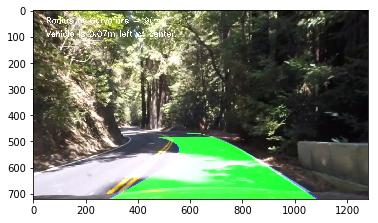

In [27]:
harder_challenge_output_video = 'harder_challenge_output_video.mp4'
harder_challenge_clip = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_output_clip = harder_challenge_clip.fl_image(image_pipeline)
%time harder_challenge_output_clip.write_videofile(harder_challenge_output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output_video))